In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 74 (delta 40), reused 47 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 40.11 KiB | 6.69 MiB/s, done.
Resolving deltas: 100% (40/40), done.


/tmp/ipykernel_2140746/1452909184.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


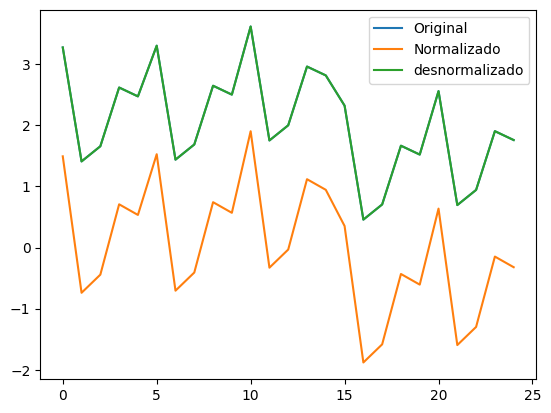

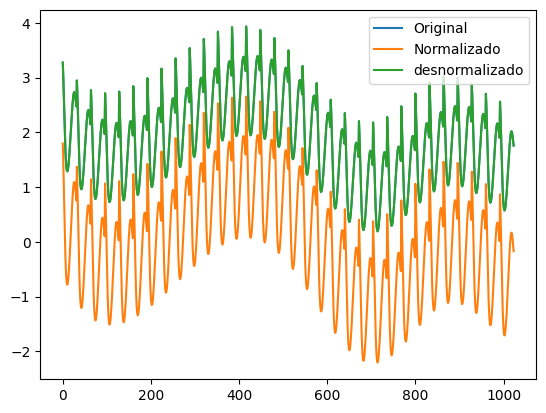

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def function(grid):
    x = np.linspace(1, 0, grid)
    y = np.linspace(1, 0, grid)
    x, y = np.meshgrid(x, y)
    z = 1.3356 * (1.5 * (1 - x))+np.exp(2 * x - 1) * np.sin(3 * np.pi * (x - 0.6)**2)+np.exp(3*(y - 0.5)) * np.sin(4 * np.pi * (y - 0.9)**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = function(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="function", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-12-08 17:19:08.607351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 17:19:08.607430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 17:19:08.609033: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 17:19:08.618825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-08 17:19:11.219162: W tensorflow/compiler/tf2

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [8]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[15], [16], [17], [18], [19],[20]],
            regularizers=[0.2, 0.05],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[15], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
++++

r2    r2_sup   r2_test      r2_val     r2_vt       mse  \
model_1_0_17  0.398430  0.411634 -0.321579 -157.627225 -1.047551  0.357118   
model_1_0_16  0.386883  0.402433 -0.352835 -159.153062 -1.084180  0.363973   
model_1_0_15  0.375080  0.392975 -0.384948 -160.700453 -1.121707  0.370979   
model_1_0_14  0.363015  0.383251 -0.417957 -162.269112 -1.160164  0.378142   
model_1_0_13  0.350681  0.373249 -0.451901 -163.858289 -1.199584  0.385464   
model_1_0_12  0.338069  0.362961 -0.486823 -165.467487 -1.240004  0.392951   
model_1_0_11  0.325170  0.352373 -0.522771 -167.096253 -1.281463  0.400608   
model_1_0_10  0.311978  0.341475 -0.559792 -168.743647 -1.324001  0.408439   
model_1_0_9   0.298483  0.330252 -0.597938 -170.409302 -1.367664  0.416451   
model_1_0_8   0.284676  0.318691 -0.637264 -172.092229 -1.412495  0.424647   
model_1_0_7   0.270546  0.306776 -0.677825 -173.792022 -1.458545  0.433036   
model_1_0_6   0.256083  0.294492 -0.719683 -175.508745 -1.505868  0.441621   
model_1_0_5   0.241276  0.281819 -0.762896 -177.242032 -1.554516  0.450411   
model_1_0_4   0.226116  0.268741 -0.807521 -178.991891 -1.604540  0.459411   
model_1_0_3   0.210591  0.255235 -0.853612 -180.759949 -1.656001  0.468627   
model_1_0_2   0.194690  0.241281 -0.901215 -182.547886 -1.708949  0.478067   
model_1_0_1   0.178405  0.226859 -0.950354 -184.359150 -1.763421  0.487734   
model_1_0_0   0.161728  0.211948 -1.001019 -186.200686 -1.819448  0.497635   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_0_17  0.349279  0.605838  0.422016  0.513927  0.367384  0.597593   
model_1_0_16  0.354741  0.620166  0.426075  0.523121  0.370890  0.603302   
model_1_0_15  0.360356  0.634888  0.430192  0.532540  0.374431  0.609081   
model_1_0_14  0.366129  0.650019  0.434365  0.542192  0.378008  0.614932   
model_1_0_13  0.372066  0.665580  0.438593  0.552087  0.381621  0.620857   
model_1_0_12  0.378174  0.681589  0.442874  0.562232  0.385270  0.626858   
model_1_0_11  0.384459  0.698069  0.447208  0.572638  0.388955  0.632936   
model_1_0_10  0.390929  0.715039  0.451590  0.583315  0.392678  0.639093   
model_1_0_9   0.397591  0.732526  0.456022  0.594274  0.396438  0.645330   
model_1_0_8   0.404455  0.750554  0.460499  0.605527  0.400235  0.651650   
model_1_0_7   0.411527  0.769148  0.465021  0.617085  0.404071  0.658054   
model_1_0_6   0.418820  0.788337  0.469589  0.628963  0.407945  0.664546   
model_1_0_5   0.426343  0.808147  0.474200  0.641173  0.411858  0.671127   
model_1_0_4   0.434107  0.828603  0.478855  0.653729  0.415809  0.677798   
model_1_0_3   0.442125  0.849732  0.483559  0.666646  0.419799  0.684564   
model_1_0_2   0.450408  0.871555  0.488316  0.679935  0.423828  0.691424   
model_1_0_1   0.458970  0.894081  0.493134  0.693608  0.427894  0.698380   
model_1_0_0   0.467822  0.917306  0.498034  0.707670  0.431996  0.705432   

                r2_adj       rsd         aic         bic  
model_1_0_17  1.390207  0.623034  124.059379  198.410805  
model_1_0_16  1.397698  0.628985  124.021352  198.372778  
model_1_0_15  1.405353  0.635011  123.983218  198.334643  
model_1_0_14  1.413179  0.641111  123.944973  198.296398  
model_1_0_13  1.421180  0.647289  123.906615  198.258040  
model_1_0_12  1.429361  0.653545  123.868140  198.219565  
model_1_0_11  1.437727  0.659881  123.829544  198.180969  
model_1_0_10  1.446284  0.666300  123.790824  198.142249  
model_1_0_9   1.455038  0.672803  123.751974  198.103400  
model_1_0_8   1.463994  0.679392  123.712992  198.064417  
model_1_0_7   1.473160  0.686069  123.673871  198.025296  
model_1_0_6   1.482541  0.692837  123.634605  197.986030  
model_1_0_5   1.492145  0.699698  123.595189  197.946615  
model_1_0_4   1.501979  0.706654  123.555621  197.907047  
model_1_0_3   1.512049  0.713707  123.515895  197.867321  
model_1_0_2   1.522363  0.720859  123.476010  197.827435  
model_1_0_1   1.532927  0.728111  123.435968  197.787394  
model_1_0_0   1.543744  0.7354

DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_1_24  0.641798  0.570854  0.596354  0.418705  0.720926  0.212644   
model_1_1_23  0.634346  0.566264  0.586690  0.407961  0.714779  0.217068   
model_1_1_22  0.626726  0.561561  0.576735  0.396995  0.708464  0.221592   
model_1_1_21  0.618934  0.556742  0.566479  0.385799  0.701976  0.226217   
model_1_1_20  0.610965  0.551804  0.555912  0.374369  0.695308  0.230948   
model_1_1_19  0.602816  0.546743  0.545026  0.362700  0.688457  0.235785   
model_1_1_18  0.594482  0.541557  0.533811  0.350786  0.681418  0.240733   
model_1_1_17  0.585960  0.536239  0.522258  0.338624  0.674185  0.245792   
model_1_1_16  0.577245  0.530787  0.510365  0.326213  0.666757  0.250966   
model_1_1_15  0.568335  0.525196  0.498124  0.313551  0.659131  0.256255   
model_1_1_14  0.559225  0.519459  0.485531  0.300635  0.651304  0.261663   
model_1_1_13  0.549914  0.513570  0.472587  0.287466  0.643277  0.267191   
model_1_1_12  0.540399  0.507525  0.459294  0.274048  0.635052  0.272839   
model_1_1_11  0.530678  0.501316  0.445658  0.260382  0.626631  0.278610   
model_1_1_10  0.520751  0.494937  0.431688  0.246476  0.618019  0.284503   
model_1_1_9   0.510618  0.488379  0.417397  0.232332  0.609223  0.290518   
model_1_1_8   0.500278  0.481638  0.402802  0.217960  0.600253  0.296657   
model_1_1_7   0.489733  0.474704  0.387928  0.203367  0.591120  0.302916   
model_1_1_6   0.478986  0.467573  0.372804  0.188563  0.581839  0.309296   
model_1_1_5   0.468039  0.460236  0.357462  0.173558  0.572427  0.315795   
model_1_1_4   0.456897  0.452690  0.341944  0.158358  0.562903  0.322410   
model_1_1_3   0.445563  0.444928  0.326293  0.142972  0.553288  0.329138   
model_1_1_2   0.434044  0.436945  0.310562  0.127406  0.543606  0.335976   
model_1_1_1   0.422345  0.428738  0.294807  0.111661  0.533884  0.342921   
model_1_1_0   0.410472  0.420302  0.279085  0.095731  0.524145  0.349970   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_1_24  0.254760  0.243599  0.131799  0.187699  0.280801  0.461134   
model_1_1_23  0.257485  0.249431  0.134235  0.191833  0.283781  0.465906   
model_1_1_22  0.260277  0.255439  0.136721  0.196080  0.286803  0.470735   
model_1_1_21  0.263137  0.261629  0.139260  0.200444  0.289868  0.475623   
model_1_1_20  0.266069  0.268006  0.141852  0.204929  0.292976  0.480570   
model_1_1_19  0.269073  0.274576  0.144497  0.209536  0.296129  0.485577   
model_1_1_18  0.272152  0.281344  0.147199  0.214271  0.299326  0.490645   
model_1_1_17  0.275308  0.288316  0.149956  0.219136  0.302568  0.495774   
model_1_1_16  0.278545  0.295493  0.152770  0.224132  0.305856  0.500965   
model_1_1_15  0.281864  0.302880  0.155641  0.229261  0.309189  0.506216   
model_1_1_14  0.285270  0.310480  0.158569  0.234525  0.312566  0.511530   
model_1_1_13  0.288766  0.318292  0.161555  0.239924  0.315988  0.516905   
model_1_1_12  0.292354  0.326314  0.164598  0.245456  0.319453  0.522340   
model_1_1_11  0.296040  0.334543  0.167696  0.251120  0.322959  0.527835   
model_1_1_10  0.299827  0.342975  0.170849  0.256912  0.326505  0.533388   
model_1_1_9   0.303720  0.351599  0.174056  0.262828  0.330089  0.538998   
model_1_1_8   0.307722  0.360407  0.177315  0.268861  0.333707  0.544662   
model_1_1_7   0.311838  0.369383  0.180623  0.275003  0.337359  0.550378   
model_1_1_6   0.316072  0.378511  0.183980  0.281245  0.341040  0.556144   
model_1_1_5   0.320427  0.387770  0.187382  0.287576  0.344747  0.561956   
model_1_1_4   0.324907  0.397135  0.190828  0.293982  0.348478  0.567811   
model_1_1_3   0.329515  0.406580  0.194317  0.300448  0.352230  0.573705   
model_1_1_2   0.334254  0.416074  0.197846  0.306960  0.355999  0.579634   
model_1_1_1   0.339126  0.425582  0.201416  0.313499  0.359782  0.585595   
model_1_1_0   0.344134  0.435070  0.205028  0.320049  0.363578  0.591582   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_2_24  0.778545  0.669795 -0.270762  0.837719  0.815367  0.131465   
model_1_2_23  0.774294  0.666920 -0.296867  0.835522  0.812141  0.133989   
model_1_2_22  0.769956  0.663970 -0.323510  0.833284  0.808851  0.136564   
model_1_2_21  0.765532  0.660945 -0.350701  0.831005  0.805495  0.139191   
model_1_2_20  0.761018  0.657841 -0.378452  0.828683  0.802072  0.141870   
model_1_2_19  0.756413  0.654658 -0.406775  0.826317  0.798581  0.144604   
model_1_2_18  0.751714  0.651393 -0.435682  0.823905  0.795019  0.147393   
model_1_2_17  0.746921  0.648043 -0.465186  0.821448  0.791386  0.150239   
model_1_2_16  0.742031  0.644609 -0.495300  0.818943  0.787679  0.153142   
model_1_2_15  0.737041  0.641086 -0.526038  0.816390  0.783897  0.156104   
model_1_2_14  0.731950  0.637473 -0.557412  0.813786  0.780039  0.159126   
model_1_2_13  0.726756  0.633768 -0.589437  0.811131  0.776101  0.162209   
model_1_2_12  0.721456  0.629968 -0.622125  0.808423  0.772082  0.165356   
model_1_2_11  0.716048  0.626072 -0.655495  0.805659  0.767981  0.168566   
model_1_2_10  0.710530  0.622076 -0.689560  0.802840  0.763795  0.171842   
model_1_2_9   0.704898  0.617979 -0.724334  0.799963  0.759523  0.175185   
model_1_2_8   0.699152  0.613778 -0.759834  0.797026  0.755161  0.178597   
model_1_2_7   0.693287  0.609471 -0.796076  0.794027  0.750707  0.182078   
model_1_2_6   0.687302  0.605054 -0.833076  0.790964  0.746160  0.185631   
model_1_2_5   0.681194  0.600526 -0.870849  0.787835  0.741517  0.189257   
model_1_2_4   0.674960  0.595883 -0.909416  0.784637  0.736775  0.192958   
model_1_2_3   0.668597  0.591123 -0.948793  0.781369  0.731932  0.196735   
model_1_2_2   0.662103  0.586243 -0.988997  0.778027  0.726984  0.200590   
model_1_2_1   0.655473  0.581240 -1.030046  0.774609  0.721930  0.204526   
model_1_2_0   0.648706  0.576111 -1.071958  0.771112  0.716765  0.208543   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_2_24  0.196024  0.178884  0.139581  0.159232  0.221593  0.362581   
model_1_2_23  0.197731  0.182559  0.141470  0.162015  0.223669  0.366045   
model_1_2_22  0.199482  0.186309  0.143395  0.164852  0.225767  0.369545   
model_1_2_21  0.201278  0.190137  0.145355  0.167746  0.227887  0.373083   
model_1_2_20  0.203120  0.194043  0.147353  0.170698  0.230030  0.376657   
model_1_2_19  0.205010  0.198030  0.149388  0.173709  0.232195  0.380268   
model_1_2_18  0.206948  0.202100  0.151462  0.176781  0.234383  0.383918   
model_1_2_17  0.208937  0.206253  0.153575  0.179914  0.236595  0.387606   
model_1_2_16  0.210976  0.210492  0.155730  0.183111  0.238830  0.391333   
model_1_2_15  0.213067  0.214819  0.157926  0.186372  0.241090  0.395100   
model_1_2_14  0.215212  0.219235  0.160166  0.189700  0.243374  0.398906   
model_1_2_13  0.217411  0.223743  0.162449  0.193096  0.245682  0.402752   
model_1_2_12  0.219667  0.228345  0.164779  0.196562  0.248015  0.406639   
model_1_2_11  0.221980  0.233042  0.167155  0.200099  0.250374  0.410568   
model_1_2_10  0.224352  0.237838  0.169580  0.203709  0.252759  0.414538   
model_1_2_9   0.226784  0.242733  0.172055  0.207394  0.255169  0.418551   
model_1_2_8   0.229278  0.247730  0.174581  0.211156  0.257607  0.422607   
model_1_2_7   0.231835  0.252832  0.177161  0.214996  0.260071  0.426706   
model_1_2_6   0.234457  0.258040  0.179796  0.218918  0.262562  0.430849   
model_1_2_5   0.237145  0.263358  0.182487  0.222922  0.265081  0.435037   
model_1_2_4   0.239901  0.268787  0.185237  0.227012  0.267628  0.439269   
model_1_2_3   0.242727  0.274330  0.188048  0.231189  0.270204  0.443548   
model_1_2_2   0.245624  0.279989  0.190922  0.235456  0.272808  0.447873   
model_1_2_1   0.248594  0.285768  0.193862  0.239815  0.275443  0.452245   
model_1_2_0   0.251639  0.291667  0.196871  0.244269  0.278107  0.456665   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_3_24  0.863192  0.711359  0.877559 -1.059900  0.842133  0.081215   
model_1_3_23  0.860612  0.710308  0.875367 -1.094885  0.839363  0.082747   
model_1_3_22  0.857975  0.709216  0.873129 -1.130801  0.836530  0.084312   
model_1_3_21  0.855282  0.708083  0.870845 -1.167668  0.833632  0.085911   
model_1_3_20  0.852530  0.706906  0.868513 -1.205513  0.830667  0.087545   
model_1_3_19  0.849718  0.705686  0.866131 -1.244369  0.827633  0.089214   
model_1_3_18  0.846846  0.704420  0.863700 -1.284262  0.824529  0.090919   
model_1_3_17  0.843910  0.703107  0.861217 -1.325219  0.821352  0.092662   
model_1_3_16  0.840911  0.701747  0.858681 -1.367268  0.818100  0.094442   
model_1_3_15  0.837846  0.700337  0.856091 -1.410441  0.814773  0.096262   
model_1_3_14  0.834714  0.698876  0.853446 -1.454768  0.811368  0.098121   
model_1_3_13  0.831513  0.697363  0.850743 -1.500275  0.807882  0.100021   
model_1_3_12  0.828242  0.695797  0.847982 -1.546997  0.804314  0.101963   
model_1_3_11  0.824899  0.694175  0.845162 -1.594967  0.800662  0.103947   
model_1_3_10  0.821483  0.692496  0.842280 -1.644214  0.796923  0.105975   
model_1_3_9   0.817991  0.690759  0.839334 -1.694773  0.793095  0.108048   
model_1_3_8   0.814423  0.688962  0.836325 -1.746676  0.789177  0.110167   
model_1_3_7   0.810776  0.687103  0.833250 -1.799952  0.785166  0.112332   
model_1_3_6   0.807048  0.685180  0.830107 -1.854641  0.781058  0.114545   
model_1_3_5   0.803238  0.683193  0.826894 -1.910772  0.776854  0.116806   
model_1_3_4   0.799344  0.681138  0.823611 -1.968386  0.772549  0.119118   
model_1_3_3   0.795364  0.679015  0.820254 -2.027513  0.768141  0.121481   
model_1_3_2   0.791296  0.676821  0.816823 -2.088187  0.763629  0.123896   
model_1_3_1   0.787138  0.674554  0.813316 -2.150445  0.759009  0.126364   
model_1_3_0   0.782889  0.672213  0.809730 -2.214325  0.754279  0.128887   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_3_24  0.171350  0.161428  0.104237  0.132833  0.174192  0.284983   
model_1_3_23  0.171974  0.164318  0.106007  0.135163  0.175856  0.287658   
model_1_3_22  0.172622  0.167269  0.107824  0.137546  0.177537  0.290366   
model_1_3_21  0.173295  0.170280  0.109690  0.139985  0.179236  0.293106   
model_1_3_20  0.173993  0.173355  0.111605  0.142480  0.180953  0.295879   
model_1_3_19  0.174718  0.176495  0.113571  0.145033  0.182689  0.298687   
model_1_3_18  0.175469  0.179700  0.115590  0.147645  0.184444  0.301528   
model_1_3_17  0.176248  0.182974  0.117662  0.150318  0.186217  0.304404   
model_1_3_16  0.177056  0.186317  0.119790  0.153054  0.188009  0.307315   
model_1_3_15  0.177893  0.189732  0.121975  0.155853  0.189821  0.310261   
model_1_3_14  0.178760  0.193219  0.124218  0.158719  0.191652  0.313243   
model_1_3_13  0.179658  0.196783  0.126521  0.161652  0.193503  0.316261   
model_1_3_12  0.180588  0.200422  0.128885  0.164654  0.195374  0.319316   
model_1_3_11  0.181551  0.204141  0.131312  0.167727  0.197264  0.322409   
model_1_3_10  0.182548  0.207941  0.133804  0.170873  0.199175  0.325539   
model_1_3_9   0.183579  0.211824  0.136363  0.174093  0.201107  0.328707   
model_1_3_8   0.184646  0.215792  0.138989  0.177390  0.203059  0.331914   
model_1_3_7   0.185749  0.219846  0.141685  0.180766  0.205032  0.335159   
model_1_3_6   0.186891  0.223990  0.144453  0.184221  0.207027  0.338444   
model_1_3_5   0.188070  0.228226  0.147293  0.187759  0.209042  0.341769   
model_1_3_4   0.189290  0.232555  0.150208  0.191382  0.211079  0.345135   
model_1_3_3   0.190551  0.236980  0.153200  0.195090  0.213138  0.348541   
model_1_3_2   0.191853  0.241503  0.156271  0.198887  0.215219  0.351988   
model_1_3_1   0.193199  0.246128  0.159421  0.202774  0.217321  0.355477   
model_1_3_0   0.194589  0.250855  0.162654  0.206754  0.219446  0.359008   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_4_24  0.917251  0.732700  0.972999  0.631637  0.949144  0.049123   
model_1_4_23  0.915574  0.732183  0.972493  0.623770  0.948124  0.050119   
model_1_4_22  0.913862  0.731643  0.971976  0.615737  0.947081  0.051135   
model_1_4_21  0.912115  0.731080  0.971446  0.607537  0.946015  0.052172   
model_1_4_20  0.910333  0.730493  0.970903  0.599166  0.944925  0.053230   
model_1_4_19  0.908514  0.729881  0.970347  0.590618  0.943811  0.054310   
model_1_4_18  0.906658  0.729244  0.969777  0.581890  0.942671  0.055412   
model_1_4_17  0.904763  0.728581  0.969194  0.572980  0.941506  0.056537   
model_1_4_16  0.902830  0.727891  0.968597  0.563880  0.940315  0.057684   
model_1_4_15  0.900858  0.727174  0.967985  0.554590  0.939097  0.058855   
model_1_4_14  0.898844  0.726428  0.967359  0.545104  0.937851  0.060050   
model_1_4_13  0.896790  0.725654  0.966717  0.535416  0.936577  0.061270   
model_1_4_12  0.894694  0.724851  0.966059  0.525523  0.935274  0.062514   
model_1_4_11  0.892555  0.724017  0.965386  0.515419  0.933941  0.063784   
model_1_4_10  0.890372  0.723152  0.964696  0.505101  0.932579  0.065080   
model_1_4_9   0.888144  0.722256  0.963990  0.494566  0.931185  0.066403   
model_1_4_8   0.885870  0.721327  0.963266  0.483805  0.929760  0.067752   
model_1_4_7   0.883550  0.720364  0.962524  0.472813  0.928302  0.069130   
model_1_4_6   0.881182  0.719368  0.961765  0.461587  0.926811  0.070535   
model_1_4_5   0.878766  0.718336  0.960986  0.450119  0.925286  0.071970   
model_1_4_4   0.876300  0.717269  0.960189  0.438405  0.923726  0.073433   
model_1_4_3   0.873784  0.716164  0.959373  0.426440  0.922130  0.074927   
model_1_4_2   0.871216  0.715022  0.958536  0.414215  0.920498  0.076452   
model_1_4_1   0.868596  0.713841  0.957679  0.401727  0.918828  0.078007   
model_1_4_0   0.865921  0.712621  0.956801  0.388969  0.917120  0.079595   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_4_24  0.158681  0.013293  0.013639  0.013466  0.135721  0.221637   
model_1_4_23  0.158988  0.013542  0.013931  0.013736  0.137061  0.223873   
model_1_4_22  0.159308  0.013797  0.014228  0.014013  0.138413  0.226131   
model_1_4_21  0.159642  0.014058  0.014532  0.014295  0.139780  0.228412   
model_1_4_20  0.159991  0.014325  0.014842  0.014584  0.141160  0.230717   
model_1_4_19  0.160354  0.014599  0.015158  0.014879  0.142555  0.233045   
model_1_4_18  0.160732  0.014879  0.015481  0.015180  0.143963  0.235398   
model_1_4_17  0.161126  0.015167  0.015811  0.015489  0.145409  0.237774   
model_1_4_16  0.161536  0.015461  0.016148  0.015804  0.146873  0.240175   
model_1_4_15  0.161962  0.015762  0.016492  0.016127  0.148351  0.242601   
model_1_4_14  0.162404  0.016070  0.016843  0.016457  0.149845  0.245052   
model_1_4_13  0.162864  0.016386  0.017202  0.016794  0.151354  0.247527   
model_1_4_12  0.163341  0.016710  0.017568  0.017139  0.152879  0.250028   
model_1_4_11  0.163835  0.017042  0.017943  0.017492  0.154419  0.252555   
model_1_4_10  0.164349  0.017381  0.018325  0.017853  0.155975  0.255108   
model_1_4_9   0.164881  0.017729  0.018715  0.018222  0.157548  0.257687   
model_1_4_8   0.165432  0.018085  0.019113  0.018599  0.159136  0.260293   
model_1_4_7   0.166004  0.018450  0.019520  0.018985  0.160741  0.262925   
model_1_4_6   0.166595  0.018824  0.019936  0.019380  0.162363  0.265585   
model_1_4_5   0.167208  0.019208  0.020360  0.019784  0.164001  0.268272   
model_1_4_4   0.167842  0.019600  0.020794  0.020197  0.165657  0.270986   
model_1_4_3   0.168497  0.020002  0.021237  0.020620  0.167329  0.273728   
model_1_4_2   0.169175  0.020414  0.021690  0.021052  0.169018  0.276499   
model_1_4_1   0.169876  0.020836  0.022152  0.021494  0.170725  0.279298   
model_1_4_0   0.170601  0.021268  0.022625  0.021946  0.172450  0.282126   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_5_24  0.949903  0.739876  0.969490  0.973253  0.972234  0.029740   
model_1_5_23  0.948898  0.739761  0.968928  0.972718  0.971709  0.030336   
model_1_5_22  0.947872  0.739635  0.968353  0.972170  0.971170  0.030945   
model_1_5_21  0.946825  0.739497  0.967764  0.971608  0.970618  0.031567   
model_1_5_20  0.945755  0.739347  0.967161  0.971031  0.970053  0.032202   
model_1_5_19  0.944664  0.739184  0.966544  0.970440  0.969473  0.032850   
model_1_5_18  0.943549  0.739009  0.965912  0.969833  0.968880  0.033512   
model_1_5_17  0.942410  0.738820  0.965264  0.969210  0.968271  0.034188   
model_1_5_16  0.941248  0.738618  0.964601  0.968572  0.967648  0.034878   
model_1_5_15  0.940061  0.738401  0.963921  0.967917  0.967009  0.035582   
model_1_5_14  0.938849  0.738170  0.963225  0.967245  0.966354  0.036302   
model_1_5_13  0.937611  0.737925  0.962511  0.966555  0.965682  0.037037   
model_1_5_12  0.936348  0.737664  0.961780  0.965847  0.964993  0.037787   
model_1_5_11  0.935057  0.737388  0.961031  0.965120  0.964287  0.038553   
model_1_5_10  0.933739  0.737096  0.960263  0.964374  0.963563  0.039335   
model_1_5_9   0.932393  0.736787  0.959475  0.963609  0.962820  0.040134   
model_1_5_8   0.931019  0.736462  0.958668  0.962822  0.962059  0.040950   
model_1_5_7   0.929615  0.736119  0.957841  0.962015  0.961277  0.041784   
model_1_5_6   0.928181  0.735758  0.956993  0.961186  0.960475  0.042635   
model_1_5_5   0.926717  0.735380  0.956123  0.960335  0.959653  0.043504   
model_1_5_4   0.925222  0.734983  0.955231  0.959460  0.958809  0.044392   
model_1_5_3   0.923695  0.734566  0.954316  0.958562  0.957943  0.045298   
model_1_5_2   0.922135  0.734130  0.953377  0.957638  0.957054  0.046224   
model_1_5_1   0.920541  0.733674  0.952415  0.956690  0.956141  0.047170   
model_1_5_0   0.918914  0.733197  0.951427  0.955715  0.955205  0.048136   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_5_24  0.154421  0.022017  0.011074  0.016546  0.104589  0.172452   
model_1_5_23  0.154489  0.022422  0.011296  0.016859  0.105673  0.174173   
model_1_5_22  0.154564  0.022837  0.011523  0.017180  0.106768  0.175913   
model_1_5_21  0.154646  0.023262  0.011756  0.017509  0.107876  0.177671   
model_1_5_20  0.154735  0.023697  0.011995  0.017846  0.108996  0.179449   
model_1_5_19  0.154831  0.024143  0.012240  0.018191  0.110129  0.181246   
model_1_5_18  0.154936  0.024599  0.012491  0.018545  0.111275  0.183063   
model_1_5_17  0.155048  0.025066  0.012748  0.018907  0.112434  0.184899   
model_1_5_16  0.155168  0.025545  0.013013  0.019279  0.113606  0.186756   
model_1_5_15  0.155296  0.026035  0.013284  0.019660  0.114792  0.188633   
model_1_5_14  0.155433  0.026538  0.013562  0.020050  0.115991  0.190531   
model_1_5_13  0.155579  0.027053  0.013848  0.020450  0.117204  0.192449   
model_1_5_12  0.155734  0.027580  0.014141  0.020861  0.118430  0.194388   
model_1_5_11  0.155898  0.028121  0.014442  0.021281  0.119671  0.196349   
model_1_5_10  0.156071  0.028675  0.014751  0.021713  0.120926  0.198331   
model_1_5_9   0.156255  0.029243  0.015068  0.022156  0.122195  0.200336   
model_1_5_8   0.156448  0.029826  0.015393  0.022609  0.123479  0.202362   
model_1_5_7   0.156651  0.030423  0.015728  0.023075  0.124777  0.204410   
model_1_5_6   0.156865  0.031035  0.016071  0.023553  0.126091  0.206482   
model_1_5_5   0.157090  0.031663  0.016423  0.024043  0.127420  0.208576   
model_1_5_4   0.157326  0.032306  0.016786  0.024546  0.128764  0.210693   
model_1_5_3   0.157573  0.032967  0.017158  0.025062  0.130123  0.212834   
model_1_5_2   0.157832  0.033644  0.017540  0.025592  0.131499  0.214998   
model_1_5_1   0.158103  0.034338  0.017933  0.026136  0.132890  0.217187   
model_1_5_0   0.158386  0.035051  0.018336  0.026694  0.134297  0.219400   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_6_20  0.964690  0.741133  0.929477  0.975522  0.958057  0.020962   
model_1_6_19  0.964110  0.741131  0.928661  0.975248  0.957577  0.021306   
model_1_6_21  0.965259  0.741130  0.930281  0.975793  0.958529  0.020624   
model_1_6_18  0.963519  0.741124  0.927833  0.974969  0.957089  0.021657   
model_1_6_22  0.965818  0.741123  0.931071  0.976060  0.958995  0.020292   
model_1_6_17  0.962917  0.741113  0.926991  0.974686  0.956594  0.022014   
model_1_6_23  0.966366  0.741112  0.931850  0.976322  0.959453  0.019966   
model_1_6_16  0.962303  0.741096  0.926136  0.974399  0.956092  0.022378   
model_1_6_24  0.966905  0.741096  0.932617  0.976581  0.959904  0.019647   
model_1_6_15  0.961678  0.741075  0.925267  0.974107  0.955581  0.022749   
model_1_6_14  0.961041  0.741048  0.924385  0.973811  0.955063  0.023128   
model_1_6_13  0.960392  0.741015  0.923488  0.973511  0.954536  0.023513   
model_1_6_12  0.959731  0.740977  0.922577  0.973206  0.954001  0.023905   
model_1_6_11  0.959058  0.740933  0.921652  0.972896  0.953458  0.024305   
model_1_6_10  0.958371  0.740883  0.920712  0.972581  0.952906  0.024713   
model_1_6_9   0.957672  0.740827  0.919757  0.972262  0.952346  0.025128   
model_1_6_8   0.956959  0.740764  0.918787  0.971937  0.951776  0.025551   
model_1_6_7   0.956233  0.740695  0.917801  0.971608  0.951198  0.025982   
model_1_6_6   0.955493  0.740618  0.916800  0.971274  0.950611  0.026421   
model_1_6_5   0.954739  0.740535  0.915782  0.970934  0.950014  0.026869   
model_1_6_4   0.953970  0.740445  0.914748  0.970589  0.949408  0.027325   
model_1_6_3   0.953187  0.740347  0.913697  0.970239  0.948792  0.027790   
model_1_6_2   0.952389  0.740241  0.912630  0.969883  0.948166  0.028264   
model_1_6_1   0.951576  0.740127  0.911544  0.969522  0.947530  0.028746   
model_1_6_0   0.950748  0.740006  0.910442  0.969155  0.946884  0.029238   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_6_20  0.153675  0.036531  0.020736  0.028633  0.088265  0.144782   
model_1_6_19  0.153676  0.036953  0.020968  0.028961  0.088972  0.145966   
model_1_6_21  0.153676  0.036115  0.020506  0.028311  0.087565  0.143610   
model_1_6_18  0.153680  0.037383  0.021204  0.029294  0.089686  0.147163   
model_1_6_22  0.153680  0.035705  0.020281  0.027993  0.086871  0.142450   
model_1_6_17  0.153687  0.037819  0.021444  0.029631  0.090406  0.148372   
model_1_6_23  0.153687  0.035302  0.020058  0.027680  0.086183  0.141302   
model_1_6_16  0.153696  0.038262  0.021687  0.029975  0.091133  0.149594   
model_1_6_24  0.153696  0.034905  0.019839  0.027372  0.085502  0.140167   
model_1_6_15  0.153709  0.038712  0.021934  0.030323  0.091867  0.150829   
model_1_6_14  0.153725  0.039169  0.022185  0.030677  0.092608  0.152077   
model_1_6_13  0.153744  0.039633  0.022440  0.031037  0.093356  0.153339   
model_1_6_12  0.153767  0.040105  0.022698  0.031402  0.094110  0.154613   
model_1_6_11  0.153793  0.040584  0.022961  0.031772  0.094872  0.155901   
model_1_6_10  0.153823  0.041071  0.023227  0.032149  0.095641  0.157203   
model_1_6_9   0.153856  0.041566  0.023498  0.032532  0.096417  0.158518   
model_1_6_8   0.153894  0.042068  0.023773  0.032920  0.097201  0.159847   
model_1_6_7   0.153935  0.042579  0.024052  0.033315  0.097991  0.161190   
model_1_6_6   0.153980  0.043098  0.024335  0.033716  0.098789  0.162547   
model_1_6_5   0.154030  0.043625  0.024622  0.034124  0.099595  0.163918   
model_1_6_4   0.154083  0.044160  0.024915  0.034538  0.100408  0.165303   
model_1_6_3   0.154141  0.044705  0.025211  0.034958  0.101229  0.166703   
model_1_6_2   0.154204  0.045258  0.025513  0.035385  0.102057  0.168118   
model_1_6_1   0.154272  0.045820  0.025819  0.035819  0.102893  0.169548   
model_1_6_0   0.154344  0.046391  0.026129  0.036260  0.103737  0.170992   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_7_0   0.967556  0.741074  0.809565  0.967445  0.918438  0.019260   
model_1_7_1   0.968195  0.741045  0.813396  0.967982  0.920006  0.018881   
model_1_7_2   0.968821  0.741010  0.817151  0.968510  0.921545  0.018509   
model_1_7_3   0.969434  0.740969  0.820831  0.969028  0.923053  0.018145   
model_1_7_4   0.970036  0.740921  0.824437  0.969537  0.924531  0.017788   
model_1_7_5   0.970625  0.740868  0.827970  0.970037  0.925981  0.017438   
model_1_7_6   0.971203  0.740808  0.831433  0.970529  0.927403  0.017095   
model_1_7_7   0.971770  0.740744  0.834826  0.971012  0.928796  0.016759   
model_1_7_8   0.972325  0.740674  0.838150  0.971486  0.930163  0.016429   
model_1_7_9   0.972869  0.740599  0.841407  0.971952  0.931502  0.016106   
model_1_7_10  0.973402  0.740518  0.844598  0.972411  0.932815  0.015789   
model_1_7_11  0.973925  0.740433  0.847724  0.972861  0.934103  0.015479   
model_1_7_12  0.974438  0.740343  0.850787  0.973303  0.935365  0.015175   
model_1_7_13  0.974940  0.740249  0.853788  0.973737  0.936602  0.014877   
model_1_7_14  0.975432  0.740150  0.856727  0.974164  0.937814  0.014584   
model_1_7_15  0.975915  0.740047  0.859607  0.974583  0.939003  0.014298   
model_1_7_16  0.976388  0.739940  0.862428  0.974996  0.940168  0.014017   
model_1_7_17  0.976852  0.739829  0.865192  0.975400  0.941311  0.013742   
model_1_7_18  0.977306  0.739713  0.867898  0.975798  0.942430  0.013472   
model_1_7_19  0.977751  0.739594  0.870550  0.976189  0.943527  0.013208   
model_1_7_20  0.978188  0.739472  0.873147  0.976573  0.944603  0.012949   
model_1_7_21  0.978616  0.739346  0.875690  0.976951  0.945657  0.012695   
model_1_7_22  0.979035  0.739216  0.878181  0.977321  0.946690  0.012446   
model_1_7_23  0.979446  0.739084  0.880621  0.977686  0.947703  0.012202   
model_1_7_24  0.979849  0.738948  0.883010  0.978044  0.948695  0.011963   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_7_0   0.153710  0.028889  0.009348  0.019119  0.084639  0.138780   
model_1_7_1   0.153727  0.028308  0.009194  0.018751  0.083784  0.137408   
model_1_7_2   0.153748  0.027738  0.009042  0.018390  0.082938  0.136049   
model_1_7_3   0.153772  0.027180  0.008893  0.018037  0.082100  0.134704   
model_1_7_4   0.153801  0.026633  0.008747  0.017690  0.081270  0.133372   
model_1_7_5   0.153832  0.026097  0.008603  0.017350  0.080448  0.132054   
model_1_7_6   0.153867  0.025572  0.008462  0.017017  0.079634  0.130748   
model_1_7_7   0.153906  0.025057  0.008324  0.016690  0.078828  0.129456   
model_1_7_8   0.153947  0.024553  0.008187  0.016370  0.078030  0.128177   
model_1_7_9   0.153992  0.024059  0.008054  0.016056  0.077240  0.126910   
model_1_7_10  0.154040  0.023575  0.007922  0.015748  0.076457  0.125656   
model_1_7_11  0.154090  0.023100  0.007793  0.015447  0.075682  0.124415   
model_1_7_12  0.154143  0.022636  0.007666  0.015151  0.074914  0.123186   
model_1_7_13  0.154199  0.022181  0.007541  0.014861  0.074155  0.121970   
model_1_7_14  0.154258  0.021735  0.007419  0.014577  0.073402  0.120766   
model_1_7_15  0.154319  0.021298  0.007298  0.014298  0.072657  0.119574   
model_1_7_16  0.154383  0.020870  0.007180  0.014025  0.071919  0.118394   
model_1_7_17  0.154449  0.020451  0.007064  0.013757  0.071188  0.117226   
model_1_7_18  0.154517  0.020040  0.006949  0.013495  0.070464  0.116069   
model_1_7_19  0.154588  0.019638  0.006837  0.013237  0.069748  0.114925   
model_1_7_20  0.154661  0.019244  0.006727  0.012985  0.069038  0.113792   
model_1_7_21  0.154736  0.018858  0.006618  0.012738  0.068336  0.112670   
model_1_7_22  0.154812  0.018480  0.006512  0.012496  0.067640  0.111560   
model_1_7_23  0.154891  0.018110  0.006407  0.012259  0.066951  0.110461   
model_1_7_24  0.154972  0.017747  0.006304  0.012026  0.066269  0.109373   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_0   0.980239  0.738755  0.985942  0.976604  0.983567  0.011731   
model_1_8_1   0.980622  0.738558  0.986167  0.977028  0.983846  0.011504   
model_1_8_2   0.980997  0.738358  0.986387  0.977443  0.984118  0.011281   
model_1_8_3   0.981364  0.738155  0.986602  0.977850  0.984384  0.011063   
model_1_8_4   0.981724  0.737948  0.986813  0.978249  0.984645  0.010849   
model_1_8_5   0.982077  0.737739  0.987018  0.978639  0.984899  0.010640   
model_1_8_6   0.982423  0.737527  0.987219  0.979022  0.985149  0.010435   
model_1_8_7   0.982761  0.737313  0.987415  0.979396  0.985392  0.010234   
model_1_8_8   0.983093  0.737096  0.987606  0.979763  0.985631  0.010037   
model_1_8_9   0.983418  0.736876  0.987793  0.980122  0.985864  0.009844   
model_1_8_10  0.983736  0.736654  0.987976  0.980474  0.986092  0.009655   
model_1_8_11  0.984048  0.736429  0.988154  0.980819  0.986314  0.009470   
model_1_8_12  0.984354  0.736202  0.988328  0.981156  0.986532  0.009288   
model_1_8_13  0.984653  0.735973  0.988497  0.981487  0.986745  0.009111   
model_1_8_14  0.984946  0.735742  0.988663  0.981811  0.986953  0.008937   
model_1_8_15  0.985234  0.735509  0.988824  0.982128  0.987156  0.008766   
model_1_8_16  0.985515  0.735275  0.988981  0.982439  0.987355  0.008599   
model_1_8_17  0.985791  0.735038  0.989135  0.982743  0.987549  0.008435   
model_1_8_18  0.986061  0.734800  0.989284  0.983041  0.987738  0.008275   
model_1_8_19  0.986326  0.734560  0.989430  0.983333  0.987923  0.008118   
model_1_8_20  0.986585  0.734318  0.989572  0.983618  0.988104  0.007964   
model_1_8_21  0.986839  0.734075  0.989710  0.983898  0.988281  0.007813   
model_1_8_22  0.987087  0.733831  0.989844  0.984172  0.988453  0.007665   
model_1_8_23  0.987331  0.733585  0.989975  0.984440  0.988621  0.007521   
model_1_8_24  0.987570  0.733338  0.990102  0.984703  0.988786  0.007379   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_0   0.155087  0.007537  0.005684  0.006611  0.065614  0.108308   
model_1_8_1   0.155203  0.007416  0.005581  0.006499  0.064967  0.107255   
model_1_8_2   0.155322  0.007298  0.005480  0.006389  0.064325  0.106212   
model_1_8_3   0.155443  0.007183  0.005381  0.006282  0.063690  0.105180   
model_1_8_4   0.155565  0.007070  0.005284  0.006177  0.063061  0.104160   
model_1_8_5   0.155689  0.006960  0.005190  0.006075  0.062438  0.103150   
model_1_8_6   0.155815  0.006852  0.005097  0.005974  0.061821  0.102151   
model_1_8_7   0.155943  0.006747  0.005006  0.005876  0.061210  0.101162   
model_1_8_8   0.156071  0.006645  0.004917  0.005781  0.060605  0.100184   
model_1_8_9   0.156202  0.006544  0.004829  0.005687  0.060006  0.099217   
model_1_8_10  0.156334  0.006446  0.004744  0.005595  0.059413  0.098260   
model_1_8_11  0.156467  0.006351  0.004660  0.005506  0.058826  0.097313   
model_1_8_12  0.156602  0.006258  0.004578  0.005418  0.058245  0.096376   
model_1_8_13  0.156738  0.006167  0.004498  0.005332  0.057669  0.095450   
model_1_8_14  0.156875  0.006078  0.004419  0.005249  0.057098  0.094533   
model_1_8_15  0.157013  0.005992  0.004342  0.005167  0.056534  0.093627   
model_1_8_16  0.157152  0.005907  0.004267  0.005087  0.055975  0.092730   
model_1_8_17  0.157293  0.005825  0.004193  0.005009  0.055421  0.091843   
model_1_8_18  0.157434  0.005745  0.004120  0.004933  0.054875  0.090966   
model_1_8_19  0.157577  0.005667  0.004049  0.004858  0.054378  0.090098   
model_1_8_20  0.157720  0.005591  0.003980  0.004785  0.053887  0.089240   
model_1_8_21  0.157864  0.005517  0.003912  0.004714  0.053401  0.088392   
model_1_8_22  0.158010  0.005445  0.003845  0.004645  0.052920  0.087553   
model_1_8_23  0.158156  0.005375  0.003780  0.004577  0.052444  0.086723   
model_1_8_24  0.158302  0.005306  0.003716  0.004511  0.051972  0.085902   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_0   0.987771  0.733264  0.396846  0.984124  0.987912  0.007259   
model_1_9_1   0.987969  0.733189  0.401858  0.984203  0.987989  0.007142   
model_1_9_2   0.988163  0.733114  0.406784  0.984281  0.988065  0.007027   
model_1_9_3   0.988353  0.733037  0.411635  0.984357  0.988139  0.006914   
model_1_9_4   0.988540  0.732960  0.416413  0.984432  0.988213  0.006803   
model_1_9_5   0.988722  0.732882  0.421118  0.984506  0.988285  0.006695   
model_1_9_6   0.988902  0.732803  0.425748  0.984578  0.988356  0.006588   
model_1_9_7   0.989077  0.732723  0.430313  0.984649  0.988426  0.006484   
model_1_9_8   0.989250  0.732642  0.434796  0.984719  0.988494  0.006382   
model_1_9_9   0.989419  0.732561  0.439221  0.984788  0.988562  0.006281   
model_1_9_10  0.989585  0.732480  0.443573  0.984855  0.988628  0.006183   
model_1_9_11  0.989747  0.732398  0.447854  0.984922  0.988694  0.006087   
model_1_9_12  0.989906  0.732315  0.452070  0.984987  0.988758  0.005992   
model_1_9_13  0.990063  0.732232  0.456222  0.985051  0.988821  0.005899   
model_1_9_14  0.990216  0.732148  0.460307  0.985114  0.988883  0.005808   
model_1_9_15  0.990366  0.732065  0.464324  0.985176  0.988945  0.005719   
model_1_9_16  0.990513  0.731980  0.468280  0.985237  0.989005  0.005632   
model_1_9_17  0.990658  0.731896  0.472174  0.985297  0.989064  0.005546   
model_1_9_18  0.990799  0.731811  0.476007  0.985356  0.989122  0.005462   
model_1_9_19  0.990938  0.731726  0.479779  0.985414  0.989180  0.005380   
model_1_9_20  0.991074  0.731640  0.483491  0.985471  0.989236  0.005299   
model_1_9_21  0.991208  0.731555  0.487145  0.985527  0.989292  0.005219   
model_1_9_22  0.991339  0.731469  0.490742  0.985582  0.989346  0.005142   
model_1_9_23  0.991467  0.731383  0.494282  0.985636  0.989400  0.005066   
model_1_9_24  0.991593  0.731298  0.497766  0.985689  0.989453  0.004991   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_0   0.158346  0.005224  0.007214  0.006219  0.051509  0.085202   
model_1_9_1   0.158390  0.005180  0.007178  0.006179  0.051050  0.084511   
model_1_9_2   0.158435  0.005138  0.007143  0.006140  0.050596  0.083827   
model_1_9_3   0.158481  0.005096  0.007108  0.006102  0.050146  0.083151   
model_1_9_4   0.158527  0.005054  0.007074  0.006064  0.049701  0.082483   
model_1_9_5   0.158573  0.005013  0.007041  0.006027  0.049260  0.081822   
model_1_9_6   0.158620  0.004973  0.007008  0.005991  0.048823  0.081169   
model_1_9_7   0.158667  0.004934  0.006976  0.005955  0.048391  0.080524   
model_1_9_8   0.158715  0.004895  0.006944  0.005919  0.047963  0.079886   
model_1_9_9   0.158763  0.004857  0.006913  0.005885  0.047539  0.079255   
model_1_9_10  0.158812  0.004819  0.006882  0.005850  0.047119  0.078632   
model_1_9_11  0.158860  0.004782  0.006852  0.005817  0.046704  0.078017   
model_1_9_12  0.158909  0.004745  0.006822  0.005784  0.046293  0.077408   
model_1_9_13  0.158959  0.004709  0.006793  0.005751  0.045885  0.076807   
model_1_9_14  0.159008  0.004674  0.006764  0.005719  0.045482  0.076212   
model_1_9_15  0.159058  0.004639  0.006736  0.005688  0.045083  0.075625   
model_1_9_16  0.159108  0.004605  0.006708  0.005657  0.044688  0.075045   
model_1_9_17  0.159158  0.004571  0.006681  0.005626  0.044297  0.074471   
model_1_9_18  0.159209  0.004538  0.006654  0.005596  0.043909  0.073905   
model_1_9_19  0.159259  0.004505  0.006628  0.005567  0.043526  0.073345   
model_1_9_20  0.159310  0.004473  0.006602  0.005538  0.043146  0.072792   
model_1_9_21  0.159361  0.004442  0.006577  0.005509  0.042770  0.072246   
model_1_9_22  0.159411  0.004410  0.006552  0.005481  0.042398  0.071706   
model_1_9_23  0.159462  0.004380  0.006527  0.005453  0.042029  0.071173   
model_1_9_24  0.159513  0.004350  0.006503  0.005426  0.041664  0.070646   

                r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[15], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_0_9   0.878804  0.761540 -1.154244  0.854484  0.567142  0.071947   
model_2_0_8   0.868830  0.761234 -1.184250  0.833098  0.547452  0.077868   
model_2_0_10  0.887020  0.761072 -1.129721  0.872596  0.583682  0.067070   
model_2_0_11  0.893789  0.760036 -1.109891  0.887968  0.597570  0.063052   
model_2_0_7   0.856718  0.759896 -1.220622  0.807792  0.524018  0.085059   
model_2_0_12  0.899364  0.758594 -1.094054  0.901040  0.609222  0.059742   
model_2_0_6   0.842008  0.757198 -1.264355  0.777777  0.496134  0.093791   
model_2_0_13  0.903956  0.756876 -1.081584  0.912179  0.618994  0.057016   
model_2_0_14  0.907740  0.754980 -1.071927  0.921688  0.627185  0.054770   
model_2_0_15  0.910856  0.752985 -1.064597  0.929820  0.634047  0.052920   
model_2_0_5   0.824134  0.752727 -1.316589  0.742092  0.462945  0.104402   
model_2_0_16  0.913424  0.750952 -1.059166  0.936787  0.639795  0.051395   
model_2_0_17  0.915541  0.748925 -1.055274  0.942765  0.644611  0.050139   
model_2_0_18  0.917286  0.746940 -1.052601  0.947906  0.648649  0.049103   
model_2_0_4   0.802406  0.745962 -1.378624  0.699558  0.423421  0.117300   
model_2_0_19  0.918726  0.745020 -1.050898  0.952334  0.652034  0.048248   
model_2_0_20  0.919916  0.743184 -1.049937  0.956155  0.654878  0.047541   
model_2_0_21  0.920899  0.741442 -1.049538  0.959458  0.657270  0.046958   
model_2_0_22  0.921714  0.739802 -1.049564  0.962319  0.659285  0.046474   
model_2_0_23  0.922389  0.738266 -1.049889  0.964802  0.660988  0.046073   
model_2_0_3   0.775975  0.736250 -1.451941  0.648734  0.376318  0.132991   
model_2_0_2   0.743801  0.722763 -1.538264  0.587848  0.320121  0.152091   
model_2_0_1   0.704604  0.704464 -1.639580  0.514723  0.252988  0.175360   
model_2_0_0   0.656811  0.680044 -1.758139  0.426689  0.172691  0.203732   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_0_9   0.141560  0.275942  0.085826  0.180884  0.108167  0.268229   
model_2_0_8   0.141742  0.279786  0.098439  0.189112  0.116708  0.279049   
model_2_0_10  0.141838  0.272801  0.075143  0.173972  0.100481  0.258978   
model_2_0_11  0.142453  0.270261  0.066077  0.168169  0.093567  0.251101   
model_2_0_7   0.142536  0.284445  0.113365  0.198905  0.126196  0.291648   
model_2_0_12  0.143309  0.268232  0.058366  0.163299  0.087349  0.244422   
model_2_0_6   0.144138  0.290047  0.131067  0.210557  0.136732  0.306253   
model_2_0_13  0.144329  0.266635  0.051797  0.159216  0.081759  0.238779   
model_2_0_14  0.145454  0.265398  0.046188  0.155793  0.076734  0.234029   
model_2_0_15  0.146639  0.264459  0.041392  0.152926  0.072217  0.230043   
model_2_0_5   0.146792  0.296737  0.152115  0.224426  0.148431  0.323112   
model_2_0_16  0.147846  0.263763  0.037283  0.150523  0.068159  0.226705   
model_2_0_17  0.149049  0.263265  0.033757  0.148511  0.064512  0.223917   
model_2_0_18  0.150227  0.262923  0.030725  0.146824  0.061236  0.221591   
model_2_0_4   0.150808  0.304684  0.177201  0.240942  0.161416  0.342491   
model_2_0_19  0.151367  0.262704  0.028113  0.145409  0.058292  0.219653   
model_2_0_20  0.152457  0.262581  0.025860  0.144221  0.055647  0.218040   
model_2_0_21  0.153491  0.262530  0.023912  0.143221  0.053270  0.216697   
model_2_0_22  0.154465  0.262533  0.022224  0.142379  0.051133  0.215579   
model_2_0_23  0.155376  0.262575  0.020760  0.141668  0.049214  0.214647   
model_2_0_3   0.156573  0.314075  0.207177  0.260626  0.175828  0.364679   
model_2_0_2   0.164580  0.325132  0.243088  0.284110  0.191823  0.389988   
model_2_0_1   0.175443  0.338110  0.286217  0.312164  0.209576  0.418760   
model_2_0_0   0.189939  0.353297  0.338140  0.345718  0.229284  0.451366   

                r2_adj       rsd         aic         bic  
model_2_0_9   1.078613  0.279648  127.263652  201.615077  
model_2_0_8   1.085084  0.290929  127.105469  201.456894  
model_2_0_10  1.073284  0.270003  127.404

DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_1_4   0.972438  0.755074  0.984952  0.956435  0.967354  0.016362   
model_2_1_3   0.967754  0.754972  0.986263  0.957671  0.968497  0.019142   
model_2_1_5   0.976308  0.754777  0.984208  0.955920  0.966830  0.014065   
model_2_1_2   0.962054  0.754267  0.988203  0.959691  0.970314  0.022526   
model_2_1_6   0.979517  0.754224  0.983917  0.955997  0.966810  0.012160   
model_2_1_7   0.982186  0.753518  0.983956  0.956512  0.967162  0.010575   
model_2_1_8   0.984408  0.752731  0.984211  0.957316  0.967759  0.009256   
model_2_1_1   0.955078  0.752687  0.990729  0.962470  0.972779  0.026668   
model_2_1_9   0.986259  0.751911  0.984594  0.958280  0.968494  0.008157   
model_2_1_10  0.987799  0.751094  0.985038  0.959310  0.969287  0.007243   
model_2_1_11  0.989078  0.750300  0.985494  0.960324  0.970073  0.006484   
model_2_1_0   0.946487  0.749862  0.993590  0.965916  0.975769  0.031767   
model_2_1_12  0.990135  0.749546  0.985930  0.961271  0.970809  0.005856   
model_2_1_13  0.991005  0.748838  0.986322  0.962108  0.971461  0.005340   
model_2_1_14  0.991715  0.748182  0.986659  0.962816  0.972014  0.004918   
model_2_1_15  0.992292  0.747578  0.986938  0.963382  0.972459  0.004576   
model_2_1_16  0.992754  0.747025  0.987154  0.963802  0.972791  0.004302   
model_2_1_17  0.993120  0.746521  0.987315  0.964084  0.973018  0.004084   
model_2_1_18  0.993405  0.746062  0.987422  0.964233  0.973143  0.003915   
model_2_1_19  0.993622  0.745645  0.987482  0.964262  0.973177  0.003786   
model_2_1_20  0.993784  0.745265  0.987501  0.964186  0.973131  0.003690   
model_2_1_21  0.993899  0.744920  0.987486  0.964019  0.973017  0.003622   
model_2_1_22  0.993977  0.744606  0.987443  0.963777  0.972845  0.003576   
model_2_1_23  0.994023  0.744318  0.987377  0.963473  0.972627  0.003548   
model_2_1_24  0.994046  0.744055  0.987295  0.963121  0.972373  0.003535   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_1_4   0.145398  0.002783  0.021934  0.012359  0.033391  0.127913   
model_2_1_3   0.145459  0.002541  0.021312  0.011926  0.035710  0.138356   
model_2_1_5   0.145575  0.002921  0.022194  0.012557  0.031198  0.118595   
model_2_1_2   0.145877  0.002182  0.020295  0.011239  0.038158  0.150088   
model_2_1_6   0.145903  0.002975  0.022155  0.012565  0.029214  0.110271   
model_2_1_7   0.146322  0.002968  0.021896  0.012432  0.027429  0.102836   
model_2_1_8   0.146790  0.002920  0.021491  0.012206  0.025741  0.096207   
model_2_1_1   0.146816  0.001715  0.018896  0.010305  0.040736  0.163303   
model_2_1_9   0.147276  0.002850  0.021005  0.011927  0.024158  0.090317   
model_2_1_10  0.147762  0.002767  0.020487  0.011627  0.022684  0.085104   
model_2_1_11  0.148233  0.002683  0.019976  0.011330  0.021322  0.080523   
model_2_1_0   0.148493  0.001186  0.017161  0.009173  0.043446  0.178234   
model_2_1_12  0.148681  0.002603  0.019500  0.011051  0.020072  0.076526   
model_2_1_13  0.149101  0.002530  0.019078  0.010804  0.018931  0.073076   
model_2_1_14  0.149490  0.002468  0.018722  0.010595  0.017896  0.070129   
model_2_1_15  0.149849  0.002416  0.018437  0.010426  0.016961  0.067647   
model_2_1_16  0.150177  0.002376  0.018225  0.010301  0.016123  0.065588   
model_2_1_17  0.150476  0.002346  0.018083  0.010215  0.015372  0.063910   
model_2_1_18  0.150749  0.002327  0.018008  0.010167  0.014703  0.062571   
model_2_1_19  0.150996  0.002315  0.017994  0.010155  0.014110  0.061530   
model_2_1_20  0.151221  0.002312  0.018032  0.010172  0.013585  0.060746   
model_2_1_21  0.151426  0.002315  0.018116  0.010215  0.013131  0.060180   
model_2_1_22  0.151613  0.002323  0.018238  0.010280  0.012743  0.059797   
model_2_1_23  0.151784  0.002335  0.018391  0.010363  0.012402  0.059565   
model_2_1_24  0.151940  0.002350  0.018568  0.010459  0.012104  0.059454   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_2_0   0.995133  0.743527  0.996011  0.999884  0.998140  0.002889   
model_2_2_1   0.996013  0.742982  0.996515  0.999855  0.998354  0.002367   
model_2_2_2   0.996725  0.742440  0.996923  0.999816  0.998519  0.001944   
model_2_2_3   0.997299  0.741915  0.997250  0.999769  0.998643  0.001603   
model_2_2_4   0.997761  0.741413  0.997509  0.999713  0.998733  0.001329   
model_2_2_5   0.998132  0.740940  0.997710  0.999649  0.998792  0.001109   
model_2_2_6   0.998429  0.740498  0.997865  0.999579  0.998828  0.000933   
model_2_2_7   0.998666  0.740086  0.997981  0.999504  0.998843  0.000792   
model_2_2_8   0.998854  0.739703  0.998066  0.999426  0.998843  0.000680   
model_2_2_9   0.999003  0.739350  0.998125  0.999347  0.998830  0.000592   
model_2_2_10  0.999120  0.739023  0.998164  0.999267  0.998809  0.000522   
model_2_2_11  0.999212  0.738723  0.998187  0.999188  0.998780  0.000468   
model_2_2_12  0.999284  0.738447  0.998198  0.999111  0.998746  0.000425   
model_2_2_13  0.999339  0.738193  0.998199  0.999036  0.998710  0.000393   
model_2_2_14  0.999381  0.737961  0.998192  0.998964  0.998672  0.000368   
model_2_2_15  0.999412  0.737748  0.998180  0.998896  0.998633  0.000349   
model_2_2_16  0.999436  0.737554  0.998165  0.998832  0.998594  0.000335   
model_2_2_17  0.999453  0.737377  0.998146  0.998771  0.998555  0.000325   
model_2_2_18  0.999465  0.737215  0.998126  0.998715  0.998518  0.000317   
model_2_2_19  0.999473  0.737068  0.998106  0.998662  0.998483  0.000313   
model_2_2_20  0.999479  0.736935  0.998084  0.998613  0.998449  0.000310   
model_2_2_21  0.999481  0.736813  0.998063  0.998568  0.998418  0.000308   
model_2_2_22  0.999483  0.736703  0.998043  0.998526  0.998388  0.000307   
model_2_2_23  0.999482  0.736603  0.998023  0.998488  0.998360  0.000307   
model_2_2_24  0.999481  0.736512  0.998004  0.998453  0.998334  0.000308   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_2_0   0.152254  0.001970  0.000063  0.001017  0.010922  0.053753   
model_2_2_1   0.152577  0.001721  0.000079  0.000900  0.009889  0.048650   
model_2_2_2   0.152899  0.001520  0.000099  0.000809  0.009060  0.044094   
model_2_2_3   0.153211  0.001358  0.000125  0.000742  0.008359  0.040044   
model_2_2_4   0.153508  0.001230  0.000155  0.000693  0.007750  0.036457   
model_2_2_5   0.153789  0.001131  0.000190  0.000660  0.007207  0.033301   
model_2_2_6   0.154052  0.001054  0.000228  0.000641  0.006740  0.030539   
model_2_2_7   0.154296  0.000997  0.000268  0.000632  0.006326  0.028143   
model_2_2_8   0.154523  0.000955  0.000310  0.000633  0.005958  0.026083   
model_2_2_9   0.154733  0.000926  0.000353  0.000639  0.005629  0.024328   
model_2_2_10  0.154927  0.000907  0.000396  0.000651  0.005334  0.022853   
model_2_2_11  0.155105  0.000895  0.000439  0.000667  0.005070  0.021627   
model_2_2_12  0.155269  0.000890  0.000480  0.000685  0.004833  0.020624   
model_2_2_13  0.155420  0.000890  0.000521  0.000705  0.004620  0.019815   
model_2_2_14  0.155558  0.000893  0.000559  0.000726  0.004429  0.019174   
model_2_2_15  0.155684  0.000899  0.000596  0.000747  0.004257  0.018676   
model_2_2_16  0.155799  0.000906  0.000631  0.000769  0.004103  0.018298   
model_2_2_17  0.155904  0.000915  0.000664  0.000790  0.003972  0.018018   
model_2_2_18  0.156000  0.000925  0.000694  0.000810  0.003854  0.017817   
model_2_2_19  0.156088  0.000936  0.000723  0.000829  0.003748  0.017680   
model_2_2_20  0.156167  0.000946  0.000749  0.000848  0.003653  0.017593   
model_2_2_21  0.156239  0.000956  0.000774  0.000865  0.003568  0.017544   
model_2_2_22  0.156305  0.000967  0.000796  0.000881  0.003491  0.017525   
model_2_2_23  0.156364  0.000976  0.000817  0.000897  0.003422  0.017528   
model_2_2_24  0.156418  0.000986  0.000836  0.000911  0.003360  0.017547   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_3_0   0.999565  0.735181  0.999871  0.999926  0.999885  0.000258   
model_2_3_1   0.999621  0.733963  0.999842  0.999780  0.999826  0.000225   
model_2_3_2   0.999655  0.732849  0.999805  0.999569  0.999744  0.000205   
model_2_3_3   0.999672  0.731832  0.999763  0.999313  0.999647  0.000195   
model_2_3_4   0.999676  0.730905  0.999718  0.999029  0.999541  0.000192   
model_2_3_5   0.999671  0.730061  0.999672  0.998728  0.999429  0.000195   
model_2_3_6   0.999660  0.729293  0.999625  0.998422  0.999315  0.000202   
model_2_3_7   0.999643  0.728596  0.999579  0.998115  0.999202  0.000212   
model_2_3_8   0.999624  0.727963  0.999534  0.997816  0.999092  0.000223   
model_2_3_9   0.999602  0.727389  0.999491  0.997526  0.998985  0.000236   
model_2_3_10  0.999580  0.726869  0.999450  0.997248  0.998883  0.000250   
model_2_3_11  0.999557  0.726397  0.999412  0.996985  0.998787  0.000263   
model_2_3_12  0.999534  0.725971  0.999375  0.996738  0.998696  0.000277   
model_2_3_13  0.999512  0.725585  0.999342  0.996506  0.998611  0.000290   
model_2_3_14  0.999490  0.725236  0.999310  0.996291  0.998533  0.000303   
model_2_3_15  0.999470  0.724920  0.999281  0.996090  0.998459  0.000315   
model_2_3_16  0.999451  0.724636  0.999254  0.995906  0.998392  0.000326   
model_2_3_17  0.999432  0.724378  0.999230  0.995735  0.998330  0.000337   
model_2_3_18  0.999415  0.724146  0.999207  0.995579  0.998273  0.000347   
model_2_3_19  0.999400  0.723937  0.999186  0.995436  0.998220  0.000356   
model_2_3_20  0.999385  0.723747  0.999167  0.995305  0.998173  0.000365   
model_2_3_21  0.999372  0.723577  0.999150  0.995185  0.998129  0.000373   
model_2_3_22  0.999359  0.723423  0.999134  0.995076  0.998089  0.000380   
model_2_3_23  0.999348  0.723285  0.999120  0.994977  0.998053  0.000387   
model_2_3_24  0.999338  0.723160  0.999107  0.994887  0.998020  0.000393   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_3_0   0.157208  0.000119  0.000023  0.000071  0.003373  0.016067   
model_2_3_1   0.157931  0.000145  0.000070  0.000108  0.003483  0.015004   
model_2_3_2   0.158592  0.000179  0.000137  0.000158  0.003585  0.014319   
model_2_3_3   0.159196  0.000217  0.000219  0.000218  0.003679  0.013959   
model_2_3_4   0.159746  0.000259  0.000309  0.000284  0.003766  0.013862   
model_2_3_5   0.160247  0.000301  0.000405  0.000353  0.003846  0.013966   
model_2_3_6   0.160703  0.000344  0.000503  0.000423  0.003918  0.014210   
model_2_3_7   0.161117  0.000386  0.000600  0.000493  0.003985  0.014549   
model_2_3_8   0.161493  0.000428  0.000695  0.000562  0.004046  0.014943   
model_2_3_9   0.161834  0.000467  0.000788  0.000627  0.004101  0.015365   
model_2_3_10  0.162143  0.000505  0.000876  0.000690  0.004151  0.015796   
model_2_3_11  0.162422  0.000540  0.000960  0.000750  0.004197  0.016222   
model_2_3_12  0.162676  0.000573  0.001039  0.000806  0.004238  0.016634   
model_2_3_13  0.162905  0.000604  0.001112  0.000858  0.004275  0.017026   
model_2_3_14  0.163112  0.000633  0.001181  0.000907  0.004309  0.017396   
model_2_3_15  0.163299  0.000660  0.001245  0.000952  0.004340  0.017741   
model_2_3_16  0.163468  0.000685  0.001304  0.000994  0.004368  0.018060   
model_2_3_17  0.163621  0.000707  0.001358  0.001033  0.004393  0.018356   
model_2_3_18  0.163759  0.000728  0.001408  0.001068  0.004415  0.018628   
model_2_3_19  0.163883  0.000747  0.001453  0.001100  0.004436  0.018877   
model_2_3_20  0.163995  0.000764  0.001495  0.001130  0.004454  0.019104   
model_2_3_21  0.164097  0.000780  0.001533  0.001157  0.004471  0.019311   
model_2_3_22  0.164188  0.000795  0.001568  0.001181  0.004486  0.019500   
model_2_3_23  0.164270  0.000808  0.001599  0.001204  0.004500  0.019672   
model_2_3_24  0.164344  0.000820  0.001628  0.001224  0.004512  0.019827   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_4_24  0.999912  0.731138  0.999520  0.999845  0.999759  0.000052   
model_2_4_23  0.999912  0.731070  0.999530  0.999840  0.999762  0.000052   
model_2_4_22  0.999913  0.730994  0.999540  0.999835  0.999766  0.000052   
model_2_4_21  0.999913  0.730910  0.999552  0.999828  0.999769  0.000052   
model_2_4_20  0.999914  0.730817  0.999565  0.999820  0.999772  0.000051   
model_2_4_19  0.999914  0.730713  0.999578  0.999810  0.999776  0.000051   
model_2_4_18  0.999914  0.730598  0.999593  0.999798  0.999779  0.000051   
model_2_4_17  0.999913  0.730470  0.999609  0.999783  0.999782  0.000052   
model_2_4_16  0.999912  0.730328  0.999627  0.999765  0.999786  0.000052   
model_2_4_15  0.999910  0.730171  0.999645  0.999744  0.999788  0.000053   
model_2_4_14  0.999908  0.729996  0.999665  0.999717  0.999790  0.000055   
model_2_4_13  0.999905  0.729801  0.999686  0.999685  0.999792  0.000057   
model_2_4_12  0.999900  0.729586  0.999709  0.999646  0.999792  0.000059   
model_2_4_11  0.999893  0.729346  0.999733  0.999598  0.999791  0.000063   
model_2_4_10  0.999885  0.729079  0.999758  0.999540  0.999787  0.000068   
model_2_4_9   0.999874  0.728783  0.999784  0.999468  0.999781  0.000075   
model_2_4_8   0.999859  0.728454  0.999811  0.999381  0.999772  0.000084   
model_2_4_7   0.999840  0.728087  0.999838  0.999273  0.999758  0.000095   
model_2_4_6   0.999816  0.727680  0.999865  0.999142  0.999738  0.000109   
model_2_4_5   0.999785  0.727226  0.999893  0.998980  0.999711  0.000128   
model_2_4_4   0.999746  0.726720  0.999919  0.998782  0.999675  0.000151   
model_2_4_3   0.999696  0.726155  0.999944  0.998539  0.999628  0.000180   
model_2_4_2   0.999634  0.725526  0.999965  0.998241  0.999566  0.000217   
model_2_4_1   0.999557  0.724823  0.999983  0.997875  0.999486  0.000263   
model_2_4_0   0.999459  0.724038  0.999995  0.997426  0.999384  0.000321   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_4_24  0.159608  0.000271  0.000049  0.000160  0.003083  0.007244   
model_2_4_23  0.159649  0.000266  0.000051  0.000158  0.003076  0.007220   
model_2_4_22  0.159694  0.000260  0.000053  0.000156  0.003068  0.007197   
model_2_4_21  0.159743  0.000253  0.000055  0.000154  0.003060  0.007179   
model_2_4_20  0.159799  0.000246  0.000057  0.000152  0.003051  0.007165   
model_2_4_19  0.159860  0.000238  0.000060  0.000149  0.003041  0.007160   
model_2_4_18  0.159929  0.000230  0.000064  0.000147  0.003031  0.007166   
model_2_4_17  0.160005  0.000221  0.000069  0.000145  0.003030  0.007186   
model_2_4_16  0.160089  0.000211  0.000075  0.000143  0.003049  0.007226   
model_2_4_15  0.160182  0.000201  0.000081  0.000141  0.003070  0.007291   
model_2_4_14  0.160286  0.000189  0.000090  0.000139  0.003094  0.007388   
model_2_4_13  0.160402  0.000177  0.000100  0.000139  0.003121  0.007524   
model_2_4_12  0.160530  0.000164  0.000112  0.000138  0.003152  0.007710   
model_2_4_11  0.160672  0.000151  0.000128  0.000139  0.003187  0.007954   
model_2_4_10  0.160830  0.000137  0.000146  0.000142  0.003228  0.008269   
model_2_4_9   0.161006  0.000122  0.000169  0.000146  0.003274  0.008664   
model_2_4_8   0.161202  0.000107  0.000197  0.000152  0.003328  0.009153   
model_2_4_7   0.161419  0.000092  0.000231  0.000161  0.003390  0.009748   
model_2_4_6   0.161661  0.000076  0.000273  0.000174  0.003463  0.010459   
model_2_4_5   0.161931  0.000061  0.000324  0.000192  0.003548  0.011301   
model_2_4_4   0.162231  0.000046  0.000387  0.000216  0.003647  0.012284   
model_2_4_3   0.162566  0.000032  0.000464  0.000248  0.003764  0.013423   
model_2_4_2   0.162940  0.000020  0.000559  0.000289  0.003903  0.014731   
model_2_4_1   0.163357  0.000009  0.000675  0.000342  0.004068  0.016223   
model_2_4_0   0.163823  0.000003  0.000818  0.000410  0.004265  0.017916   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  90
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 9 +++++++++++++++

r2    r2_sup   r2_test   r2_val   r2_vt       mse  \
model_2_5_0   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_1   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_2   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_22  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_21  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_20  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_19  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_18  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_17  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_16  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_15  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_14  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_13  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_12  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_11  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_10  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_9   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_8   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_7   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_6   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_5   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_4   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_3   0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_23  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   
model_2_5_24  0.999974  0.729083  0.999875  0.99987  0.9999  0.000015   

               mse_sup  mse_test  mse_val    mse_vt      mape      rmse  \
model_2_5_0   0.160828  0.000036  0.00006  0.000048  0.001331  0.003916   
model_2_5_1   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_2   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_22  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_21  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_20  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_19  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_18  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_17  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_16  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_15  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_14  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_13  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_12  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_11  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_10  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_9   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_8   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_7   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_6   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_5   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_4   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_3   0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_23  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   
model_2_5_24  0.160828  0.000036  0.00006  0.000048  0.001331  0.003917   

                r2_adj       rsd         aic         bic  
model_2_5_0   1.000017  0.004083  144.170263  218.521689  
model_2_5_1   1.000017  0.004083  144.170141  218.52

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  55
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_6_18  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_19  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_24  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_22  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_21  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_20  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_23  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_17  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_16  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_15  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_14  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_13  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_11  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_12  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_10  0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_9   0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_8   0.999976  0.730578  0.999790  0.999955  0.999916  0.000014   
model_2_6_7   0.999976  0.730577  0.999790  0.999955  0.999916  0.000014   
model_2_6_6   0.999976  0.730577  0.999790  0.999955  0.999916  0.000014   
model_2_6_5   0.999976  0.730577  0.999790  0.999955  0.999916  0.000014   
model_2_6_4   0.999976  0.730577  0.999790  0.999955  0.999916  0.000014   
model_2_6_3   0.999976  0.730576  0.999790  0.999955  0.999916  0.000014   
model_2_6_2   0.999976  0.730575  0.999790  0.999955  0.999916  0.000014   
model_2_6_1   0.999976  0.730569  0.999791  0.999955  0.999917  0.000014   
model_2_6_0   0.999974  0.729083  0.999882  0.999994  0.999966  0.000015   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_6_18  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_19  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_24  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_22  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_21  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_20  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_23  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_17  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_16  0.159940  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_15  0.159940  0.000056  0.000032  0.000044  0.000771  0.003762   
model_2_6_14  0.159940  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_13  0.159941  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_11  0.159941  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_12  0.159941  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_10  0.159941  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_9   0.159941  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_8   0.159941  0.000056  0.000032  0.000044  0.000771  0.003761   
model_2_6_7   0.159941  0.000056  0.000032  0.000044  0.000772  0.003760   
model_2_6_6   0.159941  0.000056  0.000032  0.000044  0.000772  0.003759   
model_2_6_5   0.159941  0.000056  0.000032  0.000044  0.000772  0.003759   
model_2_6_4   0.159941  0.000056  0.000032  0.000044  0.000772  0.003758   
model_2_6_3   0.159941  0.000056  0.000032  0.000044  0.000772  0.003758   
model_2_6_2   0.159942  0.000056  0.000032  0.000044  0.000773  0.003754   
model_2_6_1   0.159946  0.000056  0.000031  0.000044  0.000776  0.003742   
model_2_6_0   0.160828  0.000032  0.000004  0.000018  0.001331  0.003917   

                r2_adj       rsd         aic         bic  
model_2

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_7_0   0.999976  0.730578  0.999966  1.000000  0.999980  0.000014   
model_2_7_22  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_21  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_20  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_19  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_18  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_17  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_16  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_15  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_14  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_13  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_23  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_12  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_10  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_9   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_8   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_7   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_6   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_5   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_4   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_3   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_2   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_1   0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_11  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   
model_2_7_24  0.999912  0.729273  0.999579  0.998978  0.999628  0.000052   

               mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_2_7_0   0.159940  0.000018  3.270887e-14  0.000009  0.000771  0.003762   
model_2_7_22  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_21  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_20  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_19  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_18  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_17  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_16  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_15  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_14  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_13  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_23  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_12  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_10  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_9   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_8   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_7   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_6   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_5   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_4   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_3   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_2   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_1   0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_11  0.160716  0.000217  1.091354e-04  0.000163  0.002057  0.007221   
model_2_7_24  0.160716  0.000217  1.091354e

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_8_24  0.999963  0.729869  0.999805  0.999908  0.999885  0.000022   
model_2_8_23  0.999963  0.729863  0.999809  0.999909  0.999887  0.000022   
model_2_8_22  0.999964  0.729857  0.999814  0.999910  0.999889  0.000021   
model_2_8_21  0.999964  0.729850  0.999819  0.999911  0.999892  0.000021   
model_2_8_20  0.999965  0.729842  0.999824  0.999912  0.999895  0.000021   
model_2_8_19  0.999966  0.729833  0.999831  0.999914  0.999898  0.000020   
model_2_8_18  0.999967  0.729823  0.999837  0.999915  0.999901  0.000020   
model_2_8_17  0.999967  0.729812  0.999844  0.999917  0.999905  0.000019   
model_2_8_16  0.999968  0.729800  0.999852  0.999919  0.999908  0.000019   
model_2_8_15  0.999969  0.729786  0.999861  0.999921  0.999913  0.000019   
model_2_8_14  0.999969  0.729771  0.999870  0.999923  0.999917  0.000018   
model_2_8_13  0.999970  0.729754  0.999880  0.999925  0.999922  0.000018   
model_2_8_12  0.999971  0.729735  0.999890  0.999927  0.999927  0.000017   
model_2_8_11  0.999971  0.729714  0.999901  0.999929  0.999932  0.000017   
model_2_8_10  0.999971  0.729691  0.999913  0.999931  0.999938  0.000017   
model_2_8_9   0.999971  0.729665  0.999925  0.999933  0.999943  0.000017   
model_2_8_8   0.999970  0.729637  0.999938  0.999935  0.999949  0.000018   
model_2_8_7   0.999968  0.729605  0.999950  0.999936  0.999955  0.000019   
model_2_8_6   0.999966  0.729569  0.999963  0.999937  0.999960  0.000020   
model_2_8_5   0.999963  0.729530  0.999974  0.999938  0.999965  0.000022   
model_2_8_4   0.999958  0.729486  0.999985  0.999938  0.999969  0.000025   
model_2_8_3   0.999951  0.729439  0.999993  0.999937  0.999972  0.000029   
model_2_8_2   0.999942  0.729387  0.999998  0.999934  0.999973  0.000034   
model_2_8_1   0.999930  0.729328  0.999999  0.999930  0.999972  0.000041   
model_2_8_0   0.999912  0.729273  1.000000  0.999907  0.999963  0.000052   

               mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_2_8_24  0.160361  9.325687e-05  0.000044  0.000068  0.002796  0.004709   
model_2_8_23  0.160365  9.125272e-05  0.000043  0.000067  0.002786  0.004673   
model_2_8_22  0.160369  8.904357e-05  0.000043  0.000066  0.002775  0.004635   
model_2_8_21  0.160373  8.661725e-05  0.000042  0.000064  0.002763  0.004594   
model_2_8_20  0.160378  8.396918e-05  0.000041  0.000063  0.002749  0.004550   
model_2_8_19  0.160383  8.106171e-05  0.000041  0.000061  0.002734  0.004504   
model_2_8_18  0.160389  7.788856e-05  0.000040  0.000059  0.002717  0.004455   
model_2_8_17  0.160395  7.443640e-05  0.000039  0.000057  0.002698  0.004405   
model_2_8_16  0.160403  7.068719e-05  0.000038  0.000054  0.002676  0.004355   
model_2_8_15  0.160411  6.662208e-05  0.000037  0.000052  0.002652  0.004304   
model_2_8_14  0.160420  6.225083e-05  0.000036  0.000049  0.002626  0.004257   
model_2_8_13  0.160430  5.755000e-05  0.000036  0.000047  0.002597  0.004214   
model_2_8_12  0.160441  5.253271e-05  0.000035  0.000044  0.002564  0.004180   
model_2_8_11  0.160453  4.720822e-05  0.000034  0.000040  0.002527  0.004159   
model_2_8_10  0.160467  4.162136e-05  0.000033  0.000037  0.002486  0.004156   
model_2_8_9   0.160482  3.580347e-05  0.000032  0.000034  0.002440  0.004178   
model_2_8_8   0.160499  2.983031e-05  0.000031  0.000030  0.002388  0.004234   
model_2_8_7   0.160518  2.381940e-05  0.000030  0.000027  0.002331  0.004334   
model_2_8_6   0.160539  1.790749e-05  0.000029  0.000024  0.002267  0.004487   
model_2_8_5   0.160563  1.230981e-05  0.000029  0.000021  0.002194  0.004705   
model_2_8_4   0.160589  7.311173e-06  0.000029  0.000018  0.002114  0.004998   
model_2_8_3   0.160617  3.300044e-06  0.000030  0.000017  0.002025  0.005377   
model_2_8_2   0.160648  7.584976e-07  0.000031  0.000016  0.001939  0.005851   
model_2_8_1   0.160682  3.376887e-07  0.000033  0.000017  0.001981  0.006428   
model_2_8_0   0.160716  1.238896e-13  0.000

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  89
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 9 +++++++++++++++

r2    r2_sup   r2_test   r2_val    r2_vt       mse  \
model_2_9_0   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_22  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_21  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_20  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_19  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_18  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_17  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_16  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_15  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_14  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_13  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_23  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_12  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_10  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_9   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_8   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_7   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_6   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_5   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_4   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_3   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_2   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_1   0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_11  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   
model_2_9_24  0.999994  0.730354  0.999988  0.99997  0.99998  0.000004   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_9_0   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_22  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_21  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_20  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_19  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_18  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_17  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_16  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_15  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_14  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_13  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_23  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_12  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_10  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_9   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_8   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_7   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_6   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_5   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_4   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_3   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_2   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_1   0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_11  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   
model_2_9_24  0.160073  0.000008  0.000015  0.000011  0.000453  0.001897   

                r2_adj       rsd         aic         bic  
model_2_9_0   1.000004  0.001978  147.069621  221.421047  


DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[15], regularizer=0.05, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  137
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_0_24  0.927931  0.570258  0.932439  0.693277  0.900456  0.042783   
model_3_0_23  0.926474  0.568015  0.931078  0.687122  0.898454  0.043648   
model_3_0_22  0.924988  0.565736  0.929690  0.680844  0.896413  0.044530   
model_3_0_21  0.923472  0.563419  0.928274  0.674437  0.894329  0.045430   
model_3_0_20  0.921926  0.561065  0.926830  0.667902  0.892204  0.046348   
model_3_0_19  0.920347  0.558672  0.925356  0.661234  0.890036  0.047285   
model_3_0_18  0.918737  0.556240  0.923853  0.654430  0.887824  0.048241   
model_3_0_17  0.917094  0.553768  0.922319  0.647488  0.885567  0.049216   
model_3_0_16  0.915418  0.551255  0.920754  0.640407  0.883265  0.050211   
model_3_0_15  0.913708  0.548701  0.919158  0.633181  0.880916  0.051226   
model_3_0_14  0.911964  0.546105  0.917529  0.625809  0.878519  0.052262   
model_3_0_13  0.910184  0.543466  0.915867  0.618287  0.876074  0.053319   
model_3_0_12  0.908367  0.540784  0.914172  0.610614  0.873580  0.054397   
model_3_0_11  0.906514  0.538057  0.912443  0.602784  0.871035  0.055497   
model_3_0_10  0.904624  0.535285  0.910679  0.594795  0.868438  0.056619   
model_3_0_9   0.902695  0.532467  0.908879  0.586645  0.865790  0.057764   
model_3_0_8   0.900727  0.529602  0.907043  0.578329  0.863087  0.058933   
model_3_0_7   0.898720  0.526689  0.905169  0.569845  0.860330  0.060124   
model_3_0_6   0.896671  0.523728  0.903258  0.561188  0.857517  0.061340   
model_3_0_5   0.894581  0.520717  0.901309  0.552356  0.854647  0.062581   
model_3_0_4   0.892449  0.517656  0.899319  0.543345  0.851719  0.063847   
model_3_0_3   0.890273  0.514544  0.897290  0.534150  0.848732  0.065139   
model_3_0_2   0.888054  0.511379  0.895220  0.524770  0.845684  0.066456   
model_3_0_1   0.885789  0.508162  0.893108  0.515198  0.842575  0.067801   
model_3_0_0   0.883478  0.504890  0.890954  0.505432  0.839402  0.069172   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_0_24  0.255114  0.070992  0.055497  0.063244  0.142311  0.206841   
model_3_0_23  0.256445  0.072422  0.056610  0.064516  0.143745  0.208921   
model_3_0_22  0.257798  0.073880  0.057746  0.065813  0.145193  0.211022   
model_3_0_21  0.259173  0.075368  0.058905  0.067137  0.146657  0.213143   
model_3_0_20  0.260571  0.076886  0.060088  0.068487  0.148135  0.215287   
model_3_0_19  0.261992  0.078434  0.061294  0.069864  0.149628  0.217452   
model_3_0_18  0.263435  0.080014  0.062525  0.071270  0.151136  0.219639   
model_3_0_17  0.264903  0.081626  0.063781  0.072704  0.152659  0.221848   
model_3_0_16  0.266394  0.083270  0.065063  0.074166  0.154198  0.224079   
model_3_0_15  0.267910  0.084948  0.066370  0.075659  0.155752  0.226333   
model_3_0_14  0.269452  0.086659  0.067704  0.077181  0.157322  0.228609   
model_3_0_13  0.271018  0.088405  0.069065  0.078735  0.158907  0.230909   
model_3_0_12  0.272610  0.090186  0.070453  0.080320  0.160509  0.233232   
model_3_0_11  0.274229  0.092003  0.071870  0.081937  0.162127  0.235578   
model_3_0_10  0.275875  0.093857  0.073315  0.083586  0.163761  0.237948   
model_3_0_9   0.277548  0.095748  0.074790  0.085269  0.165412  0.240342   
model_3_0_8   0.279249  0.097678  0.076295  0.086986  0.167079  0.242760   
model_3_0_7   0.280978  0.099646  0.077830  0.088738  0.168763  0.245203   
model_3_0_6   0.282736  0.101654  0.079396  0.090525  0.170465  0.247670   
model_3_0_5   0.284523  0.103703  0.080994  0.092349  0.172183  0.250162   
model_3_0_4   0.286340  0.105793  0.082625  0.094209  0.173919  0.252680   
model_3_0_3   0.288188  0.107925  0.084288  0.096107  0.175672  0.255223   
model_3_0_2   0.290066  0.110101  0.085985  0.098043  0.177443  0.257791   
model_3_0_1   0.291977  0.112320  0.087717  0.100018  0.179232  0.260386   
model_3_0_0   0.293919  0.114584  0.089484  0.102034  0.181039  0.263006   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_1_24  0.958115  0.619079  0.931442  0.891184  0.932904  0.024865   
model_3_1_23  0.957265  0.617612  0.930050  0.888974  0.931541  0.025369   
model_3_1_22  0.956397  0.616123  0.928630  0.886719  0.930151  0.025885   
model_3_1_21  0.955512  0.614610  0.927181  0.884418  0.928732  0.026410   
model_3_1_20  0.954608  0.613074  0.925703  0.882070  0.927285  0.026947   
model_3_1_19  0.953686  0.611514  0.924194  0.879675  0.925809  0.027494   
model_3_1_18  0.952746  0.609930  0.922656  0.877230  0.924302  0.028052   
model_3_1_17  0.951786  0.608322  0.921086  0.874737  0.922765  0.028622   
model_3_1_16  0.950807  0.606688  0.919484  0.872192  0.921197  0.029203   
model_3_1_15  0.949808  0.605029  0.917849  0.869596  0.919596  0.029796   
model_3_1_14  0.948789  0.603344  0.916182  0.866947  0.917964  0.030401   
model_3_1_13  0.947749  0.601632  0.914481  0.864245  0.916298  0.031018   
model_3_1_12  0.946688  0.599894  0.912746  0.861487  0.914598  0.031648   
model_3_1_11  0.945606  0.598128  0.910975  0.858675  0.912865  0.032291   
model_3_1_10  0.944501  0.596335  0.909168  0.855804  0.911095  0.032947   
model_3_1_9   0.943374  0.594513  0.907325  0.852875  0.909290  0.033615   
model_3_1_8   0.942224  0.592662  0.905445  0.849887  0.907449  0.034298   
model_3_1_7   0.941051  0.590783  0.903526  0.846839  0.905570  0.034994   
model_3_1_6   0.939855  0.588873  0.901569  0.843729  0.903653  0.035705   
model_3_1_5   0.938634  0.586933  0.899572  0.840556  0.901698  0.036430   
model_3_1_4   0.937388  0.584963  0.897535  0.837319  0.899703  0.037169   
model_3_1_3   0.936117  0.582961  0.895457  0.834017  0.897668  0.037924   
model_3_1_2   0.934820  0.580927  0.893337  0.830647  0.895591  0.038694   
model_3_1_1   0.933497  0.578861  0.891174  0.827210  0.893473  0.039479   
model_3_1_0   0.932147  0.576761  0.888967  0.823703  0.891312  0.040281   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_1_24  0.226131  0.029906  0.041431  0.035668  0.108501  0.157685   
model_3_1_23  0.227002  0.030513  0.042273  0.036393  0.109596  0.159278   
model_3_1_22  0.227886  0.031132  0.043131  0.037132  0.110703  0.160887   
model_3_1_21  0.228784  0.031764  0.044007  0.037886  0.111821  0.162512   
model_3_1_20  0.229696  0.032409  0.044901  0.038655  0.112950  0.164154   
model_3_1_19  0.230622  0.033067  0.045813  0.039440  0.114090  0.165812   
model_3_1_18  0.231562  0.033738  0.046744  0.040241  0.115242  0.167488   
model_3_1_17  0.232517  0.034423  0.047693  0.041058  0.116406  0.169180   
model_3_1_16  0.233487  0.035122  0.048662  0.041892  0.117581  0.170889   
model_3_1_15  0.234472  0.035835  0.049651  0.042743  0.118769  0.172615   
model_3_1_14  0.235472  0.036562  0.050659  0.043610  0.119968  0.174359   
model_3_1_13  0.236488  0.037304  0.051688  0.044496  0.121179  0.176120   
model_3_1_12  0.237520  0.038061  0.052738  0.045399  0.122403  0.177899   
model_3_1_11  0.238569  0.038833  0.053809  0.046321  0.123639  0.179696   
model_3_1_10  0.239633  0.039621  0.054902  0.047262  0.124887  0.181512   
model_3_1_9   0.240715  0.040425  0.056017  0.048221  0.126148  0.183345   
model_3_1_8   0.241813  0.041246  0.057155  0.049200  0.127422  0.185197   
model_3_1_7   0.242929  0.042083  0.058315  0.050199  0.128709  0.187068   
model_3_1_6   0.244063  0.042936  0.059499  0.051218  0.130008  0.188957   
model_3_1_5   0.245214  0.043807  0.060707  0.052257  0.131321  0.190866   
model_3_1_4   0.246384  0.044696  0.061940  0.053318  0.132647  0.192794   
model_3_1_3   0.247572  0.045602  0.063197  0.054400  0.133986  0.194741   
model_3_1_2   0.248780  0.046527  0.064480  0.055504  0.135339  0.196707   
model_3_1_1   0.250007  0.047471  0.065789  0.056630  0.136706  0.198694   
model_3_1_0   0.251253  0.048433  0.067124  0.057779  0.138086  0.200700   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_2_24  0.974659  0.649101  0.954488  0.976026  0.977093  0.015043   
model_3_2_23  0.974145  0.648107  0.953563  0.975540  0.976628  0.015349   
model_3_2_22  0.973620  0.647099  0.952618  0.975043  0.976153  0.015661   
model_3_2_21  0.973084  0.646075  0.951653  0.974537  0.975669  0.015979   
model_3_2_20  0.972537  0.645035  0.950670  0.974020  0.975175  0.016303   
model_3_2_19  0.971980  0.643980  0.949666  0.973493  0.974671  0.016634   
model_3_2_18  0.971411  0.642908  0.948642  0.972955  0.974156  0.016972   
model_3_2_17  0.970830  0.641820  0.947597  0.972406  0.973632  0.017316   
model_3_2_16  0.970238  0.640715  0.946530  0.971846  0.973096  0.017668   
model_3_2_15  0.969634  0.639593  0.945441  0.971275  0.972550  0.018027   
model_3_2_14  0.969017  0.638453  0.944331  0.970692  0.971993  0.018393   
model_3_2_13  0.968388  0.637297  0.943198  0.970098  0.971424  0.018766   
model_3_2_12  0.967746  0.636122  0.942041  0.969491  0.970844  0.019147   
model_3_2_11  0.967091  0.634929  0.940861  0.968872  0.970253  0.019536   
model_3_2_10  0.966423  0.633717  0.939657  0.968241  0.969649  0.019933   
model_3_2_9   0.965741  0.632487  0.938428  0.967597  0.969033  0.020337   
model_3_2_8   0.965046  0.631238  0.937175  0.966940  0.968404  0.020750   
model_3_2_7   0.964336  0.629969  0.935895  0.966270  0.967763  0.021172   
model_3_2_6   0.963612  0.628681  0.934590  0.965586  0.967109  0.021601   
model_3_2_5   0.962873  0.627372  0.933258  0.964888  0.966442  0.022040   
model_3_2_4   0.962120  0.626043  0.931898  0.964176  0.965761  0.022487   
model_3_2_3   0.961351  0.624693  0.930511  0.963450  0.965066  0.022944   
model_3_2_2   0.960566  0.623322  0.929096  0.962710  0.964357  0.023410   
model_3_2_1   0.959766  0.621930  0.927652  0.961954  0.963634  0.023885   
model_3_2_0   0.958949  0.620516  0.926178  0.961183  0.962897  0.024370   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_2_24  0.208309  0.005097  0.020510  0.012803  0.084384  0.122652   
model_3_2_23  0.208899  0.005200  0.020926  0.013063  0.085237  0.123891   
model_3_2_22  0.209497  0.005306  0.021351  0.013329  0.086099  0.125142   
model_3_2_21  0.210105  0.005414  0.021784  0.013599  0.086969  0.126406   
model_3_2_20  0.210722  0.005524  0.022227  0.013875  0.087848  0.127683   
model_3_2_19  0.211349  0.005637  0.022678  0.014157  0.088736  0.128973   
model_3_2_18  0.211985  0.005751  0.023138  0.014445  0.089633  0.130276   
model_3_2_17  0.212631  0.005868  0.023607  0.014738  0.090539  0.131592   
model_3_2_16  0.213287  0.005988  0.024086  0.015037  0.091454  0.132921   
model_3_2_15  0.213953  0.006110  0.024575  0.015342  0.092379  0.134264   
model_3_2_14  0.214630  0.006234  0.025074  0.015654  0.093312  0.135620   
model_3_2_13  0.215316  0.006361  0.025582  0.015972  0.094255  0.136990   
model_3_2_12  0.216014  0.006490  0.026101  0.016296  0.095208  0.138374   
model_3_2_11  0.216722  0.006623  0.026630  0.016627  0.096170  0.139771   
model_3_2_10  0.217441  0.006757  0.027171  0.016964  0.097142  0.141183   
model_3_2_9   0.218171  0.006895  0.027722  0.017308  0.098124  0.142609   
model_3_2_8   0.218913  0.007035  0.028284  0.017660  0.099115  0.144050   
model_3_2_7   0.219666  0.007179  0.028857  0.018018  0.100117  0.145505   
model_3_2_6   0.220431  0.007325  0.029442  0.018384  0.101128  0.146974   
model_3_2_5   0.221208  0.007474  0.030039  0.018757  0.102150  0.148459   
model_3_2_4   0.221997  0.007626  0.030648  0.019137  0.103182  0.149958   
model_3_2_3   0.222798  0.007782  0.031269  0.019525  0.104225  0.151473   
model_3_2_2   0.223612  0.007940  0.031903  0.019922  0.105278  0.153002   
model_3_2_1   0.224439  0.008102  0.032549  0.020326  0.106341  0.154547   
model_3_2_0   0.225278  0.008267  0.033209  0.020738  0.107415  0.156108   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_3_24  0.984662  0.669505  0.972900  0.985413  0.978637  0.009105   
model_3_3_23  0.984351  0.668824  0.972353  0.985114  0.978205  0.009290   
model_3_3_22  0.984033  0.668134  0.971795  0.984809  0.977763  0.009479   
model_3_3_21  0.983709  0.667434  0.971226  0.984497  0.977312  0.009671   
model_3_3_20  0.983378  0.666724  0.970646  0.984180  0.976852  0.009867   
model_3_3_19  0.983041  0.666003  0.970055  0.983855  0.976384  0.010067   
model_3_3_18  0.982697  0.665272  0.969451  0.983524  0.975905  0.010272   
model_3_3_17  0.982346  0.664529  0.968835  0.983186  0.975417  0.010480   
model_3_3_16  0.981988  0.663776  0.968207  0.982841  0.974919  0.010693   
model_3_3_15  0.981623  0.663012  0.967566  0.982490  0.974411  0.010910   
model_3_3_14  0.981250  0.662236  0.966912  0.982131  0.973893  0.011131   
model_3_3_13  0.980869  0.661449  0.966246  0.981764  0.973364  0.011357   
model_3_3_12  0.980481  0.660650  0.965565  0.981391  0.972825  0.011587   
model_3_3_11  0.980085  0.659839  0.964872  0.981009  0.972274  0.011822   
model_3_3_10  0.979681  0.659016  0.964164  0.980620  0.971713  0.012062   
model_3_3_9   0.979269  0.658180  0.963442  0.980223  0.971140  0.012307   
model_3_3_8   0.978849  0.657332  0.962706  0.979818  0.970556  0.012556   
model_3_3_7   0.978420  0.656472  0.961954  0.979404  0.969960  0.012811   
model_3_3_6   0.977982  0.655598  0.961188  0.978982  0.969352  0.013071   
model_3_3_5   0.977536  0.654711  0.960406  0.978551  0.968731  0.013336   
model_3_3_4   0.977080  0.653811  0.959608  0.978112  0.968098  0.013606   
model_3_3_3   0.976615  0.652897  0.958794  0.977663  0.967452  0.013882   
model_3_3_2   0.976141  0.651970  0.957964  0.977206  0.966794  0.014164   
model_3_3_1   0.975657  0.651028  0.957118  0.976739  0.966121  0.014451   
model_3_3_0   0.975163  0.650072  0.956254  0.976262  0.965436  0.014744   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_3_24  0.196196  0.014546  0.005854  0.010200  0.065701  0.095422   
model_3_3_23  0.196600  0.014839  0.005974  0.010407  0.066362  0.096386   
model_3_3_22  0.197010  0.015139  0.006097  0.010618  0.067031  0.097359   
model_3_3_21  0.197425  0.015444  0.006222  0.010833  0.067705  0.098342   
model_3_3_20  0.197847  0.015755  0.006350  0.011052  0.068387  0.099334   
model_3_3_19  0.198275  0.016073  0.006480  0.011276  0.069075  0.100337   
model_3_3_18  0.198709  0.016397  0.006613  0.011505  0.069770  0.101349   
model_3_3_17  0.199150  0.016727  0.006748  0.011738  0.070472  0.102372   
model_3_3_16  0.199597  0.017065  0.006887  0.011976  0.071181  0.103406   
model_3_3_15  0.200051  0.017409  0.007028  0.012218  0.071897  0.104449   
model_3_3_14  0.200511  0.017759  0.007172  0.012466  0.072621  0.105503   
model_3_3_13  0.200979  0.018117  0.007319  0.012718  0.073351  0.106568   
model_3_3_12  0.201453  0.018482  0.007469  0.012976  0.074090  0.107644   
model_3_3_11  0.201934  0.018855  0.007622  0.013238  0.074835  0.108730   
model_3_3_10  0.202423  0.019235  0.007778  0.013506  0.075587  0.109827   
model_3_3_9   0.202919  0.019622  0.007938  0.013780  0.076348  0.110935   
model_3_3_8   0.203422  0.020017  0.008100  0.014059  0.077116  0.112055   
model_3_3_7   0.203933  0.020421  0.008266  0.014343  0.077891  0.113186   
model_3_3_6   0.204452  0.020832  0.008436  0.014634  0.078675  0.114328   
model_3_3_5   0.204978  0.021251  0.008608  0.014930  0.079466  0.115481   
model_3_3_4   0.205513  0.021680  0.008785  0.015232  0.080266  0.116647   
model_3_3_3   0.206055  0.022117  0.008965  0.015541  0.081073  0.117824   
model_3_3_2   0.206606  0.022562  0.009148  0.015855  0.081888  0.119013   
model_3_3_1   0.207165  0.023017  0.009336  0.016176  0.082712  0.120213   
model_3_3_0   0.207733  0.023480  0.009527  0.016504  0.083544  0.121426   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_4_24  0.990703  0.684829  0.996538  0.985030  0.993886  0.005519   
model_3_4_23  0.990515  0.684310  0.996469  0.984739  0.993766  0.005631   
model_3_4_22  0.990324  0.683783  0.996398  0.984441  0.993643  0.005744   
model_3_4_21  0.990128  0.683250  0.996325  0.984138  0.993518  0.005860   
model_3_4_20  0.989929  0.682710  0.996251  0.983828  0.993390  0.005979   
model_3_4_19  0.989725  0.682162  0.996176  0.983511  0.993259  0.006100   
model_3_4_18  0.989518  0.681607  0.996099  0.983188  0.993126  0.006223   
model_3_4_17  0.989306  0.681045  0.996020  0.982858  0.992990  0.006349   
model_3_4_16  0.989089  0.680476  0.995940  0.982522  0.992851  0.006477   
model_3_4_15  0.988869  0.679898  0.995858  0.982178  0.992709  0.006608   
model_3_4_14  0.988644  0.679312  0.995774  0.981827  0.992564  0.006742   
model_3_4_13  0.988414  0.678719  0.995689  0.981470  0.992417  0.006878   
model_3_4_12  0.988180  0.678117  0.995602  0.981104  0.992266  0.007017   
model_3_4_11  0.987941  0.677508  0.995513  0.980731  0.992112  0.007159   
model_3_4_10  0.987697  0.676890  0.995423  0.980350  0.991955  0.007304   
model_3_4_9   0.987448  0.676263  0.995330  0.979962  0.991795  0.007452   
model_3_4_8   0.987194  0.675628  0.995236  0.979565  0.991631  0.007602   
model_3_4_7   0.986934  0.674984  0.995140  0.979161  0.991465  0.007756   
model_3_4_6   0.986670  0.674331  0.995041  0.978748  0.991294  0.007913   
model_3_4_5   0.986400  0.673670  0.994941  0.978326  0.991120  0.008073   
model_3_4_4   0.986125  0.672999  0.994839  0.977896  0.990943  0.008237   
model_3_4_3   0.985844  0.672319  0.994734  0.977456  0.990762  0.008404   
model_3_4_2   0.985557  0.671630  0.994628  0.977008  0.990577  0.008574   
model_3_4_1   0.985265  0.670931  0.994519  0.976550  0.990389  0.008747   
model_3_4_0   0.984966  0.670223  0.994408  0.976083  0.990196  0.008925   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_4_24  0.187099  0.002029  0.004115  0.003072  0.051238  0.074291   
model_3_4_23  0.187407  0.002070  0.004195  0.003133  0.051749  0.075037   
model_3_4_22  0.187720  0.002111  0.004277  0.003194  0.052266  0.075791   
model_3_4_21  0.188036  0.002154  0.004361  0.003257  0.052787  0.076553   
model_3_4_20  0.188357  0.002197  0.004446  0.003322  0.053314  0.077322   
model_3_4_19  0.188682  0.002242  0.004533  0.003387  0.053846  0.078100   
model_3_4_18  0.189012  0.002287  0.004622  0.003454  0.054384  0.078885   
model_3_4_17  0.189345  0.002333  0.004712  0.003523  0.054927  0.079678   
model_3_4_16  0.189684  0.002380  0.004805  0.003592  0.055475  0.080480   
model_3_4_15  0.190027  0.002428  0.004899  0.003664  0.056029  0.081289   
model_3_4_14  0.190374  0.002477  0.004996  0.003736  0.056589  0.082107   
model_3_4_13  0.190727  0.002527  0.005094  0.003810  0.057155  0.082933   
model_3_4_12  0.191084  0.002578  0.005195  0.003886  0.057726  0.083768   
model_3_4_11  0.191445  0.002630  0.005297  0.003963  0.058303  0.084611   
model_3_4_10  0.191812  0.002683  0.005402  0.004042  0.058885  0.085462   
model_3_4_9   0.192184  0.002737  0.005509  0.004123  0.059474  0.086323   
model_3_4_8   0.192561  0.002792  0.005618  0.004205  0.060069  0.087192   
model_3_4_7   0.192943  0.002849  0.005729  0.004289  0.060670  0.088070   
model_3_4_6   0.193331  0.002906  0.005842  0.004374  0.061277  0.088956   
model_3_4_5   0.193724  0.002965  0.005958  0.004462  0.061890  0.089852   
model_3_4_4   0.194122  0.003025  0.006077  0.004551  0.062509  0.090757   
model_3_4_3   0.194526  0.003086  0.006197  0.004642  0.063134  0.091671   
model_3_4_2   0.194935  0.003149  0.006321  0.004735  0.063766  0.092595   
model_3_4_1   0.195349  0.003212  0.006447  0.004829  0.064405  0.093528   
model_3_4_0   0.195770  0.003277  0.006575  0.004926  0.065050  0.094470   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_5_24  0.994382  0.695121  0.991645  0.990432  0.994198  0.003335   
model_3_5_23  0.994268  0.694772  0.991472  0.990240  0.994079  0.003403   
model_3_5_22  0.994151  0.694419  0.991294  0.990043  0.993958  0.003472   
model_3_5_21  0.994032  0.694060  0.991113  0.989843  0.993834  0.003543   
model_3_5_20  0.993910  0.693697  0.990928  0.989639  0.993708  0.003615   
model_3_5_19  0.993786  0.693330  0.990739  0.989430  0.993579  0.003689   
model_3_5_18  0.993660  0.692957  0.990547  0.989218  0.993448  0.003764   
model_3_5_17  0.993531  0.692579  0.990350  0.989001  0.993314  0.003840   
model_3_5_16  0.993399  0.692196  0.990149  0.988780  0.993177  0.003918   
model_3_5_15  0.993265  0.691808  0.989944  0.988554  0.993037  0.003998   
model_3_5_14  0.993128  0.691415  0.989735  0.988324  0.992895  0.004080   
model_3_5_13  0.992988  0.691016  0.989522  0.988089  0.992749  0.004163   
model_3_5_12  0.992845  0.690612  0.989303  0.987849  0.992601  0.004247   
model_3_5_11  0.992700  0.690202  0.989081  0.987605  0.992449  0.004334   
model_3_5_10  0.992551  0.689787  0.988854  0.987355  0.992295  0.004422   
model_3_5_9   0.992400  0.689367  0.988622  0.987101  0.992137  0.004512   
model_3_5_8   0.992245  0.688940  0.988385  0.986841  0.991976  0.004604   
model_3_5_7   0.992087  0.688508  0.988143  0.986577  0.991812  0.004697   
model_3_5_6   0.991926  0.688070  0.987897  0.986306  0.991644  0.004793   
model_3_5_5   0.991762  0.687626  0.987645  0.986031  0.991473  0.004891   
model_3_5_4   0.991594  0.687175  0.987388  0.985750  0.991298  0.004990   
model_3_5_3   0.991423  0.686719  0.987125  0.985463  0.991120  0.005092   
model_3_5_2   0.991248  0.686256  0.986857  0.985170  0.990938  0.005195   
model_3_5_1   0.991070  0.685787  0.986584  0.984871  0.990752  0.005301   
model_3_5_0   0.990888  0.685311  0.986304  0.984567  0.990563  0.005409   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_5_24  0.180989  0.002939  0.002783  0.002861  0.039840  0.057751   
model_3_5_23  0.181196  0.003000  0.002839  0.002920  0.040243  0.058335   
model_3_5_22  0.181406  0.003063  0.002896  0.002979  0.040650  0.058926   
model_3_5_21  0.181619  0.003127  0.002954  0.003040  0.041062  0.059523   
model_3_5_20  0.181834  0.003192  0.003013  0.003103  0.041477  0.060125   
model_3_5_19  0.182053  0.003258  0.003074  0.003166  0.041897  0.060734   
model_3_5_18  0.182274  0.003326  0.003136  0.003231  0.042320  0.061349   
model_3_5_17  0.182498  0.003395  0.003199  0.003297  0.042748  0.061970   
model_3_5_16  0.182726  0.003466  0.003263  0.003364  0.043181  0.062597   
model_3_5_15  0.182956  0.003538  0.003329  0.003433  0.043617  0.063231   
model_3_5_14  0.183189  0.003611  0.003396  0.003504  0.044059  0.063871   
model_3_5_13  0.183426  0.003687  0.003464  0.003575  0.044504  0.064518   
model_3_5_12  0.183666  0.003763  0.003534  0.003648  0.044954  0.065171   
model_3_5_11  0.183909  0.003842  0.003605  0.003723  0.045409  0.065831   
model_3_5_10  0.184156  0.003922  0.003677  0.003799  0.045869  0.066498   
model_3_5_9   0.184405  0.004003  0.003751  0.003877  0.046332  0.067171   
model_3_5_8   0.184659  0.004086  0.003827  0.003957  0.046801  0.067851   
model_3_5_7   0.184915  0.004171  0.003904  0.004038  0.047274  0.068538   
model_3_5_6   0.185175  0.004258  0.003982  0.004120  0.047753  0.069232   
model_3_5_5   0.185439  0.004347  0.004063  0.004205  0.048236  0.069933   
model_3_5_4   0.185706  0.004437  0.004144  0.004291  0.048724  0.070641   
model_3_5_3   0.185977  0.004530  0.004228  0.004379  0.049216  0.071356   
model_3_5_2   0.186252  0.004624  0.004313  0.004468  0.049714  0.072079   
model_3_5_1   0.186530  0.004720  0.004400  0.004560  0.050217  0.072809   
model_3_5_0   0.186813  0.004819  0.004488  0.004653  0.050725  0.073546   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_6_24  0.996594  0.702405  0.997247  0.996858  0.997079  0.002022   
model_3_6_23  0.996526  0.702159  0.997193  0.996794  0.997020  0.002062   
model_3_6_22  0.996456  0.701910  0.997137  0.996729  0.996961  0.002104   
model_3_6_21  0.996384  0.701658  0.997081  0.996663  0.996900  0.002146   
model_3_6_20  0.996311  0.701403  0.997023  0.996596  0.996838  0.002190   
model_3_6_19  0.996237  0.701143  0.996965  0.996527  0.996775  0.002234   
model_3_6_18  0.996161  0.700880  0.996905  0.996457  0.996710  0.002279   
model_3_6_17  0.996084  0.700614  0.996844  0.996385  0.996644  0.002325   
model_3_6_16  0.996004  0.700344  0.996781  0.996312  0.996577  0.002372   
model_3_6_15  0.995924  0.700070  0.996717  0.996237  0.996508  0.002420   
model_3_6_14  0.995841  0.699792  0.996652  0.996160  0.996438  0.002469   
model_3_6_13  0.995757  0.699510  0.996586  0.996082  0.996366  0.002519   
model_3_6_12  0.995671  0.699224  0.996518  0.996003  0.996293  0.002570   
model_3_6_11  0.995584  0.698934  0.996449  0.995921  0.996218  0.002622   
model_3_6_10  0.995495  0.698640  0.996378  0.995838  0.996142  0.002675   
model_3_6_9   0.995403  0.698342  0.996306  0.995753  0.996064  0.002729   
model_3_6_8   0.995310  0.698040  0.996232  0.995667  0.995985  0.002784   
model_3_6_7   0.995215  0.697734  0.996157  0.995578  0.995904  0.002840   
model_3_6_6   0.995118  0.697422  0.996081  0.995488  0.995821  0.002898   
model_3_6_5   0.995019  0.697107  0.996002  0.995396  0.995736  0.002957   
model_3_6_4   0.994918  0.696787  0.995922  0.995302  0.995650  0.003017   
model_3_6_3   0.994815  0.696463  0.995841  0.995206  0.995562  0.003078   
model_3_6_2   0.994710  0.696135  0.995758  0.995108  0.995472  0.003140   
model_3_6_1   0.994603  0.695802  0.995673  0.995008  0.995381  0.003204   
model_3_6_0   0.994494  0.695464  0.995587  0.994906  0.995287  0.003269   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_6_24  0.176665  0.002610  0.003349  0.002980  0.031016  0.044963   
model_3_6_23  0.176811  0.002662  0.003417  0.003040  0.031327  0.045414   
model_3_6_22  0.176959  0.002715  0.003486  0.003101  0.031641  0.045870   
model_3_6_21  0.177109  0.002768  0.003557  0.003163  0.031957  0.046330   
model_3_6_20  0.177260  0.002823  0.003629  0.003226  0.032277  0.046795   
model_3_6_19  0.177414  0.002878  0.003702  0.003290  0.032600  0.047264   
model_3_6_18  0.177570  0.002935  0.003777  0.003356  0.032928  0.047739   
model_3_6_17  0.177728  0.002993  0.003854  0.003424  0.033258  0.048218   
model_3_6_16  0.177889  0.003053  0.003932  0.003492  0.033592  0.048702   
model_3_6_15  0.178052  0.003113  0.004012  0.003562  0.033929  0.049192   
model_3_6_14  0.178217  0.003175  0.004093  0.003634  0.034271  0.049687   
model_3_6_13  0.178384  0.003238  0.004176  0.003707  0.034615  0.050186   
model_3_6_12  0.178554  0.003302  0.004261  0.003782  0.034964  0.050691   
model_3_6_11  0.178726  0.003368  0.004348  0.003858  0.035315  0.051201   
model_3_6_10  0.178900  0.003435  0.004436  0.003936  0.035671  0.051716   
model_3_6_9   0.179077  0.003503  0.004527  0.004015  0.036031  0.052238   
model_3_6_8   0.179256  0.003573  0.004619  0.004096  0.036394  0.052764   
model_3_6_7   0.179438  0.003644  0.004713  0.004179  0.036761  0.053296   
model_3_6_6   0.179623  0.003717  0.004810  0.004263  0.037133  0.053833   
model_3_6_5   0.179811  0.003791  0.004908  0.004350  0.037508  0.054376   
model_3_6_4   0.180001  0.003867  0.005008  0.004438  0.037887  0.054925   
model_3_6_3   0.180193  0.003944  0.005111  0.004527  0.038270  0.055478   
model_3_6_2   0.180387  0.004023  0.005215  0.004619  0.038656  0.056037   
model_3_6_1   0.180585  0.004103  0.005321  0.004712  0.039046  0.056602   
model_3_6_0   0.180786  0.004185  0.005430  0.004808  0.039441  0.057174   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_7_24  0.997934  0.707390  0.992533  0.994703  0.995674  0.001226   
model_3_7_23  0.997892  0.707220  0.992387  0.994597  0.995588  0.001251   
model_3_7_22  0.997850  0.707047  0.992237  0.994489  0.995501  0.001276   
model_3_7_21  0.997806  0.706872  0.992085  0.994378  0.995412  0.001302   
model_3_7_20  0.997762  0.706694  0.991929  0.994266  0.995321  0.001328   
model_3_7_19  0.997717  0.706515  0.991770  0.994151  0.995228  0.001355   
model_3_7_18  0.997671  0.706333  0.991608  0.994034  0.995134  0.001383   
model_3_7_17  0.997624  0.706149  0.991443  0.993914  0.995037  0.001411   
model_3_7_16  0.997576  0.705962  0.991275  0.993792  0.994939  0.001439   
model_3_7_15  0.997527  0.705774  0.991103  0.993668  0.994839  0.001468   
model_3_7_14  0.997477  0.705583  0.990928  0.993541  0.994737  0.001498   
model_3_7_13  0.997426  0.705389  0.990749  0.993411  0.994632  0.001528   
model_3_7_12  0.997374  0.705193  0.990567  0.993279  0.994526  0.001559   
model_3_7_11  0.997321  0.704995  0.990381  0.993145  0.994417  0.001590   
model_3_7_10  0.997267  0.704794  0.990192  0.993007  0.994307  0.001622   
model_3_7_9   0.997212  0.704591  0.989998  0.992867  0.994194  0.001655   
model_3_7_8   0.997156  0.704384  0.989801  0.992724  0.994079  0.001689   
model_3_7_7   0.997098  0.704176  0.989600  0.992578  0.993961  0.001723   
model_3_7_6   0.997039  0.703964  0.989394  0.992429  0.993841  0.001758   
model_3_7_5   0.996980  0.703750  0.989185  0.992277  0.993719  0.001793   
model_3_7_4   0.996919  0.703533  0.988972  0.992122  0.993594  0.001829   
model_3_7_3   0.996856  0.703313  0.988754  0.991964  0.993467  0.001866   
model_3_7_2   0.996793  0.703091  0.988532  0.991803  0.993337  0.001904   
model_3_7_1   0.996728  0.702865  0.988305  0.991638  0.993205  0.001942   
model_3_7_0   0.996662  0.702637  0.988074  0.991470  0.993070  0.001982   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_7_24  0.173706  0.001147  0.000635  0.000891  0.024158  0.035020   
model_3_7_23  0.173807  0.001169  0.000648  0.000909  0.024401  0.035372   
model_3_7_22  0.173910  0.001192  0.000661  0.000927  0.024646  0.035727   
model_3_7_21  0.174014  0.001215  0.000674  0.000945  0.024893  0.036086   
model_3_7_20  0.174119  0.001239  0.000688  0.000964  0.025143  0.036448   
model_3_7_19  0.174225  0.001264  0.000702  0.000983  0.025396  0.036814   
model_3_7_18  0.174334  0.001289  0.000716  0.001002  0.025651  0.037184   
model_3_7_17  0.174443  0.001314  0.000730  0.001022  0.025908  0.037557   
model_3_7_16  0.174553  0.001340  0.000745  0.001042  0.026169  0.037935   
model_3_7_15  0.174665  0.001366  0.000760  0.001063  0.026431  0.038316   
model_3_7_14  0.174779  0.001393  0.000775  0.001084  0.026697  0.038701   
model_3_7_13  0.174894  0.001421  0.000790  0.001105  0.026965  0.039089   
model_3_7_12  0.175010  0.001449  0.000806  0.001127  0.027236  0.039482   
model_3_7_11  0.175128  0.001477  0.000822  0.001150  0.027509  0.039879   
model_3_7_10  0.175247  0.001506  0.000839  0.001172  0.027786  0.040279   
model_3_7_9   0.175368  0.001536  0.000856  0.001196  0.028065  0.040684   
model_3_7_8   0.175490  0.001566  0.000873  0.001219  0.028347  0.041093   
model_3_7_7   0.175614  0.001597  0.000890  0.001244  0.028632  0.041506   
model_3_7_6   0.175740  0.001629  0.000908  0.001268  0.028919  0.041923   
model_3_7_5   0.175867  0.001661  0.000926  0.001294  0.029210  0.042344   
model_3_7_4   0.175996  0.001693  0.000945  0.001319  0.029503  0.042770   
model_3_7_3   0.176126  0.001727  0.000964  0.001345  0.029800  0.043200   
model_3_7_2   0.176258  0.001761  0.000983  0.001372  0.030099  0.043634   
model_3_7_1   0.176392  0.001796  0.001003  0.001399  0.030402  0.044072   
model_3_7_0   0.176528  0.001831  0.001023  0.001427  0.030707  0.044515   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_8_24  0.998750  0.711165  0.999334  0.999311  0.999323  0.000742   
model_3_8_23  0.998725  0.711035  0.999320  0.999297  0.999310  0.000757   
model_3_8_22  0.998699  0.710903  0.999306  0.999283  0.999296  0.000772   
model_3_8_21  0.998672  0.710769  0.999292  0.999269  0.999281  0.000788   
model_3_8_20  0.998646  0.710634  0.999277  0.999254  0.999267  0.000804   
model_3_8_19  0.998618  0.710498  0.999262  0.999240  0.999252  0.000820   
model_3_8_18  0.998590  0.710359  0.999247  0.999224  0.999237  0.000837   
model_3_8_17  0.998561  0.710219  0.999231  0.999209  0.999221  0.000854   
model_3_8_16  0.998532  0.710078  0.999216  0.999193  0.999205  0.000871   
model_3_8_15  0.998502  0.709934  0.999200  0.999177  0.999189  0.000889   
model_3_8_14  0.998472  0.709789  0.999183  0.999160  0.999173  0.000907   
model_3_8_13  0.998441  0.709642  0.999166  0.999144  0.999156  0.000926   
model_3_8_12  0.998409  0.709494  0.999149  0.999126  0.999139  0.000944   
model_3_8_11  0.998377  0.709344  0.999132  0.999109  0.999121  0.000964   
model_3_8_10  0.998344  0.709191  0.999114  0.999091  0.999103  0.000983   
model_3_8_9   0.998310  0.709037  0.999096  0.999073  0.999085  0.001003   
model_3_8_8   0.998276  0.708882  0.999077  0.999054  0.999067  0.001023   
model_3_8_7   0.998241  0.708724  0.999058  0.999035  0.999048  0.001044   
model_3_8_6   0.998205  0.708564  0.999039  0.999016  0.999028  0.001065   
model_3_8_5   0.998169  0.708402  0.999019  0.998996  0.999009  0.001087   
model_3_8_4   0.998132  0.708239  0.998999  0.998976  0.998988  0.001109   
model_3_8_3   0.998094  0.708073  0.998978  0.998956  0.998968  0.001132   
model_3_8_2   0.998055  0.707906  0.998957  0.998935  0.998947  0.001155   
model_3_8_1   0.998015  0.707736  0.998936  0.998914  0.998926  0.001178   
model_3_8_0   0.997975  0.707564  0.998914  0.998892  0.998904  0.001202   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_8_24  0.171465  0.000634  0.000554  0.000594  0.018785  0.027239   
model_3_8_23  0.171542  0.000647  0.000565  0.000606  0.018975  0.027514   
model_3_8_22  0.171621  0.000660  0.000577  0.000619  0.019167  0.027792   
model_3_8_21  0.171700  0.000674  0.000588  0.000631  0.019361  0.028073   
model_3_8_20  0.171780  0.000688  0.000600  0.000644  0.019556  0.028356   
model_3_8_19  0.171861  0.000702  0.000612  0.000657  0.019754  0.028643   
model_3_8_18  0.171943  0.000717  0.000624  0.000670  0.019954  0.028932   
model_3_8_17  0.172026  0.000731  0.000637  0.000684  0.020156  0.029224   
model_3_8_16  0.172110  0.000746  0.000649  0.000698  0.020360  0.029520   
model_3_8_15  0.172196  0.000762  0.000662  0.000712  0.020566  0.029818   
model_3_8_14  0.172282  0.000777  0.000676  0.000726  0.020774  0.030119   
model_3_8_13  0.172369  0.000793  0.000689  0.000741  0.020984  0.030423   
model_3_8_12  0.172457  0.000810  0.000703  0.000756  0.021196  0.030730   
model_3_8_11  0.172546  0.000826  0.000717  0.000772  0.021411  0.031041   
model_3_8_10  0.172637  0.000843  0.000731  0.000787  0.021627  0.031354   
model_3_8_9   0.172728  0.000861  0.000746  0.000803  0.021846  0.031671   
model_3_8_8   0.172820  0.000878  0.000761  0.000820  0.022067  0.031991   
model_3_8_7   0.172914  0.000896  0.000776  0.000836  0.022290  0.032314   
model_3_8_6   0.173009  0.000915  0.000792  0.000853  0.022515  0.032641   
model_3_8_5   0.173105  0.000934  0.000808  0.000871  0.022743  0.032971   
model_3_8_4   0.173202  0.000953  0.000824  0.000888  0.022973  0.033304   
model_3_8_3   0.173300  0.000972  0.000840  0.000906  0.023205  0.033640   
model_3_8_2   0.173400  0.000992  0.000857  0.000925  0.023440  0.033980   
model_3_8_1   0.173501  0.001013  0.000874  0.000943  0.023677  0.034323   
model_3_8_0   0.173602  0.001033  0.000892  0.000963  0.023917  0.034670   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_9_24  0.999244  0.713976  0.998239  0.998131  0.998841  0.000449   
model_3_9_23  0.999229  0.713879  0.998204  0.998093  0.998818  0.000458   
model_3_9_22  0.999213  0.713780  0.998168  0.998053  0.998794  0.000467   
model_3_9_21  0.999197  0.713680  0.998131  0.998013  0.998769  0.000477   
model_3_9_20  0.999181  0.713580  0.998093  0.997972  0.998744  0.000486   
model_3_9_19  0.999164  0.713477  0.998055  0.997931  0.998718  0.000496   
model_3_9_18  0.999147  0.713374  0.998016  0.997888  0.998692  0.000506   
model_3_9_17  0.999130  0.713270  0.997976  0.997845  0.998666  0.000516   
model_3_9_16  0.999112  0.713164  0.997935  0.997800  0.998638  0.000527   
model_3_9_15  0.999094  0.713057  0.997894  0.997755  0.998611  0.000538   
model_3_9_14  0.999076  0.712949  0.997852  0.997709  0.998582  0.000549   
model_3_9_13  0.999057  0.712840  0.997808  0.997662  0.998553  0.000560   
model_3_9_12  0.999038  0.712729  0.997764  0.997614  0.998524  0.000571   
model_3_9_11  0.999018  0.712617  0.997719  0.997565  0.998494  0.000583   
model_3_9_10  0.998998  0.712504  0.997674  0.997515  0.998463  0.000595   
model_3_9_9   0.998978  0.712389  0.997627  0.997464  0.998432  0.000607   
model_3_9_8   0.998957  0.712273  0.997579  0.997412  0.998400  0.000619   
model_3_9_7   0.998936  0.712156  0.997530  0.997359  0.998367  0.000632   
model_3_9_6   0.998914  0.712037  0.997481  0.997305  0.998334  0.000644   
model_3_9_5   0.998892  0.711917  0.997430  0.997249  0.998300  0.000658   
model_3_9_4   0.998870  0.711795  0.997378  0.997193  0.998266  0.000671   
model_3_9_3   0.998847  0.711672  0.997325  0.997135  0.998230  0.000685   
model_3_9_2   0.998823  0.711548  0.997271  0.997077  0.998194  0.000698   
model_3_9_1   0.998799  0.711422  0.997216  0.997017  0.998157  0.000713   
model_3_9_0   0.998775  0.711294  0.997160  0.996956  0.998120  0.000727   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_9_24  0.169796  0.000414  0.000659  0.000536  0.014588  0.021180   
model_3_9_23  0.169854  0.000422  0.000673  0.000547  0.014736  0.021394   
model_3_9_22  0.169913  0.000431  0.000686  0.000559  0.014886  0.021611   
model_3_9_21  0.169972  0.000439  0.000701  0.000570  0.015038  0.021829   
model_3_9_20  0.170032  0.000448  0.000715  0.000582  0.015191  0.022050   
model_3_9_19  0.170092  0.000457  0.000730  0.000593  0.015345  0.022273   
model_3_9_18  0.170153  0.000466  0.000745  0.000605  0.015501  0.022498   
model_3_9_17  0.170215  0.000476  0.000760  0.000618  0.015659  0.022726   
model_3_9_16  0.170278  0.000485  0.000776  0.000630  0.015818  0.022956   
model_3_9_15  0.170342  0.000495  0.000791  0.000643  0.015979  0.023188   
model_3_9_14  0.170406  0.000505  0.000808  0.000656  0.016142  0.023423   
model_3_9_13  0.170471  0.000515  0.000824  0.000670  0.016306  0.023659   
model_3_9_12  0.170536  0.000526  0.000841  0.000683  0.016471  0.023899   
model_3_9_11  0.170603  0.000536  0.000859  0.000697  0.016639  0.024140   
model_3_9_10  0.170670  0.000547  0.000876  0.000712  0.016808  0.024385   
model_3_9_9   0.170738  0.000558  0.000894  0.000726  0.016979  0.024631   
model_3_9_8   0.170807  0.000569  0.000912  0.000741  0.017151  0.024880   
model_3_9_7   0.170877  0.000581  0.000931  0.000756  0.017326  0.025132   
model_3_9_6   0.170947  0.000592  0.000950  0.000771  0.017502  0.025386   
model_3_9_5   0.171019  0.000604  0.000970  0.000787  0.017679  0.025643   
model_3_9_4   0.171091  0.000616  0.000990  0.000803  0.017859  0.025902   
model_3_9_3   0.171164  0.000629  0.001010  0.000819  0.018040  0.026164   
model_3_9_2   0.171238  0.000641  0.001031  0.000836  0.018224  0.026429   
model_3_9_1   0.171313  0.000654  0.001052  0.000853  0.018409  0.026696   
model_3_9_0   0.171388  0.000668  0.001073  0.000870  0.018596  0.026966   

                r2_adj       rsd         aic         bic  
model_3

DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[15], regularizer=0.05, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=======

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_0_15  0.976090  0.659864  0.949502  0.872488  0.948255  0.014194   
model_4_0_16  0.977839  0.659779  0.951047  0.881367  0.950940  0.013156   
model_4_0_14  0.973967  0.659778  0.947526  0.862094  0.945034  0.015455   
model_4_0_17  0.979280  0.659567  0.952239  0.888965  0.953178  0.012300   
model_4_0_13  0.971390  0.659465  0.945020  0.849923  0.941172  0.016984   
model_4_0_18  0.980465  0.659261  0.953138  0.895473  0.955037  0.011597   
model_4_0_19  0.981441  0.658890  0.953804  0.901050  0.956582  0.011018   
model_4_0_12  0.968265  0.658860  0.941872  0.835667  0.936550  0.018839   
model_4_0_20  0.982243  0.658478  0.954282  0.905839  0.957865  0.010542   
model_4_0_21  0.982902  0.658040  0.954604  0.909962  0.958928  0.010150   
model_4_0_11  0.964474  0.657876  0.937943  0.818952  0.931020  0.021090   
model_4_0_22  0.983444  0.657591  0.954808  0.913514  0.959809  0.009829   
model_4_0_23  0.983889  0.657141  0.954916  0.916584  0.960539  0.009564   
model_4_0_24  0.984254  0.656698  0.954950  0.919242  0.961144  0.009347   
model_4_0_10  0.959876  0.656409  0.933060  0.799356  0.924408  0.023819   
model_4_0_9   0.954298  0.654326  0.927011  0.776374  0.916503  0.027131   
model_4_0_8   0.947528  0.651460  0.919534  0.749409  0.907051  0.031150   
model_4_0_7   0.939307  0.647603  0.910304  0.717763  0.895746  0.036030   
model_4_0_6   0.929318  0.642493  0.898920  0.680622  0.882223  0.041960   
model_4_0_5   0.917172  0.635797  0.884876  0.637012  0.866028  0.049170   
model_4_0_4   0.902389  0.627098  0.867548  0.585794  0.846619  0.057946   
model_4_0_3   0.884383  0.615871  0.846149  0.525649  0.823339  0.068635   
model_4_0_2   0.862426  0.601448  0.819693  0.455002  0.795379  0.081670   
model_4_0_1   0.835617  0.582978  0.786912  0.372031  0.761745  0.097585   
model_4_0_0   0.802835  0.559376  0.746179  0.274596  0.721206  0.117046   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_0_15  0.201919  0.034114  0.040962  0.037538  0.067226  0.119139   
model_4_0_16  0.201970  0.033070  0.038110  0.035590  0.063631  0.114699   
model_4_0_14  0.201970  0.035449  0.044301  0.039875  0.072333  0.124316   
model_4_0_17  0.202096  0.032265  0.035669  0.033967  0.060603  0.110907   
model_4_0_13  0.202156  0.037141  0.048210  0.042676  0.078005  0.130323   
model_4_0_18  0.202278  0.031658  0.033578  0.032618  0.057892  0.107688   
model_4_0_19  0.202497  0.031207  0.031787  0.031497  0.055486  0.104965   
model_4_0_12  0.202516  0.039268  0.052790  0.046029  0.084300  0.137257   
model_4_0_20  0.202742  0.030885  0.030248  0.030566  0.053491  0.102672   
model_4_0_21  0.203002  0.030667  0.028924  0.029795  0.051707  0.100749   
model_4_0_11  0.203099  0.041922  0.058160  0.050041  0.091284  0.145223   
model_4_0_22  0.203269  0.030529  0.027783  0.029156  0.050113  0.099140   
model_4_0_23  0.203536  0.030456  0.026796  0.028626  0.048688  0.097798   
model_4_0_24  0.203799  0.030433  0.025942  0.028188  0.047436  0.096681   
model_4_0_10  0.203970  0.045221  0.064454  0.054838  0.099024  0.154335   
model_4_0_9   0.205207  0.049307  0.071837  0.060572  0.107600  0.164714   
model_4_0_8   0.206908  0.054358  0.080499  0.067429  0.117096  0.176492   
model_4_0_7   0.209198  0.060594  0.090665  0.075629  0.127605  0.189816   
model_4_0_6   0.212232  0.068284  0.102596  0.085440  0.139231  0.204841   
model_4_0_5   0.216207  0.077771  0.116606  0.097188  0.152088  0.221744   
model_4_0_4   0.221371  0.089477  0.133059  0.111268  0.166304  0.240719   
model_4_0_3   0.228035  0.103933  0.152380  0.128156  0.182018  0.261983   
model_4_0_2   0.236598  0.121806  0.175074  0.148440  0.199388  0.285779   
model_4_0_1   0.247562  0.143951  0.201728  0.172839  0.218589  0.312385   
model_4_0_0   0.261573  0.171468  0.233028  0.202248  0.239814  0.342120   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_1_24  0.999428  0.681896  0.998245  0.998811  0.998511  0.000340   
model_4_1_23  0.999416  0.681831  0.998269  0.998735  0.998488  0.000347   
model_4_1_22  0.999401  0.681756  0.998296  0.998645  0.998460  0.000356   
model_4_1_21  0.999382  0.681667  0.998323  0.998539  0.998426  0.000367   
model_4_1_20  0.999359  0.681563  0.998351  0.998413  0.998382  0.000380   
model_4_1_19  0.999331  0.681440  0.998380  0.998264  0.998327  0.000397   
model_4_1_18  0.999295  0.681295  0.998408  0.998085  0.998259  0.000418   
model_4_1_17  0.999251  0.681123  0.998436  0.997872  0.998175  0.000445   
model_4_1_16  0.999196  0.680920  0.998461  0.997616  0.998069  0.000477   
model_4_1_15  0.999128  0.680681  0.998482  0.997309  0.997937  0.000518   
model_4_1_14  0.999043  0.680397  0.998499  0.996938  0.997772  0.000568   
model_4_1_13  0.998937  0.680063  0.998507  0.996491  0.997568  0.000631   
model_4_1_12  0.998806  0.679668  0.998504  0.995949  0.997314  0.000709   
model_4_1_11  0.998644  0.679205  0.998486  0.995294  0.996999  0.000805   
model_4_1_10  0.998443  0.678661  0.998448  0.994499  0.996608  0.000925   
model_4_1_9   0.998194  0.678027  0.998384  0.993537  0.996125  0.001072   
model_4_1_8   0.997888  0.677290  0.998287  0.992371  0.995529  0.001254   
model_4_1_7   0.997511  0.676438  0.998147  0.990961  0.994797  0.001477   
model_4_1_6   0.997048  0.675454  0.997952  0.989256  0.993898  0.001753   
model_4_1_5   0.996480  0.674325  0.997690  0.987200  0.992799  0.002090   
model_4_1_4   0.995785  0.673030  0.997342  0.984723  0.991458  0.002502   
model_4_1_3   0.994935  0.671544  0.996887  0.981739  0.989824  0.003007   
model_4_1_2   0.993899  0.669843  0.996300  0.978157  0.987840  0.003622   
model_4_1_1   0.992638  0.667894  0.995549  0.973861  0.985437  0.004370   
model_4_1_0   0.991104  0.665656  0.994597  0.968717  0.982530  0.005281   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_1_24  0.188841  0.001298  0.000770  0.001034  0.010878  0.018434   
model_4_1_23  0.188879  0.001279  0.000820  0.001050  0.011057  0.018624   
model_4_1_22  0.188924  0.001260  0.000878  0.001069  0.011256  0.018859   
model_4_1_21  0.188976  0.001240  0.000946  0.001093  0.011477  0.019147   
model_4_1_20  0.189038  0.001219  0.001028  0.001123  0.011725  0.019500   
model_4_1_19  0.189111  0.001198  0.001125  0.001161  0.012002  0.019930   
model_4_1_18  0.189197  0.001177  0.001240  0.001209  0.012311  0.020453   
model_4_1_17  0.189299  0.001157  0.001378  0.001267  0.012657  0.021086   
model_4_1_16  0.189419  0.001138  0.001544  0.001341  0.013044  0.021847   
model_4_1_15  0.189562  0.001122  0.001743  0.001433  0.013478  0.022758   
model_4_1_14  0.189730  0.001110  0.001983  0.001547  0.013963  0.023841   
model_4_1_13  0.189928  0.001104  0.002273  0.001688  0.014507  0.025121   
model_4_1_12  0.190163  0.001106  0.002624  0.001865  0.015117  0.026624   
model_4_1_11  0.190438  0.001119  0.003048  0.002084  0.015800  0.028376   
model_4_1_10  0.190761  0.001147  0.003563  0.002355  0.016565  0.030406   
model_4_1_9   0.191137  0.001194  0.004186  0.002690  0.017421  0.032739   
model_4_1_8   0.191575  0.001266  0.004942  0.003104  0.018380  0.035408   
model_4_1_7   0.192081  0.001370  0.005855  0.003613  0.019451  0.038438   
model_4_1_6   0.192665  0.001514  0.006960  0.004237  0.020646  0.041864   
model_4_1_5   0.193335  0.001708  0.008291  0.005000  0.021978  0.045712   
model_4_1_4   0.194103  0.001965  0.009896  0.005930  0.023790  0.050021   
model_4_1_3   0.194986  0.002301  0.011829  0.007065  0.026207  0.054832   
model_4_1_2   0.195995  0.002735  0.014150  0.008443  0.028882  0.060180   
model_4_1_1   0.197153  0.003290  0.016932  0.010111  0.031841  0.066109   
model_4_1_0   0.198481  0.003994  0.020265  0.012130  0.035112  0.072671   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_2_4   0.999768  0.682179  0.982866  0.999913  0.999519  0.000138   
model_4_2_5   0.999802  0.682178  0.984048  0.999912  0.999546  0.000118   
model_4_2_3   0.999725  0.682167  0.981393  0.999913  0.999485  0.000163   
model_4_2_6   0.999829  0.682165  0.984997  0.999910  0.999567  0.000101   
model_4_2_7   0.999852  0.682144  0.985757  0.999907  0.999583  0.000088   
model_4_2_2   0.999673  0.682136  0.979566  0.999912  0.999440  0.000194   
model_4_2_8   0.999869  0.682116  0.986364  0.999905  0.999595  0.000078   
model_4_2_9   0.999884  0.682085  0.986847  0.999902  0.999603  0.000069   
model_4_2_1   0.999607  0.682083  0.977299  0.999909  0.999384  0.000233   
model_4_2_10  0.999895  0.682050  0.987229  0.999899  0.999610  0.000062   
model_4_2_11  0.999904  0.682015  0.987533  0.999896  0.999614  0.000057   
model_4_2_0   0.999527  0.682004  0.974492  0.999904  0.999314  0.000281   
model_4_2_12  0.999912  0.681979  0.987771  0.999893  0.999617  0.000052   
model_4_2_13  0.999918  0.681944  0.987958  0.999890  0.999619  0.000049   
model_4_2_14  0.999922  0.681910  0.988103  0.999887  0.999620  0.000046   
model_4_2_15  0.999926  0.681876  0.988216  0.999884  0.999620  0.000044   
model_4_2_16  0.999929  0.681845  0.988301  0.999882  0.999620  0.000042   
model_4_2_17  0.999931  0.681815  0.988366  0.999879  0.999619  0.000041   
model_4_2_18  0.999933  0.681787  0.988415  0.999877  0.999619  0.000040   
model_4_2_19  0.999935  0.681761  0.988451  0.999875  0.999618  0.000039   
model_4_2_20  0.999936  0.681737  0.988475  0.999873  0.999617  0.000038   
model_4_2_21  0.999937  0.681714  0.988493  0.999871  0.999615  0.000038   
model_4_2_22  0.999937  0.681694  0.988504  0.999870  0.999614  0.000037   
model_4_2_23  0.999938  0.681675  0.988511  0.999868  0.999613  0.000037   
model_4_2_24  0.999938  0.681657  0.988515  0.999867  0.999612  0.000037   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_2_4   0.188672  0.000230  0.000043  0.000137  0.007222  0.011748   
model_4_2_5   0.188673  0.000214  0.000044  0.000129  0.006709  0.010848   
model_4_2_3   0.188680  0.000250  0.000043  0.000147  0.007791  0.012775   
model_4_2_6   0.188681  0.000201  0.000045  0.000123  0.006247  0.010066   
model_4_2_7   0.188693  0.000191  0.000046  0.000119  0.005831  0.009388   
model_4_2_2   0.188698  0.000274  0.000044  0.000159  0.008423  0.013943   
model_4_2_8   0.188710  0.000183  0.000048  0.000115  0.005457  0.008805   
model_4_2_9   0.188728  0.000177  0.000049  0.000113  0.005119  0.008308   
model_4_2_1   0.188729  0.000305  0.000045  0.000175  0.009124  0.015265   
model_4_2_10  0.188749  0.000171  0.000051  0.000111  0.004815  0.007886   
model_4_2_11  0.188770  0.000167  0.000052  0.000110  0.004544  0.007531   
model_4_2_0   0.188776  0.000342  0.000048  0.000195  0.009903  0.016756   
model_4_2_12  0.188791  0.000164  0.000054  0.000109  0.004301  0.007235   
model_4_2_13  0.188812  0.000162  0.000055  0.000108  0.004081  0.006989   
model_4_2_14  0.188832  0.000160  0.000056  0.000108  0.003884  0.006788   
model_4_2_15  0.188852  0.000158  0.000058  0.000108  0.003706  0.006623   
model_4_2_16  0.188871  0.000157  0.000059  0.000108  0.003546  0.006489   
model_4_2_17  0.188888  0.000156  0.000060  0.000108  0.003402  0.006382   
model_4_2_18  0.188905  0.000155  0.000061  0.000108  0.003272  0.006296   
model_4_2_19  0.188920  0.000155  0.000062  0.000109  0.003155  0.006228   
model_4_2_20  0.188935  0.000155  0.000063  0.000109  0.003050  0.006175   
model_4_2_21  0.188948  0.000154  0.000064  0.000109  0.002960  0.006133   
model_4_2_22  0.188960  0.000154  0.000065  0.000110  0.002880  0.006101   
model_4_2_23  0.188972  0.000154  0.000066  0.000110  0.002808  0.006076   
model_4_2_24  0.188982  0.000154  0.000066  0.000110  0.002744  0.006058   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_3_0   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_22  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_21  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_20  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_19  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_18  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_17  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_16  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_15  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_14  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_13  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_23  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_12  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_10  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_9   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_8   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_7   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_6   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_5   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_4   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_3   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_2   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_1   0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_11  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   
model_4_3_24  0.999491  0.680673  0.999348  0.996238  0.998641  0.000302   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_3_0   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_22  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_21  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_20  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_19  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_18  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_17  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_16  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_15  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_14  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_13  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_23  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_12  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_10  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_9   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_8   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_7   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_6   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_5   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_4   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_3   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_2   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_1   0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_11  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   
model_4_3_24  0.189567    0.0007  0.001187  0.000944  0.007272  0.017378   

               r2_adj       rsd         aic        bic  
model_4_3

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_4_4_0   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_22  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_21  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_20  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_19  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_18  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_17  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_16  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_15  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_14  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_13  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_23  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_12  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_10  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_9   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_8   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_7   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_6   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_5   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_4   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_3   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_2   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_1   0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_11  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   
model_4_4_24  0.999491  0.680673  0.999739     1.0  0.999789  0.000302   

               mse_sup  mse_test       mse_val   mse_vt      mape      rmse  \
model_4_4_0   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_22  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_21  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_20  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_19  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_18  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_17  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_16  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_15  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_14  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_13  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_23  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_12  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_10  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_9   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_8   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_7   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_6   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_5   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_4   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_3   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_2   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_1   0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_11  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   
model_4_4_24  0.189567   0.00026  3.097271e-13  0.00013  0.007272  0.017378   

               r2_adj       rsd         

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_5_1   0.999499  0.680784  0.999531  0.999471  0.999503  0.000297   
model_4_5_0   0.999491  0.680673  0.999518  0.999462  0.999493  0.000302   
model_4_5_2   0.999588  0.680524  0.999596  0.999557  0.999579  0.000244   
model_4_5_3   0.999661  0.680256  0.999646  0.999627  0.999640  0.000201   
model_4_5_4   0.999719  0.679989  0.999686  0.999684  0.999688  0.000167   
model_4_5_5   0.999766  0.679729  0.999718  0.999731  0.999728  0.000139   
model_4_5_6   0.999804  0.679479  0.999742  0.999769  0.999759  0.000116   
model_4_5_7   0.999835  0.679239  0.999761  0.999800  0.999785  0.000098   
model_4_5_8   0.999860  0.679013  0.999776  0.999825  0.999805  0.000083   
model_4_5_9   0.999880  0.678800  0.999787  0.999846  0.999821  0.000071   
model_4_5_10  0.999897  0.678601  0.999796  0.999863  0.999834  0.000061   
model_4_5_11  0.999910  0.678416  0.999802  0.999877  0.999845  0.000053   
model_4_5_12  0.999921  0.678246  0.999807  0.999888  0.999853  0.000047   
model_4_5_13  0.999929  0.678089  0.999811  0.999898  0.999860  0.000042   
model_4_5_14  0.999936  0.677944  0.999813  0.999906  0.999865  0.000038   
model_4_5_15  0.999942  0.677812  0.999815  0.999912  0.999869  0.000035   
model_4_5_16  0.999946  0.677691  0.999815  0.999917  0.999873  0.000032   
model_4_5_17  0.999950  0.677580  0.999816  0.999921  0.999875  0.000030   
model_4_5_18  0.999953  0.677480  0.999816  0.999925  0.999877  0.000028   
model_4_5_19  0.999955  0.677389  0.999816  0.999928  0.999879  0.000027   
model_4_5_20  0.999957  0.677305  0.999816  0.999930  0.999880  0.000026   
model_4_5_21  0.999959  0.677230  0.999815  0.999932  0.999881  0.000025   
model_4_5_22  0.999960  0.677162  0.999815  0.999934  0.999881  0.000024   
model_4_5_23  0.999961  0.677100  0.999814  0.999935  0.999882  0.000023   
model_4_5_24  0.999961  0.677044  0.999814  0.999936  0.999882  0.000023   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_5_1   0.189501  0.000236  0.000324  0.000280  0.007315  0.017240   
model_4_5_0   0.189567  0.000243  0.000329  0.000286  0.007272  0.017378   
model_4_5_2   0.189655  0.000204  0.000271  0.000237  0.006638  0.015630   
model_4_5_3   0.189814  0.000178  0.000228  0.000203  0.006071  0.014195   
model_4_5_4   0.189972  0.000158  0.000193  0.000176  0.005566  0.012917   
model_4_5_5   0.190127  0.000142  0.000165  0.000154  0.005114  0.011782   
model_4_5_6   0.190275  0.000130  0.000142  0.000136  0.004710  0.010777   
model_4_5_7   0.190418  0.000120  0.000123  0.000121  0.004351  0.009889   
model_4_5_8   0.190552  0.000113  0.000107  0.000110  0.004029  0.009107   
model_4_5_9   0.190678  0.000107  0.000094  0.000101  0.003741  0.008423   
model_4_5_10  0.190796  0.000103  0.000084  0.000093  0.003484  0.007826   
model_4_5_11  0.190906  0.000100  0.000075  0.000087  0.003254  0.007308   
model_4_5_12  0.191007  0.000097  0.000068  0.000083  0.003047  0.006861   
model_4_5_13  0.191100  0.000095  0.000063  0.000079  0.002863  0.006479   
model_4_5_14  0.191186  0.000094  0.000058  0.000076  0.002697  0.006153   
model_4_5_15  0.191265  0.000093  0.000054  0.000074  0.002548  0.005877   
model_4_5_16  0.191337  0.000093  0.000051  0.000072  0.002415  0.005645   
model_4_5_17  0.191402  0.000093  0.000048  0.000070  0.002296  0.005452   
model_4_5_18  0.191462  0.000093  0.000046  0.000069  0.002189  0.005291   
model_4_5_19  0.191516  0.000093  0.000044  0.000068  0.002092  0.005159   
model_4_5_20  0.191565  0.000093  0.000043  0.000068  0.002006  0.005051   
model_4_5_21  0.191610  0.000093  0.000041  0.000067  0.001928  0.004962   
model_4_5_22  0.191650  0.000093  0.000041  0.000067  0.001859  0.004890   
model_4_5_23  0.191687  0.000094  0.000040  0.000067  0.001796  0.004832   
model_4_5_24  0.191720  0.000094  0.000039  0.000066  0.001740  0.004786   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_6_0   0.999988  0.675398  0.999974  0.999986  0.999984  0.000007   
model_4_6_1   0.999987  0.675265  0.999969  0.999983  0.999982  0.000007   
model_4_6_2   0.999987  0.675138  0.999965  0.999981  0.999979  0.000008   
model_4_6_3   0.999986  0.675017  0.999961  0.999979  0.999977  0.000008   
model_4_6_4   0.999986  0.674905  0.999957  0.999977  0.999974  0.000009   
model_4_6_5   0.999985  0.674800  0.999953  0.999975  0.999972  0.000009   
model_4_6_6   0.999984  0.674702  0.999949  0.999973  0.999970  0.000009   
model_4_6_7   0.999983  0.674610  0.999945  0.999971  0.999968  0.000010   
model_4_6_8   0.999982  0.674525  0.999941  0.999969  0.999965  0.000010   
model_4_6_9   0.999982  0.674447  0.999938  0.999967  0.999963  0.000011   
model_4_6_10  0.999981  0.674375  0.999934  0.999966  0.999962  0.000011   
model_4_6_11  0.999980  0.674308  0.999931  0.999964  0.999960  0.000012   
model_4_6_12  0.999979  0.674247  0.999928  0.999963  0.999958  0.000012   
model_4_6_13  0.999979  0.674191  0.999926  0.999961  0.999956  0.000013   
model_4_6_14  0.999978  0.674140  0.999923  0.999960  0.999955  0.000013   
model_4_6_15  0.999977  0.674093  0.999921  0.999959  0.999954  0.000013   
model_4_6_16  0.999977  0.674051  0.999919  0.999958  0.999952  0.000014   
model_4_6_17  0.999976  0.674012  0.999917  0.999957  0.999951  0.000014   
model_4_6_18  0.999976  0.673977  0.999915  0.999956  0.999950  0.000014   
model_4_6_19  0.999975  0.673945  0.999914  0.999955  0.999949  0.000015   
model_4_6_20  0.999975  0.673916  0.999912  0.999954  0.999948  0.000015   
model_4_6_21  0.999975  0.673890  0.999911  0.999953  0.999948  0.000015   
model_4_6_22  0.999974  0.673866  0.999909  0.999953  0.999947  0.000015   
model_4_6_23  0.999974  0.673845  0.999908  0.999952  0.999946  0.000016   
model_4_6_24  0.999974  0.673825  0.999907  0.999951  0.999946  0.000016   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_6_0   0.192698  0.000011  0.000018  0.000014  0.001043  0.002702   
model_4_6_1   0.192777  0.000012  0.000021  0.000016  0.001041  0.002734   
model_4_6_2   0.192852  0.000014  0.000023  0.000019  0.001041  0.002786   
model_4_6_3   0.192924  0.000016  0.000026  0.000021  0.001043  0.002850   
model_4_6_4   0.192990  0.000017  0.000028  0.000023  0.001045  0.002922   
model_4_6_5   0.193053  0.000019  0.000031  0.000025  0.001050  0.002998   
model_4_6_6   0.193111  0.000021  0.000034  0.000027  0.001069  0.003076   
model_4_6_7   0.193165  0.000022  0.000036  0.000029  0.001089  0.003155   
model_4_6_8   0.193216  0.000024  0.000038  0.000031  0.001108  0.003232   
model_4_6_9   0.193262  0.000025  0.000041  0.000033  0.001127  0.003307   
model_4_6_10  0.193305  0.000026  0.000043  0.000035  0.001145  0.003377   
model_4_6_11  0.193345  0.000028  0.000045  0.000036  0.001161  0.003443   
model_4_6_12  0.193381  0.000029  0.000047  0.000038  0.001176  0.003505   
model_4_6_13  0.193414  0.000030  0.000048  0.000039  0.001190  0.003563   
model_4_6_14  0.193445  0.000031  0.000050  0.000040  0.001204  0.003616   
model_4_6_15  0.193472  0.000032  0.000051  0.000042  0.001216  0.003666   
model_4_6_16  0.193497  0.000033  0.000053  0.000043  0.001227  0.003711   
model_4_6_17  0.193521  0.000033  0.000054  0.000044  0.001238  0.003753   
model_4_6_18  0.193541  0.000034  0.000055  0.000045  0.001247  0.003791   
model_4_6_19  0.193560  0.000035  0.000056  0.000046  0.001256  0.003826   
model_4_6_20  0.193578  0.000035  0.000057  0.000046  0.001264  0.003858   
model_4_6_21  0.193593  0.000036  0.000058  0.000047  0.001271  0.003887   
model_4_6_22  0.193607  0.000037  0.000059  0.000048  0.001278  0.003913   
model_4_6_23  0.193620  0.000037  0.000060  0.000048  0.001284  0.003937   
model_4_6_24  0.193631  0.000037  0.000060  0.000049  0.001290  0.003959   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  90
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_7_12  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_22  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_21  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_20  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_19  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_18  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_17  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_16  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_15  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_14  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_13  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_23  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_24  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_10  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_9   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_8   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_7   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_6   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_5   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_4   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_3   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_2   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_1   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_11  0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   
model_4_7_0   0.999987  0.675927  0.999986  0.999709  0.999927  0.000007   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_7_12  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_22  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_21  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_20  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_19  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_18  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_17  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_16  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_15  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_14  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_13  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_23  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_24  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_10  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_9   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_8   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_7   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_6   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_5   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_4   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_3   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_2   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_1   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_11  0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   
model_4_7_0   0.192384  0.000005  0.000041  0.000023  0.000441  0.002731   

                r2_adj       rsd         aic         bic  
model_4

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  93
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_8_2   0.999998  0.676051  0.999976  0.999977  0.999976  0.000001   
model_4_8_3   0.999998  0.676051  0.999976  0.999977  0.999976  0.000001   
model_4_8_12  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_22  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_21  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_20  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_19  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_18  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_17  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_16  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_15  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_14  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_13  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_24  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_11  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_10  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_9   0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_8   0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_7   0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_6   0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_5   0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_23  0.999998  0.676051  0.999975  0.999977  0.999976  0.000001   
model_4_8_4   0.999998  0.676051  0.999976  0.999977  0.999976  0.000001   
model_4_8_0   0.999987  0.675927  0.999992  0.999998  0.999994  0.000007   
model_4_8_1   0.999987  0.675927  0.999992  0.999998  0.999994  0.000007   

               mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_4_8_2   0.192310  0.000005  4.076197e-06  0.000005  0.000307  0.001200   
model_4_8_3   0.192310  0.000005  4.076417e-06  0.000005  0.000307  0.001200   
model_4_8_12  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_22  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_21  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_20  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_19  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_18  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_17  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_16  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_15  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_14  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_13  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_24  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_11  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_10  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_9   0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_8   0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_7   0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_6   0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_5   0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_23  0.192310  0.000005  4.075668e-06  0.000005  0.000307  0.001200   
model_4_8_4   0.192310  0.000005  4.076681e-06  0.000005  0.000307  0.001200   
model_4_8_0   0.192384  0.000002  4.341096e-07  0.000001  0.000441  0.002731   
model_4_8_1   0.192384  0.000002  4.341096e

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_9_0   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_22  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_21  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_20  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_19  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_18  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_17  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_16  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_15  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_14  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_13  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_23  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_12  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_10  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_9   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_8   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_7   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_6   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_5   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_4   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_3   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_2   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_1   0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_11  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   
model_4_9_24  0.999998  0.676051  0.999982  0.999999  0.999994  0.000001   

              mse_sup  mse_test       mse_val    mse_vt      mape    rmse  \
model_4_9_0   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_22  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_21  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_20  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_19  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_18  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_17  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_16  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_15  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_14  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_13  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_23  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_12  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_10  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_9   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_8   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_7   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_6   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_5   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_4   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_3   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_2   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_1   0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_11  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   
model_4_9_24  0.19231  0.000005  3.769941e-07  0.000003  0.000307  0.0012   

                r2_adj       rsd        

DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[16], regularizer=0.2, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_1_16  0.369021 -0.004969  0.020045 -1.596752 -0.435045  0.374576   
model_5_1_15  0.357967 -0.016870  0.003234 -1.624043 -0.453807  0.381138   
model_5_1_14  0.346706 -0.028958 -0.013547 -1.652220 -0.472852  0.387824   
model_5_1_13  0.335233 -0.041238 -0.030281 -1.681311 -0.492181  0.394635   
model_5_1_12  0.323546 -0.053714 -0.046947 -1.711337 -0.511789  0.401572   
model_5_1_11  0.311643 -0.066392 -0.063529 -1.742326 -0.531676  0.408638   
model_5_1_10  0.299519 -0.079275 -0.080011 -1.774298 -0.551841  0.415836   
model_5_1_9   0.287171 -0.092368 -0.096373 -1.807287 -0.572283  0.423166   
model_5_1_8   0.274596 -0.105677 -0.112599 -1.841315 -0.593000  0.430631   
model_5_1_7   0.261790 -0.119207 -0.128670 -1.876415 -0.613994  0.438234   
model_5_1_6   0.248749 -0.132963 -0.144562 -1.912613 -0.635259  0.445975   
model_5_1_5   0.235470 -0.146949 -0.160256 -1.949946 -0.656797  0.453858   
model_5_1_4   0.221950 -0.161171 -0.175724 -1.988446 -0.678604  0.461884   
model_5_1_3   0.208186 -0.175635 -0.190937 -2.028147 -0.700675  0.470055   
model_5_1_2   0.194174 -0.190345 -0.205863 -2.069092 -0.723005  0.478373   
model_5_1_1   0.179911 -0.205307 -0.220462 -2.111325 -0.745588  0.486840   
model_5_1_0   0.165397 -0.220526 -0.234691 -2.154897 -0.768416  0.495457   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_1_16  0.596593  0.340369  0.541684  0.441027  0.391383  0.612026   
model_5_1_15  0.603658  0.346208  0.547377  0.446793  0.395238  0.617364   
model_5_1_14  0.610834  0.352037  0.553255  0.452646  0.399122  0.622755   
model_5_1_13  0.618124  0.357849  0.559323  0.458586  0.403035  0.628199   
model_5_1_12  0.625530  0.363638  0.565586  0.464612  0.406975  0.633697   
model_5_1_11  0.633056  0.369397  0.572051  0.470724  0.410945  0.639248   
model_5_1_10  0.640704  0.375122  0.578720  0.476921  0.414943  0.644853   
model_5_1_9   0.648477  0.380805  0.585602  0.483203  0.418970  0.650512   
model_5_1_8   0.656378  0.386441  0.592700  0.489570  0.423025  0.656225   
model_5_1_7   0.664410  0.392023  0.600022  0.496022  0.427110  0.661992   
model_5_1_6   0.672576  0.397543  0.607573  0.502558  0.431223  0.667814   
model_5_1_5   0.680879  0.402994  0.615360  0.509177  0.435366  0.673690   
model_5_1_4   0.689322  0.408366  0.623391  0.515879  0.439537  0.679621   
model_5_1_3   0.697908  0.413650  0.631673  0.522662  0.443737  0.685606   
model_5_1_2   0.706640  0.418835  0.640214  0.529524  0.447966  0.691645   
model_5_1_1   0.715522  0.423905  0.649024  0.536465  0.452223  0.697739   
model_5_1_0   0.724557  0.428847  0.658113  0.543480  0.456508  0.703887   

                r2_adj       rsd         aic         bic  
model_5_1_16  1.369353  0.638082  131.963920  211.190849  
model_5_1_15  1.375824  0.643646  131.929186  211.156114  
model_5_1_14  1.382416  0.649267  131.894408  211.121337  
model_5_1_13  1.389132  0.654943  131.859590  211.086519  
model_5_1_12  1.395973  0.660675  131.824737  211.051665  
model_5_1_11  1.402941  0.666463  131.789849  211.016777  
model_5_1_10  1.410038  0.672306  131.754930  210.981859  
model_5_1_9   1.417266  0.678206  131.719982  210.946910  
model_5_1_8   1.424627  0.684162  131.685007  210.911936  
model_5_1_7   1.432123  0.690174  131.650007  210.876935  
model_5_1_6   1.439757  0.696244  131.614985  210.841913  
model_5_1_5   1.447530  0.702370  131.579942  210.806871  
model_5_1_4   1.455444  0.708553  131.544883  210.771811  
model_5_1_3   1.463501  0.714793  131.509810  210.736739  
model_5_1_2   1.471703  0.721090  131.474728  210.701656  
model_5_1_1   1.480052  0.727443  131.439640  210.666568  
model_5_1_0   1.488548  0.733853  131.404551  210.631480

DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_2_24  0.635750  0.305837  0.902949  0.602331  0.877587  0.216235   
model_5_2_23  0.628089  0.296234  0.900426  0.589372  0.874161  0.220782   
model_5_2_22  0.620215  0.286400  0.897743  0.574875  0.870452  0.225457   
model_5_2_21  0.612123  0.276330  0.894895  0.558771  0.866449  0.230261   
model_5_2_20  0.603805  0.266020  0.891874  0.540990  0.862137  0.235198   
model_5_2_19  0.595255  0.255465  0.888673  0.521459  0.857505  0.240274   
model_5_2_18  0.586467  0.244661  0.885284  0.500106  0.852538  0.245491   
model_5_2_17  0.577434  0.233605  0.881699  0.476860  0.847223  0.250853   
model_5_2_16  0.568149  0.222295  0.877912  0.451651  0.841548  0.256365   
model_5_2_15  0.558605  0.210727  0.873914  0.424412  0.835498  0.262031   
model_5_2_14  0.548797  0.198901  0.869698  0.395086  0.829063  0.267854   
model_5_2_13  0.538717  0.186816  0.865256  0.363620  0.822231  0.273838   
model_5_2_12  0.528360  0.174474  0.860584  0.329977  0.814993  0.279986   
model_5_2_11  0.517721  0.161878  0.855676  0.294141  0.807345  0.286301   
model_5_2_10  0.506797  0.149034  0.850530  0.256115  0.799284  0.292787   
model_5_2_9   0.495584  0.135951  0.845147  0.215941  0.790814  0.299443   
model_5_2_8   0.484083  0.122638  0.839532  0.173704  0.781948  0.306271   
model_5_2_7   0.472296  0.109109  0.833693  0.129537  0.772707  0.313268   
model_5_2_6   0.460228  0.095382  0.827649  0.083642  0.763124  0.320432   
model_5_2_5   0.447889  0.081473  0.821422  0.036282  0.753245  0.327757   
model_5_2_4   0.435291  0.067403  0.815043 -0.012203  0.743127  0.335235   
model_5_2_3   0.422451  0.053188  0.808552 -0.061402  0.732843  0.342858   
model_5_2_2   0.409386  0.038842  0.801988 -0.110868  0.722471  0.350614   
model_5_2_1   0.396116  0.024372  0.795391 -0.160130  0.712089  0.358491   
model_5_2_0   0.382657  0.009774  0.788795 -0.208724  0.701770  0.366481   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_2_24  0.412085  0.083677  0.036067  0.059872  0.301568  0.465010   
model_5_2_23  0.417786  0.085853  0.037242  0.061548  0.304753  0.469875   
model_5_2_22  0.423624  0.088166  0.038557  0.063362  0.307974  0.474823   
model_5_2_21  0.429602  0.090622  0.040018  0.065320  0.311229  0.479855   
model_5_2_20  0.435722  0.093227  0.041630  0.067429  0.314519  0.484973   
model_5_2_19  0.441988  0.095987  0.043402  0.069694  0.317846  0.490177   
model_5_2_18  0.448402  0.098909  0.045338  0.072124  0.321208  0.495470   
model_5_2_17  0.454965  0.101999  0.047447  0.074723  0.324607  0.500853   
model_5_2_16  0.461679  0.105265  0.049733  0.077499  0.328043  0.506325   
model_5_2_15  0.468547  0.108712  0.052204  0.080458  0.331517  0.511890   
model_5_2_14  0.475567  0.112347  0.054863  0.083605  0.335028  0.517546   
model_5_2_13  0.482741  0.116177  0.057717  0.086947  0.338576  0.523295   
model_5_2_12  0.490068  0.120205  0.060769  0.090487  0.342162  0.529137   
model_5_2_11  0.497545  0.124437  0.064019  0.094228  0.345785  0.535071   
model_5_2_10  0.505170  0.128873  0.067468  0.098170  0.349445  0.541098   
model_5_2_9   0.512937  0.133515  0.071111  0.102313  0.353140  0.547214   
model_5_2_8   0.520840  0.138356  0.074942  0.106649  0.356870  0.553417   
model_5_2_7   0.528871  0.143390  0.078948  0.111169  0.360632  0.559703   
model_5_2_6   0.537021  0.148602  0.083110  0.115856  0.364423  0.566067   
model_5_2_5   0.545277  0.153971  0.087406  0.120688  0.368240  0.572500   
model_5_2_4   0.553630  0.159470  0.091803  0.125637  0.372078  0.578995   
model_5_2_3   0.562069  0.165068  0.096265  0.130666  0.375932  0.585541   
model_5_2_2   0.570585  0.170727  0.100752  0.135739  0.379795  0.592126   
model_5_2_1   0.579175  0.176415  0.105219  0.140817  0.383662  0.598742   
model_5_2_0   0.587841  0.182102  0.109627  0.145864  0.387526  0.605377   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_3_24  0.767606  0.483131 -0.298867 -0.099134 -0.079317  0.137959   
model_5_3_23  0.763677  0.477665 -0.317726 -0.103696 -0.092048  0.140291   
model_5_3_22  0.759653  0.472084 -0.337015 -0.108951 -0.105221  0.142680   
model_5_3_21  0.755531  0.466385 -0.356741 -0.114918 -0.118845  0.145127   
model_5_3_20  0.751310  0.460565 -0.376911 -0.121624 -0.132931  0.147633   
model_5_3_19  0.746986  0.454623 -0.397529 -0.129088 -0.147488  0.150200   
model_5_3_18  0.742559  0.448555 -0.418604 -0.137336 -0.162527  0.152828   
model_5_3_17  0.738026  0.442361 -0.440139 -0.146389 -0.178056  0.155519   
model_5_3_16  0.733386  0.436036 -0.462140 -0.156275 -0.194086  0.158274   
model_5_3_15  0.728635  0.429578 -0.484617 -0.167019 -0.210627  0.161094   
model_5_3_14  0.723772  0.422986 -0.507574 -0.178647 -0.227691  0.163981   
model_5_3_13  0.718794  0.416257 -0.531021 -0.191183 -0.245290  0.166936   
model_5_3_12  0.713700  0.409387 -0.554963 -0.204654 -0.263434  0.169960   
model_5_3_11  0.708486  0.402376 -0.579411 -0.219092 -0.282136  0.173056   
model_5_3_10  0.703150  0.395220 -0.604371 -0.234516 -0.301407  0.176223   
model_5_3_9   0.697691  0.387916 -0.629853 -0.250956 -0.321259  0.179464   
model_5_3_8   0.692105  0.380462 -0.655864 -0.268438 -0.341705  0.182780   
model_5_3_7   0.686390  0.372854 -0.682413 -0.286991 -0.362756  0.186172   
model_5_3_6   0.680544  0.365090 -0.709507 -0.306641 -0.384425  0.189643   
model_5_3_5   0.674565  0.357164 -0.737151 -0.327422 -0.406722  0.193192   
model_5_3_4   0.668449  0.349070 -0.765352 -0.349369 -0.429662  0.196823   
model_5_3_3   0.662195  0.340805 -0.794109 -0.372522 -0.453253  0.200536   
model_5_3_2   0.655801  0.332359 -0.823417 -0.396930 -0.477506  0.204332   
model_5_3_1   0.649263  0.323723 -0.853271 -0.422665 -0.502435  0.208213   
model_5_3_0   0.642580  0.314887 -0.883649 -0.449805 -0.528048  0.212180   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_3_24  0.306836  0.255369  0.091023  0.173196  0.234896  0.371429   
model_5_3_23  0.310080  0.259076  0.091400  0.175238  0.237075  0.374555   
model_5_3_22  0.313394  0.262869  0.091836  0.177352  0.239276  0.377731   
model_5_3_21  0.316777  0.266747  0.092330  0.179539  0.241497  0.380956   
model_5_3_20  0.320232  0.270713  0.092885  0.181799  0.243740  0.384231   
model_5_3_19  0.323759  0.274767  0.093503  0.184135  0.246003  0.387556   
model_5_3_18  0.327361  0.278910  0.094186  0.186548  0.248512  0.390932   
model_5_3_17  0.331039  0.283144  0.094936  0.189040  0.251052  0.394359   
model_5_3_16  0.334794  0.287470  0.095755  0.191612  0.253619  0.397836   
model_5_3_15  0.338627  0.291889  0.096644  0.194267  0.256213  0.401365   
model_5_3_14  0.342540  0.296402  0.097607  0.197005  0.258834  0.404946   
model_5_3_13  0.346535  0.301012  0.098646  0.199829  0.261482  0.408578   
model_5_3_12  0.350613  0.305720  0.099761  0.202740  0.264158  0.412262   
model_5_3_11  0.354776  0.310526  0.100957  0.205741  0.266862  0.415999   
model_5_3_10  0.359024  0.315434  0.102234  0.208834  0.269594  0.419789   
model_5_3_9   0.363359  0.320444  0.103596  0.212020  0.272354  0.423632   
model_5_3_8   0.367785  0.325558  0.105043  0.215300  0.275143  0.427528   
model_5_3_7   0.372301  0.330777  0.106580  0.218678  0.277961  0.431477   
model_5_3_6   0.376910  0.336104  0.108207  0.222156  0.280808  0.435480   
model_5_3_5   0.381615  0.341539  0.109928  0.225734  0.283684  0.439537   
model_5_3_4   0.386420  0.347084  0.111745  0.229415  0.286590  0.443647   
model_5_3_3   0.391327  0.352738  0.113663  0.233200  0.289525  0.447812   
model_5_3_2   0.396341  0.358500  0.115684  0.237092  0.292490  0.452030   
model_5_3_1   0.401467  0.364369  0.117815  0.241092  0.295486  0.456303   
model_5_3_0   0.406713  0.370342  0.120063  0.245202  0.298512  0.460630   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_4_24  0.833870  0.548758  0.691830  0.618811  0.667552  0.098622   
model_5_4_23  0.831660  0.546565  0.688267  0.615825  0.664445  0.099934   
model_5_4_22  0.829416  0.544339  0.684674  0.612816  0.661312  0.101266   
model_5_4_21  0.827140  0.542079  0.681052  0.609784  0.658154  0.102617   
model_5_4_20  0.824830  0.539785  0.677402  0.606729  0.654972  0.103989   
model_5_4_19  0.822486  0.537457  0.673726  0.603649  0.651767  0.105380   
model_5_4_18  0.820108  0.535095  0.670025  0.600547  0.648538  0.106792   
model_5_4_17  0.817695  0.532698  0.666301  0.597419  0.645285  0.108224   
model_5_4_16  0.815247  0.530267  0.662554  0.594266  0.642011  0.109678   
model_5_4_15  0.812763  0.527799  0.658787  0.591087  0.638713  0.111152   
model_5_4_14  0.810243  0.525297  0.655001  0.587881  0.635394  0.112648   
model_5_4_13  0.807686  0.522758  0.651199  0.584646  0.632052  0.114166   
model_5_4_12  0.805093  0.520182  0.647382  0.581382  0.628689  0.115705   
model_5_4_11  0.802461  0.517570  0.643551  0.578087  0.625304  0.117268   
model_5_4_10  0.799791  0.514920  0.639709  0.574757  0.621896  0.118853   
model_5_4_9   0.797081  0.512233  0.635859  0.571391  0.618465  0.120462   
model_5_4_8   0.794331  0.509507  0.632002  0.567987  0.615011  0.122094   
model_5_4_7   0.791540  0.506742  0.628140  0.564541  0.611534  0.123751   
model_5_4_6   0.788708  0.503938  0.624276  0.561049  0.608032  0.125432   
model_5_4_5   0.785832  0.501093  0.620412  0.557507  0.604505  0.127139   
model_5_4_4   0.782912  0.498207  0.616550  0.553912  0.600951  0.128873   
model_5_4_3   0.779947  0.495280  0.612694  0.550256  0.597368  0.130633   
model_5_4_2   0.776936  0.492309  0.608844  0.546536  0.593754  0.132421   
model_5_4_1   0.773876  0.489295  0.605005  0.542745  0.590108  0.134237   
model_5_4_0   0.770767  0.486236  0.601178  0.538875  0.586427  0.136083   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_4_24  0.267876  0.160050  0.233778  0.196914  0.197488  0.314041   
model_5_4_23  0.269179  0.161900  0.235609  0.198754  0.198913  0.316123   
model_5_4_22  0.270500  0.163766  0.237454  0.200610  0.200345  0.318223   
model_5_4_21  0.271842  0.165647  0.239314  0.202480  0.201785  0.320339   
model_5_4_20  0.273203  0.167543  0.241187  0.204365  0.203232  0.322473   
model_5_4_19  0.274585  0.169452  0.243076  0.206264  0.204686  0.324623   
model_5_4_18  0.275988  0.171374  0.244979  0.208176  0.206147  0.326790   
model_5_4_17  0.277410  0.173308  0.246897  0.210103  0.207615  0.328975   
model_5_4_16  0.278854  0.175254  0.248831  0.212042  0.209089  0.331176   
model_5_4_15  0.280319  0.177210  0.250780  0.213995  0.210568  0.333395   
model_5_4_14  0.281804  0.179177  0.252747  0.215962  0.212054  0.335631   
model_5_4_13  0.283312  0.181152  0.254730  0.217941  0.213546  0.337884   
model_5_4_12  0.284841  0.183134  0.256732  0.219933  0.215043  0.340155   
model_5_4_11  0.286391  0.185123  0.258753  0.221938  0.216545  0.342444   
model_5_4_10  0.287964  0.187119  0.260795  0.223957  0.218052  0.344751   
model_5_4_9   0.289560  0.189118  0.262859  0.225989  0.219563  0.347076   
model_5_4_8   0.291178  0.191122  0.264947  0.228034  0.221080  0.349419   
model_5_4_7   0.292819  0.193127  0.267061  0.230094  0.222600  0.351782   
model_5_4_6   0.294484  0.195134  0.269202  0.232168  0.224125  0.354164   
model_5_4_5   0.296173  0.197141  0.271374  0.234258  0.225653  0.356566   
model_5_4_4   0.297886  0.199147  0.273579  0.236363  0.227185  0.358988   
model_5_4_3   0.299624  0.201149  0.275821  0.238485  0.228721  0.361432   
model_5_4_2   0.301387  0.203149  0.278103  0.240626  0.230260  0.363896   
model_5_4_1   0.303176  0.205142  0.280428  0.242785  0.231802  0.366384   
model_5_4_0   0.304992  0.207130  0.282801  0.244966  0.233348  0.368894   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_5_24  0.892958  0.604627  0.828953  0.690283  0.857913  0.063545   
model_5_5_23  0.891167  0.602936  0.830163  0.688774  0.857801  0.064608   
model_5_5_22  0.889335  0.601209  0.831306  0.687224  0.857658  0.065695   
model_5_5_21  0.887463  0.599444  0.832377  0.685635  0.857483  0.066807   
model_5_5_20  0.885547  0.597640  0.833374  0.684009  0.857276  0.067944   
model_5_5_19  0.883589  0.595796  0.834292  0.682346  0.857034  0.069107   
model_5_5_18  0.881587  0.593912  0.835127  0.680646  0.856759  0.070295   
model_5_5_17  0.879539  0.591986  0.835876  0.678911  0.856448  0.071511   
model_5_5_16  0.877446  0.590016  0.836537  0.677140  0.856101  0.072753   
model_5_5_15  0.875306  0.588003  0.837106  0.675334  0.855717  0.074024   
model_5_5_14  0.873118  0.585945  0.837581  0.673493  0.855297  0.075323   
model_5_5_13  0.870881  0.583840  0.837961  0.671617  0.854838  0.076650   
model_5_5_12  0.868595  0.581688  0.838243  0.669706  0.854342  0.078008   
model_5_5_11  0.866258  0.579487  0.838426  0.667759  0.853806  0.079395   
model_5_5_10  0.863869  0.577235  0.838511  0.665774  0.853231  0.080813   
model_5_5_9   0.861428  0.574933  0.838494  0.663751  0.852616  0.082263   
model_5_5_8   0.858932  0.572578  0.838376  0.661689  0.851960  0.083744   
model_5_5_7   0.856382  0.570168  0.838157  0.659587  0.851263  0.085258   
model_5_5_6   0.853776  0.567704  0.837837  0.657441  0.850524  0.086805   
model_5_5_5   0.851113  0.565182  0.837417  0.655250  0.849744  0.088386   
model_5_5_4   0.848392  0.562601  0.836897  0.653011  0.848920  0.090001   
model_5_5_3   0.845611  0.559960  0.836280  0.650721  0.848054  0.091652   
model_5_5_2   0.842770  0.557257  0.835565  0.648377  0.847143  0.093339   
model_5_5_1   0.839867  0.554491  0.834756  0.645976  0.846188  0.095062   
model_5_5_0   0.836901  0.551658  0.833855  0.643513  0.845189  0.096823   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_5_24  0.234710  0.024759  0.047624  0.036192  0.161190  0.252081   
model_5_5_23  0.235714  0.024584  0.047856  0.036220  0.162482  0.254181   
model_5_5_22  0.236740  0.024418  0.048095  0.036257  0.163787  0.256311   
model_5_5_21  0.237787  0.024263  0.048339  0.036301  0.165105  0.258471   
model_5_5_20  0.238858  0.024119  0.048589  0.036354  0.166435  0.260661   
model_5_5_19  0.239953  0.023986  0.048845  0.036415  0.167779  0.262881   
model_5_5_18  0.241071  0.023865  0.049106  0.036486  0.169135  0.265133   
model_5_5_17  0.242215  0.023757  0.049373  0.036565  0.170504  0.267415   
model_5_5_16  0.243384  0.023661  0.049645  0.036653  0.171886  0.269728   
model_5_5_15  0.244579  0.023579  0.049923  0.036751  0.173282  0.272073   
model_5_5_14  0.245801  0.023510  0.050206  0.036858  0.174690  0.274450   
model_5_5_13  0.247051  0.023455  0.050495  0.036975  0.176112  0.276858   
model_5_5_12  0.248328  0.023414  0.050788  0.037101  0.177548  0.279299   
model_5_5_11  0.249635  0.023388  0.051088  0.037238  0.178997  0.281771   
model_5_5_10  0.250971  0.023375  0.051393  0.037384  0.180459  0.284276   
model_5_5_9   0.252338  0.023378  0.051704  0.037541  0.181936  0.286814   
model_5_5_8   0.253736  0.023395  0.052021  0.037708  0.183426  0.289385   
model_5_5_7   0.255167  0.023427  0.052344  0.037886  0.184930  0.291989   
model_5_5_6   0.256630  0.023473  0.052674  0.038074  0.186449  0.294626   
model_5_5_5   0.258127  0.023534  0.053011  0.038272  0.187981  0.297297   
model_5_5_4   0.259659  0.023609  0.053356  0.038482  0.189529  0.300002   
model_5_5_3   0.261227  0.023698  0.053708  0.038703  0.191091  0.302741   
model_5_5_2   0.262831  0.023802  0.054068  0.038935  0.192667  0.305514   
model_5_5_1   0.264474  0.023919  0.054437  0.039178  0.194259  0.308321   
model_5_5_0   0.266155  0.024049  0.054816  0.039433  0.195866  0.311164   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_6_24  0.934440  0.640698  0.911050  0.913521  0.916079  0.038919   
model_5_6_23  0.933166  0.639583  0.909850  0.911540  0.914601  0.039676   
model_5_6_22  0.931865  0.638447  0.908629  0.909506  0.913090  0.040448   
model_5_6_21  0.930536  0.637289  0.907386  0.907419  0.911545  0.041237   
model_5_6_20  0.929179  0.636107  0.906120  0.905276  0.909964  0.042042   
model_5_6_19  0.927794  0.634902  0.904831  0.903076  0.908347  0.042864   
model_5_6_18  0.926380  0.633673  0.903518  0.900819  0.906692  0.043704   
model_5_6_17  0.924935  0.632418  0.902181  0.898502  0.904999  0.044562   
model_5_6_16  0.923460  0.631138  0.900818  0.896123  0.903267  0.045437   
model_5_6_15  0.921954  0.629831  0.899428  0.893682  0.901493  0.046332   
model_5_6_14  0.920415  0.628497  0.898011  0.891175  0.899678  0.047245   
model_5_6_13  0.918844  0.627134  0.896567  0.888602  0.897820  0.048178   
model_5_6_12  0.917239  0.625742  0.895094  0.885960  0.895917  0.049130   
model_5_6_11  0.915600  0.624321  0.893591  0.883247  0.893969  0.050103   
model_5_6_10  0.913926  0.622869  0.892059  0.880461  0.891974  0.051097   
model_5_6_9   0.912216  0.621385  0.890496  0.877600  0.889930  0.052112   
model_5_6_8   0.910469  0.619869  0.888901  0.874662  0.887838  0.053149   
model_5_6_7   0.908685  0.618320  0.887275  0.871644  0.885694  0.054209   
model_5_6_6   0.906862  0.616737  0.885616  0.868544  0.883499  0.055291   
model_5_6_5   0.905000  0.615119  0.883925  0.865359  0.881250  0.056396   
model_5_6_4   0.903099  0.613465  0.882200  0.862088  0.878947  0.057525   
model_5_6_3   0.901156  0.611774  0.880441  0.858726  0.876587  0.058678   
model_5_6_2   0.899171  0.610046  0.878647  0.855273  0.874170  0.059856   
model_5_6_1   0.897144  0.608279  0.876818  0.851725  0.871695  0.061060   
model_5_6_0   0.895073  0.606473  0.874955  0.848079  0.869160  0.062289   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_6_24  0.213297  0.042383  0.032869  0.037626  0.126294  0.197279   
model_5_6_23  0.213959  0.042955  0.033622  0.038288  0.127455  0.199187   
model_5_6_22  0.214633  0.043536  0.034395  0.038966  0.128625  0.201117   
model_5_6_21  0.215321  0.044129  0.035189  0.039659  0.129848  0.203069   
model_5_6_20  0.216022  0.044732  0.036003  0.040367  0.131083  0.205042   
model_5_6_19  0.216738  0.045346  0.036839  0.041093  0.132330  0.207037   
model_5_6_18  0.217468  0.045971  0.037697  0.041834  0.133588  0.209055   
model_5_6_17  0.218212  0.046609  0.038578  0.042593  0.134857  0.211096   
model_5_6_16  0.218972  0.047258  0.039482  0.043370  0.136139  0.213160   
model_5_6_15  0.219748  0.047920  0.040410  0.044165  0.137433  0.215248   
model_5_6_14  0.220540  0.048595  0.041363  0.044979  0.138738  0.217359   
model_5_6_13  0.221349  0.049284  0.042341  0.045812  0.140056  0.219494   
model_5_6_12  0.222175  0.049986  0.043345  0.046665  0.141387  0.221654   
model_5_6_11  0.223019  0.050702  0.044376  0.047539  0.142730  0.223838   
model_5_6_10  0.223881  0.051432  0.045435  0.048433  0.144171  0.226047   
model_5_6_9   0.224762  0.052177  0.046522  0.049349  0.145652  0.228281   
model_5_6_8   0.225662  0.052936  0.047639  0.050288  0.147146  0.230541   
model_5_6_7   0.226582  0.053711  0.048786  0.051249  0.148654  0.232827   
model_5_6_6   0.227522  0.054501  0.049965  0.052233  0.150175  0.235140   
model_5_6_5   0.228482  0.055307  0.051175  0.053241  0.151709  0.237478   
model_5_6_4   0.229464  0.056129  0.052418  0.054274  0.153256  0.239843   
model_5_6_3   0.230468  0.056968  0.053696  0.055332  0.154816  0.242236   
model_5_6_2   0.231494  0.057822  0.055009  0.056415  0.156390  0.244656   
model_5_6_1   0.232543  0.058693  0.056357  0.057525  0.157977  0.247103   
model_5_6_0   0.233615  0.059581  0.057743  0.058662  0.159577  0.249578   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_24  0.938833  0.671397  0.544079  0.900815  0.917432  0.036311   
model_5_7_23  0.938939  0.670455  0.554175  0.901103  0.918244  0.036248   
model_5_7_22  0.939032  0.669493  0.564115  0.901389  0.919045  0.036193   
model_5_7_21  0.939110  0.668510  0.573873  0.901671  0.919831  0.036147   
model_5_7_20  0.939173  0.667505  0.583422  0.901946  0.920600  0.036110   
model_5_7_19  0.939217  0.666477  0.592736  0.902211  0.921349  0.036084   
model_5_7_18  0.939241  0.665427  0.601794  0.902466  0.922076  0.036069   
model_5_7_17  0.939245  0.664354  0.610572  0.902707  0.922777  0.036067   
model_5_7_16  0.939226  0.663256  0.619048  0.902933  0.923450  0.036078   
model_5_7_15  0.939183  0.662135  0.627206  0.903142  0.924093  0.036104   
model_5_7_14  0.939115  0.660989  0.635027  0.903332  0.924704  0.036144   
model_5_7_13  0.939020  0.659818  0.642498  0.903500  0.925281  0.036200   
model_5_7_12  0.938898  0.658622  0.649605  0.903647  0.925823  0.036273   
model_5_7_11  0.938747  0.657400  0.656335  0.903769  0.926327  0.036363   
model_5_7_10  0.938566  0.656152  0.662676  0.903865  0.926792  0.036470   
model_5_7_9   0.938355  0.654879  0.668623  0.903935  0.927217  0.036595   
model_5_7_8   0.938113  0.653579  0.674166  0.903977  0.927600  0.036739   
model_5_7_7   0.937840  0.652253  0.679300  0.903990  0.927942  0.036901   
model_5_7_6   0.937533  0.650900  0.684020  0.903973  0.928241  0.037083   
model_5_7_5   0.937194  0.649521  0.688325  0.903924  0.928496  0.037284   
model_5_7_4   0.936821  0.648116  0.692209  0.903845  0.928707  0.037506   
model_5_7_3   0.936414  0.646685  0.695672  0.903733  0.928873  0.037747   
model_5_7_2   0.935973  0.645227  0.698715  0.903589  0.928994  0.038009   
model_5_7_1   0.935497  0.643743  0.701337  0.903411  0.929071  0.038292   
model_5_7_0   0.934986  0.642234  0.703541  0.903200  0.929102  0.038595   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_24  0.195073  0.059709  0.106099  0.082904  0.125683  0.190555   
model_5_7_23  0.195632  0.058387  0.105791  0.082089  0.125588  0.190390   
model_5_7_22  0.196203  0.057085  0.105485  0.081285  0.125495  0.190245   
model_5_7_21  0.196787  0.055807  0.105184  0.080495  0.125403  0.190123   
model_5_7_20  0.197384  0.054556  0.104890  0.079723  0.125316  0.190026   
model_5_7_19  0.197994  0.053336  0.104606  0.078971  0.125235  0.189957   
model_5_7_18  0.198617  0.052150  0.104333  0.078242  0.125160  0.189918   
model_5_7_17  0.199254  0.051001  0.104075  0.077538  0.125092  0.189913   
model_5_7_16  0.199906  0.049891  0.103833  0.076862  0.125034  0.189942   
model_5_7_15  0.200571  0.048822  0.103610  0.076216  0.124986  0.190010   
model_5_7_14  0.201252  0.047798  0.103407  0.075602  0.124949  0.190116   
model_5_7_13  0.201947  0.046819  0.103226  0.075023  0.124925  0.190264   
model_5_7_12  0.202657  0.045889  0.103070  0.074479  0.124914  0.190455   
model_5_7_11  0.203382  0.045007  0.102939  0.073973  0.124916  0.190690   
model_5_7_10  0.204123  0.044177  0.102836  0.073506  0.124934  0.190970   
model_5_7_9   0.204879  0.043398  0.102761  0.073080  0.124968  0.191298   
model_5_7_8   0.205651  0.042672  0.102717  0.072694  0.125018  0.191673   
model_5_7_7   0.206438  0.042000  0.102703  0.072351  0.125085  0.192097   
model_5_7_6   0.207241  0.041382  0.102721  0.072052  0.125170  0.192569   
model_5_7_5   0.208059  0.040818  0.102773  0.071795  0.125272  0.193092   
model_5_7_4   0.208893  0.040309  0.102858  0.071584  0.125394  0.193664   
model_5_7_3   0.209743  0.039856  0.102978  0.071417  0.125534  0.194287   
model_5_7_2   0.210609  0.039457  0.103132  0.071295  0.125694  0.194960   
model_5_7_1   0.211489  0.039114  0.103322  0.071218  0.125874  0.195683   
model_5_7_0   0.212386  0.038825  0.103548  0.071187  0.126074  0.196456   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_9   0.947899  0.672367  0.990658  0.411847  0.935966  0.030929   
model_5_8_8   0.947112  0.672366  0.990409  0.435625  0.938243  0.031396   
model_5_8_10  0.948660  0.672348  0.990895  0.387311  0.933608  0.030477   
model_5_8_7   0.946300  0.672345  0.990151  0.458643  0.940438  0.031879   
model_5_8_11  0.949397  0.672310  0.991121  0.362030  0.931168  0.030040   
model_5_8_6   0.945462  0.672303  0.989882  0.480891  0.942550  0.032376   
model_5_8_12  0.950110  0.672252  0.991335  0.336016  0.928648  0.029617   
model_5_8_5   0.944598  0.672239  0.989604  0.502363  0.944579  0.032889   
model_5_8_13  0.950799  0.672175  0.991536  0.309273  0.926049  0.029208   
model_5_8_4   0.943706  0.672155  0.989318  0.523057  0.946526  0.033418   
model_5_8_14  0.951464  0.672080  0.991725  0.281825  0.923372  0.028813   
model_5_8_3   0.942788  0.672048  0.989024  0.542966  0.948389  0.033964   
model_5_8_15  0.952106  0.671968  0.991900  0.253674  0.920617  0.028432   
model_5_8_2   0.941841  0.671919  0.988722  0.562089  0.950169  0.034525   
model_5_8_16  0.952726  0.671837  0.992061  0.224843  0.917787  0.028064   
model_5_8_1   0.940867  0.671768  0.988413  0.580426  0.951867  0.035104   
model_5_8_17  0.953324  0.671690  0.992208  0.195339  0.914881  0.027709   
model_5_8_0   0.939865  0.671594  0.988099  0.597975  0.953481  0.035699   
model_5_8_18  0.953900  0.671526  0.992340  0.165188  0.911903  0.027367   
model_5_8_19  0.954455  0.671346  0.992457  0.134401  0.908853  0.027038   
model_5_8_20  0.954989  0.671150  0.992559  0.102994  0.905734  0.026720   
model_5_8_21  0.955503  0.670939  0.992646  0.070993  0.902546  0.026415   
model_5_8_22  0.955997  0.670713  0.992717  0.038413  0.899292  0.026122   
model_5_8_23  0.956471  0.670472  0.992772  0.005277  0.895974  0.025841   
model_5_8_24  0.956927  0.670218  0.992811 -0.028394  0.892595  0.025570   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_9   0.194497  0.001298  0.016557  0.008928  0.116238  0.175868   
model_5_8_8   0.194498  0.001333  0.015888  0.008610  0.117129  0.177190   
model_5_8_10  0.194508  0.001265  0.017248  0.009257  0.115358  0.174578   
model_5_8_7   0.194510  0.001369  0.015240  0.008304  0.118032  0.178546   
model_5_8_11  0.194531  0.001234  0.017960  0.009597  0.114488  0.173320   
model_5_8_6   0.194535  0.001406  0.014614  0.008010  0.118946  0.179934   
model_5_8_12  0.194565  0.001204  0.018692  0.009948  0.113630  0.172096   
model_5_8_5   0.194573  0.001445  0.014009  0.007727  0.119872  0.181354   
model_5_8_13  0.194611  0.001176  0.019445  0.010311  0.112782  0.170904   
model_5_8_4   0.194623  0.001485  0.013427  0.007456  0.120810  0.182807   
model_5_8_14  0.194667  0.001150  0.020218  0.010684  0.111944  0.169744   
model_5_8_3   0.194687  0.001526  0.012866  0.007196  0.121759  0.184292   
model_5_8_15  0.194734  0.001126  0.021010  0.011068  0.111154  0.168617   
model_5_8_2   0.194763  0.001568  0.012328  0.006948  0.122722  0.185810   
model_5_8_16  0.194812  0.001103  0.021822  0.011463  0.110420  0.167523   
model_5_8_1   0.194853  0.001610  0.011812  0.006711  0.123696  0.187360   
model_5_8_17  0.194899  0.001083  0.022652  0.011868  0.109696  0.166460   
model_5_8_0   0.194956  0.001654  0.011318  0.006486  0.124683  0.188942   
model_5_8_18  0.194996  0.001065  0.023501  0.012283  0.108982  0.165429   
model_5_8_19  0.195103  0.001048  0.024368  0.012708  0.108279  0.164431   
model_5_8_20  0.195220  0.001034  0.025252  0.013143  0.107586  0.163464   
model_5_8_21  0.195345  0.001022  0.026153  0.013587  0.106902  0.162528   
model_5_8_22  0.195479  0.001012  0.027070  0.014041  0.106228  0.161624   
model_5_8_23  0.195622  0.001005  0.028003  0.014504  0.105564  0.160750   
model_5_8_24  0.195773  0.000999  0.028951  0.014975  0.104908  0.159907   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_24  0.975036  0.693940  0.931871  0.995749  0.977632  0.014820   
model_5_9_23  0.974516  0.693317  0.930751  0.995489  0.977129  0.015129   
model_5_9_22  0.973981  0.692673  0.929603  0.995208  0.976602  0.015446   
model_5_9_21  0.973432  0.692006  0.928427  0.994904  0.976051  0.015772   
model_5_9_20  0.972869  0.691317  0.927221  0.994577  0.975475  0.016106   
model_5_9_19  0.972290  0.690605  0.925985  0.994226  0.974872  0.016450   
model_5_9_18  0.971695  0.689867  0.924719  0.993849  0.974243  0.016803   
model_5_9_17  0.971084  0.689104  0.923422  0.993446  0.973586  0.017166   
model_5_9_16  0.970456  0.688315  0.922093  0.993015  0.972901  0.017538   
model_5_9_15  0.969812  0.687498  0.920733  0.992555  0.972186  0.017921   
model_5_9_14  0.969150  0.686652  0.919341  0.992066  0.971441  0.018314   
model_5_9_13  0.968471  0.685777  0.917917  0.991547  0.970665  0.018717   
model_5_9_12  0.967773  0.684872  0.916461  0.990996  0.969858  0.019131   
model_5_9_11  0.967057  0.683937  0.914972  0.990414  0.969019  0.019556   
model_5_9_10  0.966323  0.682970  0.913453  0.989798  0.968147  0.019992   
model_5_9_9   0.965569  0.681972  0.911901  0.989149  0.967242  0.020440   
model_5_9_8   0.964796  0.680941  0.910318  0.988466  0.966304  0.020899   
model_5_9_7   0.964003  0.679878  0.908706  0.987748  0.965332  0.021369   
model_5_9_6   0.963191  0.678783  0.907063  0.986994  0.964326  0.021852   
model_5_9_5   0.962358  0.677655  0.905391  0.986205  0.963287  0.022346   
model_5_9_4   0.961505  0.676495  0.903690  0.985380  0.962214  0.022852   
model_5_9_3   0.960631  0.675303  0.901961  0.984518  0.961106  0.023371   
model_5_9_2   0.959737  0.674079  0.900206  0.983620  0.959965  0.023902   
model_5_9_1   0.958821  0.672823  0.898424  0.982685  0.958790  0.024446   
model_5_9_0   0.957885  0.671536  0.896617  0.981713  0.957582  0.025002   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_24  0.181690  0.019585  0.003086  0.011335  0.077098  0.121737   
model_5_9_23  0.182060  0.019907  0.003274  0.011590  0.078022  0.122998   
model_5_9_22  0.182443  0.020237  0.003478  0.011857  0.078955  0.124281   
model_5_9_21  0.182838  0.020575  0.003699  0.012137  0.079899  0.125585   
model_5_9_20  0.183247  0.020922  0.003936  0.012429  0.080853  0.126910   
model_5_9_19  0.183670  0.021277  0.004191  0.012734  0.081817  0.128258   
model_5_9_18  0.184108  0.021641  0.004465  0.013053  0.082791  0.129627   
model_5_9_17  0.184561  0.022014  0.004758  0.013386  0.083774  0.131018   
model_5_9_16  0.185030  0.022395  0.005070  0.013733  0.084792  0.132432   
model_5_9_15  0.185515  0.022786  0.005404  0.014095  0.085841  0.133869   
model_5_9_14  0.186017  0.023187  0.005759  0.014473  0.086901  0.135328   
model_5_9_13  0.186536  0.023596  0.006136  0.014866  0.087974  0.136810   
model_5_9_12  0.187073  0.024015  0.006535  0.015275  0.089058  0.138316   
model_5_9_11  0.187629  0.024443  0.006958  0.015700  0.090153  0.139844   
model_5_9_10  0.188203  0.024879  0.007405  0.016142  0.091301  0.141394   
model_5_9_9   0.188795  0.025325  0.007876  0.016601  0.092483  0.142968   
model_5_9_8   0.189407  0.025780  0.008372  0.017076  0.093676  0.144564   
model_5_9_7   0.190038  0.026244  0.008893  0.017569  0.094882  0.146182   
model_5_9_6   0.190688  0.026716  0.009440  0.018078  0.096098  0.147823   
model_5_9_5   0.191358  0.027197  0.010013  0.018605  0.097326  0.149486   
model_5_9_4   0.192046  0.027686  0.010612  0.019149  0.098565  0.151170   
model_5_9_3   0.192754  0.028183  0.011238  0.019710  0.099814  0.152876   
model_5_9_2   0.193481  0.028687  0.011890  0.020288  0.101073  0.154603   
model_5_9_1   0.194226  0.029200  0.012568  0.020884  0.102342  0.156351   
model_5_9_0   0.194990  0.029719  0.013273  0.021496  0.103620  0.158119   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[16], regularizer=0.2, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_0_23  0.962095  0.737974  0.851209  0.892783  0.890397  0.022502   
model_6_0_22  0.961180  0.737250  0.849330  0.892688  0.889416  0.023045   
model_6_0_21  0.960068  0.736362  0.847199  0.892458  0.888264  0.023705   
model_6_0_20  0.958717  0.735271  0.844777  0.892048  0.886907  0.024507   
model_6_0_19  0.957073  0.733931  0.842021  0.891403  0.885306  0.025484   
model_6_0_18  0.955069  0.732282  0.838881  0.890454  0.883414  0.026673   
model_6_0_17  0.952624  0.730253  0.835297  0.889116  0.881172  0.028124   
model_6_0_16  0.949640  0.727755  0.831203  0.887279  0.878513  0.029896   
model_6_0_15  0.945993  0.724676  0.826519  0.884809  0.875352  0.032061   
model_6_0_14  0.941534  0.720881  0.821154  0.881539  0.871591  0.034708   
model_6_0_13  0.936078  0.716197  0.815004  0.877259  0.867109  0.037947   
model_6_0_12  0.929397  0.710414  0.807945  0.871710  0.861762  0.041913   
model_6_0_11  0.921211  0.703267  0.799837  0.864566  0.855372  0.046773   
model_6_0_10  0.911172  0.694425  0.790512  0.855419  0.847726  0.052732   
model_6_0_9   0.898853  0.683477  0.779769  0.843757  0.838557  0.060045   
model_6_0_8   0.883721  0.669904  0.767363  0.828932  0.827535  0.069028   
model_6_0_7   0.865116  0.653059  0.752985  0.810124  0.814240  0.080073   
model_6_0_6   0.842212  0.632127  0.736241  0.786291  0.798140  0.093670   
model_6_0_5   0.813982  0.606084  0.716612  0.756109  0.778547  0.110428   
model_6_0_4   0.779140  0.573647  0.693419  0.717897  0.754581  0.131112   
model_6_0_3   0.736079  0.533200  0.665757  0.669519  0.725100  0.156675   
model_6_0_2   0.682782  0.482716  0.632397  0.608254  0.688611  0.188314   
model_6_0_1   0.616709  0.419639  0.591651  0.530645  0.643153  0.227538   
model_6_0_0   0.534651  0.340743  0.541156  0.432310  0.586129  0.276252   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_0_23  0.155550  0.090102  0.041072  0.065587  0.053483  0.150007   
model_6_0_22  0.155980  0.091240  0.041108  0.066174  0.055623  0.151807   
model_6_0_21  0.156507  0.092530  0.041197  0.066863  0.058001  0.153965   
model_6_0_20  0.157154  0.093997  0.041354  0.067675  0.060643  0.156548   
model_6_0_19  0.157950  0.095666  0.041601  0.068633  0.063578  0.159636   
model_6_0_18  0.158929  0.097567  0.041964  0.069766  0.066839  0.163320   
model_6_0_17  0.160133  0.099737  0.042477  0.071107  0.070462  0.167703   
model_6_0_16  0.161617  0.102217  0.043181  0.072699  0.074593  0.172905   
model_6_0_15  0.163444  0.105053  0.044127  0.074590  0.079849  0.179055   
model_6_0_14  0.165697  0.108302  0.045379  0.076841  0.085686  0.186300   
model_6_0_13  0.168478  0.112026  0.047019  0.079522  0.092168  0.194799   
model_6_0_12  0.171911  0.116301  0.049144  0.082722  0.099365  0.204726   
model_6_0_11  0.176154  0.121211  0.051881  0.086546  0.107352  0.216270   
model_6_0_10  0.181402  0.126858  0.055385  0.091121  0.116212  0.229635   
model_6_0_9   0.187902  0.133363  0.059853  0.096608  0.126037  0.245041   
model_6_0_8   0.195959  0.140876  0.065531  0.103204  0.136926  0.262732   
model_6_0_7   0.205959  0.149582  0.072737  0.111159  0.148986  0.282972   
model_6_0_6   0.218386  0.159722  0.081866  0.120794  0.162455  0.306055   
model_6_0_5   0.233845  0.171608  0.093428  0.132518  0.178853  0.332308   
model_6_0_4   0.253102  0.185653  0.108066  0.146860  0.197067  0.362094   
model_6_0_3   0.277112  0.202404  0.126599  0.164501  0.217303  0.395822   
model_6_0_2   0.307082  0.222606  0.150068  0.186337  0.239794  0.433952   
model_6_0_1   0.344528  0.247280  0.179797  0.213539  0.264807  0.477010   
model_6_0_0   0.391364  0.277857  0.217467  0.247662  0.293528  0.525596   

                r2_adj       rsd         aic         bic  
model_6_0_23  1.022188  0.156393  137.588301  216.815229  
model_6_0_22  1.022724  0.158270  137.540579  216.767507  
model_6_0_21  1.023375  0.160519  137.484

DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_1_0   0.974081  0.734519  0.958554  0.999118  0.971849  0.015387   
model_6_1_1   0.978396  0.732467  0.962029  0.999116  0.974185  0.012825   
model_6_1_2   0.981885  0.730348  0.964943  0.998704  0.976013  0.010754   
model_6_1_3   0.984712  0.728235  0.967469  0.997931  0.977464  0.009076   
model_6_1_4   0.987008  0.726182  0.969716  0.996868  0.978635  0.007713   
model_6_1_5   0.988877  0.724215  0.971745  0.995603  0.979594  0.006603   
model_6_1_6   0.990401  0.722345  0.973583  0.994227  0.980390  0.005699   
model_6_1_7   0.991644  0.720569  0.975240  0.992826  0.981055  0.004961   
model_6_1_8   0.992658  0.718880  0.976716  0.991463  0.981612  0.004358   
model_6_1_9   0.993486  0.717277  0.978018  0.990180  0.982077  0.003867   
model_6_1_10  0.994160  0.715762  0.979157  0.988999  0.982465  0.003467   
model_6_1_11  0.994709  0.714337  0.980146  0.987925  0.982786  0.003141   
model_6_1_12  0.995156  0.713006  0.981004  0.986958  0.983054  0.002875   
model_6_1_13  0.995520  0.711767  0.981747  0.986093  0.983277  0.002659   
model_6_1_14  0.995817  0.710619  0.982392  0.985322  0.983464  0.002483   
model_6_1_15  0.996059  0.709559  0.982952  0.984637  0.983621  0.002340   
model_6_1_16  0.996256  0.708581  0.983439  0.984031  0.983755  0.002223   
model_6_1_17  0.996417  0.707682  0.983865  0.983495  0.983869  0.002127   
model_6_1_18  0.996548  0.706857  0.984237  0.983023  0.983968  0.002049   
model_6_1_19  0.996656  0.706100  0.984563  0.982607  0.984054  0.001985   
model_6_1_20  0.996744  0.705407  0.984849  0.982240  0.984129  0.001933   
model_6_1_21  0.996817  0.704774  0.985101  0.981918  0.984196  0.001889   
model_6_1_22  0.996877  0.704195  0.985323  0.981635  0.984255  0.001854   
model_6_1_23  0.996926  0.703668  0.985520  0.981386  0.984307  0.001825   
model_6_1_24  0.996967  0.703187  0.985694  0.981167  0.984354  0.001800   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_1_0   0.157601  0.019135  0.000194  0.009664  0.043979  0.124044   
model_6_1_1   0.158819  0.017530  0.000194  0.008862  0.040227  0.113249   
model_6_1_2   0.160077  0.016185  0.000285  0.008235  0.037156  0.103702   
model_6_1_3   0.161331  0.015019  0.000455  0.007737  0.034367  0.095266   
model_6_1_4   0.162550  0.013982  0.000688  0.007335  0.031834  0.087821   
model_6_1_5   0.163718  0.013045  0.000966  0.007006  0.029534  0.081259   
model_6_1_6   0.164828  0.012196  0.001268  0.006732  0.027446  0.075489   
model_6_1_7   0.165882  0.011431  0.001576  0.006504  0.025565  0.070431   
model_6_1_8   0.166885  0.010750  0.001876  0.006313  0.023900  0.066018   
model_6_1_9   0.167837  0.010148  0.002157  0.006153  0.022377  0.062186   
model_6_1_10  0.168736  0.009623  0.002417  0.006020  0.020986  0.058880   
model_6_1_11  0.169582  0.009166  0.002653  0.005910  0.019751  0.056043   
model_6_1_12  0.170372  0.008770  0.002865  0.005818  0.018700  0.053622   
model_6_1_13  0.171108  0.008427  0.003056  0.005741  0.017744  0.051568   
model_6_1_14  0.171789  0.008129  0.003225  0.005677  0.016875  0.049832   
model_6_1_15  0.172419  0.007871  0.003375  0.005623  0.016085  0.048372   
model_6_1_16  0.172999  0.007646  0.003509  0.005577  0.015369  0.047147   
model_6_1_17  0.173533  0.007449  0.003626  0.005538  0.014719  0.046122   
model_6_1_18  0.174023  0.007278  0.003730  0.005504  0.014130  0.045267   
model_6_1_19  0.174472  0.007127  0.003821  0.005474  0.013596  0.044555   
model_6_1_20  0.174883  0.006995  0.003902  0.005448  0.013112  0.043962   
model_6_1_21  0.175259  0.006879  0.003973  0.005426  0.012674  0.043468   
model_6_1_22  0.175603  0.006776  0.004035  0.005405  0.012277  0.043057   
model_6_1_23  0.175916  0.006685  0.004090  0.005387  0.011918  0.042716   
model_6_1_24  0.176201  0.006605  0.004138  0.005371  0.011594  0.042431   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_2_4   0.998723  0.704112  0.997666  0.997529  0.999265  0.000758   
model_6_2_5   0.998867  0.704099  0.997194  0.997081  0.999124  0.000673   
model_6_2_3   0.998531  0.704082  0.998103  0.997944  0.999396  0.000872   
model_6_2_6   0.998972  0.704056  0.996706  0.996615  0.998977  0.000610   
model_6_2_2   0.998277  0.703996  0.998486  0.998305  0.999510  0.001023   
model_6_2_7   0.999047  0.703991  0.996216  0.996144  0.998829  0.000566   
model_6_2_8   0.999098  0.703911  0.995732  0.995677  0.998683  0.000535   
model_6_2_1   0.997945  0.703835  0.998784  0.998590  0.999599  0.001220   
model_6_2_9   0.999131  0.703822  0.995262  0.995221  0.998541  0.000516   
model_6_2_10  0.999151  0.703728  0.994811  0.994782  0.998405  0.000504   
model_6_2_11  0.999160  0.703633  0.994382  0.994363  0.998275  0.000499   
model_6_2_0   0.997517  0.703574  0.998963  0.998770  0.999655  0.001474   
model_6_2_12  0.999161  0.703537  0.993978  0.993966  0.998152  0.000498   
model_6_2_13  0.999156  0.703444  0.993599  0.993592  0.998036  0.000501   
model_6_2_14  0.999147  0.703353  0.993246  0.993244  0.997929  0.000506   
model_6_2_15  0.999136  0.703267  0.992919  0.992919  0.997829  0.000513   
model_6_2_16  0.999122  0.703186  0.992616  0.992618  0.997736  0.000521   
model_6_2_17  0.999107  0.703109  0.992337  0.992340  0.997651  0.000530   
model_6_2_18  0.999092  0.703037  0.992081  0.992085  0.997572  0.000539   
model_6_2_19  0.999077  0.702971  0.991847  0.991850  0.997500  0.000548   
model_6_2_20  0.999062  0.702909  0.991632  0.991635  0.997435  0.000557   
model_6_2_21  0.999048  0.702852  0.991436  0.991438  0.997374  0.000565   
model_6_2_22  0.999034  0.702800  0.991257  0.991258  0.997319  0.000574   
model_6_2_23  0.999020  0.702752  0.991095  0.991095  0.997269  0.000582   
model_6_2_24  0.999008  0.702708  0.990947  0.990946  0.997224  0.000589   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_2_4   0.175652  0.000501  0.000459  0.000480  0.011307  0.027530   
model_6_2_5   0.175659  0.000602  0.000543  0.000572  0.011428  0.025936   
model_6_2_3   0.175670  0.000407  0.000382  0.000394  0.011174  0.029532   
model_6_2_6   0.175685  0.000706  0.000629  0.000668  0.011545  0.024705   
model_6_2_2   0.175721  0.000325  0.000315  0.000320  0.011027  0.031984   
model_6_2_7   0.175724  0.000811  0.000717  0.000764  0.011660  0.023788   
model_6_2_8   0.175771  0.000915  0.000804  0.000860  0.011763  0.023138   
model_6_2_1   0.175817  0.000261  0.000262  0.000261  0.010867  0.034926   
model_6_2_9   0.175824  0.001016  0.000889  0.000952  0.011853  0.022707   
model_6_2_10  0.175880  0.001113  0.000970  0.001042  0.011932  0.022452   
model_6_2_11  0.175936  0.001205  0.001048  0.001126  0.012002  0.022334   
model_6_2_0   0.175971  0.000222  0.000229  0.000225  0.010697  0.038396   
model_6_2_12  0.175993  0.001291  0.001122  0.001207  0.012064  0.022321   
model_6_2_13  0.176049  0.001372  0.001191  0.001282  0.012118  0.022383   
model_6_2_14  0.176102  0.001448  0.001256  0.001352  0.012166  0.022500   
model_6_2_15  0.176153  0.001518  0.001317  0.001418  0.012208  0.022653   
model_6_2_16  0.176202  0.001583  0.001373  0.001478  0.012246  0.022830   
model_6_2_17  0.176247  0.001643  0.001424  0.001534  0.012279  0.023019   
model_6_2_18  0.176290  0.001698  0.001472  0.001585  0.012308  0.023213   
model_6_2_19  0.176329  0.001748  0.001516  0.001632  0.012333  0.023406   
model_6_2_20  0.176366  0.001794  0.001556  0.001675  0.012356  0.023595   
model_6_2_21  0.176400  0.001836  0.001592  0.001714  0.012377  0.023778   
model_6_2_22  0.176431  0.001875  0.001625  0.001750  0.012394  0.023951   
model_6_2_23  0.176460  0.001910  0.001656  0.001783  0.012410  0.024115   
model_6_2_24  0.176486  0.001941  0.001684  0.001812  0.012425  0.024268   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  104
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt     mse  \
model_6_3_12  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_22  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_21  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_20  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_19  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_18  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_17  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_16  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_15  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_14  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_13  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_23  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_24  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_10  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_9   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_8   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_7   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_6   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_5   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_4   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_3   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_2   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_1   0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_11  0.999663  0.708542  0.998120  0.998537  0.998537  0.0002   
model_6_3_0   0.999663  0.708542  0.998121  0.998537  0.998537  0.0002   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_3_12  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_22  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_21  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_20  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_19  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_18  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_17  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_16  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_15  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_14  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_13  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_23  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_24  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_10  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_9   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_8   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_7   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_6   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_5   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_4   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_3   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_2   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_1   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_11  0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   
model_6_3_0   0.173022  0.000834  0.000417  0.000626  0.003423  0.014148   

                r2_adj      rsd         aic         bic  
model_6_3_12  1.000197  0.01475  147.032709  226.259638  
mo

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  100
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_4_1   0.999468  0.711404  0.998035  0.954350  0.997296  0.000316   
model_6_4_12  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_22  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_21  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_20  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_19  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_18  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_17  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_16  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_15  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_14  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_13  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_24  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_11  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_10  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_9   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_8   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_7   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_6   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_5   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_4   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_3   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_2   0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_23  0.999468  0.711404  0.998035  0.954346  0.997296  0.000316   
model_6_4_0   0.999663  0.708542  0.999870  0.991621  0.999699  0.000200   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_4_1   0.171323  0.001217  0.000758  0.000988  0.004994  0.017778   
model_6_4_12  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_22  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_21  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_20  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_19  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_18  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_17  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_16  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_15  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_14  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_13  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_24  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_11  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_10  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_9   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_8   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_7   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_6   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_5   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_4   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_3   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_2   0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_23  0.171323  0.001217  0.000758  0.000988  0.004995  0.017778   
model_6_4_0   0.173022  0.000081  0.000139  0.000110  0.003423  0.014148   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  111
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_5_2   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_12  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_22  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_21  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_20  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_19  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_18  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_17  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_16  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_15  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_14  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_13  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_24  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_11  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_10  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_9   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_8   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_7   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_6   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_5   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_4   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_3   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_23  0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_1   0.999652  0.717111  0.998514  0.999715  0.999026  0.000206   
model_6_5_0   0.999468  0.711404  0.998967  0.999992  0.999404  0.000316   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_5_2   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_12  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_22  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_21  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_20  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_19  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_18  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_17  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_16  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_15  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_14  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_13  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_24  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_11  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_10  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_9   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_8   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_7   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_6   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_5   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_4   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_3   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_23  0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_1   0.167935  0.001130  0.000161  0.000645  0.004153  0.014369   
model_6_5_0   0.171323  0.000786  0.000005  0.000395  0.004995  0.017778   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 9 ++++++++++++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_6_6_0   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_22  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_21  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_20  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_19  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_18  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_17  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_16  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_15  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_14  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_13  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_23  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_12  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_10  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_9   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_8   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_7   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_6   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_5   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_4   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_3   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_2   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_1   0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_11  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   
model_6_6_24  0.999652  0.717111  0.99916  0.999933  0.999642  0.000206   

               mse_sup  mse_test  mse_val    mse_vt      mape      rmse  \
model_6_6_0   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_22  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_21  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_20  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_19  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_18  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_17  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_16  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_15  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_14  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_13  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_23  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_12  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_10  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_9   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_8   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_7   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_6   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_5   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_4   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_3   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_2   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_1   0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_11  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   
model_6_6_24  0.167935  0.000245  0.00002  0.000133  0.004153  0.014369   

                r2_adj       rsd         aic         bic  
model_6_6_0   1.000204  0.014981  146.970764  226.197693  


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt       mse   mse_sup  \
model_6_7_0   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_22  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_21  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_20  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_19  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_18  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_17  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_16  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_15  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_14  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_13  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_23  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_12  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_10  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_9   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_8   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_7   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_6   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_5   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_4   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_3   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_2   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_1   0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_11  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   
model_6_7_24  0.999652  0.717111      1.0     1.0    1.0  0.000206  0.167935   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_6_7_0   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_22  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_21  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_20  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_19  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_18  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_17  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_16  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_15  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_14  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_13  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_23  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_12  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_10  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_9   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_8   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_7   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_6   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_5   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_4   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_3   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_2   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_1   5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0.014369   
model_6_7_11  5.798380e-13  1.283961e-13  3.321345e-13  0.004153  0

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_6_8_0   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_22  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_21  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_20  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_19  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_18  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_17  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_16  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_15  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_14  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_13  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_23  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_12  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_10  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_9   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_8   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_7   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_6   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_5   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_4   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_3   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_2   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_1   0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_11  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   
model_6_8_24  0.999652  0.717111  0.999903     1.0  0.999923  0.000206   

               mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_6_8_0   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_22  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_21  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_20  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_19  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_18  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_17  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_16  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_15  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_14  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_13  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_23  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_12  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_10  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_9   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_8   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_7   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_6   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_5   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_4   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_3   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_2   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_1   0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_11  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   
model_6_8_24  0.167935  0.000075  7.469809e-14  0.000038  0.004153  0.014369   

              

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 9 ++++++++++++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_6_9_0   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_22  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_21  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_20  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_19  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_18  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_17  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_16  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_15  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_14  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_13  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_23  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_12  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_10  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_9   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_8   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_7   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_6   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_5   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_4   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_3   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_2   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_1   0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_11  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   
model_6_9_24  0.999652  0.717111      1.0  0.999525  0.999923  0.000206   

               mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_6_9_0   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_22  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_21  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_20  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_19  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_18  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_17  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_16  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_15  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_14  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_13  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_23  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_12  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_10  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_9   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_8   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_7   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_6   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_5   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_4   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_3   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_2   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_1   0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_11  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0.014369   
model_6_9_24  0.167935  1.078687e-13  0.000108  0.000054  0.004153  0

DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[16], regularizer=0.05, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  155
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_0_24  0.953481  0.592884  0.946765  0.953629  0.960938  0.027616   
model_7_0_23  0.952506  0.591696  0.945605  0.952622  0.960089  0.028195   
model_7_0_22  0.951511  0.590487  0.944420  0.951595  0.959222  0.028785   
model_7_0_21  0.950496  0.589257  0.943210  0.950545  0.958337  0.029388   
model_7_0_20  0.949459  0.588005  0.941974  0.949473  0.957433  0.030003   
model_7_0_19  0.948401  0.586730  0.940712  0.948379  0.956510  0.030631   
model_7_0_18  0.947321  0.585433  0.939422  0.947262  0.955568  0.031272   
model_7_0_17  0.946219  0.584112  0.938105  0.946121  0.954605  0.031927   
model_7_0_16  0.945094  0.582768  0.936760  0.944956  0.953622  0.032595   
model_7_0_15  0.943945  0.581399  0.935386  0.943766  0.952618  0.033276   
model_7_0_14  0.942773  0.580006  0.933983  0.942551  0.951593  0.033972   
model_7_0_13  0.941577  0.578588  0.932550  0.941311  0.950546  0.034683   
model_7_0_12  0.940355  0.577143  0.931086  0.940044  0.949478  0.035408   
model_7_0_11  0.939109  0.575673  0.929592  0.938751  0.948386  0.036148   
model_7_0_10  0.937836  0.574177  0.928065  0.937431  0.947272  0.036903   
model_7_0_9   0.936538  0.572653  0.926506  0.936083  0.946134  0.037674   
model_7_0_8   0.935212  0.571101  0.924914  0.934706  0.944972  0.038461   
model_7_0_7   0.933859  0.569521  0.923288  0.933300  0.943785  0.039264   
model_7_0_6   0.932478  0.567913  0.921627  0.931865  0.942573  0.040084   
model_7_0_5   0.931069  0.566275  0.919931  0.930400  0.941336  0.040921   
model_7_0_4   0.929630  0.564607  0.918199  0.928903  0.940073  0.041775   
model_7_0_3   0.928161  0.562908  0.916430  0.927376  0.938783  0.042647   
model_7_0_2   0.926662  0.561179  0.914624  0.925816  0.937466  0.043536   
model_7_0_1   0.925132  0.559418  0.912779  0.924223  0.936121  0.044445   
model_7_0_0   0.923571  0.557625  0.910895  0.922597  0.934748  0.045372   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_0_24  0.241682  0.021514  0.056440  0.038977  0.114909  0.166181   
model_7_0_23  0.242387  0.021982  0.057665  0.039824  0.116130  0.167912   
model_7_0_22  0.243104  0.022461  0.058916  0.040689  0.117363  0.169662   
model_7_0_21  0.243835  0.022950  0.060194  0.041572  0.118609  0.171429   
model_7_0_20  0.244578  0.023450  0.061498  0.042474  0.119868  0.173214   
model_7_0_19  0.245335  0.023960  0.062830  0.043395  0.121139  0.175018   
model_7_0_18  0.246105  0.024481  0.064190  0.044335  0.122423  0.176840   
model_7_0_17  0.246889  0.025013  0.065578  0.045296  0.123721  0.178681   
model_7_0_16  0.247687  0.025557  0.066997  0.046277  0.125031  0.180540   
model_7_0_15  0.248499  0.026112  0.068444  0.047278  0.126355  0.182418   
model_7_0_14  0.249327  0.026679  0.069923  0.048301  0.127692  0.184316   
model_7_0_13  0.250169  0.027258  0.071433  0.049345  0.129043  0.186233   
model_7_0_12  0.251026  0.027850  0.072974  0.050412  0.130407  0.188169   
model_7_0_11  0.251899  0.028454  0.074548  0.051501  0.131785  0.190125   
model_7_0_10  0.252787  0.029071  0.076155  0.052613  0.133178  0.192102   
model_7_0_9   0.253692  0.029701  0.077796  0.053749  0.134584  0.194098   
model_7_0_8   0.254613  0.030344  0.079472  0.054908  0.136005  0.196114   
model_7_0_7   0.255551  0.031001  0.081183  0.056092  0.137440  0.198152   
model_7_0_6   0.256506  0.031672  0.082930  0.057301  0.138889  0.200210   
model_7_0_5   0.257478  0.032358  0.084713  0.058536  0.140354  0.202289   
model_7_0_4   0.258468  0.033058  0.086535  0.059796  0.141833  0.204389   
model_7_0_3   0.259476  0.033773  0.088394  0.061083  0.143327  0.206511   
model_7_0_2   0.260503  0.034503  0.090292  0.062397  0.144837  0.208654   
model_7_0_1   0.261548  0.035248  0.092231  0.063739  0.146361  0.210819   
model_7_0_0   0.262613  0.036009  0.094210  0.065110  0.147902  0.213006   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_0
+++++++++++ [7_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_1_24  0.971830  0.616990  0.980892  0.984041  0.982806  0.016723   
model_7_1_23  0.971260  0.616201  0.980515  0.983716  0.982461  0.017061   
model_7_1_22  0.970678  0.615399  0.980130  0.983385  0.982108  0.017407   
model_7_1_21  0.970084  0.614585  0.979737  0.983047  0.981749  0.017759   
model_7_1_20  0.969478  0.613757  0.979336  0.982703  0.981382  0.018119   
model_7_1_19  0.968860  0.612916  0.978926  0.982351  0.981008  0.018486   
model_7_1_18  0.968229  0.612061  0.978509  0.981992  0.980626  0.018861   
model_7_1_17  0.967586  0.611193  0.978083  0.981626  0.980236  0.019243   
model_7_1_16  0.966929  0.610310  0.977648  0.981252  0.979839  0.019633   
model_7_1_15  0.966259  0.609413  0.977204  0.980871  0.979433  0.020030   
model_7_1_14  0.965575  0.608502  0.976751  0.980482  0.979019  0.020436   
model_7_1_13  0.964877  0.607576  0.976289  0.980085  0.978596  0.020850   
model_7_1_12  0.964166  0.606634  0.975818  0.979679  0.978165  0.021273   
model_7_1_11  0.963439  0.605677  0.975336  0.979266  0.977725  0.021704   
model_7_1_10  0.962698  0.604705  0.974845  0.978844  0.977276  0.022144   
model_7_1_9   0.961942  0.603716  0.974344  0.978414  0.976818  0.022593   
model_7_1_8   0.961171  0.602711  0.973833  0.977974  0.976350  0.023051   
model_7_1_7   0.960383  0.601690  0.973311  0.977526  0.975873  0.023518   
model_7_1_6   0.959580  0.600652  0.972779  0.977069  0.975386  0.023995   
model_7_1_5   0.958760  0.599596  0.972235  0.976602  0.974889  0.024482   
model_7_1_4   0.957924  0.598523  0.971681  0.976126  0.974383  0.024978   
model_7_1_3   0.957071  0.597432  0.971115  0.975640  0.973865  0.025485   
model_7_1_2   0.956200  0.596323  0.970537  0.975144  0.973337  0.026001   
model_7_1_1   0.955312  0.595196  0.969948  0.974638  0.972799  0.026529   
model_7_1_0   0.954405  0.594049  0.969346  0.974122  0.972249  0.027067   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_1_24  0.227371  0.012184  0.015770  0.013977  0.089583  0.129317   
model_7_1_23  0.227840  0.012425  0.016091  0.014258  0.090478  0.130620   
model_7_1_22  0.228315  0.012670  0.016418  0.014544  0.091381  0.131935   
model_7_1_21  0.228799  0.012921  0.016752  0.014836  0.092295  0.133264   
model_7_1_20  0.229291  0.013177  0.017093  0.015135  0.093217  0.134607   
model_7_1_19  0.229790  0.013438  0.017440  0.015439  0.094149  0.135964   
model_7_1_18  0.230297  0.013704  0.017795  0.015749  0.095090  0.137334   
model_7_1_17  0.230813  0.013976  0.018157  0.016066  0.096041  0.138718   
model_7_1_16  0.231337  0.014253  0.018526  0.016389  0.097001  0.140116   
model_7_1_15  0.231869  0.014536  0.018903  0.016719  0.097971  0.141528   
model_7_1_14  0.232410  0.014825  0.019287  0.017056  0.098951  0.142955   
model_7_1_13  0.232960  0.015119  0.019680  0.017399  0.099942  0.144396   
model_7_1_12  0.233519  0.015420  0.020080  0.017750  0.100942  0.145852   
model_7_1_11  0.234087  0.015727  0.020488  0.018108  0.101952  0.147323   
model_7_1_10  0.234664  0.016040  0.020905  0.018473  0.102973  0.148808   
model_7_1_9   0.235251  0.016359  0.021331  0.018845  0.104004  0.150309   
model_7_1_8   0.235848  0.016685  0.021765  0.019225  0.105045  0.151825   
model_7_1_7   0.236454  0.017018  0.022208  0.019613  0.106097  0.153356   
model_7_1_6   0.237071  0.017358  0.022660  0.020009  0.107160  0.154903   
model_7_1_5   0.237697  0.017704  0.023121  0.020412  0.108234  0.156466   
model_7_1_4   0.238334  0.018058  0.023591  0.020825  0.109318  0.158044   
model_7_1_3   0.238982  0.018419  0.024072  0.021245  0.110414  0.159639   
model_7_1_2   0.239640  0.018787  0.024562  0.021674  0.111521  0.161250   
model_7_1_1   0.240309  0.019163  0.025061  0.022112  0.112639  0.162876   
model_7_1_0   0.240990  0.019546  0.025572  0.022559  0.113768  0.164520   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_2_24  0.983017  0.632479  0.976991  0.971012  0.977904  0.010082   
model_7_2_23  0.982670  0.631977  0.976501  0.970427  0.977448  0.010288   
model_7_2_22  0.982316  0.631468  0.976001  0.969831  0.976983  0.010498   
model_7_2_21  0.981955  0.630950  0.975490  0.969222  0.976508  0.010712   
model_7_2_20  0.981586  0.630422  0.974968  0.968601  0.976023  0.010931   
model_7_2_19  0.981210  0.629886  0.974434  0.967968  0.975528  0.011155   
model_7_2_18  0.980826  0.629341  0.973889  0.967322  0.975023  0.011383   
model_7_2_17  0.980434  0.628786  0.973332  0.966663  0.974507  0.011615   
model_7_2_16  0.980034  0.628221  0.972762  0.965990  0.973981  0.011853   
model_7_2_15  0.979626  0.627647  0.972181  0.965304  0.973443  0.012095   
model_7_2_14  0.979209  0.627064  0.971586  0.964604  0.972895  0.012342   
model_7_2_13  0.978784  0.626470  0.970979  0.963891  0.972335  0.012595   
model_7_2_12  0.978350  0.625866  0.970358  0.963162  0.971763  0.012852   
model_7_2_11  0.977908  0.625251  0.969724  0.962419  0.971179  0.013115   
model_7_2_10  0.977456  0.624626  0.969076  0.961661  0.970583  0.013383   
model_7_2_9   0.976995  0.623990  0.968414  0.960888  0.969975  0.013657   
model_7_2_8   0.976524  0.623343  0.967738  0.960099  0.969353  0.013936   
model_7_2_7   0.976044  0.622684  0.967046  0.959294  0.968719  0.014221   
model_7_2_6   0.975554  0.622015  0.966340  0.958473  0.968072  0.014512   
model_7_2_5   0.975054  0.621334  0.965618  0.957636  0.967411  0.014809   
model_7_2_4   0.974544  0.620640  0.964880  0.956781  0.966736  0.015112   
model_7_2_3   0.974023  0.619935  0.964126  0.955909  0.966047  0.015421   
model_7_2_2   0.973491  0.619218  0.963356  0.955020  0.965344  0.015737   
model_7_2_1   0.972949  0.618488  0.962568  0.954112  0.964626  0.016059   
model_7_2_0   0.972395  0.617746  0.961764  0.953187  0.963893  0.016388   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_2_24  0.218177  0.009753  0.014085  0.011919  0.069460  0.100408   
model_7_2_23  0.218474  0.009961  0.014370  0.012165  0.070170  0.101429   
model_7_2_22  0.218777  0.010173  0.014659  0.012416  0.070887  0.102460   
model_7_2_21  0.219084  0.010389  0.014955  0.012672  0.071611  0.103501   
model_7_2_20  0.219397  0.010611  0.015257  0.012934  0.072343  0.104553   
model_7_2_19  0.219716  0.010837  0.015565  0.013201  0.073082  0.105616   
model_7_2_18  0.220039  0.011068  0.015878  0.013473  0.073829  0.106690   
model_7_2_17  0.220369  0.011304  0.016199  0.013752  0.074584  0.107774   
model_7_2_16  0.220704  0.011546  0.016526  0.014036  0.075346  0.108870   
model_7_2_15  0.221045  0.011792  0.016859  0.014325  0.076116  0.109978   
model_7_2_14  0.221391  0.012044  0.017199  0.014621  0.076895  0.111096   
model_7_2_13  0.221744  0.012301  0.017546  0.014924  0.077681  0.112226   
model_7_2_12  0.222102  0.012565  0.017900  0.015232  0.078476  0.113367   
model_7_2_11  0.222467  0.012833  0.018261  0.015547  0.079278  0.114520   
model_7_2_10  0.222838  0.013108  0.018629  0.015869  0.080089  0.115686   
model_7_2_9   0.223216  0.013389  0.019005  0.016197  0.080909  0.116862   
model_7_2_8   0.223600  0.013675  0.019388  0.016532  0.081736  0.118051   
model_7_2_7   0.223991  0.013969  0.019779  0.016874  0.082573  0.119253   
model_7_2_6   0.224388  0.014268  0.020178  0.017223  0.083418  0.120466   
model_7_2_5   0.224793  0.014574  0.020585  0.017580  0.084272  0.121692   
model_7_2_4   0.225204  0.014887  0.021000  0.017944  0.085134  0.122931   
model_7_2_3   0.225623  0.015206  0.021424  0.018315  0.086006  0.124182   
model_7_2_2   0.226049  0.015533  0.021856  0.018695  0.086886  0.125446   
model_7_2_1   0.226482  0.015867  0.022297  0.019082  0.087776  0.126723   
model_7_2_0   0.226923  0.016208  0.022747  0.019477  0.088675  0.128014   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_3_24  0.989641  0.643072  0.980926  0.981221  0.982559  0.006150   
model_7_3_23  0.989435  0.642723  0.980533  0.980871  0.982220  0.006272   
model_7_3_22  0.989225  0.642369  0.980132  0.980513  0.981875  0.006396   
model_7_3_21  0.989011  0.642009  0.979723  0.980148  0.981523  0.006524   
model_7_3_20  0.988792  0.641643  0.979305  0.979776  0.981163  0.006653   
model_7_3_19  0.988569  0.641272  0.978879  0.979396  0.980796  0.006786   
model_7_3_18  0.988342  0.640895  0.978444  0.979008  0.980421  0.006921   
model_7_3_17  0.988109  0.640512  0.978001  0.978612  0.980039  0.007059   
model_7_3_16  0.987872  0.640123  0.977548  0.978208  0.979649  0.007199   
model_7_3_15  0.987631  0.639728  0.977086  0.977796  0.979251  0.007343   
model_7_3_14  0.987384  0.639327  0.976614  0.977376  0.978845  0.007490   
model_7_3_13  0.987132  0.638920  0.976133  0.976946  0.978431  0.007639   
model_7_3_12  0.986875  0.638505  0.975642  0.976508  0.978008  0.007791   
model_7_3_11  0.986613  0.638085  0.975141  0.976061  0.977576  0.007947   
model_7_3_10  0.986346  0.637657  0.974630  0.975605  0.977136  0.008106   
model_7_3_9   0.986073  0.637223  0.974108  0.975139  0.976686  0.008268   
model_7_3_8   0.985794  0.636782  0.973576  0.974664  0.976227  0.008433   
model_7_3_7   0.985510  0.636334  0.973032  0.974179  0.975759  0.008602   
model_7_3_6   0.985220  0.635878  0.972478  0.973684  0.975282  0.008774   
model_7_3_5   0.984924  0.635416  0.971912  0.973179  0.974794  0.008950   
model_7_3_4   0.984622  0.634945  0.971335  0.972664  0.974297  0.009129   
model_7_3_3   0.984314  0.634468  0.970745  0.972138  0.973789  0.009312   
model_7_3_2   0.983999  0.633982  0.970144  0.971601  0.973271  0.009499   
model_7_3_1   0.983678  0.633489  0.969531  0.971053  0.972742  0.009689   
model_7_3_0   0.983351  0.632988  0.968905  0.970493  0.972202  0.009884   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_3_24  0.211888  0.007238  0.011711  0.009474  0.054517  0.078420   
model_7_3_23  0.212095  0.007387  0.011929  0.009658  0.055043  0.079195   
model_7_3_22  0.212305  0.007539  0.012152  0.009845  0.055574  0.079978   
model_7_3_21  0.212519  0.007694  0.012380  0.010037  0.056111  0.080769   
model_7_3_20  0.212736  0.007853  0.012612  0.010232  0.056654  0.081568   
model_7_3_19  0.212956  0.008014  0.012849  0.010432  0.057202  0.082376   
model_7_3_18  0.213180  0.008179  0.013091  0.010635  0.057756  0.083192   
model_7_3_17  0.213407  0.008348  0.013338  0.010843  0.058316  0.084017   
model_7_3_16  0.213638  0.008519  0.013589  0.011054  0.058882  0.084850   
model_7_3_15  0.213873  0.008695  0.013847  0.011271  0.059454  0.085692   
model_7_3_14  0.214111  0.008874  0.014109  0.011491  0.060031  0.086542   
model_7_3_13  0.214353  0.009056  0.014376  0.011716  0.060615  0.087401   
model_7_3_12  0.214599  0.009243  0.014650  0.011946  0.061205  0.088269   
model_7_3_11  0.214849  0.009433  0.014928  0.012181  0.061801  0.089146   
model_7_3_10  0.215102  0.009627  0.015213  0.012420  0.062404  0.090033   
model_7_3_9   0.215360  0.009825  0.015503  0.012664  0.063012  0.090928   
model_7_3_8   0.215622  0.010027  0.015800  0.012913  0.063627  0.091833   
model_7_3_7   0.215888  0.010233  0.016102  0.013167  0.064249  0.092747   
model_7_3_6   0.216158  0.010443  0.016411  0.013427  0.064877  0.093670   
model_7_3_5   0.216433  0.010658  0.016726  0.013692  0.065511  0.094604   
model_7_3_4   0.216712  0.010877  0.017047  0.013962  0.066152  0.095546   
model_7_3_3   0.216996  0.011100  0.017375  0.014238  0.066800  0.096499   
model_7_3_2   0.217284  0.011329  0.017710  0.014519  0.067455  0.097461   
model_7_3_1   0.217577  0.011561  0.018052  0.014807  0.068116  0.098434   
model_7_3_0   0.217874  0.011799  0.018401  0.015100  0.068785  0.099416   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_4_24  0.993683  0.650362  0.987998  0.997417  0.994759  0.003750   
model_7_4_23  0.993557  0.650117  0.987768  0.997368  0.994660  0.003825   
model_7_4_22  0.993429  0.649869  0.987535  0.997319  0.994558  0.003901   
model_7_4_21  0.993298  0.649618  0.987296  0.997268  0.994455  0.003979   
model_7_4_20  0.993164  0.649362  0.987053  0.997217  0.994349  0.004058   
model_7_4_19  0.993028  0.649104  0.986805  0.997165  0.994241  0.004139   
model_7_4_18  0.992888  0.648841  0.986552  0.997111  0.994132  0.004222   
model_7_4_17  0.992746  0.648575  0.986294  0.997057  0.994020  0.004306   
model_7_4_16  0.992602  0.648305  0.986031  0.997001  0.993906  0.004392   
model_7_4_15  0.992454  0.648031  0.985763  0.996945  0.993789  0.004480   
model_7_4_14  0.992303  0.647754  0.985490  0.996887  0.993671  0.004569   
model_7_4_13  0.992149  0.647472  0.985211  0.996828  0.993550  0.004660   
model_7_4_12  0.991992  0.647186  0.984927  0.996768  0.993426  0.004754   
model_7_4_11  0.991832  0.646896  0.984637  0.996707  0.993300  0.004849   
model_7_4_10  0.991669  0.646602  0.984341  0.996644  0.993172  0.004946   
model_7_4_9   0.991503  0.646304  0.984040  0.996581  0.993041  0.005044   
model_7_4_8   0.991333  0.646001  0.983732  0.996516  0.992908  0.005145   
model_7_4_7   0.991159  0.645694  0.983419  0.996450  0.992772  0.005248   
model_7_4_6   0.990983  0.645383  0.983099  0.996382  0.992633  0.005353   
model_7_4_5   0.990802  0.645067  0.982773  0.996313  0.992491  0.005460   
model_7_4_4   0.990618  0.644746  0.982441  0.996243  0.992347  0.005569   
model_7_4_3   0.990430  0.644421  0.982102  0.996171  0.992200  0.005681   
model_7_4_2   0.990239  0.644091  0.981756  0.996098  0.992050  0.005795   
model_7_4_1   0.990043  0.643756  0.981403  0.996024  0.991897  0.005911   
model_7_4_0   0.989844  0.643417  0.981044  0.995948  0.991741  0.006029   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_4_24  0.207560  0.004441  0.002085  0.003263  0.042587  0.061236   
model_7_4_23  0.207705  0.004525  0.002124  0.003325  0.043009  0.061844   
model_7_4_22  0.207853  0.004612  0.002164  0.003388  0.043435  0.062458   
model_7_4_21  0.208002  0.004700  0.002204  0.003452  0.043866  0.063078   
model_7_4_20  0.208154  0.004790  0.002246  0.003518  0.044301  0.063704   
model_7_4_19  0.208307  0.004882  0.002288  0.003585  0.044740  0.064336   
model_7_4_18  0.208463  0.004975  0.002331  0.003653  0.045184  0.064975   
model_7_4_17  0.208621  0.005071  0.002375  0.003723  0.045632  0.065620   
model_7_4_16  0.208781  0.005168  0.002420  0.003794  0.046084  0.066272   
model_7_4_15  0.208944  0.005267  0.002466  0.003866  0.046542  0.066931   
model_7_4_14  0.209109  0.005368  0.002512  0.003940  0.047003  0.067596   
model_7_4_13  0.209276  0.005472  0.002560  0.004016  0.047470  0.068268   
model_7_4_12  0.209445  0.005577  0.002608  0.004092  0.047941  0.068946   
model_7_4_11  0.209618  0.005684  0.002658  0.004171  0.048417  0.069632   
model_7_4_10  0.209792  0.005793  0.002708  0.004251  0.048898  0.070324   
model_7_4_9   0.209969  0.005905  0.002759  0.004332  0.049383  0.071024   
model_7_4_8   0.210149  0.006019  0.002812  0.004415  0.049874  0.071731   
model_7_4_7   0.210331  0.006135  0.002865  0.004500  0.050369  0.072444   
model_7_4_6   0.210516  0.006253  0.002920  0.004586  0.050870  0.073165   
model_7_4_5   0.210704  0.006374  0.002975  0.004674  0.051375  0.073893   
model_7_4_4   0.210894  0.006497  0.003032  0.004764  0.051886  0.074629   
model_7_4_3   0.211087  0.006622  0.003090  0.004856  0.052401  0.075372   
model_7_4_2   0.211283  0.006750  0.003149  0.004949  0.052922  0.076123   
model_7_4_1   0.211482  0.006880  0.003209  0.005045  0.053449  0.076881   
model_7_4_0   0.211683  0.007013  0.003270  0.005142  0.053980  0.077647   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_5_24  0.996181  0.655441  0.983278  0.977552  0.993249  0.002267   
model_7_5_23  0.996104  0.655274  0.982944  0.977082  0.993112  0.002313   
model_7_5_22  0.996024  0.655104  0.982603  0.976603  0.992972  0.002360   
model_7_5_21  0.995944  0.654932  0.982256  0.976112  0.992830  0.002408   
model_7_5_20  0.995861  0.654757  0.981901  0.975610  0.992684  0.002457   
model_7_5_19  0.995777  0.654579  0.981540  0.975097  0.992535  0.002507   
model_7_5_18  0.995691  0.654398  0.981172  0.974572  0.992383  0.002558   
model_7_5_17  0.995604  0.654215  0.980796  0.974036  0.992228  0.002610   
model_7_5_16  0.995514  0.654028  0.980414  0.973487  0.992070  0.002663   
model_7_5_15  0.995423  0.653839  0.980023  0.972926  0.991908  0.002717   
model_7_5_14  0.995330  0.653646  0.979626  0.972352  0.991744  0.002772   
model_7_5_13  0.995235  0.653451  0.979220  0.971765  0.991576  0.002829   
model_7_5_12  0.995138  0.653252  0.978807  0.971165  0.991404  0.002886   
model_7_5_11  0.995040  0.653050  0.978385  0.970551  0.991229  0.002945   
model_7_5_10  0.994939  0.652845  0.977955  0.969924  0.991050  0.003005   
model_7_5_9   0.994836  0.652637  0.977517  0.969282  0.990867  0.003066   
model_7_5_8   0.994731  0.652426  0.977070  0.968625  0.990681  0.003128   
model_7_5_7   0.994624  0.652211  0.976615  0.967954  0.990491  0.003192   
model_7_5_6   0.994514  0.651992  0.976151  0.967267  0.990296  0.003257   
model_7_5_5   0.994403  0.651770  0.975678  0.966564  0.990098  0.003323   
model_7_5_4   0.994289  0.651545  0.975195  0.965846  0.989896  0.003390   
model_7_5_3   0.994172  0.651316  0.974703  0.965111  0.989690  0.003459   
model_7_5_2   0.994054  0.651083  0.974202  0.964359  0.989479  0.003530   
model_7_5_1   0.993933  0.650846  0.973690  0.963590  0.989264  0.003602   
model_7_5_0   0.993809  0.650606  0.973169  0.962804  0.989044  0.003675   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_5_24  0.204545  0.003108  0.001683  0.002396  0.033073  0.047614   
model_7_5_23  0.204644  0.003170  0.001718  0.002444  0.033408  0.048095   
model_7_5_22  0.204745  0.003234  0.001754  0.002494  0.033747  0.048581   
model_7_5_21  0.204848  0.003298  0.001791  0.002545  0.034089  0.049072   
model_7_5_20  0.204951  0.003364  0.001828  0.002596  0.034435  0.049568   
model_7_5_19  0.205057  0.003431  0.001867  0.002649  0.034784  0.050069   
model_7_5_18  0.205164  0.003500  0.001906  0.002703  0.035137  0.050575   
model_7_5_17  0.205273  0.003570  0.001946  0.002758  0.035494  0.051086   
model_7_5_16  0.205384  0.003641  0.001988  0.002814  0.035855  0.051603   
model_7_5_15  0.205496  0.003713  0.002030  0.002871  0.036219  0.052124   
model_7_5_14  0.205611  0.003787  0.002073  0.002930  0.036587  0.052651   
model_7_5_13  0.205727  0.003862  0.002117  0.002990  0.036958  0.053184   
model_7_5_12  0.205845  0.003939  0.002162  0.003050  0.037334  0.053722   
model_7_5_11  0.205964  0.004018  0.002208  0.003113  0.037714  0.054265   
model_7_5_10  0.206086  0.004098  0.002255  0.003176  0.038097  0.054814   
model_7_5_9   0.206210  0.004179  0.002303  0.003241  0.038484  0.055369   
model_7_5_8   0.206335  0.004262  0.002352  0.003307  0.038876  0.055929   
model_7_5_7   0.206463  0.004347  0.002402  0.003375  0.039271  0.056495   
model_7_5_6   0.206592  0.004433  0.002454  0.003443  0.039671  0.057067   
model_7_5_5   0.206724  0.004521  0.002507  0.003514  0.040075  0.057644   
model_7_5_4   0.206858  0.004611  0.002560  0.003586  0.040483  0.058228   
model_7_5_3   0.206994  0.004702  0.002615  0.003659  0.040895  0.058817   
model_7_5_2   0.207132  0.004795  0.002672  0.003734  0.041312  0.059413   
model_7_5_1   0.207273  0.004890  0.002729  0.003810  0.041732  0.060015   
model_7_5_0   0.207415  0.004987  0.002788  0.003888  0.042158  0.060622   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_6_24  0.997687  0.658638  0.998915  0.978644  0.995472  0.001373   
model_7_6_23  0.997640  0.658531  0.998893  0.978214  0.995381  0.001401   
model_7_6_22  0.997592  0.658423  0.998871  0.977776  0.995288  0.001429   
model_7_6_21  0.997544  0.658313  0.998849  0.977327  0.995193  0.001458   
model_7_6_20  0.997494  0.658201  0.998826  0.976870  0.995097  0.001488   
model_7_6_19  0.997443  0.658088  0.998802  0.976404  0.994998  0.001518   
model_7_6_18  0.997391  0.657973  0.998779  0.975929  0.994897  0.001549   
model_7_6_17  0.997339  0.657857  0.998754  0.975442  0.994794  0.001580   
model_7_6_16  0.997285  0.657738  0.998729  0.974946  0.994689  0.001612   
model_7_6_15  0.997230  0.657618  0.998704  0.974441  0.994583  0.001645   
model_7_6_14  0.997173  0.657497  0.998678  0.973924  0.994473  0.001678   
model_7_6_13  0.997116  0.657373  0.998652  0.973397  0.994362  0.001712   
model_7_6_12  0.997058  0.657248  0.998625  0.972859  0.994248  0.001747   
model_7_6_11  0.996998  0.657121  0.998597  0.972311  0.994132  0.001782   
model_7_6_10  0.996937  0.656992  0.998569  0.971753  0.994014  0.001818   
model_7_6_9   0.996875  0.656861  0.998541  0.971183  0.993894  0.001855   
model_7_6_8   0.996812  0.656728  0.998511  0.970602  0.993771  0.001893   
model_7_6_7   0.996747  0.656593  0.998482  0.970009  0.993645  0.001931   
model_7_6_6   0.996682  0.656456  0.998451  0.969404  0.993517  0.001970   
model_7_6_5   0.996614  0.656318  0.998420  0.968785  0.993386  0.002010   
model_7_6_4   0.996546  0.656177  0.998389  0.968154  0.993253  0.002051   
model_7_6_3   0.996476  0.656034  0.998356  0.967509  0.993117  0.002092   
model_7_6_2   0.996404  0.655889  0.998323  0.966852  0.992978  0.002135   
model_7_6_1   0.996331  0.655741  0.998290  0.966184  0.992836  0.002178   
model_7_6_0   0.996257  0.655592  0.998255  0.965499  0.992691  0.002222   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_6_24  0.202647  0.000497  0.002095  0.001296  0.025737  0.037056   
model_7_6_23  0.202711  0.000507  0.002137  0.001322  0.025996  0.037429   
model_7_6_22  0.202775  0.000517  0.002180  0.001349  0.026258  0.037806   
model_7_6_21  0.202840  0.000527  0.002224  0.001376  0.026523  0.038187   
model_7_6_20  0.202907  0.000538  0.002269  0.001404  0.026790  0.038571   
model_7_6_19  0.202974  0.000549  0.002315  0.001432  0.027060  0.038960   
model_7_6_18  0.203042  0.000560  0.002362  0.001461  0.027333  0.039352   
model_7_6_17  0.203111  0.000571  0.002409  0.001490  0.027608  0.039749   
model_7_6_16  0.203181  0.000582  0.002458  0.001520  0.027887  0.040150   
model_7_6_15  0.203252  0.000594  0.002508  0.001551  0.028168  0.040554   
model_7_6_14  0.203325  0.000606  0.002558  0.001582  0.028452  0.040963   
model_7_6_13  0.203398  0.000618  0.002610  0.001614  0.028739  0.041376   
model_7_6_12  0.203473  0.000630  0.002663  0.001646  0.029029  0.041793   
model_7_6_11  0.203548  0.000643  0.002717  0.001680  0.029321  0.042215   
model_7_6_10  0.203625  0.000656  0.002771  0.001713  0.029617  0.042640   
model_7_6_9   0.203702  0.000669  0.002827  0.001748  0.029915  0.043069   
model_7_6_8   0.203781  0.000682  0.002884  0.001783  0.030217  0.043503   
model_7_6_7   0.203861  0.000696  0.002942  0.001819  0.030522  0.043942   
model_7_6_6   0.203942  0.000710  0.003002  0.001856  0.030829  0.044385   
model_7_6_5   0.204025  0.000724  0.003063  0.001893  0.031140  0.044832   
model_7_6_4   0.204108  0.000738  0.003125  0.001931  0.031454  0.045284   
model_7_6_3   0.204193  0.000753  0.003188  0.001970  0.031772  0.045741   
model_7_6_2   0.204279  0.000768  0.003252  0.002010  0.032092  0.046202   
model_7_6_1   0.204367  0.000784  0.003318  0.002051  0.032416  0.046668   
model_7_6_0   0.204455  0.000799  0.003385  0.002092  0.032743  0.047139   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_7_24  0.998607  0.661366  0.997634  0.993199  0.996544  0.000827   
model_7_7_23  0.998579  0.661273  0.997584  0.993054  0.996470  0.000844   
model_7_7_22  0.998550  0.661179  0.997533  0.992907  0.996395  0.000861   
model_7_7_21  0.998520  0.661083  0.997480  0.992755  0.996318  0.000879   
model_7_7_20  0.998490  0.660986  0.997427  0.992600  0.996240  0.000897   
model_7_7_19  0.998459  0.660887  0.997373  0.992442  0.996160  0.000915   
model_7_7_18  0.998427  0.660788  0.997317  0.992280  0.996078  0.000934   
model_7_7_17  0.998395  0.660687  0.997261  0.992115  0.995994  0.000953   
model_7_7_16  0.998362  0.660585  0.997203  0.991946  0.995909  0.000972   
model_7_7_15  0.998329  0.660481  0.997144  0.991772  0.995822  0.000992   
model_7_7_14  0.998294  0.660376  0.997083  0.991595  0.995732  0.001013   
model_7_7_13  0.998259  0.660270  0.997022  0.991414  0.995641  0.001033   
model_7_7_12  0.998224  0.660163  0.996959  0.991228  0.995547  0.001055   
model_7_7_11  0.998187  0.660054  0.996894  0.991039  0.995452  0.001076   
model_7_7_10  0.998150  0.659944  0.996829  0.990845  0.995354  0.001098   
model_7_7_9   0.998112  0.659833  0.996762  0.990647  0.995254  0.001121   
model_7_7_8   0.998073  0.659720  0.996693  0.990444  0.995152  0.001144   
model_7_7_7   0.998034  0.659606  0.996624  0.990237  0.995048  0.001167   
model_7_7_6   0.997994  0.659490  0.996552  0.990025  0.994942  0.001191   
model_7_7_5   0.997952  0.659373  0.996479  0.989808  0.994833  0.001216   
model_7_7_4   0.997910  0.659254  0.996405  0.989587  0.994722  0.001240   
model_7_7_3   0.997868  0.659134  0.996329  0.989360  0.994608  0.001266   
model_7_7_2   0.997824  0.659012  0.996251  0.989127  0.994491  0.001292   
model_7_7_1   0.997779  0.658889  0.996172  0.988890  0.994372  0.001318   
model_7_7_0   0.997733  0.658764  0.996091  0.988647  0.994251  0.001346   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_7_24  0.201028  0.000304  0.000573  0.000438  0.019918  0.028754   
model_7_7_23  0.201083  0.000310  0.000585  0.000448  0.020118  0.029047   
model_7_7_22  0.201139  0.000317  0.000597  0.000457  0.020323  0.029342   
model_7_7_21  0.201196  0.000324  0.000610  0.000467  0.020534  0.029641   
model_7_7_20  0.201253  0.000330  0.000623  0.000477  0.020746  0.029943   
model_7_7_19  0.201312  0.000337  0.000636  0.000487  0.020961  0.030248   
model_7_7_18  0.201371  0.000345  0.000650  0.000497  0.021177  0.030556   
model_7_7_17  0.201431  0.000352  0.000664  0.000508  0.021396  0.030867   
model_7_7_16  0.201492  0.000359  0.000678  0.000519  0.021617  0.031182   
model_7_7_15  0.201553  0.000367  0.000693  0.000530  0.021840  0.031500   
model_7_7_14  0.201615  0.000375  0.000708  0.000541  0.022066  0.031821   
model_7_7_13  0.201678  0.000382  0.000723  0.000553  0.022294  0.032145   
model_7_7_12  0.201742  0.000391  0.000739  0.000565  0.022524  0.032473   
model_7_7_11  0.201807  0.000399  0.000755  0.000577  0.022757  0.032804   
model_7_7_10  0.201872  0.000407  0.000771  0.000589  0.022991  0.033139   
model_7_7_9   0.201938  0.000416  0.000788  0.000602  0.023229  0.033477   
model_7_7_8   0.202005  0.000425  0.000805  0.000615  0.023468  0.033818   
model_7_7_7   0.202073  0.000434  0.000822  0.000628  0.023710  0.034163   
model_7_7_6   0.202142  0.000443  0.000840  0.000641  0.023955  0.034512   
model_7_7_5   0.202211  0.000452  0.000858  0.000655  0.024202  0.034864   
model_7_7_4   0.202282  0.000462  0.000877  0.000669  0.024451  0.035220   
model_7_7_3   0.202353  0.000471  0.000896  0.000684  0.024703  0.035580   
model_7_7_2   0.202425  0.000481  0.000916  0.000699  0.024958  0.035943   
model_7_7_1   0.202498  0.000492  0.000936  0.000714  0.025215  0.036310   
model_7_7_0   0.202572  0.000502  0.000956  0.000729  0.025474  0.036681   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_8_24  0.999145  0.663535  0.995642  0.999160  0.998503  0.000508   
model_7_8_23  0.999129  0.663460  0.995559  0.999151  0.998480  0.000517   
model_7_8_22  0.999112  0.663385  0.995475  0.999141  0.998455  0.000527   
model_7_8_21  0.999095  0.663309  0.995388  0.999130  0.998430  0.000537   
model_7_8_20  0.999078  0.663231  0.995299  0.999119  0.998404  0.000547   
model_7_8_19  0.999060  0.663153  0.995208  0.999107  0.998378  0.000558   
model_7_8_18  0.999042  0.663074  0.995114  0.999095  0.998350  0.000568   
model_7_8_17  0.999024  0.662993  0.995018  0.999083  0.998322  0.000579   
model_7_8_16  0.999005  0.662912  0.994920  0.999070  0.998292  0.000591   
model_7_8_15  0.998986  0.662830  0.994819  0.999056  0.998262  0.000602   
model_7_8_14  0.998966  0.662747  0.994715  0.999042  0.998231  0.000614   
model_7_8_13  0.998946  0.662662  0.994609  0.999027  0.998199  0.000626   
model_7_8_12  0.998925  0.662577  0.994500  0.999012  0.998166  0.000638   
model_7_8_11  0.998904  0.662491  0.994388  0.998996  0.998131  0.000651   
model_7_8_10  0.998882  0.662403  0.994274  0.998979  0.998096  0.000664   
model_7_8_9   0.998860  0.662315  0.994157  0.998962  0.998060  0.000677   
model_7_8_8   0.998837  0.662225  0.994036  0.998944  0.998023  0.000690   
model_7_8_7   0.998814  0.662134  0.993913  0.998925  0.997985  0.000704   
model_7_8_6   0.998790  0.662042  0.993787  0.998906  0.997945  0.000718   
model_7_8_5   0.998766  0.661949  0.993657  0.998886  0.997904  0.000733   
model_7_8_4   0.998741  0.661855  0.993525  0.998866  0.997863  0.000748   
model_7_8_3   0.998715  0.661760  0.993389  0.998844  0.997820  0.000763   
model_7_8_2   0.998689  0.661663  0.993250  0.998822  0.997776  0.000778   
model_7_8_1   0.998662  0.661565  0.993107  0.998799  0.997730  0.000794   
model_7_8_0   0.998635  0.661466  0.992961  0.998776  0.997683  0.000810   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_8_24  0.199740  0.000611  0.000461  0.000536  0.015580  0.022535   
model_7_8_23  0.199784  0.000623  0.000466  0.000545  0.015733  0.022745   
model_7_8_22  0.199829  0.000635  0.000472  0.000553  0.015888  0.022958   
model_7_8_21  0.199875  0.000647  0.000478  0.000562  0.016045  0.023175   
model_7_8_20  0.199920  0.000659  0.000484  0.000572  0.016203  0.023394   
model_7_8_19  0.199967  0.000672  0.000490  0.000581  0.016362  0.023617   
model_7_8_18  0.200014  0.000685  0.000497  0.000591  0.016524  0.023842   
model_7_8_17  0.200062  0.000699  0.000504  0.000601  0.016686  0.024071   
model_7_8_16  0.200110  0.000713  0.000511  0.000612  0.016851  0.024303   
model_7_8_15  0.200159  0.000727  0.000518  0.000623  0.017017  0.024538   
model_7_8_14  0.200208  0.000741  0.000526  0.000634  0.017185  0.024777   
model_7_8_13  0.200258  0.000756  0.000534  0.000645  0.017355  0.025018   
model_7_8_12  0.200309  0.000772  0.000543  0.000657  0.017526  0.025263   
model_7_8_11  0.200360  0.000787  0.000551  0.000669  0.017699  0.025511   
model_7_8_10  0.200412  0.000803  0.000561  0.000682  0.017874  0.025763   
model_7_8_9   0.200465  0.000820  0.000570  0.000695  0.018050  0.026017   
model_7_8_8   0.200518  0.000837  0.000580  0.000708  0.018229  0.026276   
model_7_8_7   0.200572  0.000854  0.000590  0.000722  0.018409  0.026537   
model_7_8_6   0.200626  0.000872  0.000601  0.000736  0.018591  0.026802   
model_7_8_5   0.200681  0.000890  0.000612  0.000751  0.018775  0.027070   
model_7_8_4   0.200737  0.000908  0.000623  0.000766  0.018960  0.027342   
model_7_8_3   0.200794  0.000927  0.000635  0.000781  0.019148  0.027617   
model_7_8_2   0.200851  0.000947  0.000647  0.000797  0.019338  0.027896   
model_7_8_1   0.200910  0.000967  0.000659  0.000813  0.019529  0.028179   
model_7_8_0   0.200968  0.000987  0.000672  0.000830  0.019722  0.028464   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_9_24  0.999478  0.664563  0.999245  0.999233  0.999349  0.000310   
model_7_9_23  0.999468  0.664528  0.999230  0.999219  0.999336  0.000316   
model_7_9_22  0.999457  0.664493  0.999215  0.999205  0.999324  0.000322   
model_7_9_21  0.999446  0.664457  0.999200  0.999191  0.999311  0.000329   
model_7_9_20  0.999435  0.664420  0.999185  0.999176  0.999298  0.000335   
model_7_9_19  0.999424  0.664384  0.999169  0.999161  0.999285  0.000342   
model_7_9_18  0.999413  0.664347  0.999153  0.999146  0.999272  0.000349   
model_7_9_17  0.999401  0.664310  0.999136  0.999131  0.999258  0.000356   
model_7_9_16  0.999389  0.664272  0.999120  0.999116  0.999244  0.000363   
model_7_9_15  0.999377  0.664233  0.999103  0.999100  0.999230  0.000370   
model_7_9_14  0.999364  0.664194  0.999085  0.999084  0.999215  0.000377   
model_7_9_13  0.999352  0.664154  0.999067  0.999067  0.999200  0.000385   
model_7_9_12  0.999339  0.664114  0.999049  0.999050  0.999185  0.000393   
model_7_9_11  0.999325  0.664073  0.999031  0.999032  0.999170  0.000400   
model_7_9_10  0.999312  0.664031  0.999012  0.999015  0.999154  0.000408   
model_7_9_9   0.999298  0.663990  0.998993  0.998997  0.999138  0.000417   
model_7_9_8   0.999284  0.663947  0.998973  0.998979  0.999122  0.000425   
model_7_9_7   0.999270  0.663903  0.998953  0.998960  0.999105  0.000433   
model_7_9_6   0.999255  0.663860  0.998933  0.998941  0.999088  0.000442   
model_7_9_5   0.999240  0.663815  0.998912  0.998922  0.999071  0.000451   
model_7_9_4   0.999225  0.663770  0.998891  0.998902  0.999053  0.000460   
model_7_9_3   0.999210  0.663724  0.998869  0.998882  0.999035  0.000469   
model_7_9_2   0.999194  0.663679  0.998847  0.998862  0.999017  0.000479   
model_7_9_1   0.999178  0.663632  0.998825  0.998841  0.998998  0.000488   
model_7_9_0   0.999161  0.663583  0.998802  0.998820  0.998979  0.000498   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_9_24  0.199130  0.000284  0.000192  0.000238  0.012156  0.017601   
model_7_9_23  0.199151  0.000290  0.000195  0.000242  0.012277  0.017775   
model_7_9_22  0.199172  0.000295  0.000199  0.000247  0.012399  0.017952   
model_7_9_21  0.199193  0.000301  0.000202  0.000252  0.012523  0.018130   
model_7_9_20  0.199215  0.000307  0.000206  0.000256  0.012648  0.018310   
model_7_9_19  0.199236  0.000313  0.000210  0.000261  0.012774  0.018491   
model_7_9_18  0.199258  0.000319  0.000213  0.000266  0.012901  0.018674   
model_7_9_17  0.199280  0.000325  0.000217  0.000271  0.013030  0.018860   
model_7_9_16  0.199303  0.000331  0.000221  0.000276  0.013159  0.019047   
model_7_9_15  0.199326  0.000338  0.000225  0.000281  0.013290  0.019236   
model_7_9_14  0.199349  0.000344  0.000229  0.000287  0.013423  0.019427   
model_7_9_13  0.199373  0.000351  0.000233  0.000292  0.013557  0.019620   
model_7_9_12  0.199397  0.000358  0.000238  0.000298  0.013692  0.019815   
model_7_9_11  0.199421  0.000365  0.000242  0.000303  0.013829  0.020012   
model_7_9_10  0.199446  0.000372  0.000246  0.000309  0.013967  0.020211   
model_7_9_9   0.199470  0.000379  0.000251  0.000315  0.014106  0.020411   
model_7_9_8   0.199496  0.000386  0.000255  0.000321  0.014247  0.020614   
model_7_9_7   0.199522  0.000394  0.000260  0.000327  0.014390  0.020820   
model_7_9_6   0.199547  0.000401  0.000265  0.000333  0.014533  0.021026   
model_7_9_5   0.199574  0.000409  0.000269  0.000339  0.014678  0.021235   
model_7_9_4   0.199601  0.000417  0.000274  0.000346  0.014825  0.021446   
model_7_9_3   0.199628  0.000425  0.000279  0.000352  0.014973  0.021660   
model_7_9_2   0.199655  0.000434  0.000284  0.000359  0.015122  0.021875   
model_7_9_1   0.199683  0.000442  0.000290  0.000366  0.015273  0.022093   
model_7_9_0   0.199711  0.000451  0.000295  0.000373  0.015426  0.022313   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[16], regularizer=0.05, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=======

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_0_23  0.999339  0.683568  0.999140  0.999085  0.999233  0.000393   
model_8_0_22  0.999188  0.683196  0.998968  0.998882  0.999070  0.000482   
model_8_0_21  0.999003  0.682865  0.998761  0.998631  0.998869  0.000592   
model_8_0_20  0.998775  0.682423  0.998511  0.998321  0.998625  0.000727   
model_8_0_19  0.998494  0.681845  0.998207  0.997941  0.998325  0.000894   
model_8_0_18  0.998148  0.681234  0.997836  0.997472  0.997956  0.001099   
model_8_0_17  0.997721  0.680564  0.997377  0.996894  0.997502  0.001353   
model_8_0_16  0.997193  0.679813  0.996819  0.996177  0.996942  0.001666   
model_8_0_15  0.996544  0.678895  0.996137  0.995294  0.996254  0.002052   
model_8_0_14  0.995741  0.677839  0.995299  0.994203  0.995407  0.002528   
model_8_0_13  0.994752  0.676590  0.994271  0.992856  0.994362  0.003116   
model_8_0_12  0.993530  0.675124  0.993007  0.991192  0.993074  0.003841   
model_8_0_11  0.992023  0.673387  0.991449  0.989138  0.991485  0.004736   
model_8_0_10  0.990161  0.671355  0.989528  0.986600  0.989522  0.005841   
model_8_0_9   0.987863  0.668912  0.987161  0.983465  0.987100  0.007205   
model_8_0_8   0.985026  0.665980  0.984243  0.979592  0.984110  0.008889   
model_8_0_7   0.981523  0.662435  0.980646  0.974808  0.980420  0.010969   
model_8_0_6   0.977198  0.658149  0.976207  0.968898  0.975862  0.013536   
model_8_0_5   0.971857  0.652925  0.970734  0.961593  0.970233  0.016707   
model_8_0_4   0.965261  0.646545  0.963984  0.952565  0.963283  0.020623   
model_8_0_3   0.957115  0.638736  0.955660  0.941405  0.954697  0.025458   
model_8_0_2   0.947054  0.629148  0.945394  0.927602  0.944088  0.031431   
model_8_0_1   0.934626  0.617341  0.932731  0.910527  0.930978  0.038809   
model_8_0_0   0.919274  0.602785  0.917107  0.889397  0.914771  0.047923   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_0_23  0.187848  0.000324  0.000490  0.000407  0.014787  0.019815   
model_8_0_22  0.188069  0.000388  0.000598  0.000493  0.016415  0.021951   
model_8_0_21  0.188265  0.000466  0.000733  0.000600  0.018225  0.024329   
model_8_0_20  0.188527  0.000560  0.000898  0.000729  0.020233  0.026966   
model_8_0_19  0.188870  0.000675  0.001102  0.000888  0.022466  0.029898   
model_8_0_18  0.189234  0.000814  0.001353  0.001084  0.024947  0.033158   
model_8_0_17  0.189631  0.000987  0.001662  0.001325  0.027703  0.036785   
model_8_0_16  0.190077  0.001197  0.002046  0.001621  0.030766  0.040818   
model_8_0_15  0.190622  0.001453  0.002519  0.001986  0.034168  0.045298   
model_8_0_14  0.191248  0.001769  0.003102  0.002436  0.037949  0.050280   
model_8_0_13  0.191990  0.002156  0.003823  0.002989  0.042151  0.055817   
model_8_0_12  0.192860  0.002631  0.004714  0.003673  0.046820  0.061973   
model_8_0_11  0.193892  0.003217  0.005813  0.004515  0.052008  0.068815   
model_8_0_10  0.195098  0.003940  0.007172  0.005556  0.057774  0.076425   
model_8_0_9   0.196548  0.004831  0.008849  0.006840  0.064183  0.084881   
model_8_0_8   0.198289  0.005929  0.010922  0.008425  0.071305  0.094282   
model_8_0_7   0.200393  0.007282  0.013482  0.010382  0.079219  0.104731   
model_8_0_6   0.202938  0.008953  0.016645  0.012799  0.088016  0.116346   
model_8_0_5   0.206039  0.011012  0.020555  0.015784  0.097793  0.129256   
model_8_0_4   0.209826  0.013552  0.025387  0.019469  0.108660  0.143605   
model_8_0_3   0.214462  0.016684  0.031360  0.024022  0.120737  0.159556   
model_8_0_2   0.220154  0.020547  0.038747  0.029647  0.134161  0.177288   
model_8_0_1   0.227163  0.025311  0.047885  0.036598  0.149082  0.196999   
model_8_0_0   0.235804  0.031190  0.059194  0.045192  0.165667  0.218912   

                r2_adj       rsd         aic         bic  
model_8_0_23  1.000387  0.020658  145.685319  224.912247  
model_8_0_22  1.000475  0.022885  145.275783  224.502711  
model_8_0_21  1.000584  0.025365  144.864

DataFrame salvo em ../results/metrics_8_0
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_1_24  0.999997  0.683657  0.999993  0.999994  0.999995  0.000002   
model_8_1_0   0.999467  0.683475  0.996370  0.999468  0.999042  0.000317   
model_8_1_18  0.999990  0.683455  0.999953  0.999986  0.999983  0.000006   
model_8_1_20  0.999993  0.683452  0.999974  0.999990  0.999989  0.000004   
model_8_1_17  0.999987  0.683451  0.999938  0.999984  0.999979  0.000008   
model_8_1_19  0.999992  0.683451  0.999965  0.999988  0.999987  0.000005   
model_8_1_16  0.999984  0.683446  0.999918  0.999980  0.999974  0.000010   
model_8_1_21  0.999995  0.683407  0.999981  0.999991  0.999991  0.000003   
model_8_1_1   0.999570  0.683393  0.997091  0.999570  0.999230  0.000255   
model_8_1_23  0.999996  0.683347  0.999989  0.999993  0.999994  0.000002   
model_8_1_22  0.999996  0.683331  0.999986  0.999992  0.999993  0.000003   
model_8_1_2   0.999653  0.683325  0.997672  0.999652  0.999381  0.000206   
model_8_1_3   0.999720  0.683269  0.998138  0.999718  0.999503  0.000166   
model_8_1_15  0.999980  0.683225  0.999893  0.999976  0.999967  0.000012   
model_8_1_4   0.999775  0.683225  0.998515  0.999772  0.999602  0.000134   
model_8_1_5   0.999819  0.683190  0.998817  0.999815  0.999681  0.000108   
model_8_1_14  0.999975  0.683170  0.999862  0.999971  0.999958  0.000015   
model_8_1_13  0.999968  0.683169  0.999821  0.999964  0.999947  0.000019   
model_8_1_6   0.999854  0.683167  0.999059  0.999850  0.999744  0.000087   
model_8_1_7   0.999883  0.683144  0.999252  0.999879  0.999795  0.000070   
model_8_1_12  0.999961  0.683137  0.999772  0.999957  0.999934  0.000023   
model_8_1_11  0.999951  0.683131  0.999710  0.999947  0.999917  0.000029   
model_8_1_8   0.999906  0.683129  0.999408  0.999901  0.999836  0.000056   
model_8_1_10  0.999939  0.683126  0.999631  0.999935  0.999896  0.000036   
model_8_1_9   0.999924  0.683121  0.999531  0.999920  0.999869  0.000045   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_1_24  0.187795  0.000001  0.000004  0.000003  0.000878  0.001331   
model_8_1_0   0.187903  0.000765  0.000385  0.000575  0.013281  0.017795   
model_8_1_18  0.187915  0.000010  0.000010  0.000010  0.001802  0.002483   
model_8_1_20  0.187917  0.000006  0.000007  0.000006  0.001421  0.002003   
model_8_1_17  0.187917  0.000013  0.000012  0.000013  0.002028  0.002771   
model_8_1_19  0.187917  0.000007  0.000009  0.000008  0.001600  0.002229   
model_8_1_16  0.187920  0.000017  0.000014  0.000016  0.002277  0.003094   
model_8_1_21  0.187943  0.000004  0.000006  0.000005  0.001267  0.001804   
model_8_1_1   0.187952  0.000613  0.000312  0.000462  0.011927  0.015980   
model_8_1_23  0.187979  0.000002  0.000005  0.000004  0.001002  0.001480   
model_8_1_22  0.187988  0.000003  0.000006  0.000004  0.001125  0.001629   
model_8_1_2   0.187992  0.000491  0.000252  0.000372  0.010709  0.014349   
model_8_1_3   0.188025  0.000392  0.000204  0.000298  0.009614  0.012882   
model_8_1_15  0.188051  0.000023  0.000018  0.000020  0.002549  0.003471   
model_8_1_4   0.188052  0.000313  0.000165  0.000239  0.008624  0.011557   
model_8_1_5   0.188072  0.000249  0.000134  0.000192  0.007736  0.010369   
model_8_1_14  0.188084  0.000029  0.000021  0.000025  0.002850  0.003873   
model_8_1_13  0.188085  0.000038  0.000026  0.000032  0.003197  0.004327   
model_8_1_6   0.188086  0.000198  0.000108  0.000153  0.006937  0.009301   
model_8_1_7   0.188100  0.000158  0.000088  0.000123  0.006220  0.008344   
model_8_1_12  0.188103  0.000048  0.000031  0.000040  0.003573  0.004825   
model_8_1_11  0.188107  0.000061  0.000038  0.000050  0.003995  0.005384   
model_8_1_8   0.188108  0.000125  0.000071  0.000098  0.005572  0.007481   
model_8_1_10  0.188110  0.000078  0.000047  0.000062  0.004466  0.006008   
model_8_1_9   0.188113  0.000099  0.000058  0.000078  0.004991  0.006706   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_8_2_0   0.999998  0.683627  0.999996  0.999998  0.999998  1.430732e-06   
model_8_2_1   0.999998  0.683601  0.999997  0.999998  0.999998  1.155931e-06   
model_8_2_2   0.999998  0.683579  0.999997  0.999999  0.999999  9.344684e-07   
model_8_2_3   0.999999  0.683561  0.999998  0.999999  0.999999  7.561673e-07   
model_8_2_4   0.999999  0.683546  0.999998  0.999999  0.999999  6.123550e-07   
model_8_2_5   0.999999  0.683532  0.999999  0.999999  0.999999  4.960006e-07   
model_8_2_6   0.999999  0.683521  0.999999  0.999999  0.999999  4.024893e-07   
model_8_2_7   0.999999  0.683513  0.999999  1.000000  0.999999  3.272280e-07   
model_8_2_8   1.000000  0.683506  0.999999  1.000000  1.000000  2.665283e-07   
model_8_2_9   1.000000  0.683502  0.999999  1.000000  1.000000  2.175105e-07   
model_8_2_18  1.000000  0.683501  1.000000  1.000000  1.000000  4.598775e-08   
model_8_2_17  1.000000  0.683500  1.000000  1.000000  1.000000  5.261757e-08   
model_8_2_19  1.000000  0.683500  1.000000  1.000000  1.000000  4.071283e-08   
model_8_2_14  1.000000  0.683499  1.000000  1.000000  1.000000  8.436712e-08   
model_8_2_24  1.000000  0.683499  1.000000  1.000000  1.000000  2.653044e-08   
model_8_2_23  1.000000  0.683499  1.000000  1.000000  1.000000  2.825845e-08   
model_8_2_22  1.000000  0.683499  1.000000  1.000000  1.000000  3.035284e-08   
model_8_2_10  1.000000  0.683499  0.999999  1.000000  1.000000  1.782221e-07   
model_8_2_21  1.000000  0.683498  1.000000  1.000000  1.000000  3.290590e-08   
model_8_2_20  1.000000  0.683498  1.000000  1.000000  1.000000  3.641958e-08   
model_8_2_15  1.000000  0.683497  1.000000  1.000000  1.000000  7.139166e-08   
model_8_2_16  1.000000  0.683497  1.000000  1.000000  1.000000  6.105193e-08   
model_8_2_12  1.000000  0.683496  1.000000  1.000000  1.000000  1.211999e-07   
model_8_2_11  1.000000  0.683496  0.999999  1.000000  1.000000  1.467333e-07   
model_8_2_13  1.000000  0.683494  1.000000  1.000000  1.000000  1.007580e-07   

               mse_sup      mse_test       mse_val        mse_vt      mape  \
model_8_2_0   0.187813  1.028676e-06  1.781022e-06  1.404819e-06  0.000790   
model_8_2_1   0.187828  8.395908e-07  1.424297e-06  1.131944e-06  0.000710   
model_8_2_2   0.187841  6.830073e-07  1.140883e-06  9.119323e-07  0.000639   
model_8_2_3   0.187852  5.583109e-07  9.165104e-07  7.374106e-07  0.000575   
model_8_2_4   0.187861  4.578066e-07  7.376886e-07  5.977476e-07  0.000519   
model_8_2_5   0.187869  3.751422e-07  5.949001e-07  4.850212e-07  0.000468   
model_8_2_6   0.187876  3.094093e-07  4.808979e-07  3.951536e-07  0.000422   
model_8_2_7   0.187880  2.585281e-07  3.899330e-07  3.242306e-07  0.000381   
model_8_2_8   0.187884  2.161820e-07  3.179800e-07  2.671069e-07  0.000344   
model_8_2_9   0.187887  1.832885e-07  2.604394e-07  2.218557e-07  0.000311   
model_8_2_18  0.187888  7.952233e-08  7.009214e-08  7.480723e-08  0.000132   
model_8_2_17  0.187888  8.218498e-08  7.654809e-08  7.936654e-08  0.000145   
model_8_2_19  0.187888  7.769774e-08  6.498119e-08  7.132232e-08  0.000121   
model_8_2_14  0.187889  9.914306e-08  1.087183e-07  1.039307e-07  0.000191   
model_8_2_24  0.187889  7.378691e-08  5.293529e-08  6.336110e-08  0.000082   
model_8_2_23  0.187889  7.409552e-08  5.420517e-08  6.415034e-08  0.000088   
model_8_2_22  0.187889  7.420554e-08  5.589930e-08  6.505242e-08  0.000095   
model_8_2_10  0.187889  1.574685e-07  2.145773e-07  1.860229e-07  0.000282   
model_8_2_21  0.187889  7.445401e-08  5.779011e-08  6.612206e-08  0.000103   
model_8_2_20  0.187890  7.610003e-08  6.092525e-08  6.851264e-08  0.000111   
model_8_2_15  0.187890  9.220275e-08  9.519387e-08  9.369831e-08  0.000174   
model_8_2_16  0.187890  8.693119e-08  8.466651e-08  8.579061e-08  0.000159   
model_8_2_12  0.187891  1.214846e-07  1.497318e-07  1.356164e-07  0.000232   
model_8_2_11  0.187891  1.373637e-07  1.787424e-07  1.580451e-07  0

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 9 +++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_3_24  1.0  0.683898      1.0     1.0    1.0  6.515287e-08  0.187652   
model_8_3_23  1.0  0.683896      1.0     1.0    1.0  6.453047e-08  0.187653   
model_8_3_22  1.0  0.683894      1.0     1.0    1.0  6.373119e-08  0.187654   
model_8_3_21  1.0  0.683892      1.0     1.0    1.0  6.315588e-08  0.187655   
model_8_3_20  1.0  0.683890      1.0     1.0    1.0  6.241802e-08  0.187657   
model_8_3_19  1.0  0.683888      1.0     1.0    1.0  6.165473e-08  0.187658   
model_8_3_18  1.0  0.683883      1.0     1.0    1.0  6.026521e-08  0.187661   
model_8_3_17  1.0  0.683881      1.0     1.0    1.0  5.940479e-08  0.187662   
model_8_3_16  1.0  0.683878      1.0     1.0    1.0  5.845246e-08  0.187664   
model_8_3_15  1.0  0.683874      1.0     1.0    1.0  5.709239e-08  0.187666   
model_8_3_14  1.0  0.683864      1.0     1.0    1.0  5.397943e-08  0.187672   
model_8_3_13  1.0  0.683860      1.0     1.0    1.0  5.222018e-08  0.187674   
model_8_3_12  1.0  0.683851      1.0     1.0    1.0  4.938112e-08  0.187680   
model_8_3_11  1.0  0.683824      1.0     1.0    1.0  4.282406e-08  0.187696   
model_8_3_10  1.0  0.683813      1.0     1.0    1.0  3.968873e-08  0.187702   
model_8_3_9   1.0  0.683797      1.0     1.0    1.0  3.593166e-08  0.187711   
model_8_3_8   1.0  0.683787      1.0     1.0    1.0  3.249501e-08  0.187718   
model_8_3_7   1.0  0.683769      1.0     1.0    1.0  2.878147e-08  0.187728   
model_8_3_6   1.0  0.683758      1.0     1.0    1.0  2.635524e-08  0.187735   
model_8_3_5   1.0  0.683739      1.0     1.0    1.0  2.311085e-08  0.187746   
model_8_3_4   1.0  0.683698      1.0     1.0    1.0  1.887269e-08  0.187771   
model_8_3_3   1.0  0.683680      1.0     1.0    1.0  1.693826e-08  0.187781   
model_8_3_2   1.0  0.683658      1.0     1.0    1.0  1.406524e-08  0.187794   
model_8_3_1   1.0  0.683630      1.0     1.0    1.0  1.176789e-08  0.187811   
model_8_3_0   1.0  0.683613      1.0     1.0    1.0  1.091625e-08  0.187821   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_3_24  2.377491e-07  1.691945e-07  2.034295e-07  0.000094  0.000255   
model_8_3_23  2.353196e-07  1.676793e-07  2.014995e-07  0.000094  0.000254   
model_8_3_22  2.321359e-07  1.657861e-07  1.989610e-07  0.000094  0.000252   
model_8_3_21  2.298823e-07  1.643541e-07  1.971182e-07  0.000094  0.000251   
model_8_3_20  2.267885e-07  1.627300e-07  1.948212e-07  0.000094  0.000250   
model_8_3_19  2.237364e-07  1.608713e-07  1.923039e-07  0.000093  0.000248   
model_8_3_18  2.186114e-07  1.571426e-07  1.878770e-07  0.000093  0.000245   
model_8_3_17  2.151048e-07  1.550791e-07  1.850919e-07  0.000093  0.000244   
model_8_3_16  2.112831e-07  1.527095e-07  1.819963e-07  0.000093  0.000242   
model_8_3_15  2.060067e-07  1.491788e-07  1.775928e-07  0.000092  0.000239   
model_8_3_14  1.947732e-07  1.405830e-07  1.676209e-07  0.000091  0.000232   
model_8_3_13  1.878158e-07  1.360982e-07  1.619570e-07  0.000090  0.000229   
model_8_3_12  1.770819e-07  1.285677e-07  1.528248e-07  0.000089  0.000222   
model_8_3_11  1.543925e-07  1.098046e-07  1.320985e-07  0.000084  0.000207   
model_8_3_10  1.424882e-07  1.013308e-07  1.219095e-07  0.000082  0.000199   
model_8_3_9   1.287342e-07  9.080352e-08  1.097999e-07  0.000079  0.000190   
model_8_3_8   1.154559e-07  8.139290e-08  9.842441e-08  0.000077  0.000180   
model_8_3_7   1.008231e-07  7.142944e-08  8.612626e-08  0.000074  0.000170   
model_8_3_6   9.090370e-08  6.444788e-08  7.767579e-08  0.000073  0.000162   
model_8_3_5   7.780504e-08  5.524130e-08  6.653517e-08  0.000070  0.000152   
model_8_3_4   6.255828e-08  4.210344e-08  5.233086e-08  0.000065  0.000137   
model_8_3_3   5.451122e-08  3.523756e-08  4.487439e-08  0.000064  0.000130   
model_8_3_2   4.191665e-08  2.621083e-08  3.406374e-08  0.000060  0.000119   
model_8_3_1   3.185166e-08  1.794088e-08  2.489627e-08  0.000057  0.000108   
model_8_3_

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 9 ++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_4_0   1.0  0.683865      1.0     1.0    1.0  5.511203e-08  0.187672   
model_8_4_1   1.0  0.683771      1.0     1.0    1.0  8.445148e-09  0.187727   
model_8_4_2   1.0  0.683729      1.0     1.0    1.0  6.845049e-09  0.187752   
model_8_4_22  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_21  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_20  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_19  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_18  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_17  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_16  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_15  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_14  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_13  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_12  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_11  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_10  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_9   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_8   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_7   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_6   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_5   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_4   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_3   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_23  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_4_24  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_4_0   1.657689e-08  2.015584e-07  1.090677e-07  0.000088  0.000235   
model_8_4_1   4.813906e-09  4.156503e-08  2.318947e-08  0.000036  0.000092   
model_8_4_2   6.929602e-09  3.540726e-08  2.116843e-08  0.000027  0.000083   
model_8_4_22  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_21  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_20  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_19  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_18  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_17  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_16  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_15  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_14  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_13  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_12  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_11  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_10  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_9   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_8   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_7   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_6   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_5   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_4   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_3   1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_23  1.123933e-08  3.033294e-08  2.078614e-08  0.000021  0.000082   
model_8_4_

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 9 ++++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_5_0   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_22  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_21  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_20  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_19  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_18  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_17  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_16  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_15  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_14  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_13  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_23  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_12  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_10  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_9   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_8   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_7   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_6   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_5   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_4   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_3   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_2   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_1   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_11  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_5_24  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_5_0   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_22  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_21  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_20  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_19  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_18  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_17  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_16  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_15  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_14  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_13  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_23  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_12  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_10  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_9   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_8   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_7   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_6   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_5   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_4   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_3   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_2   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_1   1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_11  1.121908e-08  7.616776e-09  9.417926e-09  0.000021  0.000082   
model_8_5_

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_6_0   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_22  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_21  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_20  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_19  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_18  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_17  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_16  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_15  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_14  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_13  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_23  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_12  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_10  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_9   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_8   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_7   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_6   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_5   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_4   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_3   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_2   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_1   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_11  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_6_24  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_6_0   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_22  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_21  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_20  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_19  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_18  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_17  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_16  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_15  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_14  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_13  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_23  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_12  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_10  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_9   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_8   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_7   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_6   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_5   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_4   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_3   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_2   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_1   1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_11  1.869553e-08  1.275299e-12  9.348402e-09  0.000021  0.000082   
model_8_6_

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 9 ++++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_7_0   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_22  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_21  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_20  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_19  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_18  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_17  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_16  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_15  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_14  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_13  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_23  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_12  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_10  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_9   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_8   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_7   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_6   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_5   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_4   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_3   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_2   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_1   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_11  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_7_24  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_7_0   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_22  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_21  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_20  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_19  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_18  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_17  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_16  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_15  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_14  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_13  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_23  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_12  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_10  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_9   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_8   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_7   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_6   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_5   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_4   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_3   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_2   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_1   1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_11  1.869860e-08  1.135808e-11  9.354978e-09  0.000021  0.000082   
model_8_7_

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 9 ++++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_8_0   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_22  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_21  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_20  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_19  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_18  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_17  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_16  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_15  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_14  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_13  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_23  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_12  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_10  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_9   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_8   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_7   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_6   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_5   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_4   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_3   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_2   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_1   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_11  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_8_24  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_8_0   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_22  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_21  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_20  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_19  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_18  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_17  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_16  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_15  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_14  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_13  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_23  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_12  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_10  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_9   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_8   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_7   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_6   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_5   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_4   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_3   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_2   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_1   1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_11  1.389544e-11  1.678114e-08  8.397517e-09  0.000021  0.000082   
model_8_8_

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 9 ++++++++++++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_8_9_0   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_22  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_21  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_20  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_19  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_18  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_17  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_16  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_15  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_14  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_13  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_23  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_12  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_10  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_9   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_8   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_7   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_6   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_5   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_4   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_3   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_2   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_1   1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_11  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   
model_8_9_24  1.0  0.683596      1.0     1.0    1.0  6.659821e-09  0.187831   

                  mse_test       mse_val        mse_vt      mape      rmse  \
model_8_9_0   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_22  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_21  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_20  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_19  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_18  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_17  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_16  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_15  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_14  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_13  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_23  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_12  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_10  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_9   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_8   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_7   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_6   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_5   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_4   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_3   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_2   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_1   1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_11  1.109924e-08  2.219083e-12  5.550730e-09  0.000021  0.000082   
model_8_9_

DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[17], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_1_10  0.329570 -0.269808 -0.497364 -2.411390  0.022541  0.397996   
model_9_1_9   0.314936 -0.287910 -0.533299 -2.505966 -0.003095  0.406684   
model_9_1_8   0.299971 -0.306390 -0.570124 -2.603285 -0.029435  0.415567   
model_9_1_7   0.284670 -0.325253 -0.607859 -2.703422 -0.056497  0.424651   
model_9_1_6   0.269024 -0.344511 -0.646534 -2.806477 -0.084305  0.433939   
model_9_1_5   0.253023 -0.364172 -0.686175 -2.912556 -0.112886  0.443438   
model_9_1_4   0.236660 -0.384248 -0.726803 -3.021743 -0.142257  0.453152   
model_9_1_3   0.219926 -0.404745 -0.768442 -3.134137 -0.172444  0.463086   
model_9_1_2   0.202810 -0.425677 -0.811121 -3.249863 -0.203474  0.473246   
model_9_1_1   0.185306 -0.447052 -0.854872 -3.369014 -0.235373  0.483638   
model_9_1_0   0.167401 -0.468883 -0.899719 -3.491711 -0.268167  0.494266   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_1_10  0.753813  0.257937  0.384230  0.321084  0.420974  0.630869   
model_9_1_9   0.764559  0.264127  0.394883  0.329505  0.425501  0.637718   
model_9_1_8   0.775529  0.270471  0.405844  0.338157  0.430077  0.644645   
model_9_1_7   0.786728  0.276971  0.417122  0.347047  0.434702  0.651652   
model_9_1_6   0.798160  0.283633  0.428730  0.356181  0.439379  0.658740   
model_9_1_5   0.809832  0.290462  0.440678  0.365570  0.444106  0.665911   
model_9_1_4   0.821749  0.297460  0.452975  0.375218  0.448886  0.673166   
model_9_1_3   0.833917  0.304633  0.465635  0.385134  0.453718  0.680504   
model_9_1_2   0.846343  0.311985  0.478669  0.395327  0.458603  0.687929   
model_9_1_1   0.859033  0.319522  0.492089  0.405805  0.463543  0.695441   
model_9_1_0   0.871992  0.327247  0.505909  0.416578  0.468537  0.703041   

                r2_adj       rsd         aic         bic  
model_9_1_10  1.357563  0.657727  139.842626  223.945057  
model_9_1_9   1.365368  0.664867  139.799439  223.901871  
model_9_1_8   1.373349  0.672089  139.756222  223.858654  
model_9_1_7   1.381509  0.679394  139.712977  223.815409  
model_9_1_6   1.389854  0.686784  139.669703  223.772135  
model_9_1_5   1.398388  0.694260  139.626395  223.728827  
model_9_1_4   1.407115  0.701824  139.583056  223.685488  
model_9_1_3   1.416040  0.709475  139.539686  223.642117  
model_9_1_2   1.425168  0.717215  139.496279  223.598711  
model_9_1_1   1.434504  0.725047  139.452838  223.555270  
model_9_1_0   1.444053  0.732971  139.409361  223.511793

DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_2_24  0.594987  0.048428  0.262897  0.629112  0.435997  0.240433   
model_9_2_23  0.586803  0.038271  0.248327  0.621341  0.424649  0.245291   
model_9_2_22  0.578448  0.027931  0.233431  0.613410  0.413054  0.250251   
model_9_2_21  0.569918  0.017405  0.218202  0.605316  0.401206  0.255315   
model_9_2_20  0.561209  0.006690  0.202630  0.597057  0.389099  0.260486   
model_9_2_19  0.552316 -0.004219  0.186709  0.588629  0.376728  0.265764   
model_9_2_18  0.543238 -0.015326  0.170429  0.580030  0.364087  0.271154   
model_9_2_17  0.533968 -0.026634  0.153783  0.571255  0.351169  0.276657   
model_9_2_16  0.524504 -0.038148  0.136761  0.562302  0.337968  0.282275   
model_9_2_15  0.514841 -0.049871  0.119354  0.553166  0.324479  0.288011   
model_9_2_14  0.504975 -0.061809  0.101555  0.543847  0.310695  0.293868   
model_9_2_13  0.494901 -0.073966  0.083352  0.534338  0.296609  0.299848   
model_9_2_12  0.484616 -0.086346  0.064738  0.524638  0.282214  0.305954   
model_9_2_11  0.474115 -0.098954  0.045703  0.514742  0.267506  0.312188   
model_9_2_10  0.463393 -0.111794  0.026239  0.504648  0.252476  0.318553   
model_9_2_9   0.452447 -0.124870  0.006336  0.494351  0.237120  0.325051   
model_9_2_8   0.441271 -0.138189 -0.014016  0.483847  0.221428  0.331686   
model_9_2_7   0.429861 -0.151755 -0.034825  0.473133  0.205395  0.338459   
model_9_2_6   0.418212 -0.165573 -0.056103  0.462204  0.189014  0.345375   
model_9_2_5   0.406319 -0.179648 -0.077857  0.451056  0.172277  0.352435   
model_9_2_4   0.394178 -0.193986 -0.100097  0.439685  0.155178  0.359642   
model_9_2_3   0.381783 -0.208592 -0.122833  0.428086  0.137709  0.367000   
model_9_2_2   0.369130 -0.223471 -0.146073  0.416256  0.119865  0.374511   
model_9_2_1   0.356213 -0.238630 -0.169829  0.404188  0.101636  0.382180   
model_9_2_0   0.343029 -0.254074 -0.194107  0.391878  0.083017  0.390007   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_2_24  0.564894  0.478178  0.202726  0.340452  0.328045  0.490340   
model_9_2_23  0.570924  0.487631  0.206974  0.347302  0.331343  0.495269   
model_9_2_22  0.577062  0.497294  0.211309  0.354301  0.334675  0.500251   
model_9_2_21  0.583311  0.507174  0.215733  0.361453  0.338040  0.505287   
model_9_2_20  0.589672  0.517275  0.220247  0.368761  0.341439  0.510378   
model_9_2_19  0.596148  0.527604  0.224854  0.376229  0.344871  0.515523   
model_9_2_18  0.602741  0.538165  0.229554  0.383860  0.348338  0.520724   
model_9_2_17  0.609454  0.548964  0.234350  0.391657  0.351839  0.525982   
model_9_2_16  0.616289  0.560007  0.239244  0.399626  0.355374  0.531296   
model_9_2_15  0.623249  0.571299  0.244238  0.407768  0.358944  0.536667   
model_9_2_14  0.630336  0.582846  0.249332  0.416089  0.362550  0.542096   
model_9_2_13  0.637553  0.594654  0.254529  0.424592  0.366190  0.547584   
model_9_2_12  0.644902  0.606730  0.259831  0.433281  0.369867  0.553131   
model_9_2_11  0.652386  0.619078  0.265240  0.442159  0.373578  0.558738   
model_9_2_10  0.660009  0.631705  0.270758  0.451231  0.377326  0.564405   
model_9_2_9   0.667772  0.644617  0.276386  0.460501  0.381110  0.570133   
model_9_2_8   0.675678  0.657819  0.282128  0.469973  0.384930  0.575921   
model_9_2_7   0.683731  0.671319  0.287984  0.479651  0.388786  0.581772   
model_9_2_6   0.691934  0.685122  0.293957  0.489540  0.392680  0.587686   
model_9_2_5   0.700290  0.699235  0.300051  0.499643  0.396610  0.593662   
model_9_2_4   0.708802  0.713662  0.306266  0.509964  0.400577  0.599702   
model_9_2_3   0.717472  0.728412  0.312606  0.520509  0.404582  0.605805   
model_9_2_2   0.726305  0.743489  0.319072  0.531280  0.408623  0.611973   
model_9_2_1   0.735304  0.758900  0.325669  0.542284  0.412703  0.618207   
model_9_2_0   0.744472  0.774649  0.332397  0.553523  0.416820  0.624505   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_3_24  0.751535  0.250288  0.752384  0.616779  0.828025  0.147500   
model_9_3_23  0.746649  0.243743  0.748238  0.609482  0.824920  0.150400   
model_9_3_22  0.741665  0.237089  0.744014  0.602042  0.821754  0.153359   
model_9_3_21  0.736581  0.230321  0.739711  0.594456  0.818529  0.156377   
model_9_3_20  0.731396  0.223439  0.735329  0.586722  0.815241  0.159455   
model_9_3_19  0.726106  0.216441  0.730863  0.578837  0.811890  0.162595   
model_9_3_18  0.720711  0.209324  0.726314  0.570798  0.808474  0.165798   
model_9_3_17  0.715208  0.202085  0.721680  0.562602  0.804993  0.169065   
model_9_3_16  0.709595  0.194724  0.716959  0.554247  0.801445  0.172397   
model_9_3_15  0.703869  0.187238  0.712149  0.545729  0.797829  0.175796   
model_9_3_14  0.698029  0.179624  0.707249  0.537044  0.794143  0.179263   
model_9_3_13  0.692072  0.171881  0.702256  0.528191  0.790387  0.182800   
model_9_3_12  0.685995  0.164005  0.697170  0.519165  0.786559  0.186407   
model_9_3_11  0.679797  0.155995  0.691987  0.509964  0.782657  0.190086   
model_9_3_10  0.673475  0.147847  0.686707  0.500585  0.778680  0.193839   
model_9_3_9   0.667026  0.139561  0.681327  0.491023  0.774626  0.197668   
model_9_3_8   0.660448  0.131132  0.675844  0.481275  0.770495  0.201573   
model_9_3_7   0.653738  0.122558  0.670259  0.471338  0.766284  0.205556   
model_9_3_6   0.646894  0.113837  0.664566  0.461210  0.761992  0.209619   
model_9_3_5   0.639913  0.104965  0.658766  0.450884  0.757618  0.213763   
model_9_3_4   0.632792  0.095941  0.652856  0.440359  0.753160  0.217991   
model_9_3_3   0.625528  0.086762  0.646833  0.429630  0.748616  0.222303   
model_9_3_2   0.618118  0.077423  0.640695  0.418693  0.743984  0.226702   
model_9_3_1   0.610560  0.067924  0.634440  0.407546  0.739264  0.231188   
model_9_3_0   0.602851  0.058260  0.628066  0.396182  0.734452  0.235765   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_3_24  0.445062  0.111257  0.148354  0.129806  0.256602  0.384057   
model_9_3_23  0.448947  0.113120  0.151179  0.132150  0.259132  0.387815   
model_9_3_22  0.452897  0.115018  0.154059  0.134539  0.261687  0.391611   
model_9_3_21  0.456915  0.116951  0.156995  0.136973  0.264268  0.395445   
model_9_3_20  0.461000  0.118921  0.159989  0.139455  0.266874  0.399318   
model_9_3_19  0.465155  0.120927  0.163042  0.141984  0.269507  0.403231   
model_9_3_18  0.469380  0.122971  0.166154  0.144562  0.272166  0.407183   
model_9_3_17  0.473677  0.125053  0.169327  0.147190  0.274851  0.411175   
model_9_3_16  0.478046  0.127175  0.172561  0.149868  0.277564  0.415207   
model_9_3_15  0.482490  0.129336  0.175859  0.152597  0.280303  0.419280   
model_9_3_14  0.487010  0.131537  0.179221  0.155379  0.283070  0.423395   
model_9_3_13  0.491607  0.133781  0.182648  0.158214  0.285864  0.427551   
model_9_3_12  0.496283  0.136066  0.186142  0.161104  0.288687  0.431749   
model_9_3_11  0.501038  0.138395  0.189704  0.164049  0.291537  0.435989   
model_9_3_10  0.505875  0.140767  0.193335  0.167051  0.294416  0.440272   
model_9_3_9   0.510794  0.143184  0.197037  0.170111  0.297324  0.444598   
model_9_3_8   0.515798  0.145648  0.200810  0.173229  0.300261  0.448969   
model_9_3_7   0.520888  0.148158  0.204657  0.176407  0.303227  0.453383   
model_9_3_6   0.526065  0.150715  0.208578  0.179647  0.306222  0.457842   
model_9_3_5   0.531331  0.153321  0.212575  0.182948  0.309248  0.462346   
model_9_3_4   0.536688  0.155977  0.216650  0.186313  0.312304  0.466895   
model_9_3_3   0.542138  0.158683  0.220803  0.189743  0.315390  0.471490   
model_9_3_2   0.547681  0.161441  0.225037  0.193239  0.318507  0.476132   
model_9_3_1   0.553321  0.164251  0.229353  0.196802  0.321654  0.480820   
model_9_3_0   0.559058  0.167115  0.233752  0.200434  0.324834  0.485556   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_4_24  0.845899  0.383982  0.767753  0.625863  0.769634  0.091481   
model_9_4_23  0.842958  0.379618  0.763808  0.619224  0.765625  0.093227   
model_9_4_22  0.839959  0.375182  0.759783  0.612454  0.761536  0.095008   
model_9_4_21  0.836899  0.370674  0.755678  0.605552  0.757366  0.096824   
model_9_4_20  0.833777  0.366093  0.751489  0.598515  0.753113  0.098677   
model_9_4_19  0.830592  0.361436  0.747216  0.591338  0.748775  0.100568   
model_9_4_18  0.827344  0.356703  0.742855  0.584020  0.744350  0.102496   
model_9_4_17  0.824030  0.351892  0.738407  0.576559  0.739838  0.104464   
model_9_4_16  0.820648  0.347003  0.733868  0.568951  0.735235  0.106471   
model_9_4_15  0.817199  0.342032  0.729237  0.561192  0.730541  0.108518   
model_9_4_14  0.813681  0.336980  0.724511  0.553280  0.725752  0.110607   
model_9_4_13  0.810091  0.331845  0.719691  0.545215  0.720869  0.112738   
model_9_4_12  0.806429  0.326624  0.714772  0.536988  0.715887  0.114912   
model_9_4_11  0.802693  0.321317  0.709753  0.528601  0.710807  0.117130   
model_9_4_10  0.798882  0.315922  0.704633  0.520048  0.705625  0.119392   
model_9_4_9   0.794995  0.310437  0.699410  0.511328  0.700340  0.121700   
model_9_4_8   0.791028  0.304861  0.694079  0.502435  0.694949  0.124055   
model_9_4_7   0.786982  0.299192  0.688641  0.493367  0.689451  0.126457   
model_9_4_6   0.782854  0.293428  0.683093  0.484120  0.683843  0.128907   
model_9_4_5   0.778643  0.287569  0.677432  0.474691  0.678123  0.131407   
model_9_4_4   0.774347  0.281611  0.671657  0.465075  0.672289  0.133957   
model_9_4_3   0.769965  0.275553  0.665765  0.455272  0.666339  0.136559   
model_9_4_2   0.765494  0.269394  0.659752  0.445274  0.660269  0.139213   
model_9_4_1   0.760934  0.263131  0.653620  0.435081  0.654080  0.141920   
model_9_4_0   0.756281  0.256763  0.647363  0.424687  0.647768  0.144682   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_4_24  0.365695  0.107942  0.132083  0.120013  0.200712  0.302459   
model_9_4_23  0.368286  0.109776  0.134427  0.122101  0.202688  0.305331   
model_9_4_22  0.370919  0.111646  0.136817  0.124232  0.204684  0.308233   
model_9_4_21  0.373595  0.113555  0.139254  0.126404  0.206700  0.311166   
model_9_4_20  0.376315  0.115501  0.141738  0.128620  0.208737  0.314129   
model_9_4_19  0.379079  0.117488  0.144272  0.130880  0.210794  0.317124   
model_9_4_18  0.381889  0.119514  0.146855  0.133185  0.212872  0.320150   
model_9_4_17  0.384745  0.121582  0.149489  0.135535  0.214971  0.323208   
model_9_4_16  0.387647  0.123691  0.152175  0.137933  0.217092  0.326299   
model_9_4_15  0.390598  0.125844  0.154914  0.140379  0.219234  0.329421   
model_9_4_14  0.393597  0.128040  0.157707  0.142874  0.221397  0.332577   
model_9_4_13  0.396646  0.130280  0.160555  0.145418  0.223583  0.335765   
model_9_4_12  0.399745  0.132567  0.163459  0.148013  0.225791  0.338987   
model_9_4_11  0.402896  0.134899  0.166420  0.150659  0.228020  0.342242   
model_9_4_10  0.406098  0.137279  0.169439  0.153359  0.230273  0.345532   
model_9_4_9   0.409354  0.139706  0.172518  0.156112  0.232548  0.348855   
model_9_4_8   0.412665  0.142184  0.175657  0.158921  0.234846  0.352214   
model_9_4_7   0.416030  0.144711  0.178859  0.161785  0.237168  0.355608   
model_9_4_6   0.419451  0.147290  0.182123  0.164707  0.239512  0.359036   
model_9_4_5   0.422930  0.149921  0.185452  0.167686  0.241881  0.362501   
model_9_4_4   0.426467  0.152605  0.188847  0.170726  0.244273  0.366002   
model_9_4_3   0.430063  0.155344  0.192308  0.173826  0.246690  0.369539   
model_9_4_2   0.433720  0.158138  0.195837  0.176988  0.249131  0.373112   
model_9_4_1   0.437437  0.160988  0.199436  0.180212  0.251596  0.376723   
model_9_4_0   0.441218  0.163896  0.203105  0.183501  0.254086  0.380371   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_5_24  0.906640  0.475410  0.674144  0.907357  0.923979  0.055423   
model_9_5_23  0.904753  0.472434  0.667394  0.905575  0.922461  0.056543   
model_9_5_22  0.902828  0.469409  0.660501  0.903759  0.920913  0.057686   
model_9_5_21  0.900864  0.466335  0.653462  0.901907  0.919334  0.058852   
model_9_5_20  0.898859  0.463210  0.646273  0.900019  0.917722  0.060041   
model_9_5_19  0.896815  0.460033  0.638933  0.898093  0.916076  0.061255   
model_9_5_18  0.894728  0.456804  0.631435  0.896130  0.914398  0.062494   
model_9_5_17  0.892599  0.453521  0.623779  0.894128  0.912684  0.063758   
model_9_5_16  0.890427  0.450184  0.615958  0.892086  0.910936  0.065048   
model_9_5_15  0.888210  0.446791  0.607969  0.890003  0.909151  0.066363   
model_9_5_14  0.885948  0.443341  0.599810  0.887880  0.907330  0.067706   
model_9_5_13  0.883640  0.439834  0.591475  0.885714  0.905470  0.069076   
model_9_5_12  0.881285  0.436268  0.582961  0.883505  0.903573  0.070474   
model_9_5_11  0.878882  0.432641  0.574261  0.881252  0.901635  0.071901   
model_9_5_10  0.876429  0.428953  0.565375  0.878954  0.899658  0.073357   
model_9_5_9   0.873927  0.425203  0.556295  0.876610  0.897639  0.074842   
model_9_5_8   0.871373  0.421389  0.547017  0.874219  0.895577  0.076358   
model_9_5_7   0.868767  0.417510  0.537537  0.871780  0.893473  0.077906   
model_9_5_6   0.866108  0.413566  0.527850  0.869291  0.891324  0.079484   
model_9_5_5   0.863394  0.409553  0.517949  0.866753  0.889130  0.081095   
model_9_5_4   0.860624  0.405472  0.507832  0.864163  0.886889  0.082739   
model_9_5_3   0.857798  0.401320  0.497491  0.861521  0.884601  0.084417   
model_9_5_2   0.854913  0.397097  0.486919  0.858825  0.882264  0.086130   
model_9_5_1   0.851970  0.392801  0.476114  0.856074  0.879878  0.087877   
model_9_5_0   0.848965  0.388429  0.465068  0.853266  0.877440  0.089661   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_5_24  0.311419  0.043890  0.045640  0.044765  0.155998  0.235420   
model_9_5_23  0.313186  0.044800  0.046517  0.045659  0.157570  0.237787   
model_9_5_22  0.314982  0.045728  0.047412  0.046570  0.159158  0.240178   
model_9_5_21  0.316807  0.046676  0.048324  0.047500  0.160762  0.242594   
model_9_5_20  0.318662  0.047644  0.049255  0.048450  0.162383  0.245033   
model_9_5_19  0.320548  0.048633  0.050203  0.049418  0.164020  0.247498   
model_9_5_18  0.322465  0.049643  0.051171  0.050407  0.165674  0.249988   
model_9_5_17  0.324413  0.050674  0.052157  0.051416  0.167344  0.252503   
model_9_5_16  0.326395  0.051728  0.053163  0.052445  0.169032  0.255044   
model_9_5_15  0.328409  0.052804  0.054189  0.053496  0.170737  0.257611   
model_9_5_14  0.330457  0.053903  0.055235  0.054569  0.172459  0.260204   
model_9_5_13  0.332539  0.055025  0.056302  0.055664  0.174198  0.262824   
model_9_5_12  0.334656  0.056172  0.057390  0.056781  0.175956  0.265470   
model_9_5_11  0.336809  0.057344  0.058500  0.057922  0.177732  0.268144   
model_9_5_10  0.338998  0.058541  0.059632  0.059086  0.179525  0.270845   
model_9_5_9   0.341224  0.059764  0.060787  0.060275  0.181353  0.273574   
model_9_5_8   0.343488  0.061013  0.061965  0.061489  0.183200  0.276330   
model_9_5_7   0.345791  0.062290  0.063167  0.062728  0.185066  0.279116   
model_9_5_6   0.348133  0.063595  0.064392  0.063994  0.186951  0.281929   
model_9_5_5   0.350515  0.064929  0.065643  0.065286  0.188856  0.284772   
model_9_5_4   0.352938  0.066291  0.066919  0.066605  0.190781  0.287644   
model_9_5_3   0.355402  0.067684  0.068220  0.067952  0.192726  0.290547   
model_9_5_2   0.357909  0.069108  0.069549  0.069328  0.194691  0.293479   
model_9_5_1   0.360460  0.070564  0.070904  0.070734  0.196677  0.296441   
model_9_5_0   0.363055  0.072051  0.072287  0.072169  0.198684  0.299434   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_6_24  0.943290  0.532798  0.960531  0.982631  0.979340  0.033666   
model_9_6_23  0.942147  0.530922  0.959848  0.982268  0.978940  0.034344   
model_9_6_22  0.940982  0.529015  0.959153  0.981897  0.978532  0.035036   
model_9_6_21  0.939793  0.527078  0.958447  0.981519  0.978117  0.035741   
model_9_6_20  0.938580  0.525110  0.957729  0.981133  0.977694  0.036461   
model_9_6_19  0.937343  0.523109  0.956998  0.980740  0.977263  0.037196   
model_9_6_18  0.936082  0.521075  0.956255  0.980339  0.976823  0.037945   
model_9_6_17  0.934794  0.519009  0.955499  0.979929  0.976376  0.038709   
model_9_6_16  0.933481  0.516908  0.954730  0.979512  0.975919  0.039488   
model_9_6_15  0.932142  0.514773  0.953947  0.979085  0.975454  0.040283   
model_9_6_14  0.930775  0.512603  0.953151  0.978651  0.974981  0.041095   
model_9_6_13  0.929382  0.510398  0.952341  0.978207  0.974498  0.041922   
model_9_6_12  0.927960  0.508156  0.951517  0.977755  0.974005  0.042766   
model_9_6_11  0.926509  0.505878  0.950677  0.977293  0.973504  0.043627   
model_9_6_10  0.925029  0.503562  0.949823  0.976822  0.972992  0.044506   
model_9_6_9   0.923520  0.501207  0.948953  0.976342  0.972470  0.045402   
model_9_6_8   0.921979  0.498814  0.948068  0.975851  0.971939  0.046316   
model_9_6_7   0.920408  0.496382  0.947166  0.975351  0.971397  0.047249   
model_9_6_6   0.918805  0.493909  0.946248  0.974840  0.970844  0.048201   
model_9_6_5   0.917170  0.491395  0.945314  0.974319  0.970280  0.049172   
model_9_6_4   0.915502  0.488839  0.944361  0.973788  0.969706  0.050162   
model_9_6_3   0.913799  0.486241  0.943391  0.973245  0.969120  0.051172   
model_9_6_2   0.912063  0.483600  0.942402  0.972692  0.968522  0.052203   
model_9_6_1   0.910291  0.480915  0.941395  0.972127  0.967912  0.053255   
model_9_6_0   0.908484  0.478186  0.940369  0.971550  0.967291  0.054328   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_6_24  0.277352  0.014891  0.019678  0.017285  0.121489  0.183482   
model_9_6_23  0.278465  0.015149  0.020090  0.017620  0.122712  0.185321   
model_9_6_22  0.279597  0.015411  0.020510  0.017961  0.123948  0.187178   
model_9_6_21  0.280747  0.015678  0.020938  0.018308  0.125195  0.189054   
model_9_6_20  0.281915  0.015949  0.021375  0.018662  0.126455  0.190949   
model_9_6_19  0.283103  0.016224  0.021821  0.019023  0.127727  0.192862   
model_9_6_18  0.284310  0.016505  0.022275  0.019390  0.129012  0.194794   
model_9_6_17  0.285537  0.016790  0.022739  0.019765  0.130310  0.196746   
model_9_6_16  0.286784  0.017080  0.023212  0.020146  0.131620  0.198717   
model_9_6_15  0.288051  0.017375  0.023695  0.020535  0.132943  0.200707   
model_9_6_14  0.289340  0.017676  0.024188  0.020932  0.134280  0.202718   
model_9_6_13  0.290649  0.017982  0.024690  0.021336  0.135630  0.204749   
model_9_6_12  0.291980  0.018293  0.025203  0.021748  0.136993  0.206800   
model_9_6_11  0.293332  0.018609  0.025726  0.022167  0.138369  0.208872   
model_9_6_10  0.294707  0.018932  0.026259  0.022595  0.139760  0.210964   
model_9_6_9   0.296105  0.019260  0.026804  0.023032  0.141164  0.213078   
model_9_6_8   0.297525  0.019594  0.027359  0.023477  0.142582  0.215213   
model_9_6_7   0.298970  0.019934  0.027926  0.023930  0.144014  0.217369   
model_9_6_6   0.300438  0.020280  0.028505  0.024392  0.145460  0.219547   
model_9_6_5   0.301930  0.020633  0.029095  0.024864  0.146921  0.221747   
model_9_6_4   0.303447  0.020992  0.029697  0.025345  0.148397  0.223969   
model_9_6_3   0.304989  0.021358  0.030312  0.025835  0.149887  0.226213   
model_9_6_2   0.306557  0.021731  0.030939  0.026335  0.151392  0.228480   
model_9_6_1   0.308151  0.022111  0.031579  0.026845  0.152912  0.230770   
model_9_6_0   0.309772  0.022499  0.032232  0.027365  0.154447  0.233084   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_7_24  0.965448  0.574647  0.968044  0.852749  0.944915  0.020511   
model_9_7_23  0.964759  0.573261  0.967479  0.849649  0.943841  0.020921   
model_9_7_22  0.964055  0.571854  0.966903  0.846485  0.942746  0.021339   
model_9_7_21  0.963337  0.570426  0.966317  0.843255  0.941628  0.021765   
model_9_7_20  0.962605  0.568976  0.965719  0.839956  0.940489  0.022200   
model_9_7_19  0.961857  0.567504  0.965111  0.836588  0.939326  0.022643   
model_9_7_18  0.961095  0.566010  0.964490  0.833149  0.938140  0.023096   
model_9_7_17  0.960317  0.564493  0.963858  0.829638  0.936930  0.023557   
model_9_7_16  0.959524  0.562953  0.963214  0.826054  0.935695  0.024028   
model_9_7_15  0.958714  0.561389  0.962558  0.822394  0.934436  0.024509   
model_9_7_14  0.957888  0.559801  0.961890  0.818657  0.933152  0.024999   
model_9_7_13  0.957046  0.558189  0.961209  0.814843  0.931842  0.025499   
model_9_7_12  0.956186  0.556552  0.960515  0.810946  0.930505  0.026010   
model_9_7_11  0.955309  0.554890  0.959808  0.806969  0.929141  0.026531   
model_9_7_10  0.954414  0.553201  0.959088  0.802907  0.927750  0.027062   
model_9_7_9   0.953501  0.551487  0.958354  0.798760  0.926331  0.027604   
model_9_7_8   0.952570  0.549746  0.957606  0.794524  0.924883  0.028157   
model_9_7_7   0.951619  0.547978  0.956845  0.790201  0.923406  0.028721   
model_9_7_6   0.950650  0.546183  0.956068  0.785785  0.921899  0.029296   
model_9_7_5   0.949661  0.544359  0.955277  0.781277  0.920361  0.029884   
model_9_7_4   0.948651  0.542507  0.954472  0.776674  0.918793  0.030483   
model_9_7_3   0.947622  0.540625  0.953651  0.771972  0.917193  0.031094   
model_9_7_2   0.946571  0.538714  0.952814  0.767171  0.915560  0.031718   
model_9_7_1   0.945499  0.536773  0.951962  0.762269  0.913894  0.032354   
model_9_7_0   0.944406  0.534801  0.951093  0.757262  0.912194  0.033003   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_7_24  0.252508  0.024961  0.029124  0.027042  0.094707  0.143218   
model_9_7_23  0.253331  0.025402  0.029737  0.027570  0.095654  0.144640   
model_9_7_22  0.254166  0.025852  0.030363  0.028107  0.096611  0.146077   
model_9_7_21  0.255014  0.026310  0.031002  0.028656  0.097577  0.147529   
model_9_7_20  0.255874  0.026777  0.031654  0.029215  0.098552  0.148995   
model_9_7_19  0.256748  0.027252  0.032320  0.029786  0.099538  0.150476   
model_9_7_18  0.257635  0.027737  0.033000  0.030369  0.100534  0.151973   
model_9_7_17  0.258536  0.028230  0.033695  0.030963  0.101539  0.153484   
model_9_7_16  0.259450  0.028733  0.034404  0.031569  0.102555  0.155011   
model_9_7_15  0.260379  0.029246  0.035128  0.032187  0.103582  0.156554   
model_9_7_14  0.261321  0.029768  0.035867  0.032817  0.104618  0.158112   
model_9_7_13  0.262278  0.030300  0.036621  0.033460  0.105665  0.159686   
model_9_7_12  0.263250  0.030842  0.037392  0.034117  0.106723  0.161276   
model_9_7_11  0.264237  0.031394  0.038178  0.034786  0.107791  0.162882   
model_9_7_10  0.265239  0.031957  0.038982  0.035469  0.108870  0.164505   
model_9_7_9   0.266257  0.032530  0.039802  0.036166  0.109961  0.166144   
model_9_7_8   0.267290  0.033114  0.040640  0.036877  0.111062  0.167799   
model_9_7_7   0.268340  0.033709  0.041495  0.037602  0.112174  0.169472   
model_9_7_6   0.269406  0.034315  0.042368  0.038342  0.113298  0.171162   
model_9_7_5   0.270488  0.034933  0.043260  0.039096  0.114433  0.172869   
model_9_7_4   0.271588  0.035562  0.044170  0.039866  0.115579  0.174593   
model_9_7_3   0.272705  0.036204  0.045100  0.040652  0.116737  0.176335   
model_9_7_2   0.273839  0.036857  0.046050  0.041453  0.117907  0.178095   
model_9_7_1   0.274991  0.037523  0.047019  0.042271  0.119089  0.179872   
model_9_7_0   0.276162  0.038202  0.048010  0.043106  0.120283  0.181668   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_8_24  0.977905  0.603211  0.967629 -3.311489  0.931020  0.013117   
model_9_8_23  0.977516  0.602249  0.966999 -3.352317  0.930237  0.013347   
model_9_8_22  0.977119  0.601273  0.966355 -3.394060  0.929438  0.013583   
model_9_8_21  0.976715  0.600285  0.965699 -3.436302  0.928626  0.013823   
model_9_8_20  0.976302  0.599282  0.965029 -3.479549  0.927796  0.014068   
model_9_8_19  0.975882  0.598266  0.964346 -3.523443  0.926952  0.014318   
model_9_8_18  0.975453  0.597235  0.963648 -3.568088  0.926093  0.014572   
model_9_8_17  0.975015  0.596190  0.962936 -3.613382  0.925219  0.014832   
model_9_8_16  0.974568  0.595131  0.962209 -3.659743  0.924326  0.015097   
model_9_8_15  0.974113  0.594057  0.961467 -3.707000  0.923415  0.015368   
model_9_8_14  0.973648  0.592967  0.960710 -3.754930  0.922490  0.015643   
model_9_8_13  0.973174  0.591863  0.959938 -3.803782  0.921546  0.015925   
model_9_8_12  0.972691  0.590742  0.959149 -3.853482  0.920585  0.016212   
model_9_8_11  0.972198  0.589607  0.958344 -3.904058  0.919605  0.016504   
model_9_8_10  0.971695  0.588455  0.957523 -3.955773  0.918605  0.016803   
model_9_8_9   0.971182  0.587286  0.956685 -4.008451  0.917585  0.017108   
model_9_8_8   0.970658  0.586101  0.955830 -4.062147  0.916545  0.017419   
model_9_8_7   0.970124  0.584899  0.954956 -4.116611  0.915488  0.017735   
model_9_8_6   0.969580  0.583681  0.954066 -4.172196  0.914410  0.018059   
model_9_8_5   0.969024  0.582444  0.953156 -4.228740  0.913311  0.018389   
model_9_8_4   0.968457  0.581191  0.952228 -4.286285  0.912192  0.018725   
model_9_8_3   0.967880  0.579919  0.951280 -4.344811  0.911052  0.019068   
model_9_8_2   0.967290  0.578629  0.950313 -4.404480  0.909890  0.019418   
model_9_8_1   0.966688  0.577321  0.949326 -4.465593  0.908701  0.019775   
model_9_8_0   0.966074  0.575993  0.948319 -4.527635  0.907492  0.020140   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_8_24  0.235551  0.004657  0.020156  0.012406  0.074569  0.114528   
model_9_8_23  0.236122  0.004748  0.020347  0.012547  0.075281  0.115531   
model_9_8_22  0.236701  0.004840  0.020542  0.012691  0.076000  0.116546   
model_9_8_21  0.237288  0.004935  0.020739  0.012837  0.076726  0.117571   
model_9_8_20  0.237883  0.005031  0.020942  0.012986  0.077460  0.118608   
model_9_8_19  0.238487  0.005129  0.021147  0.013138  0.078201  0.119656   
model_9_8_18  0.239099  0.005230  0.021356  0.013293  0.078949  0.120716   
model_9_8_17  0.239719  0.005332  0.021567  0.013450  0.079705  0.121787   
model_9_8_16  0.240348  0.005437  0.021784  0.013610  0.080469  0.122871   
model_9_8_15  0.240986  0.005543  0.022005  0.013774  0.081240  0.123967   
model_9_8_14  0.241632  0.005652  0.022229  0.013941  0.082020  0.125074   
model_9_8_13  0.242288  0.005763  0.022457  0.014110  0.082807  0.126193   
model_9_8_12  0.242953  0.005877  0.022690  0.014283  0.083602  0.127325   
model_9_8_11  0.243627  0.005993  0.022926  0.014459  0.084406  0.128469   
model_9_8_10  0.244311  0.006111  0.023168  0.014639  0.085217  0.129627   
model_9_8_9   0.245005  0.006231  0.023414  0.014823  0.086037  0.130796   
model_9_8_8   0.245708  0.006354  0.023665  0.015010  0.086865  0.131979   
model_9_8_7   0.246422  0.006480  0.023920  0.015200  0.087702  0.133175   
model_9_8_6   0.247145  0.006608  0.024180  0.015394  0.088547  0.134383   
model_9_8_5   0.247879  0.006739  0.024444  0.015592  0.089400  0.135605   
model_9_8_4   0.248623  0.006873  0.024713  0.015793  0.090263  0.136839   
model_9_8_3   0.249378  0.007009  0.024987  0.015998  0.091134  0.138087   
model_9_8_2   0.250144  0.007148  0.025266  0.016207  0.092014  0.139349   
model_9_8_1   0.250921  0.007290  0.025551  0.016421  0.092903  0.140625   
model_9_8_0   0.251709  0.007435  0.025841  0.016638  0.093800  0.141915   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_9_24  0.986689  0.625485  0.977484  0.993621  0.991173  0.007902   
model_9_9_23  0.986421  0.624735  0.977117  0.993477  0.990999  0.008061   
model_9_9_22  0.986147  0.623974  0.976740  0.993329  0.990821  0.008224   
model_9_9_21  0.985867  0.623203  0.976352  0.993178  0.990638  0.008390   
model_9_9_20  0.985581  0.622421  0.975953  0.993022  0.990450  0.008560   
model_9_9_19  0.985289  0.621628  0.975541  0.992862  0.990257  0.008733   
model_9_9_18  0.984990  0.620824  0.975118  0.992699  0.990058  0.008911   
model_9_9_17  0.984684  0.620008  0.974683  0.992531  0.989855  0.009092   
model_9_9_16  0.984372  0.619182  0.974235  0.992360  0.989646  0.009277   
model_9_9_15  0.984054  0.618344  0.973774  0.992183  0.989432  0.009466   
model_9_9_14  0.983728  0.617494  0.973301  0.992003  0.989212  0.009660   
model_9_9_13  0.983395  0.616633  0.972815  0.991818  0.988986  0.009857   
model_9_9_12  0.983055  0.615759  0.972314  0.991629  0.988755  0.010059   
model_9_9_11  0.982707  0.614873  0.971801  0.991435  0.988517  0.010266   
model_9_9_10  0.982352  0.613975  0.971273  0.991236  0.988274  0.010476   
model_9_9_9   0.981990  0.613063  0.970731  0.991032  0.988024  0.010692   
model_9_9_8   0.981619  0.612139  0.970174  0.990824  0.987768  0.010912   
model_9_9_7   0.981241  0.611202  0.969603  0.990610  0.987506  0.011136   
model_9_9_6   0.980854  0.610252  0.969016  0.990391  0.987237  0.011366   
model_9_9_5   0.980459  0.609288  0.968414  0.990167  0.986961  0.011600   
model_9_9_4   0.980056  0.608311  0.967796  0.989938  0.986679  0.011840   
model_9_9_3   0.979644  0.607319  0.967161  0.989703  0.986389  0.012084   
model_9_9_2   0.979223  0.606314  0.966510  0.989463  0.986092  0.012334   
model_9_9_1   0.978793  0.605294  0.965843  0.989217  0.985789  0.012590   
model_9_9_0   0.978353  0.604260  0.965158  0.988965  0.985477  0.012850   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_9_24  0.222328  0.005738  0.006625  0.006182  0.057694  0.088892   
model_9_9_23  0.222774  0.005831  0.006775  0.006303  0.058292  0.089782   
model_9_9_22  0.223225  0.005928  0.006928  0.006428  0.058895  0.090684   
model_9_9_21  0.223683  0.006027  0.007086  0.006556  0.059504  0.091596   
model_9_9_20  0.224147  0.006128  0.007248  0.006688  0.060119  0.092518   
model_9_9_19  0.224618  0.006233  0.007413  0.006823  0.060741  0.093452   
model_9_9_18  0.225095  0.006341  0.007583  0.006962  0.061368  0.094396   
model_9_9_17  0.225579  0.006452  0.007757  0.007105  0.062002  0.095352   
model_9_9_16  0.226070  0.006566  0.007936  0.007251  0.062643  0.096318   
model_9_9_15  0.226568  0.006683  0.008119  0.007401  0.063289  0.097296   
model_9_9_14  0.227072  0.006804  0.008306  0.007555  0.063943  0.098285   
model_9_9_13  0.227583  0.006928  0.008498  0.007713  0.064603  0.099285   
model_9_9_12  0.228102  0.007056  0.008695  0.007875  0.065269  0.100296   
model_9_9_11  0.228628  0.007186  0.008896  0.008041  0.065942  0.101319   
model_9_9_10  0.229161  0.007321  0.009103  0.008212  0.066622  0.102354   
model_9_9_9   0.229702  0.007459  0.009314  0.008387  0.067309  0.103400   
model_9_9_8   0.230251  0.007601  0.009531  0.008566  0.068003  0.104459   
model_9_9_7   0.230807  0.007747  0.009753  0.008750  0.068704  0.105529   
model_9_9_6   0.231371  0.007896  0.009980  0.008938  0.069412  0.106611   
model_9_9_5   0.231944  0.008050  0.010213  0.009131  0.070126  0.107705   
model_9_9_4   0.232524  0.008207  0.010451  0.009329  0.070848  0.108811   
model_9_9_3   0.233112  0.008369  0.010695  0.009532  0.071578  0.109929   
model_9_9_2   0.233709  0.008535  0.010944  0.009740  0.072314  0.111060   
model_9_9_1   0.234314  0.008705  0.011200  0.009952  0.073058  0.112204   
model_9_9_0   0.234928  0.008879  0.011462  0.010170  0.073810  0.113359   

                r2_adj       rsd         aic         bic  
model_9

DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[17], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_0_21  0.985716  0.628131  0.980922  0.957658  0.975354  0.008479   
model_10_0_22  0.987697  0.628071  0.983317  0.961044  0.977782  0.007304   
model_10_0_20  0.983306  0.628059  0.978029  0.953687  0.972461  0.009910   
model_10_0_23  0.989327  0.627922  0.985304  0.963945  0.979829  0.006336   
model_10_0_19  0.980367  0.627794  0.974525  0.949007  0.969001  0.011655   
model_10_0_18  0.976779  0.627255  0.970270  0.943466  0.964849  0.013785   
model_10_0_17  0.972391  0.626333  0.965092  0.936870  0.959848  0.016390   
model_10_0_16  0.967020  0.624891  0.958781  0.928991  0.953807  0.019578   
model_10_0_15  0.960438  0.622755  0.951076  0.919536  0.946488  0.023486   
model_10_0_14  0.952367  0.619699  0.941662  0.908164  0.937608  0.028277   
model_10_0_13  0.942470  0.615445  0.930155  0.894472  0.926826  0.034152   
model_10_0_12  0.930335  0.609648  0.916097  0.878004  0.913742  0.041356   
model_10_0_11  0.915469  0.601877  0.898945  0.858282  0.897908  0.050181   
model_10_0_10  0.897284  0.591603  0.878059  0.834812  0.878813  0.060977   
model_10_0_9   0.875076  0.578173  0.852696  0.807132  0.855909  0.074160   
model_10_0_8   0.848020  0.560777  0.822018  0.774828  0.828610  0.090222   
model_10_0_7   0.815110  0.538446  0.785035  0.737364  0.796211  0.109759   
model_10_0_6   0.775131  0.509995  0.740600  0.693996  0.757850  0.133492   
model_10_0_5   0.726581  0.473966  0.687331  0.643435  0.712356  0.162313   
model_10_0_4   0.667546  0.428479  0.623516  0.583584  0.658103  0.197359   
model_10_0_3   0.595519  0.371202  0.546990  0.511569  0.592960  0.240117   
model_10_0_2   0.507287  0.299473  0.455248  0.423974  0.514430  0.292496   
model_10_0_1   0.398856  0.210327  0.345988  0.316550  0.419835  0.356865   
model_10_0_0   0.265364  0.100245  0.218640  0.184403  0.307188  0.436112   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_0_21  0.220758  0.012120  0.017597  0.014858  0.063080  0.092084   
model_10_0_22  0.220793  0.010598  0.016190  0.013394  0.057614  0.085461   
model_10_0_20  0.220800  0.013957  0.019248  0.016602  0.069156  0.099550   
model_10_0_23  0.220882  0.009336  0.014984  0.012160  0.052693  0.079597   
model_10_0_19  0.220957  0.016184  0.021193  0.018688  0.075909  0.107957   
model_10_0_18  0.221278  0.018887  0.023496  0.021191  0.083416  0.117409   
model_10_0_17  0.221825  0.022176  0.026237  0.024206  0.091762  0.128022   
model_10_0_16  0.222681  0.026185  0.029511  0.027848  0.101041  0.139922   
model_10_0_15  0.223949  0.031080  0.033441  0.032261  0.111358  0.153251   
model_10_0_14  0.225763  0.037061  0.038167  0.037614  0.122825  0.168157   
model_10_0_13  0.228288  0.044371  0.043857  0.044114  0.135565  0.184804   
model_10_0_12  0.231730  0.053302  0.050702  0.052002  0.149712  0.203363   
model_10_0_11  0.236343  0.064198  0.058898  0.061548  0.165403  0.224011   
model_10_0_10  0.242442  0.077466  0.068652  0.073059  0.182785  0.246935   
model_10_0_9   0.250414  0.093579  0.080156  0.086867  0.202010  0.272323   
model_10_0_8   0.260742  0.113068  0.093582  0.103325  0.223232  0.300370   
model_10_0_7   0.273999  0.136562  0.109152  0.122857  0.246618  0.331299   
model_10_0_6   0.290888  0.164791  0.127175  0.145983  0.272349  0.365366   
model_10_0_5   0.312277  0.198631  0.148189  0.173410  0.300624  0.402881   
model_10_0_4   0.339280  0.239172  0.173063  0.206117  0.331700  0.444251   
model_10_0_3   0.373281  0.287786  0.202992  0.245389  0.365926  0.490017   
model_10_0_2   0.415863  0.346068  0.239397  0.292732  0.403702  0.540829   
model_10_0_1   0.468784  0.415479  0.284042  0.349760  0.445392  0.597382   
model_10_0_0   0.534134  0.496380  0.338962  0.417671  0.491286  0.660387   

                 r2_adj       rsd         aic         bic  
model_10_0_21  1.007618  0.096004  147.540232  231.642663  
model_10_0_22  1.006562  0.089100  147.838760  23

DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_1_8   0.998334  0.633629  0.996241  0.997199  0.998974  0.000989   
model_10_1_7   0.997965  0.633600  0.995678  0.996403  0.998780  0.001208   
model_10_1_9   0.998631  0.633599  0.996700  0.997791  0.999126  0.000813   
model_10_1_10  0.998869  0.633524  0.997074  0.998218  0.999244  0.000671   
model_10_1_6   0.997507  0.633494  0.994986  0.995355  0.998535  0.001480   
model_10_1_11  0.999059  0.633415  0.997378  0.998511  0.999334  0.000558   
model_10_1_5   0.996940  0.633287  0.994139  0.993997  0.998226  0.001817   
model_10_1_12  0.999211  0.633284  0.997625  0.998699  0.999402  0.000468   
model_10_1_13  0.999332  0.633136  0.997826  0.998802  0.999452  0.000396   
model_10_1_14  0.999428  0.632977  0.997990  0.998838  0.999487  0.000340   
model_10_1_4   0.996237  0.632952  0.993102  0.992257  0.997841  0.002234   
model_10_1_15  0.999503  0.632813  0.998124  0.998825  0.999512  0.000295   
model_10_1_16  0.999563  0.632647  0.998233  0.998772  0.999527  0.000260   
model_10_1_17  0.999609  0.632481  0.998323  0.998692  0.999536  0.000232   
model_10_1_3   0.995369  0.632455  0.991835  0.990047  0.997360  0.002749   
model_10_1_18  0.999645  0.632319  0.998397  0.998592  0.999540  0.000211   
model_10_1_19  0.999672  0.632161  0.998457  0.998480  0.999540  0.000194   
model_10_1_20  0.999693  0.632010  0.998507  0.998359  0.999536  0.000182   
model_10_1_21  0.999709  0.631866  0.998549  0.998234  0.999531  0.000173   
model_10_1_2   0.994296  0.631758  0.990288  0.987258  0.996764  0.003386   
model_10_1_22  0.999721  0.631729  0.998583  0.998109  0.999524  0.000166   
model_10_1_23  0.999729  0.631601  0.998611  0.997986  0.999517  0.000161   
model_10_1_24  0.999735  0.631481  0.998635  0.997866  0.999509  0.000157   
model_10_1_1   0.992972  0.630810  0.988402  0.983755  0.996026  0.004172   
model_10_1_0   0.991340  0.629554  0.986105  0.979373  0.995115  0.005141   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_1_8   0.217494  0.001227  0.000503  0.000865  0.021125  0.031445   
model_10_1_7   0.217511  0.001411  0.000646  0.001029  0.023293  0.034754   
model_10_1_9   0.217512  0.001077  0.000397  0.000737  0.019177  0.028508   
model_10_1_10  0.217556  0.000955  0.000320  0.000638  0.017427  0.025912   
model_10_1_6   0.217574  0.001637  0.000834  0.001236  0.025706  0.038467   
model_10_1_11  0.217620  0.000856  0.000267  0.000562  0.015856  0.023630   
model_10_1_5   0.217697  0.001914  0.001078  0.001496  0.028429  0.042623   
model_10_1_12  0.217699  0.000776  0.000234  0.000505  0.014468  0.021638   
model_10_1_13  0.217786  0.000710  0.000215  0.000462  0.013255  0.019912   
model_10_1_14  0.217880  0.000656  0.000209  0.000432  0.012168  0.018430   
model_10_1_4   0.217896  0.002252  0.001390  0.001821  0.031499  0.047263   
model_10_1_15  0.217978  0.000613  0.000211  0.000412  0.011193  0.017171   
model_10_1_16  0.218077  0.000577  0.000220  0.000399  0.010319  0.016114   
model_10_1_17  0.218175  0.000548  0.000235  0.000391  0.009535  0.015238   
model_10_1_3   0.218190  0.002666  0.001787  0.002227  0.034907  0.052434   
model_10_1_18  0.218271  0.000524  0.000253  0.000388  0.008831  0.014522   
model_10_1_19  0.218365  0.000504  0.000273  0.000388  0.008198  0.013946   
model_10_1_20  0.218455  0.000487  0.000295  0.000391  0.007631  0.013491   
model_10_1_21  0.218540  0.000474  0.000317  0.000395  0.007121  0.013139   
model_10_1_2   0.218605  0.003171  0.002288  0.002730  0.038688  0.058190   
model_10_1_22  0.218621  0.000463  0.000340  0.000401  0.006669  0.012872   
model_10_1_23  0.218698  0.000453  0.000362  0.000408  0.006276  0.012674   
model_10_1_24  0.218769  0.000446  0.000383  0.000414  0.005924  0.012534   
model_10_1_1   0.219167  0.003787  0.002917  0.003352  0.042883  0.064590   
model_10_1_0   0.219912  0.004537  0.003704  0.004120  0.047535  0.071701   

               

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_2_0   0.999790  0.631307  0.999747  0.999886  0.999846  0.000125   
model_10_2_1   0.999833  0.631123  0.999804  0.999925  0.999885  0.000099   
model_10_2_2   0.999867  0.630935  0.999846  0.999951  0.999912  0.000079   
model_10_2_3   0.999893  0.630747  0.999875  0.999967  0.999931  0.000063   
model_10_2_4   0.999913  0.630561  0.999893  0.999975  0.999942  0.000052   
model_10_2_5   0.999928  0.630378  0.999903  0.999976  0.999946  0.000043   
model_10_2_6   0.999938  0.630201  0.999905  0.999973  0.999946  0.000037   
model_10_2_7   0.999945  0.630031  0.999901  0.999965  0.999942  0.000032   
model_10_2_8   0.999950  0.629870  0.999893  0.999954  0.999935  0.000030   
model_10_2_9   0.999952  0.629720  0.999881  0.999940  0.999925  0.000028   
model_10_2_10  0.999953  0.629576  0.999865  0.999924  0.999914  0.000028   
model_10_2_11  0.999952  0.629442  0.999847  0.999907  0.999900  0.000029   
model_10_2_12  0.999950  0.629319  0.999826  0.999887  0.999884  0.000030   
model_10_2_13  0.999947  0.629198  0.999803  0.999866  0.999867  0.000032   
model_10_2_14  0.999943  0.629090  0.999778  0.999844  0.999849  0.000034   
model_10_2_15  0.999938  0.628975  0.999750  0.999820  0.999829  0.000037   
model_10_2_16  0.999932  0.628860  0.999719  0.999794  0.999806  0.000041   
model_10_2_17  0.999925  0.628751  0.999686  0.999765  0.999782  0.000045   
model_10_2_18  0.999917  0.628643  0.999649  0.999734  0.999756  0.000049   
model_10_2_19  0.999907  0.628512  0.999605  0.999697  0.999724  0.000055   
model_10_2_20  0.999896  0.628368  0.999556  0.999654  0.999688  0.000062   
model_10_2_21  0.999884  0.628226  0.999504  0.999609  0.999650  0.000069   
model_10_2_22  0.999871  0.628071  0.999445  0.999559  0.999608  0.000077   
model_10_2_23  0.999856  0.627913  0.999384  0.999508  0.999564  0.000085   
model_10_2_24  0.999841  0.627747  0.999319  0.999453  0.999518  0.000094   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_2_0   0.218872  0.000148  0.000039  0.000094  0.005210  0.011159   
model_10_2_1   0.218981  0.000114  0.000026  0.000070  0.004598  0.009944   
model_10_2_2   0.219093  0.000090  0.000017  0.000053  0.004117  0.008881   
model_10_2_3   0.219205  0.000073  0.000011  0.000042  0.003679  0.007965   
model_10_2_4   0.219315  0.000062  0.000009  0.000035  0.003317  0.007193   
model_10_2_5   0.219424  0.000057  0.000008  0.000032  0.003035  0.006560   
model_10_2_6   0.219529  0.000056  0.000009  0.000032  0.002779  0.006063   
model_10_2_7   0.219630  0.000058  0.000012  0.000035  0.002548  0.005697   
model_10_2_8   0.219725  0.000063  0.000016  0.000039  0.002340  0.005456   
model_10_2_9   0.219814  0.000070  0.000021  0.000045  0.002152  0.005325   
model_10_2_10  0.219900  0.000079  0.000026  0.000052  0.001983  0.005291   
model_10_2_11  0.219979  0.000090  0.000032  0.000061  0.001868  0.005339   
model_10_2_12  0.220052  0.000102  0.000039  0.000070  0.001787  0.005455   
model_10_2_13  0.220124  0.000115  0.000046  0.000081  0.001796  0.005626   
model_10_2_14  0.220188  0.000130  0.000053  0.000092  0.001824  0.005835   
model_10_2_15  0.220256  0.000146  0.000062  0.000104  0.001863  0.006088   
model_10_2_16  0.220325  0.000164  0.000071  0.000117  0.001923  0.006375   
model_10_2_17  0.220389  0.000184  0.000080  0.000132  0.001991  0.006687   
model_10_2_18  0.220454  0.000205  0.000091  0.000148  0.002071  0.007025   
model_10_2_19  0.220531  0.000231  0.000104  0.000167  0.002171  0.007423   
model_10_2_20  0.220617  0.000260  0.000118  0.000189  0.002281  0.007861   
model_10_2_21  0.220701  0.000290  0.000134  0.000212  0.002390  0.008298   
model_10_2_22  0.220793  0.000325  0.000151  0.000238  0.002509  0.008767   
model_10_2_23  0.220887  0.000360  0.000168  0.000264  0.002627  0.009233   
model_10_2_24  0.220985  0.000398  0.000187  0.000293  0.002747  0.009704   

               

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_10_3_24  0.999998  0.634507  0.999955  0.999974  0.999988  9.575690e-07   
model_10_3_23  0.999998  0.634453  0.999956  0.999975  0.999988  1.019874e-06   
model_10_3_22  0.999998  0.634394  0.999957  0.999975  0.999989  1.103331e-06   
model_10_3_21  0.999998  0.634327  0.999958  0.999975  0.999989  1.213806e-06   
model_10_3_20  0.999998  0.634253  0.999960  0.999974  0.999989  1.358696e-06   
model_10_3_19  0.999997  0.634171  0.999961  0.999973  0.999989  1.546473e-06   
model_10_3_18  0.999997  0.634080  0.999963  0.999971  0.999988  1.789022e-06   
model_10_3_17  0.999996  0.633977  0.999965  0.999968  0.999987  2.099844e-06   
model_10_3_16  0.999996  0.633863  0.999967  0.999963  0.999986  2.496499e-06   
model_10_3_15  0.999995  0.633737  0.999969  0.999957  0.999985  3.000281e-06   
model_10_3_14  0.999994  0.633595  0.999971  0.999947  0.999982  3.637492e-06   
model_10_3_13  0.999993  0.633437  0.999973  0.999935  0.999979  4.442158e-06   
model_10_3_12  0.999991  0.633261  0.999976  0.999919  0.999975  5.453174e-06   
model_10_3_11  0.999989  0.633063  0.999978  0.999897  0.999969  6.720334e-06   
model_10_3_10  0.999986  0.632843  0.999981  0.999869  0.999962  8.312231e-06   
model_10_3_9   0.999983  0.632597  0.999983  0.999833  0.999952  1.030500e-05   
model_10_3_8   0.999978  0.632320  0.999986  0.999787  0.999939  1.278611e-05   
model_10_3_7   0.999973  0.632011  0.999989  0.999728  0.999923  1.588663e-05   
model_10_3_6   0.999967  0.631665  0.999991  0.999653  0.999902  1.976464e-05   
model_10_3_5   0.999959  0.631279  0.999994  0.999555  0.999875  2.461335e-05   
model_10_3_4   0.999948  0.630842  0.999996  0.999431  0.999841  3.065119e-05   
model_10_3_3   0.999936  0.630353  0.999997  0.999272  0.999797  3.821224e-05   
model_10_3_2   0.999920  0.629801  0.999997  0.999067  0.999740  4.767198e-05   
model_10_3_1   0.999900  0.629185  0.999994  0.998796  0.999664  5.963685e-05   
model_10_3_0   0.999874  0.628502  0.999986  0.998433  0.999562  7.483723e-05   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_10_3_24  0.216972  1.546300e-06  0.000002  0.000002  0.000354  0.000979   
model_10_3_23  0.217004  1.510757e-06  0.000002  0.000002  0.000363  0.001010   
model_10_3_22  0.217040  1.471271e-06  0.000002  0.000002  0.000380  0.001050   
model_10_3_21  0.217079  1.427864e-06  0.000002  0.000002  0.000404  0.001102   
model_10_3_20  0.217123  1.380905e-06  0.000002  0.000002  0.000431  0.001166   
model_10_3_19  0.217172  1.327717e-06  0.000002  0.000002  0.000460  0.001244   
model_10_3_18  0.217226  1.270626e-06  0.000003  0.000002  0.000493  0.001338   
model_10_3_17  0.217287  1.211109e-06  0.000003  0.000002  0.000529  0.001449   
model_10_3_16  0.217354  1.146377e-06  0.000003  0.000002  0.000569  0.001580   
model_10_3_15  0.217430  1.075746e-06  0.000004  0.000003  0.000614  0.001732   
model_10_3_14  0.217514  1.001940e-06  0.000005  0.000003  0.000664  0.001907   
model_10_3_13  0.217607  9.217315e-07  0.000006  0.000003  0.000719  0.002108   
model_10_3_12  0.217712  8.386330e-07  0.000007  0.000004  0.000780  0.002335   
model_10_3_11  0.217830  7.562576e-07  0.000009  0.000005  0.000849  0.002592   
model_10_3_10  0.217960  6.647299e-07  0.000012  0.000006  0.000925  0.002883   
model_10_3_9   0.218106  5.712531e-07  0.000015  0.000008  0.001009  0.003210   
model_10_3_8   0.218271  4.808923e-07  0.000019  0.000010  0.001103  0.003576   
model_10_3_7   0.218454  3.893431e-07  0.000025  0.000013  0.001207  0.003986   
model_10_3_6   0.218659  2.983207e-07  0.000032  0.000016  0.001323  0.004446   
model_10_3_5   0.218889  2.138507e-07  0.000041  0.000020  0.001451  0.004961   
model_10_3_4   0.219148  1.473132e-07  0.000052  0.000026  0.001593  0.005536   
model_10_3_3   0.219438  1.061692e-07  0.000066  0.000033  0.001754  0.006182   
model_10_3_2   0.219766  1.092205e-07  0.000085  0.

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_10_4_24  0.999999  0.634644  0.999979  0.999999  0.999997  6.194424e-07   
model_10_4_23  0.999999  0.634643  0.999980  0.999999  0.999997  6.102377e-07   
model_10_4_22  0.999999  0.634641  0.999980  0.999999  0.999997  6.006401e-07   
model_10_4_21  0.999999  0.634640  0.999980  0.999999  0.999997  5.901328e-07   
model_10_4_20  0.999999  0.634638  0.999981  0.999999  0.999997  5.787245e-07   
model_10_4_19  0.999999  0.634637  0.999981  0.999999  0.999997  5.668264e-07   
model_10_4_18  0.999999  0.634635  0.999982  0.999999  0.999997  5.540928e-07   
model_10_4_17  0.999999  0.634632  0.999982  0.999999  0.999997  5.406156e-07   
model_10_4_16  0.999999  0.634630  0.999983  0.999999  0.999997  5.264059e-07   
model_10_4_15  0.999999  0.634627  0.999984  0.999999  0.999997  5.118964e-07   
model_10_4_14  0.999999  0.634624  0.999984  0.999999  0.999998  4.971246e-07   
model_10_4_13  0.999999  0.634621  0.999985  0.999999  0.999998  4.820830e-07   
model_10_4_12  0.999999  0.634617  0.999986  0.999999  0.999998  4.675424e-07   
model_10_4_11  0.999999  0.634613  0.999987  0.999999  0.999998  4.537360e-07   
model_10_4_10  0.999999  0.634609  0.999988  0.999999  0.999998  4.415337e-07   
model_10_4_9   0.999999  0.634603  0.999989  0.999999  0.999998  4.318063e-07   
model_10_4_8   0.999999  0.634598  0.999990  0.999999  0.999998  4.254292e-07   
model_10_4_7   0.999999  0.634591  0.999991  0.999999  0.999998  4.241417e-07   
model_10_4_6   0.999999  0.634584  0.999992  0.999999  0.999998  4.295336e-07   
model_10_4_5   0.999999  0.634576  0.999992  0.999999  0.999999  4.444038e-07   
model_10_4_4   0.999999  0.634568  0.999993  0.999999  0.999999  4.712409e-07   
model_10_4_3   0.999999  0.634558  0.999994  0.999999  0.999999  5.139485e-07   
model_10_4_2   0.999999  0.634547  0.999994  0.999999  0.999999  5.771330e-07   
model_10_4_1   0.999999  0.634535  0.999995  0.999999  0.999999  6.670213e-07   
model_10_4_0   0.999999  0.634522  0.999994  0.999999  0.999998  7.908230e-07   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_10_4_24  0.216891  3.117238e-06  7.342711e-07  1.925662e-06  0.000185   
model_10_4_23  0.216892  3.065619e-06  7.236205e-07  1.894620e-06  0.000187   
model_10_4_22  0.216893  3.010920e-06  7.126124e-07  1.861766e-06  0.000188   
model_10_4_21  0.216893  2.950250e-06  7.004838e-07  1.825367e-06  0.000190   
model_10_4_20  0.216894  2.882516e-06  6.880672e-07  1.785291e-06  0.000192   
model_10_4_19  0.216895  2.810944e-06  6.743924e-07  1.742668e-06  0.000194   
model_10_4_18  0.216897  2.732079e-06  6.601599e-07  1.696120e-06  0.000197   
model_10_4_17  0.216898  2.646728e-06  6.446236e-07  1.645676e-06  0.000199   
model_10_4_16  0.216899  2.553348e-06  6.287310e-07  1.591122e-06  0.000202   
model_10_4_15  0.216901  2.453614e-06  6.125735e-07  1.533014e-06  0.000205   
model_10_4_14  0.216903  2.346641e-06  5.961058e-07  1.471373e-06  0.000209   
model_10_4_13  0.216905  2.230762e-06  5.793949e-07  1.405079e-06  0.000213   
model_10_4_12  0.216907  2.108102e-06  5.636415e-07  1.335872e-06  0.000218   
model_10_4_11  0.216909  1.977938e-06  5.488340e-07  1.263386e-06  0.000223   
model_10_4_10  0.216912  1.842519e-06  5.355221e-07  1.189021e-06  0.000228   
model_10_4_9   0.216915  1.701664e-06  5.261514e-07  1.113908e-06  0.000235   
model_10_4_8   0.216919  1.557122e-06  5.202071e-07  1.038665e-06  0.000241   
model_10_4_7   0.216922  1.412265e-06  5.212029e-07  9.667338e-07  0.000249   
model_10_4_6   0.216927  1.269092e-06  5.296203e-07  8.993073e-07  0.000258   
model_10_4_5   0.216931  1.134084e-06  5.501635e-07  8.421237e-07  0.000267   
model_10_4_4   0.216937  1.011356e-06  5.847955e-07  7.980757e-07  0.000278   
model_10_4_3   0.216942  9.090710e-07  6.383604e-07  7.737157e-07  0.000289   
model_10_4_2   0.216949  8.362045e-07  7.167714e-07  7.764880e-07  0.000302   
model_10_4_1   0.2

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 9 ++++++

r2    r2_sup   r2_test   r2_val     r2_vt       mse  \
model_10_5_0   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_22  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_21  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_20  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_19  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_18  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_17  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_16  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_15  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_14  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_13  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_23  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_12  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_10  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_9   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_8   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_7   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_6   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_5   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_4   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_3   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_2   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_1   0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_11  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   
model_10_5_24  0.999997  0.636434  0.999993  0.99999  0.999992  0.000002   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_5_0   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_22  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_21  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_20  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_19  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_18  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_17  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_16  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_15  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_14  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_13  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_23  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_12  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_10  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_9   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_8   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_7   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_6   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_5   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_4   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_3   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_2   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_1   0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_11  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   
model_10_5_24  0.215829  0.000006  0.000004  0.000005  0.000274  0.001266   

                 r2_adj      rsd         

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 9 ++++++

r2    r2_sup   r2_test   r2_val     r2_vt       mse  \
model_10_6_0   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_22  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_21  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_20  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_19  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_18  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_17  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_16  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_15  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_14  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_13  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_23  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_12  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_10  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_9   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_8   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_7   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_6   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_5   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_4   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_3   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_2   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_1   0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_11  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   
model_10_6_24  0.999997  0.636434  0.999999  0.99998  0.999995  0.000002   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_10_6_0   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_22  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_21  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_20  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_19  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_18  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_17  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_16  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_15  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_14  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_13  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_23  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_12  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_10  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_9   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_8   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_7   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_6   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_5   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_4   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_3   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_2   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_1   0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_11  0.215829  2.960362e-07  0.000003  0.000002  0.000274  0.001266   
model_10_6_24  0.21

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_10_7_2   0.999998  0.636454  0.999999  0.999988  0.999996  1.340702e-06   
model_10_7_1   0.999997  0.636434  0.999999  0.999985  0.999996  1.602055e-06   
model_10_7_0   0.999997  0.636434  0.999999  0.999985  0.999996  1.602054e-06   
model_10_7_3   0.999998  0.636354  0.999999  0.999991  0.999997  1.090307e-06   
model_10_7_4   0.999999  0.636265  0.999999  0.999992  0.999998  8.886155e-07   
model_10_7_5   0.999999  0.636189  0.999999  0.999994  0.999998  7.263390e-07   
model_10_7_6   0.999999  0.636122  0.999999  0.999995  0.999998  5.957423e-07   
model_10_7_7   0.999999  0.636063  0.999999  0.999996  0.999999  4.905869e-07   
model_10_7_8   0.999999  0.636014  0.999999  0.999997  0.999999  4.063321e-07   
model_10_7_9   0.999999  0.635969  1.000000  0.999998  0.999999  3.386673e-07   
model_10_7_10  1.000000  0.635928  1.000000  0.999998  0.999999  2.841812e-07   
model_10_7_11  1.000000  0.635892  1.000000  0.999998  0.999999  2.407099e-07   
model_10_7_12  1.000000  0.635860  1.000000  0.999999  0.999999  2.058758e-07   
model_10_7_13  1.000000  0.635833  1.000000  0.999999  0.999999  1.783103e-07   
model_10_7_14  1.000000  0.635809  1.000000  0.999999  1.000000  1.565014e-07   
model_10_7_15  1.000000  0.635786  1.000000  0.999999  1.000000  1.390486e-07   
model_10_7_16  1.000000  0.635767  1.000000  1.000000  1.000000  1.253844e-07   
model_10_7_17  1.000000  0.635750  1.000000  1.000000  1.000000  1.146010e-07   
model_10_7_18  1.000000  0.635734  1.000000  1.000000  1.000000  1.060739e-07   
model_10_7_19  1.000000  0.635720  1.000000  1.000000  1.000000  9.942088e-08   
model_10_7_20  1.000000  0.635708  1.000000  1.000000  1.000000  9.446823e-08   
model_10_7_21  1.000000  0.635697  1.000000  1.000000  1.000000  9.052214e-08   
model_10_7_22  1.000000  0.635687  1.000000  1.000000  1.000000  8.764251e-08   
model_10_7_23  1.000000  0.635678  1.000000  1.000000  1.000000  8.550325e-08   
model_10_7_24  1.000000  0.635671  1.000000  1.000000  1.000000  8.393942e-08   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_10_7_2   0.215817  9.368746e-07  4.375714e-06  2.656294e-06  0.000262   
model_10_7_1   0.215829  5.960566e-07  5.692853e-06  3.144455e-06  0.000274   
model_10_7_0   0.215829  5.960474e-07  5.692853e-06  3.144450e-06  0.000274   
model_10_7_3   0.215876  8.006573e-07  3.525140e-06  2.162905e-06  0.000233   
model_10_7_4   0.215929  6.958417e-07  2.838744e-06  1.767293e-06  0.000216   
model_10_7_5   0.215974  6.257975e-07  2.276084e-06  1.450941e-06  0.000204   
model_10_7_6   0.216014  5.738436e-07  1.821307e-06  1.197575e-06  0.000192   
model_10_7_7   0.216048  5.353725e-07  1.454160e-06  9.947662e-07  0.000181   
model_10_7_8   0.216078  5.116513e-07  1.154933e-06  8.332921e-07  0.000170   
model_10_7_9   0.216105  4.917474e-07  9.171243e-07  7.044358e-07  0.000160   
model_10_7_10  0.216129  4.746251e-07  7.280338e-07  6.013295e-07  0.000152   
model_10_7_11  0.216150  4.621396e-07  5.775223e-07  5.198310e-07  0.000144   
model_10_7_12  0.216169  4.520556e-07  4.580712e-07  4.550634e-07  0.000136   
model_10_7_13  0.216186  4.464361e-07  3.629780e-07  4.047124e-07  0.000130   
model_10_7_14  0.216200  4.427839e-07  2.879340e-07  3.653590e-07  0.000123   
model_10_7_15  0.216213  4.391685e-07  2.295760e-07  3.343722e-07  0.000117   
model_10_7_16  0.216224  4.370886e-07  1.842431e-07  3.106659e-07  0.000112   
model_10_7_17  0.216235  4.350060e-07  1.496840e-07  2.923360e-07  0.000107   
model_10_7_18  0.216244  4.326749e-07  1.236441e-07  2.781479e-07  0.000103   
model_10_7_19  0.216252  4.315321e-07  1.035393e-07  2.675357e-07  0.000099   
model_10_7_20  0.216260  4.316585e-07  8.872927e-08  2.601939e-07  0.000095   
model_10_7_21  0.216266  4.308041e-07  7.825185e-08  2.545339e-07  0.000092   
model_10_7_22  0.216272  4.311446e-07  7.071176e-08  2.509282e-07  0.000089   
model_10_7_23  0.2

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  71
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 9 +++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_10_8_12  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_22  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_21  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_20  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_19  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_18  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_17  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_16  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_15  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_14  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_13  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_23  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_24  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_10  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_9   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_8   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_7   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_6   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_5   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_4   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_3   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_2   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_1   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_11  0.999998  0.635489      1.0  0.999986  0.999996  0.000001   
model_10_8_0   0.999998  0.635489      1.0  0.999986  0.999996  0.000001   

               mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_10_8_12  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_22  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_21  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_20  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_19  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_18  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_17  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_16  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_15  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_14  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_13  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_23  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_24  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_10  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_9   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_8   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_7   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_6   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_5   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_4   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_3   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_2   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_1   0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_11  0.21639  5.102147e-07  0.000007  0.000004  0.000343  0.001102   
model_10_8_0   0.21639  5.099756e-07  0.0000

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_9_0   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_22  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_21  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_20  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_19  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_18  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_17  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_16  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_15  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_14  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_13  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_23  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_12  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_10  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_9   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_8   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_7   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_6   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_5   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_4   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_3   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_2   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_1   0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_11  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   
model_10_9_24  0.999998  0.635489  0.999951  0.999999  0.999995  0.000001   

               mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_10_9_0   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_22  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_21  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_20  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_19  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_18  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_17  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_16  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_15  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_14  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_13  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_23  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_12  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_10  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_9   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_8   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_7   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_6   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_5   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_4   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_3   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_2   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_1   0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_11  0.21639  0.000007  7.403717e-07  0.000004  0.000343  0.001102   
model_10_9_24  0.2

DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[17], regularizer=0.05, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  77
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_0_24  0.628971  0.104116  0.510630  0.264831  0.605962  0.220259   
model_11_0_23  0.621108  0.093990  0.499569  0.248432  0.597084  0.224927   
model_11_0_22  0.613081  0.083678  0.488269  0.231685  0.588014  0.229692   
model_11_0_21  0.604887  0.073179  0.476724  0.214582  0.578749  0.234556   
model_11_0_20  0.596523  0.062489  0.464931  0.197120  0.569285  0.239522   
model_11_0_19  0.587984  0.051603  0.452882  0.179287  0.559618  0.244590   
model_11_0_18  0.579268  0.040518  0.440573  0.161078  0.549743  0.249765   
model_11_0_17  0.570370  0.029229  0.428000  0.142486  0.539657  0.255047   
model_11_0_16  0.561288  0.017735  0.415156  0.123500  0.529354  0.260438   
model_11_0_15  0.552017  0.006029  0.402035  0.104120  0.518832  0.265942   
model_11_0_14  0.542554 -0.005891  0.388633  0.084332  0.508085  0.271560   
model_11_0_13  0.532894 -0.018030  0.374943  0.064127  0.497107  0.277295   
model_11_0_12  0.523034 -0.030392  0.360961  0.043502  0.485897  0.283148   
model_11_0_11  0.512969 -0.042981  0.346678  0.022447  0.474448  0.289123   
model_11_0_10  0.502696 -0.055803  0.332090  0.000952  0.462756  0.295221   
model_11_0_9   0.492210 -0.068860  0.317191 -0.020987  0.450815  0.301446   
model_11_0_8   0.481507 -0.082158  0.301973 -0.043385  0.438621  0.307800   
model_11_0_7   0.470582 -0.095701  0.286432 -0.066248  0.426169  0.314285   
model_11_0_6   0.459432 -0.109494  0.270559 -0.089582  0.413453  0.320904   
model_11_0_5   0.448052 -0.123542  0.254348 -0.113397  0.400470  0.327660   
model_11_0_4   0.436436 -0.137849  0.237793 -0.137706  0.387211  0.334556   
model_11_0_3   0.424580 -0.152420  0.220887 -0.162513  0.373674  0.341594   
model_11_0_2   0.412480 -0.167262  0.203623 -0.187831  0.359851  0.348777   
model_11_0_1   0.400130 -0.182378  0.185992 -0.213669  0.345738  0.356109   
model_11_0_0   0.387525 -0.197774  0.167989 -0.240036  0.331328  0.363592   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_0_24  0.531835  0.417263  0.130249  0.273756  0.323410  0.469318   
model_11_0_23  0.537847  0.426694  0.133154  0.279924  0.326731  0.474264   
model_11_0_22  0.543968  0.436330  0.136121  0.286225  0.330085  0.479262   
model_11_0_21  0.550201  0.446173  0.139152  0.292662  0.333473  0.484310   
model_11_0_20  0.556547  0.456229  0.142245  0.299237  0.336894  0.489409   
model_11_0_19  0.563010  0.466503  0.145405  0.305954  0.340351  0.494561   
model_11_0_18  0.569590  0.476997  0.148631  0.312814  0.343842  0.499765   
model_11_0_17  0.576291  0.487718  0.151925  0.319822  0.347369  0.505022   
model_11_0_16  0.583115  0.498670  0.155288  0.326979  0.350931  0.510332   
model_11_0_15  0.590064  0.509857  0.158722  0.334290  0.354529  0.515696   
model_11_0_14  0.597140  0.521284  0.162228  0.341756  0.358164  0.521114   
model_11_0_13  0.604347  0.532957  0.165808  0.349382  0.361835  0.526588   
model_11_0_12  0.611685  0.544880  0.169462  0.357171  0.365543  0.532116   
model_11_0_11  0.619159  0.557058  0.173192  0.365125  0.369288  0.537701   
model_11_0_10  0.626770  0.569496  0.177000  0.373248  0.373071  0.543343   
model_11_0_9   0.634521  0.582200  0.180887  0.381544  0.376892  0.549041   
model_11_0_8   0.642415  0.595176  0.184855  0.390015  0.380752  0.554797   
model_11_0_7   0.650455  0.608427  0.188906  0.398667  0.384650  0.560611   
model_11_0_6   0.658643  0.621961  0.193040  0.407501  0.388588  0.566484   
model_11_0_5   0.666983  0.635783  0.197259  0.416521  0.392565  0.572416   
model_11_0_4   0.675476  0.649899  0.201566  0.425732  0.396583  0.578408   
model_11_0_3   0.684127  0.664314  0.205961  0.435138  0.400641  0.584461   
model_11_0_2   0.692937  0.679034  0.210447  0.444741  0.404739  0.590574   
model_11_0_1   0.701910  0.694067  0.215024  0.454546  0.408879  0.596749   
model_11_0_0   0.711050  0.709418  0.219696  0.464557  0.413060  0.602986   

               

DataFrame salvo em ../results/metrics_11_0
+++++++++++ [11_1] | 1 ++++++++++++++++++
Stopped at epoch:  91
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_1] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_1_24  0.947821  0.548735  0.777672  0.816285  0.880987  0.030976   
model_11_1_23  0.946990  0.547248  0.774022  0.814187  0.879476  0.031469   
model_11_1_22  0.946143  0.545740  0.770303  0.812057  0.877939  0.031972   
model_11_1_21  0.945281  0.544209  0.766509  0.809892  0.876376  0.032484   
model_11_1_20  0.944402  0.542657  0.762640  0.807694  0.874787  0.033006   
model_11_1_19  0.943506  0.541082  0.758695  0.805461  0.873170  0.033537   
model_11_1_18  0.942594  0.539484  0.754670  0.803193  0.871525  0.034079   
model_11_1_17  0.941664  0.537863  0.750566  0.800888  0.869851  0.034631   
model_11_1_16  0.940717  0.536219  0.746381  0.798549  0.868151  0.035193   
model_11_1_15  0.939752  0.534551  0.742114  0.796174  0.866421  0.035766   
model_11_1_14  0.938769  0.532858  0.737761  0.793760  0.864661  0.036349   
model_11_1_13  0.937768  0.531142  0.733323  0.791313  0.862873  0.036944   
model_11_1_12  0.936748  0.529400  0.728797  0.788823  0.861053  0.037549   
model_11_1_11  0.935708  0.527633  0.724182  0.786297  0.859203  0.038166   
model_11_1_10  0.934649  0.525841  0.719474  0.783731  0.857321  0.038795   
model_11_1_9   0.933570  0.524021  0.714673  0.781123  0.855406  0.039436   
model_11_1_8   0.932470  0.522174  0.709775  0.778473  0.853457  0.040089   
model_11_1_7   0.931349  0.520300  0.704780  0.775780  0.851475  0.040754   
model_11_1_6   0.930206  0.518397  0.699681  0.773038  0.849454  0.041432   
model_11_1_5   0.929042  0.516466  0.694484  0.770256  0.847401  0.042123   
model_11_1_4   0.927856  0.514507  0.689182  0.767430  0.845313  0.042828   
model_11_1_3   0.926647  0.512518  0.683775  0.764557  0.843187  0.043545   
model_11_1_2   0.925415  0.510499  0.678257  0.761634  0.841022  0.044277   
model_11_1_1   0.924159  0.508448  0.672629  0.758661  0.838818  0.045023   
model_11_1_0   0.922880  0.506369  0.666889  0.755647  0.836578  0.045782   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_1_24  0.267890  0.028525  0.082866  0.055696  0.126081  0.175999   
model_11_1_23  0.268773  0.028994  0.083813  0.056403  0.127049  0.177395   
model_11_1_22  0.269669  0.029471  0.084773  0.057122  0.128026  0.178806   
model_11_1_21  0.270577  0.029958  0.085750  0.057854  0.129014  0.180233   
model_11_1_20  0.271499  0.030454  0.086741  0.058598  0.130011  0.181674   
model_11_1_19  0.272434  0.030960  0.087748  0.059354  0.131017  0.183131   
model_11_1_18  0.273382  0.031477  0.088772  0.060124  0.132034  0.184605   
model_11_1_17  0.274344  0.032003  0.089811  0.060907  0.133061  0.186093   
model_11_1_16  0.275320  0.032540  0.090866  0.061703  0.134097  0.187598   
model_11_1_15  0.276311  0.033088  0.091937  0.062512  0.135143  0.189118   
model_11_1_14  0.277315  0.033646  0.093026  0.063336  0.136200  0.190655   
model_11_1_13  0.278334  0.034216  0.094130  0.064173  0.137267  0.192207   
model_11_1_12  0.279368  0.034796  0.095253  0.065025  0.138344  0.193777   
model_11_1_11  0.280417  0.035388  0.096392  0.065890  0.139431  0.195362   
model_11_1_10  0.281481  0.035992  0.097550  0.066771  0.140529  0.196965   
model_11_1_9   0.282562  0.036608  0.098726  0.067667  0.141638  0.198584   
model_11_1_8   0.283658  0.037237  0.099922  0.068579  0.142757  0.200222   
model_11_1_7   0.284770  0.037878  0.101136  0.069507  0.143888  0.201876   
model_11_1_6   0.285900  0.038532  0.102373  0.070453  0.145031  0.203550   
model_11_1_5   0.287046  0.039199  0.103628  0.071413  0.146185  0.205240   
model_11_1_4   0.288210  0.039879  0.104903  0.072391  0.147349  0.206948   
model_11_1_3   0.289390  0.040573  0.106199  0.073386  0.148525  0.208675   
model_11_1_2   0.290589  0.041281  0.107517  0.074399  0.149714  0.210421   
model_11_1_1   0.291806  0.042003  0.108858  0.075430  0.150914  0.212185   
model_11_1_0   0.293041  0.042739  0.110218  0.076478  0.152125  0.213967   

               

DataFrame salvo em ../results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_2_24  0.968288  0.588843  0.936547  0.990419  0.975164  0.018826   
model_11_2_23  0.967650  0.587500  0.935302  0.990234  0.974679  0.019204   
model_11_2_22  0.966999  0.586138  0.934034  0.990045  0.974185  0.019591   
model_11_2_21  0.966335  0.584757  0.932741  0.989853  0.973681  0.019985   
model_11_2_20  0.965657  0.583356  0.931423  0.989658  0.973167  0.020387   
model_11_2_19  0.964966  0.581935  0.930079  0.989458  0.972644  0.020797   
model_11_2_18  0.964262  0.580493  0.928709  0.989255  0.972110  0.021216   
model_11_2_17  0.963542  0.579030  0.927311  0.989048  0.971565  0.021643   
model_11_2_16  0.962809  0.577547  0.925887  0.988838  0.971011  0.022078   
model_11_2_15  0.962061  0.576042  0.924434  0.988623  0.970445  0.022522   
model_11_2_14  0.961297  0.574514  0.922954  0.988404  0.969869  0.022976   
model_11_2_13  0.960519  0.572965  0.921445  0.988181  0.969281  0.023438   
model_11_2_12  0.959724  0.571393  0.919905  0.987954  0.968682  0.023909   
model_11_2_11  0.958914  0.569799  0.918336  0.987722  0.968071  0.024390   
model_11_2_10  0.958088  0.568181  0.916737  0.987486  0.967449  0.024881   
model_11_2_9   0.957244  0.566540  0.915105  0.987246  0.966814  0.025382   
model_11_2_8   0.956384  0.564874  0.913442  0.987001  0.966167  0.025892   
model_11_2_7   0.955507  0.563184  0.911746  0.986751  0.965508  0.026413   
model_11_2_6   0.954612  0.561469  0.910017  0.986497  0.964836  0.026944   
model_11_2_5   0.953699  0.559729  0.908254  0.986238  0.964150  0.027486   
model_11_2_4   0.952767  0.557964  0.906457  0.985974  0.963451  0.028039   
model_11_2_3   0.951817  0.556172  0.904624  0.985705  0.962739  0.028604   
model_11_2_2   0.950848  0.554354  0.902755  0.985430  0.962013  0.029179   
model_11_2_1   0.949859  0.552508  0.900850  0.985151  0.961272  0.029766   
model_11_2_0   0.948850  0.550636  0.898907  0.984866  0.960517  0.030365   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_2_24  0.244081  0.020483  0.006856  0.013669  0.098282  0.137206   
model_11_2_23  0.244878  0.020885  0.006988  0.013936  0.099267  0.138580   
model_11_2_22  0.245686  0.021294  0.007123  0.014209  0.100261  0.139967   
model_11_2_21  0.246506  0.021711  0.007260  0.014486  0.101265  0.141369   
model_11_2_20  0.247338  0.022137  0.007400  0.014769  0.102279  0.142784   
model_11_2_19  0.248182  0.022571  0.007543  0.015057  0.103303  0.144213   
model_11_2_18  0.249037  0.023013  0.007688  0.015351  0.104338  0.145657   
model_11_2_17  0.249906  0.023464  0.007836  0.015650  0.105383  0.147115   
model_11_2_16  0.250787  0.023924  0.007987  0.015956  0.106438  0.148588   
model_11_2_15  0.251680  0.024393  0.008141  0.016267  0.107504  0.150075   
model_11_2_14  0.252587  0.024871  0.008297  0.016584  0.108580  0.151577   
model_11_2_13  0.253506  0.025358  0.008457  0.016908  0.109667  0.153094   
model_11_2_12  0.254439  0.025855  0.008620  0.017237  0.110765  0.154626   
model_11_2_11  0.255386  0.026361  0.008785  0.017573  0.111875  0.156174   
model_11_2_10  0.256346  0.026878  0.008954  0.017916  0.112995  0.157737   
model_11_2_9   0.257321  0.027404  0.009126  0.018265  0.114126  0.159316   
model_11_2_8   0.258309  0.027941  0.009301  0.018621  0.115268  0.160910   
model_11_2_7   0.259313  0.028489  0.009480  0.018984  0.116423  0.162521   
model_11_2_6   0.260331  0.029047  0.009662  0.019354  0.117588  0.164148   
model_11_2_5   0.261364  0.029616  0.009847  0.019732  0.118766  0.165790   
model_11_2_4   0.262412  0.030196  0.010036  0.020116  0.119955  0.167450   
model_11_2_3   0.263475  0.030788  0.010229  0.020508  0.121156  0.169126   
model_11_2_2   0.264555  0.031391  0.010425  0.020908  0.122368  0.170818   
model_11_2_1   0.265650  0.032006  0.010625  0.021316  0.123594  0.172528   
model_11_2_0   0.266762  0.032633  0.010829  0.021731  0.124831  0.174255   

               

DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_3_24  0.980842  0.617646  0.890095 -0.229393  0.945758  0.011373   
model_11_3_23  0.980455  0.616680  0.887859 -0.253237  0.944685  0.011603   
model_11_3_22  0.980060  0.615700  0.885570 -0.277667  0.943587  0.011837   
model_11_3_21  0.979657  0.614707  0.883227 -0.302691  0.942462  0.012076   
model_11_3_20  0.979245  0.613699  0.880830 -0.328328  0.941311  0.012321   
model_11_3_19  0.978825  0.612677  0.878377 -0.354580  0.940132  0.012570   
model_11_3_18  0.978396  0.611640  0.875866 -0.381473  0.938924  0.012825   
model_11_3_17  0.977957  0.610589  0.873296 -0.409010  0.937688  0.013085   
model_11_3_16  0.977510  0.609522  0.870667 -0.437218  0.936423  0.013351   
model_11_3_15  0.977053  0.608441  0.867978 -0.466106  0.935128  0.013622   
model_11_3_14  0.976586  0.607343  0.865225 -0.495681  0.933802  0.013899   
model_11_3_13  0.976110  0.606231  0.862409 -0.525965  0.932444  0.014182   
model_11_3_12  0.975623  0.605101  0.859528 -0.556970  0.931055  0.014471   
model_11_3_11  0.975127  0.603956  0.856581 -0.588715  0.929633  0.014766   
model_11_3_10  0.974620  0.602794  0.853566 -0.621225  0.928177  0.015067   
model_11_3_9   0.974102  0.601616  0.850481 -0.654488  0.926688  0.015374   
model_11_3_8   0.973573  0.600420  0.847325 -0.688552  0.925164  0.015688   
model_11_3_7   0.973033  0.599207  0.844097 -0.723407  0.923604  0.016009   
model_11_3_6   0.972482  0.597976  0.840796 -0.759095  0.922008  0.016336   
model_11_3_5   0.971920  0.596727  0.837419 -0.795629  0.920375  0.016670   
model_11_3_4   0.971345  0.595460  0.833964 -0.833011  0.918703  0.017011   
model_11_3_3   0.970759  0.594175  0.830432 -0.871266  0.916994  0.017359   
model_11_3_2   0.970160  0.592871  0.826820 -0.910421  0.915244  0.017714   
model_11_3_1   0.969549  0.591548  0.823126 -0.950490  0.913454  0.018077   
model_11_3_0   0.968925  0.590205  0.819348 -0.991500  0.911623  0.018447   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_3_24  0.226982  0.006185  0.009511  0.007848  0.076335  0.106645   
model_11_3_23  0.227556  0.006311  0.009695  0.008003  0.077086  0.107716   
model_11_3_22  0.228137  0.006440  0.009884  0.008162  0.077845  0.108798   
model_11_3_21  0.228727  0.006572  0.010078  0.008325  0.078611  0.109893   
model_11_3_20  0.229325  0.006707  0.010276  0.008491  0.079385  0.110999   
model_11_3_19  0.229932  0.006845  0.010479  0.008662  0.080167  0.112118   
model_11_3_18  0.230547  0.006986  0.010687  0.008837  0.080961  0.113249   
model_11_3_17  0.231171  0.007131  0.010900  0.009015  0.081764  0.114392   
model_11_3_16  0.231804  0.007279  0.011118  0.009199  0.082575  0.115547   
model_11_3_15  0.232447  0.007430  0.011342  0.009386  0.083394  0.116715   
model_11_3_14  0.233098  0.007585  0.011571  0.009578  0.084221  0.117896   
model_11_3_13  0.233759  0.007743  0.011805  0.009774  0.085056  0.119089   
model_11_3_12  0.234429  0.007905  0.012045  0.009975  0.085908  0.120296   
model_11_3_11  0.235109  0.008071  0.012290  0.010181  0.086804  0.121515   
model_11_3_10  0.235798  0.008241  0.012542  0.010391  0.087708  0.122747   
model_11_3_9   0.236498  0.008415  0.012799  0.010607  0.088622  0.123993   
model_11_3_8   0.237208  0.008592  0.013063  0.010827  0.089545  0.125252   
model_11_3_7   0.237928  0.008774  0.013332  0.011053  0.090478  0.126525   
model_11_3_6   0.238659  0.008960  0.013609  0.011284  0.091419  0.127811   
model_11_3_5   0.239400  0.009150  0.013891  0.011520  0.092371  0.129111   
model_11_3_4   0.240152  0.009344  0.014180  0.011762  0.093331  0.130425   
model_11_3_3   0.240915  0.009543  0.014476  0.012010  0.094302  0.131752   
model_11_3_2   0.241689  0.009746  0.014779  0.012263  0.095282  0.133094   
model_11_3_1   0.242475  0.009954  0.015089  0.012522  0.096272  0.134451   
model_11_3_0   0.243272  0.010167  0.015406  0.012787  0.097272  0.135821   

               

DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_4_24  0.988397  0.637592  0.967979  0.993716  0.987284  0.006888   
model_11_4_23  0.988162  0.636912  0.967335  0.993588  0.987028  0.007027   
model_11_4_22  0.987922  0.636224  0.966678  0.993458  0.986765  0.007170   
model_11_4_21  0.987677  0.635528  0.966007  0.993324  0.986498  0.007315   
model_11_4_20  0.987427  0.634822  0.965324  0.993188  0.986226  0.007464   
model_11_4_19  0.987173  0.634106  0.964626  0.993049  0.985948  0.007615   
model_11_4_18  0.986913  0.633382  0.963915  0.992908  0.985664  0.007769   
model_11_4_17  0.986647  0.632648  0.963190  0.992763  0.985375  0.007927   
model_11_4_16  0.986377  0.631904  0.962450  0.992616  0.985080  0.008087   
model_11_4_15  0.986101  0.631151  0.961696  0.992466  0.984778  0.008251   
model_11_4_14  0.985819  0.630388  0.960926  0.992312  0.984471  0.008418   
model_11_4_13  0.985532  0.629614  0.960141  0.992156  0.984158  0.008589   
model_11_4_12  0.985239  0.628831  0.959341  0.991996  0.983839  0.008763   
model_11_4_11  0.984940  0.628037  0.958524  0.991833  0.983513  0.008941   
model_11_4_10  0.984634  0.627233  0.957692  0.991666  0.983180  0.009122   
model_11_4_9   0.984323  0.626418  0.956843  0.991497  0.982841  0.009306   
model_11_4_8   0.984006  0.625592  0.955977  0.991323  0.982496  0.009495   
model_11_4_7   0.983681  0.624755  0.955094  0.991147  0.982143  0.009687   
model_11_4_6   0.983351  0.623907  0.954193  0.990966  0.981783  0.009884   
model_11_4_5   0.983014  0.623048  0.953274  0.990782  0.981416  0.010084   
model_11_4_4   0.982670  0.622177  0.952337  0.990594  0.981041  0.010288   
model_11_4_3   0.982318  0.621295  0.951382  0.990403  0.980659  0.010497   
model_11_4_2   0.981960  0.620401  0.950408  0.990207  0.980270  0.010709   
model_11_4_1   0.981595  0.619495  0.949414  0.990008  0.979872  0.010926   
model_11_4_0   0.981222  0.618576  0.948400  0.989804  0.979467  0.011147   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_4_24  0.215141  0.008842  0.003725  0.006283  0.059415  0.082993   
model_11_4_23  0.215545  0.009019  0.003801  0.006410  0.060013  0.083830   
model_11_4_22  0.215953  0.009201  0.003879  0.006540  0.060618  0.084676   
model_11_4_21  0.216367  0.009386  0.003958  0.006672  0.061229  0.085530   
model_11_4_20  0.216786  0.009575  0.004038  0.006807  0.061846  0.086392   
model_11_4_19  0.217210  0.009767  0.004121  0.006944  0.062470  0.087263   
model_11_4_18  0.217640  0.009964  0.004204  0.007084  0.063099  0.088143   
model_11_4_17  0.218076  0.010164  0.004290  0.007227  0.063735  0.089032   
model_11_4_16  0.218517  0.010368  0.004378  0.007373  0.064377  0.089929   
model_11_4_15  0.218965  0.010577  0.004467  0.007522  0.065025  0.090836   
model_11_4_14  0.219418  0.010789  0.004558  0.007673  0.065681  0.091752   
model_11_4_13  0.219877  0.011006  0.004651  0.007828  0.066342  0.092677   
model_11_4_12  0.220342  0.011227  0.004745  0.007986  0.067011  0.093611   
model_11_4_11  0.220813  0.011452  0.004842  0.008147  0.067686  0.094554   
model_11_4_10  0.221291  0.011682  0.004941  0.008311  0.068368  0.095508   
model_11_4_9   0.221775  0.011917  0.005041  0.008479  0.069056  0.096470   
model_11_4_8   0.222265  0.012156  0.005144  0.008650  0.069752  0.097442   
model_11_4_7   0.222762  0.012400  0.005249  0.008824  0.070454  0.098424   
model_11_4_6   0.223265  0.012648  0.005356  0.009002  0.071164  0.099416   
model_11_4_5   0.223775  0.012902  0.005465  0.009183  0.071881  0.100418   
model_11_4_4   0.224292  0.013161  0.005576  0.009368  0.072605  0.101430   
model_11_4_3   0.224816  0.013424  0.005690  0.009557  0.073336  0.102452   
model_11_4_2   0.225347  0.013693  0.005806  0.009750  0.074075  0.103485   
model_11_4_1   0.225884  0.013968  0.005924  0.009946  0.074821  0.104528   
model_11_4_0   0.226430  0.014248  0.006045  0.010146  0.075574  0.105581   

               

DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_5_24  0.992818  0.650447  0.993564  0.978557  0.992644  0.004263   
model_11_5_23  0.992680  0.650011  0.993470  0.978154  0.992519  0.004345   
model_11_5_22  0.992539  0.649568  0.993374  0.977744  0.992391  0.004429   
model_11_5_21  0.992396  0.649120  0.993277  0.977325  0.992261  0.004514   
model_11_5_20  0.992249  0.648665  0.993177  0.976898  0.992129  0.004601   
model_11_5_19  0.992100  0.648205  0.993076  0.976463  0.991994  0.004690   
model_11_5_18  0.991947  0.647739  0.992973  0.976019  0.991857  0.004780   
model_11_5_17  0.991792  0.647266  0.992868  0.975567  0.991717  0.004873   
model_11_5_16  0.991633  0.646787  0.992762  0.975105  0.991574  0.004967   
model_11_5_15  0.991472  0.646302  0.992653  0.974635  0.991429  0.005063   
model_11_5_14  0.991307  0.645810  0.992542  0.974156  0.991281  0.005161   
model_11_5_13  0.991138  0.645312  0.992429  0.973667  0.991130  0.005261   
model_11_5_12  0.990967  0.644807  0.992314  0.973168  0.990976  0.005363   
model_11_5_11  0.990792  0.644296  0.992197  0.972660  0.990819  0.005467   
model_11_5_10  0.990613  0.643777  0.992078  0.972142  0.990659  0.005572   
model_11_5_9   0.990431  0.643252  0.991957  0.971614  0.990496  0.005681   
model_11_5_8   0.990245  0.642719  0.991834  0.971075  0.990331  0.005791   
model_11_5_7   0.990056  0.642180  0.991708  0.970526  0.990161  0.005903   
model_11_5_6   0.989863  0.641633  0.991580  0.969965  0.989989  0.006018   
model_11_5_5   0.989665  0.641078  0.991449  0.969394  0.989813  0.006135   
model_11_5_4   0.989464  0.640516  0.991317  0.968812  0.989634  0.006254   
model_11_5_3   0.989259  0.639947  0.991181  0.968218  0.989452  0.006376   
model_11_5_2   0.989050  0.639370  0.991044  0.967613  0.989266  0.006500   
model_11_5_1   0.988837  0.638785  0.990903  0.966996  0.989076  0.006627   
model_11_5_0   0.988619  0.638192  0.990760  0.966367  0.988883  0.006756   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_5_24  0.207510  0.003727  0.004911  0.004319  0.046626  0.065294   
model_11_5_23  0.207769  0.003781  0.005003  0.004392  0.047078  0.065919   
model_11_5_22  0.208032  0.003837  0.005097  0.004467  0.047534  0.066550   
model_11_5_21  0.208298  0.003893  0.005193  0.004543  0.047995  0.067188   
model_11_5_20  0.208567  0.003951  0.005291  0.004621  0.048461  0.067832   
model_11_5_19  0.208841  0.004010  0.005391  0.004700  0.048931  0.068483   
model_11_5_18  0.209118  0.004069  0.005492  0.004781  0.049406  0.069141   
model_11_5_17  0.209398  0.004130  0.005596  0.004863  0.049886  0.069805   
model_11_5_16  0.209682  0.004192  0.005702  0.004947  0.050371  0.070476   
model_11_5_15  0.209970  0.004255  0.005809  0.005032  0.050861  0.071154   
model_11_5_14  0.210262  0.004319  0.005919  0.005119  0.051355  0.071839   
model_11_5_13  0.210558  0.004384  0.006031  0.005208  0.051854  0.072531   
model_11_5_12  0.210858  0.004451  0.006145  0.005298  0.052360  0.073230   
model_11_5_11  0.211162  0.004518  0.006262  0.005390  0.052871  0.073936   
model_11_5_10  0.211469  0.004587  0.006380  0.005484  0.053387  0.074649   
model_11_5_9   0.211781  0.004658  0.006501  0.005579  0.053908  0.075370   
model_11_5_8   0.212097  0.004729  0.006625  0.005677  0.054434  0.076098   
model_11_5_7   0.212418  0.004802  0.006750  0.005776  0.054966  0.076833   
model_11_5_6   0.212742  0.004876  0.006879  0.005877  0.055502  0.077576   
model_11_5_5   0.213071  0.004952  0.007010  0.005981  0.056045  0.078327   
model_11_5_4   0.213405  0.005029  0.007143  0.006086  0.056592  0.079085   
model_11_5_3   0.213743  0.005107  0.007279  0.006193  0.057146  0.079851   
model_11_5_2   0.214086  0.005187  0.007417  0.006302  0.057704  0.080624   
model_11_5_1   0.214433  0.005268  0.007559  0.006413  0.058269  0.081406   
model_11_5_0   0.214785  0.005351  0.007703  0.006527  0.058839  0.082196   

               

DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_6_24  0.995721  0.661168  0.990697  0.996624  0.994885  0.002540   
model_11_6_23  0.995631  0.660802  0.990488  0.996549  0.994770  0.002593   
model_11_6_22  0.995540  0.660432  0.990273  0.996473  0.994653  0.002648   
model_11_6_21  0.995446  0.660056  0.990055  0.996396  0.994533  0.002703   
model_11_6_20  0.995351  0.659676  0.989831  0.996316  0.994411  0.002760   
model_11_6_19  0.995253  0.659290  0.989603  0.996235  0.994286  0.002818   
model_11_6_18  0.995154  0.658900  0.989370  0.996152  0.994159  0.002877   
model_11_6_17  0.995052  0.658505  0.989132  0.996067  0.994028  0.002937   
model_11_6_16  0.994948  0.658105  0.988889  0.995981  0.993895  0.002999   
model_11_6_15  0.994843  0.657700  0.988641  0.995892  0.993759  0.003062   
model_11_6_14  0.994735  0.657290  0.988387  0.995801  0.993620  0.003126   
model_11_6_13  0.994624  0.656873  0.988128  0.995709  0.993478  0.003191   
model_11_6_12  0.994512  0.656452  0.987863  0.995614  0.993334  0.003258   
model_11_6_11  0.994397  0.656025  0.987594  0.995518  0.993186  0.003326   
model_11_6_10  0.994280  0.655592  0.987318  0.995419  0.993035  0.003396   
model_11_6_9   0.994160  0.655155  0.987036  0.995318  0.992880  0.003467   
model_11_6_8   0.994038  0.654711  0.986748  0.995215  0.992722  0.003539   
model_11_6_7   0.993913  0.654261  0.986454  0.995110  0.992561  0.003613   
model_11_6_6   0.993786  0.653806  0.986155  0.995002  0.992397  0.003689   
model_11_6_5   0.993656  0.653344  0.985848  0.994892  0.992229  0.003766   
model_11_6_4   0.993523  0.652877  0.985536  0.994780  0.992057  0.003845   
model_11_6_3   0.993388  0.652404  0.985216  0.994665  0.991882  0.003925   
model_11_6_2   0.993250  0.651924  0.984890  0.994548  0.991703  0.004007   
model_11_6_1   0.993109  0.651438  0.984557  0.994427  0.991520  0.004091   
model_11_6_0   0.992965  0.650946  0.984216  0.994304  0.991333  0.004176   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_6_24  0.201145  0.003859  0.001269  0.002564  0.036052  0.050400   
model_11_6_23  0.201363  0.003946  0.001297  0.002621  0.036426  0.050926   
model_11_6_22  0.201583  0.004034  0.001326  0.002680  0.036804  0.051457   
model_11_6_21  0.201806  0.004125  0.001355  0.002740  0.037186  0.051994   
model_11_6_20  0.202031  0.004218  0.001385  0.002801  0.037571  0.052537   
model_11_6_19  0.202260  0.004312  0.001415  0.002864  0.037960  0.053084   
model_11_6_18  0.202491  0.004409  0.001446  0.002928  0.038354  0.053638   
model_11_6_17  0.202726  0.004508  0.001478  0.002993  0.038751  0.054197   
model_11_6_16  0.202963  0.004609  0.001511  0.003060  0.039152  0.054762   
model_11_6_15  0.203204  0.004712  0.001544  0.003128  0.039557  0.055332   
model_11_6_14  0.203448  0.004817  0.001578  0.003198  0.039967  0.055909   
model_11_6_13  0.203695  0.004924  0.001613  0.003269  0.040380  0.056491   
model_11_6_12  0.203945  0.005034  0.001648  0.003341  0.040798  0.057080   
model_11_6_11  0.204199  0.005146  0.001685  0.003415  0.041220  0.057674   
model_11_6_10  0.204455  0.005260  0.001722  0.003491  0.041646  0.058274   
model_11_6_9   0.204715  0.005377  0.001760  0.003569  0.042076  0.058881   
model_11_6_8   0.204979  0.005497  0.001799  0.003648  0.042511  0.059493   
model_11_6_7   0.205245  0.005619  0.001838  0.003728  0.042950  0.060112   
model_11_6_6   0.205516  0.005743  0.001879  0.003811  0.043394  0.060737   
model_11_6_5   0.205790  0.005870  0.001920  0.003895  0.043842  0.061368   
model_11_6_4   0.206067  0.006000  0.001962  0.003981  0.044294  0.062006   
model_11_6_3   0.206348  0.006132  0.002005  0.004069  0.044751  0.062650   
model_11_6_2   0.206633  0.006267  0.002049  0.004158  0.045213  0.063301   
model_11_6_1   0.206921  0.006406  0.002095  0.004250  0.045679  0.063959   
model_11_6_0   0.207213  0.006547  0.002141  0.004344  0.046150  0.064623   

               

DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_7_24  0.997365  0.668731  0.997283  0.989857  0.996618  0.001564   
model_11_7_23  0.997314  0.668468  0.997229  0.989706  0.996556  0.001595   
model_11_7_22  0.997261  0.668202  0.997174  0.989553  0.996494  0.001626   
model_11_7_21  0.997208  0.667933  0.997118  0.989396  0.996429  0.001658   
model_11_7_20  0.997153  0.667661  0.997061  0.989238  0.996364  0.001690   
model_11_7_19  0.997098  0.667387  0.997003  0.989077  0.996297  0.001723   
model_11_7_18  0.997041  0.667109  0.996944  0.988914  0.996229  0.001757   
model_11_7_17  0.996983  0.666827  0.996883  0.988747  0.996160  0.001791   
model_11_7_16  0.996924  0.666543  0.996821  0.988577  0.996089  0.001826   
model_11_7_15  0.996864  0.666255  0.996758  0.988404  0.996018  0.001862   
model_11_7_14  0.996803  0.665964  0.996694  0.988229  0.995944  0.001898   
model_11_7_13  0.996740  0.665669  0.996629  0.988051  0.995869  0.001935   
model_11_7_12  0.996676  0.665371  0.996562  0.987869  0.995793  0.001973   
model_11_7_11  0.996611  0.665070  0.996494  0.987684  0.995716  0.002012   
model_11_7_10  0.996545  0.664765  0.996424  0.987496  0.995636  0.002051   
model_11_7_9   0.996477  0.664457  0.996353  0.987306  0.995556  0.002091   
model_11_7_8   0.996408  0.664145  0.996281  0.987111  0.995473  0.002132   
model_11_7_7   0.996338  0.663829  0.996207  0.986914  0.995390  0.002174   
model_11_7_6   0.996266  0.663510  0.996132  0.986713  0.995304  0.002217   
model_11_7_5   0.996192  0.663187  0.996055  0.986508  0.995217  0.002260   
model_11_7_4   0.996118  0.662860  0.995977  0.986301  0.995128  0.002305   
model_11_7_3   0.996042  0.662529  0.995897  0.986089  0.995038  0.002350   
model_11_7_2   0.995964  0.662195  0.995816  0.985875  0.994946  0.002396   
model_11_7_1   0.995885  0.661857  0.995733  0.985656  0.994852  0.002443   
model_11_7_0   0.995804  0.661514  0.995648  0.985434  0.994756  0.002491   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_7_24  0.196656  0.002680  0.001187  0.001934  0.028220  0.039550   
model_11_7_23  0.196812  0.002733  0.001205  0.001969  0.028497  0.039934   
model_11_7_22  0.196970  0.002787  0.001223  0.002005  0.028778  0.040321   
model_11_7_21  0.197129  0.002842  0.001241  0.002042  0.029060  0.040713   
model_11_7_20  0.197291  0.002898  0.001260  0.002079  0.029346  0.041108   
model_11_7_19  0.197454  0.002956  0.001278  0.002117  0.029635  0.041508   
model_11_7_18  0.197619  0.003014  0.001298  0.002156  0.029926  0.041911   
model_11_7_17  0.197786  0.003074  0.001317  0.002196  0.030221  0.042319   
model_11_7_16  0.197955  0.003135  0.001337  0.002236  0.030518  0.042731   
model_11_7_15  0.198126  0.003197  0.001357  0.002277  0.030818  0.043146   
model_11_7_14  0.198298  0.003260  0.001378  0.002319  0.031122  0.043566   
model_11_7_13  0.198473  0.003325  0.001399  0.002362  0.031428  0.043991   
model_11_7_12  0.198650  0.003391  0.001420  0.002405  0.031737  0.044419   
model_11_7_11  0.198829  0.003458  0.001442  0.002450  0.032050  0.044852   
model_11_7_10  0.199010  0.003526  0.001464  0.002495  0.032366  0.045289   
model_11_7_9   0.199193  0.003596  0.001486  0.002541  0.032684  0.045731   
model_11_7_8   0.199378  0.003668  0.001509  0.002588  0.033006  0.046177   
model_11_7_7   0.199566  0.003740  0.001532  0.002636  0.033332  0.046628   
model_11_7_6   0.199755  0.003815  0.001555  0.002685  0.033660  0.047083   
model_11_7_5   0.199947  0.003890  0.001579  0.002735  0.033992  0.047543   
model_11_7_4   0.200141  0.003967  0.001603  0.002785  0.034326  0.048007   
model_11_7_3   0.200337  0.004046  0.001628  0.002837  0.034665  0.048476   
model_11_7_2   0.200536  0.004127  0.001653  0.002890  0.035007  0.048950   
model_11_7_1   0.200736  0.004208  0.001679  0.002944  0.035352  0.049428   
model_11_7_0   0.200940  0.004292  0.001705  0.002998  0.035700  0.049911   

               

DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_8_24  0.998365  0.674037  0.998117  0.998605  0.998583  0.000971   
model_11_8_23  0.998333  0.673853  0.998082  0.998582  0.998560  0.000989   
model_11_8_22  0.998302  0.673668  0.998045  0.998560  0.998535  0.001008   
model_11_8_21  0.998269  0.673480  0.998008  0.998536  0.998511  0.001027   
model_11_8_20  0.998236  0.673290  0.997971  0.998513  0.998486  0.001047   
model_11_8_19  0.998203  0.673098  0.997932  0.998489  0.998460  0.001067   
model_11_8_18  0.998168  0.672903  0.997893  0.998464  0.998434  0.001087   
model_11_8_17  0.998133  0.672706  0.997853  0.998439  0.998407  0.001108   
model_11_8_16  0.998097  0.672507  0.997812  0.998414  0.998380  0.001130   
model_11_8_15  0.998061  0.672305  0.997771  0.998388  0.998352  0.001151   
model_11_8_14  0.998024  0.672101  0.997728  0.998361  0.998324  0.001173   
model_11_8_13  0.997985  0.671895  0.997685  0.998334  0.998295  0.001196   
model_11_8_12  0.997947  0.671686  0.997640  0.998306  0.998266  0.001219   
model_11_8_11  0.997907  0.671474  0.997595  0.998278  0.998236  0.001242   
model_11_8_10  0.997867  0.671260  0.997549  0.998250  0.998205  0.001266   
model_11_8_9   0.997826  0.671044  0.997502  0.998220  0.998174  0.001291   
model_11_8_8   0.997784  0.670825  0.997454  0.998190  0.998142  0.001316   
model_11_8_7   0.997741  0.670603  0.997406  0.998160  0.998110  0.001341   
model_11_8_6   0.997697  0.670379  0.997356  0.998129  0.998077  0.001367   
model_11_8_5   0.997652  0.670152  0.997305  0.998097  0.998043  0.001394   
model_11_8_4   0.997607  0.669922  0.997253  0.998065  0.998008  0.001421   
model_11_8_3   0.997560  0.669690  0.997200  0.998032  0.997973  0.001448   
model_11_8_2   0.997513  0.669454  0.997146  0.997998  0.997937  0.001476   
model_11_8_1   0.997465  0.669216  0.997091  0.997964  0.997901  0.001505   
model_11_8_0   0.997415  0.668975  0.997034  0.997929  0.997863  0.001534   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_8_24  0.193506  0.000566  0.001584  0.001075  0.022317  0.031159   
model_11_8_23  0.193615  0.000577  0.001609  0.001093  0.022525  0.031454   
model_11_8_22  0.193725  0.000587  0.001635  0.001111  0.022736  0.031752   
model_11_8_21  0.193836  0.000599  0.001661  0.001130  0.022949  0.032053   
model_11_8_20  0.193949  0.000610  0.001688  0.001149  0.023164  0.032358   
model_11_8_19  0.194063  0.000621  0.001715  0.001168  0.023381  0.032666   
model_11_8_18  0.194179  0.000633  0.001743  0.001188  0.023600  0.032977   
model_11_8_17  0.194296  0.000645  0.001772  0.001208  0.023822  0.033291   
model_11_8_16  0.194414  0.000658  0.001801  0.001229  0.024046  0.033608   
model_11_8_15  0.194534  0.000670  0.001830  0.001250  0.024272  0.033930   
model_11_8_14  0.194655  0.000683  0.001860  0.001272  0.024500  0.034254   
model_11_8_13  0.194777  0.000696  0.001891  0.001293  0.024731  0.034582   
model_11_8_12  0.194901  0.000709  0.001922  0.001316  0.024964  0.034913   
model_11_8_11  0.195027  0.000723  0.001954  0.001339  0.025200  0.035248   
model_11_8_10  0.195154  0.000737  0.001987  0.001362  0.025438  0.035586   
model_11_8_9   0.195283  0.000751  0.002020  0.001386  0.025678  0.035928   
model_11_8_8   0.195413  0.000765  0.002054  0.001410  0.025921  0.036273   
model_11_8_7   0.195544  0.000780  0.002089  0.001434  0.026166  0.036622   
model_11_8_6   0.195677  0.000795  0.002124  0.001459  0.026414  0.036975   
model_11_8_5   0.195812  0.000810  0.002160  0.001485  0.026664  0.037332   
model_11_8_4   0.195948  0.000826  0.002197  0.001511  0.026917  0.037692   
model_11_8_3   0.196086  0.000842  0.002234  0.001538  0.027172  0.038056   
model_11_8_2   0.196226  0.000858  0.002273  0.001565  0.027430  0.038423   
model_11_8_1   0.196368  0.000874  0.002312  0.001593  0.027691  0.038795   
model_11_8_0   0.196511  0.000891  0.002351  0.001621  0.027954  0.039171   

               

DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_9_24  0.998998  0.678765  0.991632  0.999401  0.998626  0.000595   
model_11_9_23  0.998978  0.678600  0.991454  0.999394  0.998600  0.000607   
model_11_9_22  0.998958  0.678433  0.991273  0.999387  0.998574  0.000619   
model_11_9_21  0.998938  0.678264  0.991088  0.999379  0.998546  0.000631   
model_11_9_20  0.998917  0.678093  0.990899  0.999372  0.998519  0.000643   
model_11_9_19  0.998895  0.677921  0.990706  0.999364  0.998490  0.000656   
model_11_9_18  0.998874  0.677746  0.990509  0.999356  0.998461  0.000669   
model_11_9_17  0.998851  0.677570  0.990308  0.999348  0.998432  0.000682   
model_11_9_16  0.998829  0.677391  0.990102  0.999340  0.998402  0.000695   
model_11_9_15  0.998806  0.677211  0.989893  0.999332  0.998371  0.000709   
model_11_9_14  0.998782  0.677029  0.989678  0.999323  0.998340  0.000723   
model_11_9_13  0.998758  0.676844  0.989460  0.999315  0.998308  0.000737   
model_11_9_12  0.998734  0.676658  0.989236  0.999306  0.998275  0.000752   
model_11_9_11  0.998708  0.676469  0.989009  0.999297  0.998242  0.000767   
model_11_9_10  0.998683  0.676279  0.988776  0.999288  0.998208  0.000782   
model_11_9_9   0.998657  0.676086  0.988538  0.999279  0.998173  0.000797   
model_11_9_8   0.998630  0.675891  0.988295  0.999270  0.998138  0.000813   
model_11_9_7   0.998603  0.675694  0.988048  0.999260  0.998101  0.000829   
model_11_9_6   0.998575  0.675495  0.987795  0.999250  0.998064  0.000846   
model_11_9_5   0.998547  0.675294  0.987536  0.999240  0.998027  0.000863   
model_11_9_4   0.998518  0.675090  0.987273  0.999230  0.997988  0.000880   
model_11_9_3   0.998489  0.674884  0.987004  0.999220  0.997949  0.000897   
model_11_9_2   0.998459  0.674676  0.986729  0.999210  0.997909  0.000915   
model_11_9_1   0.998428  0.674465  0.986448  0.999199  0.997868  0.000933   
model_11_9_0   0.998397  0.674252  0.986161  0.999188  0.997826  0.000952   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_9_24  0.190699  0.001511  0.000474  0.000992  0.017424  0.024391   
model_11_9_23  0.190797  0.001543  0.000480  0.001011  0.017597  0.024629   
model_11_9_22  0.190896  0.001575  0.000486  0.001031  0.017772  0.024870   
model_11_9_21  0.190996  0.001609  0.000492  0.001050  0.017948  0.025113   
model_11_9_20  0.191098  0.001643  0.000498  0.001070  0.018126  0.025359   
model_11_9_19  0.191200  0.001678  0.000504  0.001091  0.018306  0.025607   
model_11_9_18  0.191304  0.001713  0.000510  0.001112  0.018488  0.025858   
model_11_9_17  0.191408  0.001750  0.000516  0.001133  0.018672  0.026111   
model_11_9_16  0.191514  0.001787  0.000523  0.001155  0.018857  0.026368   
model_11_9_15  0.191621  0.001825  0.000529  0.001177  0.019045  0.026627   
model_11_9_14  0.191730  0.001863  0.000536  0.001200  0.019234  0.026888   
model_11_9_13  0.191839  0.001903  0.000543  0.001223  0.019425  0.027153   
model_11_9_12  0.191950  0.001943  0.000549  0.001246  0.019618  0.027420   
model_11_9_11  0.192062  0.001984  0.000556  0.001270  0.019813  0.027690   
model_11_9_10  0.192175  0.002026  0.000564  0.001295  0.020011  0.027962   
model_11_9_9   0.192289  0.002069  0.000571  0.001320  0.020210  0.028238   
model_11_9_8   0.192405  0.002113  0.000578  0.001346  0.020411  0.028517   
model_11_9_7   0.192522  0.002158  0.000586  0.001372  0.020614  0.028798   
model_11_9_6   0.192640  0.002203  0.000594  0.001399  0.020820  0.029082   
model_11_9_5   0.192760  0.002250  0.000601  0.001426  0.021027  0.029370   
model_11_9_4   0.192881  0.002298  0.000609  0.001454  0.021237  0.029660   
model_11_9_3   0.193003  0.002346  0.000617  0.001482  0.021448  0.029954   
model_11_9_2   0.193126  0.002396  0.000626  0.001511  0.021662  0.030250   
model_11_9_1   0.193251  0.002447  0.000634  0.001540  0.021878  0.030550   
model_11_9_0   0.193378  0.002498  0.000643  0.001571  0.022096  0.030853   

               

DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[17], regularizer=0.05, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_0_10  0.984646  0.713544  0.961333  0.983555  0.983299  0.009115   
model_12_0_11  0.987572  0.713423  0.968292  0.986828  0.986493  0.007378   
model_12_0_9   0.981026  0.713304  0.952753  0.979478  0.979334  0.011264   
model_12_0_12  0.989936  0.713042  0.973937  0.989450  0.989065  0.005974   
model_12_0_8   0.976547  0.712576  0.942172  0.974400  0.974415  0.013923   
model_12_0_13  0.991847  0.712479  0.978518  0.991550  0.991135  0.004840   
model_12_0_14  0.993390  0.711793  0.982236  0.993229  0.992800  0.003924   
model_12_0_7   0.971007  0.711196  0.929119  0.968083  0.968316  0.017211   
model_12_0_15  0.994637  0.711032  0.985255  0.994568  0.994138  0.003184   
model_12_0_16  0.995643  0.710229  0.987708  0.995636  0.995212  0.002586   
model_12_0_17  0.996455  0.709412  0.989700  0.996485  0.996073  0.002104   
model_12_0_6   0.964156  0.708957  0.913015  0.960228  0.960753  0.021279   
model_12_0_18  0.997111  0.708600  0.991320  0.997158  0.996763  0.001715   
model_12_0_19  0.997639  0.707807  0.992636  0.997691  0.997315  0.001401   
model_12_0_20  0.998065  0.707043  0.993708  0.998110  0.997756  0.001149   
model_12_0_21  0.998408  0.706314  0.994580  0.998440  0.998108  0.000945   
model_12_0_22  0.998685  0.705626  0.995290  0.998698  0.998388  0.000781   
model_12_0_5   0.955682  0.705598  0.893142  0.950470  0.951381  0.026309   
model_12_0_23  0.998907  0.704980  0.995868  0.998898  0.998611  0.000649   
model_12_0_24  0.999086  0.704376  0.996340  0.999053  0.998787  0.000542   
model_12_0_4   0.945202  0.700790  0.868609  0.938350  0.939768  0.032530   
model_12_0_3   0.932242  0.694118  0.838322  0.923306  0.925381  0.040224   
model_12_0_2   0.916214  0.685062  0.800920  0.904640  0.907562  0.049739   
model_12_0_1   0.896391  0.672970  0.754719  0.881486  0.885492  0.061507   
model_12_0_0   0.871876  0.657029  0.697636  0.852775  0.858162  0.076060   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_0_10  0.170053  0.008248  0.012061  0.010155  0.064213  0.095472   
model_12_0_11  0.170124  0.006764  0.009661  0.008213  0.057656  0.085895   
model_12_0_9   0.170195  0.010079  0.015052  0.012565  0.071501  0.106132   
model_12_0_12  0.170350  0.005560  0.007738  0.006649  0.051755  0.077293   
model_12_0_8   0.170627  0.012336  0.018776  0.015556  0.079600  0.117994   
model_12_0_13  0.170685  0.004583  0.006198  0.005390  0.046445  0.069570   
model_12_0_14  0.171092  0.003789  0.004966  0.004378  0.041667  0.062640   
model_12_0_7   0.171447  0.015120  0.023410  0.019265  0.088602  0.131191   
model_12_0_15  0.171544  0.003145  0.003984  0.003565  0.037367  0.056426   
model_12_0_16  0.172021  0.002622  0.003201  0.002911  0.033498  0.050857   
model_12_0_17  0.172506  0.002197  0.002578  0.002388  0.030053  0.045873   
model_12_0_6   0.172776  0.018556  0.029170  0.023863  0.098607  0.145872   
model_12_0_18  0.172988  0.001852  0.002084  0.001968  0.026972  0.041416   
model_12_0_19  0.173459  0.001571  0.001694  0.001632  0.024325  0.037437   
model_12_0_20  0.173912  0.001342  0.001386  0.001364  0.021963  0.033891   
model_12_0_21  0.174344  0.001156  0.001144  0.001150  0.019858  0.030737   
model_12_0_22  0.174753  0.001005  0.000955  0.000980  0.017996  0.027941   
model_12_0_5   0.174770  0.022795  0.036328  0.029561  0.109727  0.162201   
model_12_0_23  0.175137  0.000881  0.000808  0.000845  0.016321  0.025469   
model_12_0_24  0.175495  0.000781  0.000695  0.000738  0.014813  0.023292   
model_12_0_4   0.177624  0.028028  0.045217  0.036622  0.122087  0.180362   
model_12_0_3   0.181585  0.034489  0.056251  0.045370  0.135826  0.200560   
model_12_0_2   0.186961  0.042468  0.069942  0.056205  0.151098  0.223023   
model_12_0_1   0.194139  0.052323  0.086924  0.069624  0.168075  0.248005   
model_12_0_0   0.203602  0.064500  0.107982  0.086241  0.186948  0.275790   

               

DataFrame salvo em ../results/metrics_12_0
+++++++++++ [12_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_1_0   0.999250  0.702871  0.999182  0.998354  0.999113  0.000445   
model_12_1_1   0.999383  0.701461  0.999324  0.998535  0.999243  0.000366   
model_12_1_2   0.999491  0.700144  0.999440  0.998677  0.999349  0.000302   
model_12_1_3   0.999578  0.698917  0.999536  0.998788  0.999434  0.000250   
model_12_1_4   0.999649  0.697776  0.999614  0.998875  0.999503  0.000208   
model_12_1_5   0.999706  0.696717  0.999677  0.998941  0.999558  0.000174   
model_12_1_6   0.999752  0.695737  0.999728  0.998990  0.999601  0.000147   
model_12_1_7   0.999789  0.694834  0.999768  0.999027  0.999635  0.000125   
model_12_1_8   0.999819  0.694002  0.999800  0.999053  0.999661  0.000107   
model_12_1_9   0.999843  0.693239  0.999825  0.999071  0.999681  0.000093   
model_12_1_10  0.999862  0.692539  0.999844  0.999082  0.999695  0.000082   
model_12_1_11  0.999877  0.691900  0.999859  0.999088  0.999706  0.000073   
model_12_1_12  0.999889  0.691319  0.999869  0.999091  0.999713  0.000066   
model_12_1_13  0.999898  0.690789  0.999877  0.999090  0.999718  0.000060   
model_12_1_14  0.999905  0.690307  0.999883  0.999087  0.999721  0.000056   
model_12_1_15  0.999911  0.689870  0.999886  0.999083  0.999722  0.000053   
model_12_1_16  0.999916  0.689474  0.999888  0.999077  0.999722  0.000050   
model_12_1_17  0.999919  0.689114  0.999889  0.999071  0.999721  0.000048   
model_12_1_18  0.999922  0.688790  0.999890  0.999064  0.999720  0.000047   
model_12_1_19  0.999923  0.688496  0.999889  0.999057  0.999718  0.000045   
model_12_1_20  0.999925  0.688231  0.999888  0.999050  0.999716  0.000045   
model_12_1_21  0.999926  0.687991  0.999887  0.999044  0.999714  0.000044   
model_12_1_22  0.999927  0.687775  0.999886  0.999037  0.999711  0.000044   
model_12_1_23  0.999927  0.687580  0.999884  0.999031  0.999709  0.000043   
model_12_1_24  0.999927  0.687405  0.999882  0.999025  0.999707  0.000043   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_1_0   0.176388  0.000453  0.000324  0.000389  0.013395  0.021101   
model_12_1_1   0.177225  0.000375  0.000288  0.000332  0.012115  0.019139   
model_12_1_2   0.178007  0.000310  0.000260  0.000285  0.010959  0.017385   
model_12_1_3   0.178736  0.000257  0.000238  0.000248  0.009917  0.015822   
model_12_1_4   0.179413  0.000214  0.000221  0.000218  0.008977  0.014435   
model_12_1_5   0.180042  0.000179  0.000208  0.000194  0.008133  0.013208   
model_12_1_6   0.180623  0.000151  0.000199  0.000175  0.007373  0.012128   
model_12_1_7   0.181160  0.000129  0.000191  0.000160  0.006688  0.011185   
model_12_1_8   0.181654  0.000111  0.000186  0.000149  0.006069  0.010366   
model_12_1_9   0.182107  0.000097  0.000183  0.000140  0.005512  0.009661   
model_12_1_10  0.182522  0.000086  0.000181  0.000134  0.005053  0.009060   
model_12_1_11  0.182901  0.000078  0.000179  0.000129  0.004641  0.008552   
model_12_1_12  0.183247  0.000072  0.000179  0.000126  0.004271  0.008128   
model_12_1_13  0.183561  0.000068  0.000179  0.000124  0.003937  0.007777   
model_12_1_14  0.183847  0.000065  0.000180  0.000122  0.003638  0.007491   
model_12_1_15  0.184107  0.000063  0.000180  0.000122  0.003368  0.007261   
model_12_1_16  0.184342  0.000062  0.000182  0.000122  0.003125  0.007078   
model_12_1_17  0.184555  0.000061  0.000183  0.000122  0.002906  0.006935   
model_12_1_18  0.184748  0.000061  0.000184  0.000123  0.002717  0.006824   
model_12_1_19  0.184922  0.000061  0.000186  0.000123  0.002550  0.006741   
model_12_1_20  0.185080  0.000062  0.000187  0.000124  0.002400  0.006679   
model_12_1_21  0.185222  0.000063  0.000188  0.000125  0.002266  0.006635   
model_12_1_22  0.185350  0.000063  0.000189  0.000126  0.002144  0.006604   
model_12_1_23  0.185466  0.000064  0.000191  0.000128  0.002035  0.006584   
model_12_1_24  0.185570  0.000065  0.000192  0.000129  0.001937  0.006573   

               

DataFrame salvo em ../results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_2_0   0.999938  0.687166  0.999996  0.999927  0.999971  0.000037   
model_12_2_1   0.999946  0.686910  0.999994  0.999917  0.999966  0.000032   
model_12_2_2   0.999952  0.686638  0.999991  0.999908  0.999961  0.000028   
model_12_2_3   0.999957  0.686358  0.999989  0.999901  0.999957  0.000025   
model_12_2_4   0.999961  0.686077  0.999987  0.999897  0.999955  0.000023   
model_12_2_5   0.999965  0.685801  0.999986  0.999894  0.999953  0.000021   
model_12_2_6   0.999968  0.685538  0.999985  0.999894  0.999952  0.000019   
model_12_2_7   0.999971  0.685292  0.999985  0.999894  0.999952  0.000017   
model_12_2_8   0.999973  0.685065  0.999985  0.999895  0.999953  0.000016   
model_12_2_9   0.999975  0.684857  0.999985  0.999897  0.999953  0.000015   
model_12_2_10  0.999977  0.684667  0.999985  0.999899  0.999954  0.000014   
model_12_2_11  0.999979  0.684496  0.999986  0.999901  0.999955  0.000013   
model_12_2_12  0.999980  0.684342  0.999986  0.999903  0.999956  0.000012   
model_12_2_13  0.999981  0.684203  0.999986  0.999905  0.999957  0.000011   
model_12_2_14  0.999982  0.684077  0.999986  0.999907  0.999958  0.000011   
model_12_2_15  0.999983  0.683965  0.999987  0.999909  0.999959  0.000010   
model_12_2_16  0.999984  0.683863  0.999987  0.999911  0.999959  0.000010   
model_12_2_17  0.999984  0.683772  0.999987  0.999912  0.999960  0.000009   
model_12_2_18  0.999985  0.683690  0.999987  0.999913  0.999961  0.000009   
model_12_2_19  0.999985  0.683616  0.999987  0.999914  0.999961  0.000009   
model_12_2_20  0.999985  0.683550  0.999987  0.999915  0.999961  0.000009   
model_12_2_21  0.999986  0.683490  0.999988  0.999916  0.999962  0.000008   
model_12_2_22  0.999986  0.683436  0.999988  0.999917  0.999962  0.000008   
model_12_2_23  0.999986  0.683388  0.999988  0.999918  0.999963  0.000008   
model_12_2_24  0.999986  0.683344  0.999988  0.999919  0.999963  0.000008   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_2_0   0.185712  0.000003  0.000035  0.000019  0.001710  0.006071   
model_12_2_1   0.185864  0.000005  0.000040  0.000023  0.001554  0.005667   
model_12_2_2   0.186025  0.000007  0.000044  0.000026  0.001487  0.005332   
model_12_2_3   0.186191  0.000009  0.000047  0.000028  0.001451  0.005046   
model_12_2_4   0.186359  0.000011  0.000050  0.000030  0.001404  0.004793   
model_12_2_5   0.186522  0.000012  0.000051  0.000031  0.001349  0.004563   
model_12_2_6   0.186678  0.000012  0.000051  0.000032  0.001326  0.004352   
model_12_2_7   0.186824  0.000013  0.000051  0.000032  0.001308  0.004158   
model_12_2_8   0.186959  0.000013  0.000050  0.000031  0.001284  0.003981   
model_12_2_9   0.187083  0.000013  0.000049  0.000031  0.001259  0.003820   
model_12_2_10  0.187195  0.000012  0.000048  0.000030  0.001231  0.003676   
model_12_2_11  0.187297  0.000012  0.000047  0.000030  0.001204  0.003549   
model_12_2_12  0.187388  0.000012  0.000046  0.000029  0.001178  0.003436   
model_12_2_13  0.187471  0.000012  0.000045  0.000028  0.001153  0.003338   
model_12_2_14  0.187545  0.000011  0.000045  0.000028  0.001130  0.003253   
model_12_2_15  0.187612  0.000011  0.000044  0.000027  0.001108  0.003179   
model_12_2_16  0.187672  0.000011  0.000043  0.000027  0.001089  0.003115   
model_12_2_17  0.187727  0.000011  0.000042  0.000027  0.001072  0.003061   
model_12_2_18  0.187775  0.000011  0.000042  0.000026  0.001057  0.003014   
model_12_2_19  0.187819  0.000011  0.000041  0.000026  0.001043  0.002974   
model_12_2_20  0.187859  0.000010  0.000041  0.000026  0.001030  0.002940   
model_12_2_21  0.187894  0.000010  0.000040  0.000025  0.001018  0.002911   
model_12_2_22  0.187926  0.000010  0.000040  0.000025  0.001007  0.002886   
model_12_2_23  0.187955  0.000010  0.000039  0.000025  0.000998  0.002865   
model_12_2_24  0.187980  0.000010  0.000039  0.000025  0.000989  0.002847   

               

DataFrame salvo em ../results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Stopped at epoch:  85
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_3_12  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_22  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_21  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_20  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_19  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_18  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_17  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_16  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_15  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_14  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_13  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_23  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_24  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_10  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_9   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_8   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_11  0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_5   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_6   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_7   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_4   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_3   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_0   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_2   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   
model_12_3_1   0.999997  0.683152  0.999992  0.999997  0.999994  0.000002   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_3_12  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_22  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_21  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_20  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_19  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_18  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_17  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_16  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_15  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_14  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_13  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_23  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_24  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_10  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_9   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_8   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_11  0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_5   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_6   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_7   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_4   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_3   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_0   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_2   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   
model_12_3_1   0.188095  0.000008  0.000002  0.000005  0.000364  0.001238   

               

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_12_4_8   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_3   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_2   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_1   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_6   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_12  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_22  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_21  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_20  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_19  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_18  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_17  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_16  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_15  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_24  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_13  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_23  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_11  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_10  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_9   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_14  0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_5   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_4   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_7   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   
model_12_4_0   0.999997  0.683152      1.0  0.999998  0.999999  0.000002   

                mse_sup      mse_test   mse_val        mse_vt      mape  \
model_12_4_8   0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_3   0.188095  1.149612e-13  0.000002  8.680267e-07  0.000364   
model_12_4_2   0.188095  1.149612e-13  0.000002  8.680267e-07  0.000364   
model_12_4_1   0.188095  1.149612e-13  0.000002  8.680267e-07  0.000364   
model_12_4_6   0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_12  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_22  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_21  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_20  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_19  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_18  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_17  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_16  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_15  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_24  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_13  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_23  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_11  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_10  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_9   0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_14  0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_5   0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_4   0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_7   0.188095  1.855796e-13  0.000002  8.680267e-07  0.000364   
model_12_4_0   0.188095  1.149612e-13  0.000002  8.680267e-07  0.000364   

                   rmse    r2_adj       rsd         aic         bic  
model_12_4_8   0.001238

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_5_0   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_22  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_21  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_20  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_19  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_18  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_17  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_16  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_15  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_14  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_13  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_23  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_12  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_10  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_9   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_8   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_7   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_6   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_5   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_4   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_3   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_2   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_1   0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_11  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   
model_12_5_24  0.999997  0.683152  0.999999  0.999997  0.999998  0.000002   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_12_5_0   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_22  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_21  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_20  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_19  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_18  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_17  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_16  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_15  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_14  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_13  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_23  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_12  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_10  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_9   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_8   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_7   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_6   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_5   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_4   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_3   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_2   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_1   0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001238   
model_12_5_11  0.188095  4.945186e-07  0.000003  0.000002  0.000364  0.001

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_12_6_0   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_22  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_21  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_20  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_19  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_18  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_17  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_16  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_15  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_14  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_13  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_23  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_12  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_10  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_9   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_8   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_7   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_6   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_5   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_4   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_3   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_2   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_1   0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_11  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   
model_12_6_24  0.999997  0.683152      1.0  0.999977  0.999991  0.000002   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_12_6_0   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_22  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_21  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_20  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_19  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_18  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_17  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_16  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_15  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_14  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_13  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_23  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_12  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_10  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_9   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_8   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_7   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_6   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_5   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_4   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_3   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_2   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_1   0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_11  0.188095  7.832112e-08  0.000006  0.000003  0.000364  0.001238   
model_12_6_24  0.18

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_12_7_0   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_22  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_21  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_20  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_19  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_18  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_17  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_16  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_15  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_14  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_13  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_23  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_12  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_10  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_9   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_8   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_7   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_6   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_5   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_4   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_3   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_2   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_1   0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_11  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   
model_12_7_24  0.999997  0.683152  0.999996     1.0  0.999999  0.000002   

                mse_sup  mse_test       mse_val        mse_vt      mape  \
model_12_7_0   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_22  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_21  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_20  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_19  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_18  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_17  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_16  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_15  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_14  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_13  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_23  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_12  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_10  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_9   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_8   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_7   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_6   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_5   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_4   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_3   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_2   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_1   0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_11  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   
model_12_7_24  0.188095  0.000002  1.551028e-13  9.107602e-07  0.000364   

                   rmse    r2_adj       rsd         aic         bic  
model_12_7_0   0.001238  1.000001  0.001291  164.

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_12_8_0   0.999997  0.683152  0.999998  1.000000  0.999999  1.532933e-06   
model_12_8_1   1.000000  0.682750  1.000000  0.999995  0.999998  2.882224e-07   
model_12_8_2   1.000000  0.682746  1.000000  0.999995  0.999998  2.917035e-07   
model_12_8_3   0.999999  0.682740  1.000000  0.999995  0.999998  2.984377e-07   
model_12_8_4   0.999999  0.682737  1.000000  0.999994  0.999998  3.017041e-07   
model_12_8_5   0.999999  0.682734  1.000000  0.999994  0.999998  3.046292e-07   
model_12_8_6   0.999999  0.682732  1.000000  0.999994  0.999998  3.073968e-07   
model_12_8_7   0.999999  0.682730  1.000000  0.999994  0.999998  3.101007e-07   
model_12_8_8   0.999999  0.682728  1.000000  0.999994  0.999998  3.123630e-07   
model_12_8_9   0.999999  0.682727  1.000000  0.999994  0.999998  3.146200e-07   
model_12_8_10  0.999999  0.682725  1.000000  0.999994  0.999998  3.165616e-07   
model_12_8_11  0.999999  0.682724  1.000000  0.999994  0.999998  3.185668e-07   
model_12_8_12  0.999999  0.682723  1.000000  0.999994  0.999998  3.203228e-07   
model_12_8_13  0.999999  0.682722  1.000000  0.999994  0.999998  3.218339e-07   
model_12_8_14  0.999999  0.682721  1.000000  0.999994  0.999998  3.233234e-07   
model_12_8_15  0.999999  0.682720  1.000000  0.999994  0.999998  3.245760e-07   
model_12_8_16  0.999999  0.682719  1.000000  0.999994  0.999998  3.257571e-07   
model_12_8_17  0.999999  0.682718  1.000000  0.999994  0.999998  3.268802e-07   
model_12_8_18  0.999999  0.682718  1.000000  0.999994  0.999998  3.277107e-07   
model_12_8_19  0.999999  0.682717  1.000000  0.999994  0.999998  3.287152e-07   
model_12_8_20  0.999999  0.682717  1.000000  0.999994  0.999998  3.295188e-07   
model_12_8_21  0.999999  0.682716  1.000000  0.999994  0.999998  3.310099e-07   
model_12_8_22  0.999999  0.682714  1.000000  0.999994  0.999998  3.328952e-07   
model_12_8_23  0.999999  0.682714  1.000000  0.999994  0.999998  3.337425e-07   
model_12_8_24  0.999999  0.682713  1.000000  0.999994  0.999998  3.342567e-07   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_12_8_0   0.188095  1.383226e-06  1.818773e-13  6.916129e-07  0.000364   
model_12_8_1   0.188333  2.229962e-07  1.519128e-06  8.709297e-07  0.000138   
model_12_8_2   0.188335  2.175234e-07  1.557700e-06  8.876119e-07  0.000136   
model_12_8_3   0.188339  2.082499e-07  1.625598e-06  9.169238e-07  0.000132   
model_12_8_4   0.188341  2.042307e-07  1.655884e-06  9.300575e-07  0.000130   
model_12_8_5   0.188343  2.007945e-07  1.682471e-06  9.416325e-07  0.000129   
model_12_8_6   0.188344  1.980610e-07  1.706510e-06  9.522855e-07  0.000127   
model_12_8_7   0.188345  1.952892e-07  1.729278e-06  9.623123e-07  0.000126   
model_12_8_8   0.188346  1.928214e-07  1.748434e-06  9.706276e-07  0.000125   
model_12_8_9   0.188347  1.907692e-07  1.766728e-06  9.785770e-07  0.000124   
model_12_8_10  0.188348  1.888563e-07  1.782473e-06  9.856648e-07  0.000123   
model_12_8_11  0.188349  1.874887e-07  1.797744e-06  9.926164e-07  0.000122   
model_12_8_12  0.188350  1.860284e-07  1.811283e-06  9.986559e-07  0.000122   
model_12_8_13  0.188350  1.846786e-07  1.822972e-06  1.003825e-06  0.000121   
model_12_8_14  0.188351  1.835985e-07  1.834084e-06  1.008696e-06  0.000120   
model_12_8_15  0.188351  1.824623e-07  1.843614e-06  1.013068e-06  0.000120   
model_12_8_16  0.188352  1.815585e-07  1.852402e-06  1.016980e-06  0.000119   
model_12_8_17  0.188352  1.807063e-07  1.860646e-06  1.020676e-06  0.000119   
model_12_8_18  0.188353  1.797257e-07  1.867134e-06  1.023430e-06  0.000118   
model_12_8_19  0.188353  1.791756e-07  1.874200e-06  1.026658e-06  0.000118   
model_12_8_20  0.188353  1.786008e-07  1.880007e-06  1.029304e-06  0.000118   
model_12_8_21  0.188354  1.777532e-07  1.890485e-06  1.034119e-06  0.000117   
model_12_8_22  0.188354  1.760341e-07  1.904312e-06  1.040291e-06  0.000117   
model_12_8_23  0.1

DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_12_9_24  0.999997  0.683024  0.999995  0.999994  0.999996  1.687378e-06   
model_12_9_23  0.999997  0.683019  0.999995  0.999994  0.999996  1.660920e-06   
model_12_9_22  0.999997  0.683014  0.999996  0.999994  0.999996  1.631706e-06   
model_12_9_21  0.999997  0.683008  0.999996  0.999994  0.999996  1.600542e-06   
model_12_9_20  0.999997  0.683002  0.999996  0.999994  0.999996  1.565916e-06   
model_12_9_19  0.999997  0.682995  0.999996  0.999995  0.999996  1.527709e-06   
model_12_9_18  0.999997  0.682987  0.999996  0.999995  0.999996  1.486346e-06   
model_12_9_17  0.999998  0.682979  0.999996  0.999995  0.999996  1.440549e-06   
model_12_9_16  0.999998  0.682970  0.999996  0.999995  0.999997  1.389966e-06   
model_12_9_15  0.999998  0.682960  0.999996  0.999995  0.999997  1.335837e-06   
model_12_9_14  0.999998  0.682949  0.999997  0.999995  0.999997  1.276291e-06   
model_12_9_13  0.999998  0.682938  0.999997  0.999996  0.999997  1.212426e-06   
model_12_9_12  0.999998  0.682925  0.999997  0.999996  0.999997  1.142832e-06   
model_12_9_11  0.999998  0.682912  0.999997  0.999996  0.999997  1.069045e-06   
model_12_9_10  0.999998  0.682898  0.999997  0.999997  0.999998  9.909335e-07   
model_12_9_9   0.999998  0.682883  0.999998  0.999997  0.999998  9.079467e-07   
model_12_9_8   0.999999  0.682867  0.999998  0.999997  0.999998  8.210349e-07   
model_12_9_7   0.999999  0.682850  0.999998  0.999998  0.999998  7.342868e-07   
model_12_9_6   0.999999  0.682833  0.999998  0.999998  0.999999  6.436415e-07   
model_12_9_5   0.999999  0.682815  0.999999  0.999998  0.999999  5.554446e-07   
model_12_9_4   0.999999  0.682797  0.999999  0.999999  0.999999  4.707259e-07   
model_12_9_3   0.999999  0.682778  0.999999  0.999999  0.999999  3.970755e-07   
model_12_9_2   0.999999  0.682760  0.999999  0.999999  1.000000  3.372470e-07   
model_12_9_1   0.999999  0.682743  1.000000  1.000000  1.000000  3.005056e-07   
model_12_9_0   1.000000  0.682727  1.000000  1.000000  1.000000  2.954239e-07   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_12_9_24  0.188171  4.234778e-06  6.302288e-06  5.268363e-06  0.000456   
model_12_9_23  0.188173  4.166502e-06  6.203062e-06  5.184782e-06  0.000454   
model_12_9_22  0.188176  4.090193e-06  6.094160e-06  5.092152e-06  0.000450   
model_12_9_21  0.188180  4.009366e-06  5.976943e-06  4.993155e-06  0.000447   
model_12_9_20  0.188184  3.919147e-06  5.846770e-06  4.883181e-06  0.000443   
model_12_9_19  0.188188  3.820125e-06  5.702036e-06  4.760919e-06  0.000439   
model_12_9_18  0.188192  3.711985e-06  5.545501e-06  4.628743e-06  0.000434   
model_12_9_17  0.188197  3.593216e-06  5.370545e-06  4.481880e-06  0.000429   
model_12_9_16  0.188203  3.461649e-06  5.176748e-06  4.319199e-06  0.000423   
model_12_9_15  0.188209  3.321134e-06  4.967347e-06  4.144240e-06  0.000416   
model_12_9_14  0.188215  3.165038e-06  4.737226e-06  3.951132e-06  0.000408   
model_12_9_13  0.188222  2.998243e-06  4.487398e-06  3.743017e-06  0.000400   
model_12_9_12  0.188229  2.816552e-06  4.212340e-06  3.514584e-06  0.000391   
model_12_9_11  0.188237  2.622234e-06  3.918809e-06  3.270522e-06  0.000381   
model_12_9_10  0.188246  2.415751e-06  3.604155e-06  3.009953e-06  0.000369   
model_12_9_9   0.188255  2.196428e-06  3.263999e-06  2.730213e-06  0.000357   
model_12_9_8   0.188264  1.965021e-06  2.901752e-06  2.433386e-06  0.000342   
model_12_9_7   0.188274  1.730432e-06  2.531948e-06  2.131190e-06  0.000327   
model_12_9_6   0.188284  1.484191e-06  2.134631e-06  1.809411e-06  0.000309   
model_12_9_5   0.188295  1.240269e-06  1.732610e-06  1.486440e-06  0.000290   
model_12_9_4   0.188305  1.000223e-06  1.325686e-06  1.162955e-06  0.000268   
model_12_9_3   0.188316  7.790777e-07  9.417713e-07  8.606115e-07  0.000243   
model_12_9_2   0.188327  5.825866e-07  5.856018e-07  5.840942e-07  0.000216   
model_12_9_1   0.1

DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[18], regularizer=0.2, learning_rate=0.01
+++++++++++ [13_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_2_21  0.459430 -0.047005  0.406343  0.758837  0.626478  0.320906   
model_13_2_20  0.448372 -0.060554  0.394396  0.753445  0.618627  0.327470   
model_13_2_19  0.437091 -0.074345  0.382208  0.747946  0.610619  0.334167   
model_13_2_18  0.425581 -0.088384  0.369776  0.742338  0.602451  0.341000   
model_13_2_17  0.413837 -0.102674  0.357095  0.736620  0.594121  0.347971   
model_13_2_16  0.401857 -0.117221  0.344161  0.730790  0.585626  0.355084   
model_13_2_15  0.389634 -0.132027  0.330967  0.724849  0.576964  0.362340   
model_13_2_14  0.377165 -0.147099  0.317510  0.718795  0.568132  0.369742   
model_13_2_13  0.364444 -0.162442  0.303783  0.712626  0.559128  0.377294   
model_13_2_12  0.351467 -0.178059  0.289783  0.706342  0.549949  0.384997   
model_13_2_11  0.338228 -0.193956  0.275503  0.699942  0.540592  0.392856   
model_13_2_10  0.324723 -0.210138  0.260939  0.693424  0.531056  0.400874   
model_13_2_9   0.310946 -0.226610  0.246085  0.686789  0.521337  0.409052   
model_13_2_8   0.296893 -0.243377  0.230936  0.680034  0.511432  0.417395   
model_13_2_7   0.282558 -0.260445  0.215485  0.673159  0.501340  0.425905   
model_13_2_6   0.267935 -0.277820  0.199728  0.666163  0.491057  0.434585   
model_13_2_5   0.253019 -0.295506  0.183659  0.659046  0.480581  0.443440   
model_13_2_4   0.237805 -0.313510  0.167272  0.651806  0.469909  0.452472   
model_13_2_3   0.222286 -0.331837  0.150562  0.644443  0.459038  0.461684   
model_13_2_2   0.206457 -0.350493  0.133522  0.636955  0.447966  0.471081   
model_13_2_1   0.190312 -0.369484  0.116147  0.629341  0.436689  0.480666   
model_13_2_0   0.173844 -0.388817  0.098431  0.621599  0.425204  0.490442   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_2_21  0.621548  0.236312  0.157893  0.197102  0.379549  0.566485   
model_13_2_20  0.629591  0.241067  0.161423  0.201245  0.383450  0.572250   
model_13_2_19  0.637778  0.245919  0.165023  0.205471  0.387390  0.578072   
model_13_2_18  0.646112  0.250867  0.168695  0.209781  0.391369  0.583952   
model_13_2_17  0.654595  0.255915  0.172439  0.214177  0.395387  0.589891   
model_13_2_16  0.663231  0.261064  0.176255  0.218660  0.399444  0.595889   
model_13_2_15  0.672020  0.266316  0.180145  0.223230  0.403541  0.601946   
model_13_2_14  0.680968  0.271673  0.184109  0.227891  0.407678  0.608064   
model_13_2_13  0.690076  0.277137  0.188148  0.232642  0.411855  0.614242   
model_13_2_12  0.699346  0.282710  0.192262  0.237486  0.416073  0.620482   
model_13_2_11  0.708784  0.288394  0.196452  0.242423  0.420332  0.626783   
model_13_2_10  0.718390  0.294191  0.200719  0.247455  0.424632  0.633146   
model_13_2_9   0.728169  0.300104  0.205064  0.252584  0.428973  0.639572   
model_13_2_8   0.738122  0.306134  0.209487  0.257810  0.433357  0.646061   
model_13_2_7   0.748255  0.312285  0.213987  0.263136  0.437782  0.652614   
model_13_2_6   0.758569  0.318557  0.218567  0.268562  0.442250  0.659231   
model_13_2_5   0.769068  0.324953  0.223228  0.274090  0.446761  0.665913   
model_13_2_4   0.779756  0.331476  0.227967  0.279722  0.451314  0.672660   
model_13_2_3   0.790636  0.338128  0.232788  0.285458  0.455911  0.679474   
model_13_2_2   0.801711  0.344911  0.237691  0.291301  0.460552  0.686354   
model_13_2_1   0.812985  0.351827  0.242676  0.297251  0.465238  0.693301   
model_13_2_0   0.824462  0.358879  0.247744  0.303312  0.469968  0.700316   

                 r2_adj       rsd         aic         bic  
model_13_2_21  1.264769  0.590602  148.273216  237.251151  
model_13_2_20  1.270185  0.596612  148.232718  237.210653  
model_13_2_19  1.275711  0.602682  148.192227  237.170163  
model_13_2_18  1.281348  0.608812  148.151744  237.129680  
model_13_2_17  1.287100  0.615004  148.111269  237.089205  
model_13_2_16  1.292968  0.621257  148.070804  237.048739  
model_13_2_15  1.298955  0.627573  148.030347  237.008282

DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_3_24  0.668654  0.216688  0.686973  0.352675  0.542033  0.196701   
model_13_3_23  0.662081  0.208157  0.680772  0.340254  0.533152  0.200603   
model_13_3_22  0.655379  0.199479  0.674453  0.327597  0.524101  0.204582   
model_13_3_21  0.648546  0.190653  0.668013  0.314700  0.514879  0.208638   
model_13_3_20  0.641578  0.181673  0.661451  0.301557  0.505482  0.212775   
model_13_3_19  0.634473  0.172540  0.654764  0.288165  0.495906  0.216993   
model_13_3_18  0.627229  0.163249  0.647951  0.274520  0.486149  0.221293   
model_13_3_17  0.619842  0.153797  0.641010  0.260617  0.476208  0.225678   
model_13_3_16  0.612311  0.144183  0.633937  0.246452  0.466080  0.230149   
model_13_3_15  0.604633  0.134404  0.626733  0.232020  0.455761  0.234707   
model_13_3_14  0.596805  0.124456  0.619393  0.217317  0.445249  0.239354   
model_13_3_13  0.588825  0.114337  0.611917  0.202339  0.434540  0.244091   
model_13_3_12  0.580689  0.104043  0.604302  0.187082  0.423632  0.248921   
model_13_3_11  0.572394  0.093573  0.596546  0.171539  0.412520  0.253845   
model_13_3_10  0.563938  0.082923  0.588647  0.155708  0.401203  0.258865   
model_13_3_9   0.555319  0.072089  0.580603  0.139583  0.389676  0.263982   
model_13_3_8   0.546532  0.061070  0.572411  0.123161  0.377937  0.269198   
model_13_3_7   0.537576  0.049861  0.564071  0.106435  0.365983  0.274515   
model_13_3_6   0.528446  0.038460  0.555578  0.089401  0.353809  0.279935   
model_13_3_5   0.519140  0.026863  0.546933  0.072055  0.341413  0.285459   
model_13_3_4   0.509655  0.015068  0.538131  0.054392  0.328792  0.291090   
model_13_3_3   0.499987  0.003070  0.529172  0.036407  0.315942  0.296829   
model_13_3_2   0.490134 -0.009132  0.520053  0.018096  0.302860  0.302678   
model_13_3_1   0.480093 -0.021543  0.510773 -0.000546  0.289544  0.308639   
model_13_3_0   0.469859 -0.034166  0.501329 -0.019524  0.275989  0.314715   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_3_24  0.465008  0.209441  0.427728  0.318584  0.298469  0.443510   
model_13_3_23  0.470072  0.213590  0.435935  0.324762  0.301362  0.447887   
model_13_3_22  0.475224  0.217818  0.444298  0.331058  0.304284  0.452307   
model_13_3_21  0.480464  0.222127  0.452820  0.337474  0.307233  0.456770   
model_13_3_20  0.485794  0.226518  0.461505  0.344011  0.310210  0.461275   
model_13_3_19  0.491216  0.230991  0.470353  0.350672  0.313215  0.465825   
model_13_3_18  0.496732  0.235550  0.479369  0.357460  0.316248  0.470418   
model_13_3_17  0.502342  0.240194  0.488556  0.364375  0.319311  0.475056   
model_13_3_16  0.508050  0.244926  0.497916  0.371421  0.322402  0.479738   
model_13_3_15  0.513855  0.249747  0.507452  0.378599  0.325522  0.484465   
model_13_3_14  0.519761  0.254657  0.517167  0.385912  0.328672  0.489238   
model_13_3_13  0.525768  0.259659  0.527064  0.393361  0.331850  0.494056   
model_13_3_12  0.531879  0.264755  0.537145  0.400950  0.335059  0.498920   
model_13_3_11  0.538094  0.269944  0.547415  0.408680  0.338297  0.503831   
model_13_3_10  0.544417  0.275229  0.557876  0.416552  0.341566  0.508788   
model_13_3_9   0.550848  0.280611  0.568530  0.424571  0.344864  0.513792   
model_13_3_8   0.557390  0.286092  0.579382  0.432737  0.348193  0.518843   
model_13_3_7   0.564043  0.291672  0.590434  0.441053  0.351552  0.523942   
model_13_3_6   0.570812  0.297355  0.601689  0.449522  0.354943  0.529089   
model_13_3_5   0.577696  0.303140  0.613150  0.458145  0.358364  0.534284   
model_13_3_4   0.584698  0.309028  0.624822  0.466925  0.361816  0.539528   
model_13_3_3   0.591820  0.315023  0.636705  0.475864  0.365300  0.544820   
model_13_3_2   0.599064  0.321124  0.648805  0.484964  0.368815  0.550162   
model_13_3_1   0.606432  0.327333  0.661122  0.494228  0.372361  0.555553   
model_13_3_0   0.613926  0.333652  0.673663  0.503657  0.375939  0.560994   

               

DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_4_24  0.799973  0.390974  0.785578  0.691690  0.890931  0.118744   
model_13_4_23  0.795895  0.385365  0.781216  0.685154  0.888672  0.121166   
model_13_4_22  0.791733  0.379658  0.776763  0.678480  0.886366  0.123636   
model_13_4_21  0.787487  0.373852  0.772219  0.671666  0.884012  0.126157   
model_13_4_20  0.783154  0.367944  0.767581  0.664710  0.881609  0.128729   
model_13_4_19  0.778732  0.361932  0.762848  0.657607  0.879155  0.131354   
model_13_4_18  0.774221  0.355816  0.758017  0.650355  0.876651  0.134032   
model_13_4_17  0.769617  0.349591  0.753086  0.642951  0.874095  0.136766   
model_13_4_16  0.764919  0.343258  0.748053  0.635393  0.871486  0.139554   
model_13_4_15  0.760125  0.336813  0.742917  0.627675  0.868822  0.142400   
model_13_4_14  0.755234  0.330254  0.737674  0.619796  0.866103  0.145304   
model_13_4_13  0.750242  0.323580  0.732322  0.611751  0.863328  0.148267   
model_13_4_12  0.745149  0.316787  0.726860  0.603537  0.860494  0.151291   
model_13_4_11  0.739951  0.309875  0.721285  0.595151  0.857602  0.154376   
model_13_4_10  0.734648  0.302840  0.715594  0.586590  0.854649  0.157524   
model_13_4_9   0.729236  0.295681  0.709786  0.577849  0.851635  0.160737   
model_13_4_8   0.723714  0.288394  0.703857  0.568925  0.848559  0.164015   
model_13_4_7   0.718079  0.280979  0.697805  0.559814  0.845417  0.167360   
model_13_4_6   0.712329  0.273431  0.691628  0.550512  0.842211  0.170774   
model_13_4_5   0.706462  0.265749  0.685323  0.541015  0.838938  0.174257   
model_13_4_4   0.700475  0.257930  0.678886  0.531319  0.835597  0.177811   
model_13_4_3   0.694365  0.249971  0.672316  0.521420  0.832186  0.181438   
model_13_4_2   0.688131  0.241870  0.665609  0.511314  0.828703  0.185139   
model_13_4_1   0.681770  0.233625  0.658763  0.500996  0.825148  0.188915   
model_13_4_0   0.675278  0.225232  0.651775  0.490461  0.821519  0.192769   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_4_24  0.361544  0.082513  0.062825  0.072669  0.231750  0.344593   
model_13_4_23  0.364874  0.084191  0.064157  0.074174  0.234109  0.348088   
model_13_4_22  0.368262  0.085905  0.065517  0.075711  0.236491  0.351619   
model_13_4_21  0.371708  0.087653  0.066906  0.077279  0.238897  0.355186   
model_13_4_20  0.375216  0.089438  0.068323  0.078881  0.241327  0.358788   
model_13_4_19  0.378784  0.091260  0.069770  0.080515  0.243783  0.362428   
model_13_4_18  0.382416  0.093119  0.071248  0.082183  0.246263  0.366104   
model_13_4_17  0.386111  0.095016  0.072757  0.083886  0.248768  0.369818   
model_13_4_16  0.389871  0.096953  0.074297  0.085625  0.251298  0.373570   
model_13_4_15  0.393697  0.098929  0.075870  0.087400  0.253855  0.377359   
model_13_4_14  0.397590  0.100947  0.077475  0.089211  0.256437  0.381188   
model_13_4_13  0.401552  0.103006  0.079115  0.091060  0.259045  0.385055   
model_13_4_12  0.405585  0.105108  0.080788  0.092948  0.261680  0.388961   
model_13_4_11  0.409688  0.107254  0.082497  0.094875  0.264342  0.392907   
model_13_4_10  0.413864  0.109443  0.084242  0.096843  0.267031  0.396893   
model_13_4_9   0.418114  0.111679  0.086023  0.098851  0.269747  0.400920   
model_13_4_8   0.422440  0.113960  0.087841  0.100901  0.272490  0.404988   
model_13_4_7   0.426842  0.116289  0.089698  0.102994  0.275261  0.409097   
model_13_4_6   0.431323  0.118666  0.091593  0.105130  0.278061  0.413248   
model_13_4_5   0.435883  0.121092  0.093529  0.107311  0.280889  0.417441   
model_13_4_4   0.440525  0.123569  0.095504  0.109537  0.283745  0.421677   
model_13_4_3   0.445250  0.126098  0.097522  0.111810  0.286631  0.425955   
model_13_4_2   0.450058  0.128678  0.099581  0.114130  0.289546  0.430278   
model_13_4_1   0.454953  0.131313  0.101684  0.116498  0.292490  0.434644   
model_13_4_0   0.459936  0.134002  0.103830  0.118916  0.295464  0.439054   

               

DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_5_24  0.879265  0.504404  0.529073  0.788316  0.748672  0.071673   
model_13_5_23  0.876816  0.500762  0.519581  0.784015  0.743580  0.073128   
model_13_5_22  0.874315  0.497056  0.509887  0.779620  0.738379  0.074612   
model_13_5_21  0.871762  0.493285  0.499986  0.775130  0.733064  0.076128   
model_13_5_20  0.869156  0.489447  0.489874  0.770542  0.727635  0.077674   
model_13_5_19  0.866496  0.485540  0.479545  0.765855  0.722089  0.079253   
model_13_5_18  0.863781  0.481565  0.468994  0.761065  0.716422  0.080865   
model_13_5_17  0.861009  0.477518  0.458216  0.756172  0.710633  0.082511   
model_13_5_16  0.858180  0.473400  0.447207  0.751171  0.704717  0.084191   
model_13_5_15  0.855291  0.469208  0.435962  0.746061  0.698674  0.085905   
model_13_5_14  0.852343  0.464942  0.424474  0.740840  0.692499  0.087656   
model_13_5_13  0.849332  0.460599  0.412738  0.735505  0.686191  0.089443   
model_13_5_12  0.846259  0.456179  0.400751  0.730054  0.679745  0.091267   
model_13_5_11  0.843123  0.451680  0.388504  0.724484  0.673159  0.093129   
model_13_5_10  0.839921  0.447100  0.375994  0.718793  0.666431  0.095030   
model_13_5_9   0.836652  0.442439  0.363214  0.712977  0.659556  0.096971   
model_13_5_8   0.833315  0.437694  0.350156  0.707035  0.652532  0.098952   
model_13_5_7   0.829908  0.432864  0.336818  0.700964  0.645356  0.100974   
model_13_5_6   0.826430  0.427948  0.323189  0.694760  0.638023  0.103038   
model_13_5_5   0.822881  0.422944  0.309268  0.688423  0.630532  0.105146   
model_13_5_4   0.819257  0.417850  0.295045  0.681947  0.622879  0.107297   
model_13_5_3   0.815557  0.412664  0.280516  0.675331  0.615059  0.109493   
model_13_5_2   0.811781  0.407385  0.265668  0.668571  0.607070  0.111735   
model_13_5_1   0.807926  0.402012  0.250502  0.661664  0.598908  0.114024   
model_13_5_0   0.803990  0.396542  0.235005  0.654609  0.590569  0.116360   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_5_24  0.294207  0.058737  0.106295  0.082516  0.179997  0.267719   
model_13_5_23  0.296369  0.059921  0.108455  0.084188  0.181816  0.270421   
model_13_5_22  0.298569  0.061130  0.110661  0.085896  0.183654  0.273152   
model_13_5_21  0.300808  0.062365  0.112916  0.087640  0.185512  0.275912   
model_13_5_20  0.303087  0.063626  0.115219  0.089423  0.187389  0.278701   
model_13_5_19  0.305405  0.064914  0.117573  0.091244  0.189286  0.281520   
model_13_5_18  0.307766  0.066230  0.119978  0.093104  0.191204  0.284369   
model_13_5_17  0.310168  0.067575  0.122436  0.095005  0.193141  0.287247   
model_13_5_16  0.312613  0.068948  0.124947  0.096947  0.195100  0.290156   
model_13_5_15  0.315101  0.070350  0.127512  0.098931  0.197079  0.293096   
model_13_5_14  0.317634  0.071783  0.130134  0.100959  0.199079  0.296067   
model_13_5_13  0.320212  0.073247  0.132813  0.103030  0.201100  0.299070   
model_13_5_12  0.322836  0.074742  0.135550  0.105146  0.203143  0.302104   
model_13_5_11  0.325506  0.076270  0.138347  0.107308  0.205207  0.305171   
model_13_5_10  0.328225  0.077830  0.141205  0.109517  0.207293  0.308269   
model_13_5_9   0.330992  0.079424  0.144125  0.111775  0.209402  0.311401   
model_13_5_8   0.333809  0.081053  0.147109  0.114081  0.211532  0.314566   
model_13_5_7   0.336676  0.082716  0.150157  0.116437  0.213685  0.317764   
model_13_5_6   0.339595  0.084416  0.153273  0.118844  0.215862  0.320996   
model_13_5_5   0.342566  0.086152  0.156455  0.121304  0.218061  0.324262   
model_13_5_4   0.345590  0.087926  0.159707  0.123816  0.220283  0.327562   
model_13_5_3   0.348668  0.089739  0.163029  0.126384  0.222528  0.330897   
model_13_5_2   0.351802  0.091590  0.166423  0.129007  0.224798  0.334268   
model_13_5_1   0.354992  0.093482  0.169891  0.131687  0.227091  0.337674   
model_13_5_0   0.358239  0.095415  0.173434  0.134424  0.229409  0.341115   

               

DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_6_24  0.926301  0.578308  0.892598  0.703202  0.851627  0.043751   
model_13_6_23  0.924837  0.575895  0.890428  0.697617  0.848773  0.044620   
model_13_6_22  0.923343  0.573442  0.888212  0.691920  0.845861  0.045507   
model_13_6_21  0.921819  0.570949  0.885951  0.686112  0.842891  0.046412   
model_13_6_20  0.920264  0.568416  0.883644  0.680188  0.839863  0.047335   
model_13_6_19  0.918678  0.565841  0.881289  0.674147  0.836773  0.048276   
model_13_6_18  0.917059  0.563224  0.878886  0.667987  0.833621  0.049237   
model_13_6_17  0.915408  0.560565  0.876434  0.661705  0.830407  0.050217   
model_13_6_16  0.913724  0.557861  0.873932  0.655298  0.827128  0.051217   
model_13_6_15  0.912006  0.555114  0.871378  0.648764  0.823783  0.052237   
model_13_6_14  0.910252  0.552321  0.868771  0.642100  0.820371  0.053278   
model_13_6_13  0.908464  0.549482  0.866111  0.635304  0.816890  0.054340   
model_13_6_12  0.906639  0.546596  0.863396  0.628373  0.813339  0.055423   
model_13_6_11  0.904777  0.543662  0.860626  0.621304  0.809718  0.056528   
model_13_6_10  0.902878  0.540680  0.857798  0.614095  0.806023  0.057656   
model_13_6_9   0.900940  0.537649  0.854912  0.606742  0.802254  0.058806   
model_13_6_8   0.898963  0.534567  0.851967  0.599243  0.798409  0.059980   
model_13_6_7   0.896946  0.531434  0.848961  0.591594  0.794487  0.061177   
model_13_6_6   0.894888  0.528248  0.845893  0.583792  0.790485  0.062399   
model_13_6_5   0.892788  0.525010  0.842762  0.575835  0.786403  0.063646   
model_13_6_4   0.890646  0.521717  0.839565  0.567718  0.782238  0.064917   
model_13_6_3   0.888460  0.518368  0.836304  0.559441  0.777990  0.066215   
model_13_6_2   0.886230  0.514964  0.832974  0.550996  0.773655  0.067539   
model_13_6_1   0.883955  0.511503  0.829576  0.542383  0.769233  0.068889   
model_13_6_0   0.881634  0.507983  0.826107  0.533599  0.764722  0.070267   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_6_24  0.250334  0.033613  0.078561  0.056087  0.140206  0.209167   
model_13_6_23  0.251767  0.034292  0.080040  0.057166  0.141613  0.211235   
model_13_6_22  0.253223  0.034986  0.081547  0.058266  0.143033  0.213324   
model_13_6_21  0.254703  0.035693  0.083085  0.059389  0.144468  0.215434   
model_13_6_20  0.256207  0.036415  0.084653  0.060534  0.145918  0.217565   
model_13_6_19  0.257736  0.037152  0.086252  0.061702  0.147382  0.219719   
model_13_6_18  0.259289  0.037904  0.087882  0.062893  0.148862  0.221894   
model_13_6_17  0.260868  0.038672  0.089545  0.064108  0.150356  0.224092   
model_13_6_16  0.262473  0.039455  0.091241  0.065348  0.151865  0.226312   
model_13_6_15  0.264104  0.040254  0.092971  0.066612  0.153390  0.228555   
model_13_6_14  0.265762  0.041070  0.094735  0.067902  0.154930  0.230820   
model_13_6_13  0.267447  0.041902  0.096534  0.069218  0.156486  0.233109   
model_13_6_12  0.269160  0.042752  0.098368  0.070560  0.158057  0.235421   
model_13_6_11  0.270902  0.043619  0.100239  0.071929  0.159644  0.237757   
model_13_6_10  0.272672  0.044504  0.102147  0.073326  0.161248  0.240116   
model_13_6_9   0.274472  0.045407  0.104094  0.074751  0.162868  0.242500   
model_13_6_8   0.276301  0.046329  0.106079  0.076204  0.164504  0.244908   
model_13_6_7   0.278161  0.047270  0.108103  0.077687  0.166156  0.247341   
model_13_6_6   0.280052  0.048230  0.110168  0.079199  0.167826  0.249798   
model_13_6_5   0.281975  0.049210  0.112275  0.080742  0.169512  0.252281   
model_13_6_4   0.283930  0.050210  0.114423  0.082317  0.171216  0.254789   
model_13_6_3   0.285917  0.051231  0.116614  0.083923  0.172937  0.257322   
model_13_6_2   0.287938  0.052273  0.118850  0.085561  0.174675  0.259882   
model_13_6_1   0.289993  0.053337  0.121129  0.087233  0.176431  0.262468   
model_13_6_0   0.292083  0.054422  0.123455  0.088938  0.178205  0.265080   

               

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_7_24  0.955066  0.627730  0.862146  0.986296  0.967825  0.026675   
model_13_7_23  0.954170  0.626099  0.859545  0.986034  0.967216  0.027207   
model_13_7_22  0.953256  0.624443  0.856895  0.985767  0.966594  0.027749   
model_13_7_21  0.952323  0.622762  0.854193  0.985494  0.965960  0.028303   
model_13_7_20  0.951372  0.621054  0.851439  0.985217  0.965314  0.028868   
model_13_7_19  0.950401  0.619320  0.848632  0.984933  0.964655  0.029444   
model_13_7_18  0.949411  0.617558  0.845770  0.984644  0.963984  0.030032   
model_13_7_17  0.948401  0.615770  0.842854  0.984348  0.963298  0.030632   
model_13_7_16  0.947370  0.613953  0.839881  0.984047  0.962600  0.031243   
model_13_7_15  0.946319  0.612109  0.836850  0.983740  0.961888  0.031867   
model_13_7_14  0.945247  0.610235  0.833762  0.983426  0.961161  0.032504   
model_13_7_13  0.944153  0.608332  0.830614  0.983106  0.960421  0.033153   
model_13_7_12  0.943036  0.606399  0.827404  0.982779  0.959666  0.033816   
model_13_7_11  0.941898  0.604436  0.824133  0.982445  0.958895  0.034492   
model_13_7_10  0.940736  0.602442  0.820799  0.982105  0.958110  0.035182   
model_13_7_9   0.939551  0.600417  0.817400  0.981758  0.957309  0.035885   
model_13_7_8   0.938342  0.598359  0.813935  0.981403  0.956492  0.036603   
model_13_7_7   0.937109  0.596270  0.810404  0.981042  0.955659  0.037335   
model_13_7_6   0.935850  0.594147  0.806805  0.980672  0.954810  0.038082   
model_13_7_5   0.934567  0.591990  0.803135  0.980295  0.953944  0.038844   
model_13_7_4   0.933257  0.589799  0.799395  0.979911  0.953060  0.039621   
model_13_7_3   0.931921  0.587573  0.795582  0.979518  0.952159  0.040415   
model_13_7_2   0.930558  0.585312  0.791696  0.979117  0.951240  0.041224   
model_13_7_1   0.929167  0.583014  0.787734  0.978708  0.950303  0.042049   
model_13_7_0   0.927749  0.580680  0.783696  0.978290  0.949347  0.042891   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_7_24  0.220995  0.029092  0.015326  0.022209  0.109350  0.163324   
model_13_7_23  0.221964  0.029641  0.015619  0.022630  0.110440  0.164944   
model_13_7_22  0.222947  0.030200  0.015917  0.023058  0.111541  0.166581   
model_13_7_21  0.223945  0.030770  0.016222  0.023496  0.112654  0.168235   
model_13_7_20  0.224959  0.031351  0.016533  0.023942  0.113777  0.169905   
model_13_7_19  0.225988  0.031944  0.016850  0.024397  0.114912  0.171593   
model_13_7_18  0.227034  0.032547  0.017173  0.024860  0.116059  0.173297   
model_13_7_17  0.228096  0.033163  0.017504  0.025333  0.117217  0.175019   
model_13_7_16  0.229174  0.033790  0.017841  0.025815  0.118387  0.176758   
model_13_7_15  0.230269  0.034430  0.018184  0.026307  0.119569  0.178514   
model_13_7_14  0.231381  0.035082  0.018535  0.026808  0.120763  0.180289   
model_13_7_13  0.232511  0.035746  0.018893  0.027320  0.121969  0.182081   
model_13_7_12  0.233658  0.036423  0.019259  0.027841  0.123188  0.183891   
model_13_7_11  0.234824  0.037114  0.019632  0.028373  0.124419  0.185720   
model_13_7_10  0.236007  0.037817  0.020012  0.028915  0.125662  0.187568   
model_13_7_9   0.237210  0.038534  0.020400  0.029467  0.126918  0.189434   
model_13_7_8   0.238431  0.039266  0.020797  0.030031  0.128187  0.191319   
model_13_7_7   0.239672  0.040011  0.021202  0.030606  0.129469  0.193223   
model_13_7_6   0.240932  0.040770  0.021615  0.031192  0.130764  0.195146   
model_13_7_5   0.242212  0.041545  0.022036  0.031790  0.132072  0.197089   
model_13_7_4   0.243513  0.042334  0.022466  0.032400  0.133393  0.199051   
model_13_7_3   0.244834  0.043139  0.022905  0.033022  0.134728  0.201034   
model_13_7_2   0.246177  0.043959  0.023354  0.033656  0.136077  0.203036   
model_13_7_1   0.247541  0.044795  0.023812  0.034303  0.137439  0.205059   
model_13_7_0   0.248926  0.045647  0.024279  0.034963  0.138816  0.207103   

               

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_8_24  0.972138  0.661333  0.987423  0.964090  0.981319  0.016540   
model_13_8_23  0.971604  0.660216  0.987204  0.963495  0.981002  0.016857   
model_13_8_22  0.971058  0.659081  0.986981  0.962889  0.980678  0.017181   
model_13_8_21  0.970503  0.657930  0.986753  0.962273  0.980349  0.017511   
model_13_8_20  0.969936  0.656762  0.986521  0.961644  0.980014  0.017847   
model_13_8_19  0.969358  0.655576  0.986285  0.961005  0.979673  0.018191   
model_13_8_18  0.968768  0.654373  0.986045  0.960353  0.979325  0.018541   
model_13_8_17  0.968167  0.653152  0.985800  0.959690  0.978971  0.018898   
model_13_8_16  0.967554  0.651912  0.985551  0.959014  0.978610  0.019261   
model_13_8_15  0.966929  0.650654  0.985297  0.958326  0.978243  0.019633   
model_13_8_14  0.966291  0.649377  0.985038  0.957625  0.977868  0.020011   
model_13_8_13  0.965641  0.648081  0.984774  0.956911  0.977487  0.020397   
model_13_8_12  0.964978  0.646765  0.984506  0.956184  0.977099  0.020791   
model_13_8_11  0.964302  0.645430  0.984232  0.955443  0.976704  0.021192   
model_13_8_10  0.963612  0.644074  0.983954  0.954689  0.976301  0.021601   
model_13_8_9   0.962909  0.642698  0.983670  0.953921  0.975891  0.022019   
model_13_8_8   0.962192  0.641301  0.983381  0.953139  0.975474  0.022444   
model_13_8_7   0.961461  0.639883  0.983087  0.952342  0.975048  0.022878   
model_13_8_6   0.960715  0.638443  0.982788  0.951531  0.974615  0.023321   
model_13_8_5   0.959955  0.636981  0.982482  0.950704  0.974174  0.023772   
model_13_8_4   0.959180  0.635497  0.982171  0.949862  0.973724  0.024233   
model_13_8_3   0.958389  0.633991  0.981855  0.949005  0.973267  0.024702   
model_13_8_2   0.957583  0.632461  0.981532  0.948132  0.972801  0.025181   
model_13_8_1   0.956760  0.630908  0.981204  0.947243  0.972326  0.025669   
model_13_8_0   0.955921  0.629331  0.980869  0.946338  0.971842  0.026167   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_8_24  0.201047  0.016866  0.018033  0.017450  0.086501  0.128608   
model_13_8_23  0.201711  0.017160  0.018332  0.017746  0.087311  0.129836   
model_13_8_22  0.202384  0.017460  0.018636  0.018048  0.088129  0.131076   
model_13_8_21  0.203068  0.017765  0.018946  0.018355  0.088955  0.132329   
model_13_8_20  0.203761  0.018076  0.019261  0.018669  0.089790  0.133595   
model_13_8_19  0.204465  0.018392  0.019583  0.018987  0.090632  0.134873   
model_13_8_18  0.205179  0.018715  0.019910  0.019312  0.091483  0.136164   
model_13_8_17  0.205904  0.019043  0.020243  0.019643  0.092343  0.137468   
model_13_8_16  0.206640  0.019378  0.020582  0.019980  0.093211  0.138786   
model_13_8_15  0.207387  0.019718  0.020928  0.020323  0.094087  0.140116   
model_13_8_14  0.208145  0.020065  0.021280  0.020673  0.094973  0.141460   
model_13_8_13  0.208914  0.020419  0.021639  0.021029  0.095867  0.142818   
model_13_8_12  0.209695  0.020779  0.022004  0.021391  0.096770  0.144189   
model_13_8_11  0.210488  0.021145  0.022376  0.021760  0.097681  0.145574   
model_13_8_10  0.211293  0.021519  0.022754  0.022137  0.098602  0.146974   
model_13_8_9   0.212110  0.021899  0.023140  0.022520  0.099532  0.148387   
model_13_8_8   0.212939  0.022287  0.023533  0.022910  0.100471  0.149814   
model_13_8_7   0.213781  0.022681  0.023933  0.023307  0.101419  0.151256   
model_13_8_6   0.214636  0.023083  0.024340  0.023712  0.102377  0.152712   
model_13_8_5   0.215504  0.023492  0.024755  0.024124  0.103344  0.154183   
model_13_8_4   0.216384  0.023909  0.025178  0.024544  0.104321  0.155669   
model_13_8_3   0.217279  0.024334  0.025609  0.024971  0.105307  0.157169   
model_13_8_2   0.218187  0.024766  0.026047  0.025407  0.106303  0.158685   
model_13_8_1   0.219109  0.025207  0.026493  0.025850  0.107309  0.160216   
model_13_8_0   0.220045  0.025655  0.026948  0.026302  0.108325  0.161762   

               

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_9_24  0.983113  0.685705  0.884030  0.976993  0.981078  0.010025   
model_13_9_23  0.982771  0.684889  0.881711  0.976522  0.980697  0.010228   
model_13_9_22  0.982422  0.684061  0.879347  0.976041  0.980308  0.010435   
model_13_9_21  0.982066  0.683221  0.876936  0.975551  0.979911  0.010646   
model_13_9_20  0.981703  0.682369  0.874477  0.975050  0.979506  0.010862   
model_13_9_19  0.981333  0.681505  0.871969  0.974539  0.979093  0.011082   
model_13_9_18  0.980955  0.680628  0.869411  0.974018  0.978671  0.011306   
model_13_9_17  0.980569  0.679739  0.866803  0.973486  0.978242  0.011535   
model_13_9_16  0.980176  0.678837  0.864143  0.972944  0.977803  0.011768   
model_13_9_15  0.979775  0.677922  0.861431  0.972390  0.977356  0.012006   
model_13_9_14  0.979366  0.676994  0.858665  0.971825  0.976900  0.012249   
model_13_9_13  0.978948  0.676053  0.855844  0.971249  0.976435  0.012497   
model_13_9_12  0.978522  0.675098  0.852968  0.970661  0.975961  0.012750   
model_13_9_11  0.978088  0.674129  0.850034  0.970061  0.975477  0.013008   
model_13_9_10  0.977645  0.673145  0.847042  0.969449  0.974984  0.013271   
model_13_9_9   0.977193  0.672148  0.843992  0.968824  0.974480  0.013540   
model_13_9_8   0.976731  0.671136  0.840881  0.968187  0.973967  0.013813   
model_13_9_7   0.976261  0.670109  0.837708  0.967537  0.973443  0.014093   
model_13_9_6   0.975781  0.669067  0.834473  0.966873  0.972909  0.014378   
model_13_9_5   0.975291  0.668010  0.831175  0.966196  0.972365  0.014668   
model_13_9_4   0.974791  0.666938  0.827811  0.965506  0.971809  0.014965   
model_13_9_3   0.974281  0.665849  0.824381  0.964801  0.971242  0.015268   
model_13_9_2   0.973761  0.664745  0.820883  0.964082  0.970665  0.015576   
model_13_9_1   0.973231  0.663624  0.817317  0.963349  0.970075  0.015891   
model_13_9_0   0.972690  0.662487  0.813680  0.962600  0.969474  0.016212   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_9_24  0.186579  0.017015  0.009186  0.013100  0.067306  0.100125   
model_13_9_23  0.187064  0.017355  0.009374  0.013364  0.067986  0.101134   
model_13_9_22  0.187555  0.017702  0.009566  0.013634  0.068672  0.102153   
model_13_9_21  0.188054  0.018055  0.009762  0.013909  0.069365  0.103181   
model_13_9_20  0.188559  0.018416  0.009962  0.014189  0.070064  0.104220   
model_13_9_19  0.189072  0.018784  0.010165  0.014475  0.070771  0.105270   
model_13_9_18  0.189593  0.019159  0.010374  0.014766  0.071486  0.106330   
model_13_9_17  0.190121  0.019542  0.010586  0.015064  0.072207  0.107400   
model_13_9_16  0.190656  0.019932  0.010802  0.015367  0.072935  0.108482   
model_13_9_15  0.191199  0.020330  0.011024  0.015677  0.073671  0.109574   
model_13_9_14  0.191750  0.020736  0.011249  0.015992  0.074414  0.110677   
model_13_9_13  0.192309  0.021150  0.011479  0.016315  0.075165  0.111791   
model_13_9_12  0.192876  0.021572  0.011714  0.016643  0.075923  0.112916   
model_13_9_11  0.193451  0.022002  0.011954  0.016978  0.076689  0.114052   
model_13_9_10  0.194035  0.022441  0.012198  0.017320  0.077462  0.115200   
model_13_9_9   0.194627  0.022889  0.012447  0.017668  0.078244  0.116359   
model_13_9_8   0.195228  0.023345  0.012702  0.018023  0.079033  0.117530   
model_13_9_7   0.195837  0.023811  0.012961  0.018386  0.079830  0.118713   
model_13_9_6   0.196456  0.024285  0.013226  0.018756  0.080635  0.119907   
model_13_9_5   0.197084  0.024769  0.013496  0.019133  0.081448  0.121113   
model_13_9_4   0.197720  0.025263  0.013772  0.019517  0.082269  0.122332   
model_13_9_3   0.198366  0.025766  0.014054  0.019910  0.083099  0.123562   
model_13_9_2   0.199022  0.026279  0.014341  0.020310  0.083937  0.124805   
model_13_9_1   0.199687  0.026802  0.014633  0.020718  0.084783  0.126060   
model_13_9_0   0.200362  0.027336  0.014932  0.021134  0.085638  0.127328   

               

DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[18], regularizer=0.2, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_0_6   0.821305  0.573416  0.562219  0.763017  0.737413  0.106081   
model_14_0_5   0.800170  0.572238  0.601839  0.757876  0.741124  0.118628   
model_14_0_7   0.837524  0.571873  0.520472  0.765881  0.731577  0.096453   
model_14_0_8   0.849852  0.568388  0.478349  0.766957  0.724320  0.089134   
model_14_0_4   0.772846  0.567350  0.636707  0.749903  0.741789  0.134849   
model_14_0_9   0.859111  0.563565  0.437000  0.766668  0.716182  0.083638   
model_14_0_10  0.865954  0.557865  0.397126  0.765353  0.707553  0.079575   
model_14_0_3   0.737777  0.557563  0.663081  0.738613  0.738326  0.155667   
model_14_0_11  0.870904  0.551634  0.359153  0.763289  0.698723  0.076637   
model_14_0_12  0.874376  0.545136  0.323313  0.760702  0.689907  0.074576   
model_14_0_2   0.693125  0.541574  0.675802  0.723908  0.729672  0.182174   
model_14_0_13  0.876705  0.538567  0.289726  0.757770  0.681263  0.073193   
model_14_0_14  0.878154  0.532070  0.258421  0.754634  0.672901  0.072333   
model_14_0_15  0.878933  0.525748  0.229373  0.751403  0.664901  0.071870   
model_14_0_16  0.879209  0.519674  0.202525  0.748161  0.657313  0.071707   
model_14_0_1   0.636715  0.518095  0.667796  0.706524  0.715027  0.215662   
model_14_0_17  0.879112  0.513895  0.177785  0.744969  0.650167  0.071764   
model_14_0_18  0.878745  0.508442  0.155052  0.741871  0.643476  0.071982   
model_14_0_19  0.878188  0.503329  0.134213  0.738902  0.637245  0.072313   
model_14_0_20  0.877502  0.498561  0.115149  0.736080  0.631466  0.072720   
model_14_0_21  0.876736  0.494135  0.097740  0.733419  0.626124  0.073175   
model_14_0_22  0.875925  0.490042  0.081868  0.730925  0.621203  0.073656   
model_14_0_23  0.875097  0.486269  0.067418  0.728600  0.616682  0.074148   
model_14_0_0   0.565416  0.485147  0.628410  0.686799  0.692606  0.257988   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_0_6   0.253239  0.099251  0.211559  0.155405  0.163751  0.325701   
model_14_0_5   0.253938  0.090268  0.216148  0.153208  0.174236  0.344423   
model_14_0_7   0.254154  0.108715  0.209002  0.158858  0.154328  0.310568   
model_14_0_8   0.256224  0.118265  0.208041  0.163153  0.145883  0.298553   
model_14_0_4   0.256840  0.082363  0.223266  0.152815  0.185853  0.367217   
model_14_0_9   0.259086  0.127639  0.208299  0.167969  0.138329  0.289202   
model_14_0_10  0.262471  0.136679  0.209474  0.173076  0.131578  0.282091   
model_14_0_3   0.262650  0.076384  0.233344  0.154864  0.198630  0.394546   
model_14_0_11  0.266170  0.145288  0.211316  0.178302  0.126240  0.276834   
model_14_0_12  0.270027  0.153413  0.213626  0.183519  0.121934  0.273086   
model_14_0_2   0.272142  0.073500  0.246472  0.159986  0.212471  0.426819   
model_14_0_13  0.273927  0.161028  0.216243  0.188635  0.118393  0.270543   
model_14_0_14  0.277784  0.168125  0.219042  0.193584  0.115851  0.268948   
model_14_0_15  0.281537  0.174711  0.221927  0.198319  0.113659  0.268087   
model_14_0_16  0.285142  0.180797  0.224821  0.202809  0.111702  0.267781   
model_14_0_1   0.286080  0.075315  0.261991  0.168653  0.227047  0.464394   
model_14_0_17  0.288573  0.186406  0.227671  0.207039  0.109954  0.267888   
model_14_0_18  0.291810  0.191560  0.230436  0.210998  0.108392  0.268295   
model_14_0_19  0.294845  0.196285  0.233087  0.214686  0.106996  0.268911   
model_14_0_20  0.297676  0.200607  0.235606  0.218106  0.105748  0.269667   
model_14_0_21  0.300303  0.204554  0.237981  0.221267  0.104631  0.270509   
model_14_0_22  0.302733  0.208152  0.240207  0.224180  0.103631  0.271397   
model_14_0_23  0.304973  0.211428  0.242283  0.226855  0.102736  0.272301   
model_14_0_0   0.305639  0.084244  0.279600  0.181922  0.241860  0.507925   

                 r2_adj       rsd         aic         bic  
model_14_0_6   1.087524  0.339567  150.487100  239.465035  
model_14_0_5   1.097876  0.359086  150.263533  23

DataFrame salvo em ../results/metrics_14_0
+++++++++++ [14_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_1_24  0.998405  0.734807  0.999293  0.989464  0.996131  0.000947   
model_14_1_23  0.998304  0.734007  0.999108  0.989643  0.996064  0.001007   
model_14_1_22  0.998172  0.733101  0.998868  0.989822  0.995961  0.001085   
model_14_1_21  0.998002  0.732073  0.998559  0.989999  0.995811  0.001186   
model_14_1_20  0.997784  0.730902  0.998162  0.990169  0.995600  0.001315   
model_14_1_19  0.997506  0.729566  0.997654  0.990329  0.995311  0.001481   
model_14_1_18  0.997152  0.728033  0.997006  0.990473  0.994923  0.001690   
model_14_1_17  0.996704  0.726270  0.996178  0.990596  0.994407  0.001956   
model_14_1_16  0.996138  0.724231  0.995123  0.990692  0.993731  0.002292   
model_14_1_15  0.995425  0.721862  0.993778  0.990753  0.992849  0.002716   
model_14_1_14  0.994526  0.719093  0.992064  0.990773  0.991706  0.003250   
model_14_1_13  0.993397  0.715838  0.989880  0.990746  0.990233  0.003920   
model_14_1_12  0.991980  0.711985  0.987096  0.990670  0.988341  0.004761   
model_14_1_11  0.990203  0.707393  0.983544  0.990544  0.985920  0.005816   
model_14_1_10  0.987976  0.701884  0.979014  0.990377  0.982828  0.007138   
model_14_1_9   0.985190  0.695239  0.973238  0.990186  0.978894  0.008792   
model_14_1_8   0.981708  0.687189  0.965880  0.990005  0.973902  0.010859   
model_14_1_7   0.977366  0.677420  0.956532  0.989885  0.967595  0.013437   
model_14_1_6   0.971961  0.665573  0.944701  0.989890  0.959664  0.016645   
model_14_1_5   0.965252  0.651255  0.929806  0.990093  0.949742  0.020628   
model_14_1_4   0.956942  0.634039  0.911150  0.990556  0.937382  0.025561   
model_14_1_3   0.946663  0.613465  0.887896  0.991311  0.922034  0.031663   
model_14_1_2   0.933962  0.589027  0.859028  0.992349  0.903012  0.039203   
model_14_1_1   0.918280  0.560147  0.823324  0.993610  0.879478  0.048513   
model_14_1_0   0.898934  0.526155  0.779331  0.994989  0.850425  0.059997   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_1_24  0.157430  0.000570  0.004086  0.002328  0.009180  0.030771   
model_14_1_23  0.157905  0.000720  0.004017  0.002369  0.009756  0.031733   
model_14_1_22  0.158443  0.000914  0.003947  0.002431  0.010422  0.032941   
model_14_1_21  0.159053  0.001163  0.003879  0.002521  0.011180  0.034438   
model_14_1_20  0.159748  0.001483  0.003813  0.002648  0.012274  0.036268   
model_14_1_19  0.160542  0.001893  0.003751  0.002822  0.013515  0.038477   
model_14_1_18  0.161451  0.002417  0.003695  0.003056  0.014901  0.041115   
model_14_1_17  0.162498  0.003085  0.003647  0.003366  0.016448  0.044231   
model_14_1_16  0.163709  0.003936  0.003610  0.003773  0.018174  0.047880   
model_14_1_15  0.165115  0.005022  0.003586  0.004304  0.020102  0.052117   
model_14_1_14  0.166758  0.006405  0.003579  0.004992  0.022254  0.057004   
model_14_1_13  0.168691  0.008168  0.003589  0.005878  0.024657  0.062608   
model_14_1_12  0.170978  0.010415  0.003619  0.007017  0.027337  0.069001   
model_14_1_11  0.173704  0.013281  0.003667  0.008474  0.030325  0.076264   
model_14_1_10  0.176974  0.016937  0.003732  0.010335  0.033651  0.084486   
model_14_1_9   0.180919  0.021599  0.003806  0.012703  0.037349  0.093765   
model_14_1_8   0.185698  0.027537  0.003876  0.015707  0.041459  0.104205   
model_14_1_7   0.191497  0.035082  0.003923  0.019503  0.046006  0.115917   
model_14_1_6   0.198530  0.044630  0.003921  0.024276  0.051019  0.129016   
model_14_1_5   0.207030  0.056652  0.003842  0.030247  0.056531  0.143624   
model_14_1_4   0.217250  0.071709  0.003663  0.037686  0.062576  0.159879   
model_14_1_3   0.229464  0.090477  0.003370  0.046923  0.069199  0.177941   
model_14_1_2   0.243971  0.113775  0.002967  0.058371  0.076455  0.197997   
model_14_1_1   0.261116  0.142592  0.002478  0.072535  0.084409  0.220256   
model_14_1_0   0.281295  0.178097  0.001943  0.090020  0.093136  0.244943   

               

DataFrame salvo em ../results/metrics_14_1
+++++++++++ [14_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_2_0   0.998692  0.734096  0.995839  0.999674  0.999293  0.000776   
model_14_2_1   0.998919  0.733383  0.996302  0.999743  0.999375  0.000642   
model_14_2_2   0.999094  0.732671  0.996626  0.999681  0.999421  0.000538   
model_14_2_3   0.999230  0.731966  0.996845  0.999510  0.999437  0.000457   
model_14_2_4   0.999332  0.731274  0.996985  0.999258  0.999433  0.000396   
model_14_2_5   0.999410  0.730602  0.997069  0.998950  0.999413  0.000350   
model_14_2_6   0.999468  0.729959  0.997116  0.998610  0.999384  0.000316   
model_14_2_7   0.999510  0.729349  0.997138  0.998255  0.999349  0.000291   
model_14_2_8   0.999541  0.728775  0.997144  0.997899  0.999312  0.000272   
model_14_2_9   0.999563  0.728240  0.997141  0.997552  0.999274  0.000259   
model_14_2_10  0.999579  0.727743  0.997132  0.997219  0.999236  0.000250   
model_14_2_11  0.999589  0.727284  0.997120  0.996905  0.999201  0.000244   
model_14_2_12  0.999595  0.726861  0.997107  0.996611  0.999167  0.000240   
model_14_2_13  0.999599  0.726473  0.997094  0.996339  0.999135  0.000238   
model_14_2_14  0.999601  0.726118  0.997080  0.996089  0.999106  0.000237   
model_14_2_15  0.999601  0.725794  0.997067  0.995859  0.999079  0.000237   
model_14_2_16  0.999600  0.725499  0.997055  0.995649  0.999054  0.000238   
model_14_2_17  0.999598  0.725230  0.997044  0.995458  0.999032  0.000239   
model_14_2_18  0.999596  0.724986  0.997034  0.995284  0.999011  0.000240   
model_14_2_19  0.999593  0.724764  0.997024  0.995126  0.998993  0.000242   
model_14_2_20  0.999590  0.724563  0.997016  0.994983  0.998976  0.000243   
model_14_2_21  0.999587  0.724381  0.997008  0.994854  0.998961  0.000245   
model_14_2_22  0.999584  0.724216  0.997000  0.994737  0.998947  0.000247   
model_14_2_23  0.999581  0.724067  0.996994  0.994631  0.998934  0.000248   
model_14_2_24  0.999579  0.723932  0.996988  0.994536  0.998923  0.000250   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_2_0   0.157852  0.000960  0.000050  0.000505  0.008186  0.027861   
model_14_2_1   0.158275  0.000853  0.000040  0.000446  0.007542  0.025338   
model_14_2_2   0.158698  0.000778  0.000049  0.000414  0.006982  0.023186   
model_14_2_3   0.159117  0.000728  0.000076  0.000402  0.006563  0.021386   
model_14_2_4   0.159528  0.000696  0.000115  0.000405  0.006334  0.019908   
model_14_2_5   0.159926  0.000676  0.000162  0.000419  0.006333  0.018718   
model_14_2_6   0.160308  0.000665  0.000215  0.000440  0.006322  0.017779   
model_14_2_7   0.160670  0.000660  0.000269  0.000465  0.006302  0.017054   
model_14_2_8   0.161011  0.000659  0.000324  0.000491  0.006274  0.016507   
model_14_2_9   0.161328  0.000659  0.000378  0.000519  0.006239  0.016104   
model_14_2_10  0.161624  0.000662  0.000429  0.000545  0.006211  0.015817   
model_14_2_11  0.161896  0.000664  0.000478  0.000571  0.006178  0.015621   
model_14_2_12  0.162147  0.000667  0.000523  0.000595  0.006143  0.015496   
model_14_2_13  0.162377  0.000670  0.000565  0.000618  0.006106  0.015425   
model_14_2_14  0.162588  0.000674  0.000604  0.000639  0.006068  0.015394   
model_14_2_15  0.162781  0.000676  0.000639  0.000658  0.006030  0.015392   
model_14_2_16  0.162956  0.000679  0.000672  0.000675  0.005993  0.015412   
model_14_2_17  0.163115  0.000682  0.000701  0.000691  0.005957  0.015447   
model_14_2_18  0.163260  0.000684  0.000728  0.000706  0.005923  0.015492   
model_14_2_19  0.163392  0.000686  0.000752  0.000719  0.005891  0.015543   
model_14_2_20  0.163511  0.000688  0.000774  0.000731  0.005860  0.015597   
model_14_2_21  0.163619  0.000690  0.000794  0.000742  0.005831  0.015653   
model_14_2_22  0.163717  0.000692  0.000812  0.000752  0.005805  0.015708   
model_14_2_23  0.163806  0.000693  0.000829  0.000761  0.005780  0.015762   
model_14_2_24  0.163886  0.000695  0.000843  0.000769  0.005757  0.015814   

               

DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_3_24  0.999811  0.729455  0.999688  0.999212  0.999371  0.000112   
model_14_3_23  0.999813  0.729407  0.999693  0.999225  0.999380  0.000111   
model_14_3_22  0.999816  0.729354  0.999698  0.999238  0.999391  0.000109   
model_14_3_21  0.999818  0.729295  0.999703  0.999253  0.999403  0.000108   
model_14_3_20  0.999821  0.729229  0.999709  0.999269  0.999416  0.000106   
model_14_3_19  0.999824  0.729156  0.999716  0.999287  0.999430  0.000104   
model_14_3_18  0.999828  0.729074  0.999723  0.999306  0.999445  0.000102   
model_14_3_17  0.999831  0.728982  0.999730  0.999327  0.999461  0.000101   
model_14_3_16  0.999834  0.728880  0.999738  0.999349  0.999479  0.000099   
model_14_3_15  0.999837  0.728767  0.999746  0.999372  0.999497  0.000097   
model_14_3_14  0.999840  0.728640  0.999755  0.999398  0.999517  0.000095   
model_14_3_13  0.999842  0.728499  0.999765  0.999425  0.999538  0.000094   
model_14_3_12  0.999844  0.728342  0.999775  0.999453  0.999561  0.000093   
model_14_3_11  0.999845  0.728168  0.999786  0.999483  0.999585  0.000092   
model_14_3_10  0.999845  0.727972  0.999798  0.999515  0.999610  0.000092   
model_14_3_9   0.999844  0.727755  0.999810  0.999548  0.999636  0.000092   
model_14_3_8   0.999841  0.727513  0.999823  0.999582  0.999663  0.000094   
model_14_3_7   0.999836  0.727244  0.999837  0.999618  0.999692  0.000097   
model_14_3_6   0.999828  0.726945  0.999853  0.999654  0.999721  0.000102   
model_14_3_5   0.999816  0.726613  0.999869  0.999691  0.999751  0.000109   
model_14_3_4   0.999800  0.726246  0.999887  0.999728  0.999781  0.000119   
model_14_3_3   0.999777  0.725841  0.999907  0.999764  0.999811  0.000132   
model_14_3_2   0.999747  0.725397  0.999928  0.999796  0.999840  0.000150   
model_14_3_1   0.999706  0.724921  0.999949  0.999823  0.999864  0.000175   
model_14_3_0   0.999651  0.724425  0.999969  0.999837  0.999879  0.000207   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_3_24  0.160607  0.000095  0.000600  0.000348  0.002403  0.010606   
model_14_3_23  0.160635  0.000094  0.000591  0.000342  0.002431  0.010536   
model_14_3_22  0.160667  0.000092  0.000580  0.000336  0.002463  0.010462   
model_14_3_21  0.160702  0.000091  0.000569  0.000330  0.002498  0.010382   
model_14_3_20  0.160741  0.000089  0.000557  0.000323  0.002537  0.010298   
model_14_3_19  0.160785  0.000087  0.000543  0.000315  0.002581  0.010210   
model_14_3_18  0.160834  0.000085  0.000529  0.000307  0.002630  0.010118   
model_14_3_17  0.160888  0.000082  0.000513  0.000298  0.002685  0.010025   
model_14_3_16  0.160948  0.000080  0.000496  0.000288  0.002746  0.009932   
model_14_3_15  0.161016  0.000077  0.000478  0.000278  0.002815  0.009841   
model_14_3_14  0.161091  0.000075  0.000459  0.000267  0.002891  0.009756   
model_14_3_13  0.161175  0.000072  0.000438  0.000255  0.002977  0.009681   
model_14_3_12  0.161268  0.000069  0.000417  0.000243  0.003073  0.009622   
model_14_3_11  0.161372  0.000065  0.000394  0.000229  0.003181  0.009585   
model_14_3_10  0.161487  0.000062  0.000370  0.000216  0.003300  0.009579   
model_14_3_9   0.161617  0.000058  0.000344  0.000201  0.003434  0.009615   
model_14_3_8   0.161760  0.000054  0.000318  0.000186  0.003583  0.009706   
model_14_3_7   0.161920  0.000050  0.000291  0.000170  0.003747  0.009863   
model_14_3_6   0.162097  0.000045  0.000264  0.000154  0.003930  0.010105   
model_14_3_5   0.162294  0.000040  0.000235  0.000138  0.004130  0.010446   
model_14_3_4   0.162512  0.000034  0.000207  0.000121  0.004348  0.010906   
model_14_3_3   0.162753  0.000028  0.000180  0.000104  0.004585  0.011505   
model_14_3_2   0.163016  0.000022  0.000155  0.000089  0.004840  0.012265   
model_14_3_1   0.163299  0.000015  0.000135  0.000075  0.005112  0.013215   
model_14_3_0   0.163593  0.000009  0.000125  0.000067  0.005405  0.014387   

               

DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_4_0   0.999844  0.729292  0.999996  0.999599  0.999878  0.000093   
model_14_4_1   0.999870  0.729145  0.999995  0.999648  0.999892  0.000077   
model_14_4_2   0.999891  0.729012  0.999993  0.999686  0.999903  0.000065   
model_14_4_3   0.999907  0.728893  0.999991  0.999717  0.999910  0.000055   
model_14_4_4   0.999921  0.728785  0.999989  0.999741  0.999916  0.000047   
model_14_4_5   0.999931  0.728689  0.999986  0.999759  0.999919  0.000041   
model_14_4_6   0.999940  0.728602  0.999984  0.999774  0.999922  0.000036   
model_14_4_7   0.999946  0.728524  0.999981  0.999786  0.999924  0.000032   
model_14_4_8   0.999951  0.728453  0.999979  0.999796  0.999925  0.000029   
model_14_4_9   0.999956  0.728390  0.999977  0.999804  0.999926  0.000026   
model_14_4_10  0.999959  0.728333  0.999974  0.999810  0.999926  0.000024   
model_14_4_11  0.999961  0.728282  0.999972  0.999815  0.999926  0.000023   
model_14_4_12  0.999964  0.728236  0.999971  0.999820  0.999926  0.000022   
model_14_4_13  0.999965  0.728195  0.999969  0.999824  0.999926  0.000021   
model_14_4_14  0.999967  0.728158  0.999967  0.999828  0.999926  0.000020   
model_14_4_15  0.999968  0.728125  0.999966  0.999831  0.999926  0.000019   
model_14_4_16  0.999969  0.728096  0.999965  0.999834  0.999926  0.000019   
model_14_4_17  0.999969  0.728069  0.999964  0.999837  0.999926  0.000018   
model_14_4_18  0.999970  0.728046  0.999963  0.999839  0.999926  0.000018   
model_14_4_19  0.999971  0.728025  0.999962  0.999842  0.999927  0.000018   
model_14_4_20  0.999971  0.728006  0.999961  0.999844  0.999927  0.000017   
model_14_4_21  0.999971  0.727990  0.999961  0.999847  0.999927  0.000017   
model_14_4_22  0.999972  0.727975  0.999960  0.999849  0.999927  0.000017   
model_14_4_23  0.999972  0.727962  0.999960  0.999851  0.999928  0.000017   
model_14_4_24  0.999972  0.727951  0.999959  0.999853  0.999928  0.000016   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_4_0   0.160704  0.000004  0.000164  0.000084  0.002170  0.009638   
model_14_4_1   0.160791  0.000005  0.000144  0.000075  0.002104  0.008790   
model_14_4_2   0.160870  0.000007  0.000129  0.000068  0.002060  0.008051   
model_14_4_3   0.160941  0.000009  0.000116  0.000062  0.002021  0.007411   
model_14_4_4   0.161005  0.000011  0.000106  0.000059  0.001986  0.006860   
model_14_4_5   0.161062  0.000013  0.000099  0.000056  0.001954  0.006390   
model_14_4_6   0.161114  0.000016  0.000093  0.000054  0.001926  0.005990   
model_14_4_7   0.161160  0.000018  0.000088  0.000053  0.001898  0.005654   
model_14_4_8   0.161202  0.000021  0.000084  0.000052  0.001873  0.005372   
model_14_4_9   0.161239  0.000023  0.000081  0.000052  0.001849  0.005138   
model_14_4_10  0.161273  0.000025  0.000078  0.000051  0.001826  0.004944   
model_14_4_11  0.161303  0.000027  0.000076  0.000051  0.001803  0.004785   
model_14_4_12  0.161331  0.000029  0.000074  0.000051  0.001781  0.004653   
model_14_4_13  0.161355  0.000030  0.000072  0.000051  0.001760  0.004545   
model_14_4_14  0.161377  0.000032  0.000071  0.000051  0.001739  0.004455   
model_14_4_15  0.161397  0.000033  0.000069  0.000051  0.001718  0.004380   
model_14_4_16  0.161414  0.000034  0.000068  0.000051  0.001698  0.004318   
model_14_4_17  0.161430  0.000035  0.000067  0.000051  0.001679  0.004267   
model_14_4_18  0.161444  0.000036  0.000066  0.000051  0.001660  0.004222   
model_14_4_19  0.161456  0.000037  0.000065  0.000051  0.001641  0.004184   
model_14_4_20  0.161467  0.000038  0.000064  0.000051  0.001624  0.004152   
model_14_4_21  0.161477  0.000038  0.000063  0.000051  0.001607  0.004123   
model_14_4_22  0.161486  0.000039  0.000062  0.000050  0.001591  0.004098   
model_14_4_23  0.161493  0.000039  0.000061  0.000050  0.001575  0.004076   
model_14_4_24  0.161500  0.000040  0.000060  0.000050  0.001561  0.004056   

               

DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_5_24  0.999970  0.730164  0.999956  0.999172  0.999900  0.000018   
model_14_5_23  0.999970  0.730155  0.999956  0.999179  0.999901  0.000018   
model_14_5_22  0.999970  0.730146  0.999956  0.999187  0.999902  0.000018   
model_14_5_21  0.999971  0.730135  0.999957  0.999196  0.999903  0.000017   
model_14_5_20  0.999971  0.730123  0.999957  0.999205  0.999904  0.000017   
model_14_5_19  0.999971  0.730111  0.999958  0.999215  0.999905  0.000017   
model_14_5_18  0.999972  0.730096  0.999958  0.999227  0.999906  0.000017   
model_14_5_17  0.999972  0.730080  0.999959  0.999239  0.999908  0.000017   
model_14_5_16  0.999973  0.730063  0.999959  0.999253  0.999909  0.000016   
model_14_5_15  0.999973  0.730044  0.999960  0.999268  0.999911  0.000016   
model_14_5_14  0.999974  0.730022  0.999961  0.999284  0.999913  0.000016   
model_14_5_13  0.999974  0.729999  0.999962  0.999302  0.999915  0.000015   
model_14_5_12  0.999975  0.729973  0.999962  0.999321  0.999917  0.000015   
model_14_5_11  0.999976  0.729945  0.999963  0.999341  0.999919  0.000014   
model_14_5_10  0.999976  0.729913  0.999964  0.999364  0.999922  0.000014   
model_14_5_9   0.999977  0.729879  0.999965  0.999388  0.999925  0.000014   
model_14_5_8   0.999978  0.729842  0.999967  0.999414  0.999928  0.000013   
model_14_5_7   0.999979  0.729800  0.999968  0.999441  0.999931  0.000013   
model_14_5_6   0.999980  0.729756  0.999969  0.999470  0.999934  0.000012   
model_14_5_5   0.999981  0.729707  0.999971  0.999501  0.999938  0.000011   
model_14_5_4   0.999982  0.729654  0.999972  0.999533  0.999941  0.000011   
model_14_5_3   0.999983  0.729596  0.999973  0.999567  0.999945  0.000010   
model_14_5_2   0.999984  0.729534  0.999975  0.999602  0.999949  0.000010   
model_14_5_1   0.999985  0.729467  0.999976  0.999638  0.999953  0.000009   
model_14_5_0   0.999986  0.729395  0.999978  0.999674  0.999957  0.000008   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_5_24  0.160186  0.000035  0.000077  0.000056  0.001476  0.004234   
model_14_5_23  0.160192  0.000034  0.000077  0.000056  0.001473  0.004217   
model_14_5_22  0.160197  0.000034  0.000076  0.000055  0.001469  0.004198   
model_14_5_21  0.160203  0.000034  0.000075  0.000054  0.001466  0.004177   
model_14_5_20  0.160210  0.000033  0.000074  0.000054  0.001461  0.004154   
model_14_5_19  0.160218  0.000033  0.000073  0.000053  0.001457  0.004128   
model_14_5_18  0.160227  0.000033  0.000072  0.000052  0.001452  0.004100   
model_14_5_17  0.160236  0.000032  0.000071  0.000052  0.001446  0.004069   
model_14_5_16  0.160246  0.000032  0.000070  0.000051  0.001440  0.004034   
model_14_5_15  0.160258  0.000031  0.000068  0.000050  0.001434  0.003996   
model_14_5_14  0.160270  0.000031  0.000067  0.000049  0.001427  0.003955   
model_14_5_13  0.160284  0.000030  0.000065  0.000048  0.001419  0.003910   
model_14_5_12  0.160300  0.000029  0.000063  0.000046  0.001410  0.003860   
model_14_5_11  0.160317  0.000029  0.000062  0.000045  0.001401  0.003806   
model_14_5_10  0.160335  0.000028  0.000059  0.000044  0.001391  0.003747   
model_14_5_9   0.160355  0.000027  0.000057  0.000042  0.001380  0.003683   
model_14_5_8   0.160378  0.000026  0.000055  0.000040  0.001369  0.003614   
model_14_5_7   0.160402  0.000025  0.000052  0.000039  0.001356  0.003539   
model_14_5_6   0.160429  0.000024  0.000049  0.000037  0.001343  0.003459   
model_14_5_5   0.160458  0.000023  0.000047  0.000035  0.001330  0.003374   
model_14_5_4   0.160489  0.000022  0.000044  0.000033  0.001315  0.003284   
model_14_5_3   0.160523  0.000021  0.000040  0.000031  0.001301  0.003189   
model_14_5_2   0.160560  0.000020  0.000037  0.000028  0.001286  0.003092   
model_14_5_1   0.160600  0.000018  0.000034  0.000026  0.001271  0.002992   
model_14_5_0   0.160643  0.000017  0.000030  0.000024  0.001256  0.002891   

               

DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_6_0   0.999974  0.730039  0.999984  0.999968  0.999977  0.000015   
model_14_6_1   0.999978  0.729928  0.999986  0.999967  0.999978  0.000013   
model_14_6_2   0.999981  0.729831  0.999988  0.999966  0.999979  0.000011   
model_14_6_3   0.999983  0.729744  0.999989  0.999965  0.999979  0.000010   
model_14_6_4   0.999985  0.729668  0.999990  0.999963  0.999979  0.000009   
model_14_6_5   0.999986  0.729601  0.999991  0.999961  0.999979  0.000008   
model_14_6_6   0.999987  0.729542  0.999992  0.999959  0.999979  0.000008   
model_14_6_7   0.999987  0.729489  0.999993  0.999957  0.999978  0.000007   
model_14_6_8   0.999988  0.729443  0.999994  0.999955  0.999977  0.000007   
model_14_6_9   0.999988  0.729402  0.999994  0.999953  0.999977  0.000007   
model_14_6_10  0.999988  0.729366  0.999994  0.999951  0.999976  0.000007   
model_14_6_11  0.999989  0.729334  0.999995  0.999949  0.999976  0.000007   
model_14_6_12  0.999989  0.729306  0.999995  0.999947  0.999975  0.000007   
model_14_6_13  0.999989  0.729280  0.999995  0.999945  0.999974  0.000007   
model_14_6_14  0.999989  0.729258  0.999996  0.999943  0.999974  0.000007   
model_14_6_15  0.999989  0.729238  0.999996  0.999942  0.999973  0.000007   
model_14_6_16  0.999989  0.729220  0.999996  0.999940  0.999973  0.000007   
model_14_6_17  0.999988  0.729204  0.999996  0.999939  0.999972  0.000007   
model_14_6_18  0.999988  0.729190  0.999996  0.999938  0.999972  0.000007   
model_14_6_19  0.999988  0.729178  0.999996  0.999937  0.999972  0.000007   
model_14_6_20  0.999988  0.729166  0.999996  0.999936  0.999971  0.000007   
model_14_6_21  0.999988  0.729156  0.999996  0.999935  0.999971  0.000007   
model_14_6_22  0.999988  0.729147  0.999996  0.999934  0.999970  0.000007   
model_14_6_23  0.999988  0.729139  0.999997  0.999933  0.999970  0.000007   
model_14_6_24  0.999988  0.729132  0.999997  0.999932  0.999970  0.000007   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_6_0   0.160261  0.000014  0.000020  0.000017  0.001412  0.003901   
model_14_6_1   0.160326  0.000012  0.000020  0.000016  0.001359  0.003619   
model_14_6_2   0.160384  0.000011  0.000021  0.000016  0.001313  0.003382   
model_14_6_3   0.160435  0.000009  0.000022  0.000016  0.001275  0.003188   
model_14_6_4   0.160481  0.000008  0.000023  0.000016  0.001241  0.003030   
model_14_6_5   0.160520  0.000007  0.000024  0.000016  0.001210  0.002904   
model_14_6_6   0.160556  0.000007  0.000025  0.000016  0.001184  0.002807   
model_14_6_7   0.160587  0.000006  0.000027  0.000016  0.001162  0.002734   
model_14_6_8   0.160614  0.000006  0.000028  0.000017  0.001142  0.002681   
model_14_6_9   0.160639  0.000005  0.000029  0.000017  0.001124  0.002642   
model_14_6_10  0.160660  0.000005  0.000031  0.000018  0.001109  0.002617   
model_14_6_11  0.160679  0.000005  0.000032  0.000018  0.001095  0.002602   
model_14_6_12  0.160696  0.000004  0.000033  0.000019  0.001083  0.002595   
model_14_6_13  0.160711  0.000004  0.000034  0.000019  0.001073  0.002594   
model_14_6_14  0.160724  0.000004  0.000035  0.000019  0.001063  0.002597   
model_14_6_15  0.160736  0.000004  0.000036  0.000020  0.001055  0.002603   
model_14_6_16  0.160747  0.000004  0.000037  0.000020  0.001048  0.002611   
model_14_6_17  0.160756  0.000003  0.000038  0.000021  0.001041  0.002621   
model_14_6_18  0.160764  0.000003  0.000039  0.000021  0.001036  0.002631   
model_14_6_19  0.160772  0.000003  0.000039  0.000021  0.001031  0.002642   
model_14_6_20  0.160779  0.000003  0.000040  0.000022  0.001026  0.002652   
model_14_6_21  0.160785  0.000003  0.000040  0.000022  0.001022  0.002663   
model_14_6_22  0.160790  0.000003  0.000041  0.000022  0.001019  0.002674   
model_14_6_23  0.160795  0.000003  0.000042  0.000022  0.001016  0.002684   
model_14_6_24  0.160799  0.000003  0.000042  0.000022  0.001013  0.002693   

               

DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Stopped at epoch:  79
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_14_7_0   0.999999  0.728344  0.999999  0.999985  0.999997  5.657450e-07   
model_14_7_1   0.999999  0.728344  0.999999  0.999985  0.999997  5.660924e-07   
model_14_7_2   0.999999  0.728344  0.999999  0.999985  0.999997  5.664248e-07   
model_14_7_3   0.999999  0.728344  0.999999  0.999985  0.999997  5.664354e-07   
model_14_7_4   0.999999  0.728344  0.999999  0.999985  0.999997  5.665274e-07   
model_14_7_5   0.999999  0.728344  0.999999  0.999985  0.999997  5.665451e-07   
model_14_7_6   0.999999  0.728344  0.999999  0.999985  0.999997  5.667469e-07   
model_14_7_22  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_21  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_20  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_19  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_18  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_17  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_16  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_15  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_12  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_13  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_23  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_11  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_10  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_9   0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_8   0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_7   0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_14  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   
model_14_7_24  0.999999  0.728344  0.999999  0.999985  0.999997  5.667156e-07   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_14_7_0   0.161267  8.344181e-07  0.000003  0.000002  0.000202  0.000752   
model_14_7_1   0.161267  8.343369e-07  0.000003  0.000002  0.000202  0.000752   
model_14_7_2   0.161267  8.348345e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_3   0.161267  8.346613e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_4   0.161267  8.347160e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_5   0.161267  8.348345e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_6   0.161267  8.346194e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_22  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_21  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_20  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_19  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_18  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_17  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_16  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_15  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_12  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_13  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_23  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_11  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_10  0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_9   0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_8   0.161267  8.345403e-07  0.000003  0.000002  0.000202  0.000753   
model_14_7_7   0.161267  8.345403e-07  0.000003  0.

DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt           mse  \
model_14_8_0   0.999999  0.728344  1.000000     1.0  1.000000  5.667156e-07   
model_14_8_1   0.999999  0.728344  1.000000     1.0  1.000000  5.665999e-07   
model_14_8_2   0.999999  0.728323  1.000000     1.0  1.000000  4.635488e-07   
model_14_8_3   0.999999  0.728310  1.000000     1.0  1.000000  3.807414e-07   
model_14_8_4   0.999999  0.728298  1.000000     1.0  1.000000  3.150689e-07   
model_14_8_5   1.000000  0.728287  1.000000     1.0  1.000000  2.632268e-07   
model_14_8_6   1.000000  0.728277  1.000000     1.0  1.000000  2.222853e-07   
model_14_8_7   1.000000  0.728268  1.000000     1.0  1.000000  1.901829e-07   
model_14_8_8   1.000000  0.728261  1.000000     1.0  1.000000  1.650738e-07   
model_14_8_9   1.000000  0.728254  1.000000     1.0  1.000000  1.456364e-07   
model_14_8_10  1.000000  0.728247  1.000000     1.0  1.000000  1.307112e-07   
model_14_8_11  1.000000  0.728241  1.000000     1.0  1.000000  1.192235e-07   
model_14_8_12  1.000000  0.728236  1.000000     1.0  1.000000  1.105108e-07   
model_14_8_13  1.000000  0.728231  1.000000     1.0  1.000000  1.041072e-07   
model_14_8_14  1.000000  0.728227  1.000000     1.0  1.000000  9.931634e-08   
model_14_8_15  1.000000  0.728223  1.000000     1.0  1.000000  9.588807e-08   
model_14_8_16  1.000000  0.728220  0.999999     1.0  1.000000  9.349961e-08   
model_14_8_17  1.000000  0.728217  0.999999     1.0  1.000000  9.195255e-08   
model_14_8_18  1.000000  0.728214  0.999999     1.0  1.000000  9.098725e-08   
model_14_8_19  1.000000  0.728212  0.999999     1.0  1.000000  9.046238e-08   
model_14_8_20  1.000000  0.728209  0.999999     1.0  1.000000  9.037506e-08   
model_14_8_21  1.000000  0.728207  0.999999     1.0  1.000000  9.053482e-08   
model_14_8_22  1.000000  0.728206  0.999999     1.0  1.000000  9.079514e-08   
model_14_8_23  1.000000  0.728204  0.999999     1.0  1.000000  9.130303e-08   
model_14_8_24  1.000000  0.728203  0.999999     1.0  0.999999  9.178099e-08   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_14_8_0   0.161267  1.269819e-07  5.277533e-08  8.987863e-08  0.000202   
model_14_8_1   0.161267  1.271094e-07  5.287680e-08  8.999309e-08  0.000202   
model_14_8_2   0.161279  1.167487e-07  5.489917e-08  8.582392e-08  0.000193   
model_14_8_3   0.161287  1.153081e-07  5.695136e-08  8.612971e-08  0.000183   
model_14_8_4   0.161294  1.209564e-07  6.034666e-08  9.065155e-08  0.000174   
model_14_8_5   0.161301  1.317558e-07  6.489166e-08  9.832373e-08  0.000167   
model_14_8_6   0.161306  1.460460e-07  7.011865e-08  1.080823e-07  0.000160   
model_14_8_7   0.161312  1.626611e-07  7.585103e-08  1.192561e-07  0.000153   
model_14_8_8   0.161316  1.806584e-07  8.161780e-08  1.311381e-07  0.000148   
model_14_8_9   0.161320  1.992870e-07  8.739498e-08  1.433410e-07  0.000142   
model_14_8_10  0.161324  2.184061e-07  9.334807e-08  1.558771e-07  0.000138   
model_14_8_11  0.161328  2.369880e-07  9.892413e-08  1.679560e-07  0.000134   
model_14_8_12  0.161331  2.550271e-07  1.042756e-07  1.796514e-07  0.000130   
model_14_8_13  0.161334  2.726478e-07  1.094758e-07  1.910618e-07  0.000127   
model_14_8_14  0.161336  2.888414e-07  1.143397e-07  2.015905e-07  0.000124   
model_14_8_15  0.161338  3.043250e-07  1.187909e-07  2.115579e-07  0.000121   
model_14_8_16  0.161340  3.187472e-07  1.230605e-07  2.209039e-07  0.000119   
model_14_8_17  0.161342  3.320061e-07  1.271248e-07  2.295655e-07  0.000116   
model_14_8_18  0.161344  3.443893e-07  1.307511e-07  2.375702e-07  0.000114   
model_14_8_19  0.161345  3.553446e-07  1.341864e-07  2.447655e-07  0.000113   
model_14_8_20  0.161347  3.663305e-07  1.372610e-07  2.517958e-07  0.000111   
model_14_8_21  0.161348  3.760506e-07  1.400228e-07  2.580367e-07  0.000110   
model_14_8_22  0.161349  3.844623e-07  1.426798e-07  2.635711e-07  0.000108   
model_14_8_23  0.161350  3.929645e-07  1.450767e-07  2.690206e-07  0.0

DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 9 ++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_14_9_24  1.0  0.728366      1.0     1.0    1.0  6.083545e-08  0.161254   
model_14_9_23  1.0  0.728364      1.0     1.0    1.0  5.996507e-08  0.161255   
model_14_9_22  1.0  0.728363      1.0     1.0    1.0  5.890893e-08  0.161256   
model_14_9_21  1.0  0.728361      1.0     1.0    1.0  5.787341e-08  0.161257   
model_14_9_20  1.0  0.728359      1.0     1.0    1.0  5.672736e-08  0.161258   
model_14_9_19  1.0  0.728357      1.0     1.0    1.0  5.553390e-08  0.161259   
model_14_9_18  1.0  0.728355      1.0     1.0    1.0  5.420311e-08  0.161260   
model_14_9_17  1.0  0.728352      1.0     1.0    1.0  5.282649e-08  0.161262   
model_14_9_16  1.0  0.728349      1.0     1.0    1.0  5.136593e-08  0.161264   
model_14_9_15  1.0  0.728346      1.0     1.0    1.0  4.985071e-08  0.161266   
model_14_9_14  1.0  0.728342      1.0     1.0    1.0  4.832893e-08  0.161268   
model_14_9_13  1.0  0.728338      1.0     1.0    1.0  4.676106e-08  0.161270   
model_14_9_12  1.0  0.728334      1.0     1.0    1.0  4.522683e-08  0.161273   
model_14_9_11  1.0  0.728329      1.0     1.0    1.0  4.375164e-08  0.161276   
model_14_9_10  1.0  0.728323      1.0     1.0    1.0  4.236656e-08  0.161279   
model_14_9_9   1.0  0.728317      1.0     1.0    1.0  4.124145e-08  0.161283   
model_14_9_8   1.0  0.728311      1.0     1.0    1.0  4.049537e-08  0.161287   
model_14_9_7   1.0  0.728303      1.0     1.0    1.0  4.018293e-08  0.161291   
model_14_9_6   1.0  0.728295      1.0     1.0    1.0  4.057343e-08  0.161296   
model_14_9_5   1.0  0.728285      1.0     1.0    1.0  4.178829e-08  0.161302   
model_14_9_4   1.0  0.728275      1.0     1.0    1.0  4.425309e-08  0.161308   
model_14_9_3   1.0  0.728263      1.0     1.0    1.0  4.823753e-08  0.161315   
model_14_9_2   1.0  0.728250      1.0     1.0    1.0  5.435599e-08  0.161322   
model_14_9_1   1.0  0.728236      1.0     1.0    1.0  6.312815e-08  0.161331   
model_14_9_0   1.0  0.728220      1.0     1.0    1.0  7.528233e-08  0.161340   

                   mse_test       mse_val        mse_vt      mape      rmse  \
model_14_9_24  3.033408e-07  7.410484e-08  1.887228e-07  0.000117  0.000247   
model_14_9_23  2.984298e-07  7.292677e-08  1.856783e-07  0.000116  0.000245   
model_14_9_22  2.923470e-07  7.160320e-08  1.819672e-07  0.000116  0.000243   
model_14_9_21  2.863356e-07  7.014431e-08  1.782478e-07  0.000115  0.000241   
model_14_9_20  2.794007e-07  6.869308e-08  1.740469e-07  0.000114  0.000238   
model_14_9_19  2.720332e-07  6.708561e-08  1.695594e-07  0.000114  0.000236   
model_14_9_18  2.638044e-07  6.513657e-08  1.644705e-07  0.000113  0.000233   
model_14_9_17  2.548684e-07  6.314431e-08  1.590064e-07  0.000112  0.000230   
model_14_9_16  2.451376e-07  6.092413e-08  1.530309e-07  0.000111  0.000227   
model_14_9_15  2.345111e-07  5.852666e-08  1.465189e-07  0.000110  0.000223   
model_14_9_14  2.232601e-07  5.600328e-08  1.396248e-07  0.000108  0.000220   
model_14_9_13  2.108025e-07  5.322310e-08  1.320161e-07  0.000107  0.000216   
model_14_9_12  1.975582e-07  5.029917e-08  1.239255e-07  0.000105  0.000213   
model_14_9_11  1.832751e-07  4.715734e-08  1.152224e-07  0.000104  0.000209   
model_14_9_10  1.680102e-07  4.375388e-08  1.058821e-07  0.000102  0.000206   
model_14_9_9   1.520210e-07  4.022799e-08  9.612449e-08  0.000099  0.000203   
model_14_9_8   1.355339e-07  3.664910e-08  8.609152e-08  0.000097  0.000201   
model_14_9_7   1.183645e-07  3.293817e-08  7.565135e-08  0.000094  0.000200   
model_14_9_6   1.009937e-07  2.919933e-08  6.509653e-08  0.000091  0.000201   
model_14_9_5   8.349080e-08  2.541137e-08  5.445108e-08  0.000088  0.000204   
model_14_9_4   6.667745e-08  2.189474e-08  4.428609e-08  0.000084  0.000210   
model_14_9_3   5.099120e-08  1.860149e-08  3.479634e-08  0.000087  0.000220   
model_14_9_2   3.737402e-08  1.598607e-08  2.668122e-08  0.000091  0.000233   
model_14_9_1   2.678385e-08  1.407600e-

DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[18], regularizer=0.05, learning_rate=0.01
+++++++++++ [15_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_1_24  0.981773  0.662607  0.974106  0.921574  0.948116  0.010820   
model_15_1_23  0.981584  0.662236  0.973837  0.920935  0.947668  0.010932   
model_15_1_22  0.981392  0.661860  0.973563  0.920286  0.947213  0.011046   
model_15_1_21  0.981197  0.661479  0.973284  0.919628  0.946751  0.011162   
model_15_1_20  0.980999  0.661093  0.973001  0.918960  0.946283  0.011280   
model_15_1_19  0.980797  0.660702  0.972714  0.918283  0.945807  0.011399   
model_15_1_18  0.980593  0.660305  0.972422  0.917595  0.945325  0.011521   
model_15_1_17  0.980384  0.659904  0.972125  0.916898  0.944835  0.011645   
model_15_1_16  0.980172  0.659497  0.971823  0.916190  0.944337  0.011770   
model_15_1_15  0.979957  0.659084  0.971516  0.915472  0.943832  0.011898   
model_15_1_14  0.979738  0.658666  0.971204  0.914744  0.943320  0.012028   
model_15_1_13  0.979516  0.658242  0.970887  0.914004  0.942799  0.012160   
model_15_1_12  0.979289  0.657812  0.970565  0.913254  0.942271  0.012295   
model_15_1_11  0.979059  0.657377  0.970238  0.912492  0.941735  0.012431   
model_15_1_10  0.978825  0.656936  0.969905  0.911720  0.941190  0.012570   
model_15_1_9   0.978588  0.656489  0.969567  0.910936  0.940638  0.012711   
model_15_1_8   0.978346  0.656035  0.969223  0.910140  0.940076  0.012855   
model_15_1_7   0.978100  0.655576  0.968873  0.909332  0.939506  0.013001   
model_15_1_6   0.977850  0.655110  0.968517  0.908513  0.938928  0.013149   
model_15_1_5   0.977595  0.654638  0.968156  0.907681  0.938341  0.013300   
model_15_1_4   0.977337  0.654159  0.967789  0.906837  0.937744  0.013454   
model_15_1_3   0.977074  0.653674  0.967415  0.905980  0.937138  0.013610   
model_15_1_2   0.976806  0.653182  0.967035  0.905110  0.936523  0.013769   
model_15_1_1   0.976534  0.652684  0.966649  0.904227  0.935899  0.013930   
model_15_1_0   0.976258  0.652178  0.966257  0.903331  0.935264  0.014094   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_1_24  0.200291  0.012324  0.045332  0.028828  0.075467  0.104021   
model_15_1_23  0.200511  0.012453  0.045702  0.029077  0.075868  0.104558   
model_15_1_22  0.200735  0.012583  0.046077  0.029330  0.076273  0.105102   
model_15_1_21  0.200961  0.012715  0.046457  0.029586  0.076682  0.105651   
model_15_1_20  0.201190  0.012850  0.046843  0.029847  0.077096  0.106206   
model_15_1_19  0.201422  0.012987  0.047235  0.030111  0.077513  0.106768   
model_15_1_18  0.201657  0.013126  0.047632  0.030379  0.077935  0.107336   
model_15_1_17  0.201896  0.013267  0.048035  0.030651  0.078361  0.107911   
model_15_1_16  0.202138  0.013411  0.048445  0.030928  0.078791  0.108492   
model_15_1_15  0.202383  0.013557  0.048860  0.031208  0.079225  0.109079   
model_15_1_14  0.202631  0.013705  0.049281  0.031493  0.079664  0.109673   
model_15_1_13  0.202882  0.013856  0.049708  0.031782  0.080107  0.110274   
model_15_1_12  0.203137  0.014010  0.050142  0.032076  0.080555  0.110882   
model_15_1_11  0.203396  0.014165  0.050582  0.032374  0.081007  0.111496   
model_15_1_10  0.203658  0.014324  0.051028  0.032676  0.081464  0.112117   
model_15_1_9   0.203923  0.014485  0.051482  0.032983  0.081925  0.112745   
model_15_1_8   0.204192  0.014649  0.051942  0.033295  0.082391  0.113380   
model_15_1_7   0.204465  0.014815  0.052409  0.033612  0.082862  0.114022   
model_15_1_6   0.204742  0.014984  0.052882  0.033933  0.083338  0.114671   
model_15_1_5   0.205022  0.015156  0.053363  0.034260  0.083818  0.115327   
model_15_1_4   0.205306  0.015331  0.053851  0.034591  0.084303  0.115991   
model_15_1_3   0.205594  0.015509  0.054347  0.034928  0.084792  0.116662   
model_15_1_2   0.205886  0.015690  0.054849  0.035269  0.085287  0.117340   
model_15_1_1   0.206182  0.015873  0.055360  0.035616  0.085787  0.118026   
model_15_1_0   0.206482  0.016060  0.055877  0.035969  0.086292  0.118720   

               

DataFrame salvo em ../results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Stopped at epoch:  106
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_2_24  0.998317  0.692269  0.997344  0.996107  0.996658  0.000999   
model_15_2_23  0.998288  0.692208  0.997324  0.996041  0.996611  0.001016   
model_15_2_22  0.998259  0.692146  0.997304  0.995975  0.996563  0.001034   
model_15_2_21  0.998228  0.692083  0.997282  0.995907  0.996514  0.001052   
model_15_2_20  0.998198  0.692019  0.997261  0.995838  0.996464  0.001070   
model_15_2_19  0.998166  0.691954  0.997238  0.995768  0.996413  0.001089   
model_15_2_18  0.998134  0.691888  0.997215  0.995696  0.996361  0.001108   
model_15_2_17  0.998101  0.691820  0.997192  0.995623  0.996308  0.001127   
model_15_2_16  0.998068  0.691751  0.997168  0.995548  0.996254  0.001147   
model_15_2_15  0.998034  0.691681  0.997143  0.995472  0.996198  0.001167   
model_15_2_14  0.997999  0.691609  0.997118  0.995394  0.996142  0.001188   
model_15_2_13  0.997964  0.691537  0.997092  0.995315  0.996084  0.001209   
model_15_2_12  0.997927  0.691463  0.997065  0.995234  0.996025  0.001230   
model_15_2_11  0.997890  0.691387  0.997037  0.995152  0.995964  0.001252   
model_15_2_10  0.997853  0.691310  0.997009  0.995068  0.995903  0.001275   
model_15_2_9   0.997814  0.691232  0.996980  0.994982  0.995840  0.001298   
model_15_2_8   0.997775  0.691153  0.996950  0.994895  0.995776  0.001321   
model_15_2_7   0.997735  0.691072  0.996920  0.994806  0.995711  0.001345   
model_15_2_6   0.997694  0.690989  0.996889  0.994715  0.995644  0.001369   
model_15_2_5   0.997652  0.690905  0.996857  0.994622  0.995576  0.001394   
model_15_2_4   0.997609  0.690819  0.996824  0.994528  0.995506  0.001419   
model_15_2_3   0.997566  0.690732  0.996790  0.994431  0.995435  0.001445   
model_15_2_2   0.997522  0.690643  0.996755  0.994333  0.995363  0.001471   
model_15_2_1   0.997476  0.690552  0.996720  0.994233  0.995289  0.001498   
model_15_2_0   0.997430  0.690460  0.996683  0.994131  0.995213  0.001526   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_2_24  0.182683  0.000895  0.002194  0.001545  0.022303  0.031608   
model_15_2_23  0.182719  0.000902  0.002231  0.001566  0.022495  0.031879   
model_15_2_22  0.182755  0.000909  0.002268  0.001589  0.022690  0.032153   
model_15_2_21  0.182793  0.000916  0.002306  0.001611  0.022886  0.032430   
model_15_2_20  0.182831  0.000923  0.002345  0.001634  0.023084  0.032711   
model_15_2_19  0.182869  0.000931  0.002385  0.001658  0.023284  0.032995   
model_15_2_18  0.182909  0.000939  0.002426  0.001682  0.023486  0.033282   
model_15_2_17  0.182949  0.000947  0.002467  0.001707  0.023690  0.033573   
model_15_2_16  0.182990  0.000955  0.002509  0.001732  0.023896  0.033867   
model_15_2_15  0.183032  0.000963  0.002552  0.001757  0.024104  0.034164   
model_15_2_14  0.183074  0.000972  0.002596  0.001784  0.024313  0.034465   
model_15_2_13  0.183117  0.000980  0.002640  0.001810  0.024525  0.034769   
model_15_2_12  0.183161  0.000989  0.002686  0.001838  0.024739  0.035077   
model_15_2_11  0.183206  0.000999  0.002732  0.001866  0.024955  0.035389   
model_15_2_10  0.183251  0.001008  0.002780  0.001894  0.025173  0.035704   
model_15_2_9   0.183298  0.001018  0.002828  0.001923  0.025393  0.036022   
model_15_2_8   0.183345  0.001028  0.002877  0.001953  0.025615  0.036345   
model_15_2_7   0.183393  0.001038  0.002927  0.001983  0.025839  0.036671   
model_15_2_6   0.183442  0.001049  0.002978  0.002014  0.026065  0.037000   
model_15_2_5   0.183492  0.001060  0.003031  0.002045  0.026294  0.037334   
model_15_2_4   0.183543  0.001071  0.003084  0.002077  0.026525  0.037671   
model_15_2_3   0.183595  0.001082  0.003138  0.002110  0.026758  0.038012   
model_15_2_2   0.183648  0.001094  0.003194  0.002144  0.026993  0.038357   
model_15_2_1   0.183702  0.001106  0.003250  0.002178  0.027230  0.038706   
model_15_2_0   0.183756  0.001118  0.003308  0.002213  0.027469  0.039059   

               

DataFrame salvo em ../results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_3_24  0.998967  0.695791  0.999821  0.997542  0.998842  0.000613   
model_15_3_23  0.998948  0.695671  0.999817  0.997500  0.998822  0.000624   
model_15_3_22  0.998928  0.695550  0.999812  0.997457  0.998801  0.000636   
model_15_3_21  0.998908  0.695428  0.999807  0.997413  0.998779  0.000648   
model_15_3_20  0.998888  0.695304  0.999802  0.997367  0.998757  0.000660   
model_15_3_19  0.998867  0.695178  0.999797  0.997321  0.998735  0.000673   
model_15_3_18  0.998845  0.695050  0.999792  0.997274  0.998711  0.000686   
model_15_3_17  0.998823  0.694921  0.999786  0.997225  0.998687  0.000699   
model_15_3_16  0.998800  0.694790  0.999781  0.997175  0.998663  0.000712   
model_15_3_15  0.998777  0.694658  0.999775  0.997123  0.998637  0.000726   
model_15_3_14  0.998753  0.694523  0.999768  0.997071  0.998611  0.000740   
model_15_3_13  0.998729  0.694387  0.999762  0.997017  0.998585  0.000755   
model_15_3_12  0.998704  0.694249  0.999755  0.996962  0.998557  0.000770   
model_15_3_11  0.998678  0.694109  0.999748  0.996905  0.998529  0.000785   
model_15_3_10  0.998652  0.693967  0.999741  0.996847  0.998500  0.000800   
model_15_3_9   0.998625  0.693823  0.999734  0.996787  0.998470  0.000816   
model_15_3_8   0.998597  0.693677  0.999726  0.996726  0.998440  0.000833   
model_15_3_7   0.998569  0.693529  0.999718  0.996663  0.998409  0.000849   
model_15_3_6   0.998540  0.693379  0.999710  0.996599  0.998377  0.000867   
model_15_3_5   0.998511  0.693227  0.999701  0.996533  0.998344  0.000884   
model_15_3_4   0.998480  0.693072  0.999692  0.996465  0.998310  0.000902   
model_15_3_3   0.998449  0.692916  0.999683  0.996396  0.998275  0.000921   
model_15_3_2   0.998417  0.692758  0.999674  0.996325  0.998240  0.000940   
model_15_3_1   0.998385  0.692597  0.999664  0.996252  0.998203  0.000959   
model_15_3_0   0.998351  0.692434  0.999654  0.996178  0.998166  0.000979   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_3_24  0.180592  0.000199  0.002355  0.001277  0.017135  0.024761   
model_15_3_23  0.180663  0.000204  0.002395  0.001299  0.017300  0.024989   
model_15_3_22  0.180734  0.000209  0.002436  0.001323  0.017466  0.025221   
model_15_3_21  0.180807  0.000214  0.002478  0.001346  0.017634  0.025456   
model_15_3_20  0.180881  0.000220  0.002522  0.001371  0.017803  0.025695   
model_15_3_19  0.180956  0.000226  0.002566  0.001396  0.017974  0.025938   
model_15_3_18  0.181031  0.000232  0.002612  0.001422  0.018154  0.026184   
model_15_3_17  0.181108  0.000238  0.002658  0.001448  0.018352  0.026434   
model_15_3_16  0.181186  0.000244  0.002706  0.001475  0.018553  0.026688   
model_15_3_15  0.181264  0.000251  0.002755  0.001503  0.018756  0.026945   
model_15_3_14  0.181344  0.000258  0.002806  0.001532  0.018961  0.027207   
model_15_3_13  0.181425  0.000265  0.002857  0.001561  0.019168  0.027472   
model_15_3_12  0.181507  0.000272  0.002910  0.001591  0.019377  0.027741   
model_15_3_11  0.181590  0.000280  0.002965  0.001622  0.019588  0.028014   
model_15_3_10  0.181675  0.000288  0.003020  0.001654  0.019802  0.028291   
model_15_3_9   0.181760  0.000296  0.003078  0.001687  0.020017  0.028571   
model_15_3_8   0.181847  0.000305  0.003136  0.001721  0.020235  0.028856   
model_15_3_7   0.181935  0.000314  0.003196  0.001755  0.020456  0.029145   
model_15_3_6   0.182024  0.000323  0.003258  0.001790  0.020678  0.029438   
model_15_3_5   0.182114  0.000333  0.003321  0.001827  0.020903  0.029735   
model_15_3_4   0.182205  0.000343  0.003386  0.001864  0.021130  0.030037   
model_15_3_3   0.182298  0.000353  0.003452  0.001902  0.021360  0.030342   
model_15_3_2   0.182392  0.000363  0.003520  0.001942  0.021592  0.030652   
model_15_3_1   0.182488  0.000374  0.003590  0.001982  0.021826  0.030967   
model_15_3_0   0.182585  0.000385  0.003661  0.002023  0.022063  0.031285   

               

DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Stopped at epoch:  93
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_4_1   0.999769  0.698106  0.999869  0.996906  0.999536  0.000137   
model_15_4_2   0.999772  0.698106  0.999871  0.996877  0.999533  0.000135   
model_15_4_3   0.999775  0.698106  0.999873  0.996848  0.999531  0.000134   
model_15_4_0   0.999766  0.698106  0.999867  0.996936  0.999538  0.000139   
model_15_4_4   0.999777  0.698105  0.999874  0.996819  0.999528  0.000132   
model_15_4_5   0.999780  0.698105  0.999876  0.996790  0.999526  0.000131   
model_15_4_6   0.999782  0.698104  0.999878  0.996761  0.999523  0.000129   
model_15_4_7   0.999785  0.698102  0.999880  0.996732  0.999521  0.000128   
model_15_4_8   0.999787  0.698101  0.999881  0.996703  0.999518  0.000126   
model_15_4_9   0.999789  0.698099  0.999883  0.996674  0.999516  0.000125   
model_15_4_10  0.999792  0.698097  0.999884  0.996646  0.999513  0.000124   
model_15_4_11  0.999794  0.698095  0.999886  0.996617  0.999511  0.000122   
model_15_4_12  0.999796  0.698092  0.999887  0.996589  0.999508  0.000121   
model_15_4_13  0.999798  0.698090  0.999889  0.996561  0.999505  0.000120   
model_15_4_14  0.999800  0.698087  0.999890  0.996532  0.999503  0.000119   
model_15_4_15  0.999802  0.698084  0.999891  0.996504  0.999500  0.000117   
model_15_4_16  0.999804  0.698081  0.999892  0.996476  0.999497  0.000116   
model_15_4_17  0.999806  0.698077  0.999894  0.996448  0.999495  0.000115   
model_15_4_18  0.999808  0.698074  0.999895  0.996419  0.999492  0.000114   
model_15_4_19  0.999810  0.698071  0.999896  0.996391  0.999489  0.000113   
model_15_4_20  0.999811  0.698067  0.999897  0.996363  0.999486  0.000112   
model_15_4_21  0.999813  0.698062  0.999898  0.996336  0.999484  0.000111   
model_15_4_22  0.999815  0.698058  0.999899  0.996308  0.999481  0.000110   
model_15_4_23  0.999816  0.698054  0.999900  0.996280  0.999478  0.000109   
model_15_4_24  0.999818  0.698049  0.999901  0.996253  0.999475  0.000108   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_4_1   0.179217  0.000048  0.000223  0.000136  0.007880  0.011706   
model_15_4_2   0.179217  0.000048  0.000226  0.000137  0.007819  0.011636   
model_15_4_3   0.179217  0.000047  0.000228  0.000137  0.007759  0.011567   
model_15_4_0   0.179217  0.000049  0.000221  0.000135  0.007942  0.011777   
model_15_4_4   0.179218  0.000046  0.000230  0.000138  0.007699  0.011499   
model_15_4_5   0.179218  0.000046  0.000232  0.000139  0.007640  0.011433   
model_15_4_6   0.179219  0.000045  0.000234  0.000140  0.007581  0.011368   
model_15_4_7   0.179219  0.000044  0.000236  0.000140  0.007523  0.011304   
model_15_4_8   0.179220  0.000044  0.000238  0.000141  0.007465  0.011242   
model_15_4_9   0.179221  0.000043  0.000240  0.000142  0.007408  0.011180   
model_15_4_10  0.179223  0.000043  0.000242  0.000142  0.007352  0.011120   
model_15_4_11  0.179224  0.000042  0.000244  0.000143  0.007296  0.011061   
model_15_4_12  0.179225  0.000042  0.000246  0.000144  0.007241  0.011003   
model_15_4_13  0.179227  0.000041  0.000248  0.000145  0.007186  0.010946   
model_15_4_14  0.179229  0.000041  0.000250  0.000146  0.007132  0.010891   
model_15_4_15  0.179230  0.000040  0.000253  0.000146  0.007079  0.010836   
model_15_4_16  0.179232  0.000040  0.000255  0.000147  0.007026  0.010783   
model_15_4_17  0.179234  0.000039  0.000257  0.000148  0.006973  0.010731   
model_15_4_18  0.179236  0.000039  0.000259  0.000149  0.006921  0.010680   
model_15_4_19  0.179238  0.000038  0.000261  0.000150  0.006870  0.010630   
model_15_4_20  0.179241  0.000038  0.000263  0.000150  0.006819  0.010581   
model_15_4_21  0.179243  0.000038  0.000265  0.000151  0.006769  0.010533   
model_15_4_22  0.179246  0.000037  0.000267  0.000152  0.006719  0.010486   
model_15_4_23  0.179248  0.000037  0.000269  0.000153  0.006669  0.010440   
model_15_4_24  0.179251  0.000037  0.000271  0.000154  0.006620  0.010396   

               

DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Stopped at epoch:  287
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Stopped at epoch:  82
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 9

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_15_5_0   0.999999  0.690032  1.000000  0.999978  0.999997  5.878370e-07   
model_15_5_1   0.999999  0.690009  1.000000  0.999980  0.999997  5.486028e-07   
model_15_5_2   1.000000  0.689504  1.000000  0.999984  0.999998  2.691046e-07   
model_15_5_3   0.999999  0.689447  0.999999  0.999979  0.999997  3.513445e-07   
model_15_5_4   0.999999  0.689432  0.999999  0.999976  0.999996  3.837471e-07   
model_15_5_5   0.999999  0.689425  0.999999  0.999974  0.999996  4.147408e-07   
model_15_5_6   0.999999  0.689422  0.999999  0.999974  0.999996  4.166862e-07   
model_15_5_11  0.999999  0.689409  0.999999  0.999970  0.999995  4.637741e-07   
model_15_5_7   0.999999  0.689409  0.999999  0.999971  0.999996  4.576882e-07   
model_15_5_12  0.999999  0.689406  0.999998  0.999970  0.999995  4.677631e-07   
model_15_5_8   0.999999  0.689405  0.999999  0.999971  0.999996  4.562923e-07   
model_15_5_13  0.999999  0.689402  0.999998  0.999970  0.999995  4.720687e-07   
model_15_5_10  0.999999  0.689402  0.999999  0.999970  0.999995  4.670567e-07   
model_15_5_9   0.999999  0.689400  0.999999  0.999970  0.999995  4.677917e-07   
model_15_5_14  0.999999  0.689398  0.999998  0.999970  0.999995  4.735675e-07   
model_15_5_15  0.999999  0.689397  0.999998  0.999970  0.999995  4.752049e-07   
model_15_5_16  0.999999  0.689394  0.999998  0.999969  0.999995  4.785833e-07   
model_15_5_17  0.999999  0.689387  0.999998  0.999968  0.999995  4.926928e-07   
model_15_5_18  0.999999  0.689386  0.999998  0.999968  0.999995  4.920925e-07   
model_15_5_19  0.999999  0.689382  0.999998  0.999968  0.999995  4.980465e-07   
model_15_5_20  0.999999  0.689356  0.999998  0.999965  0.999995  5.427272e-07   
model_15_5_21  0.999999  0.689348  0.999998  0.999964  0.999994  5.523936e-07   
model_15_5_22  0.999999  0.689340  0.999998  0.999964  0.999994  5.599424e-07   
model_15_5_23  0.999999  0.689338  0.999998  0.999964  0.999994  5.637195e-07   
model_15_5_24  0.999999  0.689337  0.999998  0.999963  0.999994  5.717181e-07   

                mse_sup      mse_test   mse_val        mse_vt      mape  \
model_15_5_0   0.184010  1.820230e-07  0.000002  8.525978e-07  0.000411   
model_15_5_1   0.184024  1.585563e-07  0.000001  7.907001e-07  0.000397   
model_15_5_2   0.184324  2.105346e-07  0.000001  6.684697e-07  0.000209   
model_15_5_3   0.184357  4.122555e-07  0.000001  9.469442e-07  0.000215   
model_15_5_4   0.184367  4.970474e-07  0.000002  1.074879e-06  0.000206   
model_15_5_5   0.184371  5.801714e-07  0.000002  1.201091e-06  0.000195   
model_15_5_6   0.184372  5.877525e-07  0.000002  1.211512e-06  0.000193   
model_15_5_11  0.184380  7.144510e-07  0.000002  1.394246e-06  0.000177   
model_15_5_7   0.184380  6.925655e-07  0.000002  1.358084e-06  0.000188   
model_15_5_12  0.184382  7.213179e-07  0.000002  1.407828e-06  0.000176   
model_15_5_8   0.184382  6.849733e-07  0.000002  1.355583e-06  0.000186   
model_15_5_13  0.184384  7.321566e-07  0.000002  1.424679e-06  0.000174   
model_15_5_10  0.184384  7.053353e-07  0.000002  1.395996e-06  0.000182   
model_15_5_9   0.184385  7.114860e-07  0.000002  1.395452e-06  0.000184   
model_15_5_14  0.184387  7.311031e-07  0.000002  1.429947e-06  0.000174   
model_15_5_15  0.184387  7.354842e-07  0.000002  1.436002e-06  0.000173   
model_15_5_16  0.184389  7.423399e-07  0.000002  1.447650e-06  0.000173   
model_15_5_17  0.184393  7.667709e-07  0.000002  1.493834e-06  0.000172   
model_15_5_18  0.184394  7.651685e-07  0.000002  1.492865e-06  0.000172   
model_15_5_19  0.184396  7.775689e-07  0.000002  1.514441e-06  0.000170   
model_15_5_20  0.184412  8.510241e-07  0.000002  1.654611e-06  0.000172   
model_15_5_21  0.184416  8.721888e-07  0.000002  1.685323e-06  0.000173   
model_15_5_22  0.184421  8.799455e-07  0.000003  1.710422e-06  0.000172   
model_15_5_23  0.184422  8.889049e-07  0.000003  1.723921e-06  0.000171   
model_15_5_24  0.184423  9.093724e-07  

DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Stopped at epoch:  73
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 9 ++++

r2    r2_sup   r2_test  r2_val  r2_vt           mse   mse_sup  \
model_15_6_0   1.0  0.689151  0.999999     1.0    1.0  1.051500e-07  0.184533   
model_15_6_1   1.0  0.689139  0.999999     1.0    1.0  8.542975e-08  0.184540   
model_15_6_2   1.0  0.689138  0.999999     1.0    1.0  8.342627e-08  0.184541   
model_15_6_3   1.0  0.689137  0.999999     1.0    1.0  8.160790e-08  0.184542   
model_15_6_4   1.0  0.689136  0.999999     1.0    1.0  7.985279e-08  0.184542   
model_15_6_5   1.0  0.689133  0.999999     1.0    1.0  7.612743e-08  0.184544   
model_15_6_6   1.0  0.689132  0.999999     1.0    1.0  7.440072e-08  0.184545   
model_15_6_7   1.0  0.689130  1.000000     1.0    1.0  7.129376e-08  0.184546   
model_15_6_8   1.0  0.689129  1.000000     1.0    1.0  6.978682e-08  0.184546   
model_15_6_9   1.0  0.689128  1.000000     1.0    1.0  6.830242e-08  0.184547   
model_15_6_10  1.0  0.689127  1.000000     1.0    1.0  6.668876e-08  0.184548   
model_15_6_11  1.0  0.689126  1.000000     1.0    1.0  6.521475e-08  0.184548   
model_15_6_12  1.0  0.689125  1.000000     1.0    1.0  6.384774e-08  0.184549   
model_15_6_13  1.0  0.689123  1.000000     1.0    1.0  6.234318e-08  0.184550   
model_15_6_14  1.0  0.689122  1.000000     1.0    1.0  6.099675e-08  0.184550   
model_15_6_15  1.0  0.689121  1.000000     1.0    1.0  5.975834e-08  0.184551   
model_15_6_16  1.0  0.689120  1.000000     1.0    1.0  5.843318e-08  0.184552   
model_15_6_17  1.0  0.689119  1.000000     1.0    1.0  5.720723e-08  0.184552   
model_15_6_18  1.0  0.689118  1.000000     1.0    1.0  5.605390e-08  0.184553   
model_15_6_19  1.0  0.689117  1.000000     1.0    1.0  5.488640e-08  0.184553   
model_15_6_20  1.0  0.689116  1.000000     1.0    1.0  5.379217e-08  0.184554   
model_15_6_21  1.0  0.689115  1.000000     1.0    1.0  5.250348e-08  0.184555   
model_15_6_22  1.0  0.689114  1.000000     1.0    1.0  5.133078e-08  0.184556   
model_15_6_23  1.0  0.689112  1.000000     1.0    1.0  5.025281e-08  0.184556   
model_15_6_24  1.0  0.689112  1.000000     1.0    1.0  4.928940e-08  0.184557   

                   mse_test       mse_val        mse_vt      mape      rmse  \
model_15_6_0   3.857760e-07  1.680159e-08  2.012888e-07  0.000091  0.000324   
model_15_6_1   3.007878e-07  2.052944e-08  1.606426e-07  0.000087  0.000292   
model_15_6_2   2.920124e-07  2.103228e-08  1.565042e-07  0.000086  0.000289   
model_15_6_3   2.842028e-07  2.145922e-08  1.528310e-07  0.000086  0.000286   
model_15_6_4   2.769716e-07  2.189316e-08  1.494324e-07  0.000085  0.000283   
model_15_6_5   2.605769e-07  2.295382e-08  1.417654e-07  0.000085  0.000276   
model_15_6_6   2.531811e-07  2.340886e-08  1.382807e-07  0.000084  0.000273   
model_15_6_7   2.403478e-07  2.413715e-08  1.322425e-07  0.000083  0.000267   
model_15_6_8   2.342548e-07  2.454744e-08  1.294011e-07  0.000083  0.000264   
model_15_6_9   2.281889e-07  2.490500e-08  1.265491e-07  0.000082  0.000261   
model_15_6_10  2.211820e-07  2.548602e-08  1.233340e-07  0.000082  0.000258   
model_15_6_11  2.148752e-07  2.594512e-08  1.204102e-07  0.000082  0.000255   
model_15_6_12  2.094292e-07  2.637562e-08  1.178928e-07  0.000081  0.000253   
model_15_6_13  2.028316e-07  2.688496e-08  1.148583e-07  0.000081  0.000250   
model_15_6_14  1.968811e-07  2.740997e-08  1.121455e-07  0.000080  0.000247   
model_15_6_15  1.917615e-07  2.786608e-08  1.098138e-07  0.000080  0.000244   
model_15_6_16  1.860071e-07  2.842739e-08  1.072173e-07  0.000080  0.000242   
model_15_6_17  1.810161e-07  2.884928e-08  1.049327e-07  0.000079  0.000239   
model_15_6_18  1.762997e-07  2.917342e-08  1.027266e-07  0.000079  0.000237   
model_15_6_19  1.715131e-07  2.966026e-08  1.005867e-07  0.000079  0.000234   
model_15_6_20  1.668520e-07  3.008712e-08  9.845952e-08  0.000078  0.000232   
model_15_6_21  1.610372e-07  3.086936e-08  9.595326e-08  0.000078  0.000229   
model_15_6_22  1.557898e-07  3.146360e-08  9.361654e-08  0.000078  0.000227   
model_15_6_23

DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 9 ++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_15_7_0   1.0  0.689108      1.0     1.0    1.0  4.831545e-08  0.184559   
model_15_7_1   1.0  0.689104      1.0     1.0    1.0  4.732292e-08  0.184561   
model_15_7_2   1.0  0.689101      1.0     1.0    1.0  4.645386e-08  0.184563   
model_15_7_3   1.0  0.689097      1.0     1.0    1.0  4.558378e-08  0.184565   
model_15_7_4   1.0  0.689094      1.0     1.0    1.0  4.476179e-08  0.184567   
model_15_7_5   1.0  0.689091      1.0     1.0    1.0  4.397942e-08  0.184569   
model_15_7_6   1.0  0.689087      1.0     1.0    1.0  4.324840e-08  0.184571   
model_15_7_7   1.0  0.689084      1.0     1.0    1.0  4.256815e-08  0.184573   
model_15_7_8   1.0  0.689081      1.0     1.0    1.0  4.186072e-08  0.184575   
model_15_7_9   1.0  0.689078      1.0     1.0    1.0  4.122800e-08  0.184577   
model_15_7_10  1.0  0.689075      1.0     1.0    1.0  4.063437e-08  0.184579   
model_15_7_11  1.0  0.689072      1.0     1.0    1.0  4.011928e-08  0.184580   
model_15_7_12  1.0  0.689069      1.0     1.0    1.0  3.956383e-08  0.184582   
model_15_7_13  1.0  0.689066      1.0     1.0    1.0  3.903161e-08  0.184584   
model_15_7_14  1.0  0.689063      1.0     1.0    1.0  3.857048e-08  0.184586   
model_15_7_15  1.0  0.689060      1.0     1.0    1.0  3.814941e-08  0.184588   
model_15_7_16  1.0  0.689057      1.0     1.0    1.0  3.778130e-08  0.184589   
model_15_7_17  1.0  0.689054      1.0     1.0    1.0  3.736663e-08  0.184591   
model_15_7_18  1.0  0.689051      1.0     1.0    1.0  3.707096e-08  0.184593   
model_15_7_19  1.0  0.689049      1.0     1.0    1.0  3.670854e-08  0.184594   
model_15_7_20  1.0  0.689046      1.0     1.0    1.0  3.645254e-08  0.184596   
model_15_7_21  1.0  0.689043      1.0     1.0    1.0  3.616247e-08  0.184597   
model_15_7_22  1.0  0.689041      1.0     1.0    1.0  3.590090e-08  0.184599   
model_15_7_23  1.0  0.689038      1.0     1.0    1.0  3.568275e-08  0.184600   
model_15_7_24  1.0  0.689036      1.0     1.0    1.0  3.544630e-08  0.184602   

                   mse_test       mse_val        mse_vt      mape      rmse  \
model_15_7_0   1.335389e-09  4.738325e-10  9.046108e-10  0.000076  0.000220   
model_15_7_1   1.438251e-09  4.573359e-10  9.477934e-10  0.000076  0.000218   
model_15_7_2   1.677612e-09  4.428192e-10  1.060216e-09  0.000075  0.000216   
model_15_7_3   2.074438e-09  4.286617e-10  1.249795e-09  0.000075  0.000214   
model_15_7_4   2.634130e-09  4.246914e-10  1.529410e-09  0.000075  0.000212   
model_15_7_5   3.296351e-09  4.166960e-10  1.856524e-09  0.000075  0.000210   
model_15_7_6   4.083854e-09  4.101876e-10  2.248790e-09  0.000075  0.000208   
model_15_7_7   5.093502e-09  4.070595e-10  2.750281e-09  0.000074  0.000206   
model_15_7_8   6.067424e-09  4.093957e-10  3.238410e-09  0.000074  0.000205   
model_15_7_9   7.224010e-09  4.091733e-10  3.816592e-09  0.000074  0.000203   
model_15_7_10  8.488731e-09  4.122832e-10  4.450507e-09  0.000074  0.000202   
model_15_7_11  9.898328e-09  4.172125e-10  5.157770e-09  0.000073  0.000200   
model_15_7_12  1.138210e-08  4.108715e-10  5.896487e-09  0.000073  0.000199   
model_15_7_13  1.301010e-08  4.210092e-10  6.715553e-09  0.000073  0.000198   
model_15_7_14  1.469765e-08  4.271599e-10  7.562403e-09  0.000073  0.000196   
model_15_7_15  1.647066e-08  4.410390e-10  8.457658e-09  0.000072  0.000195   
model_15_7_16  1.839140e-08  4.450152e-10  9.418208e-09  0.000072  0.000194   
model_15_7_17  2.033394e-08  4.646458e-10  1.039930e-08  0.000072  0.000193   
model_15_7_18  2.241283e-08  4.703294e-10  1.144158e-08  0.000072  0.000193   
model_15_7_19  2.443634e-08  4.875811e-10  1.246196e-08  0.000072  0.000192   
model_15_7_20  2.658632e-08  5.036659e-10  1.354315e-08  0.000071  0.000191   
model_15_7_21  2.879533e-08  5.192188e-10  1.466099e-08  0.000071  0.000190   
model_15_7_22  3.110203e-08  5.259889e-10  1.581401e-08  0.000071  0.000189   
model_15_7_23  3.349769e-08  5.548568e-

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  56
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 9 

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_15_8_13  1.0  0.689699  0.999998  0.999999  0.999999  1.470881e-07   
model_15_8_24  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_22  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_21  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_20  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_19  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_18  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_23  1.0  0.689685  0.999998  0.999999  0.999999  1.480173e-07   
model_15_8_16  1.0  0.689665  0.999998  0.999999  0.999999  1.580265e-07   
model_15_8_14  1.0  0.689663  0.999998  0.999999  0.999999  1.458433e-07   
model_15_8_17  1.0  0.689662  0.999998  0.999999  0.999999  1.579431e-07   
model_15_8_15  1.0  0.689661  0.999998  0.999999  0.999999  1.456761e-07   
model_15_8_11  1.0  0.689572  0.999998  0.999999  0.999999  1.606933e-07   
model_15_8_10  1.0  0.689545  0.999998  0.999999  0.999999  1.621607e-07   
model_15_8_9   1.0  0.689544  0.999998  0.999999  0.999999  1.580847e-07   
model_15_8_12  1.0  0.689539  0.999998  0.999999  0.999999  1.717390e-07   
model_15_8_7   1.0  0.689521  0.999998  0.999999  0.999999  1.518239e-07   
model_15_8_8   1.0  0.689519  0.999998  0.999999  0.999999  1.508980e-07   
model_15_8_6   1.0  0.689455  0.999999  1.000000  0.999999  1.064322e-07   
model_15_8_5   1.0  0.689383  0.999999  1.000000  0.999999  8.670514e-08   
model_15_8_4   1.0  0.689366  0.999999  1.000000  0.999999  8.196601e-08   
model_15_8_2   1.0  0.689344  0.999999  1.000000  1.000000  6.365829e-08   
model_15_8_3   1.0  0.689344  0.999999  1.000000  1.000000  6.515351e-08   
model_15_8_1   1.0  0.689207  1.000000  1.000000  1.000000  2.815876e-08   
model_15_8_0   1.0  0.689206  1.000000  1.000000  1.000000  2.703653e-08   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_15_8_13  0.184208  7.373218e-07  1.812291e-07  4.592755e-07  0.000105   
model_15_8_24  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_22  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_21  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_20  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_19  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_18  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_23  0.184216  7.221103e-07  2.025887e-07  4.623495e-07  0.000104   
model_15_8_16  0.184229  7.647955e-07  2.224824e-07  4.935564e-07  0.000108   
model_15_8_14  0.184230  7.022430e-07  2.085607e-07  4.554018e-07  0.000105   
model_15_8_17  0.184230  7.614791e-07  2.251448e-07  4.933119e-07  0.000108   
model_15_8_15  0.184231  6.989829e-07  2.108047e-07  4.548938e-07  0.000105   
model_15_8_11  0.184284  7.730725e-07  2.287682e-07  5.009203e-07  0.000112   
model_15_8_10  0.184299  7.920963e-07  2.169221e-07  5.044259e-07  0.000114   
model_15_8_9   0.184300  7.678285e-07  2.152677e-07  4.915481e-07  0.000113   
model_15_8_12  0.184303  8.172371e-07  2.539245e-07  5.355808e-07  0.000115   
model_15_8_7   0.184314  7.416616e-07  1.998596e-07  4.707606e-07  0.000112   
model_15_8_8   0.184315  7.331568e-07  2.032016e-07  4.680996e-07  0.000112   
model_15_8_6   0.184353  4.824292e-07  1.721291e-07  3.272791e-07  0.000099   
model_15_8_5   0.184396  3.792982e-07  1.453923e-07  2.623453e-07  0.000093   
model_15_8_4   0.184406  3.677291e-07  1.218226e-07  2.447759e-07  0.000093   
model_15_8_2   0.184419  2.673364e-07  1.000523e-07  1.836944e-07  0.000086   
model_15_8_3   0.184419  2.758837e-07  1.013803e-07  1.886320e-07  0.000087   
model_15_8_1   0.184500  8.480705e-08  3.071525e-08  5.776115e-08  0.000066   
model_15_8_0   0.184501  7.588489e-08  3.133521e-08  5.360233e-0

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  328
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Stopped at epoch:  82
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 9 +

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_15_9_0   1.0  0.689685      1.0     1.0    1.0  1.480173e-07  0.184216   
model_15_9_1   1.0  0.689452      1.0     1.0    1.0  1.453310e-08  0.184354   
model_15_9_2   1.0  0.689452      1.0     1.0    1.0  1.453091e-08  0.184355   
model_15_9_3   1.0  0.689452      1.0     1.0    1.0  1.453622e-08  0.184355   
model_15_9_4   1.0  0.689451      1.0     1.0    1.0  1.457461e-08  0.184355   
model_15_9_5   1.0  0.689451      1.0     1.0    1.0  1.460688e-08  0.184355   
model_15_9_6   1.0  0.689450      1.0     1.0    1.0  1.461852e-08  0.184356   
model_15_9_7   1.0  0.689444      1.0     1.0    1.0  1.502658e-08  0.184360   
model_15_9_8   1.0  0.689444      1.0     1.0    1.0  1.503641e-08  0.184360   
model_15_9_9   1.0  0.689444      1.0     1.0    1.0  1.503641e-08  0.184360   
model_15_9_10  1.0  0.689444      1.0     1.0    1.0  1.503641e-08  0.184360   
model_15_9_11  1.0  0.689444      1.0     1.0    1.0  1.503025e-08  0.184360   
model_15_9_12  1.0  0.689443      1.0     1.0    1.0  1.505609e-08  0.184360   
model_15_9_13  1.0  0.689443      1.0     1.0    1.0  1.503604e-08  0.184360   
model_15_9_14  1.0  0.689443      1.0     1.0    1.0  1.505289e-08  0.184360   
model_15_9_15  1.0  0.689443      1.0     1.0    1.0  1.506399e-08  0.184360   
model_15_9_16  1.0  0.689443      1.0     1.0    1.0  1.504116e-08  0.184360   
model_15_9_17  1.0  0.689443      1.0     1.0    1.0  1.506803e-08  0.184360   
model_15_9_18  1.0  0.689443      1.0     1.0    1.0  1.510577e-08  0.184360   
model_15_9_19  1.0  0.689443      1.0     1.0    1.0  1.508941e-08  0.184360   
model_15_9_20  1.0  0.689443      1.0     1.0    1.0  1.511703e-08  0.184360   
model_15_9_21  1.0  0.689443      1.0     1.0    1.0  1.509767e-08  0.184360   
model_15_9_22  1.0  0.689442      1.0     1.0    1.0  1.512207e-08  0.184360   
model_15_9_23  1.0  0.689442      1.0     1.0    1.0  1.511485e-08  0.184360   
model_15_9_24  1.0  0.689442      1.0     1.0    1.0  1.513270e-08  0.184361   

                   mse_test       mse_val        mse_vt      mape      rmse  \
model_15_9_0   2.527611e-08  2.597214e-11  1.265104e-08  0.000104  0.000385   
model_15_9_1   3.816094e-08  5.118109e-08  4.467102e-08  0.000045  0.000121   
model_15_9_2   3.816113e-08  5.124076e-08  4.470094e-08  0.000045  0.000121   
model_15_9_3   3.814805e-08  5.130164e-08  4.472484e-08  0.000045  0.000121   
model_15_9_4   3.842579e-08  5.151194e-08  4.495343e-08  0.000045  0.000121   
model_15_9_5   3.855881e-08  5.160559e-08  4.508220e-08  0.000044  0.000121   
model_15_9_6   3.858707e-08  5.180105e-08  4.519406e-08  0.000044  0.000121   
model_15_9_7   4.048735e-08  5.319139e-08  4.684720e-08  0.000044  0.000123   
model_15_9_8   4.055912e-08  5.318611e-08  4.687262e-08  0.000044  0.000123   
model_15_9_9   4.055912e-08  5.318611e-08  4.687262e-08  0.000044  0.000123   
model_15_9_10  4.055912e-08  5.318611e-08  4.687262e-08  0.000044  0.000123   
model_15_9_11  4.054346e-08  5.316814e-08  4.685580e-08  0.000044  0.000123   
model_15_9_12  4.059048e-08  5.329389e-08  4.694218e-08  0.000044  0.000123   
model_15_9_13  4.054289e-08  5.321962e-08  4.688126e-08  0.000044  0.000123   
model_15_9_14  4.058291e-08  5.328867e-08  4.693579e-08  0.000044  0.000123   
model_15_9_15  4.062114e-08  5.332255e-08  4.697184e-08  0.000044  0.000123   
model_15_9_16  4.055856e-08  5.324710e-08  4.690283e-08  0.000044  0.000123   
model_15_9_17  4.067205e-08  5.330457e-08  4.698831e-08  0.000044  0.000123   
model_15_9_18  4.073224e-08  5.351539e-08  4.712381e-08  0.000044  0.000123   
model_15_9_19  4.066257e-08  5.348670e-08  4.707463e-08  0.000044  0.000123   
model_15_9_20  4.077181e-08  5.355021e-08  4.715315e-08  0.000044  0.000123   
model_15_9_21  4.066651e-08  5.353824e-08  4.710238e-08  0.000044  0.000123   
model_15_9_22  4.067665e-08  5.368674e-08  4.718169e-08  0.000044  0.000123   
model_15_9_23  4.069204e-08  5.362916e-

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[18], regularizer=0.05, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_0_24  0.996860  0.715935  0.995200  0.988341  0.993449  0.001864   
model_16_0_23  0.996647  0.714673  0.995037  0.989115  0.993534  0.001991   
model_16_0_22  0.996352  0.713214  0.994769  0.989887  0.993543  0.002165   
model_16_0_21  0.995954  0.711520  0.994364  0.990638  0.993445  0.002402   
model_16_0_20  0.995424  0.709551  0.993781  0.991339  0.993206  0.002716   
model_16_0_19  0.994727  0.707254  0.992969  0.991953  0.992778  0.003130   
model_16_0_18  0.993818  0.704568  0.991864  0.992434  0.992101  0.003670   
model_16_0_17  0.992644  0.701418  0.990386  0.992717  0.991102  0.004367   
model_16_0_16  0.991135  0.697713  0.988435  0.992723  0.989686  0.005263   
model_16_0_15  0.989207  0.693343  0.985885  0.992349  0.987736  0.006407   
model_16_0_14  0.986753  0.688176  0.982581  0.991463  0.985103  0.007864   
model_16_0_13  0.983643  0.682050  0.978328  0.989897  0.981602  0.009710   
model_16_0_12  0.979713  0.674768  0.972884  0.987441  0.977001  0.012043   
model_16_0_11  0.974761  0.666090  0.965947  0.983827  0.971012  0.014983   
model_16_0_10  0.968536  0.655722  0.957143  0.978719  0.963274  0.018678   
model_16_0_9   0.960727  0.643307  0.946007  0.971694  0.953338  0.023314   
model_16_0_8   0.950948  0.628407  0.931961  0.962224  0.940646  0.029120   
model_16_0_7   0.938720  0.610487  0.914287  0.949646  0.924502  0.036378   
model_16_0_6   0.923452  0.588891  0.892096  0.933133  0.904041  0.045442   
model_16_0_5   0.904410  0.562815  0.864285  0.911650  0.878192  0.056747   
model_16_0_4   0.880686  0.531273  0.829486  0.883909  0.845622  0.070830   
model_16_0_3   0.851157  0.493056  0.786003  0.848304  0.804678  0.088360   
model_16_0_2   0.814432  0.446680  0.731738  0.802834  0.753307  0.110161   
model_16_0_1   0.768792  0.390326  0.664091  0.745008  0.688969  0.137255   
model_16_0_0   0.712112  0.321761  0.579847  0.671721  0.608510  0.170903   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_0_24  0.168633  0.004177  0.003670  0.003924  0.025555  0.043177   
model_16_0_23  0.169382  0.004318  0.003427  0.003872  0.027631  0.044618   
model_16_0_22  0.170249  0.004551  0.003184  0.003867  0.030053  0.046534   
model_16_0_21  0.171254  0.004904  0.002947  0.003926  0.032745  0.049008   
model_16_0_20  0.172423  0.005411  0.002727  0.004069  0.035736  0.052119   
model_16_0_19  0.173786  0.006118  0.002533  0.004326  0.039060  0.055949   
model_16_0_18  0.175381  0.007079  0.002382  0.004731  0.042753  0.060577   
model_16_0_17  0.177251  0.008365  0.002293  0.005329  0.046995  0.066082   
model_16_0_16  0.179451  0.010063  0.002291  0.006177  0.051717  0.072544   
model_16_0_15  0.182045  0.012281  0.002409  0.007345  0.056965  0.080047   
model_16_0_14  0.185112  0.015156  0.002687  0.008922  0.062797  0.088679   
model_16_0_13  0.188749  0.018857  0.003180  0.011019  0.069431  0.098541   
model_16_0_12  0.193072  0.023594  0.003954  0.013774  0.077676  0.109742   
model_16_0_11  0.198224  0.029630  0.005091  0.017361  0.087039  0.122404   
model_16_0_10  0.204378  0.037291  0.006699  0.021995  0.097444  0.136668   
model_16_0_9   0.211748  0.046981  0.008911  0.027946  0.109007  0.152689   
model_16_0_8   0.220593  0.059203  0.011892  0.035547  0.121858  0.170645   
model_16_0_7   0.231231  0.074581  0.015851  0.045216  0.136139  0.190731   
model_16_0_6   0.244052  0.093890  0.021050  0.057470  0.152010  0.213172   
model_16_0_5   0.259532  0.118089  0.027813  0.072951  0.169649  0.238215   
model_16_0_4   0.278257  0.148368  0.036546  0.092457  0.189255  0.266139   
model_16_0_3   0.300944  0.186203  0.047754  0.116979  0.211045  0.297254   
model_16_0_2   0.328474  0.233421  0.062068  0.147745  0.235265  0.331905   
model_16_0_1   0.361929  0.292282  0.080272  0.186277  0.262187  0.370479   
model_16_0_0   0.402632  0.365585  0.103343  0.234464  0.292112  0.413404   

               

DataFrame salvo em ../results/metrics_16_0
+++++++++++ [16_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_1_0   0.997447  0.714645  0.999240  0.999571  0.999504  0.001515   
model_16_1_1   0.997919  0.713445  0.999387  0.999620  0.999581  0.001235   
model_16_1_2   0.998298  0.712349  0.999495  0.999655  0.999637  0.001010   
model_16_1_3   0.998604  0.711353  0.999574  0.999680  0.999678  0.000829   
model_16_1_4   0.998850  0.710446  0.999630  0.999700  0.999708  0.000683   
model_16_1_5   0.999049  0.709634  0.999671  0.999715  0.999731  0.000565   
model_16_1_6   0.999210  0.708903  0.999701  0.999726  0.999747  0.000469   
model_16_1_7   0.999339  0.708250  0.999723  0.999735  0.999759  0.000392   
model_16_1_8   0.999444  0.707668  0.999738  0.999741  0.999768  0.000330   
model_16_1_9   0.999529  0.707158  0.999750  0.999746  0.999775  0.000279   
model_16_1_10  0.999599  0.706717  0.999760  0.999751  0.999781  0.000238   
model_16_1_11  0.999655  0.706342  0.999769  0.999756  0.999786  0.000205   
model_16_1_12  0.999702  0.706031  0.999777  0.999761  0.999792  0.000177   
model_16_1_13  0.999740  0.705781  0.999786  0.999768  0.999799  0.000154   
model_16_1_14  0.999773  0.705582  0.999794  0.999775  0.999806  0.000135   
model_16_1_15  0.999800  0.705430  0.999803  0.999783  0.999814  0.000118   
model_16_1_16  0.999824  0.705317  0.999813  0.999793  0.999822  0.000105   
model_16_1_24  0.999926  0.705290  0.999886  0.999872  0.999890  0.000044   
model_16_1_23  0.999919  0.705245  0.999878  0.999863  0.999883  0.000048   
model_16_1_17  0.999844  0.705238  0.999822  0.999802  0.999830  0.000093   
model_16_1_22  0.999910  0.705208  0.999870  0.999854  0.999875  0.000053   
model_16_1_18  0.999861  0.705192  0.999832  0.999813  0.999840  0.000083   
model_16_1_21  0.999901  0.705185  0.999861  0.999844  0.999867  0.000059   
model_16_1_19  0.999876  0.705169  0.999842  0.999823  0.999849  0.000074   
model_16_1_20  0.999889  0.705169  0.999852  0.999834  0.999858  0.000066   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_1_0   0.169399  0.000508  0.000462  0.000485  0.023180  0.038927   
model_16_1_1   0.170111  0.000410  0.000410  0.000410  0.021045  0.035148   
model_16_1_2   0.170762  0.000338  0.000373  0.000355  0.019100  0.031784   
model_16_1_3   0.171354  0.000285  0.000345  0.000315  0.017419  0.028790   
model_16_1_4   0.171891  0.000247  0.000324  0.000286  0.015886  0.026129   
model_16_1_5   0.172374  0.000220  0.000308  0.000264  0.014479  0.023761   
model_16_1_6   0.172808  0.000200  0.000295  0.000248  0.013194  0.021662   
model_16_1_7   0.173196  0.000185  0.000286  0.000236  0.012017  0.019802   
model_16_1_8   0.173541  0.000175  0.000279  0.000227  0.010945  0.018161   
model_16_1_9   0.173843  0.000167  0.000273  0.000220  0.009966  0.016713   
model_16_1_10  0.174106  0.000160  0.000269  0.000214  0.009076  0.015437   
model_16_1_11  0.174328  0.000155  0.000264  0.000209  0.008266  0.014309   
model_16_1_12  0.174513  0.000149  0.000258  0.000203  0.007529  0.013307   
model_16_1_13  0.174661  0.000143  0.000251  0.000197  0.006858  0.012412   
model_16_1_14  0.174780  0.000137  0.000243  0.000190  0.006258  0.011610   
model_16_1_15  0.174870  0.000131  0.000234  0.000182  0.005732  0.010885   
model_16_1_16  0.174936  0.000125  0.000224  0.000174  0.005251  0.010229   
model_16_1_24  0.174953  0.000076  0.000138  0.000107  0.002674  0.006611   
model_16_1_23  0.174979  0.000082  0.000148  0.000115  0.002898  0.006942   
model_16_1_17  0.174983  0.000119  0.000213  0.000166  0.004813  0.009634   
model_16_1_22  0.175001  0.000087  0.000158  0.000122  0.003143  0.007301   
model_16_1_18  0.175011  0.000112  0.000202  0.000157  0.004412  0.009083   
model_16_1_21  0.175015  0.000093  0.000168  0.000130  0.003411  0.007685   
model_16_1_19  0.175024  0.000105  0.000191  0.000148  0.004047  0.008580   
model_16_1_20  0.175024  0.000099  0.000179  0.000139  0.003713  0.008114   

               

DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_2_24  0.999986  0.707334  0.999696  0.999997  0.999935  0.000008   
model_16_2_23  0.999986  0.707330  0.999697  0.999997  0.999935  0.000008   
model_16_2_22  0.999986  0.707325  0.999697  0.999997  0.999936  0.000008   
model_16_2_21  0.999986  0.707320  0.999698  0.999997  0.999936  0.000008   
model_16_2_20  0.999986  0.707314  0.999699  0.999997  0.999936  0.000008   
model_16_2_19  0.999986  0.707307  0.999700  0.999997  0.999936  0.000008   
model_16_2_18  0.999986  0.707300  0.999701  0.999997  0.999936  0.000008   
model_16_2_17  0.999986  0.707292  0.999703  0.999997  0.999937  0.000008   
model_16_2_16  0.999986  0.707284  0.999704  0.999997  0.999937  0.000008   
model_16_2_15  0.999987  0.707274  0.999706  0.999997  0.999937  0.000008   
model_16_2_14  0.999987  0.707263  0.999708  0.999997  0.999938  0.000008   
model_16_2_13  0.999987  0.707251  0.999710  0.999997  0.999938  0.000008   
model_16_2_12  0.999987  0.707238  0.999712  0.999996  0.999939  0.000008   
model_16_2_11  0.999987  0.707223  0.999714  0.999996  0.999939  0.000008   
model_16_2_10  0.999987  0.707206  0.999717  0.999996  0.999940  0.000008   
model_16_2_9   0.999987  0.707188  0.999720  0.999996  0.999940  0.000008   
model_16_2_8   0.999987  0.707168  0.999723  0.999996  0.999941  0.000008   
model_16_2_7   0.999987  0.707145  0.999727  0.999996  0.999942  0.000008   
model_16_2_6   0.999987  0.707121  0.999731  0.999996  0.999942  0.000008   
model_16_2_5   0.999987  0.707093  0.999736  0.999996  0.999943  0.000008   
model_16_2_4   0.999987  0.707062  0.999741  0.999996  0.999944  0.000008   
model_16_2_3   0.999987  0.707028  0.999746  0.999996  0.999945  0.000008   
model_16_2_2   0.999987  0.706991  0.999752  0.999996  0.999947  0.000008   
model_16_2_1   0.999986  0.706949  0.999759  0.999996  0.999948  0.000008   
model_16_2_0   0.999986  0.706903  0.999766  0.999996  0.999949  0.000008   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_2_24  0.173739  0.000049  0.000002  0.000026  0.000640  0.002862   
model_16_2_23  0.173742  0.000049  0.000002  0.000026  0.000643  0.002859   
model_16_2_22  0.173745  0.000049  0.000002  0.000025  0.000647  0.002857   
model_16_2_21  0.173748  0.000049  0.000002  0.000025  0.000652  0.002853   
model_16_2_20  0.173751  0.000049  0.000002  0.000025  0.000657  0.002850   
model_16_2_19  0.173755  0.000049  0.000002  0.000025  0.000663  0.002846   
model_16_2_18  0.173759  0.000048  0.000002  0.000025  0.000670  0.002842   
model_16_2_17  0.173764  0.000048  0.000002  0.000025  0.000677  0.002838   
model_16_2_16  0.173769  0.000048  0.000002  0.000025  0.000685  0.002833   
model_16_2_15  0.173775  0.000048  0.000002  0.000025  0.000694  0.002828   
model_16_2_14  0.173781  0.000047  0.000002  0.000025  0.000704  0.002824   
model_16_2_13  0.173788  0.000047  0.000002  0.000024  0.000716  0.002818   
model_16_2_12  0.173796  0.000047  0.000002  0.000024  0.000728  0.002813   
model_16_2_11  0.173805  0.000046  0.000002  0.000024  0.000742  0.002808   
model_16_2_10  0.173815  0.000046  0.000002  0.000024  0.000757  0.002803   
model_16_2_9   0.173826  0.000045  0.000002  0.000024  0.000774  0.002798   
model_16_2_8   0.173838  0.000045  0.000002  0.000023  0.000793  0.002794   
model_16_2_7   0.173851  0.000044  0.000002  0.000023  0.000814  0.002791   
model_16_2_6   0.173866  0.000044  0.000002  0.000023  0.000836  0.002789   
model_16_2_5   0.173882  0.000043  0.000002  0.000022  0.000862  0.002790   
model_16_2_4   0.173900  0.000042  0.000002  0.000022  0.000891  0.002793   
model_16_2_3   0.173921  0.000041  0.000002  0.000022  0.000922  0.002800   
model_16_2_2   0.173943  0.000040  0.000002  0.000021  0.000957  0.002813   
model_16_2_1   0.173968  0.000039  0.000002  0.000021  0.000996  0.002831   
model_16_2_0   0.173995  0.000038  0.000002  0.000020  0.001039  0.002858   

               

DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_16_3_24  0.999999  0.708491  0.999999  0.999996  0.999998  4.497849e-07   
model_16_3_23  0.999999  0.708480  0.999999  0.999996  0.999998  4.488259e-07   
model_16_3_22  0.999999  0.708468  0.999999  0.999996  0.999998  4.490655e-07   
model_16_3_21  0.999999  0.708455  0.999999  0.999996  0.999998  4.512156e-07   
model_16_3_20  0.999999  0.708440  0.999999  0.999997  0.999998  4.554926e-07   
model_16_3_19  0.999999  0.708424  0.999999  0.999997  0.999998  4.628185e-07   
model_16_3_18  0.999999  0.708405  0.999999  0.999997  0.999998  4.744284e-07   
model_16_3_17  0.999999  0.708385  0.999999  0.999997  0.999998  4.908712e-07   
model_16_3_16  0.999999  0.708363  0.999999  0.999997  0.999998  5.137630e-07   
model_16_3_15  0.999999  0.708338  0.999999  0.999997  0.999998  5.456538e-07   
model_16_3_14  0.999999  0.708311  0.999999  0.999997  0.999998  5.883636e-07   
model_16_3_13  0.999999  0.708281  0.999999  0.999997  0.999998  6.449167e-07   
model_16_3_12  0.999999  0.708247  0.999999  0.999997  0.999998  7.189452e-07   
model_16_3_11  0.999999  0.708210  0.999999  0.999998  0.999998  8.150279e-07   
model_16_3_10  0.999998  0.708169  0.999999  0.999998  0.999998  9.395748e-07   
model_16_3_9   0.999998  0.708124  0.999998  0.999998  0.999998  1.098498e-06   
model_16_3_8   0.999998  0.708074  0.999998  0.999998  0.999998  1.301176e-06   
model_16_3_7   0.999997  0.708019  0.999997  0.999998  0.999998  1.559099e-06   
model_16_3_6   0.999997  0.707958  0.999997  0.999999  0.999998  1.885373e-06   
model_16_3_5   0.999996  0.707891  0.999996  0.999999  0.999998  2.297072e-06   
model_16_3_4   0.999995  0.707818  0.999994  0.999999  0.999997  2.816162e-06   
model_16_3_3   0.999994  0.707737  0.999992  0.999999  0.999997  3.468483e-06   
model_16_3_2   0.999993  0.707649  0.999990  1.000000  0.999996  4.285698e-06   
model_16_3_1   0.999991  0.707553  0.999987  1.000000  0.999995  5.311868e-06   
model_16_3_0   0.999989  0.707448  0.999983  1.000000  0.999993  6.591853e-06   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_16_3_24  0.173052  5.686328e-07  2.027203e-06  1.297918e-06  0.000156   
model_16_3_23  0.173059  5.443195e-07  1.994923e-06  1.269617e-06  0.000157   
model_16_3_22  0.173066  5.188405e-07  1.959398e-06  1.239119e-06  0.000158   
model_16_3_21  0.173074  4.936239e-07  1.920919e-06  1.207271e-06  0.000160   
model_16_3_20  0.173083  4.680189e-07  1.877888e-06  1.172991e-06  0.000162   
model_16_3_19  0.173092  4.437559e-07  1.830503e-06  1.137129e-06  0.000164   
model_16_3_18  0.173103  4.213807e-07  1.780345e-06  1.100826e-06  0.000166   
model_16_3_17  0.173115  4.018131e-07  1.723635e-06  1.062687e-06  0.000168   
model_16_3_16  0.173128  3.871515e-07  1.660628e-06  1.023890e-06  0.000172   
model_16_3_15  0.173143  3.797375e-07  1.593642e-06  9.866895e-07  0.000183   
model_16_3_14  0.173159  3.821195e-07  1.521410e-06  9.518008e-07  0.000194   
model_16_3_13  0.173177  3.982117e-07  1.442171e-06  9.201915e-07  0.000207   
model_16_3_12  0.173197  4.320947e-07  1.356619e-06  8.943570e-07  0.000221   
model_16_3_11  0.173219  4.904399e-07  1.263900e-06  8.771697e-07  0.000237   
model_16_3_10  0.173244  5.783067e-07  1.170004e-06  8.741554e-07  0.000255   
model_16_3_9   0.173270  7.090893e-07  1.063905e-06  8.864973e-07  0.000274   
model_16_3_8   0.173300  8.921370e-07  9.528598e-07  9.224984e-07  0.000296   
model_16_3_7   0.173333  1.143381e-06  8.364410e-07  9.899111e-07  0.000320   
model_16_3_6   0.173369  1.478990e-06  7.170579e-07  1.098024e-06  0.000347   
model_16_3_5   0.173409  1.922279e-06  5.955627e-07  1.258921e-06  0.000377   
model_16_3_4   0.173452  2.509884e-06  4.713721e-07  1.490628e-06  0.000410   
model_16_3_3   0.173500  3.275331e-06  3.501680e-07  1.812750e-06  0.000447   
model_16_3_2   0.173552  4.255121e-06  2.379800e-07  2.246550e-06  0.000487   
model_16_3_1   0.1

DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_16_4_24  1.000000  0.708725  1.000000  0.999989  0.999999  1.556537e-07   
model_16_4_23  1.000000  0.708723  1.000000  0.999989  0.999999  1.537578e-07   
model_16_4_22  1.000000  0.708721  1.000000  0.999989  0.999999  1.516571e-07   
model_16_4_21  1.000000  0.708718  1.000000  0.999989  0.999999  1.495045e-07   
model_16_4_20  1.000000  0.708715  1.000000  0.999990  0.999999  1.470447e-07   
model_16_4_19  1.000000  0.708712  1.000000  0.999990  0.999999  1.445809e-07   
model_16_4_18  1.000000  0.708709  1.000000  0.999990  0.999999  1.421779e-07   
model_16_4_17  1.000000  0.708705  1.000000  0.999991  0.999999  1.396364e-07   
model_16_4_16  1.000000  0.708700  1.000000  0.999991  0.999999  1.371809e-07   
model_16_4_15  1.000000  0.708695  1.000000  0.999992  0.999999  1.348517e-07   
model_16_4_14  1.000000  0.708690  1.000000  0.999992  0.999999  1.327447e-07   
model_16_4_13  1.000000  0.708684  1.000000  0.999993  0.999999  1.311282e-07   
model_16_4_12  1.000000  0.708677  1.000000  0.999993  0.999999  1.300971e-07   
model_16_4_11  1.000000  0.708670  1.000000  0.999994  0.999999  1.296928e-07   
model_16_4_10  1.000000  0.708661  0.999999  0.999995  0.999999  1.305367e-07   
model_16_4_9   1.000000  0.708652  0.999999  0.999995  0.999999  1.328511e-07   
model_16_4_8   1.000000  0.708642  0.999999  0.999996  0.999999  1.371791e-07   
model_16_4_7   1.000000  0.708631  0.999999  0.999997  0.999999  1.441764e-07   
model_16_4_6   1.000000  0.708619  0.999999  0.999997  0.999999  1.546120e-07   
model_16_4_5   1.000000  0.708605  0.999999  0.999998  0.999999  1.694860e-07   
model_16_4_4   1.000000  0.708591  0.999999  0.999999  0.999999  1.900928e-07   
model_16_4_3   1.000000  0.708574  0.999998  0.999999  0.999999  2.180209e-07   
model_16_4_2   1.000000  0.708556  0.999998  1.000000  0.999998  2.550803e-07   
model_16_4_1   0.999999  0.708536  0.999998  1.000000  0.999998  3.039518e-07   
model_16_4_0   0.999999  0.708515  0.999997  1.000000  0.999998  3.675919e-07   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_16_4_24  0.172913  9.209824e-08  8.763276e-07  4.841780e-07  0.000082   
model_16_4_23  0.172914  9.631260e-08  8.592628e-07  4.778222e-07  0.000083   
model_16_4_22  0.172916  1.009045e-07  8.402678e-07  4.705521e-07  0.000083   
model_16_4_21  0.172917  1.064742e-07  8.196745e-07  4.630743e-07  0.000083   
model_16_4_20  0.172919  1.129017e-07  7.960041e-07  4.544529e-07  0.000083   
model_16_4_19  0.172921  1.205545e-07  7.705057e-07  4.455625e-07  0.000084   
model_16_4_18  0.172923  1.296957e-07  7.434226e-07  4.365627e-07  0.000084   
model_16_4_17  0.172926  1.402984e-07  7.133098e-07  4.268351e-07  0.000084   
model_16_4_16  0.172928  1.532460e-07  6.805071e-07  4.169058e-07  0.000084   
model_16_4_15  0.172931  1.683371e-07  6.453942e-07  4.068657e-07  0.000085   
model_16_4_14  0.172934  1.866235e-07  6.071226e-07  3.968731e-07  0.000085   
model_16_4_13  0.172938  2.088122e-07  5.663958e-07  3.876040e-07  0.000087   
model_16_4_12  0.172942  2.354046e-07  5.228785e-07  3.791415e-07  0.000089   
model_16_4_11  0.172946  2.669736e-07  4.759540e-07  3.714675e-07  0.000090   
model_16_4_10  0.172951  3.051931e-07  4.272131e-07  3.662031e-07  0.000093   
model_16_4_9   0.172957  3.517111e-07  3.756778e-07  3.636944e-07  0.000095   
model_16_4_8   0.172962  4.076627e-07  3.225349e-07  3.650944e-07  0.000097   
model_16_4_7   0.172969  4.754733e-07  2.687850e-07  3.721401e-07  0.000100   
model_16_4_6   0.172976  5.582892e-07  2.144785e-07  3.863690e-07  0.000104   
model_16_4_5   0.172984  6.587755e-07  1.619030e-07  4.103392e-07  0.000107   
model_16_4_4   0.172993  7.808396e-07  1.124689e-07  4.466542e-07  0.000111   
model_16_4_3   0.173003  9.302091e-07  6.872346e-08  4.994663e-07  0.000116   
model_16_4_2   0.173014  1.111416e-06  3.393413e-08  5.726751e-07  0.000121   
model_16_4_1   0.1

DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Stopped at epoch:  75
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_16_5_0   0.999999  0.708434  0.999994  0.999999  0.999997  6.953199e-07   
model_16_5_22  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_21  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_20  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_19  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_18  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_17  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_16  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_15  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_14  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_13  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_23  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_12  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_10  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_9   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_8   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_7   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_6   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_5   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_4   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_3   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_2   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_1   0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_11  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   
model_16_5_24  0.999999  0.708434  0.999994  0.999999  0.999997  6.956330e-07   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_5_0   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_22  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_21  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_20  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_19  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_18  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_17  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_16  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_15  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_14  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_13  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_23  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_12  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_10  0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_9   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_8   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_7   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_6   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_5   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_4   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_3   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_2   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_1   0.173086  0.000003  0.000001  0.000002  0.000176  0.000834   
model_16_5_11  0.173086  0.000003  0.000001  0.000002  0.000176  0

DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt           mse  \
model_16_6_0   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_22  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_21  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_20  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_19  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_18  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_17  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_16  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_15  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_14  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_13  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_23  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_12  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_10  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_9   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_8   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_7   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_6   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_5   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_4   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_3   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_2   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_1   0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_11  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   
model_16_6_24  0.999999  0.708434      1.0  0.999997  0.999998  6.956330e-07   

                mse_sup      mse_test   mse_val        mse_vt      mape  \
model_16_6_0   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_22  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_21  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_20  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_19  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_18  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_17  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_16  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_15  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_14  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_13  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_23  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_12  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_10  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_9   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_8   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_7   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_6   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_5   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_4   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_3   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_2   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_1   0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_11  0.173086  9.079358e-14  0.000002  9.920264e-07  0.000176   
model_16_6_24  0.173086  9.079358e-14  0.000002  9.920264e-07  0.

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_16_7_0   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_22  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_21  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_20  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_19  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_18  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_17  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_16  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_15  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_14  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_13  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_23  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_12  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_10  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_9   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_8   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_7   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_6   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_5   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_4   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_3   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_2   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_1   0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_11  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   
model_16_7_24  0.999999  0.708434  0.999998  0.999999  0.999998  6.956330e-07   

                mse_sup  mse_test       mse_val        mse_vt      mape  \
model_16_7_0   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_22  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_21  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_20  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_19  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_18  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_17  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_16  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_15  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_14  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_13  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_23  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_12  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_10  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_9   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_8   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_7   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_6   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_5   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_4   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_3   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_2   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_1   0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_11  0.173086  0.000001  2.437382e-07  6.978461e-07  0.000176   
model_16_7_24  0.173086  0.000001  2.43

DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_16_8_0   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_22  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_21  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_20  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_19  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_18  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_17  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_16  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_15  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_14  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_13  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_23  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_12  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_10  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_9   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_8   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_7   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_6   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_5   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_4   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_3   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_2   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_1   0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_11  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   
model_16_8_24  0.999999  0.708434  0.999992  0.999999  0.999996  6.956330e-07   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_16_8_0   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_22  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_21  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_20  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_19  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_18  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_17  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_16  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_15  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_14  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_13  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_23  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_12  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_10  0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_9   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_8   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_7   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_6   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_5   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_4   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_3   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_2   0.173086  0.000003  4.715568e-07  0.000002  0.000176  0.000834   
model_16_8_1   0.173086  0.000003  4.715568e-07  0.

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 9 ++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse  \
model_16_9_0   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_22  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_21  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_20  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_19  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_18  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_17  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_16  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_15  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_14  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_13  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_23  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_12  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_10  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_9   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_8   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_7   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_6   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_5   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_4   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_3   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_2   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_1   0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_11  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   
model_16_9_24  0.999999  0.708434      1.0     1.0    1.0  6.956330e-07   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_16_9_0   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_22  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_21  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_20  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_19  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_18  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_17  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_16  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_15  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_14  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_13  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_23  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_12  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_10  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_9   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_8   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_7   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_6   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_5   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_4   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_3   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_2   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_1   0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_11  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   
model_16_9_24  0.173086  4.759373e-14  1.552838e-08  7.764216e-09  0.000176   

               

DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[19], regularizer=0.2, learning_rate=0.01
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_1_0  0.174566 -0.228678 -4.405098  0.585383  0.126669  0.490013   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_1_0  0.729396   0.44743  0.270932  0.359181  0.487196  0.700009   

                r2_adj      rsd         aic         bic  
model_17_1_0  1.373781  0.72981  155.426646  249.280084

DataFrame salvo em ../results/metrics_17_1
+++++++++++ [17_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_2_24  0.498733  0.120079  0.307894  0.719601  0.590937  0.297573   
model_17_2_23  0.488615  0.109095  0.294271  0.713917  0.582772  0.303580   
model_17_2_22  0.478293  0.097899  0.280382  0.708118  0.574445  0.309708   
model_17_2_21  0.467764  0.086487  0.266222  0.702202  0.565953  0.315958   
model_17_2_20  0.457022  0.074855  0.251788  0.696167  0.557293  0.322335   
model_17_2_19  0.446065  0.062997  0.237073  0.690012  0.548462  0.328840   
model_17_2_18  0.434888  0.050911  0.222073  0.683733  0.539458  0.335475   
model_17_2_17  0.423486  0.038591  0.206784  0.677328  0.530276  0.342243   
model_17_2_16  0.411856  0.026034  0.191199  0.670795  0.520915  0.349148   
model_17_2_15  0.399992  0.013233  0.175315  0.664132  0.511370  0.356190   
model_17_2_14  0.387891  0.000186  0.159126  0.657336  0.501639  0.363374   
model_17_2_13  0.375548 -0.013114  0.142628  0.650406  0.491719  0.370702   
model_17_2_12  0.362958 -0.026671  0.125813  0.643337  0.481604  0.378176   
model_17_2_11  0.350116 -0.040490  0.108678  0.636130  0.471295  0.385799   
model_17_2_10  0.337018 -0.054575  0.091218  0.628780  0.460785  0.393575   
model_17_2_9   0.323658 -0.068933  0.073428  0.621285  0.450073  0.401506   
model_17_2_8   0.310033 -0.083568  0.055303  0.613644  0.439156  0.409594   
model_17_2_7   0.296137 -0.098485  0.036836  0.605853  0.428029  0.417844   
model_17_2_6   0.281964 -0.113691  0.018024  0.597911  0.416690  0.426257   
model_17_2_5   0.267509 -0.129190 -0.001140  0.589814  0.405134  0.434838   
model_17_2_4   0.252768 -0.144989 -0.020661  0.581560  0.393359  0.443589   
model_17_2_3   0.237734 -0.161092 -0.040545  0.573146  0.381361  0.452514   
model_17_2_2   0.222403 -0.177507 -0.060796  0.564570  0.369136  0.461615   
model_17_2_1   0.206768 -0.194239 -0.081421  0.555829  0.356681  0.470897   
model_17_2_0   0.190825 -0.211294 -0.102425  0.546921  0.343994  0.480361   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_2_24  0.522359  0.347462  0.309420  0.328441  0.379216  0.545503   
model_17_2_23  0.528879  0.354301  0.315693  0.334997  0.383006  0.550981   
model_17_2_22  0.535526  0.361274  0.322092  0.341683  0.386834  0.556514   
model_17_2_21  0.542301  0.368382  0.328620  0.348501  0.390700  0.562102   
model_17_2_20  0.549206  0.375629  0.335279  0.355454  0.394603  0.567745   
model_17_2_19  0.556245  0.383017  0.342072  0.362544  0.398544  0.573445   
model_17_2_18  0.563420  0.390547  0.349001  0.369774  0.402523  0.579202   
model_17_2_17  0.570734  0.398223  0.356069  0.377146  0.406592  0.585016   
model_17_2_16  0.578188  0.406047  0.363278  0.384662  0.410706  0.590887   
model_17_2_15  0.585787  0.414021  0.370631  0.392326  0.414862  0.596817   
model_17_2_14  0.593533  0.422149  0.378130  0.400139  0.419058  0.602805   
model_17_2_13  0.601428  0.430431  0.385778  0.408104  0.423296  0.608853   
model_17_2_12  0.609476  0.438873  0.393577  0.416225  0.427577  0.614960   
model_17_2_11  0.617680  0.447475  0.401531  0.424503  0.431899  0.621127   
model_17_2_10  0.626041  0.456241  0.409642  0.432941  0.436265  0.627355   
model_17_2_9   0.634565  0.465172  0.417912  0.441542  0.440673  0.633645   
model_17_2_8   0.643253  0.474271  0.426344  0.450308  0.445125  0.639995   
model_17_2_7   0.652108  0.483542  0.434941  0.459242  0.449620  0.646408   
model_17_2_6   0.661135  0.492987  0.443705  0.468346  0.454159  0.652884   
model_17_2_5   0.670336  0.502608  0.452641  0.477624  0.458743  0.659423   
model_17_2_4   0.679715  0.512408  0.461749  0.487079  0.463372  0.666025   
model_17_2_3   0.689275  0.522390  0.471034  0.496712  0.468045  0.672691   
model_17_2_2   0.699019  0.532557  0.480497  0.506527  0.472764  0.679423   
model_17_2_1   0.708952  0.542912  0.490143  0.516527  0.477528  0.686219   
model_17_2_0   0.719076  0.553456  0.499973  0.526714  0.482339  0.693081   

               

DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_3_24  0.693279  0.332025  0.806769  0.210939  0.702196  0.182083   
model_17_3_23  0.687175  0.325282  0.802794  0.196956  0.696551  0.185706   
model_17_3_22  0.680950  0.318414  0.798737  0.182749  0.690803  0.189402   
model_17_3_21  0.674603  0.311419  0.794595  0.168313  0.684951  0.193170   
model_17_3_20  0.668131  0.304294  0.790369  0.153652  0.678993  0.197012   
model_17_3_19  0.661532  0.297038  0.786054  0.138759  0.672927  0.200929   
model_17_3_18  0.654803  0.289647  0.781651  0.123632  0.666752  0.204924   
model_17_3_17  0.647942  0.282119  0.777156  0.108277  0.660467  0.208997   
model_17_3_16  0.640946  0.274451  0.772568  0.092679  0.654068  0.213150   
model_17_3_15  0.633813  0.266642  0.767885  0.076850  0.647556  0.217384   
model_17_3_14  0.626540  0.258687  0.763105  0.060765  0.640925  0.221702   
model_17_3_13  0.619124  0.250586  0.758227  0.044447  0.634178  0.226104   
model_17_3_12  0.611563  0.242334  0.753245  0.027887  0.627310  0.230593   
model_17_3_11  0.603855  0.233930  0.748162  0.011075  0.620321  0.235169   
model_17_3_10  0.595995  0.225369  0.742973 -0.005986  0.613208  0.239835   
model_17_3_9   0.587981  0.216651  0.737676 -0.023294  0.605969  0.244592   
model_17_3_8   0.579811  0.207770  0.732267 -0.040864  0.598601  0.249443   
model_17_3_7   0.571481  0.198725  0.726747 -0.058677  0.591106  0.254387   
model_17_3_6   0.562989  0.189513  0.721112 -0.076739  0.583481  0.259429   
model_17_3_5   0.554331  0.180131  0.715360 -0.095064  0.575722  0.264568   
model_17_3_4   0.545506  0.170575  0.709487 -0.113632  0.567830  0.269808   
model_17_3_3   0.536508  0.160843  0.703492 -0.132452  0.559803  0.275149   
model_17_3_2   0.527335  0.150930  0.697372 -0.151539  0.551635  0.280594   
model_17_3_1   0.517984  0.140834  0.691123 -0.170883  0.543326  0.286146   
model_17_3_0   0.508451  0.130552  0.684743 -0.190481  0.534876  0.291805   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_3_24  0.396539  0.147704  0.193727  0.170715  0.295217  0.426712   
model_17_3_23  0.400542  0.150743  0.197160  0.173951  0.298190  0.430937   
model_17_3_22  0.404619  0.153844  0.200648  0.177246  0.301193  0.435203   
model_17_3_21  0.408771  0.157010  0.204192  0.180601  0.304226  0.439511   
model_17_3_20  0.413001  0.160241  0.207792  0.184016  0.307289  0.443860   
model_17_3_19  0.417309  0.163539  0.211448  0.187493  0.310383  0.448251   
model_17_3_18  0.421696  0.166905  0.215162  0.191033  0.313508  0.452685   
model_17_3_17  0.426165  0.170340  0.218932  0.194636  0.316665  0.457162   
model_17_3_16  0.430717  0.173847  0.222762  0.198304  0.319853  0.461682   
model_17_3_15  0.435353  0.177427  0.226648  0.202037  0.323073  0.466245   
model_17_3_14  0.440075  0.181081  0.230597  0.205839  0.326325  0.470853   
model_17_3_13  0.444885  0.184810  0.234603  0.209706  0.329610  0.475504   
model_17_3_12  0.449783  0.188617  0.238669  0.213643  0.332928  0.480201   
model_17_3_11  0.454772  0.192503  0.242797  0.217650  0.336279  0.484942   
model_17_3_10  0.459854  0.196470  0.246985  0.221728  0.339664  0.489729   
model_17_3_9   0.465030  0.200519  0.251235  0.225877  0.343083  0.494562   
model_17_3_8   0.470302  0.204653  0.255548  0.230101  0.346536  0.499442   
model_17_3_7   0.475671  0.208872  0.259922  0.234397  0.350024  0.504368   
model_17_3_6   0.481140  0.213180  0.264356  0.238768  0.353547  0.509341   
model_17_3_5   0.486710  0.217577  0.268855  0.243216  0.357105  0.514362   
model_17_3_4   0.492382  0.222066  0.273414  0.247740  0.360699  0.519430   
model_17_3_3   0.498160  0.226649  0.278035  0.252342  0.364328  0.524546   
model_17_3_2   0.504045  0.231327  0.282721  0.257024  0.367995  0.529711   
model_17_3_1   0.510038  0.236104  0.287470  0.261787  0.371698  0.534926   
model_17_3_0   0.516142  0.240980  0.292282  0.266631  0.375438  0.540189   

               

DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_4_24  0.814491  0.469113  0.746693  0.276451  0.748514  0.110126   
model_17_4_23  0.810723  0.464782  0.741556  0.261716  0.743402  0.112363   
model_17_4_22  0.806878  0.460370  0.736314  0.246679  0.738186  0.114646   
model_17_4_21  0.802955  0.455874  0.730966  0.231334  0.732863  0.116975   
model_17_4_20  0.798952  0.451292  0.725510  0.215677  0.727432  0.119351   
model_17_4_19  0.794868  0.446623  0.719942  0.199699  0.721891  0.121775   
model_17_4_18  0.790700  0.441865  0.714262  0.183397  0.716236  0.124249   
model_17_4_17  0.786449  0.437016  0.708466  0.166760  0.710466  0.126773   
model_17_4_16  0.782110  0.432075  0.702552  0.149783  0.704579  0.129349   
model_17_4_15  0.777683  0.427040  0.696518  0.132460  0.698572  0.131977   
model_17_4_14  0.773167  0.421909  0.690361  0.114784  0.692442  0.134658   
model_17_4_13  0.768558  0.416680  0.684079  0.096747  0.686187  0.137394   
model_17_4_12  0.763856  0.411351  0.677670  0.078341  0.679805  0.140185   
model_17_4_11  0.759059  0.405920  0.671130  0.059558  0.673293  0.143033   
model_17_4_10  0.754163  0.400385  0.664457  0.040393  0.666648  0.145939   
model_17_4_9   0.749168  0.394744  0.657649  0.020835  0.659868  0.148904   
model_17_4_8   0.744072  0.388995  0.650702  0.000880  0.652949  0.151930   
model_17_4_7   0.738872  0.383135  0.643614 -0.019484  0.645890  0.155017   
model_17_4_6   0.733566  0.377164  0.636381 -0.040264  0.638686  0.158166   
model_17_4_5   0.728153  0.371078  0.629002 -0.061469  0.631336  0.161380   
model_17_4_4   0.722629  0.364875  0.621473 -0.083108  0.623836  0.164659   
model_17_4_3   0.716993  0.358553  0.613791 -0.105187  0.616183  0.168005   
model_17_4_2   0.711242  0.352109  0.605952 -0.127718  0.608373  0.171419   
model_17_4_1   0.705375  0.345541  0.597954 -0.150709  0.600405  0.174902   
model_17_4_0   0.699388  0.338847  0.589793 -0.174171  0.592274  0.178456   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_4_24  0.315158  0.075975  0.092403  0.084189  0.229599  0.331853   
model_17_4_23  0.317728  0.077515  0.094284  0.085900  0.231918  0.335206   
model_17_4_22  0.320348  0.079087  0.096205  0.087646  0.234262  0.338594   
model_17_4_21  0.323017  0.080691  0.098164  0.089428  0.236629  0.342016   
model_17_4_20  0.325737  0.082328  0.100164  0.091246  0.239020  0.345472   
model_17_4_19  0.328509  0.083998  0.102204  0.093101  0.241435  0.348963   
model_17_4_18  0.331333  0.085702  0.104286  0.094994  0.243875  0.352490   
model_17_4_17  0.334211  0.087440  0.106411  0.096926  0.246339  0.356053   
model_17_4_16  0.337145  0.089214  0.108579  0.098896  0.248829  0.359651   
model_17_4_15  0.340134  0.091024  0.110791  0.100907  0.251343  0.363286   
model_17_4_14  0.343180  0.092870  0.113049  0.102959  0.253883  0.366958   
model_17_4_13  0.346284  0.094754  0.115352  0.105053  0.256449  0.370667   
model_17_4_12  0.349448  0.096677  0.117703  0.107190  0.259040  0.374413   
model_17_4_11  0.352672  0.098638  0.120101  0.109370  0.261658  0.378197   
model_17_4_10  0.355958  0.100640  0.122549  0.111594  0.264303  0.382020   
model_17_4_9   0.359306  0.102682  0.125047  0.113864  0.266974  0.385881   
model_17_4_8   0.362719  0.104765  0.127595  0.116180  0.269672  0.389782   
model_17_4_7   0.366198  0.106891  0.130196  0.118543  0.272397  0.393722   
model_17_4_6   0.369742  0.109060  0.132849  0.120955  0.275150  0.397701   
model_17_4_5   0.373355  0.111274  0.135557  0.123416  0.277931  0.401722   
model_17_4_4   0.377038  0.113532  0.138321  0.125926  0.280740  0.405782   
model_17_4_3   0.380791  0.115836  0.141141  0.128488  0.283577  0.409884   
model_17_4_2   0.384616  0.118187  0.144018  0.131103  0.286444  0.414028   
model_17_4_1   0.388515  0.120586  0.146954  0.133770  0.289339  0.418213   
model_17_4_0   0.392489  0.123034  0.149950  0.136492  0.292263  0.422441   

               

DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 9 ++++++

2024-12-08 18:04:24.929554: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_5_24  0.889373  0.556643  0.811435  0.763254  0.806046  0.065673   
model_17_5_23  0.887069  0.553897  0.807529  0.758151  0.801926  0.067041   
model_17_5_22  0.884715  0.551097  0.803540  0.752931  0.797713  0.068438   
model_17_5_21  0.882313  0.548241  0.799467  0.747600  0.793411  0.069864   
model_17_5_20  0.879859  0.545330  0.795307  0.742147  0.789013  0.071321   
model_17_5_19  0.877352  0.542361  0.791059  0.736572  0.784518  0.072809   
model_17_5_18  0.874793  0.539334  0.786722  0.730873  0.779926  0.074328   
model_17_5_17  0.872180  0.536247  0.782292  0.725048  0.775233  0.075880   
model_17_5_16  0.869510  0.533099  0.777769  0.719087  0.770434  0.077464   
model_17_5_15  0.866784  0.529889  0.773149  0.712994  0.765531  0.079083   
model_17_5_14  0.864000  0.526616  0.768431  0.706767  0.760521  0.080735   
model_17_5_13  0.861157  0.523279  0.763614  0.700399  0.755400  0.082423   
model_17_5_12  0.858254  0.519876  0.758696  0.693895  0.750170  0.084146   
model_17_5_11  0.855290  0.516406  0.753673  0.687242  0.744824  0.085906   
model_17_5_10  0.852262  0.512868  0.748544  0.680440  0.739361  0.087704   
model_17_5_9   0.849171  0.509261  0.743308  0.673492  0.733782  0.089539   
model_17_5_8   0.846016  0.505583  0.737960  0.666395  0.728083  0.091412   
model_17_5_7   0.842794  0.501834  0.732501  0.659148  0.722263  0.093324   
model_17_5_6   0.839505  0.498011  0.726927  0.651740  0.716318  0.095276   
model_17_5_5   0.836149  0.494115  0.721237  0.644179  0.710249  0.097269   
model_17_5_4   0.832722  0.490144  0.715429  0.636453  0.704050  0.099304   
model_17_5_3   0.829223  0.486096  0.709500  0.628560  0.697719  0.101381   
model_17_5_2   0.825651  0.481970  0.703450  0.620494  0.691253  0.103501   
model_17_5_1   0.822007  0.477766  0.697274  0.612264  0.684653  0.105665   
model_17_5_0   0.818287  0.473480  0.690970  0.603867  0.677919  0.107873   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_5_24  0.263196  0.083373  0.143654  0.113513  0.177265  0.256268   
model_17_5_23  0.264826  0.085099  0.146750  0.115925  0.179104  0.258923   
model_17_5_22  0.266488  0.086863  0.149917  0.118390  0.180962  0.261607   
model_17_5_21  0.268183  0.088664  0.153152  0.120908  0.182841  0.264318   
model_17_5_20  0.269912  0.090503  0.156461  0.123482  0.184739  0.267060   
model_17_5_19  0.271674  0.092382  0.159844  0.126113  0.186659  0.269831   
model_17_5_18  0.273471  0.094299  0.163302  0.128801  0.188598  0.272632   
model_17_5_17  0.275304  0.096258  0.166837  0.131547  0.190558  0.275462   
model_17_5_16  0.277173  0.098258  0.170453  0.134356  0.192540  0.278324   
model_17_5_15  0.279078  0.100300  0.174150  0.137225  0.194543  0.281217   
model_17_5_14  0.281021  0.102386  0.177929  0.140158  0.196567  0.284140   
model_17_5_13  0.283002  0.104516  0.181793  0.143154  0.198613  0.287095   
model_17_5_12  0.285022  0.106691  0.185740  0.146215  0.200681  0.290080   
model_17_5_11  0.287082  0.108911  0.189777  0.149344  0.202770  0.293098   
model_17_5_10  0.289183  0.111179  0.193904  0.152541  0.204882  0.296148   
model_17_5_9   0.291324  0.113494  0.198120  0.155807  0.207016  0.299230   
model_17_5_8   0.293508  0.115859  0.202426  0.159142  0.209172  0.302344   
model_17_5_7   0.295733  0.118273  0.206824  0.162548  0.211350  0.305490   
model_17_5_6   0.298002  0.120737  0.211318  0.166028  0.213551  0.308669   
model_17_5_5   0.300315  0.123253  0.215906  0.169580  0.215774  0.311880   
model_17_5_4   0.302672  0.125821  0.220594  0.173208  0.218020  0.315125   
model_17_5_3   0.305076  0.128442  0.225384  0.176913  0.220289  0.318403   
model_17_5_2   0.307525  0.131117  0.230278  0.180697  0.222582  0.321716   
model_17_5_1   0.310021  0.133848  0.235272  0.184560  0.224898  0.325061   
model_17_5_0   0.312565  0.136635  0.240367  0.188501  0.227236  0.328440   

               

DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_6_24  0.933214  0.610727  0.898391  0.927976  0.925570  0.039647   
model_17_6_23  0.931852  0.609007  0.896326  0.926472  0.924044  0.040455   
model_17_6_22  0.930463  0.607255  0.894220  0.924937  0.922487  0.041280   
model_17_6_21  0.929045  0.605471  0.892071  0.923370  0.920899  0.042122   
model_17_6_20  0.927599  0.603654  0.889878  0.921769  0.919277  0.042980   
model_17_6_19  0.926123  0.601804  0.887640  0.920135  0.917623  0.043857   
model_17_6_18  0.924617  0.599919  0.885357  0.918467  0.915934  0.044751   
model_17_6_17  0.923080  0.598000  0.883028  0.916764  0.914211  0.045663   
model_17_6_16  0.921512  0.596045  0.880651  0.915024  0.912452  0.046594   
model_17_6_15  0.919912  0.594054  0.878226  0.913248  0.910657  0.047544   
model_17_6_14  0.918279  0.592026  0.875751  0.911435  0.908825  0.048513   
model_17_6_13  0.916612  0.589960  0.873226  0.909584  0.906956  0.049502   
model_17_6_12  0.914912  0.587856  0.870650  0.907693  0.905048  0.050512   
model_17_6_11  0.913177  0.585713  0.868022  0.905763  0.903100  0.051542   
model_17_6_10  0.911407  0.583530  0.865340  0.903791  0.901113  0.052593   
model_17_6_9   0.909600  0.581306  0.862603  0.901778  0.899085  0.053665   
model_17_6_8   0.907756  0.579041  0.859811  0.899723  0.897014  0.054760   
model_17_6_7   0.905875  0.576733  0.856962  0.897624  0.894902  0.055877   
model_17_6_6   0.903956  0.574382  0.854055  0.895480  0.892745  0.057016   
model_17_6_5   0.901997  0.571987  0.851088  0.893292  0.890545  0.058179   
model_17_6_4   0.899998  0.569548  0.848062  0.891056  0.888298  0.059366   
model_17_6_3   0.897958  0.567062  0.844974  0.888773  0.886006  0.060577   
model_17_6_2   0.895876  0.564530  0.841823  0.886442  0.883666  0.061812   
model_17_6_1   0.893752  0.561950  0.838608  0.884062  0.881278  0.063073   
model_17_6_0   0.891585  0.559321  0.835328  0.881630  0.878840  0.064360   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_6_24  0.231089  0.071851  0.032930  0.052391  0.137797  0.199116   
model_17_6_23  0.232110  0.073311  0.033618  0.053464  0.139192  0.201135   
model_17_6_22  0.233150  0.074800  0.034320  0.054560  0.140601  0.203175   
model_17_6_21  0.234209  0.076320  0.035036  0.055678  0.142025  0.205236   
model_17_6_20  0.235288  0.077871  0.035768  0.056820  0.143463  0.207317   
model_17_6_19  0.236386  0.079453  0.036515  0.057984  0.144915  0.209420   
model_17_6_18  0.237505  0.081067  0.037278  0.059173  0.146382  0.211543   
model_17_6_17  0.238645  0.082715  0.038057  0.060386  0.147865  0.213689   
model_17_6_16  0.239805  0.084396  0.038852  0.061624  0.149362  0.215856   
model_17_6_15  0.240987  0.086111  0.039664  0.062887  0.150874  0.218046   
model_17_6_14  0.242191  0.087861  0.040493  0.064177  0.152401  0.220257   
model_17_6_13  0.243417  0.089646  0.041339  0.065493  0.153944  0.222492   
model_17_6_12  0.244666  0.091467  0.042204  0.066836  0.155503  0.224748   
model_17_6_11  0.245939  0.093326  0.043086  0.068206  0.157078  0.227028   
model_17_6_10  0.247234  0.095223  0.043988  0.069605  0.158668  0.229331   
model_17_6_9   0.248555  0.097158  0.044908  0.071033  0.160275  0.231658   
model_17_6_8   0.249899  0.099132  0.045848  0.072490  0.161898  0.234008   
model_17_6_7   0.251269  0.101147  0.046808  0.073977  0.163537  0.236382   
model_17_6_6   0.252665  0.103203  0.047788  0.075495  0.165193  0.238781   
model_17_6_5   0.254087  0.105300  0.048788  0.077044  0.166866  0.241203   
model_17_6_4   0.255535  0.107440  0.049810  0.078625  0.168556  0.243651   
model_17_6_3   0.257011  0.109624  0.050854  0.080239  0.170262  0.246123   
model_17_6_2   0.258514  0.111852  0.051920  0.081886  0.171987  0.248621   
model_17_6_1   0.260045  0.114125  0.053008  0.083567  0.173728  0.251144   
model_17_6_0   0.261606  0.116445  0.054120  0.085283  0.175488  0.253693   

               

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_7_24  0.959654  0.644577  0.936301  0.935308  0.939847  0.023951   
model_17_7_23  0.958834  0.643497  0.935011  0.933968  0.938620  0.024438   
model_17_7_22  0.957996  0.642398  0.933695  0.932601  0.937367  0.024935   
model_17_7_21  0.957141  0.641279  0.932353  0.931205  0.936088  0.025443   
model_17_7_20  0.956269  0.640139  0.930983  0.929780  0.934784  0.025961   
model_17_7_19  0.955379  0.638979  0.929585  0.928325  0.933452  0.026489   
model_17_7_18  0.954471  0.637798  0.928158  0.926840  0.932093  0.027028   
model_17_7_17  0.953544  0.636595  0.926703  0.925324  0.930706  0.027578   
model_17_7_16  0.952599  0.635370  0.925217  0.923776  0.929290  0.028140   
model_17_7_15  0.951634  0.634122  0.923702  0.922196  0.927845  0.028712   
model_17_7_14  0.950649  0.632852  0.922155  0.920582  0.926370  0.029297   
model_17_7_13  0.949644  0.631558  0.920577  0.918935  0.924865  0.029893   
model_17_7_12  0.948619  0.630241  0.918966  0.917253  0.923329  0.030502   
model_17_7_11  0.947573  0.628900  0.917322  0.915536  0.921761  0.031123   
model_17_7_10  0.946505  0.627534  0.915645  0.913783  0.920160  0.031757   
model_17_7_9   0.945415  0.626142  0.913933  0.911993  0.918526  0.032404   
model_17_7_8   0.944303  0.624725  0.912186  0.910165  0.916859  0.033064   
model_17_7_7   0.943169  0.623282  0.910404  0.908299  0.915157  0.033737   
model_17_7_6   0.942011  0.621812  0.908584  0.906394  0.913420  0.034425   
model_17_7_5   0.940829  0.620314  0.906727  0.904448  0.911646  0.035126   
model_17_7_4   0.939624  0.618789  0.904833  0.902461  0.909836  0.035842   
model_17_7_3   0.938393  0.617236  0.902899  0.900432  0.907989  0.036573   
model_17_7_2   0.937137  0.615653  0.900925  0.898361  0.906103  0.037318   
model_17_7_1   0.935856  0.614041  0.898911  0.896245  0.904177  0.038079   
model_17_7_0   0.934548  0.612400  0.896855  0.894086  0.902212  0.038855   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_7_24  0.210994  0.037904  0.021090  0.029497  0.107150  0.154761   
model_17_7_23  0.211635  0.038672  0.021527  0.030099  0.108233  0.156327   
model_17_7_22  0.212288  0.039455  0.021972  0.030714  0.109327  0.157910   
model_17_7_21  0.212952  0.040253  0.022428  0.031341  0.110432  0.159508   
model_17_7_20  0.213629  0.041069  0.022892  0.031980  0.111548  0.161123   
model_17_7_19  0.214318  0.041900  0.023366  0.032633  0.112675  0.162754   
model_17_7_18  0.215019  0.042749  0.023850  0.033300  0.113814  0.164402   
model_17_7_17  0.215733  0.043615  0.024345  0.033980  0.114964  0.166067   
model_17_7_16  0.216460  0.044499  0.024849  0.034674  0.116127  0.167748   
model_17_7_15  0.217201  0.045401  0.025365  0.035383  0.117301  0.169447   
model_17_7_14  0.217955  0.046322  0.025891  0.036106  0.118487  0.171163   
model_17_7_13  0.218723  0.047261  0.026428  0.036844  0.119685  0.172897   
model_17_7_12  0.219505  0.048219  0.026976  0.037598  0.120895  0.174648   
model_17_7_11  0.220301  0.049197  0.027536  0.038366  0.122117  0.176418   
model_17_7_10  0.221112  0.050195  0.028107  0.039151  0.123352  0.178205   
model_17_7_9   0.221938  0.051214  0.028691  0.039952  0.124600  0.180011   
model_17_7_8   0.222779  0.052254  0.029287  0.040770  0.125860  0.181835   
model_17_7_7   0.223636  0.053314  0.029895  0.041605  0.127133  0.183678   
model_17_7_6   0.224509  0.054397  0.030516  0.042457  0.128419  0.185539   
model_17_7_5   0.225398  0.055502  0.031151  0.043326  0.129718  0.187420   
model_17_7_4   0.226303  0.056629  0.031798  0.044214  0.131031  0.189320   
model_17_7_3   0.227225  0.057780  0.032460  0.045120  0.132357  0.191239   
model_17_7_2   0.228165  0.058955  0.033135  0.046045  0.133696  0.193179   
model_17_7_1   0.229122  0.060153  0.033825  0.046989  0.135049  0.195138   
model_17_7_0   0.230096  0.061376  0.034529  0.047953  0.136416  0.197117   

               

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_8_24  0.975585  0.666619  0.987898  0.965429  0.983463  0.014494   
model_17_8_23  0.975090  0.665906  0.987654  0.964727  0.983128  0.014788   
model_17_8_22  0.974584  0.665180  0.987404  0.964011  0.982786  0.015088   
model_17_8_21  0.974069  0.664442  0.987149  0.963281  0.982437  0.015394   
model_17_8_20  0.973542  0.663692  0.986889  0.962535  0.982081  0.015706   
model_17_8_19  0.973005  0.662928  0.986624  0.961775  0.981718  0.016025   
model_17_8_18  0.972458  0.662152  0.986353  0.960999  0.981347  0.016350   
model_17_8_17  0.971899  0.661362  0.986077  0.960208  0.980969  0.016682   
model_17_8_16  0.971328  0.660559  0.985795  0.959400  0.980583  0.017021   
model_17_8_15  0.970746  0.659742  0.985508  0.958576  0.980190  0.017366   
model_17_8_14  0.970153  0.658911  0.985214  0.957735  0.979788  0.017719   
model_17_8_13  0.969547  0.658066  0.984915  0.956877  0.979378  0.018078   
model_17_8_12  0.968929  0.657207  0.984610  0.956002  0.978960  0.018445   
model_17_8_11  0.968298  0.656332  0.984298  0.955109  0.978534  0.018819   
model_17_8_10  0.967655  0.655443  0.983980  0.954198  0.978099  0.019201   
model_17_8_9   0.966999  0.654538  0.983656  0.953268  0.977655  0.019591   
model_17_8_8   0.966329  0.653617  0.983325  0.952320  0.977202  0.019989   
model_17_8_7   0.965646  0.652680  0.982988  0.951352  0.976739  0.020394   
model_17_8_6   0.964948  0.651728  0.982643  0.950365  0.976268  0.020808   
model_17_8_5   0.964237  0.650758  0.982292  0.949357  0.975787  0.021231   
model_17_8_4   0.963511  0.649772  0.981933  0.948329  0.975296  0.021661   
model_17_8_3   0.962770  0.648769  0.981568  0.947281  0.974795  0.022101   
model_17_8_2   0.962015  0.647748  0.981194  0.946210  0.974284  0.022550   
model_17_8_1   0.961244  0.646709  0.980813  0.945119  0.973762  0.023007   
model_17_8_0   0.960457  0.645652  0.980425  0.944004  0.973230  0.023474   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_8_24  0.197909  0.010399  0.013872  0.012135  0.083357  0.120389   
model_17_8_23  0.198333  0.010609  0.014153  0.012381  0.084199  0.121604   
model_17_8_22  0.198764  0.010824  0.014440  0.012632  0.085049  0.122832   
model_17_8_21  0.199202  0.011043  0.014733  0.012888  0.085907  0.124072   
model_17_8_20  0.199647  0.011266  0.015032  0.013149  0.086774  0.125325   
model_17_8_19  0.200100  0.011494  0.015337  0.013416  0.087650  0.126590   
model_17_8_18  0.200561  0.011727  0.015649  0.013688  0.088535  0.127868   
model_17_8_17  0.201030  0.011964  0.015966  0.013965  0.089429  0.129159   
model_17_8_16  0.201507  0.012206  0.016290  0.014248  0.090331  0.130463   
model_17_8_15  0.201992  0.012453  0.016621  0.014537  0.091243  0.131781   
model_17_8_14  0.202485  0.012705  0.016958  0.014832  0.092164  0.133111   
model_17_8_13  0.202987  0.012962  0.017303  0.015133  0.093095  0.134455   
model_17_8_12  0.203497  0.013224  0.017654  0.015439  0.094034  0.135813   
model_17_8_11  0.204016  0.013492  0.018012  0.015752  0.094983  0.137184   
model_17_8_10  0.204544  0.013765  0.018378  0.016071  0.095942  0.138569   
model_17_8_9   0.205081  0.014044  0.018751  0.016397  0.096911  0.139968   
model_17_8_8   0.205628  0.014328  0.019131  0.016730  0.097889  0.141381   
model_17_8_7   0.206184  0.014618  0.019520  0.017069  0.098877  0.142809   
model_17_8_6   0.206749  0.014914  0.019916  0.017415  0.099875  0.144251   
model_17_8_5   0.207325  0.015216  0.020320  0.017768  0.100883  0.145707   
model_17_8_4   0.207910  0.015524  0.020733  0.018128  0.101902  0.147178   
model_17_8_3   0.208506  0.015838  0.021153  0.018496  0.102930  0.148664   
model_17_8_2   0.209112  0.016159  0.021583  0.018871  0.103969  0.150165   
model_17_8_1   0.209729  0.016487  0.022021  0.019254  0.105019  0.151682   
model_17_8_0   0.210356  0.016820  0.022468  0.019644  0.106079  0.153213   

               

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_9_24  0.985285  0.681408  0.957521  0.903539  0.954616  0.008736   
model_17_9_23  0.984982  0.680926  0.956627  0.901519  0.953664  0.008915   
model_17_9_22  0.984675  0.680436  0.955723  0.899471  0.952700  0.009098   
model_17_9_21  0.984354  0.679951  0.954745  0.897260  0.951658  0.009288   
model_17_9_20  0.984035  0.679442  0.953809  0.895144  0.950661  0.009478   
model_17_9_19  0.983707  0.678928  0.952844  0.892961  0.949633  0.009672   
model_17_9_18  0.983373  0.678405  0.951857  0.890730  0.948582  0.009870   
model_17_9_17  0.983032  0.677877  0.950849  0.888444  0.947506  0.010073   
model_17_9_16  0.982684  0.677336  0.949824  0.886129  0.946415  0.010279   
model_17_9_15  0.982333  0.676777  0.948800  0.883821  0.945326  0.010488   
model_17_9_14  0.981971  0.676218  0.947736  0.881418  0.944194  0.010703   
model_17_9_13  0.981606  0.675643  0.946680  0.879029  0.943068  0.010919   
model_17_9_12  0.981230  0.675065  0.945569  0.876521  0.941886  0.011143   
model_17_9_11  0.980846  0.674479  0.944436  0.873959  0.940679  0.011371   
model_17_9_10  0.980453  0.673882  0.943277  0.871342  0.939446  0.011604   
model_17_9_9   0.980059  0.673270  0.942142  0.868770  0.938235  0.011838   
model_17_9_8   0.979656  0.672650  0.940988  0.866149  0.937003  0.012077   
model_17_9_7   0.979239  0.672024  0.939758  0.863366  0.935691  0.012324   
model_17_9_6   0.978814  0.671388  0.938504  0.860530  0.934355  0.012577   
model_17_9_5   0.978381  0.670740  0.937225  0.857642  0.932994  0.012834   
model_17_9_4   0.977939  0.670081  0.935922  0.854698  0.931607  0.013096   
model_17_9_3   0.977487  0.669412  0.934585  0.851678  0.930183  0.013365   
model_17_9_2   0.977027  0.668731  0.933226  0.848609  0.928737  0.013638   
model_17_9_1   0.976556  0.668038  0.931832  0.845462  0.927254  0.013917   
model_17_9_0   0.976076  0.667335  0.930409  0.842250  0.925740  0.014202   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_9_24  0.189130  0.006000  0.013495  0.009748  0.064804  0.093465   
model_17_9_23  0.189416  0.006126  0.013778  0.009952  0.065461  0.094420   
model_17_9_22  0.189707  0.006254  0.014065  0.010159  0.066124  0.095382   
model_17_9_21  0.189995  0.006392  0.014374  0.010383  0.066799  0.096375   
model_17_9_20  0.190297  0.006525  0.014670  0.010597  0.067475  0.097354   
model_17_9_19  0.190602  0.006661  0.014975  0.010818  0.068158  0.098347   
model_17_9_18  0.190913  0.006800  0.015288  0.011044  0.068849  0.099350   
model_17_9_17  0.191226  0.006943  0.015607  0.011275  0.069546  0.100364   
model_17_9_16  0.191548  0.007087  0.015931  0.011509  0.070251  0.101387   
model_17_9_15  0.191879  0.007232  0.016254  0.011743  0.070960  0.102411   
model_17_9_14  0.192211  0.007382  0.016590  0.011986  0.071678  0.103453   
model_17_9_13  0.192552  0.007532  0.016925  0.012228  0.072400  0.104496   
model_17_9_12  0.192895  0.007689  0.017275  0.012482  0.073133  0.105559   
model_17_9_11  0.193244  0.007849  0.017634  0.012741  0.073874  0.106634   
model_17_9_10  0.193598  0.008012  0.018000  0.013006  0.074622  0.107721   
model_17_9_9   0.193961  0.008173  0.018360  0.013266  0.075373  0.108803   
model_17_9_8   0.194329  0.008335  0.018726  0.013531  0.076131  0.109895   
model_17_9_7   0.194701  0.008509  0.019116  0.013813  0.076902  0.111015   
model_17_9_6   0.195078  0.008686  0.019513  0.014100  0.077681  0.112146   
model_17_9_5   0.195463  0.008867  0.019917  0.014392  0.078467  0.113287   
model_17_9_4   0.195854  0.009051  0.020329  0.014690  0.079261  0.114439   
model_17_9_3   0.196251  0.009240  0.020751  0.014996  0.080064  0.115606   
model_17_9_2   0.196656  0.009432  0.021181  0.015306  0.080874  0.116782   
model_17_9_1   0.197067  0.009629  0.021621  0.015625  0.081694  0.117972   
model_17_9_0   0.197484  0.009830  0.022070  0.015950  0.082521  0.119174   

               

DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[19], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_0_23  0.970861  0.603376  0.993890  0.761875  0.894341  0.017298   
model_18_0_22  0.970223  0.601653  0.993734  0.760645  0.893728  0.017677   
model_18_0_21  0.969433  0.599627  0.993526  0.759115  0.892958  0.018146   
model_18_0_20  0.968454  0.597240  0.993254  0.757219  0.891996  0.018727   
model_18_0_19  0.967244  0.594423  0.992904  0.754890  0.890806  0.019445   
model_18_0_18  0.965753  0.591096  0.992458  0.752048  0.889344  0.020331   
model_18_0_17  0.963918  0.587168  0.991896  0.748610  0.887563  0.021420   
model_18_0_16  0.961664  0.582533  0.991191  0.744499  0.885415  0.022758   
model_18_0_15  0.958905  0.577075  0.990312  0.739643  0.882854  0.024396   
model_18_0_14  0.955533  0.570665  0.989216  0.733990  0.879833  0.026398   
model_18_0_13  0.951422  0.563164  0.987850  0.727522  0.876316  0.028838   
model_18_0_12  0.946418  0.554418  0.986140  0.720256  0.872270  0.031808   
model_18_0_11  0.940335  0.544251  0.983989  0.712242  0.867664  0.035420   
model_18_0_10  0.932940  0.532459  0.981266  0.703570  0.862467  0.039810   
model_18_0_9   0.923942  0.518790  0.977795  0.694353  0.856633  0.045151   
model_18_0_8   0.912977  0.502926  0.973340  0.684721  0.850090  0.051661   
model_18_0_7   0.899578  0.484455  0.967588  0.674777  0.842713  0.059615   
model_18_0_6   0.883150  0.462837  0.960123  0.664572  0.834299  0.069367   
model_18_0_5   0.862925  0.437350  0.950393  0.653993  0.824503  0.081373   
model_18_0_4   0.837902  0.407034  0.937680  0.642610  0.812753  0.096228   
model_18_0_3   0.806772  0.370615  0.921036  0.629433  0.798111  0.114709   
model_18_0_2   0.767812  0.326445  0.899112  0.612677  0.779082  0.137837   
model_18_0_1   0.718736  0.272402  0.869643  0.589697  0.753309  0.166970   
model_18_0_0   0.656390  0.205586  0.828071  0.557107  0.716875  0.203982   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_0_23  0.235453  0.003135  0.097382  0.050259  0.052598  0.131523   
model_18_0_22  0.236476  0.003215  0.097885  0.050550  0.055262  0.132954   
model_18_0_21  0.237679  0.003322  0.098511  0.050916  0.058228  0.134708   
model_18_0_20  0.239096  0.003461  0.099286  0.051374  0.061530  0.136847   
model_18_0_19  0.240768  0.003641  0.100239  0.051940  0.065207  0.139446   
model_18_0_18  0.242743  0.003870  0.101401  0.052635  0.069349  0.142585   
model_18_0_17  0.245075  0.004159  0.102807  0.053483  0.074375  0.146356   
model_18_0_16  0.247827  0.004520  0.104488  0.054504  0.079985  0.150857   
model_18_0_15  0.251067  0.004971  0.106474  0.055723  0.086359  0.156192   
model_18_0_14  0.254872  0.005534  0.108786  0.057160  0.093440  0.162474   
model_18_0_13  0.259325  0.006235  0.111431  0.058833  0.101307  0.169818   
model_18_0_12  0.264517  0.007112  0.114402  0.060757  0.110050  0.178349   
model_18_0_11  0.270552  0.008216  0.117680  0.062948  0.119766  0.188201   
model_18_0_10  0.277552  0.009613  0.121226  0.065420  0.130568  0.199524   
model_18_0_9   0.285667  0.011394  0.124995  0.068195  0.142582  0.212488   
model_18_0_8   0.295084  0.013680  0.128935  0.071307  0.155950  0.227290   
model_18_0_7   0.306050  0.016632  0.133001  0.074816  0.170835  0.244162   
model_18_0_6   0.318883  0.020463  0.137175  0.078819  0.187419  0.263376   
model_18_0_5   0.334013  0.025456  0.141501  0.083478  0.205910  0.285260   
model_18_0_4   0.352010  0.031979  0.146156  0.089067  0.226548  0.310207   
model_18_0_3   0.373630  0.040520  0.151545  0.096032  0.249614  0.338687   
model_18_0_2   0.399851  0.051770  0.158397  0.105083  0.275450  0.371264   
model_18_0_1   0.431933  0.066891  0.167795  0.117343  0.304519  0.408620   
model_18_0_0   0.471598  0.088224  0.181123  0.134673  0.337497  0.451644   

                 r2_adj       rsd         aic         bic  
model_18_0_23  1.013195  0.137122  162.114288  255.967726  
model_18_0_22  1.013484  0.138614  162.071004  25

DataFrame salvo em ../results/metrics_18_0
+++++++++++ [18_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_1_24  0.998218  0.693006  0.996092  0.995604  0.996199  0.001058   
model_18_1_23  0.998193  0.692356  0.996097  0.995659  0.996219  0.001072   
model_18_1_22  0.998161  0.691630  0.996104  0.995717  0.996241  0.001092   
model_18_1_21  0.998120  0.690820  0.996111  0.995777  0.996264  0.001116   
model_18_1_20  0.998067  0.689915  0.996120  0.995839  0.996288  0.001147   
model_18_1_19  0.998000  0.688905  0.996131  0.995902  0.996314  0.001187   
model_18_1_18  0.997916  0.687778  0.996144  0.995966  0.996342  0.001237   
model_18_1_17  0.997809  0.686518  0.996160  0.996030  0.996371  0.001301   
model_18_1_16  0.997676  0.685111  0.996178  0.996092  0.996401  0.001380   
model_18_1_15  0.997508  0.683537  0.996199  0.996153  0.996433  0.001479   
model_18_1_14  0.997299  0.681779  0.996225  0.996210  0.996467  0.001604   
model_18_1_13  0.997037  0.679811  0.996254  0.996262  0.996501  0.001759   
model_18_1_12  0.996712  0.677609  0.996288  0.996309  0.996536  0.001952   
model_18_1_11  0.996307  0.675143  0.996327  0.996348  0.996573  0.002192   
model_18_1_10  0.995804  0.672378  0.996371  0.996378  0.996610  0.002491   
model_18_1_9   0.995179  0.669275  0.996421  0.996397  0.996647  0.002862   
model_18_1_8   0.994404  0.665787  0.996477  0.996402  0.996684  0.003322   
model_18_1_7   0.993443  0.661860  0.996539  0.996393  0.996721  0.003893   
model_18_1_6   0.992252  0.657430  0.996608  0.996365  0.996755  0.004600   
model_18_1_5   0.990777  0.652420  0.996682  0.996317  0.996788  0.005475   
model_18_1_4   0.988952  0.646739  0.996762  0.996244  0.996817  0.006559   
model_18_1_3   0.986692  0.640275  0.996848  0.996144  0.996841  0.007900   
model_18_1_2   0.983897  0.632894  0.996940  0.996011  0.996858  0.009560   
model_18_1_1   0.980438  0.624429  0.997036  0.995842  0.996868  0.011613   
model_18_1_0   0.976157  0.614675  0.997138  0.995630  0.996868  0.014154   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_1_24  0.182245  0.003952  0.002127  0.003039  0.018237  0.032521   
model_18_1_23  0.182631  0.003946  0.002100  0.003023  0.018545  0.032749   
model_18_1_22  0.183062  0.003940  0.002072  0.003006  0.018886  0.033040   
model_18_1_21  0.183543  0.003933  0.002043  0.002988  0.019262  0.033409   
model_18_1_20  0.184080  0.003923  0.002013  0.002968  0.019678  0.033874   
model_18_1_19  0.184679  0.003912  0.001982  0.002947  0.020137  0.034455   
model_18_1_18  0.185349  0.003899  0.001951  0.002925  0.020644  0.035176   
model_18_1_17  0.186096  0.003884  0.001921  0.002902  0.021204  0.036063   
model_18_1_16  0.186932  0.003865  0.001890  0.002878  0.021822  0.037147   
model_18_1_15  0.187866  0.003843  0.001861  0.002852  0.022504  0.038461   
model_18_1_14  0.188910  0.003818  0.001833  0.002826  0.023257  0.040045   
model_18_1_13  0.190078  0.003788  0.001808  0.002798  0.024125  0.041937   
model_18_1_12  0.191385  0.003754  0.001785  0.002770  0.025105  0.044180   
model_18_1_11  0.192849  0.003714  0.001767  0.002740  0.026182  0.046822   
model_18_1_10  0.194490  0.003670  0.001752  0.002711  0.027364  0.049911   
model_18_1_9   0.196333  0.003619  0.001743  0.002681  0.028662  0.053498   
model_18_1_8   0.198403  0.003562  0.001740  0.002651  0.030089  0.057639   
model_18_1_7   0.200734  0.003500  0.001745  0.002622  0.031657  0.062392   
model_18_1_6   0.203364  0.003431  0.001758  0.002594  0.033387  0.067820   
model_18_1_5   0.206338  0.003355  0.001782  0.002569  0.035304  0.073993   
model_18_1_4   0.209711  0.003274  0.001817  0.002546  0.037454  0.080986   
model_18_1_3   0.213548  0.003187  0.001865  0.002526  0.039838  0.088882   
model_18_1_2   0.217930  0.003095  0.001929  0.002512  0.042469  0.097773   
model_18_1_1   0.222955  0.002997  0.002011  0.002504  0.045371  0.107764   
model_18_1_0   0.228745  0.002895  0.002114  0.002504  0.048765  0.118970   

               

DataFrame salvo em ../results/metrics_18_1
+++++++++++ [18_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_2_0   0.998508  0.691437  0.998330  0.999783  0.998835  0.000886   
model_18_2_1   0.998717  0.689954  0.998382  0.999599  0.998808  0.000762   
model_18_2_2   0.998864  0.688558  0.998374  0.999316  0.998709  0.000674   
model_18_2_3   0.998962  0.687251  0.998324  0.998964  0.998559  0.000616   
model_18_2_4   0.999024  0.686032  0.998245  0.998566  0.998375  0.000579   
model_18_2_5   0.999057  0.684899  0.998147  0.998143  0.998169  0.000560   
model_18_2_6   0.999069  0.683849  0.998036  0.997706  0.997952  0.000553   
model_18_2_7   0.999065  0.682879  0.997920  0.997268  0.997729  0.000555   
model_18_2_8   0.999049  0.681985  0.997800  0.996837  0.997508  0.000564   
model_18_2_9   0.999026  0.681163  0.997681  0.996417  0.997290  0.000578   
model_18_2_10  0.998996  0.680410  0.997565  0.996015  0.997080  0.000596   
model_18_2_11  0.998964  0.679720  0.997453  0.995631  0.996879  0.000615   
model_18_2_12  0.998929  0.679090  0.997347  0.995269  0.996689  0.000636   
model_18_2_13  0.998893  0.678515  0.997245  0.994929  0.996509  0.000657   
model_18_2_14  0.998858  0.677991  0.997151  0.994612  0.996342  0.000678   
model_18_2_15  0.998823  0.677514  0.997062  0.994316  0.996185  0.000699   
model_18_2_16  0.998790  0.677081  0.996980  0.994043  0.996040  0.000719   
model_18_2_17  0.998758  0.676687  0.996903  0.993791  0.995907  0.000738   
model_18_2_18  0.998727  0.676330  0.996833  0.993558  0.995783  0.000756   
model_18_2_19  0.998699  0.676006  0.996768  0.993345  0.995670  0.000773   
model_18_2_20  0.998672  0.675713  0.996709  0.993150  0.995566  0.000788   
model_18_2_21  0.998647  0.675448  0.996655  0.992971  0.995471  0.000803   
model_18_2_22  0.998624  0.675207  0.996605  0.992808  0.995384  0.000817   
model_18_2_23  0.998603  0.674990  0.996560  0.992659  0.995305  0.000829   
model_18_2_24  0.998583  0.674794  0.996519  0.992524  0.995233  0.000841   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_2_0   0.183176  0.001198  0.000079  0.000639  0.016865  0.029764   
model_18_2_1   0.184057  0.001161  0.000147  0.000654  0.015627  0.027598   
model_18_2_2   0.184885  0.001167  0.000250  0.000708  0.014511  0.025971   
model_18_2_3   0.185661  0.001202  0.000379  0.000791  0.013676  0.024818   
model_18_2_4   0.186385  0.001259  0.000524  0.000891  0.013067  0.024072   
model_18_2_5   0.187058  0.001330  0.000679  0.001004  0.012520  0.023659   
model_18_2_6   0.187681  0.001409  0.000838  0.001123  0.012028  0.023510   
model_18_2_7   0.188257  0.001493  0.000998  0.001245  0.011585  0.023561   
model_18_2_8   0.188788  0.001578  0.001156  0.001367  0.011188  0.023756   
model_18_2_9   0.189275  0.001664  0.001309  0.001486  0.010831  0.024050   
model_18_2_10  0.189722  0.001747  0.001456  0.001601  0.010510  0.024409   
model_18_2_11  0.190132  0.001827  0.001596  0.001712  0.010221  0.024804   
model_18_2_12  0.190506  0.001904  0.001728  0.001816  0.009962  0.025216   
model_18_2_13  0.190847  0.001976  0.001853  0.001914  0.009728  0.025631   
model_18_2_14  0.191159  0.002044  0.001969  0.002007  0.009519  0.026038   
model_18_2_15  0.191442  0.002108  0.002076  0.002092  0.009330  0.026431   
model_18_2_16  0.191699  0.002167  0.002176  0.002172  0.009161  0.026805   
model_18_2_17  0.191933  0.002222  0.002269  0.002245  0.009009  0.027158   
model_18_2_18  0.192145  0.002272  0.002353  0.002313  0.008872  0.027488   
model_18_2_19  0.192337  0.002319  0.002431  0.002375  0.008748  0.027795   
model_18_2_20  0.192511  0.002361  0.002503  0.002432  0.008638  0.028078   
model_18_2_21  0.192668  0.002400  0.002568  0.002484  0.008538  0.028340   
model_18_2_22  0.192811  0.002436  0.002628  0.002532  0.008448  0.028580   
model_18_2_23  0.192940  0.002468  0.002682  0.002575  0.008368  0.028800   
model_18_2_24  0.193056  0.002498  0.002731  0.002615  0.008295  0.029001   

               

DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Stopped at epoch:  112
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_3] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_3_1   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_6   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_7   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_8   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_4   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_5   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_2   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_3   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_12  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_22  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_21  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_20  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_19  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_18  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_17  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_16  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_24  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_14  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_13  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_23  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_11  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_10  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_9   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_15  0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   
model_18_3_0   0.999139  0.700432  0.996573  0.994283  0.996274  0.000511   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_3_1   0.177837  0.000647  0.002547  0.001597  0.004358  0.022608   
model_18_3_6   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_7   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_8   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_4   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_5   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_2   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_3   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_12  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_22  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_21  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_20  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_19  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_18  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_17  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_16  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_24  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_14  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_13  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_23  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_11  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_10  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_9   0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_15  0.177837  0.000647  0.002547  0.001597  0.004357  0.022608   
model_18_3_0   0.177837  0.000647  0.002547  0.001597  0.004358  0.022608   

               

DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_18_4_0   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_22  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_21  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_20  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_19  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_18  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_17  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_16  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_15  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_14  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_13  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_23  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_12  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_10  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_9   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_8   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_7   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_6   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_5   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_4   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_3   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_2   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_1   0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_11  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   
model_18_4_24  0.999139  0.700432      1.0  0.999871  0.999936  0.000511   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_18_4_0   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_22  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_21  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_20  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_19  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_18  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_17  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_16  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_15  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_14  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_13  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_23  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_12  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_10  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_9   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_8   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_7   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_6   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_5   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_4   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_3   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_2   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_1   0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_11  0.177837  2.465524e-13  0.000088  0.000044  0.004357  0.022608   
model_18_4_24  0.17

DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_18_5_0   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_22  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_21  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_20  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_19  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_18  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_17  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_16  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_15  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_14  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_13  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_23  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_12  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_10  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_9   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_8   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_7   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_6   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_5   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_4   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_3   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_2   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_1   0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_11  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   
model_18_5_24  0.999139  0.700432      1.0  0.999984  0.999986  0.000511   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_18_5_0   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_22  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_21  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_20  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_19  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_18  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_17  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_16  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_15  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_14  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_13  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_23  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_12  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_10  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_9   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_8   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_7   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_6   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_5   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_4   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_3   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_2   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_1   0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_11  0.177837  1.028588e-13  0.000013  0.000006  0.004357  0.022608   
model_18_5_24  0.17

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_6_0   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_22  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_21  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_20  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_19  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_18  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_17  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_16  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_15  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_14  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_13  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_23  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_12  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_10  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_9   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_8   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_7   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_6   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_5   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_4   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_3   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_2   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_1   0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_11  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   
model_18_6_24  0.999139  0.700432  0.994968  0.999775  0.998194  0.000511   

                mse_sup  mse_test   mse_val   mse_vt      mape      rmse  \
model_18_6_0   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_22  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_21  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_20  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_19  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_18  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_17  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_16  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_15  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_14  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_13  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_23  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_12  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_10  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_9   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_8   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_7   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_6   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_5   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_4   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_3   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_2   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_1   0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_11  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   
model_18_6_24  0.177837  0.002392  0.000168  0.00128  0.004357  0.022608   

                r2_adj       rsd         

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_18_7_0   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_22  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_21  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_20  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_19  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_18  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_17  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_16  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_15  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_14  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_13  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_23  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_12  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_10  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_9   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_8   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_7   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_6   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_5   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_4   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_3   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_2   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_1   0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_11  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   
model_18_7_24  0.999139  0.700432  0.999987     1.0  0.999994  0.000511   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_18_7_0   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_22  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_21  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_20  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_19  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_18  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_17  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_16  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_15  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_14  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_13  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_23  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_12  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_10  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_9   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_8   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_7   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_6   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_5   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_4   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_3   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_2   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_1   0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_11  0.177837  0.000013  1.801291e-13  0.000006  0.004357  0.022608   
model_18_7_24  0.177837  0.000013  1.801291e-

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 9 ++++++

r2    r2_sup   r2_test  r2_val    r2_vt       mse  \
model_18_8_12  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_22  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_21  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_20  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_19  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_18  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_17  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_16  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_15  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_14  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_13  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_23  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_24  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_10  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_9   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_8   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_7   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_6   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_5   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_4   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_3   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_2   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_1   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_11  0.999139  0.700432  0.995749     1.0  0.99957  0.000511   
model_18_8_0   0.999139  0.700432  0.995749     1.0  0.99957  0.000511   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_18_8_12  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_22  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_21  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_20  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_19  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_18  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_17  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_16  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_15  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_14  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_13  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_23  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_24  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_10  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_9   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_8   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_7   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_6   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_5   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_4   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_3   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_2   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_1   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_11  0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.022608   
model_18_8_0   0.177837  0.000549  1.845905e-13  0.000275  0.004357  0.

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_18_9_0   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_22  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_21  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_20  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_19  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_18  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_17  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_16  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_15  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_14  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_13  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_23  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_12  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_10  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_9   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_8   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_7   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_6   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_5   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_4   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_3   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_2   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_1   0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_11  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   
model_18_9_24  0.999139  0.700432  0.972324     1.0  0.995177  0.000511   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_18_9_0   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_22  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_21  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_20  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_19  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_18  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_17  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_16  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_15  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_14  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_13  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_23  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_12  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_10  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_9   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_8   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_7   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_6   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_5   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_4   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_3   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_2   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_1   0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_11  0.177837  0.003027  1.550356e-13  0.001513  0.004357  0.022608   
model_18_9_24  0.177837  0.003027  1.550356e-

DataFrame salvo em ../results/metrics_18_9
Testando combinacao19: Hidden Size=[19], regularizer=0.05, learning_rate=0.01
+++++++++++ [19_0] | 1 ++++++++++++++++++
Stopped at epoch:  132
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_0_24  0.907652  0.522870 -0.544915  0.934181  0.890720  0.054822   
model_19_0_23  0.905927  0.520635 -0.562716  0.932892  0.888979  0.055846   
model_19_0_22  0.904169  0.518363 -0.580800  0.931577  0.887204  0.056890   
model_19_0_21  0.902375  0.516054 -0.599180  0.930234  0.885395  0.057955   
model_19_0_20  0.900545  0.513707 -0.617851  0.928865  0.883552  0.059041   
model_19_0_19  0.898679  0.511320 -0.636826  0.927467  0.881674  0.060148   
model_19_0_18  0.896776  0.508895 -0.656100  0.926041  0.879761  0.061278   
model_19_0_17  0.894835  0.506429 -0.675684  0.924586  0.877811  0.062430   
model_19_0_16  0.892856  0.503923 -0.695582  0.923101  0.875824  0.063606   
model_19_0_15  0.890837  0.501374 -0.715795  0.921586  0.873799  0.064804   
model_19_0_14  0.888778  0.498784 -0.736331  0.920039  0.871736  0.066026   
model_19_0_13  0.886678  0.496150 -0.757199  0.918462  0.869633  0.067273   
model_19_0_12  0.884536  0.493473 -0.778399  0.916852  0.867491  0.068545   
model_19_0_11  0.882351  0.490751 -0.799942  0.915209  0.865308  0.069841   
model_19_0_10  0.880123  0.487984 -0.821821  0.913533  0.863083  0.071164   
model_19_0_9   0.877851  0.485170 -0.844053  0.911822  0.860817  0.072513   
model_19_0_8   0.875534  0.482309 -0.866640  0.910077  0.858507  0.073889   
model_19_0_7   0.873170  0.479401 -0.889586  0.908296  0.856153  0.075292   
model_19_0_6   0.870759  0.476444 -0.912893  0.906478  0.853755  0.076723   
model_19_0_5   0.868301  0.473438 -0.936575  0.904624  0.851310  0.078182   
model_19_0_4   0.865793  0.470381 -0.960629  0.902731  0.848820  0.079671   
model_19_0_3   0.863236  0.467272 -0.985070  0.900800  0.846282  0.081189   
model_19_0_2   0.860627  0.464112 -1.009886  0.898830  0.843696  0.082738   
model_19_0_1   0.857967  0.460898 -1.035104  0.896819  0.841061  0.084317   
model_19_0_0   0.855254  0.457631 -1.060716  0.894768  0.838376  0.085928   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_0_24  0.283245  0.057922  0.070156  0.064039  0.164282  0.234140   
model_19_0_23  0.284572  0.058590  0.071531  0.065060  0.165821  0.236317   
model_19_0_22  0.285920  0.059268  0.072933  0.066100  0.167377  0.238515   
model_19_0_21  0.287291  0.059957  0.074363  0.067160  0.168947  0.240738   
model_19_0_20  0.288685  0.060657  0.075823  0.068240  0.170534  0.242983   
model_19_0_19  0.290101  0.061368  0.077313  0.069341  0.172136  0.245252   
model_19_0_18  0.291541  0.062091  0.078833  0.070462  0.173755  0.247544   
model_19_0_17  0.293005  0.062825  0.080384  0.071605  0.175389  0.249861   
model_19_0_16  0.294493  0.063571  0.081967  0.072769  0.177040  0.252201   
model_19_0_15  0.296006  0.064329  0.083582  0.073956  0.178708  0.254566   
model_19_0_14  0.297544  0.065099  0.085230  0.075165  0.180392  0.256956   
model_19_0_13  0.299107  0.065882  0.086912  0.076397  0.182093  0.259371   
model_19_0_12  0.300696  0.066676  0.088628  0.077652  0.183811  0.261810   
model_19_0_11  0.302312  0.067484  0.090379  0.078932  0.185546  0.264275   
model_19_0_10  0.303955  0.068304  0.092166  0.080235  0.187299  0.266766   
model_19_0_9   0.305625  0.069138  0.093989  0.081564  0.189069  0.269282   
model_19_0_8   0.307323  0.069985  0.095850  0.082917  0.190857  0.271825   
model_19_0_7   0.309050  0.070845  0.097748  0.084297  0.192662  0.274393   
model_19_0_6   0.310805  0.071719  0.099685  0.085702  0.194486  0.276989   
model_19_0_5   0.312590  0.072607  0.101662  0.087134  0.196328  0.279611   
model_19_0_4   0.314405  0.073509  0.103679  0.088594  0.198188  0.282261   
model_19_0_3   0.316250  0.074425  0.105737  0.090081  0.200067  0.284937   
model_19_0_2   0.318126  0.075355  0.107838  0.091597  0.201964  0.287642   
model_19_0_1   0.320034  0.076301  0.109981  0.093141  0.203880  0.290374   
model_19_0_0   0.321974  0.077261  0.112168  0.094714  0.205816  0.293134   

               

DataFrame salvo em ../results/metrics_19_0
+++++++++++ [19_1] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_1] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_1_24  0.967711  0.606803  0.965158  0.963043  0.968128  0.019168   
model_19_1_23  0.967071  0.605781  0.964482  0.962345  0.967520  0.019548   
model_19_1_22  0.966417  0.604742  0.963792  0.961633  0.966900  0.019936   
model_19_1_21  0.965750  0.603689  0.963088  0.960907  0.966268  0.020332   
model_19_1_20  0.965070  0.602620  0.962369  0.960167  0.965623  0.020736   
model_19_1_19  0.964376  0.601535  0.961637  0.959412  0.964966  0.021148   
model_19_1_18  0.963668  0.600434  0.960889  0.958643  0.964295  0.021568   
model_19_1_17  0.962946  0.599316  0.960127  0.957859  0.963612  0.021997   
model_19_1_16  0.962209  0.598181  0.959349  0.957059  0.962914  0.022434   
model_19_1_15  0.961458  0.597029  0.958555  0.956244  0.962203  0.022880   
model_19_1_14  0.960691  0.595860  0.957745  0.955412  0.961478  0.023335   
model_19_1_13  0.959909  0.594673  0.956918  0.954565  0.960738  0.023800   
model_19_1_12  0.959111  0.593467  0.956075  0.953700  0.959983  0.024273   
model_19_1_11  0.958297  0.592243  0.955214  0.952818  0.959213  0.024757   
model_19_1_10  0.957467  0.591000  0.954336  0.951918  0.958428  0.025250   
model_19_1_9   0.956619  0.589738  0.953440  0.951001  0.957627  0.025753   
model_19_1_8   0.955755  0.588457  0.952526  0.950066  0.956810  0.026266   
model_19_1_7   0.954873  0.587155  0.951593  0.949111  0.955976  0.026790   
model_19_1_6   0.953973  0.585833  0.950641  0.948138  0.955126  0.027324   
model_19_1_5   0.953055  0.584490  0.949669  0.947145  0.954258  0.027869   
model_19_1_4   0.952118  0.583126  0.948677  0.946132  0.953373  0.028425   
model_19_1_3   0.951162  0.581740  0.947665  0.945099  0.952470  0.028992   
model_19_1_2   0.950187  0.580332  0.946631  0.944045  0.951548  0.029571   
model_19_1_1   0.949192  0.578902  0.945577  0.942969  0.950608  0.030162   
model_19_1_0   0.948176  0.577448  0.944501  0.941871  0.949648  0.030765   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_1_24  0.233418  0.015688  0.029359  0.022524  0.096767  0.138448   
model_19_1_23  0.234026  0.015993  0.029913  0.022953  0.097734  0.139815   
model_19_1_22  0.234642  0.016304  0.030479  0.023391  0.098711  0.141196   
model_19_1_21  0.235267  0.016621  0.031056  0.023838  0.099697  0.142591   
model_19_1_20  0.235902  0.016944  0.031644  0.024294  0.100693  0.144000   
model_19_1_19  0.236546  0.017274  0.032243  0.024758  0.101700  0.145423   
model_19_1_18  0.237200  0.017611  0.032854  0.025232  0.102716  0.146861   
model_19_1_17  0.237863  0.017954  0.033477  0.025715  0.103743  0.148313   
model_19_1_16  0.238537  0.018304  0.034112  0.026208  0.104780  0.149780   
model_19_1_15  0.239221  0.018662  0.034760  0.026711  0.105828  0.151262   
model_19_1_14  0.239915  0.019027  0.035420  0.027224  0.106886  0.152759   
model_19_1_13  0.240620  0.019399  0.036094  0.027746  0.107955  0.154271   
model_19_1_12  0.241335  0.019778  0.036781  0.028280  0.109035  0.155799   
model_19_1_11  0.242062  0.020166  0.037482  0.028824  0.110126  0.157343   
model_19_1_10  0.242800  0.020561  0.038196  0.029379  0.111228  0.158902   
model_19_1_9   0.243549  0.020965  0.038925  0.029945  0.112341  0.160477   
model_19_1_8   0.244310  0.021377  0.039668  0.030522  0.113465  0.162068   
model_19_1_7   0.245083  0.021797  0.040426  0.031111  0.114601  0.163675   
model_19_1_6   0.245868  0.022225  0.041199  0.031712  0.115748  0.165299   
model_19_1_5   0.246665  0.022663  0.041988  0.032326  0.116907  0.166940   
model_19_1_4   0.247475  0.023110  0.042793  0.032951  0.118078  0.168597   
model_19_1_3   0.248297  0.023565  0.043614  0.033589  0.119261  0.170271   
model_19_1_2   0.249133  0.024031  0.044451  0.034241  0.120456  0.171963   
model_19_1_1   0.249982  0.024505  0.045305  0.034905  0.121663  0.173672   
model_19_1_0   0.250845  0.024990  0.046177  0.035584  0.122882  0.175399   

               

DataFrame salvo em ../results/metrics_19_1
+++++++++++ [19_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [19_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_2_24  0.980461  0.628916  0.983906  0.980463  0.984770  0.011599   
model_19_2_23  0.980064  0.628176  0.983595  0.980038  0.984461  0.011835   
model_19_2_22  0.979659  0.627425  0.983277  0.979605  0.984145  0.012075   
model_19_2_21  0.979246  0.626664  0.982953  0.979162  0.983823  0.012320   
model_19_2_20  0.978825  0.625892  0.982623  0.978711  0.983494  0.012570   
model_19_2_19  0.978395  0.625109  0.982287  0.978250  0.983159  0.012826   
model_19_2_18  0.977956  0.624314  0.981944  0.977779  0.982817  0.013086   
model_19_2_17  0.977509  0.623508  0.981594  0.977299  0.982468  0.013352   
model_19_2_16  0.977052  0.622691  0.981237  0.976810  0.982113  0.013623   
model_19_2_15  0.976586  0.621861  0.980873  0.976310  0.981750  0.013899   
model_19_2_14  0.976111  0.621019  0.980502  0.975800  0.981380  0.014182   
model_19_2_13  0.975626  0.620165  0.980124  0.975279  0.981002  0.014469   
model_19_2_12  0.975131  0.619299  0.979738  0.974748  0.980617  0.014763   
model_19_2_11  0.974627  0.618420  0.979344  0.974207  0.980224  0.015063   
model_19_2_10  0.974112  0.617528  0.978943  0.973654  0.979824  0.015368   
model_19_2_9   0.973586  0.616623  0.978534  0.973090  0.979415  0.015680   
model_19_2_8   0.973050  0.615705  0.978117  0.972514  0.978998  0.015998   
model_19_2_7   0.972504  0.614773  0.977691  0.971927  0.978573  0.016323   
model_19_2_6   0.971946  0.613827  0.977258  0.971328  0.978139  0.016654   
model_19_2_5   0.971377  0.612868  0.976815  0.970716  0.977697  0.016992   
model_19_2_4   0.970796  0.611894  0.976364  0.970093  0.977246  0.017337   
model_19_2_3   0.970204  0.610906  0.975904  0.969456  0.976786  0.017688   
model_19_2_2   0.969599  0.609903  0.975435  0.968807  0.976316  0.018047   
model_19_2_1   0.968982  0.608885  0.974956  0.968144  0.975837  0.018413   
model_19_2_0   0.968353  0.607852  0.974468  0.967468  0.975349  0.018787   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_2_24  0.220292  0.010576  0.007319  0.008947  0.075280  0.107699   
model_19_2_23  0.220731  0.010780  0.007478  0.009129  0.076040  0.108787   
model_19_2_22  0.221176  0.010989  0.007640  0.009315  0.076808  0.109887   
model_19_2_21  0.221628  0.011202  0.007806  0.009504  0.077584  0.110997   
model_19_2_20  0.222087  0.011419  0.007975  0.009697  0.078367  0.112118   
model_19_2_19  0.222551  0.011640  0.008148  0.009894  0.079159  0.113251   
model_19_2_18  0.223023  0.011865  0.008324  0.010095  0.079958  0.114394   
model_19_2_17  0.223502  0.012095  0.008504  0.010299  0.080765  0.115550   
model_19_2_16  0.223987  0.012330  0.008687  0.010508  0.081581  0.116717   
model_19_2_15  0.224480  0.012569  0.008874  0.010722  0.082405  0.117896   
model_19_2_14  0.224979  0.012813  0.009066  0.010939  0.083236  0.119086   
model_19_2_13  0.225486  0.013061  0.009260  0.011161  0.084077  0.120289   
model_19_2_12  0.226001  0.013315  0.009459  0.011387  0.084925  0.121503   
model_19_2_11  0.226522  0.013573  0.009662  0.011618  0.085783  0.122730   
model_19_2_10  0.227052  0.013837  0.009869  0.011853  0.086649  0.123969   
model_19_2_9   0.227589  0.014106  0.010081  0.012093  0.087523  0.125221   
model_19_2_8   0.228134  0.014380  0.010296  0.012338  0.088406  0.126485   
model_19_2_7   0.228687  0.014659  0.010516  0.012588  0.089299  0.127762   
model_19_2_6   0.229249  0.014944  0.010741  0.012843  0.090200  0.129051   
model_19_2_5   0.229818  0.015235  0.010970  0.013102  0.091110  0.130354   
model_19_2_4   0.230396  0.015532  0.011204  0.013368  0.092030  0.131669   
model_19_2_3   0.230983  0.015834  0.011442  0.013638  0.092958  0.132998   
model_19_2_2   0.231578  0.016142  0.011685  0.013914  0.093896  0.134340   
model_19_2_1   0.232183  0.016457  0.011933  0.014195  0.094844  0.135696   
model_19_2_0   0.232796  0.016777  0.012187  0.014482  0.095801  0.137065   

               

DataFrame salvo em ../results/metrics_19_2
+++++++++++ [19_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_3_24  0.988186  0.644365  0.993743  0.995546  0.994353  0.007013   
model_19_3_23  0.987946  0.643846  0.993606  0.995476  0.994238  0.007156   
model_19_3_22  0.987701  0.643319  0.993466  0.995404  0.994121  0.007301   
model_19_3_21  0.987451  0.642785  0.993322  0.995332  0.994001  0.007450   
model_19_3_20  0.987196  0.642244  0.993176  0.995258  0.993879  0.007601   
model_19_3_19  0.986936  0.641695  0.993027  0.995183  0.993754  0.007756   
model_19_3_18  0.986670  0.641138  0.992874  0.995106  0.993626  0.007913   
model_19_3_17  0.986399  0.640574  0.992719  0.995027  0.993496  0.008074   
model_19_3_16  0.986123  0.640002  0.992560  0.994947  0.993364  0.008238   
model_19_3_15  0.985841  0.639421  0.992398  0.994866  0.993228  0.008405   
model_19_3_14  0.985553  0.638832  0.992232  0.994783  0.993090  0.008576   
model_19_3_13  0.985259  0.638235  0.992063  0.994699  0.992949  0.008751   
model_19_3_12  0.984960  0.637629  0.991890  0.994613  0.992804  0.008929   
model_19_3_11  0.984654  0.637015  0.991714  0.994525  0.992657  0.009110   
model_19_3_10  0.984342  0.636392  0.991534  0.994435  0.992507  0.009295   
model_19_3_9   0.984024  0.635760  0.991350  0.994344  0.992354  0.009484   
model_19_3_8   0.983699  0.635119  0.991162  0.994251  0.992198  0.009677   
model_19_3_7   0.983367  0.634469  0.990971  0.994156  0.992038  0.009874   
model_19_3_6   0.983029  0.633809  0.990775  0.994059  0.991875  0.010075   
model_19_3_5   0.982684  0.633140  0.990576  0.993961  0.991709  0.010279   
model_19_3_4   0.982332  0.632461  0.990372  0.993860  0.991540  0.010488   
model_19_3_3   0.981973  0.631772  0.990164  0.993758  0.991366  0.010702   
model_19_3_2   0.981606  0.631073  0.989952  0.993653  0.991190  0.010919   
model_19_3_1   0.981232  0.630365  0.989735  0.993547  0.991009  0.011141   
model_19_3_0   0.980851  0.629645  0.989513  0.993438  0.990825  0.011368   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_3_24  0.211120  0.005804  0.001959  0.003881  0.058634  0.083746   
model_19_3_23  0.211429  0.005931  0.001989  0.003960  0.059222  0.084593   
model_19_3_22  0.211741  0.006061  0.002021  0.004041  0.059817  0.085448   
model_19_3_21  0.212058  0.006194  0.002053  0.004123  0.060418  0.086312   
model_19_3_20  0.212379  0.006330  0.002085  0.004207  0.061024  0.087184   
model_19_3_19  0.212705  0.006468  0.002118  0.004293  0.061637  0.088066   
model_19_3_18  0.213036  0.006610  0.002152  0.004381  0.062256  0.088956   
model_19_3_17  0.213371  0.006754  0.002187  0.004470  0.062881  0.089855   
model_19_3_16  0.213711  0.006901  0.002222  0.004562  0.063512  0.090764   
model_19_3_15  0.214055  0.007052  0.002257  0.004655  0.064150  0.091681   
model_19_3_14  0.214405  0.007206  0.002294  0.004750  0.064795  0.092609   
model_19_3_13  0.214759  0.007362  0.002331  0.004847  0.065446  0.093545   
model_19_3_12  0.215119  0.007523  0.002369  0.004946  0.066103  0.094491   
model_19_3_11  0.215484  0.007686  0.002408  0.005047  0.066767  0.095447   
model_19_3_10  0.215854  0.007853  0.002447  0.005150  0.067438  0.096412   
model_19_3_9   0.216229  0.008024  0.002487  0.005255  0.068115  0.097387   
model_19_3_8   0.216609  0.008198  0.002528  0.005363  0.068800  0.098372   
model_19_3_7   0.216995  0.008375  0.002570  0.005472  0.069491  0.099367   
model_19_3_6   0.217387  0.008557  0.002612  0.005584  0.070190  0.100372   
model_19_3_5   0.217784  0.008742  0.002656  0.005699  0.070895  0.101387   
model_19_3_4   0.218187  0.008931  0.002700  0.005815  0.071608  0.102413   
model_19_3_3   0.218596  0.009124  0.002745  0.005934  0.072327  0.103449   
model_19_3_2   0.219011  0.009321  0.002791  0.006056  0.073054  0.104495   
model_19_3_1   0.219432  0.009522  0.002837  0.006180  0.073789  0.105553   
model_19_3_0   0.219859  0.009727  0.002885  0.006306  0.074531  0.106620   

               

DataFrame salvo em ../results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_4_24  0.992742  0.654934  0.972652  0.991580  0.986856  0.004309   
model_19_4_23  0.992600  0.654578  0.972166  0.991415  0.986611  0.004393   
model_19_4_22  0.992456  0.654217  0.971670  0.991247  0.986362  0.004479   
model_19_4_21  0.992308  0.653851  0.971164  0.991076  0.986107  0.004566   
model_19_4_20  0.992157  0.653480  0.970649  0.990902  0.985847  0.004656   
model_19_4_19  0.992004  0.653103  0.970123  0.990723  0.985583  0.004747   
model_19_4_18  0.991847  0.652722  0.969586  0.990542  0.985312  0.004840   
model_19_4_17  0.991687  0.652335  0.969040  0.990356  0.985037  0.004935   
model_19_4_16  0.991524  0.651943  0.968481  0.990167  0.984756  0.005032   
model_19_4_15  0.991357  0.651545  0.967913  0.989974  0.984469  0.005131   
model_19_4_14  0.991187  0.651142  0.967333  0.989777  0.984176  0.005232   
model_19_4_13  0.991014  0.650733  0.966741  0.989576  0.983878  0.005334   
model_19_4_12  0.990837  0.650318  0.966138  0.989371  0.983573  0.005439   
model_19_4_11  0.990657  0.649898  0.965522  0.989162  0.983263  0.005547   
model_19_4_10  0.990473  0.649472  0.964895  0.988948  0.982946  0.005656   
model_19_4_9   0.990285  0.649039  0.964255  0.988730  0.982623  0.005767   
model_19_4_8   0.990094  0.648601  0.963602  0.988508  0.982293  0.005881   
model_19_4_7   0.989898  0.648156  0.962936  0.988281  0.981957  0.005997   
model_19_4_6   0.989699  0.647705  0.962257  0.988050  0.981614  0.006115   
model_19_4_5   0.989495  0.647248  0.961565  0.987814  0.981264  0.006236   
model_19_4_4   0.989288  0.646784  0.960858  0.987573  0.980907  0.006359   
model_19_4_3   0.989076  0.646314  0.960138  0.987327  0.980543  0.006485   
model_19_4_2   0.988860  0.645837  0.959404  0.987076  0.980171  0.006613   
model_19_4_1   0.988640  0.645353  0.958654  0.986821  0.979792  0.006744   
model_19_4_0   0.988415  0.644863  0.957890  0.986560  0.979406  0.006877   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_4_24  0.204846  0.006283  0.005784  0.006033  0.045969  0.065639   
model_19_4_23  0.205058  0.006395  0.005896  0.006146  0.046417  0.066278   
model_19_4_22  0.205272  0.006509  0.006012  0.006260  0.046869  0.066923   
model_19_4_21  0.205489  0.006625  0.006129  0.006377  0.047325  0.067575   
model_19_4_20  0.205709  0.006744  0.006249  0.006496  0.047787  0.068233   
model_19_4_19  0.205933  0.006865  0.006372  0.006618  0.048253  0.068899   
model_19_4_18  0.206159  0.006988  0.006496  0.006742  0.048723  0.069571   
model_19_4_17  0.206389  0.007113  0.006624  0.006869  0.049199  0.070250   
model_19_4_16  0.206622  0.007242  0.006754  0.006998  0.049679  0.070936   
model_19_4_15  0.206858  0.007372  0.006886  0.007129  0.050165  0.071629   
model_19_4_14  0.207097  0.007506  0.007022  0.007264  0.050655  0.072330   
model_19_4_13  0.207340  0.007642  0.007160  0.007401  0.051150  0.073038   
model_19_4_12  0.207586  0.007780  0.007301  0.007540  0.051650  0.073753   
model_19_4_11  0.207836  0.007922  0.007444  0.007683  0.052155  0.074475   
model_19_4_10  0.208089  0.008066  0.007591  0.007828  0.052666  0.075205   
model_19_4_9   0.208345  0.008213  0.007740  0.007977  0.053181  0.075942   
model_19_4_8   0.208606  0.008363  0.007893  0.008128  0.053702  0.076687   
model_19_4_7   0.208870  0.008516  0.008049  0.008282  0.054228  0.077440   
model_19_4_6   0.209137  0.008672  0.008208  0.008440  0.054760  0.078200   
model_19_4_5   0.209409  0.008831  0.008370  0.008600  0.055296  0.078968   
model_19_4_4   0.209684  0.008993  0.008535  0.008764  0.055839  0.079744   
model_19_4_3   0.209963  0.009159  0.008704  0.008931  0.056386  0.080528   
model_19_4_2   0.210246  0.009327  0.008876  0.009102  0.056940  0.081320   
model_19_4_1   0.210534  0.009500  0.009052  0.009276  0.057499  0.082121   
model_19_4_0   0.210825  0.009675  0.009232  0.009453  0.058063  0.082929   

               

DataFrame salvo em ../results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_5_24  0.995460  0.663616  0.993481  0.730907  0.993810  0.002695   
model_19_5_23  0.995375  0.663322  0.993368  0.726640  0.993708  0.002745   
model_19_5_22  0.995289  0.663025  0.993253  0.722291  0.993603  0.002797   
model_19_5_21  0.995200  0.662723  0.993135  0.717855  0.993497  0.002849   
model_19_5_20  0.995110  0.662417  0.993016  0.713343  0.993388  0.002903   
model_19_5_19  0.995018  0.662106  0.992894  0.708736  0.993278  0.002957   
model_19_5_18  0.994925  0.661792  0.992770  0.704038  0.993165  0.003013   
model_19_5_17  0.994829  0.661474  0.992643  0.699260  0.993050  0.003070   
model_19_5_16  0.994732  0.661151  0.992514  0.694390  0.992933  0.003127   
model_19_5_15  0.994632  0.660823  0.992383  0.689417  0.992813  0.003187   
model_19_5_14  0.994531  0.660492  0.992249  0.684354  0.992691  0.003247   
model_19_5_13  0.994427  0.660155  0.992112  0.679190  0.992567  0.003308   
model_19_5_12  0.994322  0.659815  0.991972  0.673925  0.992441  0.003371   
model_19_5_11  0.994214  0.659469  0.991830  0.668557  0.992311  0.003435   
model_19_5_10  0.994105  0.659119  0.991685  0.663086  0.992180  0.003500   
model_19_5_9   0.993993  0.658764  0.991537  0.657516  0.992046  0.003566   
model_19_5_8   0.993878  0.658404  0.991387  0.651836  0.991909  0.003634   
model_19_5_7   0.993762  0.658039  0.991233  0.646046  0.991770  0.003703   
model_19_5_6   0.993643  0.657670  0.991077  0.640143  0.991627  0.003774   
model_19_5_5   0.993522  0.657295  0.990917  0.634124  0.991483  0.003846   
model_19_5_4   0.993398  0.656915  0.990754  0.627987  0.991335  0.003919   
model_19_5_3   0.993272  0.656530  0.990588  0.621735  0.991184  0.003994   
model_19_5_2   0.993144  0.656139  0.990418  0.615357  0.991031  0.004070   
model_19_5_1   0.993013  0.655743  0.990246  0.608858  0.990874  0.004148   
model_19_5_0   0.992879  0.655341  0.990070  0.602234  0.990714  0.004228   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_5_24  0.199692  0.003530  0.003688  0.003609  0.036137  0.051914   
model_19_5_23  0.199866  0.003592  0.003746  0.003669  0.036484  0.052397   
model_19_5_22  0.200043  0.003654  0.003806  0.003730  0.036835  0.052885   
model_19_5_21  0.200222  0.003717  0.003867  0.003792  0.037190  0.053379   
model_19_5_20  0.200404  0.003782  0.003929  0.003855  0.037548  0.053877   
model_19_5_19  0.200588  0.003848  0.003992  0.003920  0.037909  0.054381   
model_19_5_18  0.200775  0.003915  0.004056  0.003986  0.038275  0.054890   
model_19_5_17  0.200964  0.003984  0.004122  0.004053  0.038644  0.055404   
model_19_5_16  0.201156  0.004054  0.004188  0.004121  0.039017  0.055924   
model_19_5_15  0.201350  0.004125  0.004257  0.004191  0.039393  0.056449   
model_19_5_14  0.201547  0.004197  0.004326  0.004262  0.039774  0.056980   
model_19_5_13  0.201746  0.004272  0.004397  0.004334  0.040158  0.057516   
model_19_5_12  0.201949  0.004347  0.004469  0.004408  0.040546  0.058058   
model_19_5_11  0.202154  0.004424  0.004542  0.004483  0.040939  0.058606   
model_19_5_10  0.202362  0.004503  0.004617  0.004560  0.041335  0.059159   
model_19_5_9   0.202572  0.004583  0.004694  0.004638  0.041735  0.059718   
model_19_5_8   0.202786  0.004664  0.004772  0.004718  0.042140  0.060283   
model_19_5_7   0.203003  0.004747  0.004851  0.004799  0.042548  0.060854   
model_19_5_6   0.203222  0.004832  0.004932  0.004882  0.042961  0.061430   
model_19_5_5   0.203445  0.004919  0.005014  0.004967  0.043377  0.062013   
model_19_5_4   0.203670  0.005007  0.005098  0.005053  0.043798  0.062602   
model_19_5_3   0.203899  0.005097  0.005184  0.005140  0.044224  0.063197   
model_19_5_2   0.204131  0.005189  0.005272  0.005230  0.044654  0.063798   
model_19_5_1   0.204366  0.005282  0.005361  0.005321  0.045088  0.064405   
model_19_5_0   0.204604  0.005377  0.005451  0.005414  0.045526  0.065019   

               

DataFrame salvo em ../results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_6_24  0.997158  0.670453  0.989489  0.998412  0.997342  0.001687   
model_19_6_23  0.997105  0.670216  0.989346  0.998383  0.997299  0.001719   
model_19_6_22  0.997051  0.669977  0.989201  0.998353  0.997256  0.001751   
model_19_6_21  0.996996  0.669735  0.989052  0.998323  0.997212  0.001784   
model_19_6_20  0.996939  0.669490  0.988901  0.998292  0.997167  0.001817   
model_19_6_19  0.996882  0.669242  0.988747  0.998261  0.997120  0.001851   
model_19_6_18  0.996823  0.668991  0.988590  0.998229  0.997074  0.001886   
model_19_6_17  0.996764  0.668737  0.988430  0.998196  0.997026  0.001921   
model_19_6_16  0.996703  0.668481  0.988266  0.998163  0.996977  0.001957   
model_19_6_15  0.996641  0.668221  0.988100  0.998129  0.996927  0.001994   
model_19_6_14  0.996577  0.667958  0.987931  0.998095  0.996877  0.002032   
model_19_6_13  0.996513  0.667692  0.987758  0.998059  0.996825  0.002070   
model_19_6_12  0.996447  0.667423  0.987582  0.998024  0.996772  0.002109   
model_19_6_11  0.996380  0.667151  0.987403  0.997987  0.996719  0.002149   
model_19_6_10  0.996311  0.666875  0.987220  0.997950  0.996664  0.002190   
model_19_6_9   0.996241  0.666596  0.987033  0.997912  0.996608  0.002231   
model_19_6_8   0.996170  0.666314  0.986844  0.997873  0.996551  0.002274   
model_19_6_7   0.996097  0.666029  0.986650  0.997833  0.996493  0.002317   
model_19_6_6   0.996023  0.665740  0.986453  0.997793  0.996434  0.002361   
model_19_6_5   0.995947  0.665447  0.986252  0.997752  0.996374  0.002406   
model_19_6_4   0.995870  0.665151  0.986047  0.997710  0.996313  0.002452   
model_19_6_3   0.995791  0.664852  0.985838  0.997667  0.996250  0.002498   
model_19_6_2   0.995711  0.664548  0.985626  0.997623  0.996186  0.002546   
model_19_6_1   0.995629  0.664242  0.985409  0.997579  0.996121  0.002595   
model_19_6_0   0.995545  0.663931  0.985188  0.997533  0.996055  0.002644   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_6_24  0.195633  0.001960  0.002145  0.002052  0.028591  0.041077   
model_19_6_23  0.195774  0.001986  0.002184  0.002085  0.028857  0.041458   
model_19_6_22  0.195916  0.002013  0.002224  0.002119  0.029126  0.041843   
model_19_6_21  0.196060  0.002041  0.002265  0.002153  0.029398  0.042232   
model_19_6_20  0.196205  0.002069  0.002306  0.002188  0.029672  0.042626   
model_19_6_19  0.196352  0.002098  0.002349  0.002223  0.029950  0.043023   
model_19_6_18  0.196501  0.002127  0.002392  0.002260  0.030230  0.043425   
model_19_6_17  0.196652  0.002157  0.002436  0.002296  0.030513  0.043831   
model_19_6_16  0.196804  0.002188  0.002481  0.002334  0.030799  0.044242   
model_19_6_15  0.196958  0.002219  0.002526  0.002373  0.031088  0.044656   
model_19_6_14  0.197114  0.002250  0.002573  0.002412  0.031380  0.045075   
model_19_6_13  0.197272  0.002282  0.002621  0.002452  0.031675  0.045499   
model_19_6_12  0.197432  0.002315  0.002669  0.002492  0.031973  0.045926   
model_19_6_11  0.197594  0.002349  0.002719  0.002534  0.032274  0.046359   
model_19_6_10  0.197757  0.002383  0.002769  0.002576  0.032578  0.046796   
model_19_6_9   0.197923  0.002417  0.002820  0.002619  0.032886  0.047237   
model_19_6_8   0.198090  0.002453  0.002873  0.002663  0.033196  0.047683   
model_19_6_7   0.198260  0.002489  0.002926  0.002708  0.033510  0.048134   
model_19_6_6   0.198431  0.002526  0.002981  0.002753  0.033826  0.048589   
model_19_6_5   0.198605  0.002563  0.003036  0.002800  0.034146  0.049050   
model_19_6_4   0.198781  0.002601  0.003093  0.002847  0.034470  0.049515   
model_19_6_3   0.198959  0.002640  0.003151  0.002896  0.034796  0.049985   
model_19_6_2   0.199139  0.002680  0.003210  0.002945  0.035126  0.050459   
model_19_6_1   0.199321  0.002720  0.003270  0.002995  0.035460  0.050939   
model_19_6_0   0.199505  0.002762  0.003331  0.003046  0.035797  0.051424   

               

DataFrame salvo em ../results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_7_24  0.998296  0.674270  0.997993  0.998490  0.998332  0.001011   
model_19_7_23  0.998261  0.674140  0.997944  0.998459  0.998296  0.001032   
model_19_7_22  0.998225  0.674008  0.997893  0.998428  0.998258  0.001054   
model_19_7_21  0.998188  0.673875  0.997841  0.998396  0.998220  0.001075   
model_19_7_20  0.998151  0.673739  0.997788  0.998364  0.998180  0.001098   
model_19_7_19  0.998113  0.673602  0.997733  0.998331  0.998140  0.001120   
model_19_7_18  0.998074  0.673463  0.997678  0.998297  0.998099  0.001143   
model_19_7_17  0.998034  0.673323  0.997621  0.998262  0.998057  0.001167   
model_19_7_16  0.997993  0.673180  0.997563  0.998227  0.998014  0.001191   
model_19_7_15  0.997952  0.673036  0.997503  0.998191  0.997970  0.001216   
model_19_7_14  0.997909  0.672890  0.997442  0.998154  0.997925  0.001241   
model_19_7_13  0.997866  0.672742  0.997380  0.998116  0.997879  0.001267   
model_19_7_12  0.997822  0.672592  0.997316  0.998078  0.997833  0.001293   
model_19_7_11  0.997777  0.672440  0.997251  0.998038  0.997785  0.001320   
model_19_7_10  0.997731  0.672286  0.997184  0.997998  0.997736  0.001347   
model_19_7_9   0.997684  0.672130  0.997116  0.997957  0.997686  0.001375   
model_19_7_8   0.997636  0.671972  0.997046  0.997915  0.997634  0.001403   
model_19_7_7   0.997587  0.671812  0.996975  0.997872  0.997582  0.001432   
model_19_7_6   0.997537  0.671650  0.996902  0.997828  0.997529  0.001462   
model_19_7_5   0.997486  0.671486  0.996827  0.997784  0.997474  0.001492   
model_19_7_4   0.997434  0.671319  0.996751  0.997738  0.997418  0.001523   
model_19_7_3   0.997381  0.671151  0.996673  0.997691  0.997361  0.001555   
model_19_7_2   0.997327  0.670980  0.996593  0.997644  0.997303  0.001587   
model_19_7_1   0.997272  0.670806  0.996512  0.997595  0.997243  0.001620   
model_19_7_0   0.997215  0.670631  0.996428  0.997545  0.997182  0.001653   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_7_24  0.193367  0.000548  0.000772  0.000660  0.021914  0.031802   
model_19_7_23  0.193445  0.000562  0.000787  0.000675  0.022150  0.032129   
model_19_7_22  0.193523  0.000576  0.000803  0.000690  0.022389  0.032459   
model_19_7_21  0.193602  0.000590  0.000820  0.000705  0.022630  0.032793   
model_19_7_20  0.193682  0.000604  0.000836  0.000720  0.022873  0.033131   
model_19_7_19  0.193764  0.000619  0.000853  0.000736  0.023119  0.033471   
model_19_7_18  0.193846  0.000635  0.000870  0.000752  0.023367  0.033816   
model_19_7_17  0.193930  0.000650  0.000888  0.000769  0.023618  0.034164   
model_19_7_16  0.194014  0.000666  0.000906  0.000786  0.023871  0.034515   
model_19_7_15  0.194100  0.000682  0.000925  0.000803  0.024127  0.034870   
model_19_7_14  0.194187  0.000699  0.000943  0.000821  0.024386  0.035229   
model_19_7_13  0.194275  0.000716  0.000963  0.000839  0.024647  0.035591   
model_19_7_12  0.194364  0.000733  0.000982  0.000858  0.024911  0.035958   
model_19_7_11  0.194454  0.000751  0.001003  0.000877  0.025177  0.036328   
model_19_7_10  0.194545  0.000769  0.001023  0.000896  0.025446  0.036702   
model_19_7_9   0.194638  0.000788  0.001044  0.000916  0.025718  0.037079   
model_19_7_8   0.194732  0.000807  0.001066  0.000936  0.025992  0.037461   
model_19_7_7   0.194826  0.000827  0.001087  0.000957  0.026269  0.037846   
model_19_7_6   0.194923  0.000846  0.001110  0.000978  0.026549  0.038236   
model_19_7_5   0.195020  0.000867  0.001133  0.001000  0.026832  0.038629   
model_19_7_4   0.195119  0.000888  0.001156  0.001022  0.027118  0.039027   
model_19_7_3   0.195219  0.000909  0.001180  0.001044  0.027407  0.039429   
model_19_7_2   0.195321  0.000931  0.001204  0.001068  0.027698  0.039834   
model_19_7_1   0.195424  0.000953  0.001229  0.001091  0.027993  0.040244   
model_19_7_0   0.195528  0.000976  0.001255  0.001115  0.028290  0.040658   

               

DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_8_24  0.998952  0.677969  0.995464  0.999059  0.998613  0.000622   
model_19_8_23  0.998932  0.677842  0.995401  0.999036  0.998587  0.000634   
model_19_8_22  0.998911  0.677713  0.995337  0.999012  0.998561  0.000647   
model_19_8_21  0.998889  0.677582  0.995272  0.998988  0.998535  0.000659   
model_19_8_20  0.998868  0.677450  0.995206  0.998963  0.998508  0.000672   
model_19_8_19  0.998845  0.677316  0.995137  0.998937  0.998481  0.000685   
model_19_8_18  0.998823  0.677180  0.995069  0.998911  0.998453  0.000699   
model_19_8_17  0.998800  0.677043  0.995001  0.998885  0.998424  0.000713   
model_19_8_16  0.998776  0.676904  0.994933  0.998857  0.998395  0.000727   
model_19_8_15  0.998752  0.676764  0.994864  0.998829  0.998366  0.000741   
model_19_8_14  0.998728  0.676622  0.994793  0.998800  0.998336  0.000755   
model_19_8_13  0.998703  0.676478  0.994723  0.998770  0.998306  0.000770   
model_19_8_12  0.998677  0.676333  0.994651  0.998740  0.998274  0.000785   
model_19_8_11  0.998651  0.676185  0.994577  0.998709  0.998243  0.000801   
model_19_8_10  0.998625  0.676036  0.994503  0.998677  0.998210  0.000816   
model_19_8_9   0.998598  0.675885  0.994428  0.998645  0.998177  0.000832   
model_19_8_8   0.998570  0.675732  0.994353  0.998612  0.998144  0.000849   
model_19_8_7   0.998542  0.675577  0.994275  0.998578  0.998109  0.000865   
model_19_8_6   0.998513  0.675421  0.994199  0.998543  0.998074  0.000882   
model_19_8_5   0.998484  0.675262  0.994120  0.998507  0.998039  0.000900   
model_19_8_4   0.998454  0.675102  0.994042  0.998470  0.998003  0.000917   
model_19_8_3   0.998424  0.674939  0.993962  0.998432  0.997966  0.000936   
model_19_8_2   0.998393  0.674775  0.993881  0.998394  0.997928  0.000954   
model_19_8_1   0.998361  0.674609  0.993801  0.998354  0.997890  0.000973   
model_19_8_0   0.998329  0.674440  0.993719  0.998314  0.997851  0.000992   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_8_24  0.191172  0.000829  0.000562  0.000695  0.017004  0.024940   
model_19_8_23  0.191247  0.000840  0.000576  0.000708  0.017178  0.025183   
model_19_8_22  0.191324  0.000852  0.000590  0.000721  0.017354  0.025428   
model_19_8_21  0.191401  0.000864  0.000604  0.000734  0.017531  0.025676   
model_19_8_20  0.191480  0.000876  0.000619  0.000747  0.017710  0.025927   
model_19_8_19  0.191559  0.000888  0.000634  0.000761  0.017891  0.026180   
model_19_8_18  0.191640  0.000901  0.000650  0.000775  0.018073  0.026436   
model_19_8_17  0.191721  0.000913  0.000666  0.000790  0.018257  0.026694   
model_19_8_16  0.191804  0.000926  0.000682  0.000804  0.018444  0.026954   
model_19_8_15  0.191887  0.000938  0.000699  0.000819  0.018632  0.027217   
model_19_8_14  0.191971  0.000951  0.000716  0.000834  0.018822  0.027483   
model_19_8_13  0.192057  0.000964  0.000734  0.000849  0.019014  0.027751   
model_19_8_12  0.192143  0.000977  0.000752  0.000865  0.019208  0.028021   
model_19_8_11  0.192230  0.000991  0.000770  0.000881  0.019404  0.028295   
model_19_8_10  0.192319  0.001004  0.000789  0.000897  0.019602  0.028572   
model_19_8_9   0.192409  0.001018  0.000809  0.000913  0.019801  0.028851   
model_19_8_8   0.192499  0.001032  0.000829  0.000930  0.020003  0.029133   
model_19_8_7   0.192591  0.001046  0.000849  0.000947  0.020207  0.029418   
model_19_8_6   0.192684  0.001060  0.000870  0.000965  0.020413  0.029706   
model_19_8_5   0.192779  0.001074  0.000891  0.000983  0.020621  0.029997   
model_19_8_4   0.192874  0.001088  0.000913  0.001001  0.020831  0.030290   
model_19_8_3   0.192970  0.001103  0.000936  0.001019  0.021044  0.030587   
model_19_8_2   0.193068  0.001118  0.000959  0.001038  0.021258  0.030886   
model_19_8_1   0.193166  0.001132  0.000983  0.001057  0.021475  0.031189   
model_19_8_0   0.193266  0.001147  0.001007  0.001077  0.021693  0.031494   

               

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_9_24  0.999363  0.680411  0.997681  0.999733  0.999339  0.000378   
model_19_9_23  0.999350  0.680326  0.997636  0.999727  0.999326  0.000386   
model_19_9_22  0.999337  0.680241  0.997590  0.999722  0.999312  0.000393   
model_19_9_21  0.999324  0.680154  0.997542  0.999716  0.999299  0.000401   
model_19_9_20  0.999311  0.680066  0.997494  0.999710  0.999285  0.000409   
model_19_9_19  0.999297  0.679977  0.997446  0.999704  0.999271  0.000418   
model_19_9_18  0.999283  0.679887  0.997396  0.999698  0.999256  0.000426   
model_19_9_17  0.999268  0.679796  0.997345  0.999692  0.999242  0.000434   
model_19_9_16  0.999253  0.679704  0.997293  0.999686  0.999227  0.000443   
model_19_9_15  0.999238  0.679611  0.997240  0.999680  0.999211  0.000452   
model_19_9_14  0.999223  0.679517  0.997185  0.999673  0.999196  0.000461   
model_19_9_13  0.999207  0.679422  0.997130  0.999667  0.999180  0.000471   
model_19_9_12  0.999191  0.679326  0.997074  0.999660  0.999163  0.000480   
model_19_9_11  0.999175  0.679229  0.997017  0.999653  0.999147  0.000490   
model_19_9_10  0.999159  0.679130  0.996958  0.999646  0.999130  0.000499   
model_19_9_9   0.999142  0.679031  0.996898  0.999639  0.999113  0.000510   
model_19_9_8   0.999124  0.678930  0.996837  0.999631  0.999095  0.000520   
model_19_9_7   0.999107  0.678828  0.996775  0.999624  0.999077  0.000530   
model_19_9_6   0.999089  0.678725  0.996711  0.999616  0.999059  0.000541   
model_19_9_5   0.999070  0.678621  0.996647  0.999608  0.999040  0.000552   
model_19_9_4   0.999052  0.678515  0.996581  0.999600  0.999021  0.000563   
model_19_9_3   0.999033  0.678408  0.996513  0.999592  0.999001  0.000574   
model_19_9_2   0.999013  0.678301  0.996444  0.999584  0.998981  0.000586   
model_19_9_1   0.998993  0.678191  0.996374  0.999576  0.998961  0.000598   
model_19_9_0   0.998973  0.678081  0.996303  0.999567  0.998940  0.000610   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_9_24  0.189722  0.000641  0.000298  0.000470  0.013203  0.019442   
model_19_9_23  0.189772  0.000654  0.000304  0.000479  0.013338  0.019637   
model_19_9_22  0.189823  0.000666  0.000310  0.000488  0.013473  0.019833   
model_19_9_21  0.189875  0.000679  0.000316  0.000498  0.013610  0.020031   
model_19_9_20  0.189927  0.000693  0.000323  0.000508  0.013749  0.020231   
model_19_9_19  0.189979  0.000706  0.000329  0.000518  0.013889  0.020434   
model_19_9_18  0.190033  0.000720  0.000336  0.000528  0.014030  0.020638   
model_19_9_17  0.190087  0.000734  0.000343  0.000539  0.014173  0.020845   
model_19_9_16  0.190141  0.000749  0.000350  0.000549  0.014317  0.021053   
model_19_9_15  0.190196  0.000763  0.000357  0.000560  0.014463  0.021264   
model_19_9_14  0.190252  0.000778  0.000364  0.000571  0.014610  0.021476   
model_19_9_13  0.190309  0.000793  0.000372  0.000583  0.014759  0.021691   
model_19_9_12  0.190366  0.000809  0.000379  0.000594  0.014909  0.021908   
model_19_9_11  0.190424  0.000825  0.000387  0.000606  0.015061  0.022128   
model_19_9_10  0.190482  0.000841  0.000395  0.000618  0.015214  0.022349   
model_19_9_9   0.190541  0.000858  0.000403  0.000630  0.015369  0.022573   
model_19_9_8   0.190601  0.000874  0.000411  0.000643  0.015525  0.022799   
model_19_9_7   0.190662  0.000892  0.000419  0.000656  0.015683  0.023028   
model_19_9_6   0.190723  0.000909  0.000428  0.000669  0.015842  0.023258   
model_19_9_5   0.190785  0.000927  0.000437  0.000682  0.016003  0.023492   
model_19_9_4   0.190847  0.000945  0.000445  0.000695  0.016166  0.023727   
model_19_9_3   0.190911  0.000964  0.000454  0.000709  0.016330  0.023965   
model_19_9_2   0.190975  0.000983  0.000464  0.000723  0.016496  0.024205   
model_19_9_1   0.191040  0.001002  0.000473  0.000738  0.016664  0.024448   
model_19_9_0   0.191105  0.001022  0.000483  0.000752  0.016833  0.024693   

               

DataFrame salvo em ../results/metrics_19_9
Testando combinacao20: Hidden Size=[19], regularizer=0.05, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_0_23  0.998002  0.693054  0.997027  0.993637  0.995972  0.001186   
model_20_0_22  0.997681  0.692318  0.996573  0.993210  0.995595  0.001376   
model_20_0_21  0.997293  0.691493  0.996038  0.992725  0.995159  0.001607   
model_20_0_20  0.996822  0.690560  0.995404  0.992171  0.994652  0.001886   
model_20_0_19  0.996251  0.689497  0.994653  0.991538  0.994060  0.002226   
model_20_0_18  0.995555  0.688279  0.993760  0.990807  0.993366  0.002639   
model_20_0_17  0.994706  0.686869  0.992695  0.989958  0.992549  0.003143   
model_20_0_16  0.993671  0.685231  0.991423  0.988968  0.991584  0.003757   
model_20_0_15  0.992406  0.683313  0.989900  0.987806  0.990438  0.004508   
model_20_0_14  0.990857  0.681054  0.988071  0.986435  0.989073  0.005427   
model_20_0_13  0.988962  0.678382  0.985873  0.984810  0.987442  0.006553   
model_20_0_12  0.986637  0.675206  0.983222  0.982874  0.985485  0.007933   
model_20_0_11  0.983785  0.671413  0.980019  0.980557  0.983131  0.009626   
model_20_0_10  0.980283  0.666866  0.976141  0.977773  0.980290  0.011705   
model_20_0_9   0.975979  0.661398  0.971434  0.974416  0.976850  0.014260   
model_20_0_8   0.970686  0.654797  0.965705  0.970348  0.972673  0.017402   
model_20_0_7   0.964169  0.646800  0.958715  0.965400  0.967582  0.021271   
model_20_0_6   0.956138  0.637076  0.950155  0.959345  0.961350  0.026038   
model_20_0_5   0.946228  0.625202  0.939633  0.951883  0.953681  0.031921   
model_20_0_4   0.933982  0.610639  0.926638  0.942612  0.944186  0.039191   
model_20_0_3   0.918827  0.592713  0.910507  0.931019  0.932362  0.048188   
model_20_0_2   0.900069  0.570624  0.890406  0.916566  0.917624  0.059323   
model_20_0_1   0.876900  0.543529  0.865369  0.898977  0.899449  0.073077   
model_20_0_0   0.848441  0.510635  0.834400  0.878692  0.877612  0.089972   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_0_23  0.182216  0.001195  0.002671  0.001933  0.021454  0.034440   
model_20_0_22  0.182653  0.001377  0.002851  0.002114  0.023401  0.037101   
model_20_0_21  0.183143  0.001592  0.003054  0.002323  0.025552  0.040086   
model_20_0_20  0.183697  0.001847  0.003287  0.002567  0.027929  0.043432   
model_20_0_19  0.184328  0.002149  0.003553  0.002851  0.030556  0.047178   
model_20_0_18  0.185051  0.002508  0.003859  0.003184  0.033461  0.051370   
model_20_0_17  0.185888  0.002936  0.004216  0.003576  0.036676  0.056058   
model_20_0_16  0.186861  0.003447  0.004632  0.004039  0.040234  0.061296   
model_20_0_15  0.187999  0.004059  0.005119  0.004589  0.044173  0.067144   
model_20_0_14  0.189340  0.004794  0.005695  0.005244  0.048536  0.073671   
model_20_0_13  0.190926  0.005677  0.006377  0.006027  0.053368  0.080950   
model_20_0_12  0.192812  0.006742  0.007190  0.006966  0.058731  0.089066   
model_20_0_11  0.195064  0.008029  0.008162  0.008096  0.064742  0.098111   
model_20_0_10  0.197763  0.009588  0.009331  0.009459  0.071411  0.108188   
model_20_0_9   0.201009  0.011479  0.010741  0.011110  0.078812  0.119414   
model_20_0_8   0.204928  0.013781  0.012449  0.013115  0.087028  0.131917   
model_20_0_7   0.209675  0.016590  0.014526  0.015558  0.096152  0.145844   
model_20_0_6   0.215447  0.020030  0.017068  0.018549  0.106292  0.161364   
model_20_0_5   0.222496  0.024258  0.020200  0.022229  0.117571  0.178665   
model_20_0_4   0.231141  0.029480  0.024093  0.026787  0.130132  0.197968   
model_20_0_3   0.241783  0.035962  0.028960  0.032461  0.144136  0.219517   
model_20_0_2   0.254896  0.044040  0.035028  0.039534  0.159761  0.243564   
model_20_0_1   0.270981  0.054101  0.042412  0.048256  0.177172  0.270328   
model_20_0_0   0.290508  0.066546  0.050928  0.058737  0.196558  0.299954   

                 r2_adj       rsd         aic         bic  
model_20_0_23  1.000905  0.035906  167.474148  261.327587  
model_20_0_22  1.001050  0.038681  167.176438  26

DataFrame salvo em ../results/metrics_20_0
+++++++++++ [20_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_1_24  0.999782  0.703424  0.998730  0.999136  0.998978  0.000129   
model_20_1_23  0.999782  0.703358  0.998756  0.999127  0.998986  0.000129   
model_20_1_22  0.999782  0.703284  0.998784  0.999118  0.998995  0.000130   
model_20_1_21  0.999781  0.703201  0.998815  0.999106  0.999003  0.000130   
model_20_1_20  0.999780  0.703109  0.998848  0.999093  0.999012  0.000131   
model_20_1_19  0.999778  0.703006  0.998883  0.999077  0.999021  0.000132   
model_20_1_18  0.999775  0.702890  0.998921  0.999058  0.999030  0.000133   
model_20_1_17  0.999771  0.702760  0.998960  0.999036  0.999038  0.000136   
model_20_1_16  0.999766  0.702615  0.999002  0.999009  0.999044  0.000139   
model_20_1_15  0.999758  0.702453  0.999046  0.998978  0.999050  0.000143   
model_20_1_14  0.999748  0.702270  0.999091  0.998940  0.999052  0.000149   
model_20_1_13  0.999735  0.702064  0.999137  0.998894  0.999051  0.000157   
model_20_1_12  0.999718  0.701831  0.999182  0.998839  0.999046  0.000167   
model_20_1_11  0.999696  0.701569  0.999226  0.998772  0.999034  0.000181   
model_20_1_10  0.999667  0.701271  0.999267  0.998690  0.999013  0.000198   
model_20_1_9   0.999630  0.700936  0.999303  0.998590  0.998981  0.000220   
model_20_1_8   0.999583  0.700554  0.999332  0.998468  0.998934  0.000248   
model_20_1_7   0.999523  0.700119  0.999350  0.998316  0.998869  0.000283   
model_20_1_6   0.999448  0.699622  0.999354  0.998129  0.998778  0.000328   
model_20_1_5   0.999353  0.699049  0.999337  0.997896  0.998657  0.000384   
model_20_1_4   0.999233  0.698390  0.999296  0.997607  0.998496  0.000455   
model_20_1_3   0.999083  0.697624  0.999221  0.997247  0.998284  0.000544   
model_20_1_2   0.998895  0.696736  0.999105  0.996799  0.998009  0.000656   
model_20_1_1   0.998660  0.695698  0.998935  0.996239  0.997655  0.000795   
model_20_1_0   0.998367  0.694483  0.998697  0.995542  0.997202  0.000969   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_1_24  0.176060  0.000459  0.000325  0.000392  0.004231  0.011378   
model_20_1_23  0.176099  0.000450  0.000328  0.000389  0.004360  0.011375   
model_20_1_22  0.176143  0.000439  0.000332  0.000386  0.004504  0.011381   
model_20_1_21  0.176193  0.000428  0.000336  0.000382  0.004664  0.011396   
model_20_1_20  0.176247  0.000417  0.000341  0.000379  0.004841  0.011426   
model_20_1_19  0.176309  0.000404  0.000347  0.000375  0.005038  0.011474   
model_20_1_18  0.176377  0.000390  0.000354  0.000372  0.005257  0.011546   
model_20_1_17  0.176454  0.000376  0.000362  0.000369  0.005500  0.011648   
model_20_1_16  0.176540  0.000361  0.000372  0.000366  0.005770  0.011789   
model_20_1_15  0.176637  0.000345  0.000384  0.000364  0.006071  0.011976   
model_20_1_14  0.176746  0.000329  0.000398  0.000363  0.006410  0.012222   
model_20_1_13  0.176868  0.000312  0.000416  0.000364  0.006802  0.012539   
model_20_1_12  0.177006  0.000296  0.000436  0.000366  0.007238  0.012941   
model_20_1_11  0.177161  0.000280  0.000461  0.000371  0.007723  0.013444   
model_20_1_10  0.177338  0.000265  0.000492  0.000379  0.008263  0.014066   
model_20_1_9   0.177537  0.000252  0.000530  0.000391  0.008865  0.014823   
model_20_1_8   0.177764  0.000241  0.000576  0.000409  0.009535  0.015735   
model_20_1_7   0.178022  0.000235  0.000633  0.000434  0.010283  0.016821   
model_20_1_6   0.178317  0.000234  0.000703  0.000468  0.011118  0.018103   
model_20_1_5   0.178657  0.000240  0.000791  0.000515  0.012052  0.019600   
model_20_1_4   0.179049  0.000255  0.000899  0.000577  0.013111  0.021335   
model_20_1_3   0.179503  0.000282  0.001034  0.000658  0.014351  0.023330   
model_20_1_2   0.180031  0.000324  0.001203  0.000763  0.015815  0.025610   
model_20_1_1   0.180647  0.000385  0.001413  0.000899  0.017466  0.028201   
model_20_1_0   0.181368  0.000471  0.001675  0.001073  0.019309  0.031133   

               

DataFrame salvo em ../results/metrics_20_1
+++++++++++ [20_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_2_24  0.999944  0.707498  0.999926  0.999753  0.999830  0.000033   
model_20_2_23  0.999944  0.707473  0.999927  0.999755  0.999831  0.000033   
model_20_2_22  0.999945  0.707446  0.999928  0.999757  0.999833  0.000033   
model_20_2_21  0.999945  0.707415  0.999929  0.999759  0.999834  0.000033   
model_20_2_20  0.999946  0.707381  0.999931  0.999761  0.999836  0.000032   
model_20_2_19  0.999946  0.707343  0.999932  0.999763  0.999838  0.000032   
model_20_2_18  0.999946  0.707301  0.999933  0.999766  0.999840  0.000032   
model_20_2_17  0.999947  0.707254  0.999935  0.999769  0.999843  0.000032   
model_20_2_16  0.999947  0.707203  0.999937  0.999772  0.999845  0.000031   
model_20_2_15  0.999948  0.707145  0.999938  0.999776  0.999848  0.000031   
model_20_2_14  0.999948  0.707082  0.999940  0.999780  0.999851  0.000031   
model_20_2_13  0.999948  0.707012  0.999943  0.999784  0.999854  0.000031   
model_20_2_12  0.999949  0.706935  0.999945  0.999788  0.999858  0.000031   
model_20_2_11  0.999949  0.706849  0.999947  0.999793  0.999861  0.000031   
model_20_2_10  0.999948  0.706754  0.999950  0.999798  0.999865  0.000031   
model_20_2_9   0.999948  0.706650  0.999953  0.999802  0.999869  0.000031   
model_20_2_8   0.999947  0.706534  0.999956  0.999808  0.999873  0.000031   
model_20_2_7   0.999946  0.706407  0.999959  0.999813  0.999878  0.000032   
model_20_2_6   0.999944  0.706266  0.999962  0.999818  0.999882  0.000033   
model_20_2_5   0.999941  0.706111  0.999966  0.999823  0.999886  0.000035   
model_20_2_4   0.999938  0.705941  0.999969  0.999827  0.999890  0.000037   
model_20_2_3   0.999933  0.705753  0.999973  0.999831  0.999894  0.000040   
model_20_2_2   0.999926  0.705546  0.999976  0.999834  0.999897  0.000044   
model_20_2_1   0.999917  0.705319  0.999980  0.999835  0.999899  0.000049   
model_20_2_0   0.999906  0.705069  0.999983  0.999834  0.999900  0.000056   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_2_24  0.173642  0.000038  0.000168  0.000103  0.001778  0.005764   
model_20_2_23  0.173656  0.000038  0.000167  0.000102  0.001784  0.005746   
model_20_2_22  0.173673  0.000037  0.000166  0.000101  0.001790  0.005727   
model_20_2_21  0.173691  0.000037  0.000164  0.000100  0.001797  0.005706   
model_20_2_20  0.173712  0.000036  0.000163  0.000099  0.001805  0.005684   
model_20_2_19  0.173734  0.000035  0.000161  0.000098  0.001813  0.005661   
model_20_2_18  0.173759  0.000035  0.000159  0.000097  0.001823  0.005638   
model_20_2_17  0.173787  0.000034  0.000157  0.000095  0.001834  0.005615   
model_20_2_16  0.173817  0.000033  0.000155  0.000094  0.001846  0.005592   
model_20_2_15  0.173851  0.000032  0.000152  0.000092  0.001859  0.005570   
model_20_2_14  0.173889  0.000031  0.000150  0.000090  0.001874  0.005551   
model_20_2_13  0.173930  0.000030  0.000147  0.000088  0.001891  0.005536   
model_20_2_12  0.173976  0.000029  0.000144  0.000086  0.001910  0.005526   
model_20_2_11  0.174027  0.000027  0.000141  0.000084  0.001931  0.005524   
model_20_2_10  0.174083  0.000026  0.000138  0.000082  0.001968  0.005533   
model_20_2_9   0.174145  0.000024  0.000134  0.000079  0.002023  0.005557   
model_20_2_8   0.174214  0.000023  0.000131  0.000077  0.002085  0.005600   
model_20_2_7   0.174290  0.000021  0.000127  0.000074  0.002154  0.005667   
model_20_2_6   0.174373  0.000019  0.000124  0.000072  0.002231  0.005766   
model_20_2_5   0.174465  0.000018  0.000121  0.000069  0.002317  0.005903   
model_20_2_4   0.174566  0.000016  0.000118  0.000067  0.002413  0.006087   
model_20_2_3   0.174678  0.000014  0.000115  0.000065  0.002520  0.006326   
model_20_2_2   0.174801  0.000012  0.000113  0.000063  0.002641  0.006631   
model_20_2_1   0.174936  0.000011  0.000112  0.000061  0.002776  0.007009   
model_20_2_0   0.175084  0.000009  0.000113  0.000061  0.002927  0.007471   

               

DataFrame salvo em ../results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_3_24  0.999998  0.707269  0.999995  0.999997  0.999996  0.000001   
model_20_3_23  0.999998  0.707265  0.999995  0.999997  0.999996  0.000001   
model_20_3_22  0.999998  0.707260  0.999995  0.999997  0.999997  0.000001   
model_20_3_21  0.999998  0.707256  0.999995  0.999998  0.999997  0.000001   
model_20_3_20  0.999998  0.707251  0.999995  0.999998  0.999997  0.000001   
model_20_3_19  0.999998  0.707245  0.999995  0.999998  0.999997  0.000001   
model_20_3_18  0.999998  0.707239  0.999995  0.999998  0.999997  0.000001   
model_20_3_17  0.999998  0.707232  0.999996  0.999998  0.999997  0.000001   
model_20_3_16  0.999998  0.707225  0.999996  0.999998  0.999997  0.000001   
model_20_3_15  0.999998  0.707218  0.999996  0.999998  0.999997  0.000001   
model_20_3_14  0.999998  0.707210  0.999996  0.999998  0.999997  0.000001   
model_20_3_13  0.999998  0.707202  0.999996  0.999998  0.999997  0.000001   
model_20_3_12  0.999998  0.707194  0.999996  0.999997  0.999997  0.000001   
model_20_3_11  0.999998  0.707186  0.999996  0.999997  0.999997  0.000001   
model_20_3_10  0.999997  0.707177  0.999996  0.999997  0.999997  0.000002   
model_20_3_9   0.999997  0.707169  0.999996  0.999997  0.999997  0.000002   
model_20_3_0   0.999989  0.707163  0.999995  0.999991  0.999993  0.000007   
model_20_3_8   0.999997  0.707161  0.999996  0.999997  0.999996  0.000002   
model_20_3_7   0.999996  0.707154  0.999996  0.999996  0.999996  0.000002   
model_20_3_1   0.999991  0.707153  0.999995  0.999992  0.999993  0.000006   
model_20_3_6   0.999996  0.707148  0.999996  0.999996  0.999996  0.000002   
model_20_3_2   0.999992  0.707145  0.999996  0.999993  0.999994  0.000005   
model_20_3_5   0.999995  0.707144  0.999996  0.999995  0.999995  0.000003   
model_20_3_3   0.999993  0.707142  0.999996  0.999994  0.999995  0.000004   
model_20_3_4   0.999994  0.707141  0.999996  0.999994  0.999995  0.000003   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_3_24  0.173778  0.000004  0.000003  0.000003  0.000386  0.001020   
model_20_3_23  0.173780  0.000004  0.000002  0.000003  0.000389  0.001016   
model_20_3_22  0.173783  0.000004  0.000002  0.000003  0.000392  0.001014   
model_20_3_21  0.173786  0.000004  0.000002  0.000003  0.000395  0.001011   
model_20_3_20  0.173789  0.000004  0.000002  0.000003  0.000399  0.001011   
model_20_3_19  0.173792  0.000004  0.000002  0.000003  0.000404  0.001012   
model_20_3_18  0.173796  0.000003  0.000002  0.000003  0.000408  0.001015   
model_20_3_17  0.173800  0.000003  0.000002  0.000003  0.000414  0.001022   
model_20_3_16  0.173804  0.000003  0.000002  0.000003  0.000420  0.001032   
model_20_3_15  0.173808  0.000003  0.000002  0.000003  0.000429  0.001047   
model_20_3_14  0.173813  0.000003  0.000002  0.000003  0.000442  0.001068   
model_20_3_13  0.173818  0.000003  0.000002  0.000003  0.000458  0.001096   
model_20_3_12  0.173822  0.000003  0.000002  0.000003  0.000475  0.001131   
model_20_3_11  0.173827  0.000003  0.000003  0.000003  0.000494  0.001176   
model_20_3_10  0.173832  0.000003  0.000003  0.000003  0.000515  0.001231   
model_20_3_9   0.173837  0.000003  0.000003  0.000003  0.000539  0.001298   
model_20_3_0   0.173840  0.000004  0.000009  0.000006  0.000991  0.002576   
model_20_3_8   0.173842  0.000003  0.000003  0.000003  0.000565  0.001377   
model_20_3_7   0.173846  0.000003  0.000004  0.000003  0.000602  0.001471   
model_20_3_1   0.173847  0.000004  0.000008  0.000006  0.000919  0.002366   
model_20_3_6   0.173849  0.000003  0.000004  0.000004  0.000643  0.001579   
model_20_3_2   0.173851  0.000003  0.000007  0.000005  0.000853  0.002172   
model_20_3_5   0.173852  0.000003  0.000005  0.000004  0.000688  0.001702   
model_20_3_3   0.173853  0.000003  0.000006  0.000005  0.000792  0.001996   
model_20_3_4   0.173854  0.000003  0.000005  0.000004  0.000738  0.001841   

               

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_20_4_1   0.999997  0.707357  0.999988  0.999988  0.999990  1.709354e-06   
model_20_4_2   0.999997  0.707351  0.999987  0.999987  0.999989  1.812457e-06   
model_20_4_3   0.999997  0.707345  0.999986  0.999987  0.999989  1.918451e-06   
model_20_4_4   0.999997  0.707339  0.999986  0.999986  0.999988  2.013414e-06   
model_20_4_5   0.999996  0.707335  0.999985  0.999985  0.999987  2.107122e-06   
model_20_4_6   0.999996  0.707330  0.999984  0.999985  0.999987  2.197258e-06   
model_20_4_0   0.999999  0.707329  1.000000  0.999999  1.000000  8.711504e-07   
model_20_4_7   0.999996  0.707326  0.999984  0.999984  0.999986  2.275527e-06   
model_20_4_8   0.999996  0.707322  0.999983  0.999983  0.999986  2.349993e-06   
model_20_4_9   0.999996  0.707319  0.999983  0.999983  0.999985  2.423405e-06   
model_20_4_10  0.999996  0.707316  0.999982  0.999983  0.999985  2.487161e-06   
model_20_4_11  0.999996  0.707313  0.999982  0.999982  0.999985  2.548280e-06   
model_20_4_12  0.999996  0.707310  0.999981  0.999982  0.999984  2.600857e-06   
model_20_4_13  0.999996  0.707308  0.999981  0.999981  0.999984  2.649248e-06   
model_20_4_14  0.999995  0.707305  0.999980  0.999981  0.999984  2.696820e-06   
model_20_4_15  0.999995  0.707303  0.999980  0.999981  0.999984  2.739387e-06   
model_20_4_16  0.999995  0.707302  0.999980  0.999981  0.999983  2.777906e-06   
model_20_4_17  0.999995  0.707300  0.999980  0.999980  0.999983  2.812664e-06   
model_20_4_18  0.999995  0.707299  0.999979  0.999980  0.999983  2.845404e-06   
model_20_4_19  0.999995  0.707298  0.999979  0.999980  0.999983  2.873309e-06   
model_20_4_20  0.999995  0.707297  0.999979  0.999980  0.999983  2.899392e-06   
model_20_4_21  0.999995  0.707296  0.999979  0.999980  0.999982  2.920151e-06   
model_20_4_22  0.999995  0.707295  0.999979  0.999979  0.999982  2.941715e-06   
model_20_4_23  0.999995  0.707294  0.999978  0.999979  0.999982  2.960699e-06   
model_20_4_24  0.999995  0.707293  0.999978  0.999979  0.999982  2.978248e-06   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_20_4_1   0.173726  9.180403e-06  1.096508e-06  5.138456e-06  0.000393   
model_20_4_2   0.173729  9.829760e-06  1.168854e-06  5.499370e-06  0.000394   
model_20_4_3   0.173733  1.048702e-05  1.236768e-06  5.861893e-06  0.000395   
model_20_4_4   0.173736  1.107055e-05  1.297944e-06  6.184312e-06  0.000396   
model_20_4_5   0.173739  1.163464e-05  1.360847e-06  6.497741e-06  0.000397   
model_20_4_6   0.173742  1.217472e-05  1.416939e-06  6.795827e-06  0.000398   
model_20_4_0   0.173742  2.151010e-07  4.735919e-08  1.312301e-07  0.000389   
model_20_4_7   0.173744  1.263906e-05  1.468602e-06  7.053833e-06  0.000398   
model_20_4_8   0.173746  1.307811e-05  1.516794e-06  7.297452e-06  0.000399   
model_20_4_9   0.173748  1.350893e-05  1.562364e-06  7.535645e-06  0.000400   
model_20_4_10  0.173750  1.388081e-05  1.603330e-06  7.742068e-06  0.000400   
model_20_4_11  0.173752  1.423628e-05  1.641379e-06  7.938831e-06  0.000401   
model_20_4_12  0.173753  1.453982e-05  1.675875e-06  8.107847e-06  0.000401   
model_20_4_13  0.173755  1.481979e-05  1.705878e-06  8.262833e-06  0.000401   
model_20_4_14  0.173756  1.509457e-05  1.734539e-06  8.414623e-06  0.000402   
model_20_4_15  0.173757  1.534005e-05  1.760079e-06  8.550064e-06  0.000402   
model_20_4_16  0.173758  1.556174e-05  1.783151e-06  8.672445e-06  0.000402   
model_20_4_17  0.173759  1.575996e-05  1.805335e-06  8.782645e-06  0.000403   
model_20_4_18  0.173760  1.594759e-05  1.825050e-06  8.886321e-06  0.000403   
model_20_4_19  0.173761  1.610539e-05  1.843745e-06  8.974566e-06  0.000403   
model_20_4_20  0.173761  1.625433e-05  1.859539e-06  9.056937e-06  0.000403   
model_20_4_21  0.173762  1.637111e-05  1.873898e-06  9.122504e-06  0.000403   
model_20_4_22  0.173762  1.649382e-05  1.887051e-06  9.190506e-06  0.000404   
model_20_4_23  0.1

DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt           mse  \
model_20_5_24  1.000000  0.707985  1.000000     1.0  1.000000  2.895468e-08   
model_20_5_23  1.000000  0.707979  1.000000     1.0  1.000000  3.277277e-08   
model_20_5_22  1.000000  0.707973  1.000000     1.0  1.000000  3.757374e-08   
model_20_5_21  1.000000  0.707965  1.000000     1.0  1.000000  4.335781e-08   
model_20_5_20  1.000000  0.707957  1.000000     1.0  1.000000  5.050389e-08   
model_20_5_19  1.000000  0.707948  1.000000     1.0  1.000000  5.924888e-08   
model_20_5_18  1.000000  0.707938  1.000000     1.0  1.000000  7.007474e-08   
model_20_5_17  1.000000  0.707927  1.000000     1.0  1.000000  8.329434e-08   
model_20_5_16  1.000000  0.707915  1.000000     1.0  1.000000  9.946950e-08   
model_20_5_15  1.000000  0.707901  1.000000     1.0  1.000000  1.193680e-07   
model_20_5_14  1.000000  0.707886  1.000000     1.0  1.000000  1.440762e-07   
model_20_5_13  1.000000  0.707869  1.000000     1.0  1.000000  1.742138e-07   
model_20_5_12  1.000000  0.707850  1.000000     1.0  1.000000  2.113118e-07   
model_20_5_11  1.000000  0.707829  1.000000     1.0  1.000000  2.570415e-07   
model_20_5_10  0.999999  0.707806  1.000000     1.0  1.000000  3.134049e-07   
model_20_5_9   0.999999  0.707780  1.000000     1.0  1.000000  3.827683e-07   
model_20_5_8   0.999999  0.707752  1.000000     1.0  1.000000  4.681442e-07   
model_20_5_7   0.999999  0.707719  1.000000     1.0  1.000000  5.731694e-07   
model_20_5_6   0.999999  0.707684  0.999999     1.0  1.000000  7.026664e-07   
model_20_5_5   0.999999  0.707644  0.999999     1.0  0.999999  8.621550e-07   
model_20_5_4   0.999998  0.707600  0.999999     1.0  0.999999  1.058589e-06   
model_20_5_3   0.999998  0.707551  0.999999     1.0  0.999999  1.300965e-06   
model_20_5_2   0.999997  0.707496  0.999999     1.0  0.999999  1.599456e-06   
model_20_5_1   0.999997  0.707435  0.999999     1.0  0.999999  1.966751e-06   
model_20_5_0   0.999996  0.707368  0.999999     1.0  0.999999  2.419968e-06   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_20_5_24  0.173353  6.499000e-08  2.697059e-08  4.598030e-08  0.000075   
model_20_5_23  0.173356  6.884497e-08  2.643646e-08  4.762575e-08  0.000077   
model_20_5_22  0.173360  7.346958e-08  2.594831e-08  4.970894e-08  0.000080   
model_20_5_21  0.173364  7.843121e-08  2.542139e-08  5.192630e-08  0.000084   
model_20_5_20  0.173369  8.462216e-08  2.481759e-08  5.473434e-08  0.000087   
model_20_5_19  0.173375  9.157021e-08  2.422213e-08  5.789617e-08  0.000091   
model_20_5_18  0.173380  9.994816e-08  2.348840e-08  6.171828e-08  0.000096   
model_20_5_17  0.173387  1.095067e-07  2.275226e-08  6.612260e-08  0.000101   
model_20_5_16  0.173394  1.205786e-07  2.192523e-08  7.126534e-08  0.000107   
model_20_5_15  0.173402  1.336103e-07  2.112626e-08  7.734861e-08  0.000113   
model_20_5_14  0.173411  1.492659e-07  2.027609e-08  8.477097e-08  0.000120   
model_20_5_13  0.173421  1.676870e-07  1.930179e-08  9.349438e-08  0.000129   
model_20_5_12  0.173433  1.893965e-07  1.843052e-08  1.039195e-07  0.000137   
model_20_5_11  0.173445  2.155865e-07  1.758388e-08  1.165852e-07  0.000147   
model_20_5_10  0.173459  2.468407e-07  1.664385e-08  1.317423e-07  0.000159   
model_20_5_9   0.173474  2.836002e-07  1.583124e-08  1.497054e-07  0.000171   
model_20_5_8   0.173491  3.280167e-07  1.501032e-08  1.715135e-07  0.000185   
model_20_5_7   0.173510  3.803975e-07  1.441400e-08  1.974058e-07  0.000200   
model_20_5_6   0.173532  4.439630e-07  1.390854e-08  2.289357e-07  0.000217   
model_20_5_5   0.173555  5.187462e-07  1.365682e-08  2.662015e-07  0.000235   
model_20_5_4   0.173581  6.102644e-07  1.379607e-08  3.120271e-07  0.000256   
model_20_5_3   0.173611  7.205629e-07  1.446763e-08  3.675152e-07  0.000279   
model_20_5_2   0.173643  8.539187e-07  1.575590e-08  4.348373e-07  0.000304   
model_20_5_1   0.173679  1.013432e-06  1.787523e-08  5.156568e-07  0.0

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 9 ++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse  mse_sup  \
model_20_6_0   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_22  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_21  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_20  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_19  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_18  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_17  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_16  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_15  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_14  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_13  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_23  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_12  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_10  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_9   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_8   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_7   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_6   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_5   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_4   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_3   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_2   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_1   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_11  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   
model_20_6_24  1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.17344   

                   mse_test       mse_val        mse_vt      mape     rmse  \
model_20_6_0   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_22  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_21  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_20  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_19  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_18  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_17  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_16  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_15  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_14  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_13  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_23  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_12  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_10  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_9   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_8   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_7   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_6   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_5   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_4   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_3   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_2   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_1   4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_11  4.402114e-08  6.158093e-08  5.280103e-08  0.000028  0.00013   
model_20_6_

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  52
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 9 ++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse   mse_sup  \
model_20_7_12  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_22  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_21  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_20  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_19  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_18  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_17  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_16  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_15  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_14  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_13  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_23  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_24  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_10  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_9   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_8   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_7   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_6   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_5   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_4   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_3   1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_11  1.0  0.707899      1.0     1.0    1.0  1.628582e-08  0.173404   
model_20_7_2   1.0  0.707899      1.0     1.0    1.0  1.622324e-08  0.173404   
model_20_7_1   1.0  0.707898      1.0     1.0    1.0  1.613601e-08  0.173404   
model_20_7_0   1.0  0.707838      1.0     1.0    1.0  1.689653e-08  0.173440   

                   mse_test       mse_val        mse_vt      mape      rmse  \
model_20_7_12  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_22  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_21  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_20  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_19  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_18  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_17  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_16  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_15  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_14  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_13  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_23  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_24  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_10  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_9   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_8   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_7   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_6   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_5   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_4   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_3   4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_11  4.726011e-08  5.452591e-08  5.089301e-08  0.000027  0.000128   
model_20_7_2   4.717726e-08  5.426398e-08  5.072062e-08  0.000027  0.000127   
model_20_7_1   4.723794e-08  5.360862e-

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  62
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt           mse  \
model_20_8_12  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_22  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_21  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_20  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_19  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_18  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_17  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_16  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_15  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_14  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_13  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_23  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_24  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_10  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_9   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_8   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_7   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_6   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_5   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_4   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_3   0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_11  0.999999  0.707987  0.999999  0.999999  0.999999  3.130374e-07   
model_20_8_2   0.999999  0.707987  0.999999  0.999999  0.999999  3.130135e-07   
model_20_8_0   1.000000  0.707899  1.000000  1.000000  1.000000  1.628582e-08   
model_20_8_1   1.000000  0.707899  1.000000  1.000000  1.000000  1.628582e-08   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_20_8_12  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_22  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_21  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_20  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_19  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_18  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_17  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_16  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_15  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_14  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_13  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_23  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_24  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_10  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_9   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_8   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_7   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_6   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_5   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_4   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_3   0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_11  0.173351  1.197164e-06  7.593198e-07  9.782417e-07  0.000248   
model_20_8_2   0.173351  1.197014e-06  7.593198e-07  9.781667e-07  0.000248   
model_20_8_0   0.1

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 9 ++++++

r2    r2_sup  r2_test  r2_val  r2_vt           mse  \
model_20_9_24  1.000000  0.708035      1.0     1.0    1.0  1.071379e-08   
model_20_9_23  1.000000  0.708035      1.0     1.0    1.0  1.114730e-08   
model_20_9_22  1.000000  0.708034      1.0     1.0    1.0  1.169434e-08   
model_20_9_21  1.000000  0.708034      1.0     1.0    1.0  1.238347e-08   
model_20_9_20  1.000000  0.708033      1.0     1.0    1.0  1.328354e-08   
model_20_9_19  1.000000  0.708033      1.0     1.0    1.0  1.439014e-08   
model_20_9_18  1.000000  0.708032      1.0     1.0    1.0  1.583076e-08   
model_20_9_17  1.000000  0.708031      1.0     1.0    1.0  1.760765e-08   
model_20_9_16  1.000000  0.708031      1.0     1.0    1.0  1.983712e-08   
model_20_9_15  1.000000  0.708030      1.0     1.0    1.0  2.265935e-08   
model_20_9_14  1.000000  0.708029      1.0     1.0    1.0  2.618135e-08   
model_20_9_13  1.000000  0.708028      1.0     1.0    1.0  3.055814e-08   
model_20_9_12  1.000000  0.708027      1.0     1.0    1.0  3.605417e-08   
model_20_9_11  1.000000  0.708026      1.0     1.0    1.0  4.286499e-08   
model_20_9_10  1.000000  0.708025      1.0     1.0    1.0  5.144067e-08   
model_20_9_9   1.000000  0.708024      1.0     1.0    1.0  6.196998e-08   
model_20_9_8   1.000000  0.708022      1.0     1.0    1.0  7.505753e-08   
model_20_9_7   1.000000  0.708021      1.0     1.0    1.0  9.145723e-08   
model_20_9_6   1.000000  0.708019      1.0     1.0    1.0  1.117006e-07   
model_20_9_5   1.000000  0.708018      1.0     1.0    1.0  1.369000e-07   
model_20_9_4   1.000000  0.708016      1.0     1.0    1.0  1.679250e-07   
model_20_9_3   1.000000  0.708014      1.0     1.0    1.0  2.065722e-07   
model_20_9_2   1.000000  0.708012      1.0     1.0    1.0  2.544667e-07   
model_20_9_1   0.999999  0.707987      1.0     1.0    1.0  3.127517e-07   
model_20_9_0   0.999999  0.707987      1.0     1.0    1.0  3.130374e-07   

                mse_sup      mse_test       mse_val        mse_vt      mape  \
model_20_9_24  0.173323  3.466259e-08  1.793074e-08  2.629666e-08  0.000050   
model_20_9_23  0.173323  3.407177e-08  1.778315e-08  2.592746e-08  0.000052   
model_20_9_22  0.173324  3.355150e-08  1.763760e-08  2.559455e-08  0.000054   
model_20_9_21  0.173324  3.283835e-08  1.750696e-08  2.517266e-08  0.000057   
model_20_9_20  0.173324  3.228387e-08  1.739640e-08  2.484014e-08  0.000060   
model_20_9_19  0.173324  3.154725e-08  1.724664e-08  2.439694e-08  0.000063   
model_20_9_18  0.173325  3.095476e-08  1.708113e-08  2.401795e-08  0.000067   
model_20_9_17  0.173325  3.025396e-08  1.701611e-08  2.363504e-08  0.000071   
model_20_9_16  0.173326  2.959074e-08  1.689658e-08  2.324366e-08  0.000076   
model_20_9_15  0.173326  2.905097e-08  1.688399e-08  2.296748e-08  0.000081   
model_20_9_14  0.173327  2.854754e-08  1.691679e-08  2.273216e-08  0.000086   
model_20_9_13  0.173327  2.813080e-08  1.708120e-08  2.260600e-08  0.000093   
model_20_9_12  0.173328  2.796204e-08  1.732356e-08  2.264280e-08  0.000100   
model_20_9_11  0.173328  2.806400e-08  1.773766e-08  2.290083e-08  0.000107   
model_20_9_10  0.173329  2.845313e-08  1.836712e-08  2.341013e-08  0.000116   
model_20_9_9   0.173330  2.932417e-08  1.927292e-08  2.429854e-08  0.000126   
model_20_9_8   0.173331  3.082804e-08  2.053634e-08  2.568219e-08  0.000136   
model_20_9_7   0.173331  3.325341e-08  2.213568e-08  2.769454e-08  0.000148   
model_20_9_6   0.173332  3.663394e-08  2.433692e-08  3.048543e-08  0.000161   
model_20_9_5   0.173333  4.151485e-08  2.730363e-08  3.440924e-08  0.000176   
model_20_9_4   0.173334  4.795571e-08  3.113224e-08  3.954398e-08  0.000192   
model_20_9_3   0.173335  5.682271e-08  3.601620e-08  4.641946e-08  0.000210   
model_20_9_2   0.173336  6.841726e-08  4.232718e-08  5.537222e-08  0.000230   
model_20_9_1   0.173351  8.431669e-08  4.936184e-08  6.683927e-08  0.000248   
model_20_9_0   0.173351  8.438588e-08  4.925594e-08  6.682091e-08  0.000248   

               

DataFrame salvo em ../results/metrics_20_9
Testando combinacao21: Hidden Size=[20], regularizer=0.2, learning_rate=0.01
+++++++++++ [21_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32

r2    r2_sup    r2_test    r2_val     r2_vt       mse  \
model_21_1_4  0.224501 -0.117032  -9.751236  0.235787  0.043688  0.460370   
model_21_1_3  0.208754 -0.134550  -9.983067  0.222288  0.024260  0.469718   
model_21_1_2  0.192668 -0.152425 -10.220427  0.208485  0.004376  0.479267   
model_21_1_1  0.176235 -0.170666 -10.463438  0.194371 -0.015975  0.489023   
model_21_1_0  0.159446 -0.189280 -10.712235  0.179939 -0.036802  0.498989   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_1_4  0.663118  0.810770  0.381560  0.596165  0.418725  0.678505   
model_21_1_3  0.673518  0.828252  0.388300  0.608276  0.422857  0.685359   
model_21_1_2  0.684129  0.846152  0.395191  0.620672  0.427031  0.692291   
model_21_1_1  0.694958  0.864478  0.402238  0.633358  0.431248  0.699302   
model_21_1_0  0.706008  0.883240  0.409444  0.646342  0.435506  0.706391   

                r2_adj       rsd         aic         bic  
model_21_1_4  1.326526  0.707391  163.551451  262.280393  
model_21_1_3  1.333156  0.714537  163.511247  262.240189  
model_21_1_2  1.339929  0.721764  163.470994  262.199936  
model_21_1_1  1.346849  0.729072  163.430692  262.159634  
model_21_1_0  1.353917  0.736464  163.390343  262.119285

DataFrame salvo em ../results/metrics_21_1
+++++++++++ [21_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_2_24  0.482754  0.165163 -0.539929 -1.699497 -1.075690  0.307060   
model_21_2_23  0.474291  0.156014 -0.545790 -1.734717 -1.095343  0.312083   
model_21_2_22  0.465687  0.146707 -0.551413 -1.770360 -1.115071  0.317192   
model_21_2_21  0.456937  0.137241 -0.556784 -1.806416 -1.134862  0.322385   
model_21_2_20  0.448042  0.127612 -0.561883 -1.842875 -1.154701  0.327666   
model_21_2_19  0.438999  0.117819 -0.566697 -1.879727 -1.174577  0.333034   
model_21_2_18  0.429808  0.107857 -0.571207 -1.916962 -1.194474  0.338491   
model_21_2_17  0.420465  0.097726 -0.575396 -1.954566 -1.214377  0.344037   
model_21_2_16  0.410970  0.087422 -0.579245 -1.992522 -1.234269  0.349673   
model_21_2_15  0.401322  0.076943 -0.582740 -2.030818 -1.254136  0.355401   
model_21_2_14  0.391517  0.066286 -0.585864 -2.069429 -1.273958  0.361222   
model_21_2_13  0.381556  0.055448 -0.588597 -2.108339 -1.293717  0.367135   
model_21_2_12  0.371436  0.044426 -0.590925 -2.147527 -1.313395  0.373142   
model_21_2_11  0.361156  0.033218 -0.592834 -2.186972 -1.332975  0.379245   
model_21_2_10  0.350714  0.021820 -0.594309 -2.226648 -1.352439  0.385444   
model_21_2_9   0.340107  0.010230 -0.595340 -2.266538 -1.371770  0.391741   
model_21_2_8   0.329334 -0.001556 -0.595916 -2.306610 -1.390951  0.398136   
model_21_2_7   0.318393 -0.013540 -0.596027 -2.346840 -1.409963  0.404631   
model_21_2_6   0.307282 -0.025727 -0.595670 -2.387198 -1.428790  0.411227   
model_21_2_5   0.295998 -0.038120 -0.594840 -2.427660 -1.447421  0.417926   
model_21_2_4   0.284538 -0.050723 -0.593536 -2.468197 -1.465838  0.424729   
model_21_2_3   0.272901 -0.063540 -0.591764 -2.508774 -1.484031  0.431638   
model_21_2_2   0.261081 -0.076574 -0.589533 -2.549368 -1.501992  0.438654   
model_21_2_1   0.249077 -0.089831 -0.586853 -2.589944 -1.519710  0.445780   
model_21_2_0   0.236885 -0.103316 -0.583738 -2.630473 -1.537179  0.453018   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_2_24  0.495595  0.271939  0.430260  0.351100  0.338144  0.554130   
model_21_2_23  0.501027  0.272974  0.435874  0.354424  0.341111  0.558644   
model_21_2_22  0.506551  0.273967  0.441555  0.357761  0.344100  0.563198   
model_21_2_21  0.512171  0.274915  0.447301  0.361108  0.347112  0.567790   
model_21_2_20  0.517887  0.275816  0.453112  0.364464  0.350147  0.572421   
model_21_2_19  0.523701  0.276666  0.458986  0.367826  0.353205  0.577091   
model_21_2_18  0.529614  0.277462  0.464921  0.371192  0.356285  0.581800   
model_21_2_17  0.535629  0.278202  0.470914  0.374558  0.359387  0.586547   
model_21_2_16  0.541746  0.278882  0.476964  0.377923  0.362512  0.591332   
model_21_2_15  0.547966  0.279499  0.483068  0.381283  0.365658  0.596155   
model_21_2_14  0.554293  0.280051  0.489222  0.384636  0.368826  0.601017   
model_21_2_13  0.560727  0.280533  0.495423  0.387978  0.372014  0.605917   
model_21_2_12  0.567270  0.280944  0.501669  0.391307  0.375224  0.610854   
model_21_2_11  0.573924  0.281282  0.507956  0.394619  0.378455  0.615829   
model_21_2_10  0.580690  0.281542  0.514280  0.397911  0.381706  0.620842   
model_21_2_9   0.587570  0.281724  0.520638  0.401181  0.384977  0.625892   
model_21_2_8   0.594567  0.281826  0.527025  0.404425  0.388267  0.630980   
model_21_2_7   0.601681  0.281846  0.533437  0.407641  0.391578  0.636106   
model_21_2_6   0.608916  0.281782  0.539869  0.410826  0.394907  0.641270   
model_21_2_5   0.616273  0.281636  0.546319  0.413977  0.398255  0.646472   
model_21_2_4   0.623755  0.281406  0.552780  0.417093  0.401621  0.651712   
model_21_2_3   0.631363  0.281093  0.559247  0.420170  0.405006  0.656991   
model_21_2_2   0.639101  0.280699  0.565717  0.423208  0.408409  0.662310   
model_21_2_1   0.646971  0.280225  0.572184  0.426205  0.411830  0.667668   
model_21_2_0   0.654976  0.279675  0.578644  0.429160  0.415269  0.673066   

               

DataFrame salvo em ../results/metrics_21_2
+++++++++++ [21_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_3_24  0.653086  0.392392  0.744488  0.290582  0.562288  0.205943   
model_21_3_23  0.647878  0.385336  0.740663  0.289175  0.559926  0.209035   
model_21_3_22  0.642561  0.378137  0.736721  0.287745  0.557501  0.212191   
model_21_3_21  0.637132  0.370791  0.732657  0.286291  0.555011  0.215414   
model_21_3_20  0.631588  0.363297  0.728469  0.284812  0.552453  0.218706   
model_21_3_19  0.625925  0.355650  0.724150  0.283304  0.549823  0.222067   
model_21_3_18  0.620141  0.347847  0.719697  0.281766  0.547118  0.225501   
model_21_3_17  0.614234  0.339886  0.715104  0.280193  0.544335  0.229008   
model_21_3_16  0.608199  0.331762  0.710367  0.278585  0.541471  0.232590   
model_21_3_15  0.602035  0.323472  0.705480  0.276937  0.538522  0.236249   
model_21_3_14  0.595736  0.315013  0.700438  0.275246  0.535483  0.239988   
model_21_3_13  0.589302  0.306380  0.695235  0.273510  0.532351  0.243808   
model_21_3_12  0.582727  0.297572  0.689866  0.271726  0.529123  0.247711   
model_21_3_11  0.576008  0.288582  0.684323  0.269888  0.525792  0.251700   
model_21_3_10  0.569142  0.279409  0.678602  0.267994  0.522355  0.255776   
model_21_3_9   0.562126  0.270047  0.672695  0.266039  0.518806  0.259941   
model_21_3_8   0.554954  0.260493  0.666595  0.264021  0.515143  0.264198   
model_21_3_7   0.547624  0.250743  0.660296  0.261933  0.511357  0.268550   
model_21_3_6   0.540131  0.240793  0.653790  0.259771  0.507445  0.272998   
model_21_3_5   0.532471  0.230638  0.647069  0.257531  0.503401  0.277546   
model_21_3_4   0.524639  0.220274  0.640126  0.255207  0.499218  0.282195   
model_21_3_3   0.516632  0.209697  0.632951  0.252795  0.494891  0.286948   
model_21_3_2   0.508445  0.198901  0.625537  0.250289  0.490414  0.291808   
model_21_3_1   0.500072  0.187884  0.617874  0.247682  0.485778  0.296779   
model_21_3_0   0.491510  0.176639  0.609953  0.244968  0.480978  0.301861   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_3_24  0.360702  0.120260  0.337394  0.228827  0.267725  0.453810   
model_21_3_23  0.364891  0.122061  0.338063  0.230062  0.270242  0.457203   
model_21_3_22  0.369165  0.123916  0.338743  0.231330  0.272782  0.460642   
model_21_3_21  0.373525  0.125828  0.339435  0.232631  0.275345  0.464127   
model_21_3_20  0.377975  0.127800  0.340138  0.233969  0.277933  0.467660   
model_21_3_19  0.382514  0.129832  0.340855  0.235344  0.280544  0.471240   
model_21_3_18  0.387146  0.131928  0.341587  0.236758  0.283179  0.474869   
model_21_3_17  0.391872  0.134090  0.342335  0.238213  0.285838  0.478547   
model_21_3_16  0.396695  0.136320  0.343100  0.239710  0.288522  0.482276   
model_21_3_15  0.401616  0.138620  0.343884  0.241252  0.291231  0.486055   
model_21_3_14  0.406638  0.140993  0.344688  0.242840  0.293965  0.489886   
model_21_3_13  0.411763  0.143442  0.345513  0.244478  0.296724  0.493769   
model_21_3_12  0.416992  0.145969  0.346362  0.246165  0.299508  0.497706   
model_21_3_11  0.422328  0.148577  0.347236  0.247907  0.302318  0.501697   
model_21_3_10  0.427774  0.151270  0.348137  0.249704  0.305154  0.505743   
model_21_3_9   0.433332  0.154051  0.349067  0.251559  0.308016  0.509844   
model_21_3_8   0.439003  0.156921  0.350026  0.253474  0.310905  0.514002   
model_21_3_7   0.444791  0.159886  0.351020  0.255453  0.313820  0.518218   
model_21_3_6   0.450698  0.162948  0.352048  0.257498  0.316762  0.522492   
model_21_3_5   0.456727  0.166112  0.353113  0.259612  0.319732  0.526826   
model_21_3_4   0.462879  0.169380  0.354218  0.261799  0.322729  0.531220   
model_21_3_3   0.469158  0.172757  0.355365  0.264061  0.325755  0.535675   
model_21_3_2   0.475567  0.176246  0.356557  0.266402  0.328808  0.540193   
model_21_3_1   0.482107  0.179853  0.357797  0.268825  0.331891  0.544774   
model_21_3_0   0.488782  0.183581  0.359088  0.271335  0.335003  0.549419   

               

DataFrame salvo em ../results/metrics_21_3
+++++++++++ [21_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [21_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_4_24  0.792353  0.518309  0.912265 -0.322222  0.689375  0.123268   
model_21_4_23  0.788113  0.514532  0.909903 -0.346998  0.682983  0.125785   
model_21_4_22  0.783781  0.510668  0.907460 -0.372272  0.676436  0.128357   
model_21_4_21  0.779355  0.506716  0.904935 -0.398057  0.669730  0.130984   
model_21_4_20  0.774832  0.502673  0.902323 -0.424360  0.662861  0.133669   
model_21_4_19  0.770211  0.498536  0.899623 -0.451194  0.655824  0.136413   
model_21_4_18  0.765489  0.494305  0.896830 -0.478570  0.648616  0.139216   
model_21_4_17  0.760664  0.489976  0.893942 -0.506497  0.641231  0.142080   
model_21_4_16  0.755734  0.485548  0.890955 -0.534989  0.633665  0.145007   
model_21_4_15  0.750695  0.481017  0.887865 -0.564058  0.625911  0.147998   
model_21_4_14  0.745545  0.476382  0.884669 -0.593714  0.617967  0.151055   
model_21_4_13  0.740283  0.471640  0.881362 -0.623970  0.609825  0.154179   
model_21_4_12  0.734905  0.466788  0.877941 -0.654839  0.601480  0.157372   
model_21_4_11  0.729408  0.461824  0.874402 -0.686337  0.592927  0.160635   
model_21_4_10  0.723790  0.456745  0.870740 -0.718473  0.584160  0.163970   
model_21_4_9   0.718047  0.451547  0.866950 -0.751262  0.575172  0.167379   
model_21_4_8   0.712177  0.446229  0.863028 -0.784721  0.565957  0.170864   
model_21_4_7   0.706177  0.440787  0.858969 -0.818859  0.556509  0.174426   
model_21_4_6   0.700043  0.435218  0.854768 -0.853698  0.546820  0.178067   
model_21_4_5   0.693773  0.429518  0.850419 -0.889251  0.536884  0.181790   
model_21_4_4   0.687362  0.423685  0.845917 -0.925533  0.526693  0.185595   
model_21_4_3   0.680808  0.417715  0.841257 -0.962563  0.516239  0.189486   
model_21_4_2   0.674107  0.411604  0.836432 -1.000356  0.505516  0.193464   
model_21_4_1   0.667256  0.405349  0.831436 -1.038933  0.494514  0.197531   
model_21_4_0   0.660250  0.398947  0.826264 -1.078310  0.483226  0.201691   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_4_24  0.285952  0.060463  0.208452  0.134458  0.207513  0.351096   
model_21_4_23  0.288195  0.062091  0.212358  0.137225  0.209581  0.354662   
model_21_4_22  0.290488  0.063774  0.216343  0.140059  0.211670  0.358269   
model_21_4_21  0.292835  0.065515  0.220408  0.142961  0.213780  0.361918   
model_21_4_20  0.295235  0.067315  0.224555  0.145935  0.215912  0.365608   
model_21_4_19  0.297690  0.069176  0.228785  0.148980  0.218066  0.369341   
model_21_4_18  0.300202  0.071100  0.233101  0.152101  0.220242  0.373116   
model_21_4_17  0.302772  0.073091  0.237504  0.155297  0.222440  0.376935   
model_21_4_16  0.305401  0.075149  0.241996  0.158572  0.224660  0.380798   
model_21_4_15  0.308091  0.077279  0.246578  0.161928  0.226903  0.384706   
model_21_4_14  0.310842  0.079481  0.251254  0.165368  0.229169  0.388658   
model_21_4_13  0.313657  0.081760  0.256024  0.168892  0.231468  0.392657   
model_21_4_12  0.316538  0.084117  0.260890  0.172504  0.233878  0.396701   
model_21_4_11  0.319485  0.086556  0.265856  0.176206  0.236315  0.400793   
model_21_4_10  0.322500  0.089080  0.270922  0.180001  0.238778  0.404933   
model_21_4_9   0.325585  0.091692  0.276092  0.183892  0.241268  0.409120   
model_21_4_8   0.328742  0.094395  0.281366  0.187881  0.243785  0.413357   
model_21_4_7   0.331973  0.097192  0.286748  0.191970  0.246329  0.417644   
model_21_4_6   0.335279  0.100087  0.292241  0.196164  0.248902  0.421980   
model_21_4_5   0.338663  0.103084  0.297846  0.200465  0.251503  0.426368   
model_21_4_4   0.342125  0.106187  0.303566  0.204876  0.254132  0.430808   
model_21_4_3   0.345670  0.109399  0.309404  0.209401  0.256791  0.435300   
model_21_4_2   0.349297  0.112724  0.315362  0.214043  0.259479  0.439846   
model_21_4_1   0.353010  0.116167  0.321444  0.218805  0.262197  0.444445   
model_21_4_0   0.356811  0.119731  0.327652  0.223692  0.264946  0.449100   

               

DataFrame salvo em ../results/metrics_21_4
+++++++++++ [21_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_5_24  0.867823  0.602332  0.853819  0.970043  0.923408  0.078466   
model_21_5_23  0.865461  0.599748  0.852687  0.969379  0.922558  0.079868   
model_21_5_22  0.863052  0.597109  0.851543  0.968698  0.921693  0.081298   
model_21_5_21  0.860595  0.594415  0.850389  0.968000  0.920814  0.082757   
model_21_5_20  0.858089  0.591664  0.849223  0.967285  0.919920  0.084244   
model_21_5_19  0.855534  0.588854  0.848046  0.966552  0.919011  0.085761   
model_21_5_18  0.852929  0.585985  0.846857  0.965800  0.918086  0.087308   
model_21_5_17  0.850272  0.583055  0.845658  0.965030  0.917146  0.088885   
model_21_5_16  0.847562  0.580064  0.844448  0.964240  0.916190  0.090494   
model_21_5_15  0.844799  0.577008  0.843227  0.963430  0.915217  0.092134   
model_21_5_14  0.841981  0.573889  0.841995  0.962600  0.914228  0.093807   
model_21_5_13  0.839108  0.570702  0.840753  0.961749  0.913223  0.095513   
model_21_5_12  0.836177  0.567449  0.839499  0.960877  0.912200  0.097252   
model_21_5_11  0.833189  0.564127  0.838236  0.959983  0.911161  0.099026   
model_21_5_10  0.830141  0.560734  0.836962  0.959066  0.910104  0.100835   
model_21_5_9   0.827033  0.557269  0.835677  0.958126  0.909028  0.102680   
model_21_5_8   0.823864  0.553731  0.834383  0.957162  0.907935  0.104562   
model_21_5_7   0.820632  0.550117  0.833078  0.956174  0.906823  0.106481   
model_21_5_6   0.817335  0.546427  0.831763  0.955161  0.905692  0.108438   
model_21_5_5   0.813974  0.542659  0.830438  0.954122  0.904541  0.110433   
model_21_5_4   0.810545  0.538811  0.829103  0.953056  0.903371  0.112468   
model_21_5_3   0.807049  0.534881  0.827757  0.951964  0.902180  0.114544   
model_21_5_2   0.803483  0.530867  0.826402  0.950843  0.900969  0.116661   
model_21_5_1   0.799846  0.526769  0.825037  0.949694  0.899737  0.118820   
model_21_5_0   0.796136  0.522584  0.823662  0.948515  0.898483  0.121022   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_5_24  0.236073  0.099861  0.030250  0.065055  0.162691  0.280118   
model_21_5_23  0.237607  0.100635  0.030920  0.065777  0.164280  0.282610   
model_21_5_22  0.239173  0.101416  0.031608  0.066512  0.165884  0.285129   
model_21_5_21  0.240773  0.102205  0.032312  0.067258  0.167505  0.287675   
model_21_5_20  0.242406  0.103001  0.033034  0.068018  0.169141  0.290249   
model_21_5_19  0.244074  0.103805  0.033775  0.068790  0.170794  0.292850   
model_21_5_18  0.245777  0.104617  0.034534  0.069576  0.172463  0.295479   
model_21_5_17  0.247516  0.105436  0.035312  0.070374  0.174149  0.298136   
model_21_5_16  0.249292  0.106263  0.036110  0.071186  0.175851  0.300822   
model_21_5_15  0.251106  0.107097  0.036927  0.072012  0.177570  0.303536   
model_21_5_14  0.252958  0.107939  0.037765  0.072852  0.179307  0.306279   
model_21_5_13  0.254850  0.108787  0.038624  0.073706  0.181060  0.309051   
model_21_5_12  0.256781  0.109644  0.039505  0.074574  0.182831  0.311853   
model_21_5_11  0.258753  0.110507  0.040408  0.075458  0.184620  0.314684   
model_21_5_10  0.260767  0.111377  0.041334  0.076356  0.186426  0.317546   
model_21_5_9   0.262824  0.112255  0.042283  0.077269  0.188250  0.320438   
model_21_5_8   0.264925  0.113139  0.043256  0.078198  0.190092  0.323360   
model_21_5_7   0.267070  0.114030  0.044254  0.079142  0.191953  0.326314   
model_21_5_6   0.269260  0.114929  0.045277  0.080103  0.193831  0.329299   
model_21_5_5   0.271497  0.115834  0.046326  0.081080  0.195729  0.332315   
model_21_5_4   0.273782  0.116746  0.047402  0.082074  0.197645  0.335363   
model_21_5_3   0.276115  0.117665  0.048506  0.083085  0.199580  0.338444   
model_21_5_2   0.278497  0.118591  0.049637  0.084114  0.201534  0.341557   
model_21_5_1   0.280930  0.119523  0.050798  0.085161  0.203507  0.344703   
model_21_5_0   0.283415  0.120462  0.051988  0.086225  0.205500  0.347882   

               

DataFrame salvo em ../results/metrics_21_5
+++++++++++ [21_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_6_24  0.921463  0.649227  0.836709  0.821110  0.837855  0.046623   
model_21_6_23  0.919803  0.647794  0.833456  0.816692  0.834257  0.047609   
model_21_6_22  0.918108  0.646329  0.830134  0.812175  0.830580  0.048615   
model_21_6_21  0.916377  0.644831  0.826743  0.807559  0.826825  0.049642   
model_21_6_20  0.914610  0.643300  0.823281  0.802842  0.822989  0.050691   
model_21_6_19  0.912807  0.641735  0.819746  0.798021  0.819071  0.051762   
model_21_6_18  0.910966  0.640136  0.816138  0.793096  0.815069  0.052854   
model_21_6_17  0.909087  0.638501  0.812453  0.788065  0.810982  0.053970   
model_21_6_16  0.907169  0.636831  0.808691  0.782925  0.806808  0.055109   
model_21_6_15  0.905211  0.635124  0.804851  0.777675  0.802546  0.056271   
model_21_6_14  0.903212  0.633381  0.800930  0.772314  0.798194  0.057457   
model_21_6_13  0.901172  0.631599  0.796928  0.766839  0.793749  0.058668   
model_21_6_12  0.899091  0.629780  0.792841  0.761249  0.789212  0.059904   
model_21_6_11  0.896966  0.627921  0.788670  0.755542  0.784581  0.061165   
model_21_6_10  0.894798  0.626023  0.784411  0.749716  0.779852  0.062453   
model_21_6_9   0.892585  0.624085  0.780063  0.743771  0.775026  0.063766   
model_21_6_8   0.890326  0.622105  0.775625  0.737704  0.770100  0.065107   
model_21_6_7   0.888022  0.620084  0.771094  0.731513  0.765073  0.066475   
model_21_6_6   0.885671  0.618021  0.766469  0.725198  0.759942  0.067871   
model_21_6_5   0.883272  0.615914  0.761748  0.718757  0.754708  0.069295   
model_21_6_4   0.880824  0.613764  0.756929  0.712188  0.749368  0.070748   
model_21_6_3   0.878326  0.611569  0.752010  0.705489  0.743919  0.072231   
model_21_6_2   0.875778  0.609329  0.746989  0.698661  0.738361  0.073743   
model_21_6_1   0.873179  0.607043  0.741863  0.691701  0.732693  0.075286   
model_21_6_0   0.870528  0.604711  0.736632  0.684608  0.726912  0.076860   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_6_24  0.208234  0.067547  0.061134  0.064340  0.125694  0.215924   
model_21_6_23  0.209085  0.068893  0.062644  0.065768  0.127007  0.218194   
model_21_6_22  0.209955  0.070267  0.064187  0.067227  0.128332  0.220488   
model_21_6_21  0.210844  0.071670  0.065765  0.068717  0.129671  0.222805   
model_21_6_20  0.211753  0.073102  0.067377  0.070239  0.131024  0.225146   
model_21_6_19  0.212682  0.074564  0.069024  0.071794  0.132389  0.227512   
model_21_6_18  0.213631  0.076057  0.070707  0.073382  0.133768  0.229901   
model_21_6_17  0.214601  0.077581  0.072427  0.075004  0.135161  0.232314   
model_21_6_16  0.215593  0.079137  0.074183  0.076660  0.136568  0.234752   
model_21_6_15  0.216606  0.080726  0.075977  0.078352  0.137988  0.237215   
model_21_6_14  0.217641  0.082348  0.077809  0.080079  0.139422  0.239703   
model_21_6_13  0.218698  0.084003  0.079681  0.081842  0.140871  0.242215   
model_21_6_12  0.219779  0.085694  0.081591  0.083642  0.142334  0.244753   
model_21_6_11  0.220882  0.087419  0.083541  0.085480  0.143811  0.247317   
model_21_6_10  0.222009  0.089181  0.085532  0.087357  0.145302  0.249905   
model_21_6_9   0.223159  0.090980  0.087564  0.089272  0.146808  0.252520   
model_21_6_8   0.224335  0.092816  0.089637  0.091226  0.148328  0.255161   
model_21_6_7   0.225534  0.094690  0.091753  0.093221  0.149864  0.257827   
model_21_6_6   0.226759  0.096603  0.093911  0.095257  0.151414  0.260520   
model_21_6_5   0.228010  0.098556  0.096112  0.097334  0.152979  0.263239   
model_21_6_4   0.229287  0.100549  0.098357  0.099453  0.154559  0.265985   
model_21_6_3   0.230589  0.102584  0.100646  0.101615  0.156155  0.268758   
model_21_6_2   0.231919  0.104661  0.102980  0.103820  0.157766  0.271557   
model_21_6_1   0.233276  0.106781  0.105358  0.106070  0.159392  0.274384   
model_21_6_0   0.234661  0.108945  0.107782  0.108364  0.161034  0.277237   

               

DataFrame salvo em ../results/metrics_21_6
+++++++++++ [21_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_7_24  0.953510  0.672480  0.976903  0.948740  0.967470  0.027598   
model_21_7_23  0.952515  0.671794  0.976281  0.947531  0.966658  0.028189   
model_21_7_22  0.951500  0.671091  0.975646  0.946297  0.965828  0.028792   
model_21_7_21  0.950464  0.670371  0.974998  0.945036  0.964980  0.029407   
model_21_7_20  0.949406  0.669632  0.974335  0.943748  0.964114  0.030035   
model_21_7_19  0.948326  0.668875  0.973659  0.942433  0.963230  0.030676   
model_21_7_18  0.947224  0.668100  0.972968  0.941089  0.962327  0.031330   
model_21_7_17  0.946100  0.667305  0.972262  0.939717  0.961404  0.031997   
model_21_7_16  0.944952  0.666491  0.971542  0.938316  0.960463  0.032679   
model_21_7_15  0.943781  0.665657  0.970807  0.936885  0.959501  0.033374   
model_21_7_14  0.942586  0.664802  0.970057  0.935425  0.958520  0.034083   
model_21_7_13  0.941367  0.663927  0.969291  0.933934  0.957518  0.034807   
model_21_7_12  0.940123  0.663030  0.968510  0.932411  0.956496  0.035546   
model_21_7_11  0.938853  0.662112  0.967713  0.930858  0.955453  0.036299   
model_21_7_10  0.937558  0.661171  0.966901  0.929272  0.954389  0.037068   
model_21_7_9   0.936236  0.660208  0.966072  0.927653  0.953303  0.037853   
model_21_7_8   0.934888  0.659222  0.965228  0.926002  0.952196  0.038653   
model_21_7_7   0.933512  0.658212  0.964366  0.924317  0.951066  0.039470   
model_21_7_6   0.932109  0.657179  0.963488  0.922597  0.949914  0.040303   
model_21_7_5   0.930677  0.656121  0.962594  0.920843  0.948739  0.041153   
model_21_7_4   0.929217  0.655037  0.961682  0.919053  0.947541  0.042020   
model_21_7_3   0.927727  0.653929  0.960753  0.917228  0.946320  0.042904   
model_21_7_2   0.926207  0.652794  0.959807  0.915366  0.945075  0.043807   
model_21_7_1   0.924657  0.651632  0.958844  0.913467  0.943806  0.044727   
model_21_7_0   0.923076  0.650444  0.957863  0.911530  0.942513  0.045665   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_7_24  0.194430  0.016933  0.023432  0.020183  0.094894  0.166127   
model_21_7_23  0.194837  0.017389  0.023984  0.020686  0.095997  0.167895   
model_21_7_22  0.195254  0.017854  0.024549  0.021201  0.097111  0.169681   
model_21_7_21  0.195682  0.018330  0.025125  0.021727  0.098236  0.171485   
model_21_7_20  0.196121  0.018815  0.025714  0.022264  0.099370  0.173306   
model_21_7_19  0.196570  0.019311  0.026315  0.022813  0.100515  0.175145   
model_21_7_18  0.197030  0.019818  0.026929  0.023374  0.101671  0.177003   
model_21_7_17  0.197502  0.020335  0.027556  0.023946  0.102837  0.178878   
model_21_7_16  0.197985  0.020863  0.028197  0.024530  0.104014  0.180772   
model_21_7_15  0.198481  0.021402  0.028851  0.025126  0.105202  0.182685   
model_21_7_14  0.198988  0.021952  0.029519  0.025735  0.106400  0.184616   
model_21_7_13  0.199508  0.022513  0.030200  0.026357  0.107609  0.186566   
model_21_7_12  0.200040  0.023086  0.030896  0.026991  0.108828  0.188536   
model_21_7_11  0.200585  0.023670  0.031606  0.027638  0.110059  0.190524   
model_21_7_10  0.201143  0.024266  0.032331  0.028298  0.111301  0.192531   
model_21_7_9   0.201715  0.024873  0.033071  0.028972  0.112553  0.194558   
model_21_7_8   0.202301  0.025492  0.033826  0.029659  0.113817  0.196604   
model_21_7_7   0.202900  0.026124  0.034596  0.030360  0.115091  0.198670   
model_21_7_6   0.203514  0.026767  0.035382  0.031075  0.116377  0.200756   
model_21_7_5   0.204142  0.027423  0.036184  0.031804  0.117674  0.202862   
model_21_7_4   0.204785  0.028092  0.037002  0.032547  0.118982  0.204988   
model_21_7_3   0.205443  0.028772  0.037837  0.033305  0.120302  0.207134   
model_21_7_2   0.206117  0.029466  0.038688  0.034077  0.121633  0.209300   
model_21_7_1   0.206806  0.030172  0.039556  0.034864  0.122975  0.211487   
model_21_7_0   0.207512  0.030892  0.040441  0.035666  0.124329  0.213695   

               

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_8_24  0.971515  0.684318  0.863963  0.978286  0.962805  0.016910   
model_21_8_23  0.970953  0.683969  0.861443  0.977881  0.962114  0.017243   
model_21_8_22  0.970380  0.683612  0.858871  0.977469  0.961410  0.017584   
model_21_8_21  0.969795  0.683246  0.856246  0.977049  0.960691  0.017931   
model_21_8_20  0.969199  0.682871  0.853567  0.976622  0.959959  0.018285   
model_21_8_19  0.968590  0.682486  0.850833  0.976187  0.959213  0.018646   
model_21_8_18  0.967969  0.682091  0.848043  0.975744  0.958452  0.019015   
model_21_8_17  0.967336  0.681687  0.845195  0.975293  0.957677  0.019391   
model_21_8_16  0.966690  0.681273  0.842288  0.974834  0.956886  0.019774   
model_21_8_15  0.966032  0.680849  0.839321  0.974367  0.956081  0.020165   
model_21_8_14  0.965360  0.680414  0.836292  0.973892  0.955259  0.020564   
model_21_8_13  0.964675  0.679968  0.833201  0.973408  0.954422  0.020971   
model_21_8_12  0.963976  0.679512  0.830046  0.972915  0.953569  0.021386   
model_21_8_11  0.963263  0.679045  0.826824  0.972414  0.952699  0.021809   
model_21_8_10  0.962536  0.678566  0.823537  0.971904  0.951813  0.022240   
model_21_8_9   0.961794  0.678076  0.820180  0.971385  0.950909  0.022681   
model_21_8_8   0.961037  0.677574  0.816753  0.970856  0.949988  0.023130   
model_21_8_7   0.960266  0.677060  0.813256  0.970319  0.949049  0.023588   
model_21_8_6   0.959479  0.676533  0.809684  0.969772  0.948092  0.024055   
model_21_8_5   0.958676  0.675994  0.806038  0.969215  0.947117  0.024532   
model_21_8_4   0.957857  0.675442  0.802315  0.968649  0.946122  0.025018   
model_21_8_3   0.957022  0.674877  0.798515  0.968073  0.945109  0.025514   
model_21_8_2   0.956170  0.674299  0.794635  0.967486  0.944076  0.026020   
model_21_8_1   0.955301  0.673707  0.790673  0.966890  0.943023  0.026535   
model_21_8_0   0.954414  0.673100  0.786627  0.966282  0.941950  0.027062   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_8_24  0.187403  0.017481  0.017100  0.017290  0.074559  0.130037   
model_21_8_23  0.187609  0.017804  0.017419  0.017612  0.075288  0.131314   
model_21_8_22  0.187821  0.018135  0.017743  0.017939  0.076023  0.132604   
model_21_8_21  0.188039  0.018472  0.018074  0.018273  0.076764  0.133906   
model_21_8_20  0.188262  0.018816  0.018410  0.018613  0.077513  0.135222   
model_21_8_19  0.188490  0.019168  0.018753  0.018960  0.078268  0.136552   
model_21_8_18  0.188724  0.019526  0.019101  0.019314  0.079030  0.137894   
model_21_8_17  0.188964  0.019892  0.019456  0.019674  0.079800  0.139250   
model_21_8_16  0.189210  0.020266  0.019818  0.020042  0.080576  0.140620   
model_21_8_15  0.189462  0.020647  0.020186  0.020416  0.081359  0.142003   
model_21_8_14  0.189720  0.021036  0.020560  0.020798  0.082149  0.143401   
model_21_8_13  0.189985  0.021433  0.020941  0.021187  0.082947  0.144812   
model_21_8_12  0.190255  0.021839  0.021329  0.021584  0.083752  0.146238   
model_21_8_11  0.190533  0.022253  0.021724  0.021988  0.084564  0.147678   
model_21_8_10  0.190817  0.022675  0.022125  0.022400  0.085383  0.149132   
model_21_8_9   0.191108  0.023107  0.022534  0.022820  0.086209  0.150601   
model_21_8_8   0.191406  0.023547  0.022950  0.023249  0.087043  0.152085   
model_21_8_7   0.191711  0.023996  0.023373  0.023685  0.087885  0.153584   
model_21_8_6   0.192024  0.024455  0.023804  0.024130  0.088734  0.155098   
model_21_8_5   0.192344  0.024924  0.024243  0.024583  0.089591  0.156626   
model_21_8_4   0.192671  0.025402  0.024689  0.025045  0.090455  0.158171   
model_21_8_3   0.193007  0.025891  0.025142  0.025516  0.091327  0.159730   
model_21_8_2   0.193350  0.026389  0.025604  0.025997  0.092207  0.161306   
model_21_8_1   0.193702  0.026898  0.026074  0.026486  0.093095  0.162897   
model_21_8_0   0.194062  0.027418  0.026552  0.026985  0.093990  0.164504   

               

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 9 ++++++

2024-12-08 18:15:26.737715: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_9_24  0.981844  0.690109  0.650719  0.942924  0.928825  0.010778   
model_21_9_23  0.981519  0.689937  0.645935  0.942089  0.927822  0.010971   
model_21_9_22  0.981186  0.689762  0.641074  0.941239  0.926803  0.011169   
model_21_9_21  0.980848  0.689581  0.636137  0.940374  0.925766  0.011370   
model_21_9_20  0.980503  0.689397  0.631125  0.939493  0.924713  0.011574   
model_21_9_19  0.980151  0.689208  0.626030  0.938598  0.923642  0.011783   
model_21_9_18  0.979793  0.689014  0.620859  0.937686  0.922554  0.011996   
model_21_9_17  0.979428  0.688815  0.615605  0.936758  0.921447  0.012213   
model_21_9_16  0.979055  0.688612  0.610271  0.935815  0.920323  0.012434   
model_21_9_15  0.978676  0.688404  0.604852  0.934854  0.919179  0.012659   
model_21_9_14  0.978289  0.688191  0.599349  0.933877  0.918017  0.012888   
model_21_9_13  0.977895  0.687973  0.593763  0.932883  0.916836  0.013122   
model_21_9_12  0.977494  0.687749  0.588088  0.931871  0.915636  0.013361   
model_21_9_11  0.977084  0.687521  0.582327  0.930841  0.914416  0.013604   
model_21_9_10  0.976667  0.687287  0.576477  0.929794  0.913176  0.013851   
model_21_9_9   0.976242  0.687047  0.570539  0.928727  0.911916  0.014104   
model_21_9_8   0.975809  0.686801  0.564506  0.927642  0.910636  0.014361   
model_21_9_7   0.975367  0.686550  0.558384  0.926539  0.909334  0.014623   
model_21_9_6   0.974917  0.686293  0.552168  0.925415  0.908011  0.014890   
model_21_9_5   0.974458  0.686030  0.545855  0.924272  0.906667  0.015163   
model_21_9_4   0.973991  0.685761  0.539448  0.923109  0.905301  0.015440   
model_21_9_3   0.973514  0.685485  0.532942  0.921925  0.903912  0.015723   
model_21_9_2   0.973029  0.685203  0.526340  0.920721  0.902502  0.016011   
model_21_9_1   0.972534  0.684915  0.519638  0.919495  0.901068  0.016305   
model_21_9_0   0.972029  0.684620  0.512837  0.918248  0.899612  0.016605   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_9_24  0.183965  0.014871  0.010652  0.012761  0.058809  0.103817   
model_21_9_23  0.184067  0.015075  0.010808  0.012941  0.059362  0.104744   
model_21_9_22  0.184171  0.015282  0.010967  0.013124  0.059921  0.105682   
model_21_9_21  0.184278  0.015492  0.011128  0.013310  0.060485  0.106628   
model_21_9_20  0.184388  0.015705  0.011292  0.013499  0.061054  0.107584   
model_21_9_19  0.184500  0.015922  0.011459  0.013691  0.061629  0.108550   
model_21_9_18  0.184615  0.016142  0.011630  0.013886  0.062210  0.109526   
model_21_9_17  0.184733  0.016366  0.011803  0.014084  0.062796  0.110511   
model_21_9_16  0.184853  0.016593  0.011979  0.014286  0.063388  0.111506   
model_21_9_15  0.184977  0.016824  0.012158  0.014491  0.063986  0.112512   
model_21_9_14  0.185103  0.017058  0.012340  0.014699  0.064594  0.113527   
model_21_9_13  0.185233  0.017296  0.012526  0.014911  0.065214  0.114553   
model_21_9_12  0.185365  0.017537  0.012715  0.015126  0.065840  0.115589   
model_21_9_11  0.185501  0.017783  0.012907  0.015345  0.066472  0.116635   
model_21_9_10  0.185640  0.018032  0.013103  0.015567  0.067111  0.117692   
model_21_9_9   0.185783  0.018285  0.013302  0.015793  0.067755  0.118760   
model_21_9_8   0.185928  0.018541  0.013504  0.016023  0.068406  0.119838   
model_21_9_7   0.186077  0.018802  0.013710  0.016256  0.069064  0.120927   
model_21_9_6   0.186230  0.019067  0.013920  0.016493  0.069727  0.122026   
model_21_9_5   0.186386  0.019336  0.014133  0.016734  0.070398  0.123137   
model_21_9_4   0.186546  0.019608  0.014350  0.016979  0.071075  0.124259   
model_21_9_3   0.186709  0.019885  0.014571  0.017228  0.071758  0.125392   
model_21_9_2   0.186877  0.020166  0.014796  0.017481  0.072448  0.126536   
model_21_9_1   0.187048  0.020452  0.015025  0.017738  0.073145  0.127692   
model_21_9_0   0.187223  0.020741  0.015257  0.017999  0.073849  0.128859   

               

DataFrame salvo em ../results/metrics_21_9
Testando combinacao22: Hidden Size=[20], regularizer=0.2, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_0_15  0.971711  0.711612  0.947777  0.979274  0.956754  0.016794   
model_22_0_14  0.966625  0.711555  0.939939  0.976866  0.950416  0.019813   
model_22_0_16  0.975877  0.711307  0.954305  0.981146  0.962004  0.014320   
model_22_0_13  0.960410  0.710994  0.930508  0.973763  0.942744  0.023502   
model_22_0_17  0.979298  0.710754  0.959759  0.982603  0.966367  0.012290   
model_22_0_18  0.982112  0.710037  0.964331  0.983743  0.970007  0.010619   
model_22_0_12  0.952805  0.709742  0.919133  0.969764  0.933436  0.028017   
model_22_0_19  0.984431  0.709223  0.968174  0.984637  0.973052  0.009243   
model_22_0_20  0.986346  0.708358  0.971415  0.985340  0.975610  0.008105   
model_22_0_11  0.943492  0.707567  0.905396  0.964612  0.922125  0.033546   
model_22_0_21  0.987932  0.707477  0.974157  0.985898  0.977766  0.007164   
model_22_0_22  0.989249  0.706606  0.976486  0.986342  0.979591  0.006382   
model_22_0_23  0.990344  0.705761  0.978470  0.986697  0.981140  0.005732   
model_22_0_10  0.932082  0.704179  0.888801  0.957988  0.908375  0.040319   
model_22_0_9   0.918107  0.699219  0.868765  0.949491  0.891664  0.048615   
model_22_0_8   0.901002  0.692252  0.844621  0.938616  0.871390  0.058769   
model_22_0_7   0.880090  0.682746  0.815618  0.924718  0.846856  0.071184   
model_22_0_6   0.854555  0.670061  0.780921  0.906942  0.817255  0.086343   
model_22_0_5   0.823400  0.653417  0.739592  0.884088  0.781632  0.104837   
model_22_0_4   0.785383  0.631846  0.690522  0.854422  0.738788  0.127406   
model_22_0_3   0.738927  0.604105  0.632364  0.815415  0.687176  0.154984   
model_22_0_2   0.682036  0.568576  0.563486  0.763401  0.624791  0.188757   
model_22_0_1   0.612199  0.523134  0.481985  0.693182  0.549092  0.230216   
model_22_0_0   0.526287  0.464996  0.385620  0.597908  0.456934  0.281216   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_0_15  0.171200  0.058462  0.006775  0.032618  0.062222  0.129591   
model_22_0_14  0.171233  0.067236  0.007562  0.037399  0.067722  0.140758   
model_22_0_16  0.171381  0.051153  0.006163  0.028658  0.057252  0.119667   
model_22_0_13  0.171566  0.077794  0.008576  0.043185  0.073808  0.153304   
model_22_0_17  0.171709  0.045048  0.005687  0.025367  0.052762  0.110859   
model_22_0_18  0.172134  0.039931  0.005314  0.022622  0.048704  0.103050   
model_22_0_12  0.172309  0.090527  0.009883  0.050205  0.080540  0.167382   
model_22_0_19  0.172618  0.035628  0.005022  0.020325  0.045160  0.096138   
model_22_0_20  0.173132  0.032000  0.004792  0.018396  0.042084  0.090031   
model_22_0_11  0.173601  0.105906  0.011567  0.058736  0.087987  0.183155   
model_22_0_21  0.173654  0.028930  0.004610  0.016770  0.039298  0.084640   
model_22_0_22  0.174171  0.026323  0.004465  0.015394  0.036774  0.079889   
model_22_0_23  0.174673  0.024102  0.004348  0.014225  0.034491  0.075710   
model_22_0_10  0.175612  0.124483  0.013733  0.069108  0.096219  0.200796   
model_22_0_9   0.178556  0.146913  0.016510  0.081712  0.105312  0.220488   
model_22_0_8   0.182693  0.173942  0.020065  0.097003  0.115342  0.242424   
model_22_0_7   0.188336  0.206409  0.024608  0.115508  0.126382  0.266803   
model_22_0_6   0.195866  0.245251  0.030418  0.137835  0.138501  0.293841   
model_22_0_5   0.205746  0.291517  0.037889  0.164703  0.151761  0.323786   
model_22_0_4   0.218552  0.346449  0.047586  0.197018  0.166224  0.356940   
model_22_0_3   0.235020  0.411555  0.060336  0.235946  0.182211  0.393680   
model_22_0_2   0.256112  0.488661  0.077338  0.283000  0.201429  0.434462   
model_22_0_1   0.283088  0.579899  0.100291  0.340095  0.222681  0.479808   
model_22_0_0   0.317601  0.687776  0.131434  0.409605  0.246201  0.530298   

                 r2_adj       rsd         aic         bic  
model_22_0_15  1.011911  0.135108  170.173483  268.902425  
model_22_0_14  1.014053  0.146750  169.842865  26

DataFrame salvo em ../results/metrics_22_0
+++++++++++ [22_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_1_5   0.997200  0.708669  0.981623  0.779137  0.993851  0.001662   
model_22_1_6   0.997714  0.708639  0.984802  0.820480  0.994946  0.001357   
model_22_1_4   0.996565  0.708601  0.977692  0.727910  0.992495  0.002039   
model_22_1_7   0.998129  0.708533  0.987367  0.853816  0.995830  0.001111   
model_22_1_3   0.995782  0.708412  0.972832  0.664479  0.990817  0.002504   
model_22_1_8   0.998465  0.708368  0.989430  0.880620  0.996541  0.000911   
model_22_1_9   0.998736  0.708157  0.991086  0.902158  0.997111  0.000750   
model_22_1_2   0.994815  0.708072  0.966839  0.586056  0.988747  0.003078   
model_22_1_10  0.998955  0.707915  0.992410  0.919399  0.997568  0.000621   
model_22_1_11  0.999130  0.707651  0.993463  0.933162  0.997932  0.000516   
model_22_1_1   0.993624  0.707546  0.959453  0.489144  0.986193  0.003785   
model_22_1_12  0.999271  0.707373  0.994297  0.944114  0.998220  0.000433   
model_22_1_13  0.999384  0.707087  0.994954  0.952808  0.998448  0.000366   
model_22_1_14  0.999474  0.706802  0.995466  0.959654  0.998626  0.000312   
model_22_1_0   0.992155  0.706793  0.950355  0.369406  0.983043  0.004657   
model_22_1_15  0.999546  0.706520  0.995862  0.965017  0.998765  0.000270   
model_22_1_16  0.999603  0.706245  0.996165  0.969192  0.998872  0.000236   
model_22_1_17  0.999647  0.705979  0.996392  0.972411  0.998953  0.000209   
model_22_1_18  0.999683  0.705726  0.996561  0.974870  0.999014  0.000188   
model_22_1_19  0.999710  0.705484  0.996682  0.976723  0.999058  0.000172   
model_22_1_20  0.999731  0.705257  0.996767  0.978094  0.999090  0.000160   
model_22_1_21  0.999747  0.705044  0.996822  0.979087  0.999112  0.000150   
model_22_1_22  0.999760  0.704845  0.996855  0.979783  0.999126  0.000143   
model_22_1_23  0.999769  0.704660  0.996871  0.980247  0.999134  0.000137   
model_22_1_24  0.999776  0.704488  0.996874  0.980535  0.999138  0.000133   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_1_5   0.172947  0.003337  0.001915  0.002626  0.018827  0.040772   
model_22_1_6   0.172965  0.002760  0.001557  0.002158  0.017081  0.036842   
model_22_1_4   0.172987  0.004051  0.002359  0.003205  0.020772  0.045156   
model_22_1_7   0.173028  0.002294  0.001268  0.001781  0.015513  0.033325   
model_22_1_3   0.173099  0.004933  0.002909  0.003921  0.022938  0.050042   
model_22_1_8   0.173126  0.001920  0.001035  0.001477  0.014107  0.030186   
model_22_1_9   0.173250  0.001619  0.000848  0.001234  0.012845  0.027390   
model_22_1_2   0.173301  0.006022  0.003589  0.004806  0.025350  0.055478   
model_22_1_10  0.173394  0.001378  0.000699  0.001039  0.011713  0.024911   
model_22_1_11  0.173551  0.001187  0.000580  0.000883  0.010698  0.022723   
model_22_1_1   0.173613  0.007363  0.004430  0.005896  0.028032  0.061524   
model_22_1_12  0.173716  0.001036  0.000485  0.000760  0.009787  0.020800   
model_22_1_13  0.173886  0.000916  0.000409  0.000663  0.008970  0.019121   
model_22_1_14  0.174055  0.000823  0.000350  0.000587  0.008238  0.017668   
model_22_1_0   0.174061  0.009015  0.005468  0.007242  0.031069  0.068243   
model_22_1_15  0.174223  0.000751  0.000303  0.000527  0.007581  0.016420   
model_22_1_16  0.174386  0.000696  0.000267  0.000482  0.006991  0.015360   
model_22_1_17  0.174543  0.000655  0.000239  0.000447  0.006462  0.014468   
model_22_1_18  0.174694  0.000625  0.000218  0.000421  0.005988  0.013728   
model_22_1_19  0.174837  0.000602  0.000202  0.000402  0.005562  0.013122   
model_22_1_20  0.174972  0.000587  0.000190  0.000389  0.005180  0.012632   
model_22_1_21  0.175099  0.000577  0.000181  0.000379  0.004837  0.012243   
model_22_1_22  0.175217  0.000571  0.000175  0.000373  0.004529  0.011940   
model_22_1_23  0.175327  0.000568  0.000171  0.000370  0.004313  0.011707   
model_22_1_24  0.175429  0.000568  0.000169  0.000368  0.004135  0.011533   

               

DataFrame salvo em ../results/metrics_22_1
+++++++++++ [22_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_2_24  0.999938  0.705485  0.999942  0.995318  0.999747  0.000037   
model_22_2_23  0.999939  0.705479  0.999943  0.995372  0.999751  0.000036   
model_22_2_22  0.999939  0.705472  0.999944  0.995432  0.999754  0.000036   
model_22_2_21  0.999940  0.705464  0.999946  0.995498  0.999759  0.000036   
model_22_2_20  0.999941  0.705455  0.999947  0.995571  0.999763  0.000035   
model_22_2_19  0.999941  0.705445  0.999949  0.995649  0.999768  0.000035   
model_22_2_18  0.999942  0.705434  0.999951  0.995736  0.999773  0.000034   
model_22_2_17  0.999943  0.705421  0.999953  0.995830  0.999779  0.000034   
model_22_2_16  0.999943  0.705407  0.999955  0.995933  0.999785  0.000034   
model_22_2_15  0.999944  0.705391  0.999957  0.996044  0.999792  0.000033   
model_22_2_14  0.999944  0.705373  0.999958  0.996164  0.999799  0.000033   
model_22_2_13  0.999944  0.705353  0.999960  0.996292  0.999806  0.000033   
model_22_2_12  0.999944  0.705330  0.999962  0.996431  0.999814  0.000033   
model_22_2_11  0.999943  0.705304  0.999964  0.996578  0.999821  0.000034   
model_22_2_10  0.999941  0.705275  0.999965  0.996734  0.999829  0.000035   
model_22_2_9   0.999939  0.705242  0.999966  0.996897  0.999837  0.000036   
model_22_2_8   0.999936  0.705204  0.999967  0.997066  0.999845  0.000038   
model_22_2_7   0.999931  0.705161  0.999966  0.997240  0.999852  0.000041   
model_22_2_6   0.999925  0.705111  0.999965  0.997415  0.999858  0.000044   
model_22_2_5   0.999917  0.705055  0.999962  0.997588  0.999862  0.000049   
model_22_2_4   0.999906  0.704990  0.999957  0.997754  0.999864  0.000056   
model_22_2_3   0.999891  0.704916  0.999949  0.997905  0.999864  0.000065   
model_22_2_2   0.999872  0.704831  0.999938  0.998032  0.999859  0.000076   
model_22_2_1   0.999847  0.704733  0.999923  0.998126  0.999848  0.000091   
model_22_2_0   0.999816  0.704619  0.999903  0.998170  0.999831  0.000109   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_2_24  0.174837  0.000049  0.000177  0.000113  0.001863  0.006059   
model_22_2_23  0.174840  0.000048  0.000175  0.000111  0.001867  0.006028   
model_22_2_22  0.174845  0.000047  0.000172  0.000110  0.001872  0.005996   
model_22_2_21  0.174849  0.000046  0.000170  0.000108  0.001877  0.005962   
model_22_2_20  0.174855  0.000045  0.000167  0.000106  0.001890  0.005928   
model_22_2_19  0.174861  0.000043  0.000164  0.000104  0.001905  0.005893   
model_22_2_18  0.174867  0.000042  0.000161  0.000101  0.001922  0.005859   
model_22_2_17  0.174875  0.000040  0.000157  0.000099  0.001952  0.005827   
model_22_2_16  0.174883  0.000039  0.000153  0.000096  0.001988  0.005800   
model_22_2_15  0.174893  0.000037  0.000149  0.000093  0.002027  0.005778   
model_22_2_14  0.174903  0.000035  0.000145  0.000090  0.002071  0.005765   
model_22_2_13  0.174915  0.000033  0.000140  0.000087  0.002120  0.005765   
model_22_2_12  0.174929  0.000032  0.000135  0.000083  0.002174  0.005782   
model_22_2_11  0.174944  0.000030  0.000129  0.000080  0.002235  0.005823   
model_22_2_10  0.174962  0.000029  0.000123  0.000076  0.002303  0.005894   
model_22_2_9   0.174981  0.000028  0.000117  0.000073  0.002378  0.006004   
model_22_2_8   0.175004  0.000028  0.000111  0.000069  0.002462  0.006161   
model_22_2_7   0.175029  0.000028  0.000104  0.000066  0.002556  0.006377   
model_22_2_6   0.175059  0.000030  0.000098  0.000064  0.002660  0.006662   
model_22_2_5   0.175092  0.000032  0.000091  0.000062  0.002777  0.007027   
model_22_2_4   0.175130  0.000037  0.000085  0.000061  0.002907  0.007485   
model_22_2_3   0.175174  0.000043  0.000079  0.000061  0.003053  0.008045   
model_22_2_2   0.175225  0.000052  0.000074  0.000063  0.003215  0.008719   
model_22_2_1   0.175283  0.000065  0.000071  0.000068  0.003435  0.009518   
model_22_2_0   0.175351  0.000082  0.000069  0.000076  0.003730  0.010452   

               

DataFrame salvo em ../results/metrics_22_2
+++++++++++ [22_3] | 1 ++++++++++++++++++
Stopped at epoch:  89
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [22_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_3_0   0.999742  0.700425  0.999561  0.995745  0.998621  0.000153   
model_22_3_1   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_2   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_3   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_4   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_22  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_21  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_20  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_19  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_18  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_17  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_16  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_15  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_14  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_12  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_23  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_11  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_10  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_9   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_8   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_7   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_6   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_13  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_24  0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   
model_22_3_5   0.999742  0.700425  0.999561  0.995745  0.998620  0.000153   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_3_0   0.177840  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_1   0.177840  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_2   0.177840  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_3   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_4   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_22  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_21  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_20  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_19  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_18  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_17  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_16  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_15  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_14  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_12  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_23  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_11  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_10  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_9   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_8   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_7   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_6   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_13  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_24  0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   
model_22_3_5   0.177841  0.000172  0.000786  0.000479  0.002623  0.012382   

               

DataFrame salvo em ../results/metrics_22_3
+++++++++++ [22_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [22_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_4_24  0.999953  0.704375  0.999776  0.999690  0.999846  0.000028   
model_22_4_23  0.999952  0.704346  0.999771  0.999692  0.999844  0.000029   
model_22_4_22  0.999951  0.704313  0.999765  0.999695  0.999841  0.000029   
model_22_4_21  0.999950  0.704277  0.999759  0.999699  0.999839  0.000030   
model_22_4_20  0.999949  0.704237  0.999752  0.999702  0.999836  0.000030   
model_22_4_19  0.999948  0.704192  0.999743  0.999705  0.999832  0.000031   
model_22_4_18  0.999946  0.704143  0.999733  0.999709  0.999828  0.000032   
model_22_4_17  0.999945  0.704087  0.999722  0.999713  0.999823  0.000033   
model_22_4_16  0.999943  0.704026  0.999709  0.999717  0.999817  0.000034   
model_22_4_15  0.999940  0.703958  0.999693  0.999720  0.999810  0.000035   
model_22_4_14  0.999937  0.703882  0.999675  0.999724  0.999802  0.000037   
model_22_4_13  0.999934  0.703797  0.999654  0.999727  0.999792  0.000039   
model_22_4_12  0.999930  0.703703  0.999630  0.999729  0.999780  0.000042   
model_22_4_11  0.999925  0.703598  0.999601  0.999731  0.999767  0.000045   
model_22_4_10  0.999919  0.703481  0.999566  0.999731  0.999750  0.000048   
model_22_4_9   0.999912  0.703351  0.999526  0.999730  0.999730  0.000053   
model_22_4_8   0.999903  0.703206  0.999478  0.999727  0.999706  0.000058   
model_22_4_7   0.999892  0.703045  0.999421  0.999721  0.999678  0.000064   
model_22_4_6   0.999880  0.702865  0.999354  0.999711  0.999644  0.000071   
model_22_4_5   0.999865  0.702664  0.999274  0.999696  0.999603  0.000080   
model_22_4_4   0.999847  0.702441  0.999179  0.999675  0.999554  0.000091   
model_22_4_3   0.999824  0.702191  0.999067  0.999646  0.999495  0.000104   
model_22_4_2   0.999798  0.701913  0.998933  0.999608  0.999424  0.000120   
model_22_4_1   0.999766  0.701603  0.998774  0.999556  0.999339  0.000139   
model_22_4_0   0.999742  0.700425  0.998755  0.999630  0.999341  0.000153   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_4_24  0.175496  0.000124  0.000051  0.000088  0.001576  0.005309   
model_22_4_23  0.175513  0.000126  0.000051  0.000089  0.001586  0.005345   
model_22_4_22  0.175532  0.000129  0.000051  0.000090  0.001598  0.005387   
model_22_4_21  0.175554  0.000133  0.000050  0.000091  0.001611  0.005436   
model_22_4_20  0.175578  0.000137  0.000049  0.000093  0.001626  0.005493   
model_22_4_19  0.175604  0.000142  0.000049  0.000095  0.001642  0.005560   
model_22_4_18  0.175634  0.000147  0.000048  0.000098  0.001659  0.005637   
model_22_4_17  0.175666  0.000153  0.000048  0.000100  0.001679  0.005727   
model_22_4_16  0.175703  0.000161  0.000047  0.000104  0.001701  0.005833   
model_22_4_15  0.175744  0.000169  0.000046  0.000108  0.001725  0.005956   
model_22_4_14  0.175789  0.000179  0.000046  0.000112  0.001752  0.006099   
model_22_4_13  0.175839  0.000191  0.000045  0.000118  0.001782  0.006266   
model_22_4_12  0.175895  0.000204  0.000045  0.000125  0.001815  0.006460   
model_22_4_11  0.175957  0.000220  0.000045  0.000132  0.001852  0.006685   
model_22_4_10  0.176026  0.000239  0.000045  0.000142  0.001893  0.006946   
model_22_4_9   0.176104  0.000262  0.000045  0.000153  0.001939  0.007247   
model_22_4_8   0.176190  0.000288  0.000045  0.000167  0.001989  0.007593   
model_22_4_7   0.176285  0.000319  0.000046  0.000183  0.002045  0.007990   
model_22_4_6   0.176392  0.000356  0.000048  0.000202  0.002106  0.008444   
model_22_4_5   0.176511  0.000400  0.000050  0.000225  0.002174  0.008960   
model_22_4_4   0.176644  0.000453  0.000054  0.000253  0.002250  0.009546   
model_22_4_3   0.176792  0.000515  0.000059  0.000287  0.002333  0.010207   
model_22_4_2   0.176957  0.000589  0.000065  0.000327  0.002459  0.010952   
model_22_4_1   0.177141  0.000676  0.000074  0.000375  0.002618  0.011788   
model_22_4_0   0.177841  0.000687  0.000061  0.000374  0.002623  0.012382   

               

DataFrame salvo em ../results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Stopped at epoch:  96
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [22_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_5_12  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_22  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_21  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_20  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_19  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_18  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_17  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_16  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_15  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_14  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_13  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_23  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_24  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_10  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_9   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_8   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_7   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_6   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_5   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_11  0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_4   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_2   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_1   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_0   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   
model_22_5_3   0.99998  0.705434  0.999866  0.999957  0.999939  0.000012   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_5_12  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_22  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_21  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_20  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_19  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_18  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_17  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_16  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_15  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_14  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_13  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_23  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_24  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_10  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_9   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_8   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_7   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_6   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_5   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_11  0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_4   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_2   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_1   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_0   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   
model_22_5_3   0.174867  0.000032  0.000042  0.000037  0.000932  0.003426   

                 r2_adj       rsd       

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_6_0   0.999980  0.705434  0.999902  1.000000  0.999962  0.000012   
model_22_6_22  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_21  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_20  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_19  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_18  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_17  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_16  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_15  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_14  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_13  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_23  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_12  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_10  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_9   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_8   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_7   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_6   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_5   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_4   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_3   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_2   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_1   0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_11  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   
model_22_6_24  0.999894  0.702899  0.999586  0.999768  0.999703  0.000063   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_22_6_0   0.174867  0.000050  1.019206e-13  0.000025  0.000932  0.003426   
model_22_6_22  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_21  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_20  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_19  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_18  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_17  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_16  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_15  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_14  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_13  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_23  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_12  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_10  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_9   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_8   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_7   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_6   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_5   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_4   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_3   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_2   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_1   0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007935   
model_22_6_11  0.176372  0.000211  1.828475e-04  0.000197  0.001655  0.007

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_22_7_0   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_22  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_21  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_20  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_19  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_18  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_17  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_16  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_15  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_14  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_13  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_23  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_12  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_10  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_9   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_8   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_7   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_6   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_5   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_4   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_3   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_2   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_1   0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_11  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   
model_22_7_24  0.999894  0.702899      1.0  0.999994  0.999996  0.000063   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_22_7_0   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_22  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_21  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_20  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_19  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_18  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_17  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_16  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_15  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_14  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_13  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_23  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_12  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_10  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_9   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_8   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_7   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_6   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_5   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_4   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_3   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_2   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_1   0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_11  0.176372  7.963673e-13  0.000006  0.000003  0.001655  0.007935   
model_22_7_24  0.17

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 9 +++++

2024-12-08 18:17:43.350846: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_8_24  0.999986  0.707008  0.999939  0.999762  0.999936  0.000008   
model_22_8_23  0.999986  0.706996  0.999939  0.999767  0.999937  0.000008   
model_22_8_22  0.999987  0.706983  0.999940  0.999773  0.999938  0.000008   
model_22_8_21  0.999987  0.706969  0.999941  0.999779  0.999939  0.000008   
model_22_8_20  0.999987  0.706953  0.999941  0.999785  0.999941  0.000008   
model_22_8_19  0.999987  0.706935  0.999942  0.999792  0.999943  0.000007   
model_22_8_18  0.999988  0.706915  0.999943  0.999800  0.999944  0.000007   
model_22_8_17  0.999988  0.706894  0.999944  0.999808  0.999946  0.000007   
model_22_8_16  0.999988  0.706868  0.999945  0.999817  0.999948  0.000007   
model_22_8_15  0.999989  0.706842  0.999946  0.999827  0.999950  0.000007   
model_22_8_14  0.999989  0.706811  0.999947  0.999837  0.999953  0.000006   
model_22_8_13  0.999990  0.706779  0.999948  0.999847  0.999955  0.000006   
model_22_8_12  0.999990  0.706742  0.999949  0.999858  0.999957  0.000006   
model_22_8_11  0.999991  0.706700  0.999951  0.999870  0.999960  0.000006   
model_22_8_10  0.999991  0.706654  0.999952  0.999881  0.999963  0.000005   
model_22_8_9   0.999991  0.706604  0.999953  0.999892  0.999965  0.000005   
model_22_8_8   0.999992  0.706548  0.999955  0.999903  0.999968  0.000005   
model_22_8_7   0.999992  0.706488  0.999956  0.999913  0.999970  0.000005   
model_22_8_6   0.999992  0.706417  0.999958  0.999923  0.999972  0.000005   
model_22_8_5   0.999992  0.706341  0.999959  0.999930  0.999974  0.000005   
model_22_8_4   0.999991  0.706256  0.999961  0.999935  0.999976  0.000005   
model_22_8_3   0.999991  0.706160  0.999962  0.999937  0.999976  0.000006   
model_22_8_2   0.999990  0.706051  0.999963  0.999934  0.999976  0.000006   
model_22_8_1   0.999988  0.705936  0.999964  0.999925  0.999975  0.000007   
model_22_8_0   0.999894  0.702899  0.999904  0.998970  0.999773  0.000063   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_8_24  0.173933  0.000015  0.000037  0.000026  0.000660  0.002881   
model_22_8_23  0.173940  0.000015  0.000036  0.000025  0.000660  0.002856   
model_22_8_22  0.173948  0.000015  0.000035  0.000025  0.000660  0.002829   
model_22_8_21  0.173956  0.000014  0.000034  0.000024  0.000660  0.002800   
model_22_8_20  0.173965  0.000014  0.000033  0.000024  0.000661  0.002769   
model_22_8_19  0.173976  0.000014  0.000032  0.000023  0.000661  0.002734   
model_22_8_18  0.173988  0.000014  0.000031  0.000022  0.000661  0.002697   
model_22_8_17  0.174001  0.000014  0.000030  0.000022  0.000662  0.002657   
model_22_8_16  0.174016  0.000013  0.000028  0.000021  0.000662  0.002613   
model_22_8_15  0.174032  0.000013  0.000027  0.000020  0.000663  0.002568   
model_22_8_14  0.174050  0.000013  0.000025  0.000019  0.000663  0.002520   
model_22_8_13  0.174069  0.000013  0.000024  0.000018  0.000665  0.002471   
model_22_8_12  0.174091  0.000012  0.000022  0.000017  0.000666  0.002421   
model_22_8_11  0.174116  0.000012  0.000020  0.000016  0.000667  0.002370   
model_22_8_10  0.174143  0.000012  0.000018  0.000015  0.000669  0.002322   
model_22_8_9   0.174172  0.000011  0.000017  0.000014  0.000671  0.002279   
model_22_8_8   0.174206  0.000011  0.000015  0.000013  0.000674  0.002243   
model_22_8_7   0.174242  0.000011  0.000013  0.000012  0.000678  0.002222   
model_22_8_6   0.174283  0.000010  0.000012  0.000011  0.000682  0.002214   
model_22_8_5   0.174329  0.000010  0.000011  0.000010  0.000687  0.002232   
model_22_8_4   0.174379  0.000010  0.000010  0.000010  0.000695  0.002279   
model_22_8_3   0.174436  0.000009  0.000010  0.000010  0.000709  0.002363   
model_22_8_2   0.174501  0.000009  0.000010  0.000010  0.000755  0.002490   
model_22_8_1   0.174569  0.000009  0.000012  0.000010  0.000808  0.002667   
model_22_8_0   0.176372  0.000023  0.000159  0.000091  0.001655  0.007935   

               

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_9_0   0.999988  0.706640  0.999920  1.000000  0.999991  0.000007   
model_22_9_1   0.999990  0.706304  0.999915  0.999999  0.999991  0.000006   
model_22_9_2   0.999991  0.705999  0.999909  0.999998  0.999990  0.000006   
model_22_9_3   0.999992  0.705722  0.999903  0.999997  0.999989  0.000005   
model_22_9_4   0.999992  0.705470  0.999897  0.999995  0.999987  0.000005   
model_22_9_5   0.999992  0.705242  0.999891  0.999993  0.999986  0.000004   
model_22_9_6   0.999993  0.705036  0.999885  0.999992  0.999985  0.000004   
model_22_9_7   0.999993  0.704849  0.999879  0.999990  0.999984  0.000004   
model_22_9_8   0.999993  0.704680  0.999873  0.999989  0.999983  0.000004   
model_22_9_9   0.999993  0.704528  0.999868  0.999987  0.999981  0.000004   
model_22_9_10  0.999993  0.704390  0.999863  0.999986  0.999980  0.000004   
model_22_9_11  0.999993  0.704266  0.999858  0.999984  0.999979  0.000004   
model_22_9_12  0.999993  0.704153  0.999854  0.999983  0.999979  0.000004   
model_22_9_13  0.999993  0.704052  0.999850  0.999982  0.999978  0.000004   
model_22_9_14  0.999992  0.703961  0.999846  0.999981  0.999977  0.000005   
model_22_9_15  0.999992  0.703878  0.999843  0.999980  0.999976  0.000005   
model_22_9_16  0.999992  0.703804  0.999840  0.999979  0.999975  0.000005   
model_22_9_17  0.999992  0.703737  0.999837  0.999978  0.999975  0.000005   
model_22_9_18  0.999992  0.703676  0.999834  0.999977  0.999974  0.000005   
model_22_9_19  0.999992  0.703622  0.999832  0.999976  0.999974  0.000005   
model_22_9_20  0.999992  0.703573  0.999829  0.999976  0.999973  0.000005   
model_22_9_21  0.999992  0.703529  0.999827  0.999975  0.999973  0.000005   
model_22_9_22  0.999991  0.703489  0.999825  0.999974  0.999972  0.000005   
model_22_9_23  0.999991  0.703453  0.999824  0.999974  0.999972  0.000005   
model_22_9_24  0.999991  0.703421  0.999822  0.999973  0.999972  0.000005   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_22_9_0   0.174151  0.000010  1.022844e-07  0.000005  0.000653  0.002664   
model_22_9_1   0.174351  0.000010  4.137969e-07  0.000005  0.000652  0.002489   
model_22_9_2   0.174532  0.000011  8.735014e-07  0.000006  0.000652  0.002350   
model_22_9_3   0.174696  0.000012  1.433805e-06  0.000007  0.000651  0.002244   
model_22_9_4   0.174846  0.000012  2.056266e-06  0.000007  0.000650  0.002167   
model_22_9_5   0.174981  0.000013  2.709216e-06  0.000008  0.000649  0.002112   
model_22_9_6   0.175103  0.000014  3.376819e-06  0.000009  0.000649  0.002077   
model_22_9_7   0.175214  0.000014  4.042812e-06  0.000009  0.000648  0.002057   
model_22_9_8   0.175314  0.000015  4.694379e-06  0.000010  0.000648  0.002050   
model_22_9_9   0.175405  0.000016  5.321792e-06  0.000011  0.000647  0.002051   
model_22_9_10  0.175487  0.000016  5.919040e-06  0.000011  0.000647  0.002059   
model_22_9_11  0.175561  0.000017  6.487035e-06  0.000012  0.000646  0.002072   
model_22_9_12  0.175627  0.000017  7.018643e-06  0.000012  0.000646  0.002087   
model_22_9_13  0.175688  0.000018  7.517279e-06  0.000013  0.000645  0.002105   
model_22_9_14  0.175742  0.000018  7.980560e-06  0.000013  0.000645  0.002123   
model_22_9_15  0.175791  0.000019  8.411034e-06  0.000014  0.000645  0.002142   
model_22_9_16  0.175835  0.000019  8.808332e-06  0.000014  0.000644  0.002160   
model_22_9_17  0.175875  0.000020  9.172863e-06  0.000014  0.000644  0.002178   
model_22_9_18  0.175911  0.000020  9.507274e-06  0.000015  0.000644  0.002196   
model_22_9_19  0.175943  0.000020  9.814832e-06  0.000015  0.000644  0.002212   
model_22_9_20  0.175972  0.000020  1.009576e-05  0.000015  0.000643  0.002227   
model_22_9_21  0.175998  0.000021  1.035076e-05  0.000015  0.000643  0.002242   
model_22_9_22  0.176022  0.000021  1.058424e-05  0.000016  0.000643  0.002255   
model_22_9_23  0.176043  0.000021  1.079672e-05  0.000016  0.000643  0.002

DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[20], regularizer=0.05, learning_rate=0.01
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  163
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_0_24  0.881737  0.596471  0.789198  0.610887  0.742361  0.070206   
model_23_0_23  0.880161  0.594014  0.786362  0.608906  0.740269  0.071141   
model_23_0_22  0.878555  0.591517  0.783476  0.606883  0.738137  0.072095   
model_23_0_21  0.876916  0.588979  0.780538  0.604817  0.735964  0.073068   
model_23_0_20  0.875244  0.586399  0.777547  0.602708  0.733750  0.074060   
model_23_0_19  0.873540  0.583778  0.774502  0.600555  0.731493  0.075072   
model_23_0_18  0.871801  0.581113  0.771402  0.598356  0.729193  0.076104   
model_23_0_17  0.870028  0.578404  0.768247  0.596111  0.726848  0.077157   
model_23_0_16  0.868219  0.575651  0.765034  0.593819  0.724458  0.078231   
model_23_0_15  0.866374  0.572852  0.761763  0.591480  0.722023  0.079326   
model_23_0_14  0.864493  0.570006  0.758434  0.589091  0.719541  0.080443   
model_23_0_13  0.862574  0.567114  0.755044  0.586653  0.717011  0.081582   
model_23_0_12  0.860617  0.564174  0.751592  0.584163  0.714432  0.082744   
model_23_0_11  0.858620  0.561185  0.748079  0.581622  0.711803  0.083929   
model_23_0_10  0.856584  0.558146  0.744501  0.579027  0.709124  0.085138   
model_23_0_9   0.854508  0.555056  0.740858  0.576378  0.706393  0.086371   
model_23_0_8   0.852390  0.551916  0.737150  0.573675  0.703610  0.087628   
model_23_0_7   0.850229  0.548722  0.733374  0.570914  0.700773  0.088910   
model_23_0_6   0.848026  0.545475  0.729528  0.568097  0.697882  0.090218   
model_23_0_5   0.845778  0.542174  0.725613  0.565220  0.694934  0.091553   
model_23_0_4   0.843486  0.538817  0.721627  0.562283  0.691930  0.092913   
model_23_0_3   0.841148  0.535405  0.717568  0.559286  0.688868  0.094301   
model_23_0_2   0.838764  0.531934  0.713435  0.556227  0.685746  0.095717   
model_23_0_1   0.836331  0.528406  0.709226  0.553103  0.682565  0.097161   
model_23_0_0   0.833851  0.524818  0.704941  0.549916  0.679321  0.098633   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_0_24  0.239553  0.091039  0.160396  0.125718  0.157669  0.264964   
model_23_0_23  0.241011  0.092264  0.161213  0.126739  0.159104  0.266723   
model_23_0_22  0.242493  0.093511  0.162047  0.127779  0.160553  0.268505   
model_23_0_21  0.244000  0.094780  0.162899  0.128839  0.162017  0.270311   
model_23_0_20  0.245531  0.096071  0.163768  0.129920  0.163495  0.272140   
model_23_0_19  0.247088  0.097386  0.164656  0.131021  0.164989  0.273993   
model_23_0_18  0.248670  0.098725  0.165562  0.132143  0.166498  0.275870   
model_23_0_17  0.250278  0.100088  0.166487  0.133287  0.168022  0.277772   
model_23_0_16  0.251912  0.101475  0.167432  0.134454  0.169562  0.279698   
model_23_0_15  0.253574  0.102888  0.168396  0.135642  0.171117  0.281649   
model_23_0_14  0.255263  0.104326  0.169381  0.136853  0.172688  0.283625   
model_23_0_13  0.256980  0.105790  0.170386  0.138088  0.174275  0.285626   
model_23_0_12  0.258725  0.107280  0.171412  0.139346  0.175878  0.287653   
model_23_0_11  0.260500  0.108798  0.172460  0.140629  0.177497  0.289705   
model_23_0_10  0.262304  0.110343  0.173529  0.141936  0.179132  0.291784   
model_23_0_9   0.264138  0.111916  0.174621  0.143269  0.180785  0.293889   
model_23_0_8   0.266002  0.113518  0.175736  0.144627  0.182454  0.296020   
model_23_0_7   0.267898  0.115148  0.176874  0.146011  0.184139  0.298178   
model_23_0_6   0.269826  0.116809  0.178035  0.147422  0.185842  0.300364   
model_23_0_5   0.271785  0.118500  0.179221  0.148860  0.187563  0.302577   
model_23_0_4   0.273778  0.120221  0.180431  0.150326  0.189300  0.304817   
model_23_0_3   0.275804  0.121974  0.181667  0.151821  0.191056  0.307085   
model_23_0_2   0.277864  0.123759  0.182928  0.153344  0.192829  0.309382   
model_23_0_1   0.279959  0.125577  0.184215  0.154896  0.194620  0.311706   
model_23_0_0   0.282089  0.127428  0.185529  0.156479  0.196429  0.314060   

               

DataFrame salvo em ../results/metrics_23_0
+++++++++++ [23_1] | 1 ++++++++++++++++++
Stopped at epoch:  75
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_1] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_1_24  0.982117  0.712638  0.926958  0.983090  0.967102  0.010616   
model_23_1_23  0.981754  0.712159  0.925549  0.982717  0.966434  0.010831   
model_23_1_22  0.981384  0.711672  0.924113  0.982335  0.965753  0.011051   
model_23_1_21  0.981006  0.711177  0.922650  0.981945  0.965057  0.011276   
model_23_1_20  0.980620  0.710673  0.921159  0.981544  0.964346  0.011505   
model_23_1_19  0.980226  0.710160  0.919639  0.981135  0.963621  0.011739   
model_23_1_18  0.979824  0.709638  0.918090  0.980715  0.962880  0.011977   
model_23_1_17  0.979414  0.709108  0.916512  0.980286  0.962124  0.012221   
model_23_1_16  0.978995  0.708568  0.914904  0.979846  0.961352  0.012469   
model_23_1_15  0.978568  0.708019  0.913266  0.979396  0.960564  0.012723   
model_23_1_14  0.978132  0.707460  0.911596  0.978936  0.959760  0.012982   
model_23_1_13  0.977687  0.706891  0.909894  0.978465  0.958939  0.013246   
model_23_1_12  0.977232  0.706313  0.908160  0.977982  0.958100  0.013516   
model_23_1_11  0.976769  0.705724  0.906393  0.977489  0.957245  0.013791   
model_23_1_10  0.976296  0.705126  0.904593  0.976984  0.956371  0.014072   
model_23_1_9   0.975813  0.704516  0.902757  0.976467  0.955480  0.014358   
model_23_1_8   0.975320  0.703896  0.900888  0.975939  0.954570  0.014651   
model_23_1_7   0.974818  0.703265  0.898982  0.975398  0.953641  0.014949   
model_23_1_6   0.974305  0.702623  0.897040  0.974845  0.952693  0.015254   
model_23_1_5   0.973781  0.701969  0.895061  0.974280  0.951726  0.015565   
model_23_1_4   0.973247  0.701304  0.893045  0.973701  0.950739  0.015882   
model_23_1_3   0.972702  0.700628  0.890990  0.973110  0.949731  0.016205   
model_23_1_2   0.972146  0.699939  0.888896  0.972505  0.948703  0.016536   
model_23_1_1   0.971578  0.699238  0.886762  0.971886  0.947653  0.016872   
model_23_1_0   0.970999  0.698524  0.884587  0.971253  0.946582  0.017216   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_1_24  0.170590  0.020221  0.011578  0.015899  0.059735  0.103034   
model_23_1_23  0.170875  0.020611  0.011833  0.016222  0.060371  0.104074   
model_23_1_22  0.171164  0.021009  0.012095  0.016552  0.061015  0.105125   
model_23_1_21  0.171458  0.021414  0.012362  0.016888  0.061664  0.106187   
model_23_1_20  0.171757  0.021827  0.012636  0.017231  0.062321  0.107261   
model_23_1_19  0.172061  0.022247  0.012917  0.017582  0.062984  0.108345   
model_23_1_18  0.172371  0.022676  0.013204  0.017940  0.063653  0.109441   
model_23_1_17  0.172686  0.023113  0.013498  0.018305  0.064330  0.110548   
model_23_1_16  0.173007  0.023558  0.013799  0.018678  0.065013  0.111667   
model_23_1_15  0.173333  0.024012  0.014107  0.019059  0.065703  0.112797   
model_23_1_14  0.173664  0.024474  0.014422  0.019448  0.066400  0.113939   
model_23_1_13  0.174002  0.024945  0.014745  0.019845  0.067104  0.115092   
model_23_1_12  0.174345  0.025425  0.015075  0.020250  0.067816  0.116258   
model_23_1_11  0.174695  0.025914  0.015413  0.020664  0.068534  0.117435   
model_23_1_10  0.175050  0.026413  0.015758  0.021086  0.069260  0.118625   
model_23_1_9   0.175412  0.026921  0.016112  0.021517  0.069993  0.119827   
model_23_1_8   0.175780  0.027438  0.016474  0.021956  0.070733  0.121041   
model_23_1_7   0.176155  0.027966  0.016844  0.022405  0.071480  0.122267   
model_23_1_6   0.176536  0.028504  0.017223  0.022863  0.072235  0.123507   
model_23_1_5   0.176924  0.029051  0.017610  0.023331  0.072998  0.124758   
model_23_1_4   0.177319  0.029610  0.018006  0.023808  0.073768  0.126023   
model_23_1_3   0.177720  0.030179  0.018411  0.024295  0.074546  0.127300   
model_23_1_2   0.178129  0.030758  0.018825  0.024792  0.075332  0.128591   
model_23_1_1   0.178545  0.031349  0.019249  0.025299  0.076125  0.129894   
model_23_1_0   0.178969  0.031951  0.019682  0.025817  0.076927  0.131211   

               

DataFrame salvo em ../results/metrics_23_1
+++++++++++ [23_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_2_24  0.989281  0.723807  0.997911  0.986334  0.993030  0.006363   
model_23_2_23  0.989059  0.723453  0.997856  0.986042  0.992877  0.006495   
model_23_2_22  0.988833  0.723091  0.997800  0.985743  0.992721  0.006629   
model_23_2_21  0.988603  0.722723  0.997742  0.985438  0.992561  0.006766   
model_23_2_20  0.988367  0.722349  0.997683  0.985127  0.992398  0.006906   
model_23_2_19  0.988127  0.721967  0.997622  0.984808  0.992231  0.007048   
model_23_2_18  0.987882  0.721578  0.997560  0.984483  0.992060  0.007194   
model_23_2_17  0.987631  0.721182  0.997496  0.984151  0.991885  0.007342   
model_23_2_16  0.987376  0.720779  0.997430  0.983812  0.991707  0.007494   
model_23_2_15  0.987115  0.720368  0.997362  0.983466  0.991524  0.007649   
model_23_2_14  0.986849  0.719950  0.997293  0.983112  0.991338  0.007807   
model_23_2_13  0.986577  0.719523  0.997221  0.982750  0.991147  0.007968   
model_23_2_12  0.986300  0.719089  0.997148  0.982381  0.990952  0.008133   
model_23_2_11  0.986016  0.718646  0.997072  0.982003  0.990752  0.008301   
model_23_2_10  0.985727  0.718195  0.996995  0.981617  0.990548  0.008473   
model_23_2_9   0.985432  0.717736  0.996915  0.981223  0.990339  0.008648   
model_23_2_8   0.985131  0.717268  0.996833  0.980820  0.990126  0.008827   
model_23_2_7   0.984823  0.716792  0.996749  0.980408  0.989908  0.009010   
model_23_2_6   0.984509  0.716306  0.996662  0.979987  0.989684  0.009196   
model_23_2_5   0.984188  0.715811  0.996573  0.979557  0.989455  0.009387   
model_23_2_4   0.983861  0.715307  0.996481  0.979117  0.989221  0.009581   
model_23_2_3   0.983526  0.714793  0.996387  0.978667  0.988982  0.009779   
model_23_2_2   0.983185  0.714269  0.996289  0.978207  0.988737  0.009982   
model_23_2_1   0.982837  0.713736  0.996189  0.977737  0.988486  0.010189   
model_23_2_0   0.982481  0.713192  0.996086  0.977256  0.988229  0.010400   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_2_24  0.163960  0.001003  0.007529  0.004266  0.046303  0.079771   
model_23_2_23  0.164170  0.001029  0.007690  0.004360  0.046779  0.080591   
model_23_2_22  0.164385  0.001056  0.007855  0.004456  0.047260  0.081419   
model_23_2_21  0.164603  0.001084  0.008023  0.004553  0.047745  0.082255   
model_23_2_20  0.164826  0.001112  0.008195  0.004653  0.048235  0.083100   
model_23_2_19  0.165052  0.001141  0.008370  0.004756  0.048730  0.083954   
model_23_2_18  0.165283  0.001171  0.008549  0.004860  0.049230  0.084817   
model_23_2_17  0.165518  0.001202  0.008732  0.004967  0.049735  0.085688   
model_23_2_16  0.165758  0.001234  0.008919  0.005076  0.050244  0.086569   
model_23_2_15  0.166002  0.001266  0.009110  0.005188  0.050759  0.087459   
model_23_2_14  0.166250  0.001300  0.009305  0.005302  0.051279  0.088358   
model_23_2_13  0.166503  0.001334  0.009504  0.005419  0.051804  0.089266   
model_23_2_12  0.166761  0.001369  0.009708  0.005538  0.052334  0.090184   
model_23_2_11  0.167024  0.001405  0.009916  0.005661  0.052870  0.091111   
model_23_2_10  0.167291  0.001443  0.010128  0.005785  0.053411  0.092049   
model_23_2_9   0.167564  0.001481  0.010345  0.005913  0.053957  0.092996   
model_23_2_8   0.167842  0.001520  0.010567  0.006044  0.054509  0.093953   
model_23_2_7   0.168125  0.001561  0.010794  0.006178  0.055067  0.094920   
model_23_2_6   0.168413  0.001602  0.011026  0.006314  0.055630  0.095897   
model_23_2_5   0.168707  0.001645  0.011263  0.006454  0.056199  0.096884   
model_23_2_4   0.169006  0.001689  0.011506  0.006598  0.056773  0.097882   
model_23_2_3   0.169311  0.001735  0.011754  0.006744  0.057353  0.098891   
model_23_2_2   0.169622  0.001781  0.012007  0.006894  0.057940  0.099910   
model_23_2_1   0.169939  0.001829  0.012266  0.007048  0.058532  0.100940   
model_23_2_0   0.170262  0.001879  0.012531  0.007205  0.059130  0.101981   

               

DataFrame salvo em ../results/metrics_23_2
+++++++++++ [23_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [23_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [23_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_3_24  0.993616  0.729244  0.993350  0.951688  0.991135  0.003790   
model_23_3_23  0.993482  0.729069  0.993185  0.950585  0.990926  0.003869   
model_23_3_22  0.993346  0.728892  0.993015  0.949457  0.990712  0.003950   
model_23_3_21  0.993207  0.728710  0.992842  0.948303  0.990493  0.004033   
model_23_3_20  0.993065  0.728526  0.992664  0.947124  0.990268  0.004117   
model_23_3_19  0.992920  0.728339  0.992481  0.945917  0.990039  0.004203   
model_23_3_18  0.992771  0.728148  0.992294  0.944682  0.989804  0.004291   
model_23_3_17  0.992620  0.727954  0.992103  0.943420  0.989563  0.004381   
model_23_3_16  0.992466  0.727757  0.991906  0.942128  0.989317  0.004473   
model_23_3_15  0.992308  0.727556  0.991704  0.940808  0.989065  0.004566   
model_23_3_14  0.992147  0.727352  0.991498  0.939457  0.988807  0.004662   
model_23_3_13  0.991982  0.727144  0.991286  0.938075  0.988543  0.004760   
model_23_3_12  0.991814  0.726932  0.991069  0.936661  0.988272  0.004859   
model_23_3_11  0.991643  0.726716  0.990847  0.935215  0.987995  0.004961   
model_23_3_10  0.991468  0.726497  0.990619  0.933736  0.987712  0.005065   
model_23_3_9   0.991289  0.726273  0.990385  0.932223  0.987422  0.005171   
model_23_3_8   0.991106  0.726046  0.990145  0.930676  0.987125  0.005280   
model_23_3_7   0.990920  0.725815  0.989900  0.929093  0.986821  0.005390   
model_23_3_6   0.990730  0.725579  0.989648  0.927474  0.986509  0.005503   
model_23_3_5   0.990536  0.725340  0.989390  0.925819  0.986191  0.005618   
model_23_3_4   0.990337  0.725095  0.989126  0.924125  0.985864  0.005736   
model_23_3_3   0.990135  0.724847  0.988855  0.922393  0.985530  0.005857   
model_23_3_2   0.989928  0.724594  0.988577  0.920620  0.985189  0.005979   
model_23_3_1   0.989717  0.724336  0.988293  0.918808  0.984839  0.006105   
model_23_3_0   0.989501  0.724074  0.988001  0.916954  0.984480  0.006233   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_3_24  0.160732  0.001661  0.002826  0.002244  0.035813  0.061562   
model_23_3_23  0.160836  0.001703  0.002891  0.002297  0.036182  0.062202   
model_23_3_22  0.160942  0.001745  0.002957  0.002351  0.036556  0.062849   
model_23_3_21  0.161049  0.001788  0.003024  0.002406  0.036933  0.063504   
model_23_3_20  0.161158  0.001833  0.003093  0.002463  0.037314  0.064165   
model_23_3_19  0.161270  0.001878  0.003164  0.002521  0.037699  0.064833   
model_23_3_18  0.161383  0.001925  0.003236  0.002581  0.038089  0.065508   
model_23_3_17  0.161498  0.001973  0.003310  0.002642  0.038482  0.066190   
model_23_3_16  0.161615  0.002022  0.003386  0.002704  0.038879  0.066879   
model_23_3_15  0.161734  0.002073  0.003463  0.002768  0.039280  0.067575   
model_23_3_14  0.161856  0.002124  0.003542  0.002833  0.039686  0.068279   
model_23_3_13  0.161979  0.002177  0.003623  0.002900  0.040096  0.068991   
model_23_3_12  0.162105  0.002231  0.003705  0.002968  0.040510  0.069709   
model_23_3_11  0.162233  0.002287  0.003790  0.003038  0.040928  0.070436   
model_23_3_10  0.162363  0.002344  0.003877  0.003110  0.041351  0.071170   
model_23_3_9   0.162496  0.002402  0.003965  0.003184  0.041778  0.071911   
model_23_3_8   0.162631  0.002462  0.004056  0.003259  0.042210  0.072661   
model_23_3_7   0.162768  0.002523  0.004148  0.003336  0.042646  0.073418   
model_23_3_6   0.162908  0.002586  0.004243  0.003415  0.043087  0.074183   
model_23_3_5   0.163050  0.002651  0.004340  0.003495  0.043532  0.074957   
model_23_3_4   0.163195  0.002717  0.004439  0.003578  0.043982  0.075738   
model_23_3_3   0.163343  0.002785  0.004540  0.003662  0.044437  0.076528   
model_23_3_2   0.163493  0.002854  0.004644  0.003749  0.044896  0.077326   
model_23_3_1   0.163646  0.002925  0.004750  0.003837  0.045360  0.078132   
model_23_3_0   0.163801  0.002998  0.004858  0.003928  0.045829  0.078948   

               

DataFrame salvo em ../results/metrics_23_3
+++++++++++ [23_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [23_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_4_24  0.996191  0.733588  0.994778  0.994516  0.994609  0.002261   
model_23_4_23  0.996111  0.733446  0.994646  0.994401  0.994488  0.002309   
model_23_4_22  0.996030  0.733301  0.994511  0.994284  0.994365  0.002357   
model_23_4_21  0.995947  0.733154  0.994373  0.994165  0.994239  0.002406   
model_23_4_20  0.995862  0.733004  0.994231  0.994043  0.994110  0.002456   
model_23_4_19  0.995776  0.732853  0.994086  0.993919  0.993978  0.002508   
model_23_4_18  0.995688  0.732699  0.993937  0.993792  0.993843  0.002560   
model_23_4_17  0.995598  0.732542  0.993785  0.993662  0.993706  0.002613   
model_23_4_16  0.995506  0.732383  0.993629  0.993529  0.993565  0.002668   
model_23_4_15  0.995412  0.732221  0.993470  0.993394  0.993422  0.002724   
model_23_4_14  0.995316  0.732056  0.993306  0.993257  0.993275  0.002781   
model_23_4_13  0.995218  0.731889  0.993139  0.993116  0.993125  0.002839   
model_23_4_12  0.995119  0.731719  0.992968  0.992972  0.992971  0.002898   
model_23_4_11  0.995017  0.731547  0.992793  0.992825  0.992815  0.002958   
model_23_4_10  0.994913  0.731372  0.992613  0.992676  0.992654  0.003020   
model_23_4_9   0.994807  0.731193  0.992430  0.992523  0.992491  0.003083   
model_23_4_8   0.994698  0.731012  0.992242  0.992367  0.992324  0.003147   
model_23_4_7   0.994588  0.730828  0.992049  0.992208  0.992153  0.003213   
model_23_4_6   0.994475  0.730641  0.991852  0.992045  0.991978  0.003280   
model_23_4_5   0.994359  0.730451  0.991650  0.991879  0.991800  0.003348   
model_23_4_4   0.994242  0.730258  0.991443  0.991710  0.991617  0.003418   
model_23_4_3   0.994122  0.730062  0.991232  0.991538  0.991431  0.003490   
model_23_4_2   0.993999  0.729863  0.991016  0.991361  0.991241  0.003562   
model_23_4_1   0.993874  0.729660  0.990794  0.991182  0.991046  0.003637   
model_23_4_0   0.993746  0.729454  0.990567  0.990998  0.990847  0.003712   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_4_24  0.158154  0.001351  0.002608  0.001979  0.027480  0.047554   
model_23_4_23  0.158238  0.001385  0.002662  0.002024  0.027775  0.048048   
model_23_4_22  0.158324  0.001420  0.002718  0.002069  0.028073  0.048547   
model_23_4_21  0.158411  0.001456  0.002775  0.002115  0.028374  0.049052   
model_23_4_20  0.158500  0.001492  0.002833  0.002163  0.028678  0.049561   
model_23_4_19  0.158590  0.001530  0.002892  0.002211  0.028985  0.050076   
model_23_4_18  0.158682  0.001568  0.002952  0.002260  0.029295  0.050596   
model_23_4_17  0.158775  0.001608  0.003014  0.002311  0.029608  0.051121   
model_23_4_16  0.158869  0.001648  0.003077  0.002362  0.029925  0.051652   
model_23_4_15  0.158965  0.001689  0.003141  0.002415  0.030244  0.052189   
model_23_4_14  0.159063  0.001731  0.003207  0.002469  0.030567  0.052730   
model_23_4_13  0.159162  0.001775  0.003274  0.002524  0.030893  0.053278   
model_23_4_12  0.159263  0.001819  0.003342  0.002581  0.031222  0.053831   
model_23_4_11  0.159365  0.001864  0.003412  0.002638  0.031554  0.054390   
model_23_4_10  0.159469  0.001911  0.003483  0.002697  0.031890  0.054955   
model_23_4_9   0.159575  0.001958  0.003556  0.002757  0.032229  0.055525   
model_23_4_8   0.159683  0.002007  0.003630  0.002818  0.032572  0.056101   
model_23_4_7   0.159792  0.002057  0.003705  0.002881  0.032918  0.056683   
model_23_4_6   0.159903  0.002108  0.003783  0.002945  0.033267  0.057272   
model_23_4_5   0.160016  0.002160  0.003862  0.003011  0.033620  0.057866   
model_23_4_4   0.160130  0.002213  0.003942  0.003078  0.033977  0.058466   
model_23_4_3   0.160247  0.002268  0.004024  0.003146  0.034337  0.059073   
model_23_4_2   0.160365  0.002324  0.004108  0.003216  0.034700  0.059685   
model_23_4_1   0.160486  0.002381  0.004193  0.003287  0.035067  0.060304   
model_23_4_0   0.160608  0.002440  0.004281  0.003360  0.035438  0.060930   

               

DataFrame salvo em ../results/metrics_23_4
+++++++++++ [23_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_5_24  0.997709  0.736065  0.998845  0.997752  0.998498  0.001360   
model_23_5_23  0.997662  0.735984  0.998821  0.997703  0.998466  0.001388   
model_23_5_22  0.997613  0.735902  0.998796  0.997653  0.998433  0.001417   
model_23_5_21  0.997564  0.735818  0.998770  0.997602  0.998399  0.001446   
model_23_5_20  0.997514  0.735733  0.998744  0.997550  0.998365  0.001476   
model_23_5_19  0.997463  0.735647  0.998718  0.997497  0.998330  0.001506   
model_23_5_18  0.997410  0.735559  0.998691  0.997443  0.998294  0.001537   
model_23_5_17  0.997357  0.735470  0.998663  0.997388  0.998258  0.001569   
model_23_5_16  0.997303  0.735380  0.998635  0.997331  0.998221  0.001601   
model_23_5_15  0.997247  0.735287  0.998607  0.997274  0.998183  0.001634   
model_23_5_14  0.997191  0.735194  0.998577  0.997216  0.998145  0.001668   
model_23_5_13  0.997133  0.735099  0.998548  0.997156  0.998106  0.001702   
model_23_5_12  0.997074  0.735002  0.998517  0.997095  0.998066  0.001737   
model_23_5_11  0.997014  0.734904  0.998486  0.997033  0.998025  0.001773   
model_23_5_10  0.996952  0.734804  0.998455  0.996970  0.997983  0.001809   
model_23_5_9   0.996890  0.734702  0.998422  0.996905  0.997940  0.001846   
model_23_5_8   0.996826  0.734599  0.998389  0.996840  0.997897  0.001884   
model_23_5_7   0.996761  0.734494  0.998356  0.996772  0.997853  0.001923   
model_23_5_6   0.996695  0.734387  0.998322  0.996704  0.997808  0.001962   
model_23_5_5   0.996627  0.734279  0.998287  0.996634  0.997762  0.002002   
model_23_5_4   0.996558  0.734168  0.998251  0.996563  0.997715  0.002044   
model_23_5_3   0.996487  0.734056  0.998215  0.996491  0.997667  0.002085   
model_23_5_2   0.996415  0.733942  0.998178  0.996417  0.997618  0.002128   
model_23_5_1   0.996342  0.733826  0.998140  0.996342  0.997569  0.002172   
model_23_5_0   0.996267  0.733708  0.998101  0.996265  0.997518  0.002216   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_5_24  0.156683  0.001306  0.001205  0.001256  0.021322  0.036880   
model_23_5_23  0.156731  0.001334  0.001232  0.001283  0.021541  0.037258   
model_23_5_22  0.156780  0.001362  0.001258  0.001310  0.021762  0.037641   
model_23_5_21  0.156830  0.001390  0.001286  0.001338  0.021985  0.038027   
model_23_5_20  0.156880  0.001420  0.001314  0.001367  0.022210  0.038417   
model_23_5_19  0.156931  0.001450  0.001342  0.001396  0.022438  0.038811   
model_23_5_18  0.156983  0.001480  0.001371  0.001426  0.022667  0.039208   
model_23_5_17  0.157036  0.001511  0.001401  0.001456  0.022899  0.039610   
model_23_5_16  0.157090  0.001543  0.001431  0.001487  0.023133  0.040015   
model_23_5_15  0.157145  0.001576  0.001462  0.001519  0.023370  0.040425   
model_23_5_14  0.157200  0.001609  0.001493  0.001551  0.023608  0.040838   
model_23_5_13  0.157257  0.001642  0.001525  0.001584  0.023849  0.041256   
model_23_5_12  0.157314  0.001677  0.001557  0.001617  0.024093  0.041678   
model_23_5_11  0.157373  0.001712  0.001591  0.001651  0.024338  0.042104   
model_23_5_10  0.157432  0.001748  0.001625  0.001686  0.024587  0.042534   
model_23_5_9   0.157492  0.001784  0.001659  0.001722  0.024837  0.042968   
model_23_5_8   0.157554  0.001821  0.001694  0.001758  0.025090  0.043407   
model_23_5_7   0.157616  0.001859  0.001730  0.001795  0.025345  0.043850   
model_23_5_6   0.157679  0.001898  0.001767  0.001832  0.025603  0.044297   
model_23_5_5   0.157744  0.001937  0.001804  0.001871  0.025864  0.044749   
model_23_5_4   0.157809  0.001978  0.001843  0.001910  0.026127  0.045205   
model_23_5_3   0.157876  0.002019  0.001881  0.001950  0.026392  0.045666   
model_23_5_2   0.157944  0.002061  0.001921  0.001991  0.026660  0.046131   
model_23_5_1   0.158012  0.002103  0.001961  0.002032  0.026931  0.046601   
model_23_5_0   0.158083  0.002147  0.002003  0.002075  0.027204  0.047075   

               

DataFrame salvo em ../results/metrics_23_5
+++++++++++ [23_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_6_24  0.998481  0.738989  0.981809  0.996806  0.995972  0.000902   
model_23_6_23  0.998457  0.738888  0.981456  0.996771  0.995915  0.000916   
model_23_6_22  0.998432  0.738787  0.981095  0.996735  0.995856  0.000931   
model_23_6_21  0.998407  0.738684  0.980728  0.996698  0.995797  0.000945   
model_23_6_20  0.998382  0.738580  0.980353  0.996661  0.995736  0.000961   
model_23_6_19  0.998356  0.738475  0.979970  0.996623  0.995675  0.000976   
model_23_6_18  0.998329  0.738368  0.979580  0.996584  0.995612  0.000992   
model_23_6_17  0.998302  0.738260  0.979183  0.996545  0.995548  0.001008   
model_23_6_16  0.998274  0.738150  0.978777  0.996504  0.995482  0.001025   
model_23_6_15  0.998246  0.738040  0.978364  0.996463  0.995415  0.001041   
model_23_6_14  0.998217  0.737927  0.977943  0.996421  0.995347  0.001059   
model_23_6_13  0.998187  0.737814  0.977513  0.996379  0.995278  0.001076   
model_23_6_12  0.998157  0.737699  0.977075  0.996335  0.995207  0.001094   
model_23_6_11  0.998127  0.737582  0.976628  0.996291  0.995135  0.001112   
model_23_6_10  0.998096  0.737464  0.976173  0.996245  0.995061  0.001131   
model_23_6_9   0.998064  0.737345  0.975709  0.996199  0.994986  0.001149   
model_23_6_8   0.998031  0.737224  0.975235  0.996152  0.994910  0.001169   
model_23_6_7   0.997998  0.737102  0.974753  0.996104  0.994832  0.001188   
model_23_6_6   0.997965  0.736978  0.974261  0.996055  0.994753  0.001208   
model_23_6_5   0.997930  0.736852  0.973759  0.996005  0.994672  0.001229   
model_23_6_4   0.997895  0.736725  0.973248  0.995954  0.994589  0.001250   
model_23_6_3   0.997859  0.736597  0.972727  0.995903  0.994505  0.001271   
model_23_6_2   0.997823  0.736466  0.972196  0.995850  0.994419  0.001293   
model_23_6_1   0.997786  0.736334  0.971654  0.995796  0.994332  0.001315   
model_23_6_0   0.997748  0.736200  0.971102  0.995741  0.994242  0.001337   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_6_24  0.154948  0.001519  0.002524  0.002021  0.016734  0.030027   
model_23_6_23  0.155007  0.001548  0.002552  0.002050  0.016896  0.030264   
model_23_6_22  0.155067  0.001578  0.002581  0.002079  0.017060  0.030505   
model_23_6_21  0.155128  0.001609  0.002609  0.002109  0.017225  0.030749   
model_23_6_20  0.155190  0.001640  0.002639  0.002140  0.017392  0.030995   
model_23_6_19  0.155253  0.001672  0.002669  0.002171  0.017561  0.031244   
model_23_6_18  0.155316  0.001705  0.002700  0.002202  0.017731  0.031496   
model_23_6_17  0.155380  0.001738  0.002731  0.002234  0.017903  0.031752   
model_23_6_16  0.155445  0.001772  0.002763  0.002267  0.018077  0.032010   
model_23_6_15  0.155511  0.001806  0.002795  0.002301  0.018252  0.032271   
model_23_6_14  0.155578  0.001841  0.002828  0.002335  0.018429  0.032535   
model_23_6_13  0.155645  0.001877  0.002862  0.002370  0.018608  0.032803   
model_23_6_12  0.155713  0.001914  0.002896  0.002405  0.018789  0.033073   
model_23_6_11  0.155782  0.001951  0.002932  0.002441  0.018971  0.033346   
model_23_6_10  0.155852  0.001989  0.002967  0.002478  0.019156  0.033623   
model_23_6_9   0.155923  0.002028  0.003004  0.002516  0.019342  0.033903   
model_23_6_8   0.155995  0.002067  0.003041  0.002554  0.019530  0.034186   
model_23_6_7   0.156068  0.002108  0.003079  0.002593  0.019719  0.034472   
model_23_6_6   0.156141  0.002149  0.003118  0.002633  0.019911  0.034761   
model_23_6_5   0.156216  0.002191  0.003157  0.002674  0.020104  0.035054   
model_23_6_4   0.156291  0.002233  0.003197  0.002715  0.020300  0.035350   
model_23_6_3   0.156368  0.002277  0.003238  0.002758  0.020497  0.035649   
model_23_6_2   0.156445  0.002321  0.003280  0.002801  0.020696  0.035952   
model_23_6_1   0.156523  0.002366  0.003323  0.002844  0.020898  0.036258   
model_23_6_0   0.156603  0.002412  0.003366  0.002889  0.021108  0.036567   

               

DataFrame salvo em ../results/metrics_23_6
+++++++++++ [23_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 9 ++++++

2024-12-08 18:20:10.217965: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_7] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_7_24  0.999024  0.740299  0.998215  0.995308  0.998756  0.000579   
model_23_7_23  0.999008  0.740252  0.998178  0.995264  0.998739  0.000589   
model_23_7_22  0.998991  0.740204  0.998141  0.995218  0.998721  0.000599   
model_23_7_21  0.998973  0.740156  0.998103  0.995172  0.998703  0.000610   
model_23_7_20  0.998955  0.740108  0.998064  0.995124  0.998684  0.000620   
model_23_7_19  0.998937  0.740060  0.998024  0.995075  0.998665  0.000631   
model_23_7_18  0.998919  0.740011  0.997984  0.995024  0.998646  0.000642   
model_23_7_17  0.998900  0.739961  0.997943  0.994972  0.998626  0.000653   
model_23_7_16  0.998881  0.739911  0.997900  0.994919  0.998606  0.000665   
model_23_7_15  0.998861  0.739861  0.997857  0.994864  0.998585  0.000676   
model_23_7_14  0.998841  0.739810  0.997813  0.994808  0.998564  0.000688   
model_23_7_13  0.998820  0.739758  0.997768  0.994751  0.998542  0.000700   
model_23_7_12  0.998799  0.739707  0.997723  0.994692  0.998520  0.000713   
model_23_7_11  0.998778  0.739654  0.997676  0.994631  0.998497  0.000726   
model_23_7_10  0.998756  0.739601  0.997628  0.994569  0.998474  0.000739   
model_23_7_9   0.998733  0.739548  0.997579  0.994505  0.998450  0.000752   
model_23_7_8   0.998710  0.739495  0.997530  0.994440  0.998426  0.000766   
model_23_7_7   0.998687  0.739440  0.997479  0.994373  0.998401  0.000779   
model_23_7_6   0.998663  0.739386  0.997427  0.994304  0.998375  0.000794   
model_23_7_5   0.998639  0.739331  0.997374  0.994233  0.998349  0.000808   
model_23_7_4   0.998614  0.739275  0.997320  0.994161  0.998322  0.000823   
model_23_7_3   0.998589  0.739219  0.997265  0.994086  0.998295  0.000838   
model_23_7_2   0.998563  0.739162  0.997209  0.994010  0.998267  0.000853   
model_23_7_1   0.998536  0.739105  0.997152  0.993932  0.998239  0.000869   
model_23_7_0   0.998509  0.739047  0.997093  0.993852  0.998209  0.000885   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_7_24  0.154170  0.000748  0.001095  0.000922  0.013282  0.024069   
model_23_7_23  0.154198  0.000763  0.001106  0.000934  0.013404  0.024273   
model_23_7_22  0.154226  0.000779  0.001116  0.000947  0.013527  0.024480   
model_23_7_21  0.154254  0.000795  0.001127  0.000961  0.013651  0.024689   
model_23_7_20  0.154283  0.000811  0.001138  0.000975  0.013777  0.024902   
model_23_7_19  0.154312  0.000827  0.001150  0.000989  0.013903  0.025117   
model_23_7_18  0.154341  0.000844  0.001162  0.001003  0.014032  0.025334   
model_23_7_17  0.154370  0.000862  0.001174  0.001018  0.014161  0.025555   
model_23_7_16  0.154400  0.000879  0.001186  0.001033  0.014292  0.025778   
model_23_7_15  0.154430  0.000897  0.001199  0.001048  0.014424  0.026004   
model_23_7_14  0.154460  0.000916  0.001212  0.001064  0.014558  0.026233   
model_23_7_13  0.154491  0.000935  0.001225  0.001080  0.014693  0.026465   
model_23_7_12  0.154521  0.000954  0.001239  0.001097  0.014829  0.026699   
model_23_7_11  0.154552  0.000973  0.001253  0.001113  0.014967  0.026937   
model_23_7_10  0.154584  0.000993  0.001268  0.001131  0.015106  0.027178   
model_23_7_9   0.154615  0.001014  0.001283  0.001148  0.015246  0.027421   
model_23_7_8   0.154647  0.001035  0.001298  0.001166  0.015388  0.027668   
model_23_7_7   0.154679  0.001056  0.001314  0.001185  0.015532  0.027917   
model_23_7_6   0.154712  0.001078  0.001330  0.001204  0.015677  0.028170   
model_23_7_5   0.154745  0.001100  0.001346  0.001223  0.015823  0.028426   
model_23_7_4   0.154778  0.001122  0.001363  0.001243  0.015971  0.028685   
model_23_7_3   0.154811  0.001145  0.001381  0.001263  0.016121  0.028947   
model_23_7_2   0.154845  0.001169  0.001398  0.001284  0.016272  0.029212   
model_23_7_1   0.154879  0.001193  0.001417  0.001305  0.016424  0.029480   
model_23_7_0   0.154913  0.001218  0.001435  0.001326  0.016578  0.029752   

               

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_8_24  0.999392  0.740755  0.999495  0.999210  0.999346  0.000361   
model_23_8_23  0.999380  0.740739  0.999486  0.999197  0.999336  0.000368   
model_23_8_22  0.999368  0.740724  0.999476  0.999185  0.999325  0.000375   
model_23_8_21  0.999357  0.740708  0.999467  0.999172  0.999314  0.000382   
model_23_8_20  0.999344  0.740692  0.999457  0.999159  0.999303  0.000389   
model_23_8_19  0.999332  0.740676  0.999447  0.999146  0.999291  0.000397   
model_23_8_18  0.999319  0.740660  0.999437  0.999132  0.999280  0.000404   
model_23_8_17  0.999306  0.740643  0.999427  0.999118  0.999268  0.000412   
model_23_8_16  0.999293  0.740627  0.999416  0.999104  0.999256  0.000420   
model_23_8_15  0.999280  0.740610  0.999406  0.999090  0.999243  0.000428   
model_23_8_14  0.999266  0.740592  0.999395  0.999075  0.999231  0.000436   
model_23_8_13  0.999252  0.740575  0.999384  0.999060  0.999218  0.000444   
model_23_8_12  0.999238  0.740557  0.999372  0.999045  0.999205  0.000452   
model_23_8_11  0.999223  0.740539  0.999361  0.999030  0.999191  0.000461   
model_23_8_10  0.999208  0.740520  0.999349  0.999014  0.999178  0.000470   
model_23_8_9   0.999193  0.740502  0.999337  0.998998  0.999164  0.000479   
model_23_8_8   0.999178  0.740483  0.999325  0.998981  0.999150  0.000488   
model_23_8_7   0.999162  0.740463  0.999312  0.998965  0.999135  0.000497   
model_23_8_6   0.999146  0.740444  0.999299  0.998947  0.999121  0.000507   
model_23_8_5   0.999130  0.740424  0.999286  0.998930  0.999106  0.000517   
model_23_8_4   0.999113  0.740404  0.999273  0.998912  0.999090  0.000527   
model_23_8_3   0.999096  0.740383  0.999259  0.998894  0.999075  0.000537   
model_23_8_2   0.999079  0.740363  0.999246  0.998876  0.999059  0.000547   
model_23_8_1   0.999061  0.740342  0.999231  0.998857  0.999043  0.000558   
model_23_8_0   0.999043  0.740320  0.999217  0.998838  0.999026  0.000568   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_8_24  0.153899  0.000193  0.000607  0.000400  0.010390  0.019004   
model_23_8_23  0.153908  0.000197  0.000617  0.000407  0.010492  0.019183   
model_23_8_22  0.153918  0.000200  0.000626  0.000413  0.010596  0.019363   
model_23_8_21  0.153927  0.000204  0.000636  0.000420  0.010700  0.019544   
model_23_8_20  0.153936  0.000207  0.000646  0.000427  0.010805  0.019728   
model_23_8_19  0.153946  0.000211  0.000656  0.000434  0.010912  0.019914   
model_23_8_18  0.153955  0.000215  0.000667  0.000441  0.011019  0.020102   
model_23_8_17  0.153965  0.000219  0.000677  0.000448  0.011128  0.020291   
model_23_8_16  0.153975  0.000223  0.000688  0.000456  0.011238  0.020483   
model_23_8_15  0.153985  0.000227  0.000699  0.000463  0.011348  0.020677   
model_23_8_14  0.153996  0.000231  0.000710  0.000471  0.011460  0.020873   
model_23_8_13  0.154006  0.000235  0.000722  0.000479  0.011573  0.021071   
model_23_8_12  0.154017  0.000240  0.000733  0.000487  0.011688  0.021270   
model_23_8_11  0.154027  0.000244  0.000745  0.000495  0.011803  0.021472   
model_23_8_10  0.154038  0.000249  0.000758  0.000503  0.011920  0.021677   
model_23_8_9   0.154049  0.000253  0.000770  0.000512  0.012037  0.021883   
model_23_8_8   0.154061  0.000258  0.000783  0.000520  0.012156  0.022091   
model_23_8_7   0.154072  0.000263  0.000795  0.000529  0.012276  0.022302   
model_23_8_6   0.154084  0.000268  0.000809  0.000538  0.012398  0.022515   
model_23_8_5   0.154096  0.000273  0.000822  0.000547  0.012520  0.022730   
model_23_8_4   0.154107  0.000278  0.000836  0.000557  0.012644  0.022947   
model_23_8_3   0.154120  0.000283  0.000850  0.000566  0.012769  0.023167   
model_23_8_2   0.154132  0.000288  0.000864  0.000576  0.012895  0.023389   
model_23_8_1   0.154144  0.000294  0.000878  0.000586  0.013023  0.023613   
model_23_8_0   0.154157  0.000299  0.000893  0.000596  0.013152  0.023840   

               

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_9_24  0.999617  0.741515  0.999844  0.999209  0.999789  0.000227   
model_23_9_23  0.999611  0.741488  0.999841  0.999221  0.999787  0.000231   
model_23_9_22  0.999604  0.741462  0.999838  0.999233  0.999786  0.000235   
model_23_9_21  0.999596  0.741436  0.999835  0.999245  0.999784  0.000240   
model_23_9_20  0.999589  0.741408  0.999832  0.999256  0.999782  0.000244   
model_23_9_19  0.999582  0.741381  0.999828  0.999267  0.999780  0.000248   
model_23_9_18  0.999574  0.741354  0.999825  0.999277  0.999778  0.000253   
model_23_9_17  0.999566  0.741326  0.999822  0.999287  0.999776  0.000257   
model_23_9_16  0.999558  0.741297  0.999818  0.999297  0.999773  0.000262   
model_23_9_15  0.999550  0.741268  0.999815  0.999306  0.999771  0.000267   
model_23_9_14  0.999542  0.741239  0.999811  0.999315  0.999768  0.000272   
model_23_9_13  0.999533  0.741210  0.999807  0.999323  0.999766  0.000277   
model_23_9_12  0.999525  0.741180  0.999804  0.999331  0.999763  0.000282   
model_23_9_11  0.999516  0.741149  0.999800  0.999339  0.999760  0.000288   
model_23_9_10  0.999507  0.741119  0.999796  0.999346  0.999757  0.000293   
model_23_9_9   0.999497  0.741088  0.999792  0.999352  0.999754  0.000298   
model_23_9_8   0.999488  0.741056  0.999788  0.999358  0.999751  0.000304   
model_23_9_7   0.999478  0.741025  0.999784  0.999364  0.999747  0.000310   
model_23_9_6   0.999468  0.740992  0.999779  0.999369  0.999744  0.000316   
model_23_9_5   0.999458  0.740960  0.999775  0.999374  0.999740  0.000322   
model_23_9_4   0.999447  0.740927  0.999771  0.999378  0.999737  0.000328   
model_23_9_3   0.999437  0.740893  0.999766  0.999381  0.999733  0.000334   
model_23_9_2   0.999426  0.740859  0.999761  0.999384  0.999729  0.000341   
model_23_9_1   0.999415  0.740825  0.999757  0.999387  0.999725  0.000347   
model_23_9_0   0.999403  0.740790  0.999752  0.999389  0.999720  0.000354   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_9_24  0.153448  0.000198  0.000095  0.000146  0.008258  0.015073   
model_23_9_23  0.153464  0.000201  0.000093  0.000147  0.008333  0.015206   
model_23_9_22  0.153479  0.000205  0.000092  0.000149  0.008410  0.015341   
model_23_9_21  0.153495  0.000209  0.000090  0.000150  0.008487  0.015478   
model_23_9_20  0.153511  0.000213  0.000089  0.000151  0.008564  0.015617   
model_23_9_19  0.153527  0.000217  0.000088  0.000153  0.008643  0.015758   
model_23_9_18  0.153544  0.000222  0.000087  0.000154  0.008722  0.015901   
model_23_9_17  0.153560  0.000226  0.000085  0.000156  0.008802  0.016046   
model_23_9_16  0.153577  0.000230  0.000084  0.000157  0.008883  0.016192   
model_23_9_15  0.153594  0.000235  0.000083  0.000159  0.008965  0.016341   
model_23_9_14  0.153612  0.000239  0.000082  0.000161  0.009047  0.016492   
model_23_9_13  0.153629  0.000244  0.000081  0.000162  0.009131  0.016645   
model_23_9_12  0.153647  0.000249  0.000080  0.000164  0.009215  0.016800   
model_23_9_11  0.153665  0.000254  0.000079  0.000166  0.009300  0.016956   
model_23_9_10  0.153683  0.000259  0.000078  0.000168  0.009386  0.017115   
model_23_9_9   0.153701  0.000264  0.000078  0.000171  0.009473  0.017276   
model_23_9_8   0.153720  0.000269  0.000077  0.000173  0.009560  0.017440   
model_23_9_7   0.153739  0.000274  0.000076  0.000175  0.009649  0.017605   
model_23_9_6   0.153758  0.000279  0.000076  0.000178  0.009738  0.017772   
model_23_9_5   0.153778  0.000285  0.000075  0.000180  0.009829  0.017942   
model_23_9_4   0.153797  0.000291  0.000075  0.000183  0.009920  0.018113   
model_23_9_3   0.153817  0.000296  0.000074  0.000185  0.010012  0.018287   
model_23_9_2   0.153837  0.000302  0.000074  0.000188  0.010105  0.018463   
model_23_9_1   0.153858  0.000308  0.000073  0.000191  0.010199  0.018641   
model_23_9_0   0.153878  0.000314  0.000073  0.000194  0.010294  0.018822   

               

DataFrame salvo em ../results/metrics_23_9
Testando combinacao24: Hidden Size=[20], regularizer=0.05, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/3

r2    r2_sup    r2_test    r2_val     r2_vt       mse  \
model_24_0_24  0.995125  0.696750  -1.149123  0.990627  0.958970  0.002894   
model_24_0_23  0.994648  0.695159  -1.275090  0.989105  0.956080  0.003177   
model_24_0_22  0.994077  0.693344  -1.420317  0.987234  0.952690  0.003516   
model_24_0_21  0.993391  0.691270  -1.588069  0.984936  0.948706  0.003923   
model_24_0_20  0.992567  0.688893  -1.782612  0.982110  0.944006  0.004413   
model_24_0_19  0.991573  0.686163  -2.008920  0.978636  0.938445  0.005002   
model_24_0_18  0.990373  0.683022  -2.273013  0.974364  0.931847  0.005715   
model_24_0_17  0.988919  0.679399  -2.582476  0.969109  0.923992  0.006578   
model_24_0_16  0.987158  0.675215  -2.945373  0.962650  0.914632  0.007624   
model_24_0_15  0.985019  0.670369  -3.373340  0.954705  0.903431  0.008894   
model_24_0_14  0.982415  0.664742  -3.879946  0.944934  0.889988  0.010439   
model_24_0_13  0.979244  0.658199  -4.481241  0.932915  0.873823  0.012322   
model_24_0_12  0.975374  0.650574  -5.197596  0.918135  0.854335  0.014619   
model_24_0_11  0.970644  0.641664  -6.054775  0.899953  0.830767  0.017427   
model_24_0_10  0.964855  0.631228  -7.084307  0.877582  0.802196  0.020863   
model_24_0_9   0.957762  0.618978  -8.325150  0.850051  0.767476  0.025074   
model_24_0_8   0.949058  0.604558  -9.826695  0.816162  0.725176  0.030241   
model_24_0_7   0.938362  0.587536 -11.651175  0.774427  0.673501  0.036591   
model_24_0_6   0.925194  0.567371 -13.881275  0.723006  0.610134  0.044408   
model_24_0_5   0.908963  0.543424 -16.617115  0.659655  0.532263  0.054043   
model_24_0_4   0.888907  0.514858 -20.001634  0.581591  0.436081  0.065949   
model_24_0_3   0.864073  0.480660 -24.217230  0.485408  0.316805  0.080692   
model_24_0_2   0.833254  0.439575 -29.507932  0.367062  0.168291  0.098988   
model_24_0_1   0.794912  0.390002 -36.206511  0.221690 -0.017517  0.121749   
model_24_0_0   0.747211  0.330089 -44.679004  0.043384 -0.249756  0.150067   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_0_24  0.180022  0.013357  0.001717  0.007537  0.026581  0.053799   
model_24_0_23  0.180967  0.014140  0.001996  0.008068  0.028635  0.056368   
model_24_0_22  0.182044  0.015042  0.002339  0.008690  0.030919  0.059299   
model_24_0_21  0.183276  0.016085  0.002760  0.009422  0.033456  0.062635   
model_24_0_20  0.184687  0.017294  0.003277  0.010286  0.036278  0.066427   
model_24_0_19  0.186307  0.018701  0.003914  0.011307  0.039414  0.070728   
model_24_0_18  0.188172  0.020342  0.004696  0.012519  0.042901  0.075599   
model_24_0_17  0.190323  0.022265  0.005659  0.013962  0.046778  0.081105   
model_24_0_16  0.192806  0.024521  0.006842  0.015681  0.051087  0.087313   
model_24_0_15  0.195683  0.027180  0.008298  0.017739  0.055878  0.094306   
model_24_0_14  0.199023  0.030329  0.010088  0.020208  0.061205  0.102171   
model_24_0_13  0.202908  0.034066  0.012289  0.023178  0.067129  0.111004   
model_24_0_12  0.207434  0.038518  0.014997  0.026758  0.073716  0.120910   
model_24_0_11  0.212724  0.043846  0.018328  0.031087  0.081043  0.132011   
model_24_0_10  0.218919  0.050244  0.022426  0.036335  0.089194  0.144442   
model_24_0_9   0.226191  0.057956  0.027470  0.042713  0.098264  0.158349   
model_24_0_8   0.234752  0.067288  0.033678  0.050483  0.108358  0.173901   
model_24_0_7   0.244856  0.078628  0.041323  0.059975  0.119599  0.191288   
model_24_0_6   0.256827  0.092488  0.050743  0.071615  0.132123  0.210732   
model_24_0_5   0.271043  0.109491  0.062349  0.085920  0.146080  0.232472   
model_24_0_4   0.288001  0.130526  0.076650  0.103588  0.161652  0.256806   
model_24_0_3   0.308303  0.156726  0.094270  0.125498  0.179036  0.284064   
model_24_0_2   0.332693  0.189608  0.115950  0.152779  0.198449  0.314623   
model_24_0_1   0.362121  0.231240  0.142581  0.186910  0.220137  0.348926   
model_24_0_0   0.397688  0.283897  0.175245  0.229571  0.244335  0.

DataFrame salvo em ../results/metrics_24_0
+++++++++++ [24_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_1_24  0.999877  0.725994  0.999959  0.999400  0.999784  0.000073   
model_24_1_23  0.999870  0.725789  0.999958  0.999388  0.999780  0.000077   
model_24_1_22  0.999861  0.725559  0.999956  0.999374  0.999775  0.000082   
model_24_1_21  0.999851  0.725303  0.999954  0.999358  0.999768  0.000089   
model_24_1_20  0.999838  0.725017  0.999951  0.999341  0.999761  0.000096   
model_24_1_19  0.999822  0.724698  0.999947  0.999321  0.999753  0.000106   
model_24_1_18  0.999803  0.724341  0.999942  0.999298  0.999744  0.000117   
model_24_1_17  0.999780  0.723941  0.999936  0.999272  0.999733  0.000131   
model_24_1_16  0.999752  0.723494  0.999928  0.999243  0.999720  0.000148   
model_24_1_15  0.999717  0.722992  0.999917  0.999210  0.999705  0.000168   
model_24_1_14  0.999675  0.722430  0.999904  0.999173  0.999688  0.000193   
model_24_1_13  0.999623  0.721799  0.999888  0.999130  0.999667  0.000224   
model_24_1_12  0.999560  0.721089  0.999868  0.999082  0.999643  0.000261   
model_24_1_11  0.999483  0.720291  0.999842  0.999028  0.999615  0.000307   
model_24_1_10  0.999389  0.719392  0.999810  0.998966  0.999582  0.000363   
model_24_1_9   0.999273  0.718378  0.999771  0.998897  0.999544  0.000432   
model_24_1_8   0.999132  0.717233  0.999722  0.998820  0.999500  0.000515   
model_24_1_7   0.998959  0.715939  0.999662  0.998735  0.999448  0.000618   
model_24_1_6   0.998747  0.714472  0.999587  0.998641  0.999388  0.000744   
model_24_1_5   0.998488  0.712809  0.999496  0.998539  0.999318  0.000898   
model_24_1_4   0.998170  0.710922  0.999383  0.998431  0.999239  0.001086   
model_24_1_3   0.997782  0.708776  0.999245  0.998317  0.999147  0.001317   
model_24_1_2   0.997306  0.706334  0.999076  0.998198  0.999043  0.001599   
model_24_1_1   0.996723  0.703553  0.998869  0.998074  0.998921  0.001945   
model_24_1_0   0.996006  0.700380  0.998613  0.997941  0.998778  0.002371   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_1_24  0.162662  0.000028  0.000347  0.000187  0.005287  0.008534   
model_24_1_23  0.162784  0.000028  0.000354  0.000191  0.005460  0.008782   
model_24_1_22  0.162920  0.000030  0.000362  0.000196  0.005651  0.009073   
model_24_1_21  0.163072  0.000031  0.000371  0.000201  0.005863  0.009415   
model_24_1_20  0.163242  0.000033  0.000381  0.000207  0.006098  0.009813   
model_24_1_19  0.163431  0.000036  0.000393  0.000214  0.006358  0.010276   
model_24_1_18  0.163643  0.000039  0.000406  0.000222  0.006647  0.010812   
model_24_1_17  0.163881  0.000043  0.000421  0.000232  0.007023  0.011432   
model_24_1_16  0.164146  0.000049  0.000437  0.000243  0.007461  0.012146   
model_24_1_15  0.164444  0.000056  0.000456  0.000256  0.007946  0.012963   
model_24_1_14  0.164778  0.000064  0.000478  0.000271  0.008483  0.013895   
model_24_1_13  0.165152  0.000075  0.000503  0.000289  0.009076  0.014957   
model_24_1_12  0.165574  0.000089  0.000530  0.000310  0.009732  0.016160   
model_24_1_11  0.166047  0.000106  0.000562  0.000334  0.010455  0.017519   
model_24_1_10  0.166581  0.000128  0.000597  0.000362  0.011251  0.019052   
model_24_1_9   0.167183  0.000154  0.000637  0.000396  0.012128  0.020773   
model_24_1_8   0.167862  0.000187  0.000682  0.000434  0.013091  0.022703   
model_24_1_7   0.168631  0.000228  0.000731  0.000479  0.014146  0.024863   
model_24_1_6   0.169502  0.000278  0.000785  0.000532  0.015300  0.027274   
model_24_1_5   0.170489  0.000339  0.000844  0.000592  0.016557  0.029963   
model_24_1_4   0.171609  0.000415  0.000907  0.000661  0.017922  0.032956   
model_24_1_3   0.172883  0.000507  0.000973  0.000740  0.019398  0.036286   
model_24_1_2   0.174333  0.000621  0.001042  0.000831  0.020991  0.039989   
model_24_1_1   0.175984  0.000760  0.001113  0.000937  0.022707  0.044107   
model_24_1_0   0.177867  0.000932  0.001190  0.001061  0.024560  0.048690   

               

DataFrame salvo em ../results/metrics_24_1
+++++++++++ [24_2] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_2_0   0.999807  0.725154  0.999738  0.995653  0.999413  0.000115   
model_24_2_1   0.999792  0.725076  0.999716  0.995243  0.999361  0.000124   
model_24_2_2   0.999778  0.724995  0.999695  0.994856  0.999310  0.000132   
model_24_2_3   0.999764  0.724924  0.999675  0.994489  0.999262  0.000140   
model_24_2_4   0.999751  0.724854  0.999656  0.994142  0.999217  0.000148   
model_24_2_5   0.999738  0.724789  0.999638  0.993818  0.999175  0.000155   
model_24_2_6   0.999727  0.724726  0.999621  0.993519  0.999135  0.000162   
model_24_2_7   0.999716  0.724667  0.999605  0.993246  0.999099  0.000169   
model_24_2_8   0.999706  0.724612  0.999591  0.992993  0.999066  0.000175   
model_24_2_9   0.999696  0.724559  0.999577  0.992766  0.999035  0.000180   
model_24_2_10  0.999688  0.724514  0.999565  0.992552  0.999007  0.000185   
model_24_2_11  0.999680  0.724470  0.999553  0.992357  0.998981  0.000190   
model_24_2_12  0.999673  0.724432  0.999543  0.992176  0.998957  0.000194   
model_24_2_13  0.999666  0.724398  0.999534  0.992013  0.998935  0.000198   
model_24_2_14  0.999660  0.724365  0.999525  0.991866  0.998915  0.000202   
model_24_2_15  0.999654  0.724335  0.999517  0.991733  0.998898  0.000205   
model_24_2_16  0.999649  0.724309  0.999510  0.991609  0.998881  0.000208   
model_24_2_17  0.999645  0.724284  0.999504  0.991500  0.998867  0.000211   
model_24_2_18  0.999641  0.724262  0.999498  0.991401  0.998853  0.000213   
model_24_2_19  0.999637  0.724241  0.999492  0.991313  0.998842  0.000215   
model_24_2_20  0.999634  0.724224  0.999488  0.991231  0.998831  0.000217   
model_24_2_21  0.999631  0.724207  0.999483  0.991158  0.998821  0.000219   
model_24_2_22  0.999628  0.724192  0.999479  0.991090  0.998812  0.000221   
model_24_2_23  0.999625  0.724179  0.999476  0.991031  0.998804  0.000222   
model_24_2_24  0.999623  0.724166  0.999473  0.990976  0.998796  0.000224   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_2_0   0.163161  0.000253  0.000428  0.000341  0.004692  0.010713   
model_24_2_1   0.163207  0.000274  0.000468  0.000371  0.004731  0.011113   
model_24_2_2   0.163255  0.000295  0.000506  0.000401  0.004767  0.011490   
model_24_2_3   0.163297  0.000314  0.000543  0.000428  0.004800  0.011839   
model_24_2_4   0.163339  0.000333  0.000577  0.000455  0.004832  0.012166   
model_24_2_5   0.163377  0.000350  0.000609  0.000479  0.004862  0.012466   
model_24_2_6   0.163415  0.000367  0.000638  0.000502  0.004889  0.012741   
model_24_2_7   0.163450  0.000382  0.000665  0.000523  0.004912  0.012990   
model_24_2_8   0.163482  0.000396  0.000690  0.000543  0.004934  0.013219   
model_24_2_9   0.163514  0.000409  0.000712  0.000560  0.004952  0.013424   
model_24_2_10  0.163541  0.000421  0.000733  0.000577  0.004971  0.013612   
model_24_2_11  0.163566  0.000432  0.000752  0.000592  0.004987  0.013784   
model_24_2_12  0.163589  0.000442  0.000770  0.000606  0.005003  0.013941   
model_24_2_13  0.163609  0.000451  0.000786  0.000618  0.005016  0.014081   
model_24_2_14  0.163629  0.000459  0.000801  0.000630  0.005028  0.014208   
model_24_2_15  0.163646  0.000467  0.000814  0.000640  0.005038  0.014322   
model_24_2_16  0.163662  0.000473  0.000826  0.000650  0.005049  0.014426   
model_24_2_17  0.163677  0.000480  0.000837  0.000658  0.005057  0.014519   
model_24_2_18  0.163690  0.000485  0.000846  0.000666  0.005065  0.014602   
model_24_2_19  0.163702  0.000491  0.000855  0.000673  0.005071  0.014677   
model_24_2_20  0.163713  0.000495  0.000863  0.000679  0.005078  0.014746   
model_24_2_21  0.163723  0.000499  0.000870  0.000685  0.005083  0.014807   
model_24_2_22  0.163731  0.000503  0.000877  0.000690  0.005089  0.014863   
model_24_2_23  0.163739  0.000507  0.000883  0.000695  0.005093  0.014912   
model_24_2_24  0.163747  0.000510  0.000888  0.000699  0.005097  0.014958   

               

DataFrame salvo em ../results/metrics_24_2
+++++++++++ [24_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [24_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_3_24  0.999990  0.731185  0.999887  0.999984  0.999973  0.000006   
model_24_3_23  0.999989  0.731134  0.999887  0.999984  0.999973  0.000006   
model_24_3_22  0.999989  0.731078  0.999886  0.999984  0.999973  0.000007   
model_24_3_21  0.999988  0.731014  0.999885  0.999983  0.999972  0.000007   
model_24_3_20  0.999988  0.730944  0.999884  0.999983  0.999972  0.000007   
model_24_3_19  0.999987  0.730865  0.999881  0.999983  0.999971  0.000008   
model_24_3_18  0.999986  0.730777  0.999878  0.999983  0.999971  0.000009   
model_24_3_17  0.999984  0.730679  0.999873  0.999982  0.999970  0.000009   
model_24_3_16  0.999983  0.730569  0.999866  0.999982  0.999968  0.000010   
model_24_3_15  0.999980  0.730446  0.999857  0.999982  0.999966  0.000012   
model_24_3_14  0.999978  0.730309  0.999846  0.999981  0.999964  0.000013   
model_24_3_13  0.999974  0.730155  0.999831  0.999980  0.999961  0.000015   
model_24_3_12  0.999970  0.729982  0.999811  0.999979  0.999957  0.000018   
model_24_3_11  0.999964  0.729788  0.999786  0.999978  0.999952  0.000021   
model_24_3_10  0.999958  0.729570  0.999755  0.999977  0.999945  0.000025   
model_24_3_9   0.999949  0.729325  0.999714  0.999975  0.999937  0.000030   
model_24_3_8   0.999939  0.729050  0.999663  0.999973  0.999927  0.000036   
model_24_3_7   0.999926  0.728738  0.999599  0.999970  0.999914  0.000044   
model_24_3_6   0.999910  0.728386  0.999518  0.999967  0.999897  0.000053   
model_24_3_5   0.999890  0.727989  0.999416  0.999964  0.999877  0.000065   
model_24_3_4   0.999866  0.727537  0.999290  0.999959  0.999851  0.000080   
model_24_3_3   0.999835  0.727027  0.999132  0.999953  0.999819  0.000098   
model_24_3_2   0.999798  0.726444  0.998936  0.999946  0.999780  0.000120   
model_24_3_1   0.999751  0.725779  0.998693  0.999938  0.999731  0.000148   
model_24_3_0   0.999694  0.725022  0.998392  0.999927  0.999671  0.000182   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_3_24  0.159580  0.000027  0.000007  0.000017  0.001305  0.002491   
model_24_3_23  0.159610  0.000027  0.000007  0.000017  0.001338  0.002528   
model_24_3_22  0.159644  0.000027  0.000007  0.000017  0.001373  0.002575   
model_24_3_21  0.159681  0.000027  0.000008  0.000017  0.001413  0.002635   
model_24_3_20  0.159723  0.000028  0.000008  0.000018  0.001458  0.002710   
model_24_3_19  0.159770  0.000028  0.000008  0.000018  0.001507  0.002802   
model_24_3_18  0.159823  0.000029  0.000008  0.000018  0.001561  0.002916   
model_24_3_17  0.159881  0.000030  0.000008  0.000019  0.001622  0.003053   
model_24_3_16  0.159946  0.000032  0.000008  0.000020  0.001689  0.003218   
model_24_3_15  0.160019  0.000034  0.000008  0.000021  0.001765  0.003414   
model_24_3_14  0.160101  0.000037  0.000009  0.000023  0.001849  0.003646   
model_24_3_13  0.160192  0.000040  0.000009  0.000025  0.001942  0.003916   
model_24_3_12  0.160295  0.000045  0.000009  0.000027  0.002046  0.004230   
model_24_3_11  0.160410  0.000051  0.000010  0.000030  0.002161  0.004592   
model_24_3_10  0.160539  0.000058  0.000011  0.000034  0.002289  0.005007   
model_24_3_9   0.160684  0.000068  0.000011  0.000040  0.002431  0.005479   
model_24_3_8   0.160848  0.000080  0.000012  0.000046  0.002589  0.006016   
model_24_3_7   0.161033  0.000095  0.000013  0.000054  0.002764  0.006621   
model_24_3_6   0.161242  0.000114  0.000015  0.000065  0.002959  0.007303   
model_24_3_5   0.161478  0.000138  0.000017  0.000077  0.003175  0.008069   
model_24_3_4   0.161746  0.000168  0.000019  0.000094  0.003414  0.008927   
model_24_3_3   0.162049  0.000206  0.000021  0.000114  0.003681  0.009887   
model_24_3_2   0.162395  0.000252  0.000024  0.000138  0.003977  0.010958   
model_24_3_1   0.162789  0.000310  0.000028  0.000169  0.004305  0.012151   
model_24_3_0   0.163239  0.000381  0.000033  0.000207  0.004669  0.013478   

               

DataFrame salvo em ../results/metrics_24_3
+++++++++++ [24_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_4_24  0.999986  0.731402  0.999974  0.999955  0.999971  0.000008   
model_24_4_23  0.999986  0.731401  0.999974  0.999955  0.999971  0.000008   
model_24_4_22  0.999986  0.731399  0.999975  0.999956  0.999972  0.000008   
model_24_4_21  0.999986  0.731397  0.999976  0.999956  0.999972  0.000008   
model_24_4_20  0.999987  0.731394  0.999976  0.999956  0.999972  0.000008   
model_24_4_19  0.999987  0.731391  0.999977  0.999956  0.999973  0.000008   
model_24_4_18  0.999987  0.731388  0.999978  0.999957  0.999973  0.000008   
model_24_4_17  0.999987  0.731385  0.999979  0.999957  0.999973  0.000008   
model_24_4_16  0.999987  0.731381  0.999980  0.999957  0.999974  0.000008   
model_24_4_15  0.999987  0.731377  0.999981  0.999958  0.999974  0.000007   
model_24_4_14  0.999988  0.731372  0.999982  0.999958  0.999975  0.000007   
model_24_4_13  0.999988  0.731367  0.999983  0.999959  0.999975  0.000007   
model_24_4_12  0.999988  0.731361  0.999985  0.999959  0.999976  0.000007   
model_24_4_11  0.999988  0.731355  0.999986  0.999960  0.999977  0.000007   
model_24_4_10  0.999989  0.731348  0.999987  0.999960  0.999977  0.000007   
model_24_4_9   0.999989  0.731340  0.999989  0.999961  0.999978  0.000007   
model_24_4_8   0.999989  0.731331  0.999990  0.999962  0.999979  0.000006   
model_24_4_7   0.999990  0.731321  0.999992  0.999963  0.999979  0.000006   
model_24_4_6   0.999990  0.731310  0.999993  0.999964  0.999980  0.000006   
model_24_4_5   0.999990  0.731297  0.999994  0.999965  0.999981  0.000006   
model_24_4_4   0.999990  0.731284  0.999995  0.999966  0.999982  0.000006   
model_24_4_3   0.999990  0.731268  0.999996  0.999967  0.999983  0.000006   
model_24_4_2   0.999990  0.731251  0.999996  0.999968  0.999983  0.000006   
model_24_4_1   0.999990  0.731231  0.999996  0.999969  0.999984  0.000006   
model_24_4_0   0.999990  0.731210  0.999994  0.999971  0.999984  0.000006   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_4_24  0.159451  0.000012  0.000040  0.000026  0.001418  0.002879   
model_24_4_23  0.159452  0.000012  0.000040  0.000026  0.001416  0.002868   
model_24_4_22  0.159453  0.000012  0.000039  0.000025  0.001414  0.002856   
model_24_4_21  0.159455  0.000011  0.000039  0.000025  0.001412  0.002843   
model_24_4_20  0.159456  0.000011  0.000039  0.000025  0.001410  0.002828   
model_24_4_19  0.159458  0.000011  0.000039  0.000025  0.001407  0.002812   
model_24_4_18  0.159460  0.000010  0.000038  0.000024  0.001404  0.002794   
model_24_4_17  0.159462  0.000010  0.000038  0.000024  0.001401  0.002775   
model_24_4_16  0.159464  0.000009  0.000038  0.000024  0.001397  0.002754   
model_24_4_15  0.159466  0.000009  0.000037  0.000023  0.001393  0.002731   
model_24_4_14  0.159469  0.000008  0.000037  0.000023  0.001389  0.002706   
model_24_4_13  0.159472  0.000008  0.000037  0.000022  0.001384  0.002680   
model_24_4_12  0.159475  0.000007  0.000036  0.000022  0.001378  0.002651   
model_24_4_11  0.159479  0.000006  0.000036  0.000021  0.001372  0.002621   
model_24_4_10  0.159484  0.000006  0.000035  0.000020  0.001365  0.002589   
model_24_4_9   0.159488  0.000005  0.000034  0.000020  0.001357  0.002556   
model_24_4_8   0.159494  0.000004  0.000034  0.000019  0.001348  0.002522   
model_24_4_7   0.159499  0.000004  0.000033  0.000018  0.001338  0.002489   
model_24_4_6   0.159506  0.000003  0.000032  0.000018  0.001328  0.002456   
model_24_4_5   0.159513  0.000003  0.000031  0.000017  0.001316  0.002427   
model_24_4_4   0.159522  0.000002  0.000030  0.000016  0.001315  0.002402   
model_24_4_3   0.159531  0.000002  0.000029  0.000016  0.001313  0.002386   
model_24_4_2   0.159541  0.000002  0.000028  0.000015  0.001312  0.002381   
model_24_4_1   0.159553  0.000002  0.000027  0.000014  0.001310  0.002393   
model_24_4_0   0.159566  0.000003  0.000026  0.000014  0.001308  0.002427   

               

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++


2024-12-08 18:22:15.656964: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 9 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/ste

r2    r2_sup   r2_test   r2_val     r2_vt       mse  \
model_24_5_0   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_22  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_21  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_20  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_19  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_18  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_17  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_16  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_15  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_14  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_13  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_23  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_12  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_10  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_9   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_8   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_7   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_6   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_5   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_4   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_3   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_2   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_1   0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_11  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   
model_24_5_24  0.999976  0.729922  0.999725  0.99997  0.999897  0.000014   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_5_0   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_22  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_21  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_20  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_19  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_18  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_17  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_16  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_15  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_14  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_13  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_23  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_12  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_10  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_9   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_8   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_7   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_6   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_5   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_4   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_3   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_2   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_1   0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_11  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   
model_24_5_24  0.16033  0.000072  0.000016  0.000044  0.001113  0.003751   

                r2_adj      rsd         aic         bic  
model_24_

DataFrame salvo em ../results/metrics_24_5
+++++++++++ [24_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_6_0   0.999976  0.729922  1.000000  0.999983  0.999995  0.000014   
model_24_6_22  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_21  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_20  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_19  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_18  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_17  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_16  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_15  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_14  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_13  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_23  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_12  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_10  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_9   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_8   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_7   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_6   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_5   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_4   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_3   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_2   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_1   0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_11  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   
model_24_6_24  0.999612  0.723451  0.999691  0.996941  0.998963  0.000231   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_24_6_0   0.160330  6.110940e-14  0.000007  0.000003  0.001113  0.003751   
model_24_6_22  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_21  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_20  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_19  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_18  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_17  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_16  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_15  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_14  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_13  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_23  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_12  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_10  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_9   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_8   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_7   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_6   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_5   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_4   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_3   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_2   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_1   0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015186   
model_24_6_11  0.164171  2.386151e-04  0.001203  0.000721  0.007485  0.015

DataFrame salvo em ../results/metrics_24_6
+++++++++++ [24_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_24_7_0   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_22  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_21  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_20  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_19  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_18  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_17  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_16  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_15  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_14  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_13  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_23  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_12  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_10  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_9   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_8   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_7   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_6   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_5   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_4   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_3   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_2   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_1   0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_11  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   
model_24_7_24  0.999612  0.723451      1.0  0.999279  0.999889  0.000231   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_24_7_0   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_22  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_21  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_20  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_19  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_18  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_17  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_16  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_15  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_14  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_13  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_23  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_12  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_10  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_9   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_8   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_7   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_6   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_5   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_4   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_3   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_2   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_1   0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_11  0.164171  4.840188e-14  0.000105  0.000052  0.007485  0.015186   
model_24_7_24  0.16

DataFrame salvo em ../results/metrics_24_7
+++++++++++ [24_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_8_0   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_22  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_21  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_20  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_19  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_18  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_17  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_16  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_15  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_14  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_13  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_23  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_12  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_10  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_9   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_8   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_7   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_6   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_5   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_4   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_3   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_2   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_1   0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_11  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   
model_24_8_24  0.999612  0.723451  0.999622  0.999709  0.999663  0.000231   

                mse_sup  mse_test  mse_val    mse_vt      mape      rmse  \
model_24_8_0   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_22  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_21  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_20  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_19  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_18  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_17  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_16  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_15  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_14  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_13  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_23  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_12  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_10  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_9   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_8   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_7   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_6   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_5   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_4   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_3   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_2   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_1   0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_11  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   
model_24_8_24  0.164171  0.000228   0.0001  0.000164  0.007485  0.015186   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_9_24  0.999987  0.728910  0.999901  0.999995  0.999967  0.000007   
model_24_9_23  0.999987  0.728857  0.999898  0.999994  0.999965  0.000008   
model_24_9_22  0.999986  0.728798  0.999895  0.999993  0.999964  0.000008   
model_24_9_21  0.999985  0.728732  0.999891  0.999991  0.999962  0.000009   
model_24_9_20  0.999984  0.728658  0.999886  0.999989  0.999959  0.000010   
model_24_9_19  0.999982  0.728576  0.999880  0.999987  0.999956  0.000011   
model_24_9_18  0.999980  0.728485  0.999873  0.999985  0.999952  0.000012   
model_24_9_17  0.999978  0.728383  0.999863  0.999982  0.999948  0.000013   
model_24_9_16  0.999975  0.728269  0.999852  0.999978  0.999942  0.000015   
model_24_9_15  0.999971  0.728142  0.999838  0.999973  0.999934  0.000017   
model_24_9_14  0.999966  0.728000  0.999820  0.999967  0.999925  0.000020   
model_24_9_13  0.999961  0.727841  0.999798  0.999960  0.999914  0.000023   
model_24_9_12  0.999954  0.727664  0.999770  0.999950  0.999900  0.000028   
model_24_9_11  0.999945  0.727465  0.999736  0.999939  0.999883  0.000033   
model_24_9_10  0.999934  0.727242  0.999694  0.999925  0.999862  0.000039   
model_24_9_9   0.999921  0.726992  0.999642  0.999908  0.999836  0.000047   
model_24_9_8   0.999905  0.726711  0.999577  0.999887  0.999803  0.000057   
model_24_9_7   0.999884  0.726396  0.999497  0.999861  0.999763  0.000069   
model_24_9_6   0.999859  0.726041  0.999397  0.999828  0.999713  0.000084   
model_24_9_5   0.999828  0.725640  0.999273  0.999788  0.999651  0.000102   
model_24_9_4   0.999790  0.725189  0.999120  0.999738  0.999575  0.000125   
model_24_9_3   0.999742  0.724679  0.998931  0.999677  0.999480  0.000153   
model_24_9_2   0.999683  0.724101  0.998696  0.999602  0.999363  0.000188   
model_24_9_0   0.999612  0.723451  0.998411  0.999510  0.999221  0.000231   
model_24_9_1   0.999612  0.723448  0.998412  0.999510  0.999221  0.000230   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_9_24  0.160931  0.000039  0.000004  0.000022  0.000936  0.002738   
model_24_9_23  0.160962  0.000040  0.000005  0.000023  0.001007  0.002810   
model_24_9_22  0.160997  0.000041  0.000006  0.000024  0.001085  0.002896   
model_24_9_21  0.161037  0.000043  0.000007  0.000025  0.001172  0.003000   
model_24_9_20  0.161080  0.000045  0.000008  0.000027  0.001269  0.003123   
model_24_9_19  0.161129  0.000047  0.000010  0.000029  0.001377  0.003270   
model_24_9_18  0.161183  0.000050  0.000012  0.000031  0.001497  0.003443   
model_24_9_17  0.161244  0.000054  0.000015  0.000034  0.001630  0.003645   
model_24_9_16  0.161311  0.000058  0.000018  0.000038  0.001777  0.003881   
model_24_9_15  0.161387  0.000064  0.000022  0.000043  0.001942  0.004154   
model_24_9_14  0.161471  0.000071  0.000027  0.000049  0.002124  0.004470   
model_24_9_13  0.161565  0.000080  0.000033  0.000056  0.002327  0.004832   
model_24_9_12  0.161671  0.000091  0.000040  0.000065  0.002553  0.005245   
model_24_9_11  0.161789  0.000104  0.000049  0.000076  0.002804  0.005715   
model_24_9_10  0.161921  0.000121  0.000060  0.000090  0.003083  0.006247   
model_24_9_9   0.162069  0.000141  0.000074  0.000108  0.003393  0.006849   
model_24_9_8   0.162236  0.000167  0.000091  0.000129  0.003738  0.007527   
model_24_9_7   0.162423  0.000199  0.000112  0.000155  0.004122  0.008289   
model_24_9_6   0.162634  0.000238  0.000138  0.000188  0.004548  0.009145   
model_24_9_5   0.162872  0.000287  0.000170  0.000228  0.005021  0.010104   
model_24_9_4   0.163140  0.000347  0.000210  0.000279  0.005547  0.011176   
model_24_9_3   0.163443  0.000422  0.000259  0.000341  0.006131  0.012374   
model_24_9_2   0.163786  0.000514  0.000320  0.000417  0.006779  0.013711   
model_24_9_0   0.164171  0.000626  0.000394  0.000510  0.007485  0.015186   
model_24_9_1   0.164173  0.000626  0.000394  0.000510  0.007489  0.015179   

               

DataFrame salvo em ../results/metrics_24_9
